In [1]:
!mkdir result
!mkdir images
!mkdir images/misclassified

In [2]:
import os
import numpy as np
import threading as th
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import sklearn.metrics as metric
from keras import models, layers
from keras.utils import image_dataset_from_directory as IDFD
from sklearn.metrics import ConfusionMatrixDisplay as CMD, classification_report

from keras.applications import (ResNet50V2)

2024-02-24 11:52:29.959542: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 11:52:29.959636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 11:52:30.097356: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# test for GPU use in tensorflow
physical_gpus = tf.config.list_physical_devices('GPU')
print(physical_gpus)

# define variables and constants
IMAGE_SIZE = (176, 208)
BATCH_SIZE = 32
EPOCHS = 30

BASE_DIR = './'
IMAGE_DIR = BASE_DIR + 'images/'
MODEL_DIR = BASE_DIR + 'models/'
RESULTS_DIR = BASE_DIR + 'result/'
DATASET_DIR = "/kaggle/input/Alzheimer_s Dataset/"
USE_CPU = False

if USE_CPU:
    tf.config.set_visible_devices([], 'GPU')

print("Tensorflow version", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version 2.15.0


In [4]:
class_names = [filename for filename in os.listdir(DATASET_DIR+'train')]
class_names

['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

In [5]:
def load(directory, image_size, batch_size, verbose=False):
    class_names = ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]
    train_ds = IDFD(directory+"train",
                    seed=7891,
                    validation_split=0.13,
                    subset="training",
                    labels="inferred",
                    label_mode="categorical",
                    interpolation="bilinear",
                    image_size=image_size,
                    batch_size=batch_size,
                    color_mode='rgb')

    test_ds = IDFD(directory+"train",
                   seed=7891,
                   validation_split=0.13,
                   subset="validation",
                   labels="inferred",
                   label_mode="categorical",
                   interpolation="bilinear",
                   image_size=image_size,
                   batch_size=batch_size,
                   color_mode='rgb')

    val_ds = IDFD(directory+"test",
                  seed=7891,
                  labels="inferred",
                  label_mode="categorical",
                  interpolation="bilinear",
                  image_size=image_size,
                  batch_size=batch_size,
                  color_mode='rgb',
                  shuffle=False)

    if verbose:
        train = np.concatenate([np.argmax(l,axis=1) for x,l in train_ds], axis=0)
        val = np.concatenate([np.argmax(l,axis=1) for x,l in val_ds], axis=0)
        test = np.concatenate([np.argmax(l,axis=1) for x,l in test_ds], axis=0)

        print()
        print("Summary:")
        print("--------------------------------")
        print()
        print("Dataset Classes: ", class_names)
        print()
        print("Dataset split:")
        print("--------------------------------")
        print("Using ", len(train), " files for training")
        print("Using ", len(val), " files for validation")
        print("Using ", len(test), " files for testing")
        print()
        print("Images per label in each set:")
        print("--------------------------------")

        print("Training: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(train==i), c)

        print("Validation: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(val==i), c)

        print("Test: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(test==i), c)

        # show sample images
        plt.figure(figsize=(10, 10))
        for images, labels in train_ds.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_names[np.argmax(labels[i])])
                plt.axis("off")

    return train_ds, val_ds, test_ds, class_names

In [6]:
# plot loss and accuracy graphics

def draw_loss_acc_graphics(outfile, history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.figure()
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'c', label='Validation acc')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.savefig(outfile + '_accuracy_graph.pdf')
    plt.close()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'c', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig(outfile + '_loss_graph.pdf')
    plt.close()

# evaluate model with test set

def process_tests(model, test_ds):
    y_true = np.array([], dtype=np.int32)
    y_pred = np.array([], dtype=np.int32)
    images = []

    for image_batch, labels in test_ds:
        y_true = np.concatenate([y_true, np.argmax(labels.numpy(), axis=-1)])
        y_pred = np.concatenate([y_pred, np.argmax(model.predict(image_batch,verbose=0), axis=-1)])
        for img in image_batch:
            images.append(img)

    size_test = sum([len(l) for _,l in test_ds])
    images = np.reshape(images, (size_test,176,208,3))

    return y_true, y_pred, images

def draw_confusion_matrix(outfile, model, test_ds, class_names):

    # plot confusion matrix
    y_true, y_pred, images = process_tests(model, test_ds)
    plt.figure(figsize=(5, 5))
    cmap = plt.cm.Blues #'viridis'

    # save confusion matrix with classification percentage
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap, labels=range(len(class_names)),
                              display_labels=class_names, normalize="pred")
    #plt.tight_layout()
    ax = plt.gca()
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=90, ha="center", rotation_mode="anchor")
    plt.savefig(outfile + '_cm.pdf')

    # save confusion matrix with number of samples
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap,
                              labels=range(len(class_names)),display_labels=class_names)
    plt.savefig(outfile + '_cm2.pdf')
    plt.close()

    # calculate accuracy, precision, recall and F1-score
    accuracy = metric.accuracy_score(y_true, y_pred)
    precision = metric.precision_score(y_true, y_pred, average="macro", zero_division=1)
    recall = metric.recall_score(y_true, y_pred, average="macro")
    f1 = metric.f1_score(y_true, y_pred, average="macro", zero_division=1)
    print('Accuracy | Precision | Recall | F1 score')
    print(accuracy, precision, recall, f1)
    print(metric.precision_recall_fscore_support(y_true, y_pred, average="macro"))

    report = classification_report(
        y_true, y_pred, labels=range(len(class_names)),
        target_names=class_names
    )
    print(report)

    return precision, recall, f1, report

In [7]:
def save_misclassified_images(outfile, model, test_ds, class_names, n_images=3):

    # save incorrectly classified test images
    y_true, y_pred, images = process_tests(model, test_ds)

    a = np.array(y_true) == np.array(y_pred)
    plt.figure()
    ax=plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    j=0
    for i in range(len(a)):
        if not a[i] and j<n_images:
            j=j+1
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(class_names[y_true[i]] + " - " + class_names[y_pred[i]])
            plt.savefig(outfile + '_misclassified_' + str(j) + '.pdf')
    plt.close()

def save_results(filename, model, train_ds, val_ds,
                 test_ds, class_names, history):
    # loss-accuracy graphics
    draw_loss_acc_graphics(IMAGE_DIR+filename, history)

    # confusion matrix
    precision, recall, f1, report = draw_confusion_matrix(IMAGE_DIR+filename, model, test_ds, class_names)

    # misclassified images
    save_misclassified_images(IMAGE_DIR+'misclassified/'+filename, model, test_ds, class_names)

    # save results to file
    train_loss, train_acc = model.evaluate(train_ds)
    val_loss, val_acc     = model.evaluate(val_ds)
    test_loss, test_acc   = model.evaluate(test_ds)

    with open(RESULTS_DIR+filename+'.txt', 'w') as f:
        f.write("Training loss/accuracy: " + str(train_loss) + ', ' + str(train_acc) + '\n')
        f.write("Validate loss/accuracy: " + str(val_loss) + ', ' + str(val_acc) + '\n')
        f.write("Testing  loss/accuracy: " + str(test_loss) + ', ' + str(test_acc) + '\n')
        f.write("Precision: " + str(precision) + '\n')
        f.write("Recall: " + str(recall) + '\n')
        f.write("F1: " + str(f1) + '\n')
        f.write(report + '\n')


In [8]:
# this module creates objects of the different models

def build_cnn_model(model, num_classes,
                    transfer_learning, batch_size):
    weights = None
    trainable = True
    include_top = True
    
    if transfer_learning:
        weights = "imagenet"
        trainable = False
        include_top = False


    model.add(ResNet50V2(weights=weights, include_top=include_top,
                                 input_shape=(176,208,3),classes=num_classes))


    model.layers[-1].trainable = trainable

    return model


def create_model(num_classes, data_augmentation, transfer_learning, batch_size=32):
    # base model
    model = models.Sequential()
    model.add(layers.Input(shape=(176,208,3)))

    # data augmentation
    if data_augmentation:
        model.add(layers.RandomFlip("horizontal"))
        model.add(layers.RandomRotation(0.1, fill_mode='constant',fill_value=-1.0))
        model.add(layers.RandomZoom((-0.2,0.2), fill_mode='constant',fill_value=-1.0))

    model = build_cnn_model(model, num_classes,
                            transfer_learning, batch_size)

    # MLP on top
    if transfer_learning:
        model.add(layers.Flatten())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam", metrics=["accuracy"])

    return model

In [9]:
def run_experiments(train_ds, val_ds, test_ds, class_names,
                    epochs, s="", data_augmentation=False, transfer_learning=False):
    
    model = create_model(len(class_names), data_augmentation, transfer_learning, BATCH_SIZE)

    model.summary()

    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        verbose=1)

    model.save("ResNet50V2"+s+".keras")
    

    # save model to disk
    filename = "ResNet50V2" + '_' + s

    # save results and graphics to disk
    save_results(filename, model, train_ds,
                 val_ds, test_ds, class_names, history)
        

def experiments_with_dataset(train_ds, val_ds, test_ds, class_names):

    print("Number of classes", len(class_names))

    # training from scratch
    print('  ## training from scratch')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_scratch", data_augmentation=False, transfer_learning=False)

    # using data augmentation
    print('  ## training with data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_da", data_augmentation=True, transfer_learning=False)

    # using transfer learning
    print('  ## training with transfer learning')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_tl", data_augmentation=False, transfer_learning=True)
            
    # using transfer learning and data augmentation
    print('  ## training with transfer learning and data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_datl", data_augmentation=True, transfer_learning=True)



Processing Alzihmers Dataset:
--------------------------------


Found 5121 files belonging to 4 classes.


Using 4456 files for training.


Found 5121 files belonging to 4 classes.


Using 665 files for validation.


Found 1279 files belonging to 4 classes.


Number of classes 4
  ## training from scratch


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 resnet50v2 (Functional)     (None, 4)                 23572996  


Total params: 23572996 (89.92 MB)


Trainable params: 23527556 (89.75 MB)


Non-trainable params: 45440 (177.50 KB)


_________________________________________________________________


Epoch 1/30


I0000 00:00:1708775593.116812      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/140 [..............................] - ETA: 1:12:10 - loss: 1.0329 - accuracy: 0.6562

  2/140 [..............................] - ETA: 17s - loss: 1.2668 - accuracy: 0.5312    

  3/140 [..............................] - ETA: 17s - loss: 1.2560 - accuracy: 0.5312

  4/140 [..............................] - ETA: 17s - loss: 1.3036 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 16s - loss: 1.3048 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 16s - loss: 1.2458 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 16s - loss: 1.2727 - accuracy: 0.4866

  8/140 [>.............................] - ETA: 16s - loss: 1.2761 - accuracy: 0.4727

  9/140 [>.............................] - ETA: 16s - loss: 1.2358 - accuracy: 0.4861

 10/140 [=>............................] - ETA: 16s - loss: 1.2363 - accuracy: 0.4719

 11/140 [=>............................] - ETA: 16s - loss: 1.2065 - accuracy: 0.4773

 12/140 [=>............................] - ETA: 16s - loss: 1.2042 - accuracy: 0.4896

 13/140 [=>............................] - ETA: 15s - loss: 1.1800 - accuracy: 0.4976

 14/140 [==>...........................] - ETA: 15s - loss: 1.1642 - accuracy: 0.5000

 15/140 [==>...........................] - ETA: 15s - loss: 1.1678 - accuracy: 0.4958

 16/140 [==>...........................] - ETA: 15s - loss: 1.1458 - accuracy: 0.5020

 17/140 [==>...........................] - ETA: 15s - loss: 1.1455 - accuracy: 0.5018

 18/140 [==>...........................] - ETA: 15s - loss: 1.1286 - accuracy: 0.5122

 19/140 [===>..........................] - ETA: 15s - loss: 1.1255 - accuracy: 0.5099

 20/140 [===>..........................] - ETA: 15s - loss: 1.1240 - accuracy: 0.5094

 21/140 [===>..........................] - ETA: 14s - loss: 1.1216 - accuracy: 0.5060

 22/140 [===>..........................] - ETA: 14s - loss: 1.1244 - accuracy: 0.5043

 23/140 [===>..........................] - ETA: 14s - loss: 1.1161 - accuracy: 0.5027

 24/140 [====>.........................] - ETA: 14s - loss: 1.1065 - accuracy: 0.5026

 25/140 [====>.........................] - ETA: 14s - loss: 1.1023 - accuracy: 0.5013

 26/140 [====>.........................] - ETA: 14s - loss: 1.1004 - accuracy: 0.4964

 27/140 [====>.........................] - ETA: 14s - loss: 1.0914 - accuracy: 0.5035

 28/140 [=====>........................] - ETA: 14s - loss: 1.0849 - accuracy: 0.5045

 29/140 [=====>........................] - ETA: 13s - loss: 1.0763 - accuracy: 0.5065

 30/140 [=====>........................] - ETA: 13s - loss: 1.0673 - accuracy: 0.5104

 31/140 [=====>........................] - ETA: 13s - loss: 1.0570 - accuracy: 0.5131

 32/140 [=====>........................] - ETA: 13s - loss: 1.0578 - accuracy: 0.5117

 33/140 [======>.......................] - ETA: 13s - loss: 1.0501 - accuracy: 0.5123

 34/140 [======>.......................] - ETA: 13s - loss: 1.0509 - accuracy: 0.5092

 35/140 [======>.......................] - ETA: 13s - loss: 1.0505 - accuracy: 0.5089

 36/140 [======>.......................] - ETA: 13s - loss: 1.0481 - accuracy: 0.5078

 37/140 [======>.......................] - ETA: 12s - loss: 1.0492 - accuracy: 0.5076

 38/140 [=======>......................] - ETA: 12s - loss: 1.0461 - accuracy: 0.5090

 39/140 [=======>......................] - ETA: 12s - loss: 1.0475 - accuracy: 0.5072

 40/140 [=======>......................] - ETA: 12s - loss: 1.0464 - accuracy: 0.5070

 41/140 [=======>......................] - ETA: 12s - loss: 1.0430 - accuracy: 0.5069

 42/140 [========>.....................] - ETA: 12s - loss: 1.0368 - accuracy: 0.5082

 43/140 [========>.....................] - ETA: 12s - loss: 1.0323 - accuracy: 0.5109

 44/140 [========>.....................] - ETA: 12s - loss: 1.0268 - accuracy: 0.5107

 45/140 [========>.....................] - ETA: 11s - loss: 1.0328 - accuracy: 0.5111

 46/140 [========>.....................] - ETA: 11s - loss: 1.0342 - accuracy: 0.5122

 47/140 [=========>....................] - ETA: 11s - loss: 1.0285 - accuracy: 0.5173

 48/140 [=========>....................] - ETA: 11s - loss: 1.0247 - accuracy: 0.5195

 49/140 [=========>....................] - ETA: 11s - loss: 1.0268 - accuracy: 0.5179

 50/140 [=========>....................] - ETA: 11s - loss: 1.0241 - accuracy: 0.5188

 51/140 [=========>....................] - ETA: 11s - loss: 1.0199 - accuracy: 0.5214

 52/140 [==========>...................] - ETA: 11s - loss: 1.0157 - accuracy: 0.5246

 53/140 [==========>...................] - ETA: 10s - loss: 1.0107 - accuracy: 0.5289

 54/140 [==========>...................] - ETA: 10s - loss: 1.0066 - accuracy: 0.5301

 55/140 [==========>...................] - ETA: 10s - loss: 1.0036 - accuracy: 0.5307

 56/140 [===========>..................] - ETA: 10s - loss: 0.9975 - accuracy: 0.5335

 57/140 [===========>..................] - ETA: 10s - loss: 0.9920 - accuracy: 0.5378

 58/140 [===========>..................] - ETA: 10s - loss: 0.9883 - accuracy: 0.5399

 59/140 [===========>..................] - ETA: 10s - loss: 0.9907 - accuracy: 0.5397

 60/140 [===========>..................] - ETA: 10s - loss: 0.9909 - accuracy: 0.5391

 61/140 [============>.................] - ETA: 9s - loss: 0.9855 - accuracy: 0.5435 

 62/140 [============>.................] - ETA: 9s - loss: 0.9819 - accuracy: 0.5454

 63/140 [============>.................] - ETA: 9s - loss: 0.9785 - accuracy: 0.5476

 64/140 [============>.................] - ETA: 9s - loss: 0.9729 - accuracy: 0.5508

 65/140 [============>.................] - ETA: 9s - loss: 0.9733 - accuracy: 0.5524

 66/140 [=============>................] - ETA: 9s - loss: 0.9696 - accuracy: 0.5549

 67/140 [=============>................] - ETA: 9s - loss: 0.9699 - accuracy: 0.5550

 68/140 [=============>................] - ETA: 9s - loss: 0.9807 - accuracy: 0.5538

 69/140 [=============>................] - ETA: 8s - loss: 0.9787 - accuracy: 0.5553

 70/140 [==============>...............] - ETA: 8s - loss: 0.9784 - accuracy: 0.5562

 71/140 [==============>...............] - ETA: 8s - loss: 0.9760 - accuracy: 0.5559

 72/140 [==============>...............] - ETA: 8s - loss: 0.9742 - accuracy: 0.5569

 73/140 [==============>...............] - ETA: 8s - loss: 0.9694 - accuracy: 0.5599

 74/140 [==============>...............] - ETA: 8s - loss: 0.9664 - accuracy: 0.5604

 75/140 [===============>..............] - ETA: 8s - loss: 0.9647 - accuracy: 0.5612

 76/140 [===============>..............] - ETA: 8s - loss: 0.9637 - accuracy: 0.5617

 77/140 [===============>..............] - ETA: 7s - loss: 0.9588 - accuracy: 0.5649

 78/140 [===============>..............] - ETA: 7s - loss: 0.9550 - accuracy: 0.5661

 79/140 [===============>..............] - ETA: 7s - loss: 0.9607 - accuracy: 0.5653

 80/140 [================>.............] - ETA: 7s - loss: 0.9567 - accuracy: 0.5680

 81/140 [================>.............] - ETA: 7s - loss: 0.9516 - accuracy: 0.5702

 82/140 [================>.............] - ETA: 7s - loss: 0.9498 - accuracy: 0.5716

 83/140 [================>.............] - ETA: 7s - loss: 0.9493 - accuracy: 0.5719

 84/140 [=================>............] - ETA: 7s - loss: 0.9514 - accuracy: 0.5718

 85/140 [=================>............] - ETA: 6s - loss: 0.9482 - accuracy: 0.5735

 86/140 [=================>............] - ETA: 6s - loss: 0.9455 - accuracy: 0.5756

 87/140 [=================>............] - ETA: 6s - loss: 0.9459 - accuracy: 0.5761

 88/140 [=================>............] - ETA: 6s - loss: 0.9458 - accuracy: 0.5774

 89/140 [==================>...........] - ETA: 6s - loss: 0.9455 - accuracy: 0.5783

 90/140 [==================>...........] - ETA: 6s - loss: 0.9433 - accuracy: 0.5792

 91/140 [==================>...........] - ETA: 6s - loss: 0.9403 - accuracy: 0.5797

 92/140 [==================>...........] - ETA: 6s - loss: 0.9378 - accuracy: 0.5805

 93/140 [==================>...........] - ETA: 5s - loss: 0.9348 - accuracy: 0.5817

 94/140 [===================>..........] - ETA: 5s - loss: 0.9320 - accuracy: 0.5834

 95/140 [===================>..........] - ETA: 5s - loss: 0.9294 - accuracy: 0.5839

 96/140 [===================>..........] - ETA: 5s - loss: 0.9264 - accuracy: 0.5853

 97/140 [===================>..........] - ETA: 5s - loss: 0.9277 - accuracy: 0.5841

 98/140 [====================>.........] - ETA: 5s - loss: 0.9285 - accuracy: 0.5839

 99/140 [====================>.........] - ETA: 5s - loss: 0.9284 - accuracy: 0.5846

100/140 [====================>.........] - ETA: 5s - loss: 0.9254 - accuracy: 0.5863

101/140 [====================>.........] - ETA: 4s - loss: 0.9225 - accuracy: 0.5888

102/140 [====================>.........] - ETA: 4s - loss: 0.9205 - accuracy: 0.5895

103/140 [=====================>........] - ETA: 4s - loss: 0.9184 - accuracy: 0.5904

104/140 [=====================>........] - ETA: 4s - loss: 0.9177 - accuracy: 0.5910

105/140 [=====================>........] - ETA: 4s - loss: 0.9173 - accuracy: 0.5917

106/140 [=====================>........] - ETA: 4s - loss: 0.9150 - accuracy: 0.5926

107/140 [=====================>........] - ETA: 4s - loss: 0.9130 - accuracy: 0.5932

108/140 [======================>.......] - ETA: 4s - loss: 0.9114 - accuracy: 0.5949

109/140 [======================>.......] - ETA: 3s - loss: 0.9109 - accuracy: 0.5952

110/140 [======================>.......] - ETA: 3s - loss: 0.9105 - accuracy: 0.5955

111/140 [======================>.......] - ETA: 3s - loss: 0.9100 - accuracy: 0.5960

112/140 [=======================>......] - ETA: 3s - loss: 0.9087 - accuracy: 0.5960

113/140 [=======================>......] - ETA: 3s - loss: 0.9074 - accuracy: 0.5960

114/140 [=======================>......] - ETA: 3s - loss: 0.9057 - accuracy: 0.5968

115/140 [=======================>......] - ETA: 3s - loss: 0.9045 - accuracy: 0.5973

116/140 [=======================>......] - ETA: 3s - loss: 0.9016 - accuracy: 0.5986

117/140 [========================>.....] - ETA: 2s - loss: 0.9029 - accuracy: 0.5980

118/140 [========================>.....] - ETA: 2s - loss: 0.9005 - accuracy: 0.5996

119/140 [========================>.....] - ETA: 2s - loss: 0.8976 - accuracy: 0.6011

120/140 [========================>.....] - ETA: 2s - loss: 0.8971 - accuracy: 0.6018

121/140 [========================>.....] - ETA: 2s - loss: 0.8951 - accuracy: 0.6030

122/140 [=========================>....] - ETA: 2s - loss: 0.8938 - accuracy: 0.6037

123/140 [=========================>....] - ETA: 2s - loss: 0.8917 - accuracy: 0.6047

124/140 [=========================>....] - ETA: 2s - loss: 0.8911 - accuracy: 0.6046

125/140 [=========================>....] - ETA: 1s - loss: 0.8891 - accuracy: 0.6055

126/140 [==========================>...] - ETA: 1s - loss: 0.8891 - accuracy: 0.6057

127/140 [==========================>...] - ETA: 1s - loss: 0.8883 - accuracy: 0.6061

128/140 [==========================>...] - ETA: 1s - loss: 0.8869 - accuracy: 0.6062

129/140 [==========================>...] - ETA: 1s - loss: 0.8854 - accuracy: 0.6063

130/140 [==========================>...] - ETA: 1s - loss: 0.8852 - accuracy: 0.6060

131/140 [===========================>..] - ETA: 1s - loss: 0.8828 - accuracy: 0.6073

132/140 [===========================>..] - ETA: 1s - loss: 0.8832 - accuracy: 0.6077

133/140 [===========================>..] - ETA: 0s - loss: 0.8818 - accuracy: 0.6086

134/140 [===========================>..] - ETA: 0s - loss: 0.8805 - accuracy: 0.6084

135/140 [===========================>..] - ETA: 0s - loss: 0.8793 - accuracy: 0.6093

136/140 [============================>.] - ETA: 0s - loss: 0.8786 - accuracy: 0.6094

137/140 [============================>.] - ETA: 0s - loss: 0.8773 - accuracy: 0.6102

138/140 [============================>.] - ETA: 0s - loss: 0.8754 - accuracy: 0.6107

139/140 [============================>.] - ETA: 0s - loss: 0.8751 - accuracy: 0.6104

140/140 [==============================] - ETA: 0s - loss: 0.8751 - accuracy: 0.6100

140/140 [==============================] - 56s 175ms/step - loss: 0.8751 - accuracy: 0.6100 - val_loss: 3.7928 - val_accuracy: 0.5270


Epoch 2/30


  1/140 [..............................] - ETA: 42s - loss: 0.8091 - accuracy: 0.6562

  2/140 [..............................] - ETA: 17s - loss: 0.7692 - accuracy: 0.6719

  3/140 [..............................] - ETA: 17s - loss: 0.7780 - accuracy: 0.6562

  4/140 [..............................] - ETA: 17s - loss: 0.7847 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 16s - loss: 0.7935 - accuracy: 0.6500

  6/140 [>.............................] - ETA: 16s - loss: 0.8371 - accuracy: 0.6198

  7/140 [>.............................] - ETA: 16s - loss: 0.8433 - accuracy: 0.6161

  8/140 [>.............................] - ETA: 16s - loss: 0.8031 - accuracy: 0.6484

  9/140 [>.............................] - ETA: 16s - loss: 0.7858 - accuracy: 0.6528

 10/140 [=>............................] - ETA: 16s - loss: 0.7752 - accuracy: 0.6625

 11/140 [=>............................] - ETA: 16s - loss: 0.7688 - accuracy: 0.6619

 12/140 [=>............................] - ETA: 16s - loss: 0.7636 - accuracy: 0.6641

 13/140 [=>............................] - ETA: 15s - loss: 0.7639 - accuracy: 0.6611

 14/140 [==>...........................] - ETA: 15s - loss: 0.7651 - accuracy: 0.6585

 15/140 [==>...........................] - ETA: 15s - loss: 0.7751 - accuracy: 0.6521

 16/140 [==>...........................] - ETA: 15s - loss: 0.7501 - accuracy: 0.6660

 17/140 [==>...........................] - ETA: 15s - loss: 0.7465 - accuracy: 0.6618

 18/140 [==>...........................] - ETA: 15s - loss: 0.7481 - accuracy: 0.6597

 19/140 [===>..........................] - ETA: 15s - loss: 0.7596 - accuracy: 0.6562

 20/140 [===>..........................] - ETA: 15s - loss: 0.7466 - accuracy: 0.6641

 21/140 [===>..........................] - ETA: 14s - loss: 0.7318 - accuracy: 0.6696

 22/140 [===>..........................] - ETA: 14s - loss: 0.7214 - accuracy: 0.6761

 23/140 [===>..........................] - ETA: 14s - loss: 0.7107 - accuracy: 0.6807

 24/140 [====>.........................] - ETA: 14s - loss: 0.7119 - accuracy: 0.6810

 25/140 [====>.........................] - ETA: 14s - loss: 0.7260 - accuracy: 0.6737

 26/140 [====>.........................] - ETA: 14s - loss: 0.7224 - accuracy: 0.6743

 27/140 [====>.........................] - ETA: 14s - loss: 0.7196 - accuracy: 0.6794

 28/140 [=====>........................] - ETA: 14s - loss: 0.7226 - accuracy: 0.6752

 29/140 [=====>........................] - ETA: 13s - loss: 0.7220 - accuracy: 0.6767

 30/140 [=====>........................] - ETA: 13s - loss: 0.7200 - accuracy: 0.6792

 31/140 [=====>........................] - ETA: 13s - loss: 0.7256 - accuracy: 0.6784

 32/140 [=====>........................] - ETA: 13s - loss: 0.7223 - accuracy: 0.6816

 33/140 [======>.......................] - ETA: 13s - loss: 0.7196 - accuracy: 0.6856

 34/140 [======>.......................] - ETA: 13s - loss: 0.7186 - accuracy: 0.6884

 35/140 [======>.......................] - ETA: 13s - loss: 0.7120 - accuracy: 0.6920

 36/140 [======>.......................] - ETA: 13s - loss: 0.7135 - accuracy: 0.6910

 37/140 [======>.......................] - ETA: 12s - loss: 0.7165 - accuracy: 0.6926

 38/140 [=======>......................] - ETA: 12s - loss: 0.7125 - accuracy: 0.6949

 39/140 [=======>......................] - ETA: 12s - loss: 0.7151 - accuracy: 0.6955

 40/140 [=======>......................] - ETA: 12s - loss: 0.7094 - accuracy: 0.6992

 41/140 [=======>......................] - ETA: 12s - loss: 0.7070 - accuracy: 0.7005

 42/140 [========>.....................] - ETA: 12s - loss: 0.7121 - accuracy: 0.6972

 43/140 [========>.....................] - ETA: 12s - loss: 0.7118 - accuracy: 0.6977

 44/140 [========>.....................] - ETA: 12s - loss: 0.7051 - accuracy: 0.7003

 45/140 [========>.....................] - ETA: 11s - loss: 0.7075 - accuracy: 0.7014

 46/140 [========>.....................] - ETA: 11s - loss: 0.7056 - accuracy: 0.7011

 47/140 [=========>....................] - ETA: 11s - loss: 0.7030 - accuracy: 0.7041

 48/140 [=========>....................] - ETA: 11s - loss: 0.7043 - accuracy: 0.7044

 49/140 [=========>....................] - ETA: 11s - loss: 0.7014 - accuracy: 0.7060

 50/140 [=========>....................] - ETA: 11s - loss: 0.6982 - accuracy: 0.7063

 51/140 [=========>....................] - ETA: 11s - loss: 0.7001 - accuracy: 0.7059

 52/140 [==========>...................] - ETA: 11s - loss: 0.7002 - accuracy: 0.7055

 53/140 [==========>...................] - ETA: 10s - loss: 0.6978 - accuracy: 0.7070

 54/140 [==========>...................] - ETA: 10s - loss: 0.6957 - accuracy: 0.7078

 55/140 [==========>...................] - ETA: 10s - loss: 0.6991 - accuracy: 0.7063

 56/140 [===========>..................] - ETA: 10s - loss: 0.6954 - accuracy: 0.7081

 57/140 [===========>..................] - ETA: 10s - loss: 0.6927 - accuracy: 0.7094

 58/140 [===========>..................] - ETA: 10s - loss: 0.6878 - accuracy: 0.7128

 59/140 [===========>..................] - ETA: 10s - loss: 0.6846 - accuracy: 0.7150

 60/140 [===========>..................] - ETA: 10s - loss: 0.6808 - accuracy: 0.7167

 61/140 [============>.................] - ETA: 9s - loss: 0.6818 - accuracy: 0.7152 

 62/140 [============>.................] - ETA: 9s - loss: 0.6786 - accuracy: 0.7167

 63/140 [============>.................] - ETA: 9s - loss: 0.6813 - accuracy: 0.7153

 64/140 [============>.................] - ETA: 9s - loss: 0.6792 - accuracy: 0.7178

 65/140 [============>.................] - ETA: 9s - loss: 0.6833 - accuracy: 0.7163

 66/140 [=============>................] - ETA: 9s - loss: 0.6836 - accuracy: 0.7169

 67/140 [=============>................] - ETA: 9s - loss: 0.6819 - accuracy: 0.7183

 68/140 [=============>................] - ETA: 9s - loss: 0.6855 - accuracy: 0.7174

 69/140 [=============>................] - ETA: 8s - loss: 0.6880 - accuracy: 0.7178

 70/140 [==============>...............] - ETA: 8s - loss: 0.6848 - accuracy: 0.7192

 71/140 [==============>...............] - ETA: 8s - loss: 0.6845 - accuracy: 0.7196

 72/140 [==============>...............] - ETA: 8s - loss: 0.6846 - accuracy: 0.7192

 73/140 [==============>...............] - ETA: 8s - loss: 0.6844 - accuracy: 0.7188

 74/140 [==============>...............] - ETA: 8s - loss: 0.6835 - accuracy: 0.7188

 75/140 [===============>..............] - ETA: 8s - loss: 0.6935 - accuracy: 0.7146

 76/140 [===============>..............] - ETA: 8s - loss: 0.6938 - accuracy: 0.7142

 77/140 [===============>..............] - ETA: 7s - loss: 0.6923 - accuracy: 0.7147

 78/140 [===============>..............] - ETA: 7s - loss: 0.6960 - accuracy: 0.7135

 79/140 [===============>..............] - ETA: 7s - loss: 0.6981 - accuracy: 0.7124

 80/140 [================>.............] - ETA: 7s - loss: 0.7004 - accuracy: 0.7105

 81/140 [================>.............] - ETA: 7s - loss: 0.6997 - accuracy: 0.7110

 82/140 [================>.............] - ETA: 7s - loss: 0.6982 - accuracy: 0.7107

 83/140 [================>.............] - ETA: 7s - loss: 0.6977 - accuracy: 0.7105

 84/140 [=================>............] - ETA: 7s - loss: 0.6961 - accuracy: 0.7121

 85/140 [=================>............] - ETA: 6s - loss: 0.6979 - accuracy: 0.7107

 86/140 [=================>............] - ETA: 6s - loss: 0.7026 - accuracy: 0.7093

 87/140 [=================>............] - ETA: 6s - loss: 0.7023 - accuracy: 0.7108

 88/140 [=================>............] - ETA: 6s - loss: 0.7010 - accuracy: 0.7120

 89/140 [==================>...........] - ETA: 6s - loss: 0.7032 - accuracy: 0.7107

 90/140 [==================>...........] - ETA: 6s - loss: 0.7005 - accuracy: 0.7122

 91/140 [==================>...........] - ETA: 6s - loss: 0.7011 - accuracy: 0.7119

 92/140 [==================>...........] - ETA: 6s - loss: 0.7004 - accuracy: 0.7116

 93/140 [==================>...........] - ETA: 5s - loss: 0.7003 - accuracy: 0.7110

 94/140 [===================>..........] - ETA: 5s - loss: 0.6997 - accuracy: 0.7108

 95/140 [===================>..........] - ETA: 5s - loss: 0.6987 - accuracy: 0.7112

 96/140 [===================>..........] - ETA: 5s - loss: 0.6956 - accuracy: 0.7126

 97/140 [===================>..........] - ETA: 5s - loss: 0.6950 - accuracy: 0.7123

 98/140 [====================>.........] - ETA: 5s - loss: 0.6923 - accuracy: 0.7133

 99/140 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.7128

100/140 [====================>.........] - ETA: 5s - loss: 0.6932 - accuracy: 0.7128

101/140 [====================>.........] - ETA: 4s - loss: 0.6925 - accuracy: 0.7138

102/140 [====================>.........] - ETA: 4s - loss: 0.6918 - accuracy: 0.7142

103/140 [=====================>........] - ETA: 4s - loss: 0.6889 - accuracy: 0.7151

104/140 [=====================>........] - ETA: 4s - loss: 0.6876 - accuracy: 0.7166

105/140 [=====================>........] - ETA: 4s - loss: 0.6884 - accuracy: 0.7167

106/140 [=====================>........] - ETA: 4s - loss: 0.6874 - accuracy: 0.7182

107/140 [=====================>........] - ETA: 4s - loss: 0.6859 - accuracy: 0.7185

108/140 [======================>.......] - ETA: 4s - loss: 0.6841 - accuracy: 0.7190

109/140 [======================>.......] - ETA: 3s - loss: 0.6830 - accuracy: 0.7193

110/140 [======================>.......] - ETA: 3s - loss: 0.6813 - accuracy: 0.7193

111/140 [======================>.......] - ETA: 3s - loss: 0.6863 - accuracy: 0.7188

112/140 [=======================>......] - ETA: 3s - loss: 0.6827 - accuracy: 0.7201

113/140 [=======================>......] - ETA: 3s - loss: 0.6809 - accuracy: 0.7204

114/140 [=======================>......] - ETA: 3s - loss: 0.6804 - accuracy: 0.7215

115/140 [=======================>......] - ETA: 3s - loss: 0.6784 - accuracy: 0.7220

116/140 [=======================>......] - ETA: 3s - loss: 0.6769 - accuracy: 0.7225

117/140 [========================>.....] - ETA: 2s - loss: 0.6773 - accuracy: 0.7228

118/140 [========================>.....] - ETA: 2s - loss: 0.6748 - accuracy: 0.7238

119/140 [========================>.....] - ETA: 2s - loss: 0.6747 - accuracy: 0.7243

120/140 [========================>.....] - ETA: 2s - loss: 0.6735 - accuracy: 0.7253

121/140 [========================>.....] - ETA: 2s - loss: 0.6715 - accuracy: 0.7257

122/140 [=========================>....] - ETA: 2s - loss: 0.6735 - accuracy: 0.7254

123/140 [=========================>....] - ETA: 2s - loss: 0.6716 - accuracy: 0.7259

124/140 [=========================>....] - ETA: 2s - loss: 0.6691 - accuracy: 0.7268

125/140 [=========================>....] - ETA: 1s - loss: 0.6681 - accuracy: 0.7275

126/140 [==========================>...] - ETA: 1s - loss: 0.6703 - accuracy: 0.7267

127/140 [==========================>...] - ETA: 1s - loss: 0.6691 - accuracy: 0.7271

128/140 [==========================>...] - ETA: 1s - loss: 0.6674 - accuracy: 0.7278

129/140 [==========================>...] - ETA: 1s - loss: 0.6655 - accuracy: 0.7289

130/140 [==========================>...] - ETA: 1s - loss: 0.6664 - accuracy: 0.7288

131/140 [===========================>..] - ETA: 1s - loss: 0.6655 - accuracy: 0.7290

132/140 [===========================>..] - ETA: 1s - loss: 0.6642 - accuracy: 0.7294

133/140 [===========================>..] - ETA: 0s - loss: 0.6628 - accuracy: 0.7305

134/140 [===========================>..] - ETA: 0s - loss: 0.6634 - accuracy: 0.7297

135/140 [===========================>..] - ETA: 0s - loss: 0.6613 - accuracy: 0.7303

136/140 [============================>.] - ETA: 0s - loss: 0.6592 - accuracy: 0.7314

137/140 [============================>.] - ETA: 0s - loss: 0.6614 - accuracy: 0.7304

138/140 [============================>.] - ETA: 0s - loss: 0.6603 - accuracy: 0.7308

139/140 [============================>.] - ETA: 0s - loss: 0.6575 - accuracy: 0.7320

140/140 [==============================] - ETA: 0s - loss: 0.6581 - accuracy: 0.7318

140/140 [==============================] - 19s 138ms/step - loss: 0.6581 - accuracy: 0.7318 - val_loss: 4.5023 - val_accuracy: 0.4832


Epoch 3/30


  1/140 [..............................] - ETA: 41s - loss: 0.3543 - accuracy: 0.8438

  2/140 [..............................] - ETA: 17s - loss: 0.6191 - accuracy: 0.7500

  3/140 [..............................] - ETA: 17s - loss: 0.6609 - accuracy: 0.7604

  4/140 [..............................] - ETA: 17s - loss: 0.5882 - accuracy: 0.7969

  5/140 [>.............................] - ETA: 16s - loss: 0.5664 - accuracy: 0.8000

  6/140 [>.............................] - ETA: 16s - loss: 0.5857 - accuracy: 0.7865

  7/140 [>.............................] - ETA: 16s - loss: 0.6088 - accuracy: 0.7634

  8/140 [>.............................] - ETA: 16s - loss: 0.6212 - accuracy: 0.7617

  9/140 [>.............................] - ETA: 16s - loss: 0.5849 - accuracy: 0.7743

 10/140 [=>............................] - ETA: 16s - loss: 0.5801 - accuracy: 0.7719

 11/140 [=>............................] - ETA: 16s - loss: 0.6166 - accuracy: 0.7585

 12/140 [=>............................] - ETA: 16s - loss: 0.6045 - accuracy: 0.7604

 13/140 [=>............................] - ETA: 15s - loss: 0.6322 - accuracy: 0.7548

 14/140 [==>...........................] - ETA: 15s - loss: 0.6440 - accuracy: 0.7500

 15/140 [==>...........................] - ETA: 15s - loss: 0.6512 - accuracy: 0.7479

 16/140 [==>...........................] - ETA: 15s - loss: 0.6502 - accuracy: 0.7500

 17/140 [==>...........................] - ETA: 15s - loss: 0.6415 - accuracy: 0.7518

 18/140 [==>...........................] - ETA: 15s - loss: 0.6299 - accuracy: 0.7535

 19/140 [===>..........................] - ETA: 15s - loss: 0.6241 - accuracy: 0.7566

 20/140 [===>..........................] - ETA: 15s - loss: 0.6272 - accuracy: 0.7531

 21/140 [===>..........................] - ETA: 14s - loss: 0.6277 - accuracy: 0.7530

 22/140 [===>..........................] - ETA: 14s - loss: 0.6254 - accuracy: 0.7543

 23/140 [===>..........................] - ETA: 14s - loss: 0.6168 - accuracy: 0.7609

 24/140 [====>.........................] - ETA: 14s - loss: 0.6111 - accuracy: 0.7604

 25/140 [====>.........................] - ETA: 14s - loss: 0.6009 - accuracy: 0.7663

 26/140 [====>.........................] - ETA: 14s - loss: 0.6009 - accuracy: 0.7668

 27/140 [====>.........................] - ETA: 14s - loss: 0.5904 - accuracy: 0.7708

 28/140 [=====>........................] - ETA: 14s - loss: 0.5879 - accuracy: 0.7701

 29/140 [=====>........................] - ETA: 13s - loss: 0.5829 - accuracy: 0.7716

 30/140 [=====>........................] - ETA: 13s - loss: 0.5821 - accuracy: 0.7719

 31/140 [=====>........................] - ETA: 13s - loss: 0.5816 - accuracy: 0.7702

 32/140 [=====>........................] - ETA: 13s - loss: 0.5806 - accuracy: 0.7705

 33/140 [======>.......................] - ETA: 13s - loss: 0.5770 - accuracy: 0.7708

 34/140 [======>.......................] - ETA: 13s - loss: 0.5683 - accuracy: 0.7739

 35/140 [======>.......................] - ETA: 13s - loss: 0.5689 - accuracy: 0.7750

 36/140 [======>.......................] - ETA: 13s - loss: 0.5694 - accuracy: 0.7778

 37/140 [======>.......................] - ETA: 12s - loss: 0.5654 - accuracy: 0.7787

 38/140 [=======>......................] - ETA: 12s - loss: 0.5693 - accuracy: 0.7771

 39/140 [=======>......................] - ETA: 12s - loss: 0.5665 - accuracy: 0.7780

 40/140 [=======>......................] - ETA: 12s - loss: 0.5625 - accuracy: 0.7805

 41/140 [=======>......................] - ETA: 12s - loss: 0.5649 - accuracy: 0.7774

 42/140 [========>.....................] - ETA: 12s - loss: 0.5638 - accuracy: 0.7775

 43/140 [========>.....................] - ETA: 12s - loss: 0.5695 - accuracy: 0.7754

 44/140 [========>.....................] - ETA: 12s - loss: 0.5639 - accuracy: 0.7791

 45/140 [========>.....................] - ETA: 11s - loss: 0.5598 - accuracy: 0.7812

 46/140 [========>.....................] - ETA: 11s - loss: 0.5550 - accuracy: 0.7819

 47/140 [=========>....................] - ETA: 11s - loss: 0.5573 - accuracy: 0.7806

 48/140 [=========>....................] - ETA: 11s - loss: 0.5577 - accuracy: 0.7806

 49/140 [=========>....................] - ETA: 11s - loss: 0.5550 - accuracy: 0.7806

 50/140 [=========>....................] - ETA: 11s - loss: 0.5527 - accuracy: 0.7819

 51/140 [=========>....................] - ETA: 11s - loss: 0.5472 - accuracy: 0.7837

 52/140 [==========>...................] - ETA: 11s - loss: 0.5476 - accuracy: 0.7837

 53/140 [==========>...................] - ETA: 10s - loss: 0.5487 - accuracy: 0.7842

 54/140 [==========>...................] - ETA: 10s - loss: 0.5443 - accuracy: 0.7859

 55/140 [==========>...................] - ETA: 10s - loss: 0.5428 - accuracy: 0.7869

 56/140 [===========>..................] - ETA: 10s - loss: 0.5406 - accuracy: 0.7885

 57/140 [===========>..................] - ETA: 10s - loss: 0.5378 - accuracy: 0.7906

 58/140 [===========>..................] - ETA: 10s - loss: 0.5309 - accuracy: 0.7936

 59/140 [===========>..................] - ETA: 10s - loss: 0.5302 - accuracy: 0.7934

 60/140 [===========>..................] - ETA: 10s - loss: 0.5279 - accuracy: 0.7948

 61/140 [============>.................] - ETA: 9s - loss: 0.5237 - accuracy: 0.7971 

 62/140 [============>.................] - ETA: 9s - loss: 0.5244 - accuracy: 0.7959

 63/140 [============>.................] - ETA: 9s - loss: 0.5236 - accuracy: 0.7961

 64/140 [============>.................] - ETA: 9s - loss: 0.5286 - accuracy: 0.7939

 65/140 [============>.................] - ETA: 9s - loss: 0.5291 - accuracy: 0.7947

 66/140 [=============>................] - ETA: 9s - loss: 0.5256 - accuracy: 0.7964

 67/140 [=============>................] - ETA: 9s - loss: 0.5212 - accuracy: 0.7980

 68/140 [=============>................] - ETA: 9s - loss: 0.5163 - accuracy: 0.8001

 69/140 [=============>................] - ETA: 8s - loss: 0.5133 - accuracy: 0.8012

 70/140 [==============>...............] - ETA: 8s - loss: 0.5145 - accuracy: 0.8018

 71/140 [==============>...............] - ETA: 8s - loss: 0.5118 - accuracy: 0.8028

 72/140 [==============>...............] - ETA: 8s - loss: 0.5090 - accuracy: 0.8043

 73/140 [==============>...............] - ETA: 8s - loss: 0.5085 - accuracy: 0.8057

 74/140 [==============>...............] - ETA: 8s - loss: 0.5065 - accuracy: 0.8062

 75/140 [===============>..............] - ETA: 8s - loss: 0.5036 - accuracy: 0.8067

 76/140 [===============>..............] - ETA: 8s - loss: 0.5019 - accuracy: 0.8067

 77/140 [===============>..............] - ETA: 7s - loss: 0.5022 - accuracy: 0.8060

 78/140 [===============>..............] - ETA: 7s - loss: 0.4997 - accuracy: 0.8081

 79/140 [===============>..............] - ETA: 7s - loss: 0.4974 - accuracy: 0.8085

 80/140 [================>.............] - ETA: 7s - loss: 0.4977 - accuracy: 0.8082

 81/140 [================>.............] - ETA: 7s - loss: 0.4948 - accuracy: 0.8090

 82/140 [================>.............] - ETA: 7s - loss: 0.4916 - accuracy: 0.8106

 83/140 [================>.............] - ETA: 7s - loss: 0.4898 - accuracy: 0.8110

 84/140 [=================>............] - ETA: 7s - loss: 0.4925 - accuracy: 0.8103

 85/140 [=================>............] - ETA: 6s - loss: 0.4902 - accuracy: 0.8103

 86/140 [=================>............] - ETA: 6s - loss: 0.4886 - accuracy: 0.8103

 87/140 [=================>............] - ETA: 6s - loss: 0.4869 - accuracy: 0.8114

 88/140 [=================>............] - ETA: 6s - loss: 0.4857 - accuracy: 0.8111

 89/140 [==================>...........] - ETA: 6s - loss: 0.4837 - accuracy: 0.8121

 90/140 [==================>...........] - ETA: 6s - loss: 0.4827 - accuracy: 0.8125

 91/140 [==================>...........] - ETA: 6s - loss: 0.4850 - accuracy: 0.8115

 92/140 [==================>...........] - ETA: 6s - loss: 0.4856 - accuracy: 0.8111

 93/140 [==================>...........] - ETA: 5s - loss: 0.4832 - accuracy: 0.8125

 94/140 [===================>..........] - ETA: 5s - loss: 0.4858 - accuracy: 0.8115

 95/140 [===================>..........] - ETA: 5s - loss: 0.4861 - accuracy: 0.8112

 96/140 [===================>..........] - ETA: 5s - loss: 0.4858 - accuracy: 0.8105

 97/140 [===================>..........] - ETA: 5s - loss: 0.4843 - accuracy: 0.8112

 98/140 [====================>.........] - ETA: 5s - loss: 0.4832 - accuracy: 0.8119

 99/140 [====================>.........] - ETA: 5s - loss: 0.4810 - accuracy: 0.8128

100/140 [====================>.........] - ETA: 5s - loss: 0.4785 - accuracy: 0.8138

101/140 [====================>.........] - ETA: 4s - loss: 0.4769 - accuracy: 0.8147

102/140 [====================>.........] - ETA: 4s - loss: 0.4774 - accuracy: 0.8143

103/140 [=====================>........] - ETA: 4s - loss: 0.4770 - accuracy: 0.8143

104/140 [=====================>........] - ETA: 4s - loss: 0.4739 - accuracy: 0.8161

105/140 [=====================>........] - ETA: 4s - loss: 0.4713 - accuracy: 0.8170

106/140 [=====================>........] - ETA: 4s - loss: 0.4711 - accuracy: 0.8166

107/140 [=====================>........] - ETA: 4s - loss: 0.4691 - accuracy: 0.8175

108/140 [======================>.......] - ETA: 4s - loss: 0.4708 - accuracy: 0.8166

109/140 [======================>.......] - ETA: 3s - loss: 0.4696 - accuracy: 0.8171

110/140 [======================>.......] - ETA: 3s - loss: 0.4681 - accuracy: 0.8176

111/140 [======================>.......] - ETA: 3s - loss: 0.4663 - accuracy: 0.8178

112/140 [=======================>......] - ETA: 3s - loss: 0.4666 - accuracy: 0.8175

113/140 [=======================>......] - ETA: 3s - loss: 0.4652 - accuracy: 0.8178

114/140 [=======================>......] - ETA: 3s - loss: 0.4628 - accuracy: 0.8185

115/140 [=======================>......] - ETA: 3s - loss: 0.4621 - accuracy: 0.8188

116/140 [=======================>......] - ETA: 3s - loss: 0.4608 - accuracy: 0.8190

117/140 [========================>.....] - ETA: 2s - loss: 0.4587 - accuracy: 0.8200

118/140 [========================>.....] - ETA: 2s - loss: 0.4584 - accuracy: 0.8199

119/140 [========================>.....] - ETA: 2s - loss: 0.4568 - accuracy: 0.8204

120/140 [========================>.....] - ETA: 2s - loss: 0.4548 - accuracy: 0.8211

121/140 [========================>.....] - ETA: 2s - loss: 0.4528 - accuracy: 0.8223

122/140 [=========================>....] - ETA: 2s - loss: 0.4516 - accuracy: 0.8230

123/140 [=========================>....] - ETA: 2s - loss: 0.4512 - accuracy: 0.8232

124/140 [=========================>....] - ETA: 2s - loss: 0.4524 - accuracy: 0.8231

125/140 [=========================>....] - ETA: 1s - loss: 0.4519 - accuracy: 0.8230

126/140 [==========================>...] - ETA: 1s - loss: 0.4506 - accuracy: 0.8237

127/140 [==========================>...] - ETA: 1s - loss: 0.4502 - accuracy: 0.8236

128/140 [==========================>...] - ETA: 1s - loss: 0.4496 - accuracy: 0.8237

129/140 [==========================>...] - ETA: 1s - loss: 0.4477 - accuracy: 0.8249

130/140 [==========================>...] - ETA: 1s - loss: 0.4453 - accuracy: 0.8257

131/140 [===========================>..] - ETA: 1s - loss: 0.4432 - accuracy: 0.8268

132/140 [===========================>..] - ETA: 1s - loss: 0.4420 - accuracy: 0.8272

133/140 [===========================>..] - ETA: 0s - loss: 0.4421 - accuracy: 0.8275

134/140 [===========================>..] - ETA: 0s - loss: 0.4400 - accuracy: 0.8284

135/140 [===========================>..] - ETA: 0s - loss: 0.4383 - accuracy: 0.8289

136/140 [============================>.] - ETA: 0s - loss: 0.4377 - accuracy: 0.8288

137/140 [============================>.] - ETA: 0s - loss: 0.4364 - accuracy: 0.8296

138/140 [============================>.] - ETA: 0s - loss: 0.4348 - accuracy: 0.8302

139/140 [============================>.] - ETA: 0s - loss: 0.4334 - accuracy: 0.8309

140/140 [==============================] - ETA: 0s - loss: 0.4338 - accuracy: 0.8308

140/140 [==============================] - 19s 138ms/step - loss: 0.4338 - accuracy: 0.8308 - val_loss: 3.0808 - val_accuracy: 0.4941


Epoch 4/30


  1/140 [..............................] - ETA: 39s - loss: 0.2932 - accuracy: 0.8750

  2/140 [..............................] - ETA: 17s - loss: 0.2849 - accuracy: 0.8281

  3/140 [..............................] - ETA: 17s - loss: 0.4447 - accuracy: 0.8021

  4/140 [..............................] - ETA: 17s - loss: 0.4819 - accuracy: 0.7891

  5/140 [>.............................] - ETA: 17s - loss: 0.4916 - accuracy: 0.8062

  6/140 [>.............................] - ETA: 16s - loss: 0.4658 - accuracy: 0.8177

  7/140 [>.............................] - ETA: 16s - loss: 0.4269 - accuracy: 0.8304

  8/140 [>.............................] - ETA: 16s - loss: 0.3946 - accuracy: 0.8438

  9/140 [>.............................] - ETA: 16s - loss: 0.3739 - accuracy: 0.8507

 10/140 [=>............................] - ETA: 16s - loss: 0.4336 - accuracy: 0.8344

 11/140 [=>............................] - ETA: 16s - loss: 0.4498 - accuracy: 0.8295

 12/140 [=>............................] - ETA: 16s - loss: 0.4427 - accuracy: 0.8333

 13/140 [=>............................] - ETA: 16s - loss: 0.4632 - accuracy: 0.8293

 14/140 [==>...........................] - ETA: 15s - loss: 0.4594 - accuracy: 0.8304

 15/140 [==>...........................] - ETA: 15s - loss: 0.4766 - accuracy: 0.8146

 16/140 [==>...........................] - ETA: 15s - loss: 0.4701 - accuracy: 0.8184

 17/140 [==>...........................] - ETA: 15s - loss: 0.4593 - accuracy: 0.8162

 18/140 [==>...........................] - ETA: 15s - loss: 0.4568 - accuracy: 0.8177

 19/140 [===>..........................] - ETA: 15s - loss: 0.4630 - accuracy: 0.8174

 20/140 [===>..........................] - ETA: 15s - loss: 0.4742 - accuracy: 0.8125

 21/140 [===>..........................] - ETA: 14s - loss: 0.4681 - accuracy: 0.8170

 22/140 [===>..........................] - ETA: 14s - loss: 0.4558 - accuracy: 0.8239

 23/140 [===>..........................] - ETA: 14s - loss: 0.4568 - accuracy: 0.8179

 24/140 [====>.........................] - ETA: 14s - loss: 0.4559 - accuracy: 0.8203

 25/140 [====>.........................] - ETA: 14s - loss: 0.4503 - accuracy: 0.8225

 26/140 [====>.........................] - ETA: 14s - loss: 0.4386 - accuracy: 0.8281

 27/140 [====>.........................] - ETA: 14s - loss: 0.4345 - accuracy: 0.8310

 28/140 [=====>........................] - ETA: 14s - loss: 0.4325 - accuracy: 0.8337

 29/140 [=====>........................] - ETA: 13s - loss: 0.4340 - accuracy: 0.8308

 30/140 [=====>........................] - ETA: 13s - loss: 0.4450 - accuracy: 0.8240

 31/140 [=====>........................] - ETA: 13s - loss: 0.4521 - accuracy: 0.8206

 32/140 [=====>........................] - ETA: 13s - loss: 0.4517 - accuracy: 0.8213

 33/140 [======>.......................] - ETA: 13s - loss: 0.4470 - accuracy: 0.8201

 34/140 [======>.......................] - ETA: 13s - loss: 0.4431 - accuracy: 0.8217

 35/140 [======>.......................] - ETA: 13s - loss: 0.4404 - accuracy: 0.8232

 36/140 [======>.......................] - ETA: 13s - loss: 0.4385 - accuracy: 0.8238

 37/140 [======>.......................] - ETA: 12s - loss: 0.4376 - accuracy: 0.8226

 38/140 [=======>......................] - ETA: 12s - loss: 0.4417 - accuracy: 0.8215

 39/140 [=======>......................] - ETA: 12s - loss: 0.4392 - accuracy: 0.8221

 40/140 [=======>......................] - ETA: 12s - loss: 0.4365 - accuracy: 0.8250

 41/140 [=======>......................] - ETA: 12s - loss: 0.4287 - accuracy: 0.8285

 42/140 [========>.....................] - ETA: 12s - loss: 0.4235 - accuracy: 0.8311

 43/140 [========>.....................] - ETA: 12s - loss: 0.4221 - accuracy: 0.8321

 44/140 [========>.....................] - ETA: 12s - loss: 0.4199 - accuracy: 0.8324

 45/140 [========>.....................] - ETA: 11s - loss: 0.4256 - accuracy: 0.8299

 46/140 [========>.....................] - ETA: 11s - loss: 0.4267 - accuracy: 0.8302

 47/140 [=========>....................] - ETA: 11s - loss: 0.4222 - accuracy: 0.8324

 48/140 [=========>....................] - ETA: 11s - loss: 0.4217 - accuracy: 0.8320

 49/140 [=========>....................] - ETA: 11s - loss: 0.4157 - accuracy: 0.8348

 50/140 [=========>....................] - ETA: 11s - loss: 0.4128 - accuracy: 0.8356

 51/140 [=========>....................] - ETA: 11s - loss: 0.4074 - accuracy: 0.8382

 52/140 [==========>...................] - ETA: 11s - loss: 0.4016 - accuracy: 0.8413

 53/140 [==========>...................] - ETA: 10s - loss: 0.3990 - accuracy: 0.8426

 54/140 [==========>...................] - ETA: 10s - loss: 0.3946 - accuracy: 0.8449

 55/140 [==========>...................] - ETA: 10s - loss: 0.3895 - accuracy: 0.8466

 56/140 [===========>..................] - ETA: 10s - loss: 0.3840 - accuracy: 0.8493

 57/140 [===========>..................] - ETA: 10s - loss: 0.3870 - accuracy: 0.8487

 58/140 [===========>..................] - ETA: 10s - loss: 0.3875 - accuracy: 0.8481

 59/140 [===========>..................] - ETA: 10s - loss: 0.3827 - accuracy: 0.8501

 60/140 [===========>..................] - ETA: 10s - loss: 0.3795 - accuracy: 0.8510

 61/140 [============>.................] - ETA: 9s - loss: 0.3751 - accuracy: 0.8530 

 62/140 [============>.................] - ETA: 9s - loss: 0.3760 - accuracy: 0.8528

 63/140 [============>.................] - ETA: 9s - loss: 0.3743 - accuracy: 0.8532

 64/140 [============>.................] - ETA: 9s - loss: 0.3691 - accuracy: 0.8555

 65/140 [============>.................] - ETA: 9s - loss: 0.3690 - accuracy: 0.8567

 66/140 [=============>................] - ETA: 9s - loss: 0.3658 - accuracy: 0.8575

 67/140 [=============>................] - ETA: 9s - loss: 0.3627 - accuracy: 0.8587

 68/140 [=============>................] - ETA: 9s - loss: 0.3599 - accuracy: 0.8598

 69/140 [=============>................] - ETA: 8s - loss: 0.3571 - accuracy: 0.8605

 70/140 [==============>...............] - ETA: 8s - loss: 0.3547 - accuracy: 0.8612

 71/140 [==============>...............] - ETA: 8s - loss: 0.3515 - accuracy: 0.8622

 72/140 [==============>...............] - ETA: 8s - loss: 0.3503 - accuracy: 0.8628

 73/140 [==============>...............] - ETA: 8s - loss: 0.3502 - accuracy: 0.8626

 74/140 [==============>...............] - ETA: 8s - loss: 0.3496 - accuracy: 0.8632

 75/140 [===============>..............] - ETA: 8s - loss: 0.3508 - accuracy: 0.8629

 76/140 [===============>..............] - ETA: 8s - loss: 0.3487 - accuracy: 0.8639

 77/140 [===============>..............] - ETA: 7s - loss: 0.3456 - accuracy: 0.8649

 78/140 [===============>..............] - ETA: 7s - loss: 0.3457 - accuracy: 0.8650

 79/140 [===============>..............] - ETA: 7s - loss: 0.3431 - accuracy: 0.8655

 80/140 [================>.............] - ETA: 7s - loss: 0.3428 - accuracy: 0.8660

 81/140 [================>.............] - ETA: 7s - loss: 0.3413 - accuracy: 0.8665

 82/140 [================>.............] - ETA: 7s - loss: 0.3406 - accuracy: 0.8670

 83/140 [================>.............] - ETA: 7s - loss: 0.3400 - accuracy: 0.8671

 84/140 [=================>............] - ETA: 7s - loss: 0.3394 - accuracy: 0.8676

 85/140 [=================>............] - ETA: 6s - loss: 0.3374 - accuracy: 0.8684

 86/140 [=================>............] - ETA: 6s - loss: 0.3346 - accuracy: 0.8692

 87/140 [=================>............] - ETA: 6s - loss: 0.3327 - accuracy: 0.8700

 88/140 [=================>............] - ETA: 6s - loss: 0.3314 - accuracy: 0.8704

 89/140 [==================>...........] - ETA: 6s - loss: 0.3292 - accuracy: 0.8715

 90/140 [==================>...........] - ETA: 6s - loss: 0.3310 - accuracy: 0.8708

 91/140 [==================>...........] - ETA: 6s - loss: 0.3293 - accuracy: 0.8716

 92/140 [==================>...........] - ETA: 6s - loss: 0.3290 - accuracy: 0.8726

 93/140 [==================>...........] - ETA: 5s - loss: 0.3307 - accuracy: 0.8720

 94/140 [===================>..........] - ETA: 5s - loss: 0.3304 - accuracy: 0.8720

 95/140 [===================>..........] - ETA: 5s - loss: 0.3296 - accuracy: 0.8720

 96/140 [===================>..........] - ETA: 5s - loss: 0.3282 - accuracy: 0.8727

 97/140 [===================>..........] - ETA: 5s - loss: 0.3257 - accuracy: 0.8737

 98/140 [====================>.........] - ETA: 5s - loss: 0.3250 - accuracy: 0.8744

 99/140 [====================>.........] - ETA: 5s - loss: 0.3246 - accuracy: 0.8744

100/140 [====================>.........] - ETA: 5s - loss: 0.3244 - accuracy: 0.8741

101/140 [====================>.........] - ETA: 4s - loss: 0.3246 - accuracy: 0.8741

102/140 [====================>.........] - ETA: 4s - loss: 0.3252 - accuracy: 0.8738

103/140 [=====================>........] - ETA: 4s - loss: 0.3258 - accuracy: 0.8738

104/140 [=====================>........] - ETA: 4s - loss: 0.3263 - accuracy: 0.8741

105/140 [=====================>........] - ETA: 4s - loss: 0.3247 - accuracy: 0.8750

106/140 [=====================>........] - ETA: 4s - loss: 0.3251 - accuracy: 0.8747

107/140 [=====================>........] - ETA: 4s - loss: 0.3267 - accuracy: 0.8730

108/140 [======================>.......] - ETA: 4s - loss: 0.3269 - accuracy: 0.8721

109/140 [======================>.......] - ETA: 3s - loss: 0.3259 - accuracy: 0.8721

110/140 [======================>.......] - ETA: 3s - loss: 0.3281 - accuracy: 0.8710

111/140 [======================>.......] - ETA: 3s - loss: 0.3269 - accuracy: 0.8716

112/140 [=======================>......] - ETA: 3s - loss: 0.3255 - accuracy: 0.8722

113/140 [=======================>......] - ETA: 3s - loss: 0.3242 - accuracy: 0.8725

114/140 [=======================>......] - ETA: 3s - loss: 0.3237 - accuracy: 0.8725

115/140 [=======================>......] - ETA: 3s - loss: 0.3218 - accuracy: 0.8736

116/140 [=======================>......] - ETA: 3s - loss: 0.3209 - accuracy: 0.8742

117/140 [========================>.....] - ETA: 2s - loss: 0.3216 - accuracy: 0.8742

118/140 [========================>.....] - ETA: 2s - loss: 0.3219 - accuracy: 0.8739

119/140 [========================>.....] - ETA: 2s - loss: 0.3217 - accuracy: 0.8739

120/140 [========================>.....] - ETA: 2s - loss: 0.3214 - accuracy: 0.8737

121/140 [========================>.....] - ETA: 2s - loss: 0.3205 - accuracy: 0.8745

122/140 [=========================>....] - ETA: 2s - loss: 0.3195 - accuracy: 0.8750

123/140 [=========================>....] - ETA: 2s - loss: 0.3178 - accuracy: 0.8758

124/140 [=========================>....] - ETA: 2s - loss: 0.3171 - accuracy: 0.8760

125/140 [=========================>....] - ETA: 1s - loss: 0.3151 - accuracy: 0.8767

126/140 [==========================>...] - ETA: 1s - loss: 0.3143 - accuracy: 0.8772

127/140 [==========================>...] - ETA: 1s - loss: 0.3133 - accuracy: 0.8772

128/140 [==========================>...] - ETA: 1s - loss: 0.3125 - accuracy: 0.8779

129/140 [==========================>...] - ETA: 1s - loss: 0.3114 - accuracy: 0.8784

130/140 [==========================>...] - ETA: 1s - loss: 0.3106 - accuracy: 0.8786

131/140 [===========================>..] - ETA: 1s - loss: 0.3100 - accuracy: 0.8788

132/140 [===========================>..] - ETA: 1s - loss: 0.3099 - accuracy: 0.8790

133/140 [===========================>..] - ETA: 0s - loss: 0.3097 - accuracy: 0.8790

134/140 [===========================>..] - ETA: 0s - loss: 0.3080 - accuracy: 0.8799

135/140 [===========================>..] - ETA: 0s - loss: 0.3062 - accuracy: 0.8806

136/140 [============================>.] - ETA: 0s - loss: 0.3049 - accuracy: 0.8807

137/140 [============================>.] - ETA: 0s - loss: 0.3041 - accuracy: 0.8809

138/140 [============================>.] - ETA: 0s - loss: 0.3028 - accuracy: 0.8813

139/140 [============================>.] - ETA: 0s - loss: 0.3015 - accuracy: 0.8817

140/140 [==============================] - ETA: 0s - loss: 0.3009 - accuracy: 0.8820

140/140 [==============================] - 19s 138ms/step - loss: 0.3009 - accuracy: 0.8820 - val_loss: 4.4707 - val_accuracy: 0.5192


Epoch 5/30


  1/140 [..............................] - ETA: 42s - loss: 0.1094 - accuracy: 0.9375

  2/140 [..............................] - ETA: 17s - loss: 0.1243 - accuracy: 0.9375

  3/140 [..............................] - ETA: 17s - loss: 0.1390 - accuracy: 0.9271

  4/140 [..............................] - ETA: 17s - loss: 0.1815 - accuracy: 0.9141

  5/140 [>.............................] - ETA: 16s - loss: 0.2148 - accuracy: 0.9000

  6/140 [>.............................] - ETA: 16s - loss: 0.2255 - accuracy: 0.9010

  7/140 [>.............................] - ETA: 16s - loss: 0.2157 - accuracy: 0.9062

  8/140 [>.............................] - ETA: 16s - loss: 0.2437 - accuracy: 0.8984

  9/140 [>.............................] - ETA: 16s - loss: 0.2421 - accuracy: 0.8993

 10/140 [=>............................] - ETA: 16s - loss: 0.2484 - accuracy: 0.9031

 11/140 [=>............................] - ETA: 16s - loss: 0.2284 - accuracy: 0.9119

 12/140 [=>............................] - ETA: 16s - loss: 0.2323 - accuracy: 0.9089

 13/140 [=>............................] - ETA: 16s - loss: 0.2242 - accuracy: 0.9135

 14/140 [==>...........................] - ETA: 15s - loss: 0.2214 - accuracy: 0.9152

 15/140 [==>...........................] - ETA: 15s - loss: 0.2208 - accuracy: 0.9167

 16/140 [==>...........................] - ETA: 15s - loss: 0.2228 - accuracy: 0.9180

 17/140 [==>...........................] - ETA: 15s - loss: 0.2239 - accuracy: 0.9191

 18/140 [==>...........................] - ETA: 15s - loss: 0.2185 - accuracy: 0.9236

 19/140 [===>..........................] - ETA: 15s - loss: 0.2140 - accuracy: 0.9243

 20/140 [===>..........................] - ETA: 15s - loss: 0.2116 - accuracy: 0.9250

 21/140 [===>..........................] - ETA: 15s - loss: 0.2030 - accuracy: 0.9286

 22/140 [===>..........................] - ETA: 14s - loss: 0.2008 - accuracy: 0.9276

 23/140 [===>..........................] - ETA: 14s - loss: 0.2052 - accuracy: 0.9280

 24/140 [====>.........................] - ETA: 14s - loss: 0.2052 - accuracy: 0.9284

 25/140 [====>.........................] - ETA: 14s - loss: 0.2056 - accuracy: 0.9287

 26/140 [====>.........................] - ETA: 14s - loss: 0.2075 - accuracy: 0.9279

 27/140 [====>.........................] - ETA: 14s - loss: 0.2060 - accuracy: 0.9259

 28/140 [=====>........................] - ETA: 14s - loss: 0.2096 - accuracy: 0.9252

 29/140 [=====>........................] - ETA: 14s - loss: 0.2092 - accuracy: 0.9246

 30/140 [=====>........................] - ETA: 13s - loss: 0.2046 - accuracy: 0.9260

 31/140 [=====>........................] - ETA: 13s - loss: 0.2013 - accuracy: 0.9274

 32/140 [=====>........................] - ETA: 13s - loss: 0.2003 - accuracy: 0.9277

 33/140 [======>.......................] - ETA: 13s - loss: 0.1980 - accuracy: 0.9290

 34/140 [======>.......................] - ETA: 13s - loss: 0.1954 - accuracy: 0.9301

 35/140 [======>.......................] - ETA: 13s - loss: 0.2016 - accuracy: 0.9277

 36/140 [======>.......................] - ETA: 13s - loss: 0.2015 - accuracy: 0.9271

 37/140 [======>.......................] - ETA: 12s - loss: 0.2007 - accuracy: 0.9274

 38/140 [=======>......................] - ETA: 12s - loss: 0.2015 - accuracy: 0.9268

 39/140 [=======>......................] - ETA: 12s - loss: 0.2032 - accuracy: 0.9255

 40/140 [=======>......................] - ETA: 12s - loss: 0.2043 - accuracy: 0.9250

 41/140 [=======>......................] - ETA: 12s - loss: 0.2048 - accuracy: 0.9253

 42/140 [========>.....................] - ETA: 12s - loss: 0.2020 - accuracy: 0.9271

 43/140 [========>.....................] - ETA: 12s - loss: 0.2023 - accuracy: 0.9273

 44/140 [========>.....................] - ETA: 12s - loss: 0.2074 - accuracy: 0.9247

 45/140 [========>.....................] - ETA: 11s - loss: 0.2062 - accuracy: 0.9250

 46/140 [========>.....................] - ETA: 11s - loss: 0.2030 - accuracy: 0.9266

 47/140 [=========>....................] - ETA: 11s - loss: 0.2030 - accuracy: 0.9255

 48/140 [=========>....................] - ETA: 11s - loss: 0.2054 - accuracy: 0.9232

 49/140 [=========>....................] - ETA: 11s - loss: 0.2027 - accuracy: 0.9247

 50/140 [=========>....................] - ETA: 11s - loss: 0.2035 - accuracy: 0.9250

 51/140 [=========>....................] - ETA: 11s - loss: 0.2055 - accuracy: 0.9234

 52/140 [==========>...................] - ETA: 11s - loss: 0.2075 - accuracy: 0.9219

 53/140 [==========>...................] - ETA: 10s - loss: 0.2064 - accuracy: 0.9222

 54/140 [==========>...................] - ETA: 10s - loss: 0.2053 - accuracy: 0.9225

 55/140 [==========>...................] - ETA: 10s - loss: 0.2026 - accuracy: 0.9239

 56/140 [===========>..................] - ETA: 10s - loss: 0.2012 - accuracy: 0.9241

 57/140 [===========>..................] - ETA: 10s - loss: 0.1995 - accuracy: 0.9243

 58/140 [===========>..................] - ETA: 10s - loss: 0.1977 - accuracy: 0.9251

 59/140 [===========>..................] - ETA: 10s - loss: 0.1999 - accuracy: 0.9237

 60/140 [===========>..................] - ETA: 10s - loss: 0.1986 - accuracy: 0.9245

 61/140 [============>.................] - ETA: 9s - loss: 0.1994 - accuracy: 0.9242 

 62/140 [============>.................] - ETA: 9s - loss: 0.1997 - accuracy: 0.9234

 63/140 [============>.................] - ETA: 9s - loss: 0.1992 - accuracy: 0.9236

 64/140 [============>.................] - ETA: 9s - loss: 0.1976 - accuracy: 0.9243

 65/140 [============>.................] - ETA: 9s - loss: 0.2005 - accuracy: 0.9231

 66/140 [=============>................] - ETA: 9s - loss: 0.1984 - accuracy: 0.9238

 67/140 [=============>................] - ETA: 9s - loss: 0.1986 - accuracy: 0.9230

 68/140 [=============>................] - ETA: 9s - loss: 0.1993 - accuracy: 0.9228

 69/140 [=============>................] - ETA: 8s - loss: 0.1998 - accuracy: 0.9226

 70/140 [==============>...............] - ETA: 8s - loss: 0.2009 - accuracy: 0.9228

 71/140 [==============>...............] - ETA: 8s - loss: 0.2014 - accuracy: 0.9234

 72/140 [==============>...............] - ETA: 8s - loss: 0.2008 - accuracy: 0.9240

 73/140 [==============>...............] - ETA: 8s - loss: 0.2062 - accuracy: 0.9217

 74/140 [==============>...............] - ETA: 8s - loss: 0.2055 - accuracy: 0.9215

 75/140 [===============>..............] - ETA: 8s - loss: 0.2040 - accuracy: 0.9221

 76/140 [===============>..............] - ETA: 8s - loss: 0.2047 - accuracy: 0.9215

 77/140 [===============>..............] - ETA: 7s - loss: 0.2045 - accuracy: 0.9217

 78/140 [===============>..............] - ETA: 7s - loss: 0.2056 - accuracy: 0.9211

 79/140 [===============>..............] - ETA: 7s - loss: 0.2053 - accuracy: 0.9213

 80/140 [================>.............] - ETA: 7s - loss: 0.2035 - accuracy: 0.9219

 81/140 [================>.............] - ETA: 7s - loss: 0.2030 - accuracy: 0.9221

 82/140 [================>.............] - ETA: 7s - loss: 0.2020 - accuracy: 0.9226

 83/140 [================>.............] - ETA: 7s - loss: 0.2006 - accuracy: 0.9232

 84/140 [=================>............] - ETA: 7s - loss: 0.2020 - accuracy: 0.9219

 85/140 [=================>............] - ETA: 6s - loss: 0.2013 - accuracy: 0.9221

 86/140 [=================>............] - ETA: 6s - loss: 0.1996 - accuracy: 0.9230

 87/140 [=================>............] - ETA: 6s - loss: 0.1995 - accuracy: 0.9231

 88/140 [=================>............] - ETA: 6s - loss: 0.2006 - accuracy: 0.9222

 89/140 [==================>...........] - ETA: 6s - loss: 0.2001 - accuracy: 0.9228

 90/140 [==================>...........] - ETA: 6s - loss: 0.1996 - accuracy: 0.9226

 91/140 [==================>...........] - ETA: 6s - loss: 0.1999 - accuracy: 0.9224

 92/140 [==================>...........] - ETA: 6s - loss: 0.1984 - accuracy: 0.9232

 93/140 [==================>...........] - ETA: 5s - loss: 0.1981 - accuracy: 0.9231

 94/140 [===================>..........] - ETA: 5s - loss: 0.1981 - accuracy: 0.9232

 95/140 [===================>..........] - ETA: 5s - loss: 0.1970 - accuracy: 0.9237

 96/140 [===================>..........] - ETA: 5s - loss: 0.1967 - accuracy: 0.9238

 97/140 [===================>..........] - ETA: 5s - loss: 0.1965 - accuracy: 0.9240

 98/140 [====================>.........] - ETA: 5s - loss: 0.1967 - accuracy: 0.9244

 99/140 [====================>.........] - ETA: 5s - loss: 0.1969 - accuracy: 0.9239

100/140 [====================>.........] - ETA: 5s - loss: 0.1994 - accuracy: 0.9225

101/140 [====================>.........] - ETA: 4s - loss: 0.2006 - accuracy: 0.9223

102/140 [====================>.........] - ETA: 4s - loss: 0.1999 - accuracy: 0.9228

103/140 [=====================>........] - ETA: 4s - loss: 0.2000 - accuracy: 0.9229

104/140 [=====================>........] - ETA: 4s - loss: 0.2026 - accuracy: 0.9222

105/140 [=====================>........] - ETA: 4s - loss: 0.2020 - accuracy: 0.9223

106/140 [=====================>........] - ETA: 4s - loss: 0.2021 - accuracy: 0.9225

107/140 [=====================>........] - ETA: 4s - loss: 0.2017 - accuracy: 0.9226

108/140 [======================>.......] - ETA: 4s - loss: 0.2015 - accuracy: 0.9225

109/140 [======================>.......] - ETA: 3s - loss: 0.2014 - accuracy: 0.9226

110/140 [======================>.......] - ETA: 3s - loss: 0.2010 - accuracy: 0.9230

111/140 [======================>.......] - ETA: 3s - loss: 0.2011 - accuracy: 0.9229

112/140 [=======================>......] - ETA: 3s - loss: 0.2004 - accuracy: 0.9233

113/140 [=======================>......] - ETA: 3s - loss: 0.2009 - accuracy: 0.9228

114/140 [=======================>......] - ETA: 3s - loss: 0.2003 - accuracy: 0.9232

115/140 [=======================>......] - ETA: 3s - loss: 0.1994 - accuracy: 0.9239

116/140 [=======================>......] - ETA: 3s - loss: 0.1990 - accuracy: 0.9235

117/140 [========================>.....] - ETA: 2s - loss: 0.1981 - accuracy: 0.9239

118/140 [========================>.....] - ETA: 2s - loss: 0.1979 - accuracy: 0.9240

119/140 [========================>.....] - ETA: 2s - loss: 0.1974 - accuracy: 0.9241

120/140 [========================>.....] - ETA: 2s - loss: 0.1971 - accuracy: 0.9242

121/140 [========================>.....] - ETA: 2s - loss: 0.1962 - accuracy: 0.9246

122/140 [=========================>....] - ETA: 2s - loss: 0.1960 - accuracy: 0.9244

123/140 [=========================>....] - ETA: 2s - loss: 0.1952 - accuracy: 0.9248

124/140 [=========================>....] - ETA: 2s - loss: 0.1945 - accuracy: 0.9252

125/140 [=========================>....] - ETA: 1s - loss: 0.1941 - accuracy: 0.9252

126/140 [==========================>...] - ETA: 1s - loss: 0.1934 - accuracy: 0.9253

127/140 [==========================>...] - ETA: 1s - loss: 0.1941 - accuracy: 0.9250

128/140 [==========================>...] - ETA: 1s - loss: 0.1933 - accuracy: 0.9253

129/140 [==========================>...] - ETA: 1s - loss: 0.1921 - accuracy: 0.9259

130/140 [==========================>...] - ETA: 1s - loss: 0.1918 - accuracy: 0.9260

131/140 [===========================>..] - ETA: 1s - loss: 0.1907 - accuracy: 0.9265

132/140 [===========================>..] - ETA: 1s - loss: 0.1902 - accuracy: 0.9266

133/140 [===========================>..] - ETA: 0s - loss: 0.1890 - accuracy: 0.9272

134/140 [===========================>..] - ETA: 0s - loss: 0.1893 - accuracy: 0.9272

135/140 [===========================>..] - ETA: 0s - loss: 0.1901 - accuracy: 0.9271

136/140 [============================>.] - ETA: 0s - loss: 0.1905 - accuracy: 0.9272

137/140 [============================>.] - ETA: 0s - loss: 0.1902 - accuracy: 0.9270

138/140 [============================>.] - ETA: 0s - loss: 0.1900 - accuracy: 0.9269

139/140 [============================>.] - ETA: 0s - loss: 0.1898 - accuracy: 0.9267

140/140 [==============================] - ETA: 0s - loss: 0.1899 - accuracy: 0.9266

140/140 [==============================] - 19s 138ms/step - loss: 0.1899 - accuracy: 0.9266 - val_loss: 5.2803 - val_accuracy: 0.4105


Epoch 6/30


  1/140 [..............................] - ETA: 41s - loss: 0.1871 - accuracy: 0.9688

  2/140 [..............................] - ETA: 17s - loss: 0.1584 - accuracy: 0.9688

  3/140 [..............................] - ETA: 17s - loss: 0.2335 - accuracy: 0.9271

  4/140 [..............................] - ETA: 17s - loss: 0.2480 - accuracy: 0.9219

  5/140 [>.............................] - ETA: 16s - loss: 0.2172 - accuracy: 0.9312

  6/140 [>.............................] - ETA: 16s - loss: 0.1881 - accuracy: 0.9427

  7/140 [>.............................] - ETA: 16s - loss: 0.1744 - accuracy: 0.9464

  8/140 [>.............................] - ETA: 16s - loss: 0.1626 - accuracy: 0.9453

  9/140 [>.............................] - ETA: 16s - loss: 0.1494 - accuracy: 0.9479

 10/140 [=>............................] - ETA: 16s - loss: 0.1563 - accuracy: 0.9469

 11/140 [=>............................] - ETA: 16s - loss: 0.1559 - accuracy: 0.9460

 12/140 [=>............................] - ETA: 16s - loss: 0.1521 - accuracy: 0.9479

 13/140 [=>............................] - ETA: 15s - loss: 0.1797 - accuracy: 0.9399

 14/140 [==>...........................] - ETA: 15s - loss: 0.1759 - accuracy: 0.9397

 15/140 [==>...........................] - ETA: 15s - loss: 0.1787 - accuracy: 0.9396

 16/140 [==>...........................] - ETA: 15s - loss: 0.1783 - accuracy: 0.9355

 17/140 [==>...........................] - ETA: 15s - loss: 0.1690 - accuracy: 0.9393

 18/140 [==>...........................] - ETA: 15s - loss: 0.1729 - accuracy: 0.9375

 19/140 [===>..........................] - ETA: 15s - loss: 0.1794 - accuracy: 0.9359

 20/140 [===>..........................] - ETA: 15s - loss: 0.1787 - accuracy: 0.9344

 21/140 [===>..........................] - ETA: 14s - loss: 0.1755 - accuracy: 0.9345

 22/140 [===>..........................] - ETA: 14s - loss: 0.1723 - accuracy: 0.9361

 23/140 [===>..........................] - ETA: 14s - loss: 0.1814 - accuracy: 0.9293

 24/140 [====>.........................] - ETA: 14s - loss: 0.1994 - accuracy: 0.9245

 25/140 [====>.........................] - ETA: 14s - loss: 0.1998 - accuracy: 0.9237

 26/140 [====>.........................] - ETA: 14s - loss: 0.1957 - accuracy: 0.9255

 27/140 [====>.........................] - ETA: 14s - loss: 0.1918 - accuracy: 0.9271

 28/140 [=====>........................] - ETA: 14s - loss: 0.1943 - accuracy: 0.9275

 29/140 [=====>........................] - ETA: 13s - loss: 0.1892 - accuracy: 0.9300

 30/140 [=====>........................] - ETA: 13s - loss: 0.1926 - accuracy: 0.9281

 31/140 [=====>........................] - ETA: 13s - loss: 0.1896 - accuracy: 0.9294

 32/140 [=====>........................] - ETA: 13s - loss: 0.1881 - accuracy: 0.9297

 33/140 [======>.......................] - ETA: 13s - loss: 0.1877 - accuracy: 0.9280

 34/140 [======>.......................] - ETA: 13s - loss: 0.1999 - accuracy: 0.9246

 35/140 [======>.......................] - ETA: 13s - loss: 0.2009 - accuracy: 0.9232

 36/140 [======>.......................] - ETA: 13s - loss: 0.1971 - accuracy: 0.9245

 37/140 [======>.......................] - ETA: 12s - loss: 0.1969 - accuracy: 0.9248

 38/140 [=======>......................] - ETA: 12s - loss: 0.1993 - accuracy: 0.9252

 39/140 [=======>......................] - ETA: 12s - loss: 0.1962 - accuracy: 0.9263

 40/140 [=======>......................] - ETA: 12s - loss: 0.1928 - accuracy: 0.9281

 41/140 [=======>......................] - ETA: 12s - loss: 0.1922 - accuracy: 0.9284

 42/140 [========>.....................] - ETA: 12s - loss: 0.1907 - accuracy: 0.9286

 43/140 [========>.....................] - ETA: 12s - loss: 0.1894 - accuracy: 0.9288

 44/140 [========>.....................] - ETA: 12s - loss: 0.1944 - accuracy: 0.9268

 45/140 [========>.....................] - ETA: 11s - loss: 0.1929 - accuracy: 0.9278

 46/140 [========>.....................] - ETA: 11s - loss: 0.1902 - accuracy: 0.9287

 47/140 [=========>....................] - ETA: 11s - loss: 0.1875 - accuracy: 0.9302

 48/140 [=========>....................] - ETA: 11s - loss: 0.1874 - accuracy: 0.9303

 49/140 [=========>....................] - ETA: 11s - loss: 0.1906 - accuracy: 0.9298

 50/140 [=========>....................] - ETA: 11s - loss: 0.1873 - accuracy: 0.9312

 51/140 [=========>....................] - ETA: 11s - loss: 0.1888 - accuracy: 0.9308

 52/140 [==========>...................] - ETA: 11s - loss: 0.1886 - accuracy: 0.9309

 53/140 [==========>...................] - ETA: 10s - loss: 0.1875 - accuracy: 0.9310

 54/140 [==========>...................] - ETA: 10s - loss: 0.1860 - accuracy: 0.9311

 55/140 [==========>...................] - ETA: 10s - loss: 0.1834 - accuracy: 0.9324

 56/140 [===========>..................] - ETA: 10s - loss: 0.1833 - accuracy: 0.9319

 57/140 [===========>..................] - ETA: 10s - loss: 0.1817 - accuracy: 0.9331

 58/140 [===========>..................] - ETA: 10s - loss: 0.1791 - accuracy: 0.9343

 59/140 [===========>..................] - ETA: 10s - loss: 0.1782 - accuracy: 0.9349

 60/140 [===========>..................] - ETA: 10s - loss: 0.1760 - accuracy: 0.9359

 61/140 [============>.................] - ETA: 9s - loss: 0.1737 - accuracy: 0.9370 

 62/140 [============>.................] - ETA: 9s - loss: 0.1720 - accuracy: 0.9375

 63/140 [============>.................] - ETA: 9s - loss: 0.1761 - accuracy: 0.9360

 64/140 [============>.................] - ETA: 9s - loss: 0.1747 - accuracy: 0.9365

 65/140 [============>.................] - ETA: 9s - loss: 0.1726 - accuracy: 0.9375

 66/140 [=============>................] - ETA: 9s - loss: 0.1703 - accuracy: 0.9384

 67/140 [=============>................] - ETA: 9s - loss: 0.1685 - accuracy: 0.9394

 68/140 [=============>................] - ETA: 9s - loss: 0.1667 - accuracy: 0.9398

 69/140 [=============>................] - ETA: 8s - loss: 0.1646 - accuracy: 0.9407

 70/140 [==============>...............] - ETA: 8s - loss: 0.1630 - accuracy: 0.9411

 71/140 [==============>...............] - ETA: 8s - loss: 0.1627 - accuracy: 0.9415

 72/140 [==============>...............] - ETA: 8s - loss: 0.1622 - accuracy: 0.9418

 73/140 [==============>...............] - ETA: 8s - loss: 0.1628 - accuracy: 0.9414

 74/140 [==============>...............] - ETA: 8s - loss: 0.1609 - accuracy: 0.9421

 75/140 [===============>..............] - ETA: 8s - loss: 0.1611 - accuracy: 0.9421

 76/140 [===============>..............] - ETA: 8s - loss: 0.1592 - accuracy: 0.9428

 77/140 [===============>..............] - ETA: 7s - loss: 0.1588 - accuracy: 0.9424

 78/140 [===============>..............] - ETA: 7s - loss: 0.1579 - accuracy: 0.9427

 79/140 [===============>..............] - ETA: 7s - loss: 0.1581 - accuracy: 0.9415

 80/140 [================>.............] - ETA: 7s - loss: 0.1574 - accuracy: 0.9414

 81/140 [================>.............] - ETA: 7s - loss: 0.1560 - accuracy: 0.9421

 82/140 [================>.............] - ETA: 7s - loss: 0.1545 - accuracy: 0.9428

 83/140 [================>.............] - ETA: 7s - loss: 0.1533 - accuracy: 0.9435

 84/140 [=================>............] - ETA: 7s - loss: 0.1543 - accuracy: 0.9431

 85/140 [=================>............] - ETA: 6s - loss: 0.1533 - accuracy: 0.9434

 86/140 [=================>............] - ETA: 6s - loss: 0.1531 - accuracy: 0.9433

 87/140 [=================>............] - ETA: 6s - loss: 0.1523 - accuracy: 0.9432

 88/140 [=================>............] - ETA: 6s - loss: 0.1509 - accuracy: 0.9439

 89/140 [==================>...........] - ETA: 6s - loss: 0.1501 - accuracy: 0.9442

 90/140 [==================>...........] - ETA: 6s - loss: 0.1489 - accuracy: 0.9448

 91/140 [==================>...........] - ETA: 6s - loss: 0.1476 - accuracy: 0.9454

 92/140 [==================>...........] - ETA: 6s - loss: 0.1484 - accuracy: 0.9446

 93/140 [==================>...........] - ETA: 5s - loss: 0.1474 - accuracy: 0.9452

 94/140 [===================>..........] - ETA: 5s - loss: 0.1477 - accuracy: 0.9448

 95/140 [===================>..........] - ETA: 5s - loss: 0.1475 - accuracy: 0.9451

 96/140 [===================>..........] - ETA: 5s - loss: 0.1471 - accuracy: 0.9450

 97/140 [===================>..........] - ETA: 5s - loss: 0.1468 - accuracy: 0.9452

 98/140 [====================>.........] - ETA: 5s - loss: 0.1481 - accuracy: 0.9448

 99/140 [====================>.........] - ETA: 5s - loss: 0.1470 - accuracy: 0.9451

100/140 [====================>.........] - ETA: 5s - loss: 0.1467 - accuracy: 0.9453

101/140 [====================>.........] - ETA: 4s - loss: 0.1472 - accuracy: 0.9449

102/140 [====================>.........] - ETA: 4s - loss: 0.1483 - accuracy: 0.9442

103/140 [=====================>........] - ETA: 4s - loss: 0.1486 - accuracy: 0.9442

104/140 [=====================>........] - ETA: 4s - loss: 0.1480 - accuracy: 0.9444

105/140 [=====================>........] - ETA: 4s - loss: 0.1488 - accuracy: 0.9446

106/140 [=====================>........] - ETA: 4s - loss: 0.1482 - accuracy: 0.9446

107/140 [=====================>........] - ETA: 4s - loss: 0.1471 - accuracy: 0.9451

108/140 [======================>.......] - ETA: 4s - loss: 0.1492 - accuracy: 0.9447

109/140 [======================>.......] - ETA: 3s - loss: 0.1486 - accuracy: 0.9450

110/140 [======================>.......] - ETA: 3s - loss: 0.1476 - accuracy: 0.9455

111/140 [======================>.......] - ETA: 3s - loss: 0.1467 - accuracy: 0.9457

112/140 [=======================>......] - ETA: 3s - loss: 0.1460 - accuracy: 0.9459

113/140 [=======================>......] - ETA: 3s - loss: 0.1469 - accuracy: 0.9455

114/140 [=======================>......] - ETA: 3s - loss: 0.1475 - accuracy: 0.9454

115/140 [=======================>......] - ETA: 3s - loss: 0.1492 - accuracy: 0.9448

116/140 [=======================>......] - ETA: 3s - loss: 0.1484 - accuracy: 0.9450

117/140 [========================>.....] - ETA: 2s - loss: 0.1479 - accuracy: 0.9452

118/140 [========================>.....] - ETA: 2s - loss: 0.1494 - accuracy: 0.9447

119/140 [========================>.....] - ETA: 2s - loss: 0.1508 - accuracy: 0.9443

120/140 [========================>.....] - ETA: 2s - loss: 0.1505 - accuracy: 0.9443

121/140 [========================>.....] - ETA: 2s - loss: 0.1517 - accuracy: 0.9437

122/140 [=========================>....] - ETA: 2s - loss: 0.1530 - accuracy: 0.9431

123/140 [=========================>....] - ETA: 2s - loss: 0.1522 - accuracy: 0.9433

124/140 [=========================>....] - ETA: 2s - loss: 0.1518 - accuracy: 0.9435

125/140 [=========================>....] - ETA: 1s - loss: 0.1509 - accuracy: 0.9440

126/140 [==========================>...] - ETA: 1s - loss: 0.1502 - accuracy: 0.9442

127/140 [==========================>...] - ETA: 1s - loss: 0.1495 - accuracy: 0.9444

128/140 [==========================>...] - ETA: 1s - loss: 0.1486 - accuracy: 0.9448

129/140 [==========================>...] - ETA: 1s - loss: 0.1497 - accuracy: 0.9445

130/140 [==========================>...] - ETA: 1s - loss: 0.1496 - accuracy: 0.9447

131/140 [===========================>..] - ETA: 1s - loss: 0.1536 - accuracy: 0.9435

132/140 [===========================>..] - ETA: 1s - loss: 0.1527 - accuracy: 0.9439

133/140 [===========================>..] - ETA: 0s - loss: 0.1520 - accuracy: 0.9441

134/140 [===========================>..] - ETA: 0s - loss: 0.1513 - accuracy: 0.9443

135/140 [===========================>..] - ETA: 0s - loss: 0.1504 - accuracy: 0.9447

136/140 [============================>.] - ETA: 0s - loss: 0.1499 - accuracy: 0.9449

137/140 [============================>.] - ETA: 0s - loss: 0.1495 - accuracy: 0.9450

138/140 [============================>.] - ETA: 0s - loss: 0.1486 - accuracy: 0.9454

139/140 [============================>.] - ETA: 0s - loss: 0.1482 - accuracy: 0.9456

140/140 [==============================] - ETA: 0s - loss: 0.1485 - accuracy: 0.9455

140/140 [==============================] - 19s 138ms/step - loss: 0.1485 - accuracy: 0.9455 - val_loss: 3.9254 - val_accuracy: 0.3073


Epoch 7/30


  1/140 [..............................] - ETA: 40s - loss: 0.1448 - accuracy: 0.9688

  2/140 [..............................] - ETA: 17s - loss: 0.0867 - accuracy: 0.9844

  3/140 [..............................] - ETA: 17s - loss: 0.0761 - accuracy: 0.9896

  4/140 [..............................] - ETA: 17s - loss: 0.0691 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 16s - loss: 0.0635 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 16s - loss: 0.0594 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 16s - loss: 0.0823 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 16s - loss: 0.0958 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 16s - loss: 0.1014 - accuracy: 0.9688

 10/140 [=>............................] - ETA: 16s - loss: 0.1195 - accuracy: 0.9656

 11/140 [=>............................] - ETA: 16s - loss: 0.1132 - accuracy: 0.9688

 12/140 [=>............................] - ETA: 16s - loss: 0.1061 - accuracy: 0.9714

 13/140 [=>............................] - ETA: 15s - loss: 0.1244 - accuracy: 0.9639

 14/140 [==>...........................] - ETA: 15s - loss: 0.1381 - accuracy: 0.9576

 15/140 [==>...........................] - ETA: 15s - loss: 0.1359 - accuracy: 0.9563

 16/140 [==>...........................] - ETA: 15s - loss: 0.1293 - accuracy: 0.9590

 17/140 [==>...........................] - ETA: 15s - loss: 0.1290 - accuracy: 0.9577

 18/140 [==>...........................] - ETA: 15s - loss: 0.1291 - accuracy: 0.9583

 19/140 [===>..........................] - ETA: 15s - loss: 0.1282 - accuracy: 0.9572

 20/140 [===>..........................] - ETA: 15s - loss: 0.1260 - accuracy: 0.9578

 21/140 [===>..........................] - ETA: 14s - loss: 0.1282 - accuracy: 0.9568

 22/140 [===>..........................] - ETA: 14s - loss: 0.1266 - accuracy: 0.9560

 23/140 [===>..........................] - ETA: 14s - loss: 0.1268 - accuracy: 0.9552

 24/140 [====>.........................] - ETA: 14s - loss: 0.1270 - accuracy: 0.9544

 25/140 [====>.........................] - ETA: 14s - loss: 0.1228 - accuracy: 0.9563

 26/140 [====>.........................] - ETA: 14s - loss: 0.1271 - accuracy: 0.9543

 27/140 [====>.........................] - ETA: 14s - loss: 0.1236 - accuracy: 0.9560

 28/140 [=====>........................] - ETA: 14s - loss: 0.1210 - accuracy: 0.9576

 29/140 [=====>........................] - ETA: 13s - loss: 0.1178 - accuracy: 0.9591

 30/140 [=====>........................] - ETA: 13s - loss: 0.1202 - accuracy: 0.9583

 31/140 [=====>........................] - ETA: 13s - loss: 0.1192 - accuracy: 0.9567

 32/140 [=====>........................] - ETA: 13s - loss: 0.1161 - accuracy: 0.9580

 33/140 [======>.......................] - ETA: 13s - loss: 0.1149 - accuracy: 0.9583

 34/140 [======>.......................] - ETA: 13s - loss: 0.1203 - accuracy: 0.9559

 35/140 [======>.......................] - ETA: 13s - loss: 0.1217 - accuracy: 0.9554

 36/140 [======>.......................] - ETA: 13s - loss: 0.1186 - accuracy: 0.9566

 37/140 [======>.......................] - ETA: 12s - loss: 0.1162 - accuracy: 0.9578

 38/140 [=======>......................] - ETA: 12s - loss: 0.1208 - accuracy: 0.9564

 39/140 [=======>......................] - ETA: 12s - loss: 0.1185 - accuracy: 0.9575

 40/140 [=======>......................] - ETA: 12s - loss: 0.1186 - accuracy: 0.9570

 41/140 [=======>......................] - ETA: 12s - loss: 0.1180 - accuracy: 0.9566

 42/140 [========>.....................] - ETA: 12s - loss: 0.1185 - accuracy: 0.9554

 43/140 [========>.....................] - ETA: 12s - loss: 0.1176 - accuracy: 0.9557

 44/140 [========>.....................] - ETA: 12s - loss: 0.1176 - accuracy: 0.9560

 45/140 [========>.....................] - ETA: 11s - loss: 0.1224 - accuracy: 0.9549

 46/140 [========>.....................] - ETA: 11s - loss: 0.1243 - accuracy: 0.9538

 47/140 [=========>....................] - ETA: 11s - loss: 0.1243 - accuracy: 0.9541

 48/140 [=========>....................] - ETA: 11s - loss: 0.1235 - accuracy: 0.9544

 49/140 [=========>....................] - ETA: 11s - loss: 0.1240 - accuracy: 0.9541

 50/140 [=========>....................] - ETA: 11s - loss: 0.1245 - accuracy: 0.9531

 51/140 [=========>....................] - ETA: 11s - loss: 0.1266 - accuracy: 0.9528

 52/140 [==========>...................] - ETA: 11s - loss: 0.1268 - accuracy: 0.9525

 53/140 [==========>...................] - ETA: 10s - loss: 0.1255 - accuracy: 0.9528

 54/140 [==========>...................] - ETA: 10s - loss: 0.1233 - accuracy: 0.9537

 55/140 [==========>...................] - ETA: 10s - loss: 0.1216 - accuracy: 0.9545

 56/140 [===========>..................] - ETA: 10s - loss: 0.1209 - accuracy: 0.9542

 57/140 [===========>..................] - ETA: 10s - loss: 0.1202 - accuracy: 0.9545

 58/140 [===========>..................] - ETA: 10s - loss: 0.1201 - accuracy: 0.9542

 59/140 [===========>..................] - ETA: 10s - loss: 0.1185 - accuracy: 0.9550

 60/140 [===========>..................] - ETA: 10s - loss: 0.1169 - accuracy: 0.9557

 61/140 [============>.................] - ETA: 9s - loss: 0.1162 - accuracy: 0.9554 

 62/140 [============>.................] - ETA: 9s - loss: 0.1195 - accuracy: 0.9546

 63/140 [============>.................] - ETA: 9s - loss: 0.1198 - accuracy: 0.9544

 64/140 [============>.................] - ETA: 9s - loss: 0.1199 - accuracy: 0.9541

 65/140 [============>.................] - ETA: 9s - loss: 0.1187 - accuracy: 0.9543

 66/140 [=============>................] - ETA: 9s - loss: 0.1198 - accuracy: 0.9536

 67/140 [=============>................] - ETA: 9s - loss: 0.1185 - accuracy: 0.9543

 68/140 [=============>................] - ETA: 9s - loss: 0.1181 - accuracy: 0.9540

 69/140 [=============>................] - ETA: 8s - loss: 0.1170 - accuracy: 0.9543

 70/140 [==============>...............] - ETA: 8s - loss: 0.1180 - accuracy: 0.9527

 71/140 [==============>...............] - ETA: 8s - loss: 0.1168 - accuracy: 0.9533

 72/140 [==============>...............] - ETA: 8s - loss: 0.1162 - accuracy: 0.9540

 73/140 [==============>...............] - ETA: 8s - loss: 0.1155 - accuracy: 0.9538

 74/140 [==============>...............] - ETA: 8s - loss: 0.1165 - accuracy: 0.9535

 75/140 [===============>..............] - ETA: 8s - loss: 0.1169 - accuracy: 0.9538

 76/140 [===============>..............] - ETA: 8s - loss: 0.1163 - accuracy: 0.9539

 77/140 [===============>..............] - ETA: 7s - loss: 0.1158 - accuracy: 0.9541

 78/140 [===============>..............] - ETA: 7s - loss: 0.1166 - accuracy: 0.9539

 79/140 [===============>..............] - ETA: 7s - loss: 0.1180 - accuracy: 0.9537

 80/140 [================>.............] - ETA: 7s - loss: 0.1181 - accuracy: 0.9539

 81/140 [================>.............] - ETA: 7s - loss: 0.1185 - accuracy: 0.9541

 82/140 [================>.............] - ETA: 7s - loss: 0.1182 - accuracy: 0.9539

 83/140 [================>.............] - ETA: 7s - loss: 0.1188 - accuracy: 0.9541

 84/140 [=================>............] - ETA: 7s - loss: 0.1186 - accuracy: 0.9542

 85/140 [=================>............] - ETA: 6s - loss: 0.1187 - accuracy: 0.9544

 86/140 [=================>............] - ETA: 6s - loss: 0.1199 - accuracy: 0.9542

 87/140 [=================>............] - ETA: 6s - loss: 0.1191 - accuracy: 0.9547

 88/140 [=================>............] - ETA: 6s - loss: 0.1180 - accuracy: 0.9553

 89/140 [==================>...........] - ETA: 6s - loss: 0.1181 - accuracy: 0.9554

 90/140 [==================>...........] - ETA: 6s - loss: 0.1178 - accuracy: 0.9556

 91/140 [==================>...........] - ETA: 6s - loss: 0.1174 - accuracy: 0.9554

 92/140 [==================>...........] - ETA: 6s - loss: 0.1162 - accuracy: 0.9558

 93/140 [==================>...........] - ETA: 5s - loss: 0.1153 - accuracy: 0.9563

 94/140 [===================>..........] - ETA: 5s - loss: 0.1150 - accuracy: 0.9568

 95/140 [===================>..........] - ETA: 5s - loss: 0.1140 - accuracy: 0.9572

 96/140 [===================>..........] - ETA: 5s - loss: 0.1143 - accuracy: 0.9570

 97/140 [===================>..........] - ETA: 5s - loss: 0.1159 - accuracy: 0.9565

 98/140 [====================>.........] - ETA: 5s - loss: 0.1152 - accuracy: 0.9566

 99/140 [====================>.........] - ETA: 5s - loss: 0.1147 - accuracy: 0.9568

100/140 [====================>.........] - ETA: 5s - loss: 0.1162 - accuracy: 0.9559

101/140 [====================>.........] - ETA: 4s - loss: 0.1155 - accuracy: 0.9561

102/140 [====================>.........] - ETA: 4s - loss: 0.1161 - accuracy: 0.9559

103/140 [=====================>........] - ETA: 4s - loss: 0.1155 - accuracy: 0.9563

104/140 [=====================>........] - ETA: 4s - loss: 0.1151 - accuracy: 0.9564

105/140 [=====================>........] - ETA: 4s - loss: 0.1144 - accuracy: 0.9568

106/140 [=====================>........] - ETA: 4s - loss: 0.1140 - accuracy: 0.9570

107/140 [=====================>........] - ETA: 4s - loss: 0.1133 - accuracy: 0.9571

108/140 [======================>.......] - ETA: 4s - loss: 0.1134 - accuracy: 0.9569

109/140 [======================>.......] - ETA: 3s - loss: 0.1140 - accuracy: 0.9570

110/140 [======================>.......] - ETA: 3s - loss: 0.1142 - accuracy: 0.9571

111/140 [======================>.......] - ETA: 3s - loss: 0.1134 - accuracy: 0.9575

112/140 [=======================>......] - ETA: 3s - loss: 0.1126 - accuracy: 0.9579

113/140 [=======================>......] - ETA: 3s - loss: 0.1121 - accuracy: 0.9580

114/140 [=======================>......] - ETA: 3s - loss: 0.1113 - accuracy: 0.9583

115/140 [=======================>......] - ETA: 3s - loss: 0.1104 - accuracy: 0.9587

116/140 [=======================>......] - ETA: 3s - loss: 0.1097 - accuracy: 0.9591

117/140 [========================>.....] - ETA: 2s - loss: 0.1091 - accuracy: 0.9591

118/140 [========================>.....] - ETA: 2s - loss: 0.1089 - accuracy: 0.9592

119/140 [========================>.....] - ETA: 2s - loss: 0.1091 - accuracy: 0.9593

120/140 [========================>.....] - ETA: 2s - loss: 0.1086 - accuracy: 0.9596

121/140 [========================>.....] - ETA: 2s - loss: 0.1082 - accuracy: 0.9600

122/140 [=========================>....] - ETA: 2s - loss: 0.1077 - accuracy: 0.9600

123/140 [=========================>....] - ETA: 2s - loss: 0.1072 - accuracy: 0.9601

124/140 [=========================>....] - ETA: 2s - loss: 0.1071 - accuracy: 0.9602

125/140 [=========================>....] - ETA: 1s - loss: 0.1073 - accuracy: 0.9603

126/140 [==========================>...] - ETA: 1s - loss: 0.1066 - accuracy: 0.9606

127/140 [==========================>...] - ETA: 1s - loss: 0.1066 - accuracy: 0.9606

128/140 [==========================>...] - ETA: 1s - loss: 0.1063 - accuracy: 0.9607

129/140 [==========================>...] - ETA: 1s - loss: 0.1070 - accuracy: 0.9605

130/140 [==========================>...] - ETA: 1s - loss: 0.1069 - accuracy: 0.9603

131/140 [===========================>..] - ETA: 1s - loss: 0.1064 - accuracy: 0.9604

132/140 [===========================>..] - ETA: 1s - loss: 0.1062 - accuracy: 0.9605

133/140 [===========================>..] - ETA: 0s - loss: 0.1058 - accuracy: 0.9608

134/140 [===========================>..] - ETA: 0s - loss: 0.1051 - accuracy: 0.9611

135/140 [===========================>..] - ETA: 0s - loss: 0.1047 - accuracy: 0.9613

136/140 [============================>.] - ETA: 0s - loss: 0.1049 - accuracy: 0.9614

137/140 [============================>.] - ETA: 0s - loss: 0.1050 - accuracy: 0.9615

138/140 [============================>.] - ETA: 0s - loss: 0.1059 - accuracy: 0.9613

139/140 [============================>.] - ETA: 0s - loss: 0.1052 - accuracy: 0.9616

140/140 [==============================] - ETA: 0s - loss: 0.1051 - accuracy: 0.9616

140/140 [==============================] - 19s 138ms/step - loss: 0.1051 - accuracy: 0.9616 - val_loss: 1.3923 - val_accuracy: 0.6560


Epoch 8/30


  1/140 [..............................] - ETA: 35s - loss: 0.3684 - accuracy: 0.9062

  2/140 [..............................] - ETA: 17s - loss: 0.2080 - accuracy: 0.9375

  3/140 [..............................] - ETA: 17s - loss: 0.1529 - accuracy: 0.9583

  4/140 [..............................] - ETA: 17s - loss: 0.1200 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 16s - loss: 0.1016 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 16s - loss: 0.1192 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 16s - loss: 0.1061 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 16s - loss: 0.0961 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 16s - loss: 0.1206 - accuracy: 0.9688

 10/140 [=>............................] - ETA: 16s - loss: 0.1096 - accuracy: 0.9719

 11/140 [=>............................] - ETA: 16s - loss: 0.1012 - accuracy: 0.9744

 12/140 [=>............................] - ETA: 16s - loss: 0.0955 - accuracy: 0.9766

 13/140 [=>............................] - ETA: 15s - loss: 0.0913 - accuracy: 0.9760

 14/140 [==>...........................] - ETA: 15s - loss: 0.0885 - accuracy: 0.9754

 15/140 [==>...........................] - ETA: 15s - loss: 0.0995 - accuracy: 0.9708

 16/140 [==>...........................] - ETA: 15s - loss: 0.0962 - accuracy: 0.9707

 17/140 [==>...........................] - ETA: 15s - loss: 0.0946 - accuracy: 0.9688

 18/140 [==>...........................] - ETA: 15s - loss: 0.0936 - accuracy: 0.9670

 19/140 [===>..........................] - ETA: 15s - loss: 0.1038 - accuracy: 0.9655

 20/140 [===>..........................] - ETA: 15s - loss: 0.1000 - accuracy: 0.9672

 21/140 [===>..........................] - ETA: 15s - loss: 0.0971 - accuracy: 0.9688

 22/140 [===>..........................] - ETA: 14s - loss: 0.0952 - accuracy: 0.9688

 23/140 [===>..........................] - ETA: 14s - loss: 0.0919 - accuracy: 0.9701

 24/140 [====>.........................] - ETA: 14s - loss: 0.0913 - accuracy: 0.9688

 25/140 [====>.........................] - ETA: 14s - loss: 0.0879 - accuracy: 0.9700

 26/140 [====>.........................] - ETA: 14s - loss: 0.0891 - accuracy: 0.9700

 27/140 [====>.........................] - ETA: 14s - loss: 0.0975 - accuracy: 0.9676

 28/140 [=====>........................] - ETA: 14s - loss: 0.0989 - accuracy: 0.9676

 29/140 [=====>........................] - ETA: 13s - loss: 0.1065 - accuracy: 0.9666

 30/140 [=====>........................] - ETA: 13s - loss: 0.1054 - accuracy: 0.9667

 31/140 [=====>........................] - ETA: 13s - loss: 0.1024 - accuracy: 0.9677

 32/140 [=====>........................] - ETA: 13s - loss: 0.1019 - accuracy: 0.9678

 33/140 [======>.......................] - ETA: 13s - loss: 0.1067 - accuracy: 0.9669

 34/140 [======>.......................] - ETA: 13s - loss: 0.1039 - accuracy: 0.9678

 35/140 [======>.......................] - ETA: 13s - loss: 0.1028 - accuracy: 0.9679

 36/140 [======>.......................] - ETA: 13s - loss: 0.1029 - accuracy: 0.9670

 37/140 [======>.......................] - ETA: 12s - loss: 0.1016 - accuracy: 0.9671

 38/140 [=======>......................] - ETA: 12s - loss: 0.1004 - accuracy: 0.9679

 39/140 [=======>......................] - ETA: 12s - loss: 0.1000 - accuracy: 0.9679

 40/140 [=======>......................] - ETA: 12s - loss: 0.1001 - accuracy: 0.9672

 41/140 [=======>......................] - ETA: 12s - loss: 0.0986 - accuracy: 0.9680

 42/140 [========>.....................] - ETA: 12s - loss: 0.0975 - accuracy: 0.9688

 43/140 [========>.....................] - ETA: 12s - loss: 0.0981 - accuracy: 0.9680

 44/140 [========>.....................] - ETA: 12s - loss: 0.0997 - accuracy: 0.9673

 45/140 [========>.....................] - ETA: 11s - loss: 0.0983 - accuracy: 0.9681

 46/140 [========>.....................] - ETA: 11s - loss: 0.0971 - accuracy: 0.9688

 47/140 [=========>....................] - ETA: 11s - loss: 0.0951 - accuracy: 0.9694

 48/140 [=========>....................] - ETA: 11s - loss: 0.0952 - accuracy: 0.9694

 49/140 [=========>....................] - ETA: 11s - loss: 0.0938 - accuracy: 0.9700

 50/140 [=========>....................] - ETA: 11s - loss: 0.0932 - accuracy: 0.9700

 51/140 [=========>....................] - ETA: 11s - loss: 0.0935 - accuracy: 0.9700

 52/140 [==========>...................] - ETA: 11s - loss: 0.0924 - accuracy: 0.9706

 53/140 [==========>...................] - ETA: 10s - loss: 0.0911 - accuracy: 0.9711

 54/140 [==========>...................] - ETA: 10s - loss: 0.0911 - accuracy: 0.9705

 55/140 [==========>...................] - ETA: 10s - loss: 0.0916 - accuracy: 0.9705

 56/140 [===========>..................] - ETA: 10s - loss: 0.0942 - accuracy: 0.9699

 57/140 [===========>..................] - ETA: 10s - loss: 0.0928 - accuracy: 0.9704

 58/140 [===========>..................] - ETA: 10s - loss: 0.0948 - accuracy: 0.9693

 59/140 [===========>..................] - ETA: 10s - loss: 0.0934 - accuracy: 0.9698

 60/140 [===========>..................] - ETA: 10s - loss: 0.0925 - accuracy: 0.9703

 61/140 [============>.................] - ETA: 9s - loss: 0.0914 - accuracy: 0.9703 

 62/140 [============>.................] - ETA: 9s - loss: 0.0907 - accuracy: 0.9708

 63/140 [============>.................] - ETA: 9s - loss: 0.0895 - accuracy: 0.9712

 64/140 [============>.................] - ETA: 9s - loss: 0.0896 - accuracy: 0.9712

 65/140 [============>.................] - ETA: 9s - loss: 0.0922 - accuracy: 0.9702

 66/140 [=============>................] - ETA: 9s - loss: 0.0913 - accuracy: 0.9706

 67/140 [=============>................] - ETA: 9s - loss: 0.0903 - accuracy: 0.9711

 68/140 [=============>................] - ETA: 9s - loss: 0.0891 - accuracy: 0.9715

 69/140 [=============>................] - ETA: 8s - loss: 0.0886 - accuracy: 0.9715

 70/140 [==============>...............] - ETA: 8s - loss: 0.0874 - accuracy: 0.9719

 71/140 [==============>...............] - ETA: 8s - loss: 0.0866 - accuracy: 0.9723

 72/140 [==============>...............] - ETA: 8s - loss: 0.0858 - accuracy: 0.9727

 73/140 [==============>...............] - ETA: 8s - loss: 0.0850 - accuracy: 0.9730

 74/140 [==============>...............] - ETA: 8s - loss: 0.0849 - accuracy: 0.9730

 75/140 [===============>..............] - ETA: 8s - loss: 0.0841 - accuracy: 0.9733

 76/140 [===============>..............] - ETA: 8s - loss: 0.0831 - accuracy: 0.9737

 77/140 [===============>..............] - ETA: 7s - loss: 0.0827 - accuracy: 0.9736

 78/140 [===============>..............] - ETA: 7s - loss: 0.0845 - accuracy: 0.9732

 79/140 [===============>..............] - ETA: 7s - loss: 0.0837 - accuracy: 0.9735

 80/140 [================>.............] - ETA: 7s - loss: 0.0834 - accuracy: 0.9734

 81/140 [================>.............] - ETA: 7s - loss: 0.0825 - accuracy: 0.9738

 82/140 [================>.............] - ETA: 7s - loss: 0.0852 - accuracy: 0.9726

 83/140 [================>.............] - ETA: 7s - loss: 0.0859 - accuracy: 0.9725

 84/140 [=================>............] - ETA: 7s - loss: 0.0859 - accuracy: 0.9721

 85/140 [=================>............] - ETA: 6s - loss: 0.0856 - accuracy: 0.9721

 86/140 [=================>............] - ETA: 6s - loss: 0.0852 - accuracy: 0.9724

 87/140 [=================>............] - ETA: 6s - loss: 0.0853 - accuracy: 0.9720

 88/140 [=================>............] - ETA: 6s - loss: 0.0845 - accuracy: 0.9723

 89/140 [==================>...........] - ETA: 6s - loss: 0.0843 - accuracy: 0.9723

 90/140 [==================>...........] - ETA: 6s - loss: 0.0839 - accuracy: 0.9726

 91/140 [==================>...........] - ETA: 6s - loss: 0.0867 - accuracy: 0.9715

 92/140 [==================>...........] - ETA: 6s - loss: 0.0860 - accuracy: 0.9718

 93/140 [==================>...........] - ETA: 5s - loss: 0.0852 - accuracy: 0.9721

 94/140 [===================>..........] - ETA: 5s - loss: 0.0846 - accuracy: 0.9721

 95/140 [===================>..........] - ETA: 5s - loss: 0.0855 - accuracy: 0.9717

 96/140 [===================>..........] - ETA: 5s - loss: 0.0854 - accuracy: 0.9717

 97/140 [===================>..........] - ETA: 5s - loss: 0.0846 - accuracy: 0.9720

 98/140 [====================>.........] - ETA: 5s - loss: 0.0840 - accuracy: 0.9723

 99/140 [====================>.........] - ETA: 5s - loss: 0.0849 - accuracy: 0.9719

100/140 [====================>.........] - ETA: 5s - loss: 0.0867 - accuracy: 0.9716

101/140 [====================>.........] - ETA: 4s - loss: 0.0864 - accuracy: 0.9718

102/140 [====================>.........] - ETA: 4s - loss: 0.0860 - accuracy: 0.9718

103/140 [=====================>........] - ETA: 4s - loss: 0.0861 - accuracy: 0.9715

104/140 [=====================>........] - ETA: 4s - loss: 0.0875 - accuracy: 0.9712

105/140 [=====================>........] - ETA: 4s - loss: 0.0895 - accuracy: 0.9702

106/140 [=====================>........] - ETA: 4s - loss: 0.0905 - accuracy: 0.9696

107/140 [=====================>........] - ETA: 4s - loss: 0.0904 - accuracy: 0.9696

108/140 [======================>.......] - ETA: 4s - loss: 0.0913 - accuracy: 0.9690

109/140 [======================>.......] - ETA: 3s - loss: 0.0908 - accuracy: 0.9693

110/140 [======================>.......] - ETA: 3s - loss: 0.0901 - accuracy: 0.9696

111/140 [======================>.......] - ETA: 3s - loss: 0.0935 - accuracy: 0.9688

112/140 [=======================>......] - ETA: 3s - loss: 0.0937 - accuracy: 0.9688

113/140 [=======================>......] - ETA: 3s - loss: 0.0945 - accuracy: 0.9679

114/140 [=======================>......] - ETA: 3s - loss: 0.0956 - accuracy: 0.9671

115/140 [=======================>......] - ETA: 3s - loss: 0.0951 - accuracy: 0.9671

116/140 [=======================>......] - ETA: 3s - loss: 0.0950 - accuracy: 0.9669

117/140 [========================>.....] - ETA: 2s - loss: 0.0942 - accuracy: 0.9671

118/140 [========================>.....] - ETA: 2s - loss: 0.0936 - accuracy: 0.9674

119/140 [========================>.....] - ETA: 2s - loss: 0.0943 - accuracy: 0.9669

120/140 [========================>.....] - ETA: 2s - loss: 0.0938 - accuracy: 0.9672

121/140 [========================>.....] - ETA: 2s - loss: 0.0933 - accuracy: 0.9675

122/140 [=========================>....] - ETA: 2s - loss: 0.0936 - accuracy: 0.9672

123/140 [=========================>....] - ETA: 2s - loss: 0.0931 - accuracy: 0.9675

124/140 [=========================>....] - ETA: 2s - loss: 0.0929 - accuracy: 0.9675

125/140 [=========================>....] - ETA: 1s - loss: 0.0947 - accuracy: 0.9668

126/140 [==========================>...] - ETA: 1s - loss: 0.0945 - accuracy: 0.9668

127/140 [==========================>...] - ETA: 1s - loss: 0.0939 - accuracy: 0.9670

128/140 [==========================>...] - ETA: 1s - loss: 0.0933 - accuracy: 0.9673

129/140 [==========================>...] - ETA: 1s - loss: 0.0933 - accuracy: 0.9671

130/140 [==========================>...] - ETA: 1s - loss: 0.0935 - accuracy: 0.9668

131/140 [===========================>..] - ETA: 1s - loss: 0.0933 - accuracy: 0.9668

132/140 [===========================>..] - ETA: 1s - loss: 0.0937 - accuracy: 0.9666

133/140 [===========================>..] - ETA: 0s - loss: 0.0933 - accuracy: 0.9666

134/140 [===========================>..] - ETA: 0s - loss: 0.0938 - accuracy: 0.9664

135/140 [===========================>..] - ETA: 0s - loss: 0.0942 - accuracy: 0.9662

136/140 [============================>.] - ETA: 0s - loss: 0.0948 - accuracy: 0.9658

137/140 [============================>.] - ETA: 0s - loss: 0.0945 - accuracy: 0.9656

138/140 [============================>.] - ETA: 0s - loss: 0.0941 - accuracy: 0.9656

139/140 [============================>.] - ETA: 0s - loss: 0.0943 - accuracy: 0.9656

140/140 [==============================] - ETA: 0s - loss: 0.0943 - accuracy: 0.9657

140/140 [==============================] - 19s 138ms/step - loss: 0.0943 - accuracy: 0.9657 - val_loss: 2.2517 - val_accuracy: 0.6638


Epoch 9/30


  1/140 [..............................] - ETA: 42s - loss: 0.0751 - accuracy: 0.9688

  2/140 [..............................] - ETA: 17s - loss: 0.0440 - accuracy: 0.9844

  3/140 [..............................] - ETA: 17s - loss: 0.1168 - accuracy: 0.9583

  4/140 [..............................] - ETA: 17s - loss: 0.1063 - accuracy: 0.9609

  5/140 [>.............................] - ETA: 16s - loss: 0.1808 - accuracy: 0.9375

  6/140 [>.............................] - ETA: 16s - loss: 0.1555 - accuracy: 0.9479

  7/140 [>.............................] - ETA: 16s - loss: 0.1393 - accuracy: 0.9554

  8/140 [>.............................] - ETA: 16s - loss: 0.1255 - accuracy: 0.9609

  9/140 [>.............................] - ETA: 16s - loss: 0.1188 - accuracy: 0.9618

 10/140 [=>............................] - ETA: 16s - loss: 0.1278 - accuracy: 0.9563

 11/140 [=>............................] - ETA: 16s - loss: 0.1207 - accuracy: 0.9602

 12/140 [=>............................] - ETA: 16s - loss: 0.1119 - accuracy: 0.9635

 13/140 [=>............................] - ETA: 15s - loss: 0.1055 - accuracy: 0.9663

 14/140 [==>...........................] - ETA: 15s - loss: 0.0991 - accuracy: 0.9688

 15/140 [==>...........................] - ETA: 15s - loss: 0.0969 - accuracy: 0.9708

 16/140 [==>...........................] - ETA: 15s - loss: 0.1021 - accuracy: 0.9688

 17/140 [==>...........................] - ETA: 15s - loss: 0.1019 - accuracy: 0.9688

 18/140 [==>...........................] - ETA: 15s - loss: 0.0971 - accuracy: 0.9705

 19/140 [===>..........................] - ETA: 15s - loss: 0.0938 - accuracy: 0.9720

 20/140 [===>..........................] - ETA: 15s - loss: 0.0903 - accuracy: 0.9734

 21/140 [===>..........................] - ETA: 14s - loss: 0.0911 - accuracy: 0.9717

 22/140 [===>..........................] - ETA: 14s - loss: 0.0900 - accuracy: 0.9716

 23/140 [===>..........................] - ETA: 14s - loss: 0.0889 - accuracy: 0.9715

 24/140 [====>.........................] - ETA: 14s - loss: 0.0930 - accuracy: 0.9701

 25/140 [====>.........................] - ETA: 14s - loss: 0.1005 - accuracy: 0.9688

 26/140 [====>.........................] - ETA: 14s - loss: 0.0970 - accuracy: 0.9700

 27/140 [====>.........................] - ETA: 14s - loss: 0.0942 - accuracy: 0.9711

 28/140 [=====>........................] - ETA: 14s - loss: 0.0922 - accuracy: 0.9721

 29/140 [=====>........................] - ETA: 13s - loss: 0.0904 - accuracy: 0.9731

 30/140 [=====>........................] - ETA: 13s - loss: 0.0883 - accuracy: 0.9740

 31/140 [=====>........................] - ETA: 13s - loss: 0.0880 - accuracy: 0.9738

 32/140 [=====>........................] - ETA: 13s - loss: 0.0868 - accuracy: 0.9736

 33/140 [======>.......................] - ETA: 13s - loss: 0.0874 - accuracy: 0.9735

 34/140 [======>.......................] - ETA: 13s - loss: 0.0853 - accuracy: 0.9743

 35/140 [======>.......................] - ETA: 13s - loss: 0.0867 - accuracy: 0.9741

 36/140 [======>.......................] - ETA: 13s - loss: 0.0846 - accuracy: 0.9748

 37/140 [======>.......................] - ETA: 12s - loss: 0.0832 - accuracy: 0.9755

 38/140 [=======>......................] - ETA: 12s - loss: 0.0821 - accuracy: 0.9762

 39/140 [=======>......................] - ETA: 12s - loss: 0.0817 - accuracy: 0.9760

 40/140 [=======>......................] - ETA: 12s - loss: 0.0822 - accuracy: 0.9758

 41/140 [=======>......................] - ETA: 12s - loss: 0.0804 - accuracy: 0.9764

 42/140 [========>.....................] - ETA: 12s - loss: 0.0798 - accuracy: 0.9762

 43/140 [========>.....................] - ETA: 12s - loss: 0.0783 - accuracy: 0.9767

 44/140 [========>.....................] - ETA: 12s - loss: 0.0793 - accuracy: 0.9766

 45/140 [========>.....................] - ETA: 11s - loss: 0.0785 - accuracy: 0.9771

 46/140 [========>.....................] - ETA: 11s - loss: 0.0782 - accuracy: 0.9776

 47/140 [=========>....................] - ETA: 11s - loss: 0.0779 - accuracy: 0.9774

 48/140 [=========>....................] - ETA: 11s - loss: 0.0765 - accuracy: 0.9779

 49/140 [=========>....................] - ETA: 11s - loss: 0.0755 - accuracy: 0.9783

 50/140 [=========>....................] - ETA: 11s - loss: 0.0750 - accuracy: 0.9781

 51/140 [=========>....................] - ETA: 11s - loss: 0.0737 - accuracy: 0.9786

 52/140 [==========>...................] - ETA: 11s - loss: 0.0725 - accuracy: 0.9790

 53/140 [==========>...................] - ETA: 10s - loss: 0.0716 - accuracy: 0.9794

 54/140 [==========>...................] - ETA: 10s - loss: 0.0704 - accuracy: 0.9797

 55/140 [==========>...................] - ETA: 10s - loss: 0.0693 - accuracy: 0.9801

 56/140 [===========>..................] - ETA: 10s - loss: 0.0716 - accuracy: 0.9782

 57/140 [===========>..................] - ETA: 10s - loss: 0.0723 - accuracy: 0.9781

 58/140 [===========>..................] - ETA: 10s - loss: 0.0719 - accuracy: 0.9779

 59/140 [===========>..................] - ETA: 10s - loss: 0.0711 - accuracy: 0.9783

 60/140 [===========>..................] - ETA: 10s - loss: 0.0710 - accuracy: 0.9781

 61/140 [============>.................] - ETA: 9s - loss: 0.0700 - accuracy: 0.9785 

 62/140 [============>.................] - ETA: 9s - loss: 0.0708 - accuracy: 0.9778

 63/140 [============>.................] - ETA: 9s - loss: 0.0698 - accuracy: 0.9782

 64/140 [============>.................] - ETA: 9s - loss: 0.0688 - accuracy: 0.9785

 65/140 [============>.................] - ETA: 9s - loss: 0.0680 - accuracy: 0.9788

 66/140 [=============>................] - ETA: 9s - loss: 0.0711 - accuracy: 0.9773

 67/140 [=============>................] - ETA: 9s - loss: 0.0702 - accuracy: 0.9776

 68/140 [=============>................] - ETA: 9s - loss: 0.0698 - accuracy: 0.9779

 69/140 [=============>................] - ETA: 8s - loss: 0.0689 - accuracy: 0.9783

 70/140 [==============>...............] - ETA: 8s - loss: 0.0681 - accuracy: 0.9786

 71/140 [==============>...............] - ETA: 8s - loss: 0.0673 - accuracy: 0.9789

 72/140 [==============>...............] - ETA: 8s - loss: 0.0667 - accuracy: 0.9792

 73/140 [==============>...............] - ETA: 8s - loss: 0.0660 - accuracy: 0.9795

 74/140 [==============>...............] - ETA: 8s - loss: 0.0669 - accuracy: 0.9785

 75/140 [===============>..............] - ETA: 8s - loss: 0.0683 - accuracy: 0.9775

 76/140 [===============>..............] - ETA: 8s - loss: 0.0678 - accuracy: 0.9774

 77/140 [===============>..............] - ETA: 7s - loss: 0.0672 - accuracy: 0.9777

 78/140 [===============>..............] - ETA: 7s - loss: 0.0664 - accuracy: 0.9780

 79/140 [===============>..............] - ETA: 7s - loss: 0.0658 - accuracy: 0.9782

 80/140 [================>.............] - ETA: 7s - loss: 0.0659 - accuracy: 0.9777

 81/140 [================>.............] - ETA: 7s - loss: 0.0662 - accuracy: 0.9772

 82/140 [================>.............] - ETA: 7s - loss: 0.0657 - accuracy: 0.9775

 83/140 [================>.............] - ETA: 7s - loss: 0.0696 - accuracy: 0.9767

 84/140 [=================>............] - ETA: 7s - loss: 0.0689 - accuracy: 0.9769

 85/140 [=================>............] - ETA: 6s - loss: 0.0714 - accuracy: 0.9761

 86/140 [=================>............] - ETA: 6s - loss: 0.0708 - accuracy: 0.9764

 87/140 [=================>............] - ETA: 6s - loss: 0.0731 - accuracy: 0.9756

 88/140 [=================>............] - ETA: 6s - loss: 0.0723 - accuracy: 0.9759

 89/140 [==================>...........] - ETA: 6s - loss: 0.0721 - accuracy: 0.9761

 90/140 [==================>...........] - ETA: 6s - loss: 0.0745 - accuracy: 0.9747

 91/140 [==================>...........] - ETA: 6s - loss: 0.0744 - accuracy: 0.9746

 92/140 [==================>...........] - ETA: 6s - loss: 0.0751 - accuracy: 0.9738

 93/140 [==================>...........] - ETA: 5s - loss: 0.0760 - accuracy: 0.9731

 94/140 [===================>..........] - ETA: 5s - loss: 0.0771 - accuracy: 0.9724

 95/140 [===================>..........] - ETA: 5s - loss: 0.0790 - accuracy: 0.9717

 96/140 [===================>..........] - ETA: 5s - loss: 0.0789 - accuracy: 0.9720

 97/140 [===================>..........] - ETA: 5s - loss: 0.0794 - accuracy: 0.9720

 98/140 [====================>.........] - ETA: 5s - loss: 0.0809 - accuracy: 0.9713

 99/140 [====================>.........] - ETA: 5s - loss: 0.0823 - accuracy: 0.9706

100/140 [====================>.........] - ETA: 5s - loss: 0.0824 - accuracy: 0.9706

101/140 [====================>.........] - ETA: 4s - loss: 0.0826 - accuracy: 0.9703

102/140 [====================>.........] - ETA: 4s - loss: 0.0829 - accuracy: 0.9703

103/140 [=====================>........] - ETA: 4s - loss: 0.0829 - accuracy: 0.9703

104/140 [=====================>........] - ETA: 4s - loss: 0.0824 - accuracy: 0.9706

105/140 [=====================>........] - ETA: 4s - loss: 0.0819 - accuracy: 0.9708

106/140 [=====================>........] - ETA: 4s - loss: 0.0816 - accuracy: 0.9708

107/140 [=====================>........] - ETA: 4s - loss: 0.0817 - accuracy: 0.9708

108/140 [======================>.......] - ETA: 4s - loss: 0.0835 - accuracy: 0.9705

109/140 [======================>.......] - ETA: 3s - loss: 0.0832 - accuracy: 0.9708

110/140 [======================>.......] - ETA: 3s - loss: 0.0833 - accuracy: 0.9705

111/140 [======================>.......] - ETA: 3s - loss: 0.0846 - accuracy: 0.9699

112/140 [=======================>......] - ETA: 3s - loss: 0.0859 - accuracy: 0.9690

113/140 [=======================>......] - ETA: 3s - loss: 0.0855 - accuracy: 0.9693

114/140 [=======================>......] - ETA: 3s - loss: 0.0855 - accuracy: 0.9693

115/140 [=======================>......] - ETA: 3s - loss: 0.0874 - accuracy: 0.9690

116/140 [=======================>......] - ETA: 3s - loss: 0.0892 - accuracy: 0.9688

117/140 [========================>.....] - ETA: 2s - loss: 0.0907 - accuracy: 0.9677

118/140 [========================>.....] - ETA: 2s - loss: 0.0901 - accuracy: 0.9680

119/140 [========================>.....] - ETA: 2s - loss: 0.0899 - accuracy: 0.9680

120/140 [========================>.....] - ETA: 2s - loss: 0.0909 - accuracy: 0.9677

121/140 [========================>.....] - ETA: 2s - loss: 0.0908 - accuracy: 0.9677

122/140 [=========================>....] - ETA: 2s - loss: 0.0903 - accuracy: 0.9677

123/140 [=========================>....] - ETA: 2s - loss: 0.0900 - accuracy: 0.9677

124/140 [=========================>....] - ETA: 2s - loss: 0.0899 - accuracy: 0.9677

125/140 [=========================>....] - ETA: 1s - loss: 0.0899 - accuracy: 0.9678

126/140 [==========================>...] - ETA: 1s - loss: 0.0894 - accuracy: 0.9680

127/140 [==========================>...] - ETA: 1s - loss: 0.0892 - accuracy: 0.9683

128/140 [==========================>...] - ETA: 1s - loss: 0.0897 - accuracy: 0.9680

129/140 [==========================>...] - ETA: 1s - loss: 0.0892 - accuracy: 0.9683

130/140 [==========================>...] - ETA: 1s - loss: 0.0888 - accuracy: 0.9683

131/140 [===========================>..] - ETA: 1s - loss: 0.0886 - accuracy: 0.9683

132/140 [===========================>..] - ETA: 1s - loss: 0.0881 - accuracy: 0.9685

133/140 [===========================>..] - ETA: 0s - loss: 0.0887 - accuracy: 0.9680

134/140 [===========================>..] - ETA: 0s - loss: 0.0889 - accuracy: 0.9676

135/140 [===========================>..] - ETA: 0s - loss: 0.0885 - accuracy: 0.9678

136/140 [============================>.] - ETA: 0s - loss: 0.0883 - accuracy: 0.9678

137/140 [============================>.] - ETA: 0s - loss: 0.0884 - accuracy: 0.9678

138/140 [============================>.] - ETA: 0s - loss: 0.0884 - accuracy: 0.9678

139/140 [============================>.] - ETA: 0s - loss: 0.0896 - accuracy: 0.9679

140/140 [==============================] - ETA: 0s - loss: 0.0914 - accuracy: 0.9670

140/140 [==============================] - 19s 138ms/step - loss: 0.0914 - accuracy: 0.9670 - val_loss: 2.4353 - val_accuracy: 0.5098


Epoch 10/30


  1/140 [..............................] - ETA: 41s - loss: 0.1796 - accuracy: 0.9375

  2/140 [..............................] - ETA: 17s - loss: 0.1165 - accuracy: 0.9688

  3/140 [..............................] - ETA: 17s - loss: 0.1963 - accuracy: 0.9375

  4/140 [..............................] - ETA: 17s - loss: 0.1829 - accuracy: 0.9297

  5/140 [>.............................] - ETA: 16s - loss: 0.1835 - accuracy: 0.9250

  6/140 [>.............................] - ETA: 16s - loss: 0.1722 - accuracy: 0.9323

  7/140 [>.............................] - ETA: 16s - loss: 0.2073 - accuracy: 0.9241

  8/140 [>.............................] - ETA: 16s - loss: 0.1931 - accuracy: 0.9258

  9/140 [>.............................] - ETA: 16s - loss: 0.3068 - accuracy: 0.8958

 10/140 [=>............................] - ETA: 16s - loss: 0.2953 - accuracy: 0.9031

 11/140 [=>............................] - ETA: 16s - loss: 0.2852 - accuracy: 0.9034

 12/140 [=>............................] - ETA: 16s - loss: 0.2672 - accuracy: 0.9089

 13/140 [=>............................] - ETA: 15s - loss: 0.2684 - accuracy: 0.9111

 14/140 [==>...........................] - ETA: 15s - loss: 0.2894 - accuracy: 0.9085

 15/140 [==>...........................] - ETA: 15s - loss: 0.2824 - accuracy: 0.9083

 16/140 [==>...........................] - ETA: 15s - loss: 0.2722 - accuracy: 0.9102

 17/140 [==>...........................] - ETA: 15s - loss: 0.2682 - accuracy: 0.9118

 18/140 [==>...........................] - ETA: 15s - loss: 0.2599 - accuracy: 0.9149

 19/140 [===>..........................] - ETA: 15s - loss: 0.2646 - accuracy: 0.9095

 20/140 [===>..........................] - ETA: 15s - loss: 0.2568 - accuracy: 0.9125

 21/140 [===>..........................] - ETA: 14s - loss: 0.2637 - accuracy: 0.9107

 22/140 [===>..........................] - ETA: 14s - loss: 0.2607 - accuracy: 0.9119

 23/140 [===>..........................] - ETA: 14s - loss: 0.2595 - accuracy: 0.9103

 24/140 [====>.........................] - ETA: 14s - loss: 0.2611 - accuracy: 0.9076

 25/140 [====>.........................] - ETA: 14s - loss: 0.2563 - accuracy: 0.9100

 26/140 [====>.........................] - ETA: 14s - loss: 0.2529 - accuracy: 0.9099

 27/140 [====>.........................] - ETA: 14s - loss: 0.2541 - accuracy: 0.9097

 28/140 [=====>........................] - ETA: 14s - loss: 0.2507 - accuracy: 0.9096

 29/140 [=====>........................] - ETA: 13s - loss: 0.2490 - accuracy: 0.9095

 30/140 [=====>........................] - ETA: 13s - loss: 0.2440 - accuracy: 0.9115

 31/140 [=====>........................] - ETA: 13s - loss: 0.2394 - accuracy: 0.9133

 32/140 [=====>........................] - ETA: 13s - loss: 0.2369 - accuracy: 0.9141

 33/140 [======>.......................] - ETA: 13s - loss: 0.2472 - accuracy: 0.9129

 34/140 [======>.......................] - ETA: 13s - loss: 0.2434 - accuracy: 0.9136

 35/140 [======>.......................] - ETA: 13s - loss: 0.2392 - accuracy: 0.9152

 36/140 [======>.......................] - ETA: 13s - loss: 0.2427 - accuracy: 0.9123

 37/140 [======>.......................] - ETA: 12s - loss: 0.2442 - accuracy: 0.9130

 38/140 [=======>......................] - ETA: 12s - loss: 0.2421 - accuracy: 0.9145

 39/140 [=======>......................] - ETA: 12s - loss: 0.2401 - accuracy: 0.9143

 40/140 [=======>......................] - ETA: 12s - loss: 0.2388 - accuracy: 0.9156

 41/140 [=======>......................] - ETA: 12s - loss: 0.2343 - accuracy: 0.9177

 42/140 [========>.....................] - ETA: 12s - loss: 0.2301 - accuracy: 0.9196

 43/140 [========>.....................] - ETA: 12s - loss: 0.2312 - accuracy: 0.9201

 44/140 [========>.....................] - ETA: 12s - loss: 0.2296 - accuracy: 0.9205

 45/140 [========>.....................] - ETA: 11s - loss: 0.2278 - accuracy: 0.9208

 46/140 [========>.....................] - ETA: 11s - loss: 0.2244 - accuracy: 0.9219

 47/140 [=========>....................] - ETA: 11s - loss: 0.2217 - accuracy: 0.9229

 48/140 [=========>....................] - ETA: 11s - loss: 0.2210 - accuracy: 0.9238

 49/140 [=========>....................] - ETA: 11s - loss: 0.2231 - accuracy: 0.9228

 50/140 [=========>....................] - ETA: 11s - loss: 0.2209 - accuracy: 0.9231

 51/140 [=========>....................] - ETA: 11s - loss: 0.2190 - accuracy: 0.9240

 52/140 [==========>...................] - ETA: 11s - loss: 0.2164 - accuracy: 0.9243

 53/140 [==========>...................] - ETA: 10s - loss: 0.2158 - accuracy: 0.9251

 54/140 [==========>...................] - ETA: 10s - loss: 0.2142 - accuracy: 0.9253

 55/140 [==========>...................] - ETA: 10s - loss: 0.2173 - accuracy: 0.9239

 56/140 [===========>..................] - ETA: 10s - loss: 0.2139 - accuracy: 0.9252

 57/140 [===========>..................] - ETA: 10s - loss: 0.2118 - accuracy: 0.9254

 58/140 [===========>..................] - ETA: 10s - loss: 0.2087 - accuracy: 0.9262

 59/140 [===========>..................] - ETA: 10s - loss: 0.2072 - accuracy: 0.9269

 60/140 [===========>..................] - ETA: 10s - loss: 0.2066 - accuracy: 0.9266

 61/140 [============>.................] - ETA: 9s - loss: 0.2054 - accuracy: 0.9267 

 62/140 [============>.................] - ETA: 9s - loss: 0.2026 - accuracy: 0.9274

 63/140 [============>.................] - ETA: 9s - loss: 0.1996 - accuracy: 0.9286

 64/140 [============>.................] - ETA: 9s - loss: 0.1976 - accuracy: 0.9292

 65/140 [============>.................] - ETA: 9s - loss: 0.1951 - accuracy: 0.9303

 66/140 [=============>................] - ETA: 9s - loss: 0.1931 - accuracy: 0.9309

 67/140 [=============>................] - ETA: 9s - loss: 0.1909 - accuracy: 0.9319

 68/140 [=============>................] - ETA: 9s - loss: 0.1910 - accuracy: 0.9324

 69/140 [=============>................] - ETA: 8s - loss: 0.1892 - accuracy: 0.9334

 70/140 [==============>...............] - ETA: 8s - loss: 0.1871 - accuracy: 0.9344

 71/140 [==============>...............] - ETA: 8s - loss: 0.1869 - accuracy: 0.9344

 72/140 [==============>...............] - ETA: 8s - loss: 0.1871 - accuracy: 0.9345

 73/140 [==============>...............] - ETA: 8s - loss: 0.1862 - accuracy: 0.9345

 74/140 [==============>...............] - ETA: 8s - loss: 0.1840 - accuracy: 0.9354

 75/140 [===============>..............] - ETA: 8s - loss: 0.1818 - accuracy: 0.9362

 76/140 [===============>..............] - ETA: 8s - loss: 0.1804 - accuracy: 0.9367

 77/140 [===============>..............] - ETA: 7s - loss: 0.1788 - accuracy: 0.9371

 78/140 [===============>..............] - ETA: 7s - loss: 0.1778 - accuracy: 0.9375

 79/140 [===============>..............] - ETA: 7s - loss: 0.1762 - accuracy: 0.9383

 80/140 [================>.............] - ETA: 7s - loss: 0.1746 - accuracy: 0.9387

 81/140 [================>.............] - ETA: 7s - loss: 0.1729 - accuracy: 0.9394

 82/140 [================>.............] - ETA: 7s - loss: 0.1716 - accuracy: 0.9398

 83/140 [================>.............] - ETA: 7s - loss: 0.1702 - accuracy: 0.9401

 84/140 [=================>............] - ETA: 7s - loss: 0.1689 - accuracy: 0.9405

 85/140 [=================>............] - ETA: 6s - loss: 0.1688 - accuracy: 0.9401

 86/140 [=================>............] - ETA: 6s - loss: 0.1672 - accuracy: 0.9404

 87/140 [=================>............] - ETA: 6s - loss: 0.1655 - accuracy: 0.9411

 88/140 [=================>............] - ETA: 6s - loss: 0.1640 - accuracy: 0.9418

 89/140 [==================>...........] - ETA: 6s - loss: 0.1660 - accuracy: 0.9410

 90/140 [==================>...........] - ETA: 6s - loss: 0.1655 - accuracy: 0.9410

 91/140 [==================>...........] - ETA: 6s - loss: 0.1644 - accuracy: 0.9413

 92/140 [==================>...........] - ETA: 6s - loss: 0.1628 - accuracy: 0.9419

 93/140 [==================>...........] - ETA: 5s - loss: 0.1618 - accuracy: 0.9422

 94/140 [===================>..........] - ETA: 5s - loss: 0.1607 - accuracy: 0.9425

 95/140 [===================>..........] - ETA: 5s - loss: 0.1591 - accuracy: 0.9431

 96/140 [===================>..........] - ETA: 5s - loss: 0.1588 - accuracy: 0.9430

 97/140 [===================>..........] - ETA: 5s - loss: 0.1574 - accuracy: 0.9436

 98/140 [====================>.........] - ETA: 5s - loss: 0.1559 - accuracy: 0.9442

 99/140 [====================>.........] - ETA: 5s - loss: 0.1553 - accuracy: 0.9444

100/140 [====================>.........] - ETA: 5s - loss: 0.1541 - accuracy: 0.9450

101/140 [====================>.........] - ETA: 4s - loss: 0.1542 - accuracy: 0.9449

102/140 [====================>.........] - ETA: 4s - loss: 0.1538 - accuracy: 0.9452

103/140 [=====================>........] - ETA: 4s - loss: 0.1525 - accuracy: 0.9457

104/140 [=====================>........] - ETA: 4s - loss: 0.1513 - accuracy: 0.9462

105/140 [=====================>........] - ETA: 4s - loss: 0.1506 - accuracy: 0.9464

106/140 [=====================>........] - ETA: 4s - loss: 0.1530 - accuracy: 0.9452

107/140 [=====================>........] - ETA: 4s - loss: 0.1520 - accuracy: 0.9454

108/140 [======================>.......] - ETA: 4s - loss: 0.1506 - accuracy: 0.9459

109/140 [======================>.......] - ETA: 3s - loss: 0.1494 - accuracy: 0.9464

110/140 [======================>.......] - ETA: 3s - loss: 0.1485 - accuracy: 0.9466

111/140 [======================>.......] - ETA: 3s - loss: 0.1476 - accuracy: 0.9468

112/140 [=======================>......] - ETA: 3s - loss: 0.1469 - accuracy: 0.9470

113/140 [=======================>......] - ETA: 3s - loss: 0.1483 - accuracy: 0.9469

114/140 [=======================>......] - ETA: 3s - loss: 0.1472 - accuracy: 0.9474

115/140 [=======================>......] - ETA: 3s - loss: 0.1463 - accuracy: 0.9478

116/140 [=======================>......] - ETA: 3s - loss: 0.1457 - accuracy: 0.9477

117/140 [========================>.....] - ETA: 2s - loss: 0.1444 - accuracy: 0.9482

118/140 [========================>.....] - ETA: 2s - loss: 0.1446 - accuracy: 0.9484

119/140 [========================>.....] - ETA: 2s - loss: 0.1441 - accuracy: 0.9485

120/140 [========================>.....] - ETA: 2s - loss: 0.1431 - accuracy: 0.9490

121/140 [========================>.....] - ETA: 2s - loss: 0.1420 - accuracy: 0.9494

122/140 [=========================>....] - ETA: 2s - loss: 0.1423 - accuracy: 0.9490

123/140 [=========================>....] - ETA: 2s - loss: 0.1425 - accuracy: 0.9489

124/140 [=========================>....] - ETA: 2s - loss: 0.1414 - accuracy: 0.9493

125/140 [=========================>....] - ETA: 1s - loss: 0.1405 - accuracy: 0.9495

126/140 [==========================>...] - ETA: 1s - loss: 0.1395 - accuracy: 0.9499

127/140 [==========================>...] - ETA: 1s - loss: 0.1387 - accuracy: 0.9500

128/140 [==========================>...] - ETA: 1s - loss: 0.1379 - accuracy: 0.9502

129/140 [==========================>...] - ETA: 1s - loss: 0.1369 - accuracy: 0.9506

130/140 [==========================>...] - ETA: 1s - loss: 0.1365 - accuracy: 0.9507

131/140 [===========================>..] - ETA: 1s - loss: 0.1357 - accuracy: 0.9511

132/140 [===========================>..] - ETA: 1s - loss: 0.1353 - accuracy: 0.9510

133/140 [===========================>..] - ETA: 0s - loss: 0.1356 - accuracy: 0.9507

134/140 [===========================>..] - ETA: 0s - loss: 0.1348 - accuracy: 0.9510

135/140 [===========================>..] - ETA: 0s - loss: 0.1341 - accuracy: 0.9514

136/140 [============================>.] - ETA: 0s - loss: 0.1332 - accuracy: 0.9517

137/140 [============================>.] - ETA: 0s - loss: 0.1323 - accuracy: 0.9521

138/140 [============================>.] - ETA: 0s - loss: 0.1317 - accuracy: 0.9522

139/140 [============================>.] - ETA: 0s - loss: 0.1312 - accuracy: 0.9523

140/140 [==============================] - ETA: 0s - loss: 0.1316 - accuracy: 0.9520

140/140 [==============================] - 19s 138ms/step - loss: 0.1316 - accuracy: 0.9520 - val_loss: 2.0586 - val_accuracy: 0.6263


Epoch 11/30


  1/140 [..............................] - ETA: 42s - loss: 0.0039 - accuracy: 1.0000

  2/140 [..............................] - ETA: 17s - loss: 0.0055 - accuracy: 1.0000

  3/140 [..............................] - ETA: 17s - loss: 0.0385 - accuracy: 0.9792

  4/140 [..............................] - ETA: 17s - loss: 0.0473 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 16s - loss: 0.0698 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 16s - loss: 0.0899 - accuracy: 0.9583

  7/140 [>.............................] - ETA: 16s - loss: 0.0852 - accuracy: 0.9598

  8/140 [>.............................] - ETA: 16s - loss: 0.0784 - accuracy: 0.9648

  9/140 [>.............................] - ETA: 16s - loss: 0.0779 - accuracy: 0.9653

 10/140 [=>............................] - ETA: 16s - loss: 0.0937 - accuracy: 0.9625

 11/140 [=>............................] - ETA: 16s - loss: 0.0926 - accuracy: 0.9631

 12/140 [=>............................] - ETA: 16s - loss: 0.0882 - accuracy: 0.9661

 13/140 [=>............................] - ETA: 15s - loss: 0.0860 - accuracy: 0.9663

 14/140 [==>...........................] - ETA: 15s - loss: 0.0842 - accuracy: 0.9688

 15/140 [==>...........................] - ETA: 15s - loss: 0.0959 - accuracy: 0.9667

 16/140 [==>...........................] - ETA: 15s - loss: 0.1122 - accuracy: 0.9570

 17/140 [==>...........................] - ETA: 15s - loss: 0.1067 - accuracy: 0.9596

 18/140 [==>...........................] - ETA: 15s - loss: 0.1028 - accuracy: 0.9601

 19/140 [===>..........................] - ETA: 15s - loss: 0.1029 - accuracy: 0.9605

 20/140 [===>..........................] - ETA: 15s - loss: 0.1089 - accuracy: 0.9609

 21/140 [===>..........................] - ETA: 14s - loss: 0.1134 - accuracy: 0.9598

 22/140 [===>..........................] - ETA: 14s - loss: 0.1157 - accuracy: 0.9602

 23/140 [===>..........................] - ETA: 14s - loss: 0.1154 - accuracy: 0.9592

 24/140 [====>.........................] - ETA: 14s - loss: 0.1132 - accuracy: 0.9596

 25/140 [====>.........................] - ETA: 14s - loss: 0.1223 - accuracy: 0.9550

 26/140 [====>.........................] - ETA: 14s - loss: 0.1253 - accuracy: 0.9519

 27/140 [====>.........................] - ETA: 14s - loss: 0.1228 - accuracy: 0.9537

 28/140 [=====>........................] - ETA: 14s - loss: 0.1378 - accuracy: 0.9509

 29/140 [=====>........................] - ETA: 13s - loss: 0.1345 - accuracy: 0.9526

 30/140 [=====>........................] - ETA: 13s - loss: 0.1467 - accuracy: 0.9510

 31/140 [=====>........................] - ETA: 13s - loss: 0.1462 - accuracy: 0.9496

 32/140 [=====>........................] - ETA: 13s - loss: 0.1427 - accuracy: 0.9502

 33/140 [======>.......................] - ETA: 13s - loss: 0.1393 - accuracy: 0.9517

 34/140 [======>.......................] - ETA: 13s - loss: 0.1384 - accuracy: 0.9522

 35/140 [======>.......................] - ETA: 13s - loss: 0.1351 - accuracy: 0.9536

 36/140 [======>.......................] - ETA: 13s - loss: 0.1324 - accuracy: 0.9549

 37/140 [======>.......................] - ETA: 12s - loss: 0.1340 - accuracy: 0.9544

 38/140 [=======>......................] - ETA: 12s - loss: 0.1370 - accuracy: 0.9539

 39/140 [=======>......................] - ETA: 12s - loss: 0.1361 - accuracy: 0.9543

 40/140 [=======>......................] - ETA: 12s - loss: 0.1334 - accuracy: 0.9555

 41/140 [=======>......................] - ETA: 12s - loss: 0.1312 - accuracy: 0.9566

 42/140 [========>.....................] - ETA: 12s - loss: 0.1286 - accuracy: 0.9576

 43/140 [========>.....................] - ETA: 12s - loss: 0.1299 - accuracy: 0.9564

 44/140 [========>.....................] - ETA: 12s - loss: 0.1290 - accuracy: 0.9560

 45/140 [========>.....................] - ETA: 11s - loss: 0.1294 - accuracy: 0.9556

 46/140 [========>.....................] - ETA: 11s - loss: 0.1279 - accuracy: 0.9558

 47/140 [=========>....................] - ETA: 11s - loss: 0.1265 - accuracy: 0.9568

 48/140 [=========>....................] - ETA: 11s - loss: 0.1260 - accuracy: 0.9570

 49/140 [=========>....................] - ETA: 11s - loss: 0.1236 - accuracy: 0.9579

 50/140 [=========>....................] - ETA: 11s - loss: 0.1217 - accuracy: 0.9588

 51/140 [=========>....................] - ETA: 11s - loss: 0.1196 - accuracy: 0.9596

 52/140 [==========>...................] - ETA: 11s - loss: 0.1180 - accuracy: 0.9597

 53/140 [==========>...................] - ETA: 10s - loss: 0.1171 - accuracy: 0.9605

 54/140 [==========>...................] - ETA: 10s - loss: 0.1159 - accuracy: 0.9606

 55/140 [==========>...................] - ETA: 10s - loss: 0.1140 - accuracy: 0.9614

 56/140 [===========>..................] - ETA: 10s - loss: 0.1127 - accuracy: 0.9621

 57/140 [===========>..................] - ETA: 10s - loss: 0.1121 - accuracy: 0.9616

 58/140 [===========>..................] - ETA: 10s - loss: 0.1102 - accuracy: 0.9623

 59/140 [===========>..................] - ETA: 10s - loss: 0.1087 - accuracy: 0.9629

 60/140 [===========>..................] - ETA: 10s - loss: 0.1074 - accuracy: 0.9630

 61/140 [============>.................] - ETA: 9s - loss: 0.1074 - accuracy: 0.9626 

 62/140 [============>.................] - ETA: 9s - loss: 0.1061 - accuracy: 0.9627

 63/140 [============>.................] - ETA: 9s - loss: 0.1045 - accuracy: 0.9633

 64/140 [============>.................] - ETA: 9s - loss: 0.1035 - accuracy: 0.9634

 65/140 [============>.................] - ETA: 9s - loss: 0.1023 - accuracy: 0.9639

 66/140 [=============>................] - ETA: 9s - loss: 0.1015 - accuracy: 0.9640

 67/140 [=============>................] - ETA: 9s - loss: 0.1002 - accuracy: 0.9646

 68/140 [=============>................] - ETA: 9s - loss: 0.0996 - accuracy: 0.9646

 69/140 [=============>................] - ETA: 8s - loss: 0.0988 - accuracy: 0.9647

 70/140 [==============>...............] - ETA: 8s - loss: 0.0977 - accuracy: 0.9652

 71/140 [==============>...............] - ETA: 8s - loss: 0.0964 - accuracy: 0.9657

 72/140 [==============>...............] - ETA: 8s - loss: 0.0952 - accuracy: 0.9661

 73/140 [==============>...............] - ETA: 8s - loss: 0.0941 - accuracy: 0.9666

 74/140 [==============>...............] - ETA: 8s - loss: 0.0939 - accuracy: 0.9662

 75/140 [===============>..............] - ETA: 8s - loss: 0.0930 - accuracy: 0.9667

 76/140 [===============>..............] - ETA: 8s - loss: 0.0927 - accuracy: 0.9667

 77/140 [===============>..............] - ETA: 7s - loss: 0.0916 - accuracy: 0.9671

 78/140 [===============>..............] - ETA: 7s - loss: 0.0917 - accuracy: 0.9671

 79/140 [===============>..............] - ETA: 7s - loss: 0.0909 - accuracy: 0.9676

 80/140 [================>.............] - ETA: 7s - loss: 0.0905 - accuracy: 0.9676

 81/140 [================>.............] - ETA: 7s - loss: 0.0895 - accuracy: 0.9680

 82/140 [================>.............] - ETA: 7s - loss: 0.0887 - accuracy: 0.9684

 83/140 [================>.............] - ETA: 7s - loss: 0.0876 - accuracy: 0.9688

 84/140 [=================>............] - ETA: 7s - loss: 0.0878 - accuracy: 0.9684

 85/140 [=================>............] - ETA: 6s - loss: 0.0875 - accuracy: 0.9684

 86/140 [=================>............] - ETA: 6s - loss: 0.0866 - accuracy: 0.9688

 87/140 [=================>............] - ETA: 6s - loss: 0.0859 - accuracy: 0.9691

 88/140 [=================>............] - ETA: 6s - loss: 0.0851 - accuracy: 0.9695

 89/140 [==================>...........] - ETA: 6s - loss: 0.0843 - accuracy: 0.9698

 90/140 [==================>...........] - ETA: 6s - loss: 0.0835 - accuracy: 0.9701

 91/140 [==================>...........] - ETA: 6s - loss: 0.0828 - accuracy: 0.9705

 92/140 [==================>...........] - ETA: 6s - loss: 0.0820 - accuracy: 0.9708

 93/140 [==================>...........] - ETA: 5s - loss: 0.0812 - accuracy: 0.9711

 94/140 [===================>..........] - ETA: 5s - loss: 0.0806 - accuracy: 0.9714

 95/140 [===================>..........] - ETA: 5s - loss: 0.0798 - accuracy: 0.9717

 96/140 [===================>..........] - ETA: 5s - loss: 0.0796 - accuracy: 0.9717

 97/140 [===================>..........] - ETA: 5s - loss: 0.0788 - accuracy: 0.9720

 98/140 [====================>.........] - ETA: 5s - loss: 0.0781 - accuracy: 0.9723

 99/140 [====================>.........] - ETA: 5s - loss: 0.0778 - accuracy: 0.9725

100/140 [====================>.........] - ETA: 5s - loss: 0.0825 - accuracy: 0.9709

101/140 [====================>.........] - ETA: 4s - loss: 0.0831 - accuracy: 0.9709

102/140 [====================>.........] - ETA: 4s - loss: 0.0823 - accuracy: 0.9712

103/140 [=====================>........] - ETA: 4s - loss: 0.0816 - accuracy: 0.9715

104/140 [=====================>........] - ETA: 4s - loss: 0.0813 - accuracy: 0.9715

105/140 [=====================>........] - ETA: 4s - loss: 0.0822 - accuracy: 0.9711

106/140 [=====================>........] - ETA: 4s - loss: 0.0816 - accuracy: 0.9714

107/140 [=====================>........] - ETA: 4s - loss: 0.0811 - accuracy: 0.9717

108/140 [======================>.......] - ETA: 4s - loss: 0.0804 - accuracy: 0.9719

109/140 [======================>.......] - ETA: 3s - loss: 0.0801 - accuracy: 0.9719

110/140 [======================>.......] - ETA: 3s - loss: 0.0795 - accuracy: 0.9722

111/140 [======================>.......] - ETA: 3s - loss: 0.0798 - accuracy: 0.9718

112/140 [=======================>......] - ETA: 3s - loss: 0.0793 - accuracy: 0.9721

113/140 [=======================>......] - ETA: 3s - loss: 0.0794 - accuracy: 0.9721

114/140 [=======================>......] - ETA: 3s - loss: 0.0791 - accuracy: 0.9720

115/140 [=======================>......] - ETA: 3s - loss: 0.0786 - accuracy: 0.9723

116/140 [=======================>......] - ETA: 3s - loss: 0.0779 - accuracy: 0.9725

117/140 [========================>.....] - ETA: 2s - loss: 0.0773 - accuracy: 0.9728

118/140 [========================>.....] - ETA: 2s - loss: 0.0774 - accuracy: 0.9727

119/140 [========================>.....] - ETA: 2s - loss: 0.0769 - accuracy: 0.9730

120/140 [========================>.....] - ETA: 2s - loss: 0.0764 - accuracy: 0.9732

121/140 [========================>.....] - ETA: 2s - loss: 0.0760 - accuracy: 0.9734

122/140 [=========================>....] - ETA: 2s - loss: 0.0754 - accuracy: 0.9736

123/140 [=========================>....] - ETA: 2s - loss: 0.0751 - accuracy: 0.9736

124/140 [=========================>....] - ETA: 2s - loss: 0.0747 - accuracy: 0.9738

125/140 [=========================>....] - ETA: 1s - loss: 0.0742 - accuracy: 0.9740

126/140 [==========================>...] - ETA: 1s - loss: 0.0745 - accuracy: 0.9740

127/140 [==========================>...] - ETA: 1s - loss: 0.0744 - accuracy: 0.9742

128/140 [==========================>...] - ETA: 1s - loss: 0.0781 - accuracy: 0.9734

129/140 [==========================>...] - ETA: 1s - loss: 0.0776 - accuracy: 0.9736

130/140 [==========================>...] - ETA: 1s - loss: 0.0771 - accuracy: 0.9738

131/140 [===========================>..] - ETA: 1s - loss: 0.0767 - accuracy: 0.9740

132/140 [===========================>..] - ETA: 1s - loss: 0.0761 - accuracy: 0.9742

133/140 [===========================>..] - ETA: 0s - loss: 0.0762 - accuracy: 0.9742

134/140 [===========================>..] - ETA: 0s - loss: 0.0758 - accuracy: 0.9743

135/140 [===========================>..] - ETA: 0s - loss: 0.0753 - accuracy: 0.9745

136/140 [============================>.] - ETA: 0s - loss: 0.0749 - accuracy: 0.9747

137/140 [============================>.] - ETA: 0s - loss: 0.0751 - accuracy: 0.9747

138/140 [============================>.] - ETA: 0s - loss: 0.0748 - accuracy: 0.9749

139/140 [============================>.] - ETA: 0s - loss: 0.0745 - accuracy: 0.9748

140/140 [==============================] - ETA: 0s - loss: 0.0747 - accuracy: 0.9749

140/140 [==============================] - 19s 138ms/step - loss: 0.0747 - accuracy: 0.9749 - val_loss: 5.2673 - val_accuracy: 0.3041


Epoch 12/30


  1/140 [..............................] - ETA: 41s - loss: 0.0386 - accuracy: 1.0000

  2/140 [..............................] - ETA: 17s - loss: 0.0264 - accuracy: 1.0000

  3/140 [..............................] - ETA: 17s - loss: 0.0218 - accuracy: 1.0000

  4/140 [..............................] - ETA: 17s - loss: 0.0394 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 16s - loss: 0.0365 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 16s - loss: 0.0434 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 16s - loss: 0.0395 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 16s - loss: 0.0348 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 16s - loss: 0.0371 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 16s - loss: 0.0393 - accuracy: 0.9844

 11/140 [=>............................] - ETA: 16s - loss: 0.0386 - accuracy: 0.9858

 12/140 [=>............................] - ETA: 16s - loss: 0.0596 - accuracy: 0.9792

 13/140 [=>............................] - ETA: 15s - loss: 0.0651 - accuracy: 0.9784

 14/140 [==>...........................] - ETA: 15s - loss: 0.0606 - accuracy: 0.9799

 15/140 [==>...........................] - ETA: 15s - loss: 0.0628 - accuracy: 0.9792

 16/140 [==>...........................] - ETA: 15s - loss: 0.0614 - accuracy: 0.9785

 17/140 [==>...........................] - ETA: 15s - loss: 0.0591 - accuracy: 0.9798

 18/140 [==>...........................] - ETA: 15s - loss: 0.0610 - accuracy: 0.9792

 19/140 [===>..........................] - ETA: 15s - loss: 0.0579 - accuracy: 0.9803

 20/140 [===>..........................] - ETA: 15s - loss: 0.0569 - accuracy: 0.9812

 21/140 [===>..........................] - ETA: 14s - loss: 0.0549 - accuracy: 0.9821

 22/140 [===>..........................] - ETA: 14s - loss: 0.0550 - accuracy: 0.9815

 23/140 [===>..........................] - ETA: 14s - loss: 0.0540 - accuracy: 0.9823

 24/140 [====>.........................] - ETA: 14s - loss: 0.0527 - accuracy: 0.9831

 25/140 [====>.........................] - ETA: 14s - loss: 0.0548 - accuracy: 0.9825

 26/140 [====>.........................] - ETA: 14s - loss: 0.0529 - accuracy: 0.9832

 27/140 [====>.........................] - ETA: 14s - loss: 0.0600 - accuracy: 0.9826

 28/140 [=====>........................] - ETA: 14s - loss: 0.0619 - accuracy: 0.9821

 29/140 [=====>........................] - ETA: 13s - loss: 0.0602 - accuracy: 0.9828

 30/140 [=====>........................] - ETA: 13s - loss: 0.0664 - accuracy: 0.9802

 31/140 [=====>........................] - ETA: 13s - loss: 0.0643 - accuracy: 0.9808

 32/140 [=====>........................] - ETA: 13s - loss: 0.0669 - accuracy: 0.9805

 33/140 [======>.......................] - ETA: 13s - loss: 0.0676 - accuracy: 0.9801

 34/140 [======>.......................] - ETA: 13s - loss: 0.0672 - accuracy: 0.9798

 35/140 [======>.......................] - ETA: 13s - loss: 0.0655 - accuracy: 0.9804

 36/140 [======>.......................] - ETA: 13s - loss: 0.0705 - accuracy: 0.9792

 37/140 [======>.......................] - ETA: 12s - loss: 0.0689 - accuracy: 0.9797

 38/140 [=======>......................] - ETA: 12s - loss: 0.0684 - accuracy: 0.9794

 39/140 [=======>......................] - ETA: 12s - loss: 0.0674 - accuracy: 0.9800

 40/140 [=======>......................] - ETA: 12s - loss: 0.0663 - accuracy: 0.9805

 41/140 [=======>......................] - ETA: 12s - loss: 0.0679 - accuracy: 0.9794

 42/140 [========>.....................] - ETA: 12s - loss: 0.0664 - accuracy: 0.9799

 43/140 [========>.....................] - ETA: 12s - loss: 0.0649 - accuracy: 0.9804

 44/140 [========>.....................] - ETA: 12s - loss: 0.0639 - accuracy: 0.9808

 45/140 [========>.....................] - ETA: 11s - loss: 0.0649 - accuracy: 0.9799

 46/140 [========>.....................] - ETA: 11s - loss: 0.0636 - accuracy: 0.9803

 47/140 [=========>....................] - ETA: 11s - loss: 0.0632 - accuracy: 0.9801

 48/140 [=========>....................] - ETA: 11s - loss: 0.0620 - accuracy: 0.9805

 49/140 [=========>....................] - ETA: 11s - loss: 0.0610 - accuracy: 0.9809

 50/140 [=========>....................] - ETA: 11s - loss: 0.0618 - accuracy: 0.9800

 51/140 [=========>....................] - ETA: 11s - loss: 0.0616 - accuracy: 0.9804

 52/140 [==========>...................] - ETA: 11s - loss: 0.0607 - accuracy: 0.9808

 53/140 [==========>...................] - ETA: 10s - loss: 0.0611 - accuracy: 0.9805

 54/140 [==========>...................] - ETA: 10s - loss: 0.0601 - accuracy: 0.9809

 55/140 [==========>...................] - ETA: 10s - loss: 0.0591 - accuracy: 0.9812

 56/140 [===========>..................] - ETA: 10s - loss: 0.0597 - accuracy: 0.9799

 57/140 [===========>..................] - ETA: 10s - loss: 0.0591 - accuracy: 0.9803

 58/140 [===========>..................] - ETA: 10s - loss: 0.0582 - accuracy: 0.9806

 59/140 [===========>..................] - ETA: 10s - loss: 0.0583 - accuracy: 0.9804

 60/140 [===========>..................] - ETA: 10s - loss: 0.0575 - accuracy: 0.9807

 61/140 [============>.................] - ETA: 9s - loss: 0.0569 - accuracy: 0.9810 

 62/140 [============>.................] - ETA: 9s - loss: 0.0564 - accuracy: 0.9814

 63/140 [============>.................] - ETA: 9s - loss: 0.0595 - accuracy: 0.9807

 64/140 [============>.................] - ETA: 9s - loss: 0.0610 - accuracy: 0.9805

 65/140 [============>.................] - ETA: 9s - loss: 0.0605 - accuracy: 0.9808

 66/140 [=============>................] - ETA: 9s - loss: 0.0606 - accuracy: 0.9806

 67/140 [=============>................] - ETA: 9s - loss: 0.0598 - accuracy: 0.9809

 68/140 [=============>................] - ETA: 9s - loss: 0.0613 - accuracy: 0.9807

 69/140 [=============>................] - ETA: 8s - loss: 0.0608 - accuracy: 0.9810

 70/140 [==============>...............] - ETA: 8s - loss: 0.0606 - accuracy: 0.9808

 71/140 [==============>...............] - ETA: 8s - loss: 0.0602 - accuracy: 0.9806

 72/140 [==============>...............] - ETA: 8s - loss: 0.0596 - accuracy: 0.9809

 73/140 [==============>...............] - ETA: 8s - loss: 0.0596 - accuracy: 0.9812

 74/140 [==============>...............] - ETA: 8s - loss: 0.0590 - accuracy: 0.9814

 75/140 [===============>..............] - ETA: 8s - loss: 0.0595 - accuracy: 0.9808

 76/140 [===============>..............] - ETA: 8s - loss: 0.0593 - accuracy: 0.9807

 77/140 [===============>..............] - ETA: 7s - loss: 0.0585 - accuracy: 0.9809

 78/140 [===============>..............] - ETA: 7s - loss: 0.0578 - accuracy: 0.9812

 79/140 [===============>..............] - ETA: 7s - loss: 0.0572 - accuracy: 0.9814

 80/140 [================>.............] - ETA: 7s - loss: 0.0565 - accuracy: 0.9816

 81/140 [================>.............] - ETA: 7s - loss: 0.0559 - accuracy: 0.9819

 82/140 [================>.............] - ETA: 7s - loss: 0.0580 - accuracy: 0.9813

 83/140 [================>.............] - ETA: 7s - loss: 0.0577 - accuracy: 0.9812

 84/140 [=================>............] - ETA: 7s - loss: 0.0580 - accuracy: 0.9810

 85/140 [=================>............] - ETA: 6s - loss: 0.0583 - accuracy: 0.9805

 86/140 [=================>............] - ETA: 6s - loss: 0.0579 - accuracy: 0.9807

 87/140 [=================>............] - ETA: 6s - loss: 0.0584 - accuracy: 0.9806

 88/140 [=================>............] - ETA: 6s - loss: 0.0578 - accuracy: 0.9808

 89/140 [==================>...........] - ETA: 6s - loss: 0.0582 - accuracy: 0.9807

 90/140 [==================>...........] - ETA: 6s - loss: 0.0581 - accuracy: 0.9806

 91/140 [==================>...........] - ETA: 6s - loss: 0.0575 - accuracy: 0.9808

 92/140 [==================>...........] - ETA: 6s - loss: 0.0575 - accuracy: 0.9806

 93/140 [==================>...........] - ETA: 5s - loss: 0.0589 - accuracy: 0.9802

 94/140 [===================>..........] - ETA: 5s - loss: 0.0607 - accuracy: 0.9797

 95/140 [===================>..........] - ETA: 5s - loss: 0.0611 - accuracy: 0.9793

 96/140 [===================>..........] - ETA: 5s - loss: 0.0606 - accuracy: 0.9795

 97/140 [===================>..........] - ETA: 5s - loss: 0.0625 - accuracy: 0.9787

 98/140 [====================>.........] - ETA: 5s - loss: 0.0620 - accuracy: 0.9790

 99/140 [====================>.........] - ETA: 5s - loss: 0.0623 - accuracy: 0.9785

100/140 [====================>.........] - ETA: 5s - loss: 0.0620 - accuracy: 0.9787

101/140 [====================>.........] - ETA: 4s - loss: 0.0615 - accuracy: 0.9790

102/140 [====================>.........] - ETA: 4s - loss: 0.0677 - accuracy: 0.9770

103/140 [=====================>........] - ETA: 4s - loss: 0.0672 - accuracy: 0.9772

104/140 [=====================>........] - ETA: 4s - loss: 0.0672 - accuracy: 0.9772

105/140 [=====================>........] - ETA: 4s - loss: 0.0668 - accuracy: 0.9771

106/140 [=====================>........] - ETA: 4s - loss: 0.0662 - accuracy: 0.9773

107/140 [=====================>........] - ETA: 4s - loss: 0.0658 - accuracy: 0.9775

108/140 [======================>.......] - ETA: 4s - loss: 0.0688 - accuracy: 0.9769

109/140 [======================>.......] - ETA: 3s - loss: 0.0690 - accuracy: 0.9765

110/140 [======================>.......] - ETA: 3s - loss: 0.0685 - accuracy: 0.9767

111/140 [======================>.......] - ETA: 3s - loss: 0.0690 - accuracy: 0.9764

112/140 [=======================>......] - ETA: 3s - loss: 0.0687 - accuracy: 0.9766

113/140 [=======================>......] - ETA: 3s - loss: 0.0682 - accuracy: 0.9768

114/140 [=======================>......] - ETA: 3s - loss: 0.0678 - accuracy: 0.9770

115/140 [=======================>......] - ETA: 3s - loss: 0.0672 - accuracy: 0.9772

116/140 [=======================>......] - ETA: 3s - loss: 0.0677 - accuracy: 0.9768

117/140 [========================>.....] - ETA: 2s - loss: 0.0679 - accuracy: 0.9765

118/140 [========================>.....] - ETA: 2s - loss: 0.0694 - accuracy: 0.9759

119/140 [========================>.....] - ETA: 2s - loss: 0.0690 - accuracy: 0.9761

120/140 [========================>.....] - ETA: 2s - loss: 0.0688 - accuracy: 0.9760

121/140 [========================>.....] - ETA: 2s - loss: 0.0683 - accuracy: 0.9762

122/140 [=========================>....] - ETA: 2s - loss: 0.0681 - accuracy: 0.9764

123/140 [=========================>....] - ETA: 2s - loss: 0.0687 - accuracy: 0.9764

124/140 [=========================>....] - ETA: 2s - loss: 0.0687 - accuracy: 0.9763

125/140 [=========================>....] - ETA: 1s - loss: 0.0689 - accuracy: 0.9762

126/140 [==========================>...] - ETA: 1s - loss: 0.0684 - accuracy: 0.9764

127/140 [==========================>...] - ETA: 1s - loss: 0.0687 - accuracy: 0.9764

128/140 [==========================>...] - ETA: 1s - loss: 0.0683 - accuracy: 0.9766

129/140 [==========================>...] - ETA: 1s - loss: 0.0681 - accuracy: 0.9767

130/140 [==========================>...] - ETA: 1s - loss: 0.0679 - accuracy: 0.9767

131/140 [===========================>..] - ETA: 1s - loss: 0.0691 - accuracy: 0.9761

132/140 [===========================>..] - ETA: 1s - loss: 0.0690 - accuracy: 0.9761

133/140 [===========================>..] - ETA: 0s - loss: 0.0691 - accuracy: 0.9760

134/140 [===========================>..] - ETA: 0s - loss: 0.0687 - accuracy: 0.9762

135/140 [===========================>..] - ETA: 0s - loss: 0.0686 - accuracy: 0.9764

136/140 [============================>.] - ETA: 0s - loss: 0.0688 - accuracy: 0.9763

137/140 [============================>.] - ETA: 0s - loss: 0.0730 - accuracy: 0.9756

138/140 [============================>.] - ETA: 0s - loss: 0.0740 - accuracy: 0.9753

139/140 [============================>.] - ETA: 0s - loss: 0.0735 - accuracy: 0.9755

140/140 [==============================] - ETA: 0s - loss: 0.0737 - accuracy: 0.9753

140/140 [==============================] - 19s 138ms/step - loss: 0.0737 - accuracy: 0.9753 - val_loss: 2.1703 - val_accuracy: 0.5481


Epoch 13/30


  1/140 [..............................] - ETA: 36s - loss: 0.0234 - accuracy: 1.0000

  2/140 [..............................] - ETA: 17s - loss: 0.0429 - accuracy: 0.9844

  3/140 [..............................] - ETA: 17s - loss: 0.0357 - accuracy: 0.9896

  4/140 [..............................] - ETA: 17s - loss: 0.0703 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 16s - loss: 0.1051 - accuracy: 0.9563

  6/140 [>.............................] - ETA: 16s - loss: 0.0913 - accuracy: 0.9635

  7/140 [>.............................] - ETA: 16s - loss: 0.1096 - accuracy: 0.9598

  8/140 [>.............................] - ETA: 16s - loss: 0.1057 - accuracy: 0.9570

  9/140 [>.............................] - ETA: 16s - loss: 0.1021 - accuracy: 0.9583

 10/140 [=>............................] - ETA: 16s - loss: 0.1103 - accuracy: 0.9500

 11/140 [=>............................] - ETA: 16s - loss: 0.1088 - accuracy: 0.9517

 12/140 [=>............................] - ETA: 16s - loss: 0.1012 - accuracy: 0.9557

 13/140 [=>............................] - ETA: 15s - loss: 0.1033 - accuracy: 0.9543

 14/140 [==>...........................] - ETA: 15s - loss: 0.1046 - accuracy: 0.9554

 15/140 [==>...........................] - ETA: 15s - loss: 0.1015 - accuracy: 0.9563

 16/140 [==>...........................] - ETA: 15s - loss: 0.1061 - accuracy: 0.9551

 17/140 [==>...........................] - ETA: 15s - loss: 0.1009 - accuracy: 0.9577

 18/140 [==>...........................] - ETA: 15s - loss: 0.0986 - accuracy: 0.9583

 19/140 [===>..........................] - ETA: 15s - loss: 0.0975 - accuracy: 0.9589

 20/140 [===>..........................] - ETA: 15s - loss: 0.0931 - accuracy: 0.9609

 21/140 [===>..........................] - ETA: 14s - loss: 0.0889 - accuracy: 0.9628

 22/140 [===>..........................] - ETA: 14s - loss: 0.0851 - accuracy: 0.9645

 23/140 [===>..........................] - ETA: 14s - loss: 0.0859 - accuracy: 0.9647

 24/140 [====>.........................] - ETA: 14s - loss: 0.0843 - accuracy: 0.9648

 25/140 [====>.........................] - ETA: 14s - loss: 0.0856 - accuracy: 0.9650

 26/140 [====>.........................] - ETA: 14s - loss: 0.0870 - accuracy: 0.9639

 27/140 [====>.........................] - ETA: 14s - loss: 0.0890 - accuracy: 0.9630

 28/140 [=====>........................] - ETA: 14s - loss: 0.0935 - accuracy: 0.9621

 29/140 [=====>........................] - ETA: 13s - loss: 0.0906 - accuracy: 0.9634

 30/140 [=====>........................] - ETA: 13s - loss: 0.0879 - accuracy: 0.9646

 31/140 [=====>........................] - ETA: 13s - loss: 0.0867 - accuracy: 0.9647

 32/140 [=====>........................] - ETA: 13s - loss: 0.0872 - accuracy: 0.9648

 33/140 [======>.......................] - ETA: 13s - loss: 0.0873 - accuracy: 0.9640

 34/140 [======>.......................] - ETA: 13s - loss: 0.0886 - accuracy: 0.9632

 35/140 [======>.......................] - ETA: 13s - loss: 0.0873 - accuracy: 0.9643

 36/140 [======>.......................] - ETA: 13s - loss: 0.0896 - accuracy: 0.9627

 37/140 [======>.......................] - ETA: 12s - loss: 0.0875 - accuracy: 0.9637

 38/140 [=======>......................] - ETA: 12s - loss: 0.0857 - accuracy: 0.9646

 39/140 [=======>......................] - ETA: 12s - loss: 0.0848 - accuracy: 0.9655

 40/140 [=======>......................] - ETA: 12s - loss: 0.0853 - accuracy: 0.9656

 41/140 [=======>......................] - ETA: 12s - loss: 0.0845 - accuracy: 0.9657

 42/140 [========>.....................] - ETA: 12s - loss: 0.0842 - accuracy: 0.9658

 43/140 [========>.....................] - ETA: 12s - loss: 0.0823 - accuracy: 0.9666

 44/140 [========>.....................] - ETA: 12s - loss: 0.0809 - accuracy: 0.9673

 45/140 [========>.....................] - ETA: 11s - loss: 0.0824 - accuracy: 0.9674

 46/140 [========>.....................] - ETA: 11s - loss: 0.0841 - accuracy: 0.9660

 47/140 [=========>....................] - ETA: 11s - loss: 0.0824 - accuracy: 0.9668

 48/140 [=========>....................] - ETA: 11s - loss: 0.0810 - accuracy: 0.9674

 49/140 [=========>....................] - ETA: 11s - loss: 0.0864 - accuracy: 0.9656

 50/140 [=========>....................] - ETA: 11s - loss: 0.0847 - accuracy: 0.9663

 51/140 [=========>....................] - ETA: 11s - loss: 0.0834 - accuracy: 0.9669

 52/140 [==========>...................] - ETA: 11s - loss: 0.0837 - accuracy: 0.9669

 53/140 [==========>...................] - ETA: 10s - loss: 0.0835 - accuracy: 0.9676

 54/140 [==========>...................] - ETA: 10s - loss: 0.0831 - accuracy: 0.9676

 55/140 [==========>...................] - ETA: 10s - loss: 0.0823 - accuracy: 0.9676

 56/140 [===========>..................] - ETA: 10s - loss: 0.0811 - accuracy: 0.9682

 57/140 [===========>..................] - ETA: 10s - loss: 0.0800 - accuracy: 0.9688

 58/140 [===========>..................] - ETA: 10s - loss: 0.0797 - accuracy: 0.9688

 59/140 [===========>..................] - ETA: 10s - loss: 0.0786 - accuracy: 0.9693

 60/140 [===========>..................] - ETA: 10s - loss: 0.0780 - accuracy: 0.9698

 61/140 [============>.................] - ETA: 9s - loss: 0.0773 - accuracy: 0.9703 

 62/140 [============>.................] - ETA: 9s - loss: 0.0762 - accuracy: 0.9708

 63/140 [============>.................] - ETA: 9s - loss: 0.0755 - accuracy: 0.9712

 64/140 [============>.................] - ETA: 9s - loss: 0.0744 - accuracy: 0.9717

 65/140 [============>.................] - ETA: 9s - loss: 0.0734 - accuracy: 0.9721

 66/140 [=============>................] - ETA: 9s - loss: 0.0728 - accuracy: 0.9725

 67/140 [=============>................] - ETA: 9s - loss: 0.0719 - accuracy: 0.9729

 68/140 [=============>................] - ETA: 9s - loss: 0.0712 - accuracy: 0.9733

 69/140 [=============>................] - ETA: 8s - loss: 0.0723 - accuracy: 0.9724

 70/140 [==============>...............] - ETA: 8s - loss: 0.0726 - accuracy: 0.9723

 71/140 [==============>...............] - ETA: 8s - loss: 0.0721 - accuracy: 0.9727

 72/140 [==============>...............] - ETA: 8s - loss: 0.0714 - accuracy: 0.9731

 73/140 [==============>...............] - ETA: 8s - loss: 0.0704 - accuracy: 0.9735

 74/140 [==============>...............] - ETA: 8s - loss: 0.0695 - accuracy: 0.9738

 75/140 [===============>..............] - ETA: 8s - loss: 0.0695 - accuracy: 0.9737

 76/140 [===============>..............] - ETA: 8s - loss: 0.0689 - accuracy: 0.9741

 77/140 [===============>..............] - ETA: 7s - loss: 0.0683 - accuracy: 0.9744

 78/140 [===============>..............] - ETA: 7s - loss: 0.0674 - accuracy: 0.9748

 79/140 [===============>..............] - ETA: 7s - loss: 0.0681 - accuracy: 0.9747

 80/140 [================>.............] - ETA: 7s - loss: 0.0674 - accuracy: 0.9750

 81/140 [================>.............] - ETA: 7s - loss: 0.0674 - accuracy: 0.9749

 82/140 [================>.............] - ETA: 7s - loss: 0.0667 - accuracy: 0.9752

 83/140 [================>.............] - ETA: 7s - loss: 0.0659 - accuracy: 0.9755

 84/140 [=================>............] - ETA: 7s - loss: 0.0661 - accuracy: 0.9754

 85/140 [=================>............] - ETA: 6s - loss: 0.0656 - accuracy: 0.9757

 86/140 [=================>............] - ETA: 6s - loss: 0.0650 - accuracy: 0.9760

 87/140 [=================>............] - ETA: 6s - loss: 0.0652 - accuracy: 0.9759

 88/140 [=================>............] - ETA: 6s - loss: 0.0645 - accuracy: 0.9762

 89/140 [==================>...........] - ETA: 6s - loss: 0.0638 - accuracy: 0.9765

 90/140 [==================>...........] - ETA: 6s - loss: 0.0631 - accuracy: 0.9767

 91/140 [==================>...........] - ETA: 6s - loss: 0.0638 - accuracy: 0.9763

 92/140 [==================>...........] - ETA: 6s - loss: 0.0648 - accuracy: 0.9762

 93/140 [==================>...........] - ETA: 5s - loss: 0.0642 - accuracy: 0.9765

 94/140 [===================>..........] - ETA: 5s - loss: 0.0635 - accuracy: 0.9767

 95/140 [===================>..........] - ETA: 5s - loss: 0.0637 - accuracy: 0.9766

 96/140 [===================>..........] - ETA: 5s - loss: 0.0639 - accuracy: 0.9766

 97/140 [===================>..........] - ETA: 5s - loss: 0.0633 - accuracy: 0.9768

 98/140 [====================>.........] - ETA: 5s - loss: 0.0644 - accuracy: 0.9767

 99/140 [====================>.........] - ETA: 5s - loss: 0.0638 - accuracy: 0.9770

100/140 [====================>.........] - ETA: 5s - loss: 0.0632 - accuracy: 0.9772

101/140 [====================>.........] - ETA: 4s - loss: 0.0627 - accuracy: 0.9774

102/140 [====================>.........] - ETA: 4s - loss: 0.0621 - accuracy: 0.9776

103/140 [=====================>........] - ETA: 4s - loss: 0.0617 - accuracy: 0.9779

104/140 [=====================>........] - ETA: 4s - loss: 0.0612 - accuracy: 0.9781

105/140 [=====================>........] - ETA: 4s - loss: 0.0621 - accuracy: 0.9777

106/140 [=====================>........] - ETA: 4s - loss: 0.0617 - accuracy: 0.9779

107/140 [=====================>........] - ETA: 4s - loss: 0.0616 - accuracy: 0.9778

108/140 [======================>.......] - ETA: 4s - loss: 0.0611 - accuracy: 0.9780

109/140 [======================>.......] - ETA: 3s - loss: 0.0609 - accuracy: 0.9779

110/140 [======================>.......] - ETA: 3s - loss: 0.0605 - accuracy: 0.9781

111/140 [======================>.......] - ETA: 3s - loss: 0.0606 - accuracy: 0.9780

112/140 [=======================>......] - ETA: 3s - loss: 0.0608 - accuracy: 0.9780

113/140 [=======================>......] - ETA: 3s - loss: 0.0635 - accuracy: 0.9773

114/140 [=======================>......] - ETA: 3s - loss: 0.0633 - accuracy: 0.9775

115/140 [=======================>......] - ETA: 3s - loss: 0.0641 - accuracy: 0.9774

116/140 [=======================>......] - ETA: 3s - loss: 0.0637 - accuracy: 0.9776

117/140 [========================>.....] - ETA: 2s - loss: 0.0633 - accuracy: 0.9778

118/140 [========================>.....] - ETA: 2s - loss: 0.0628 - accuracy: 0.9780

119/140 [========================>.....] - ETA: 2s - loss: 0.0626 - accuracy: 0.9779

120/140 [========================>.....] - ETA: 2s - loss: 0.0625 - accuracy: 0.9779

121/140 [========================>.....] - ETA: 2s - loss: 0.0620 - accuracy: 0.9780

122/140 [=========================>....] - ETA: 2s - loss: 0.0615 - accuracy: 0.9782

123/140 [=========================>....] - ETA: 2s - loss: 0.0612 - accuracy: 0.9784

124/140 [=========================>....] - ETA: 2s - loss: 0.0608 - accuracy: 0.9786

125/140 [=========================>....] - ETA: 1s - loss: 0.0610 - accuracy: 0.9785

126/140 [==========================>...] - ETA: 1s - loss: 0.0611 - accuracy: 0.9784

127/140 [==========================>...] - ETA: 1s - loss: 0.0614 - accuracy: 0.9783

128/140 [==========================>...] - ETA: 1s - loss: 0.0609 - accuracy: 0.9785

129/140 [==========================>...] - ETA: 1s - loss: 0.0606 - accuracy: 0.9787

130/140 [==========================>...] - ETA: 1s - loss: 0.0603 - accuracy: 0.9788

131/140 [===========================>..] - ETA: 1s - loss: 0.0600 - accuracy: 0.9790

132/140 [===========================>..] - ETA: 1s - loss: 0.0597 - accuracy: 0.9792

133/140 [===========================>..] - ETA: 0s - loss: 0.0593 - accuracy: 0.9793

134/140 [===========================>..] - ETA: 0s - loss: 0.0594 - accuracy: 0.9790

135/140 [===========================>..] - ETA: 0s - loss: 0.0590 - accuracy: 0.9792

136/140 [============================>.] - ETA: 0s - loss: 0.0592 - accuracy: 0.9789

137/140 [============================>.] - ETA: 0s - loss: 0.0590 - accuracy: 0.9790

138/140 [============================>.] - ETA: 0s - loss: 0.0586 - accuracy: 0.9792

139/140 [============================>.] - ETA: 0s - loss: 0.0582 - accuracy: 0.9793

140/140 [==============================] - ETA: 0s - loss: 0.0581 - accuracy: 0.9794

140/140 [==============================] - 19s 138ms/step - loss: 0.0581 - accuracy: 0.9794 - val_loss: 3.9634 - val_accuracy: 0.3511


Epoch 14/30


  1/140 [..............................] - ETA: 42s - loss: 0.0580 - accuracy: 1.0000

  2/140 [..............................] - ETA: 17s - loss: 0.0356 - accuracy: 1.0000

  3/140 [..............................] - ETA: 17s - loss: 0.0251 - accuracy: 1.0000

  4/140 [..............................] - ETA: 17s - loss: 0.0231 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 17s - loss: 0.0194 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 16s - loss: 0.0293 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 16s - loss: 0.0467 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 16s - loss: 0.0502 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 16s - loss: 0.0455 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 16s - loss: 0.0431 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 16s - loss: 0.0405 - accuracy: 0.9886

 12/140 [=>............................] - ETA: 16s - loss: 0.0387 - accuracy: 0.9896

 13/140 [=>............................] - ETA: 16s - loss: 0.0369 - accuracy: 0.9904

 14/140 [==>...........................] - ETA: 15s - loss: 0.0355 - accuracy: 0.9911

 15/140 [==>...........................] - ETA: 15s - loss: 0.0333 - accuracy: 0.9917

 16/140 [==>...........................] - ETA: 15s - loss: 0.0325 - accuracy: 0.9922

 17/140 [==>...........................] - ETA: 15s - loss: 0.0320 - accuracy: 0.9926

 18/140 [==>...........................] - ETA: 15s - loss: 0.0312 - accuracy: 0.9931

 19/140 [===>..........................] - ETA: 15s - loss: 0.0296 - accuracy: 0.9934

 20/140 [===>..........................] - ETA: 15s - loss: 0.0283 - accuracy: 0.9937

 21/140 [===>..........................] - ETA: 15s - loss: 0.0360 - accuracy: 0.9896

 22/140 [===>..........................] - ETA: 14s - loss: 0.0345 - accuracy: 0.9901

 23/140 [===>..........................] - ETA: 14s - loss: 0.0333 - accuracy: 0.9905

 24/140 [====>.........................] - ETA: 14s - loss: 0.0320 - accuracy: 0.9909

 25/140 [====>.........................] - ETA: 14s - loss: 0.0323 - accuracy: 0.9900

 26/140 [====>.........................] - ETA: 14s - loss: 0.0350 - accuracy: 0.9892

 27/140 [====>.........................] - ETA: 14s - loss: 0.0338 - accuracy: 0.9896

 28/140 [=====>........................] - ETA: 14s - loss: 0.0340 - accuracy: 0.9888

 29/140 [=====>........................] - ETA: 14s - loss: 0.0333 - accuracy: 0.9892

 30/140 [=====>........................] - ETA: 13s - loss: 0.0327 - accuracy: 0.9896

 31/140 [=====>........................] - ETA: 13s - loss: 0.0344 - accuracy: 0.9889

 32/140 [=====>........................] - ETA: 13s - loss: 0.0359 - accuracy: 0.9883

 33/140 [======>.......................] - ETA: 13s - loss: 0.0350 - accuracy: 0.9886

 34/140 [======>.......................] - ETA: 13s - loss: 0.0350 - accuracy: 0.9890

 35/140 [======>.......................] - ETA: 13s - loss: 0.0357 - accuracy: 0.9884

 36/140 [======>.......................] - ETA: 13s - loss: 0.0385 - accuracy: 0.9870

 37/140 [======>.......................] - ETA: 13s - loss: 0.0378 - accuracy: 0.9873

 38/140 [=======>......................] - ETA: 12s - loss: 0.0370 - accuracy: 0.9877

 39/140 [=======>......................] - ETA: 12s - loss: 0.0405 - accuracy: 0.9856

 40/140 [=======>......................] - ETA: 12s - loss: 0.0395 - accuracy: 0.9859

 41/140 [=======>......................] - ETA: 12s - loss: 0.0423 - accuracy: 0.9848

 42/140 [========>.....................] - ETA: 12s - loss: 0.0414 - accuracy: 0.9851

 43/140 [========>.....................] - ETA: 12s - loss: 0.0408 - accuracy: 0.9855

 44/140 [========>.....................] - ETA: 12s - loss: 0.0400 - accuracy: 0.9858

 45/140 [========>.....................] - ETA: 11s - loss: 0.0392 - accuracy: 0.9861

 46/140 [========>.....................] - ETA: 11s - loss: 0.0386 - accuracy: 0.9864

 47/140 [=========>....................] - ETA: 11s - loss: 0.0388 - accuracy: 0.9860

 48/140 [=========>....................] - ETA: 11s - loss: 0.0382 - accuracy: 0.9863

 49/140 [=========>....................] - ETA: 11s - loss: 0.0378 - accuracy: 0.9866

 50/140 [=========>....................] - ETA: 11s - loss: 0.0375 - accuracy: 0.9869

 51/140 [=========>....................] - ETA: 11s - loss: 0.0371 - accuracy: 0.9871

 52/140 [==========>...................] - ETA: 11s - loss: 0.0365 - accuracy: 0.9874

 53/140 [==========>...................] - ETA: 10s - loss: 0.0392 - accuracy: 0.9870

 54/140 [==========>...................] - ETA: 10s - loss: 0.0405 - accuracy: 0.9861

 55/140 [==========>...................] - ETA: 10s - loss: 0.0427 - accuracy: 0.9852

 56/140 [===========>..................] - ETA: 10s - loss: 0.0424 - accuracy: 0.9855

 57/140 [===========>..................] - ETA: 10s - loss: 0.0423 - accuracy: 0.9852

 58/140 [===========>..................] - ETA: 10s - loss: 0.0416 - accuracy: 0.9855

 59/140 [===========>..................] - ETA: 10s - loss: 0.0409 - accuracy: 0.9857

 60/140 [===========>..................] - ETA: 10s - loss: 0.0406 - accuracy: 0.9859

 61/140 [============>.................] - ETA: 9s - loss: 0.0400 - accuracy: 0.9862 

 62/140 [============>.................] - ETA: 9s - loss: 0.0396 - accuracy: 0.9864

 63/140 [============>.................] - ETA: 9s - loss: 0.0391 - accuracy: 0.9866

 64/140 [============>.................] - ETA: 9s - loss: 0.0390 - accuracy: 0.9863

 65/140 [============>.................] - ETA: 9s - loss: 0.0387 - accuracy: 0.9865

 66/140 [=============>................] - ETA: 9s - loss: 0.0382 - accuracy: 0.9867

 67/140 [=============>................] - ETA: 9s - loss: 0.0404 - accuracy: 0.9855

 68/140 [=============>................] - ETA: 9s - loss: 0.0400 - accuracy: 0.9858

 69/140 [=============>................] - ETA: 8s - loss: 0.0394 - accuracy: 0.9860

 70/140 [==============>...............] - ETA: 8s - loss: 0.0403 - accuracy: 0.9857

 71/140 [==============>...............] - ETA: 8s - loss: 0.0398 - accuracy: 0.9859

 72/140 [==============>...............] - ETA: 8s - loss: 0.0395 - accuracy: 0.9861

 73/140 [==============>...............] - ETA: 8s - loss: 0.0391 - accuracy: 0.9863

 74/140 [==============>...............] - ETA: 8s - loss: 0.0392 - accuracy: 0.9861

 75/140 [===============>..............] - ETA: 8s - loss: 0.0391 - accuracy: 0.9862

 76/140 [===============>..............] - ETA: 8s - loss: 0.0386 - accuracy: 0.9864

 77/140 [===============>..............] - ETA: 7s - loss: 0.0384 - accuracy: 0.9866

 78/140 [===============>..............] - ETA: 7s - loss: 0.0389 - accuracy: 0.9864

 79/140 [===============>..............] - ETA: 7s - loss: 0.0429 - accuracy: 0.9854

 80/140 [================>.............] - ETA: 7s - loss: 0.0426 - accuracy: 0.9855

 81/140 [================>.............] - ETA: 7s - loss: 0.0427 - accuracy: 0.9853

 82/140 [================>.............] - ETA: 7s - loss: 0.0443 - accuracy: 0.9851

 83/140 [================>.............] - ETA: 7s - loss: 0.0438 - accuracy: 0.9853

 84/140 [=================>............] - ETA: 7s - loss: 0.0434 - accuracy: 0.9855

 85/140 [=================>............] - ETA: 6s - loss: 0.0430 - accuracy: 0.9857

 86/140 [=================>............] - ETA: 6s - loss: 0.0426 - accuracy: 0.9858

 87/140 [=================>............] - ETA: 6s - loss: 0.0428 - accuracy: 0.9856

 88/140 [=================>............] - ETA: 6s - loss: 0.0423 - accuracy: 0.9858

 89/140 [==================>...........] - ETA: 6s - loss: 0.0419 - accuracy: 0.9860

 90/140 [==================>...........] - ETA: 6s - loss: 0.0418 - accuracy: 0.9861

 91/140 [==================>...........] - ETA: 6s - loss: 0.0416 - accuracy: 0.9863

 92/140 [==================>...........] - ETA: 6s - loss: 0.0412 - accuracy: 0.9864

 93/140 [==================>...........] - ETA: 5s - loss: 0.0419 - accuracy: 0.9862

 94/140 [===================>..........] - ETA: 5s - loss: 0.0424 - accuracy: 0.9857

 95/140 [===================>..........] - ETA: 5s - loss: 0.0420 - accuracy: 0.9859

 96/140 [===================>..........] - ETA: 5s - loss: 0.0418 - accuracy: 0.9860

 97/140 [===================>..........] - ETA: 5s - loss: 0.0421 - accuracy: 0.9858

 98/140 [====================>.........] - ETA: 5s - loss: 0.0432 - accuracy: 0.9853

 99/140 [====================>.........] - ETA: 5s - loss: 0.0429 - accuracy: 0.9855

100/140 [====================>.........] - ETA: 5s - loss: 0.0425 - accuracy: 0.9856

101/140 [====================>.........] - ETA: 4s - loss: 0.0426 - accuracy: 0.9855

102/140 [====================>.........] - ETA: 4s - loss: 0.0436 - accuracy: 0.9844

103/140 [=====================>........] - ETA: 4s - loss: 0.0437 - accuracy: 0.9842

104/140 [=====================>........] - ETA: 4s - loss: 0.0435 - accuracy: 0.9844

105/140 [=====================>........] - ETA: 4s - loss: 0.0432 - accuracy: 0.9845

106/140 [=====================>........] - ETA: 4s - loss: 0.0428 - accuracy: 0.9847

107/140 [=====================>........] - ETA: 4s - loss: 0.0427 - accuracy: 0.9845

108/140 [======================>.......] - ETA: 4s - loss: 0.0423 - accuracy: 0.9847

109/140 [======================>.......] - ETA: 3s - loss: 0.0432 - accuracy: 0.9842

110/140 [======================>.......] - ETA: 3s - loss: 0.0430 - accuracy: 0.9844

111/140 [======================>.......] - ETA: 3s - loss: 0.0428 - accuracy: 0.9845

112/140 [=======================>......] - ETA: 3s - loss: 0.0429 - accuracy: 0.9844

113/140 [=======================>......] - ETA: 3s - loss: 0.0429 - accuracy: 0.9842

114/140 [=======================>......] - ETA: 3s - loss: 0.0427 - accuracy: 0.9844

115/140 [=======================>......] - ETA: 3s - loss: 0.0424 - accuracy: 0.9845

116/140 [=======================>......] - ETA: 3s - loss: 0.0426 - accuracy: 0.9844

117/140 [========================>.....] - ETA: 2s - loss: 0.0423 - accuracy: 0.9845

118/140 [========================>.....] - ETA: 2s - loss: 0.0423 - accuracy: 0.9844

119/140 [========================>.....] - ETA: 2s - loss: 0.0426 - accuracy: 0.9842

120/140 [========================>.....] - ETA: 2s - loss: 0.0423 - accuracy: 0.9844

121/140 [========================>.....] - ETA: 2s - loss: 0.0420 - accuracy: 0.9845

122/140 [=========================>....] - ETA: 2s - loss: 0.0418 - accuracy: 0.9846

123/140 [=========================>....] - ETA: 2s - loss: 0.0420 - accuracy: 0.9845

124/140 [=========================>....] - ETA: 2s - loss: 0.0422 - accuracy: 0.9844

125/140 [=========================>....] - ETA: 1s - loss: 0.0419 - accuracy: 0.9845

126/140 [==========================>...] - ETA: 1s - loss: 0.0417 - accuracy: 0.9846

127/140 [==========================>...] - ETA: 1s - loss: 0.0414 - accuracy: 0.9847

128/140 [==========================>...] - ETA: 1s - loss: 0.0418 - accuracy: 0.9844

129/140 [==========================>...] - ETA: 1s - loss: 0.0429 - accuracy: 0.9840

130/140 [==========================>...] - ETA: 1s - loss: 0.0454 - accuracy: 0.9837

131/140 [===========================>..] - ETA: 1s - loss: 0.0452 - accuracy: 0.9838

132/140 [===========================>..] - ETA: 1s - loss: 0.0449 - accuracy: 0.9839

133/140 [===========================>..] - ETA: 0s - loss: 0.0448 - accuracy: 0.9840

134/140 [===========================>..] - ETA: 0s - loss: 0.0446 - accuracy: 0.9841

135/140 [===========================>..] - ETA: 0s - loss: 0.0454 - accuracy: 0.9840

136/140 [============================>.] - ETA: 0s - loss: 0.0463 - accuracy: 0.9837

137/140 [============================>.] - ETA: 0s - loss: 0.0463 - accuracy: 0.9836

138/140 [============================>.] - ETA: 0s - loss: 0.0461 - accuracy: 0.9837

139/140 [============================>.] - ETA: 0s - loss: 0.0458 - accuracy: 0.9838

140/140 [==============================] - ETA: 0s - loss: 0.0458 - accuracy: 0.9838

140/140 [==============================] - 20s 138ms/step - loss: 0.0458 - accuracy: 0.9838 - val_loss: 3.2878 - val_accuracy: 0.6216


Epoch 15/30


  1/140 [..............................] - ETA: 41s - loss: 0.0253 - accuracy: 1.0000

  2/140 [..............................] - ETA: 17s - loss: 0.0362 - accuracy: 0.9844

  3/140 [..............................] - ETA: 17s - loss: 0.0259 - accuracy: 0.9896

  4/140 [..............................] - ETA: 17s - loss: 0.0225 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 17s - loss: 0.0619 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 16s - loss: 0.0529 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 16s - loss: 0.0548 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 16s - loss: 0.0517 - accuracy: 0.9805

  9/140 [>.............................] - ETA: 16s - loss: 0.0464 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 16s - loss: 0.0419 - accuracy: 0.9844

 11/140 [=>............................] - ETA: 16s - loss: 0.0460 - accuracy: 0.9830

 12/140 [=>............................] - ETA: 16s - loss: 0.0425 - accuracy: 0.9844

 13/140 [=>............................] - ETA: 15s - loss: 0.0457 - accuracy: 0.9832

 14/140 [==>...........................] - ETA: 15s - loss: 0.0440 - accuracy: 0.9844

 15/140 [==>...........................] - ETA: 15s - loss: 0.0427 - accuracy: 0.9854

 16/140 [==>...........................] - ETA: 15s - loss: 0.0407 - accuracy: 0.9863

 17/140 [==>...........................] - ETA: 15s - loss: 0.0410 - accuracy: 0.9871

 18/140 [==>...........................] - ETA: 15s - loss: 0.0402 - accuracy: 0.9861

 19/140 [===>..........................] - ETA: 15s - loss: 0.0510 - accuracy: 0.9836

 20/140 [===>..........................] - ETA: 15s - loss: 0.0532 - accuracy: 0.9828

 21/140 [===>..........................] - ETA: 14s - loss: 0.0508 - accuracy: 0.9836

 22/140 [===>..........................] - ETA: 14s - loss: 0.0514 - accuracy: 0.9830

 23/140 [===>..........................] - ETA: 14s - loss: 0.0496 - accuracy: 0.9837

 24/140 [====>.........................] - ETA: 14s - loss: 0.0515 - accuracy: 0.9831

 25/140 [====>.........................] - ETA: 14s - loss: 0.0507 - accuracy: 0.9837

 26/140 [====>.........................] - ETA: 14s - loss: 0.0490 - accuracy: 0.9844

 27/140 [====>.........................] - ETA: 14s - loss: 0.0476 - accuracy: 0.9850

 28/140 [=====>........................] - ETA: 14s - loss: 0.0460 - accuracy: 0.9855

 29/140 [=====>........................] - ETA: 13s - loss: 0.0445 - accuracy: 0.9860

 30/140 [=====>........................] - ETA: 13s - loss: 0.0446 - accuracy: 0.9854

 31/140 [=====>........................] - ETA: 13s - loss: 0.0437 - accuracy: 0.9859

 32/140 [=====>........................] - ETA: 13s - loss: 0.0428 - accuracy: 0.9863

 33/140 [======>.......................] - ETA: 13s - loss: 0.0458 - accuracy: 0.9858

 34/140 [======>.......................] - ETA: 13s - loss: 0.0450 - accuracy: 0.9862

 35/140 [======>.......................] - ETA: 13s - loss: 0.0442 - accuracy: 0.9866

 36/140 [======>.......................] - ETA: 13s - loss: 0.0436 - accuracy: 0.9870

 37/140 [======>.......................] - ETA: 12s - loss: 0.0450 - accuracy: 0.9865

 38/140 [=======>......................] - ETA: 12s - loss: 0.0443 - accuracy: 0.9868

 39/140 [=======>......................] - ETA: 12s - loss: 0.0434 - accuracy: 0.9872

 40/140 [=======>......................] - ETA: 12s - loss: 0.0426 - accuracy: 0.9875

 41/140 [=======>......................] - ETA: 12s - loss: 0.0419 - accuracy: 0.9878

 42/140 [========>.....................] - ETA: 12s - loss: 0.0428 - accuracy: 0.9874

 43/140 [========>.....................] - ETA: 12s - loss: 0.0425 - accuracy: 0.9876

 44/140 [========>.....................] - ETA: 12s - loss: 0.0415 - accuracy: 0.9879

 45/140 [========>.....................] - ETA: 11s - loss: 0.0410 - accuracy: 0.9882

 46/140 [========>.....................] - ETA: 11s - loss: 0.0429 - accuracy: 0.9871

 47/140 [=========>....................] - ETA: 11s - loss: 0.0442 - accuracy: 0.9867

 48/140 [=========>....................] - ETA: 11s - loss: 0.0435 - accuracy: 0.9870

 49/140 [=========>....................] - ETA: 11s - loss: 0.0427 - accuracy: 0.9872

 50/140 [=========>....................] - ETA: 11s - loss: 0.0420 - accuracy: 0.9875

 51/140 [=========>....................] - ETA: 11s - loss: 0.0417 - accuracy: 0.9877

 52/140 [==========>...................] - ETA: 11s - loss: 0.0409 - accuracy: 0.9880

 53/140 [==========>...................] - ETA: 10s - loss: 0.0402 - accuracy: 0.9882

 54/140 [==========>...................] - ETA: 10s - loss: 0.0398 - accuracy: 0.9884

 55/140 [==========>...................] - ETA: 10s - loss: 0.0392 - accuracy: 0.9886

 56/140 [===========>..................] - ETA: 10s - loss: 0.0417 - accuracy: 0.9877

 57/140 [===========>..................] - ETA: 10s - loss: 0.0411 - accuracy: 0.9879

 58/140 [===========>..................] - ETA: 10s - loss: 0.0404 - accuracy: 0.9881

 59/140 [===========>..................] - ETA: 10s - loss: 0.0400 - accuracy: 0.9883

 60/140 [===========>..................] - ETA: 10s - loss: 0.0413 - accuracy: 0.9875

 61/140 [============>.................] - ETA: 9s - loss: 0.0408 - accuracy: 0.9877 

 62/140 [============>.................] - ETA: 9s - loss: 0.0405 - accuracy: 0.9879

 63/140 [============>.................] - ETA: 9s - loss: 0.0414 - accuracy: 0.9871

 64/140 [============>.................] - ETA: 9s - loss: 0.0409 - accuracy: 0.9873

 65/140 [============>.................] - ETA: 9s - loss: 0.0416 - accuracy: 0.9870

 66/140 [=============>................] - ETA: 9s - loss: 0.0409 - accuracy: 0.9872

 67/140 [=============>................] - ETA: 9s - loss: 0.0405 - accuracy: 0.9874

 68/140 [=============>................] - ETA: 9s - loss: 0.0406 - accuracy: 0.9876

 69/140 [=============>................] - ETA: 8s - loss: 0.0402 - accuracy: 0.9878

 70/140 [==============>...............] - ETA: 8s - loss: 0.0403 - accuracy: 0.9875

 71/140 [==============>...............] - ETA: 8s - loss: 0.0399 - accuracy: 0.9877

 72/140 [==============>...............] - ETA: 8s - loss: 0.0394 - accuracy: 0.9878

 73/140 [==============>...............] - ETA: 8s - loss: 0.0422 - accuracy: 0.9872

 74/140 [==============>...............] - ETA: 8s - loss: 0.0420 - accuracy: 0.9869

 75/140 [===============>..............] - ETA: 8s - loss: 0.0416 - accuracy: 0.9871

 76/140 [===============>..............] - ETA: 8s - loss: 0.0413 - accuracy: 0.9873

 77/140 [===============>..............] - ETA: 7s - loss: 0.0409 - accuracy: 0.9874

 78/140 [===============>..............] - ETA: 7s - loss: 0.0404 - accuracy: 0.9876

 79/140 [===============>..............] - ETA: 7s - loss: 0.0404 - accuracy: 0.9873

 80/140 [================>.............] - ETA: 7s - loss: 0.0401 - accuracy: 0.9875

 81/140 [================>.............] - ETA: 7s - loss: 0.0397 - accuracy: 0.9877

 82/140 [================>.............] - ETA: 7s - loss: 0.0399 - accuracy: 0.9874

 83/140 [================>.............] - ETA: 7s - loss: 0.0395 - accuracy: 0.9876

 84/140 [=================>............] - ETA: 7s - loss: 0.0391 - accuracy: 0.9877

 85/140 [=================>............] - ETA: 6s - loss: 0.0387 - accuracy: 0.9879

 86/140 [=================>............] - ETA: 6s - loss: 0.0387 - accuracy: 0.9876

 87/140 [=================>............] - ETA: 6s - loss: 0.0389 - accuracy: 0.9874

 88/140 [=================>............] - ETA: 6s - loss: 0.0386 - accuracy: 0.9876

 89/140 [==================>...........] - ETA: 6s - loss: 0.0382 - accuracy: 0.9877

 90/140 [==================>...........] - ETA: 6s - loss: 0.0378 - accuracy: 0.9878

 91/140 [==================>...........] - ETA: 6s - loss: 0.0374 - accuracy: 0.9880

 92/140 [==================>...........] - ETA: 6s - loss: 0.0372 - accuracy: 0.9881

 93/140 [==================>...........] - ETA: 5s - loss: 0.0370 - accuracy: 0.9882

 94/140 [===================>..........] - ETA: 5s - loss: 0.0370 - accuracy: 0.9880

 95/140 [===================>..........] - ETA: 5s - loss: 0.0373 - accuracy: 0.9878

 96/140 [===================>..........] - ETA: 5s - loss: 0.0370 - accuracy: 0.9880

 97/140 [===================>..........] - ETA: 5s - loss: 0.0366 - accuracy: 0.9881

 98/140 [====================>.........] - ETA: 5s - loss: 0.0364 - accuracy: 0.9882

 99/140 [====================>.........] - ETA: 5s - loss: 0.0360 - accuracy: 0.9883

100/140 [====================>.........] - ETA: 5s - loss: 0.0357 - accuracy: 0.9884

101/140 [====================>.........] - ETA: 4s - loss: 0.0354 - accuracy: 0.9886

102/140 [====================>.........] - ETA: 4s - loss: 0.0351 - accuracy: 0.9887

103/140 [=====================>........] - ETA: 4s - loss: 0.0348 - accuracy: 0.9888

104/140 [=====================>........] - ETA: 4s - loss: 0.0346 - accuracy: 0.9889

105/140 [=====================>........] - ETA: 4s - loss: 0.0344 - accuracy: 0.9890

106/140 [=====================>........] - ETA: 4s - loss: 0.0344 - accuracy: 0.9891

107/140 [=====================>........] - ETA: 4s - loss: 0.0341 - accuracy: 0.9892

108/140 [======================>.......] - ETA: 4s - loss: 0.0338 - accuracy: 0.9893

109/140 [======================>.......] - ETA: 3s - loss: 0.0335 - accuracy: 0.9894

110/140 [======================>.......] - ETA: 3s - loss: 0.0338 - accuracy: 0.9892

111/140 [======================>.......] - ETA: 3s - loss: 0.0338 - accuracy: 0.9890

112/140 [=======================>......] - ETA: 3s - loss: 0.0360 - accuracy: 0.9883

113/140 [=======================>......] - ETA: 3s - loss: 0.0357 - accuracy: 0.9884

114/140 [=======================>......] - ETA: 3s - loss: 0.0354 - accuracy: 0.9885

115/140 [=======================>......] - ETA: 3s - loss: 0.0351 - accuracy: 0.9886

116/140 [=======================>......] - ETA: 3s - loss: 0.0350 - accuracy: 0.9887

117/140 [========================>.....] - ETA: 2s - loss: 0.0349 - accuracy: 0.9888

118/140 [========================>.....] - ETA: 2s - loss: 0.0347 - accuracy: 0.9889

119/140 [========================>.....] - ETA: 2s - loss: 0.0349 - accuracy: 0.9887

120/140 [========================>.....] - ETA: 2s - loss: 0.0346 - accuracy: 0.9888

121/140 [========================>.....] - ETA: 2s - loss: 0.0344 - accuracy: 0.9889

122/140 [=========================>....] - ETA: 2s - loss: 0.0341 - accuracy: 0.9890

123/140 [=========================>....] - ETA: 2s - loss: 0.0338 - accuracy: 0.9891

124/140 [=========================>....] - ETA: 2s - loss: 0.0338 - accuracy: 0.9889

125/140 [=========================>....] - ETA: 1s - loss: 0.0336 - accuracy: 0.9890

126/140 [==========================>...] - ETA: 1s - loss: 0.0334 - accuracy: 0.9891

127/140 [==========================>...] - ETA: 1s - loss: 0.0331 - accuracy: 0.9892

128/140 [==========================>...] - ETA: 1s - loss: 0.0329 - accuracy: 0.9893

129/140 [==========================>...] - ETA: 1s - loss: 0.0332 - accuracy: 0.9889

130/140 [==========================>...] - ETA: 1s - loss: 0.0329 - accuracy: 0.9889

131/140 [===========================>..] - ETA: 1s - loss: 0.0327 - accuracy: 0.9890

132/140 [===========================>..] - ETA: 1s - loss: 0.0325 - accuracy: 0.9891

133/140 [===========================>..] - ETA: 0s - loss: 0.0323 - accuracy: 0.9892

134/140 [===========================>..] - ETA: 0s - loss: 0.0321 - accuracy: 0.9893

135/140 [===========================>..] - ETA: 0s - loss: 0.0319 - accuracy: 0.9894

136/140 [============================>.] - ETA: 0s - loss: 0.0317 - accuracy: 0.9894

137/140 [============================>.] - ETA: 0s - loss: 0.0316 - accuracy: 0.9895

138/140 [============================>.] - ETA: 0s - loss: 0.0313 - accuracy: 0.9896

139/140 [============================>.] - ETA: 0s - loss: 0.0312 - accuracy: 0.9897

140/140 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 0.9895

140/140 [==============================] - 19s 138ms/step - loss: 0.0317 - accuracy: 0.9895 - val_loss: 1.9112 - val_accuracy: 0.6271


Epoch 16/30


  1/140 [..............................] - ETA: 40s - loss: 0.1096 - accuracy: 0.9688

  2/140 [..............................] - ETA: 17s - loss: 0.0575 - accuracy: 0.9844

  3/140 [..............................] - ETA: 17s - loss: 0.0479 - accuracy: 0.9896

  4/140 [..............................] - ETA: 17s - loss: 0.0489 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 17s - loss: 0.0662 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 16s - loss: 0.0652 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 16s - loss: 0.0620 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 16s - loss: 0.0556 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 16s - loss: 0.0547 - accuracy: 0.9757

 10/140 [=>............................] - ETA: 16s - loss: 0.0560 - accuracy: 0.9750

 11/140 [=>............................] - ETA: 16s - loss: 0.0621 - accuracy: 0.9716

 12/140 [=>............................] - ETA: 16s - loss: 0.0634 - accuracy: 0.9714

 13/140 [=>............................] - ETA: 16s - loss: 0.0625 - accuracy: 0.9712

 14/140 [==>...........................] - ETA: 15s - loss: 0.0649 - accuracy: 0.9710

 15/140 [==>...........................] - ETA: 15s - loss: 0.0629 - accuracy: 0.9708

 16/140 [==>...........................] - ETA: 15s - loss: 0.0600 - accuracy: 0.9727

 17/140 [==>...........................] - ETA: 15s - loss: 0.0669 - accuracy: 0.9688

 18/140 [==>...........................] - ETA: 15s - loss: 0.0677 - accuracy: 0.9688

 19/140 [===>..........................] - ETA: 15s - loss: 0.0711 - accuracy: 0.9671

 20/140 [===>..........................] - ETA: 15s - loss: 0.0683 - accuracy: 0.9688

 21/140 [===>..........................] - ETA: 14s - loss: 0.0727 - accuracy: 0.9673

 22/140 [===>..........................] - ETA: 14s - loss: 0.0756 - accuracy: 0.9673

 23/140 [===>..........................] - ETA: 14s - loss: 0.0740 - accuracy: 0.9688

 24/140 [====>.........................] - ETA: 14s - loss: 0.0736 - accuracy: 0.9688

 25/140 [====>.........................] - ETA: 14s - loss: 0.0820 - accuracy: 0.9650

 26/140 [====>.........................] - ETA: 14s - loss: 0.1086 - accuracy: 0.9603

 27/140 [====>.........................] - ETA: 14s - loss: 0.1248 - accuracy: 0.9549

 28/140 [=====>........................] - ETA: 14s - loss: 0.1244 - accuracy: 0.9542

 29/140 [=====>........................] - ETA: 13s - loss: 0.1262 - accuracy: 0.9537

 30/140 [=====>........................] - ETA: 13s - loss: 0.1269 - accuracy: 0.9531

 31/140 [=====>........................] - ETA: 13s - loss: 0.1274 - accuracy: 0.9536

 32/140 [=====>........................] - ETA: 13s - loss: 0.1271 - accuracy: 0.9541

 33/140 [======>.......................] - ETA: 13s - loss: 0.1253 - accuracy: 0.9545

 34/140 [======>.......................] - ETA: 13s - loss: 0.1289 - accuracy: 0.9540

 35/140 [======>.......................] - ETA: 13s - loss: 0.1315 - accuracy: 0.9527

 36/140 [======>.......................] - ETA: 13s - loss: 0.1373 - accuracy: 0.9514

 37/140 [======>.......................] - ETA: 12s - loss: 0.1376 - accuracy: 0.9510

 38/140 [=======>......................] - ETA: 12s - loss: 0.1396 - accuracy: 0.9490

 39/140 [=======>......................] - ETA: 12s - loss: 0.1388 - accuracy: 0.9487

 40/140 [=======>......................] - ETA: 12s - loss: 0.1398 - accuracy: 0.9484

 41/140 [=======>......................] - ETA: 12s - loss: 0.1373 - accuracy: 0.9497

 42/140 [========>.....................] - ETA: 12s - loss: 0.1375 - accuracy: 0.9494

 43/140 [========>.....................] - ETA: 12s - loss: 0.1483 - accuracy: 0.9448

 44/140 [========>.....................] - ETA: 12s - loss: 0.1453 - accuracy: 0.9460

 45/140 [========>.....................] - ETA: 11s - loss: 0.1463 - accuracy: 0.9451

 46/140 [========>.....................] - ETA: 11s - loss: 0.1437 - accuracy: 0.9463

 47/140 [=========>....................] - ETA: 11s - loss: 0.1438 - accuracy: 0.9461

 48/140 [=========>....................] - ETA: 11s - loss: 0.1439 - accuracy: 0.9453

 49/140 [=========>....................] - ETA: 11s - loss: 0.1427 - accuracy: 0.9452

 50/140 [=========>....................] - ETA: 11s - loss: 0.1430 - accuracy: 0.9456

 51/140 [=========>....................] - ETA: 11s - loss: 0.1417 - accuracy: 0.9461

 52/140 [==========>...................] - ETA: 11s - loss: 0.1411 - accuracy: 0.9465

 53/140 [==========>...................] - ETA: 10s - loss: 0.1400 - accuracy: 0.9469

 54/140 [==========>...................] - ETA: 10s - loss: 0.1390 - accuracy: 0.9473

 55/140 [==========>...................] - ETA: 10s - loss: 0.1386 - accuracy: 0.9472

 56/140 [===========>..................] - ETA: 10s - loss: 0.1373 - accuracy: 0.9481

 57/140 [===========>..................] - ETA: 10s - loss: 0.1354 - accuracy: 0.9490

 58/140 [===========>..................] - ETA: 10s - loss: 0.1385 - accuracy: 0.9477

 59/140 [===========>..................] - ETA: 10s - loss: 0.1373 - accuracy: 0.9486

 60/140 [===========>..................] - ETA: 10s - loss: 0.1357 - accuracy: 0.9490

 61/140 [============>.................] - ETA: 9s - loss: 0.1345 - accuracy: 0.9498 

 62/140 [============>.................] - ETA: 9s - loss: 0.1324 - accuracy: 0.9506

 63/140 [============>.................] - ETA: 9s - loss: 0.1312 - accuracy: 0.9509

 64/140 [============>.................] - ETA: 9s - loss: 0.1322 - accuracy: 0.9512

 65/140 [============>.................] - ETA: 9s - loss: 0.1328 - accuracy: 0.9510

 66/140 [=============>................] - ETA: 9s - loss: 0.1342 - accuracy: 0.9512

 67/140 [=============>................] - ETA: 9s - loss: 0.1356 - accuracy: 0.9506

 68/140 [=============>................] - ETA: 9s - loss: 0.1347 - accuracy: 0.9508

 69/140 [=============>................] - ETA: 8s - loss: 0.1336 - accuracy: 0.9515

 70/140 [==============>...............] - ETA: 8s - loss: 0.1319 - accuracy: 0.9522

 71/140 [==============>...............] - ETA: 8s - loss: 0.1311 - accuracy: 0.9525

 72/140 [==============>...............] - ETA: 8s - loss: 0.1296 - accuracy: 0.9531

 73/140 [==============>...............] - ETA: 8s - loss: 0.1293 - accuracy: 0.9525

 74/140 [==============>...............] - ETA: 8s - loss: 0.1288 - accuracy: 0.9523

 75/140 [===============>..............] - ETA: 8s - loss: 0.1295 - accuracy: 0.9517

 76/140 [===============>..............] - ETA: 8s - loss: 0.1284 - accuracy: 0.9519

 77/140 [===============>..............] - ETA: 7s - loss: 0.1298 - accuracy: 0.9505

 78/140 [===============>..............] - ETA: 7s - loss: 0.1292 - accuracy: 0.9507

 79/140 [===============>..............] - ETA: 7s - loss: 0.1327 - accuracy: 0.9498

 80/140 [================>.............] - ETA: 7s - loss: 0.1333 - accuracy: 0.9496

 81/140 [================>.............] - ETA: 7s - loss: 0.1319 - accuracy: 0.9502

 82/140 [================>.............] - ETA: 7s - loss: 0.1305 - accuracy: 0.9508

 83/140 [================>.............] - ETA: 7s - loss: 0.1304 - accuracy: 0.9507

 84/140 [=================>............] - ETA: 7s - loss: 0.1290 - accuracy: 0.9513

 85/140 [=================>............] - ETA: 6s - loss: 0.1276 - accuracy: 0.9518

 86/140 [=================>............] - ETA: 6s - loss: 0.1285 - accuracy: 0.9517

 87/140 [=================>............] - ETA: 6s - loss: 0.1280 - accuracy: 0.9519

 88/140 [=================>............] - ETA: 6s - loss: 0.1275 - accuracy: 0.9517

 89/140 [==================>...........] - ETA: 6s - loss: 0.1263 - accuracy: 0.9522

 90/140 [==================>...........] - ETA: 6s - loss: 0.1278 - accuracy: 0.9521

 91/140 [==================>...........] - ETA: 6s - loss: 0.1287 - accuracy: 0.9516

 92/140 [==================>...........] - ETA: 6s - loss: 0.1278 - accuracy: 0.9521

 93/140 [==================>...........] - ETA: 5s - loss: 0.1278 - accuracy: 0.9519

 94/140 [===================>..........] - ETA: 5s - loss: 0.1269 - accuracy: 0.9521

 95/140 [===================>..........] - ETA: 5s - loss: 0.1259 - accuracy: 0.9523

 96/140 [===================>..........] - ETA: 5s - loss: 0.1253 - accuracy: 0.9525

 97/140 [===================>..........] - ETA: 5s - loss: 0.1252 - accuracy: 0.9523

 98/140 [====================>.........] - ETA: 5s - loss: 0.1242 - accuracy: 0.9528

 99/140 [====================>.........] - ETA: 5s - loss: 0.1247 - accuracy: 0.9523

100/140 [====================>.........] - ETA: 5s - loss: 0.1238 - accuracy: 0.9525

101/140 [====================>.........] - ETA: 4s - loss: 0.1266 - accuracy: 0.9514

102/140 [====================>.........] - ETA: 4s - loss: 0.1256 - accuracy: 0.9519

103/140 [=====================>........] - ETA: 4s - loss: 0.1256 - accuracy: 0.9518

104/140 [=====================>........] - ETA: 4s - loss: 0.1248 - accuracy: 0.9522

105/140 [=====================>........] - ETA: 4s - loss: 0.1254 - accuracy: 0.9518

106/140 [=====================>........] - ETA: 4s - loss: 0.1243 - accuracy: 0.9522

107/140 [=====================>........] - ETA: 4s - loss: 0.1239 - accuracy: 0.9524

108/140 [======================>.......] - ETA: 4s - loss: 0.1228 - accuracy: 0.9528

109/140 [======================>.......] - ETA: 3s - loss: 0.1258 - accuracy: 0.9518

110/140 [======================>.......] - ETA: 3s - loss: 0.1251 - accuracy: 0.9520

111/140 [======================>.......] - ETA: 3s - loss: 0.1267 - accuracy: 0.9519

112/140 [=======================>......] - ETA: 3s - loss: 0.1262 - accuracy: 0.9520

113/140 [=======================>......] - ETA: 3s - loss: 0.1260 - accuracy: 0.9522

114/140 [=======================>......] - ETA: 3s - loss: 0.1249 - accuracy: 0.9526

115/140 [=======================>......] - ETA: 3s - loss: 0.1241 - accuracy: 0.9530

116/140 [=======================>......] - ETA: 3s - loss: 0.1231 - accuracy: 0.9534

117/140 [========================>.....] - ETA: 2s - loss: 0.1250 - accuracy: 0.9527

118/140 [========================>.....] - ETA: 2s - loss: 0.1256 - accuracy: 0.9526

119/140 [========================>.....] - ETA: 2s - loss: 0.1254 - accuracy: 0.9527

120/140 [========================>.....] - ETA: 2s - loss: 0.1245 - accuracy: 0.9531

121/140 [========================>.....] - ETA: 2s - loss: 0.1246 - accuracy: 0.9533

122/140 [=========================>....] - ETA: 2s - loss: 0.1245 - accuracy: 0.9534

123/140 [=========================>....] - ETA: 2s - loss: 0.1238 - accuracy: 0.9538

124/140 [=========================>....] - ETA: 2s - loss: 0.1234 - accuracy: 0.9539

125/140 [=========================>....] - ETA: 1s - loss: 0.1235 - accuracy: 0.9538

126/140 [==========================>...] - ETA: 1s - loss: 0.1227 - accuracy: 0.9541

127/140 [==========================>...] - ETA: 1s - loss: 0.1231 - accuracy: 0.9540

128/140 [==========================>...] - ETA: 1s - loss: 0.1224 - accuracy: 0.9543

129/140 [==========================>...] - ETA: 1s - loss: 0.1217 - accuracy: 0.9547

130/140 [==========================>...] - ETA: 1s - loss: 0.1210 - accuracy: 0.9550

131/140 [===========================>..] - ETA: 1s - loss: 0.1201 - accuracy: 0.9554

132/140 [===========================>..] - ETA: 1s - loss: 0.1202 - accuracy: 0.9555

133/140 [===========================>..] - ETA: 0s - loss: 0.1199 - accuracy: 0.9556

134/140 [===========================>..] - ETA: 0s - loss: 0.1191 - accuracy: 0.9559

135/140 [===========================>..] - ETA: 0s - loss: 0.1193 - accuracy: 0.9558

136/140 [============================>.] - ETA: 0s - loss: 0.1197 - accuracy: 0.9559

137/140 [============================>.] - ETA: 0s - loss: 0.1213 - accuracy: 0.9555

138/140 [============================>.] - ETA: 0s - loss: 0.1213 - accuracy: 0.9554

139/140 [============================>.] - ETA: 0s - loss: 0.1210 - accuracy: 0.9557

140/140 [==============================] - ETA: 0s - loss: 0.1209 - accuracy: 0.9558

140/140 [==============================] - 19s 138ms/step - loss: 0.1209 - accuracy: 0.9558 - val_loss: 6.4554 - val_accuracy: 0.1994


Epoch 17/30


  1/140 [..............................] - ETA: 42s - loss: 0.0185 - accuracy: 1.0000

  2/140 [..............................] - ETA: 18s - loss: 0.1044 - accuracy: 0.9688

  3/140 [..............................] - ETA: 17s - loss: 0.0742 - accuracy: 0.9792

  4/140 [..............................] - ETA: 17s - loss: 0.0772 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 17s - loss: 0.0861 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 17s - loss: 0.1158 - accuracy: 0.9635

  7/140 [>.............................] - ETA: 16s - loss: 0.1030 - accuracy: 0.9688

  8/140 [>.............................] - ETA: 16s - loss: 0.1196 - accuracy: 0.9648

  9/140 [>.............................] - ETA: 16s - loss: 0.1310 - accuracy: 0.9583

 10/140 [=>............................] - ETA: 16s - loss: 0.1303 - accuracy: 0.9531

 11/140 [=>............................] - ETA: 16s - loss: 0.1238 - accuracy: 0.9545

 12/140 [=>............................] - ETA: 16s - loss: 0.1170 - accuracy: 0.9557

 13/140 [=>............................] - ETA: 16s - loss: 0.1127 - accuracy: 0.9567

 14/140 [==>...........................] - ETA: 15s - loss: 0.1109 - accuracy: 0.9576

 15/140 [==>...........................] - ETA: 15s - loss: 0.1054 - accuracy: 0.9604

 16/140 [==>...........................] - ETA: 15s - loss: 0.0995 - accuracy: 0.9629

 17/140 [==>...........................] - ETA: 15s - loss: 0.0951 - accuracy: 0.9651

 18/140 [==>...........................] - ETA: 15s - loss: 0.0942 - accuracy: 0.9653

 19/140 [===>..........................] - ETA: 15s - loss: 0.0979 - accuracy: 0.9622

 20/140 [===>..........................] - ETA: 15s - loss: 0.0983 - accuracy: 0.9625

 21/140 [===>..........................] - ETA: 14s - loss: 0.0968 - accuracy: 0.9628

 22/140 [===>..........................] - ETA: 14s - loss: 0.0943 - accuracy: 0.9645

 23/140 [===>..........................] - ETA: 14s - loss: 0.0928 - accuracy: 0.9647

 24/140 [====>.........................] - ETA: 14s - loss: 0.0890 - accuracy: 0.9661

 25/140 [====>.........................] - ETA: 14s - loss: 0.0878 - accuracy: 0.9663

 26/140 [====>.........................] - ETA: 14s - loss: 0.0858 - accuracy: 0.9675

 27/140 [====>.........................] - ETA: 14s - loss: 0.0842 - accuracy: 0.9676

 28/140 [=====>........................] - ETA: 14s - loss: 0.0820 - accuracy: 0.9688

 29/140 [=====>........................] - ETA: 13s - loss: 0.0802 - accuracy: 0.9688

 30/140 [=====>........................] - ETA: 13s - loss: 0.0801 - accuracy: 0.9688

 31/140 [=====>........................] - ETA: 13s - loss: 0.0777 - accuracy: 0.9698

 32/140 [=====>........................] - ETA: 13s - loss: 0.0755 - accuracy: 0.9707

 33/140 [======>.......................] - ETA: 13s - loss: 0.0746 - accuracy: 0.9706

 34/140 [======>.......................] - ETA: 13s - loss: 0.0739 - accuracy: 0.9715

 35/140 [======>.......................] - ETA: 13s - loss: 0.0725 - accuracy: 0.9723

 36/140 [======>.......................] - ETA: 13s - loss: 0.0715 - accuracy: 0.9722

 37/140 [======>.......................] - ETA: 12s - loss: 0.0736 - accuracy: 0.9721

 38/140 [=======>......................] - ETA: 12s - loss: 0.0718 - accuracy: 0.9729

 39/140 [=======>......................] - ETA: 12s - loss: 0.0706 - accuracy: 0.9736

 40/140 [=======>......................] - ETA: 12s - loss: 0.0691 - accuracy: 0.9742

 41/140 [=======>......................] - ETA: 12s - loss: 0.0745 - accuracy: 0.9726

 42/140 [========>.....................] - ETA: 12s - loss: 0.0729 - accuracy: 0.9732

 43/140 [========>.....................] - ETA: 12s - loss: 0.0716 - accuracy: 0.9738

 44/140 [========>.....................] - ETA: 12s - loss: 0.0710 - accuracy: 0.9737

 45/140 [========>.....................] - ETA: 11s - loss: 0.0695 - accuracy: 0.9743

 46/140 [========>.....................] - ETA: 11s - loss: 0.0683 - accuracy: 0.9749

 47/140 [=========>....................] - ETA: 11s - loss: 0.0681 - accuracy: 0.9747

 48/140 [=========>....................] - ETA: 11s - loss: 0.0688 - accuracy: 0.9746

 49/140 [=========>....................] - ETA: 11s - loss: 0.0680 - accuracy: 0.9751

 50/140 [=========>....................] - ETA: 11s - loss: 0.0711 - accuracy: 0.9737

 51/140 [=========>....................] - ETA: 11s - loss: 0.0703 - accuracy: 0.9743

 52/140 [==========>...................] - ETA: 11s - loss: 0.0691 - accuracy: 0.9748

 53/140 [==========>...................] - ETA: 10s - loss: 0.0680 - accuracy: 0.9752

 54/140 [==========>...................] - ETA: 10s - loss: 0.0668 - accuracy: 0.9757

 55/140 [==========>...................] - ETA: 10s - loss: 0.0661 - accuracy: 0.9761

 56/140 [===========>..................] - ETA: 10s - loss: 0.0650 - accuracy: 0.9766

 57/140 [===========>..................] - ETA: 10s - loss: 0.0640 - accuracy: 0.9770

 58/140 [===========>..................] - ETA: 10s - loss: 0.0637 - accuracy: 0.9768

 59/140 [===========>..................] - ETA: 10s - loss: 0.0627 - accuracy: 0.9772

 60/140 [===========>..................] - ETA: 10s - loss: 0.0638 - accuracy: 0.9771

 61/140 [============>.................] - ETA: 9s - loss: 0.0630 - accuracy: 0.9775 

 62/140 [============>.................] - ETA: 9s - loss: 0.0632 - accuracy: 0.9773

 63/140 [============>.................] - ETA: 9s - loss: 0.0623 - accuracy: 0.9777

 64/140 [============>.................] - ETA: 9s - loss: 0.0615 - accuracy: 0.9780

 65/140 [============>.................] - ETA: 9s - loss: 0.0607 - accuracy: 0.9784

 66/140 [=============>................] - ETA: 9s - loss: 0.0599 - accuracy: 0.9787

 67/140 [=============>................] - ETA: 9s - loss: 0.0590 - accuracy: 0.9790

 68/140 [=============>................] - ETA: 9s - loss: 0.0582 - accuracy: 0.9793

 69/140 [=============>................] - ETA: 8s - loss: 0.0584 - accuracy: 0.9792

 70/140 [==============>...............] - ETA: 8s - loss: 0.0605 - accuracy: 0.9790

 71/140 [==============>...............] - ETA: 8s - loss: 0.0600 - accuracy: 0.9793

 72/140 [==============>...............] - ETA: 8s - loss: 0.0595 - accuracy: 0.9796

 73/140 [==============>...............] - ETA: 8s - loss: 0.0587 - accuracy: 0.9799

 74/140 [==============>...............] - ETA: 8s - loss: 0.0583 - accuracy: 0.9797

 75/140 [===============>..............] - ETA: 8s - loss: 0.0576 - accuracy: 0.9800

 76/140 [===============>..............] - ETA: 8s - loss: 0.0573 - accuracy: 0.9803

 77/140 [===============>..............] - ETA: 7s - loss: 0.0566 - accuracy: 0.9805

 78/140 [===============>..............] - ETA: 7s - loss: 0.0560 - accuracy: 0.9808

 79/140 [===============>..............] - ETA: 7s - loss: 0.0557 - accuracy: 0.9810

 80/140 [================>.............] - ETA: 7s - loss: 0.0551 - accuracy: 0.9812

 81/140 [================>.............] - ETA: 7s - loss: 0.0567 - accuracy: 0.9807

 82/140 [================>.............] - ETA: 7s - loss: 0.0564 - accuracy: 0.9806

 83/140 [================>.............] - ETA: 7s - loss: 0.0557 - accuracy: 0.9808

 84/140 [=================>............] - ETA: 7s - loss: 0.0554 - accuracy: 0.9810

 85/140 [=================>............] - ETA: 6s - loss: 0.0548 - accuracy: 0.9812

 86/140 [=================>............] - ETA: 6s - loss: 0.0546 - accuracy: 0.9811

 87/140 [=================>............] - ETA: 6s - loss: 0.0540 - accuracy: 0.9813

 88/140 [=================>............] - ETA: 6s - loss: 0.0539 - accuracy: 0.9815

 89/140 [==================>...........] - ETA: 6s - loss: 0.0542 - accuracy: 0.9814

 90/140 [==================>...........] - ETA: 6s - loss: 0.0536 - accuracy: 0.9816

 91/140 [==================>...........] - ETA: 6s - loss: 0.0531 - accuracy: 0.9818

 92/140 [==================>...........] - ETA: 6s - loss: 0.0528 - accuracy: 0.9820

 93/140 [==================>...........] - ETA: 5s - loss: 0.0526 - accuracy: 0.9819

 94/140 [===================>..........] - ETA: 5s - loss: 0.0521 - accuracy: 0.9820

 95/140 [===================>..........] - ETA: 5s - loss: 0.0516 - accuracy: 0.9822

 96/140 [===================>..........] - ETA: 5s - loss: 0.0511 - accuracy: 0.9824

 97/140 [===================>..........] - ETA: 5s - loss: 0.0507 - accuracy: 0.9826

 98/140 [====================>.........] - ETA: 5s - loss: 0.0503 - accuracy: 0.9828

 99/140 [====================>.........] - ETA: 5s - loss: 0.0501 - accuracy: 0.9830

100/140 [====================>.........] - ETA: 5s - loss: 0.0504 - accuracy: 0.9828

101/140 [====================>.........] - ETA: 4s - loss: 0.0506 - accuracy: 0.9827

102/140 [====================>.........] - ETA: 4s - loss: 0.0501 - accuracy: 0.9828

103/140 [=====================>........] - ETA: 4s - loss: 0.0497 - accuracy: 0.9830

104/140 [=====================>........] - ETA: 4s - loss: 0.0492 - accuracy: 0.9832

105/140 [=====================>........] - ETA: 4s - loss: 0.0487 - accuracy: 0.9833

106/140 [=====================>........] - ETA: 4s - loss: 0.0491 - accuracy: 0.9832

107/140 [=====================>........] - ETA: 4s - loss: 0.0487 - accuracy: 0.9834

108/140 [======================>.......] - ETA: 4s - loss: 0.0488 - accuracy: 0.9832

109/140 [======================>.......] - ETA: 3s - loss: 0.0484 - accuracy: 0.9834

110/140 [======================>.......] - ETA: 3s - loss: 0.0480 - accuracy: 0.9835

111/140 [======================>.......] - ETA: 3s - loss: 0.0484 - accuracy: 0.9834

112/140 [=======================>......] - ETA: 3s - loss: 0.0480 - accuracy: 0.9835

113/140 [=======================>......] - ETA: 3s - loss: 0.0478 - accuracy: 0.9837

114/140 [=======================>......] - ETA: 3s - loss: 0.0476 - accuracy: 0.9838

115/140 [=======================>......] - ETA: 3s - loss: 0.0472 - accuracy: 0.9840

116/140 [=======================>......] - ETA: 3s - loss: 0.0469 - accuracy: 0.9841

117/140 [========================>.....] - ETA: 2s - loss: 0.0466 - accuracy: 0.9842

118/140 [========================>.....] - ETA: 2s - loss: 0.0464 - accuracy: 0.9844

119/140 [========================>.....] - ETA: 2s - loss: 0.0461 - accuracy: 0.9845

120/140 [========================>.....] - ETA: 2s - loss: 0.0470 - accuracy: 0.9841

121/140 [========================>.....] - ETA: 2s - loss: 0.0467 - accuracy: 0.9842

122/140 [=========================>....] - ETA: 2s - loss: 0.0463 - accuracy: 0.9844

123/140 [=========================>....] - ETA: 2s - loss: 0.0460 - accuracy: 0.9845

124/140 [=========================>....] - ETA: 2s - loss: 0.0456 - accuracy: 0.9846

125/140 [=========================>....] - ETA: 1s - loss: 0.0454 - accuracy: 0.9847

126/140 [==========================>...] - ETA: 1s - loss: 0.0452 - accuracy: 0.9846

127/140 [==========================>...] - ETA: 1s - loss: 0.0452 - accuracy: 0.9845

128/140 [==========================>...] - ETA: 1s - loss: 0.0449 - accuracy: 0.9846

129/140 [==========================>...] - ETA: 1s - loss: 0.0446 - accuracy: 0.9847

130/140 [==========================>...] - ETA: 1s - loss: 0.0443 - accuracy: 0.9849

131/140 [===========================>..] - ETA: 1s - loss: 0.0441 - accuracy: 0.9850

132/140 [===========================>..] - ETA: 1s - loss: 0.0439 - accuracy: 0.9851

133/140 [===========================>..] - ETA: 0s - loss: 0.0436 - accuracy: 0.9852

134/140 [===========================>..] - ETA: 0s - loss: 0.0433 - accuracy: 0.9853

135/140 [===========================>..] - ETA: 0s - loss: 0.0433 - accuracy: 0.9852

136/140 [============================>.] - ETA: 0s - loss: 0.0432 - accuracy: 0.9853

137/140 [============================>.] - ETA: 0s - loss: 0.0430 - accuracy: 0.9854

138/140 [============================>.] - ETA: 0s - loss: 0.0427 - accuracy: 0.9855

139/140 [============================>.] - ETA: 0s - loss: 0.0426 - accuracy: 0.9854

140/140 [==============================] - ETA: 0s - loss: 0.0428 - accuracy: 0.9852

140/140 [==============================] - 19s 138ms/step - loss: 0.0428 - accuracy: 0.9852 - val_loss: 1.9189 - val_accuracy: 0.6568


Epoch 18/30


  1/140 [..............................] - ETA: 38s - loss: 0.0169 - accuracy: 1.0000

  2/140 [..............................] - ETA: 17s - loss: 0.0209 - accuracy: 0.9844

  3/140 [..............................] - ETA: 17s - loss: 0.0271 - accuracy: 0.9896

  4/140 [..............................] - ETA: 17s - loss: 0.0209 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 16s - loss: 0.0406 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 16s - loss: 0.0478 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 16s - loss: 0.0415 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 16s - loss: 0.0371 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 16s - loss: 0.0354 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 16s - loss: 0.0511 - accuracy: 0.9812

 11/140 [=>............................] - ETA: 16s - loss: 0.0466 - accuracy: 0.9830

 12/140 [=>............................] - ETA: 16s - loss: 0.0435 - accuracy: 0.9844

 13/140 [=>............................] - ETA: 16s - loss: 0.0402 - accuracy: 0.9856

 14/140 [==>...........................] - ETA: 15s - loss: 0.0430 - accuracy: 0.9844

 15/140 [==>...........................] - ETA: 15s - loss: 0.0424 - accuracy: 0.9833

 16/140 [==>...........................] - ETA: 15s - loss: 0.0404 - accuracy: 0.9844

 17/140 [==>...........................] - ETA: 15s - loss: 0.0421 - accuracy: 0.9816

 18/140 [==>...........................] - ETA: 15s - loss: 0.0404 - accuracy: 0.9826

 19/140 [===>..........................] - ETA: 15s - loss: 0.0447 - accuracy: 0.9803

 20/140 [===>..........................] - ETA: 15s - loss: 0.0485 - accuracy: 0.9797

 21/140 [===>..........................] - ETA: 15s - loss: 0.0462 - accuracy: 0.9807

 22/140 [===>..........................] - ETA: 14s - loss: 0.0469 - accuracy: 0.9801

 23/140 [===>..........................] - ETA: 14s - loss: 0.0483 - accuracy: 0.9796

 24/140 [====>.........................] - ETA: 14s - loss: 0.0499 - accuracy: 0.9779

 25/140 [====>.........................] - ETA: 14s - loss: 0.0484 - accuracy: 0.9787

 26/140 [====>.........................] - ETA: 14s - loss: 0.0478 - accuracy: 0.9784

 27/140 [====>.........................] - ETA: 14s - loss: 0.0462 - accuracy: 0.9792

 28/140 [=====>........................] - ETA: 14s - loss: 0.0493 - accuracy: 0.9788

 29/140 [=====>........................] - ETA: 14s - loss: 0.0497 - accuracy: 0.9784

 30/140 [=====>........................] - ETA: 13s - loss: 0.0630 - accuracy: 0.9740

 31/140 [=====>........................] - ETA: 13s - loss: 0.0672 - accuracy: 0.9738

 32/140 [=====>........................] - ETA: 13s - loss: 0.0654 - accuracy: 0.9746

 33/140 [======>.......................] - ETA: 13s - loss: 0.0641 - accuracy: 0.9754

 34/140 [======>.......................] - ETA: 13s - loss: 0.0671 - accuracy: 0.9733

 35/140 [======>.......................] - ETA: 13s - loss: 0.0653 - accuracy: 0.9741

 36/140 [======>.......................] - ETA: 13s - loss: 0.0678 - accuracy: 0.9731

 37/140 [======>.......................] - ETA: 12s - loss: 0.0675 - accuracy: 0.9730

 38/140 [=======>......................] - ETA: 12s - loss: 0.0736 - accuracy: 0.9720

 39/140 [=======>......................] - ETA: 12s - loss: 0.0736 - accuracy: 0.9720

 40/140 [=======>......................] - ETA: 12s - loss: 0.0743 - accuracy: 0.9711

 41/140 [=======>......................] - ETA: 12s - loss: 0.0737 - accuracy: 0.9710

 42/140 [========>.....................] - ETA: 12s - loss: 0.0740 - accuracy: 0.9710

 43/140 [========>.....................] - ETA: 12s - loss: 0.0723 - accuracy: 0.9717

 44/140 [========>.....................] - ETA: 12s - loss: 0.0712 - accuracy: 0.9723

 45/140 [========>.....................] - ETA: 11s - loss: 0.0703 - accuracy: 0.9729

 46/140 [========>.....................] - ETA: 11s - loss: 0.0725 - accuracy: 0.9728

 47/140 [=========>....................] - ETA: 11s - loss: 0.0753 - accuracy: 0.9721

 48/140 [=========>....................] - ETA: 11s - loss: 0.0759 - accuracy: 0.9714

 49/140 [=========>....................] - ETA: 11s - loss: 0.0755 - accuracy: 0.9713

 50/140 [=========>....................] - ETA: 11s - loss: 0.0751 - accuracy: 0.9719

 51/140 [=========>....................] - ETA: 11s - loss: 0.0787 - accuracy: 0.9706

 52/140 [==========>...................] - ETA: 11s - loss: 0.0810 - accuracy: 0.9700

 53/140 [==========>...................] - ETA: 10s - loss: 0.0847 - accuracy: 0.9699

 54/140 [==========>...................] - ETA: 10s - loss: 0.0838 - accuracy: 0.9699

 55/140 [==========>...................] - ETA: 10s - loss: 0.0860 - accuracy: 0.9688

 56/140 [===========>..................] - ETA: 10s - loss: 0.0852 - accuracy: 0.9693

 57/140 [===========>..................] - ETA: 10s - loss: 0.0839 - accuracy: 0.9698

 58/140 [===========>..................] - ETA: 10s - loss: 0.0840 - accuracy: 0.9698

 59/140 [===========>..................] - ETA: 10s - loss: 0.0832 - accuracy: 0.9703

 60/140 [===========>..................] - ETA: 10s - loss: 0.0835 - accuracy: 0.9698

 61/140 [============>.................] - ETA: 9s - loss: 0.0847 - accuracy: 0.9693 

 62/140 [============>.................] - ETA: 9s - loss: 0.0838 - accuracy: 0.9698

 63/140 [============>.................] - ETA: 9s - loss: 0.0847 - accuracy: 0.9697

 64/140 [============>.................] - ETA: 9s - loss: 0.0887 - accuracy: 0.9683

 65/140 [============>.................] - ETA: 9s - loss: 0.0881 - accuracy: 0.9688

 66/140 [=============>................] - ETA: 9s - loss: 0.0870 - accuracy: 0.9692

 67/140 [=============>................] - ETA: 9s - loss: 0.0863 - accuracy: 0.9692

 68/140 [=============>................] - ETA: 9s - loss: 0.0875 - accuracy: 0.9688

 69/140 [=============>................] - ETA: 8s - loss: 0.0868 - accuracy: 0.9692

 70/140 [==============>...............] - ETA: 8s - loss: 0.0870 - accuracy: 0.9688

 71/140 [==============>...............] - ETA: 8s - loss: 0.0908 - accuracy: 0.9674

 72/140 [==============>...............] - ETA: 8s - loss: 0.0905 - accuracy: 0.9674

 73/140 [==============>...............] - ETA: 8s - loss: 0.0904 - accuracy: 0.9675

 74/140 [==============>...............] - ETA: 8s - loss: 0.0905 - accuracy: 0.9675

 75/140 [===============>..............] - ETA: 8s - loss: 0.0897 - accuracy: 0.9679

 76/140 [===============>..............] - ETA: 8s - loss: 0.0896 - accuracy: 0.9679

 77/140 [===============>..............] - ETA: 7s - loss: 0.0887 - accuracy: 0.9683

 78/140 [===============>..............] - ETA: 7s - loss: 0.0876 - accuracy: 0.9688

 79/140 [===============>..............] - ETA: 7s - loss: 0.0871 - accuracy: 0.9691

 80/140 [================>.............] - ETA: 7s - loss: 0.0904 - accuracy: 0.9684

 81/140 [================>.............] - ETA: 7s - loss: 0.0900 - accuracy: 0.9688

 82/140 [================>.............] - ETA: 7s - loss: 0.0901 - accuracy: 0.9684

 83/140 [================>.............] - ETA: 7s - loss: 0.0900 - accuracy: 0.9684

 84/140 [=================>............] - ETA: 7s - loss: 0.0889 - accuracy: 0.9688

 85/140 [=================>............] - ETA: 6s - loss: 0.0881 - accuracy: 0.9691

 86/140 [=================>............] - ETA: 6s - loss: 0.0872 - accuracy: 0.9695

 87/140 [=================>............] - ETA: 6s - loss: 0.0865 - accuracy: 0.9698

 88/140 [=================>............] - ETA: 6s - loss: 0.0858 - accuracy: 0.9702

 89/140 [==================>...........] - ETA: 6s - loss: 0.0849 - accuracy: 0.9705

 90/140 [==================>...........] - ETA: 6s - loss: 0.0843 - accuracy: 0.9708

 91/140 [==================>...........] - ETA: 6s - loss: 0.0838 - accuracy: 0.9712

 92/140 [==================>...........] - ETA: 6s - loss: 0.0848 - accuracy: 0.9711

 93/140 [==================>...........] - ETA: 5s - loss: 0.0842 - accuracy: 0.9714

 94/140 [===================>..........] - ETA: 5s - loss: 0.0834 - accuracy: 0.9717

 95/140 [===================>..........] - ETA: 5s - loss: 0.0830 - accuracy: 0.9717

 96/140 [===================>..........] - ETA: 5s - loss: 0.0822 - accuracy: 0.9720

 97/140 [===================>..........] - ETA: 5s - loss: 0.0816 - accuracy: 0.9723

 98/140 [====================>.........] - ETA: 5s - loss: 0.0810 - accuracy: 0.9726

 99/140 [====================>.........] - ETA: 5s - loss: 0.0809 - accuracy: 0.9722

100/140 [====================>.........] - ETA: 5s - loss: 0.0801 - accuracy: 0.9725

101/140 [====================>.........] - ETA: 4s - loss: 0.0798 - accuracy: 0.9728

102/140 [====================>.........] - ETA: 4s - loss: 0.0790 - accuracy: 0.9730

103/140 [=====================>........] - ETA: 4s - loss: 0.0789 - accuracy: 0.9730

104/140 [=====================>........] - ETA: 4s - loss: 0.0782 - accuracy: 0.9733

105/140 [=====================>........] - ETA: 4s - loss: 0.0775 - accuracy: 0.9735

106/140 [=====================>........] - ETA: 4s - loss: 0.0768 - accuracy: 0.9738

107/140 [=====================>........] - ETA: 4s - loss: 0.0765 - accuracy: 0.9737

108/140 [======================>.......] - ETA: 4s - loss: 0.0760 - accuracy: 0.9740

109/140 [======================>.......] - ETA: 3s - loss: 0.0755 - accuracy: 0.9742

110/140 [======================>.......] - ETA: 3s - loss: 0.0758 - accuracy: 0.9739

111/140 [======================>.......] - ETA: 3s - loss: 0.0752 - accuracy: 0.9741

112/140 [=======================>......] - ETA: 3s - loss: 0.0745 - accuracy: 0.9743

113/140 [=======================>......] - ETA: 3s - loss: 0.0739 - accuracy: 0.9746

114/140 [=======================>......] - ETA: 3s - loss: 0.0733 - accuracy: 0.9748

115/140 [=======================>......] - ETA: 3s - loss: 0.0738 - accuracy: 0.9747

116/140 [=======================>......] - ETA: 3s - loss: 0.0732 - accuracy: 0.9749

117/140 [========================>.....] - ETA: 2s - loss: 0.0726 - accuracy: 0.9752

118/140 [========================>.....] - ETA: 2s - loss: 0.0721 - accuracy: 0.9754

119/140 [========================>.....] - ETA: 2s - loss: 0.0718 - accuracy: 0.9756

120/140 [========================>.....] - ETA: 2s - loss: 0.0713 - accuracy: 0.9758

121/140 [========================>.....] - ETA: 2s - loss: 0.0712 - accuracy: 0.9757

122/140 [=========================>....] - ETA: 2s - loss: 0.0706 - accuracy: 0.9759

123/140 [=========================>....] - ETA: 2s - loss: 0.0705 - accuracy: 0.9759

124/140 [=========================>....] - ETA: 2s - loss: 0.0700 - accuracy: 0.9761

125/140 [=========================>....] - ETA: 1s - loss: 0.0695 - accuracy: 0.9762

126/140 [==========================>...] - ETA: 1s - loss: 0.0692 - accuracy: 0.9762

127/140 [==========================>...] - ETA: 1s - loss: 0.0687 - accuracy: 0.9764

128/140 [==========================>...] - ETA: 1s - loss: 0.0685 - accuracy: 0.9763

129/140 [==========================>...] - ETA: 1s - loss: 0.0682 - accuracy: 0.9765

130/140 [==========================>...] - ETA: 1s - loss: 0.0681 - accuracy: 0.9764

131/140 [===========================>..] - ETA: 1s - loss: 0.0681 - accuracy: 0.9764

132/140 [===========================>..] - ETA: 1s - loss: 0.0679 - accuracy: 0.9766

133/140 [===========================>..] - ETA: 0s - loss: 0.0677 - accuracy: 0.9765

134/140 [===========================>..] - ETA: 0s - loss: 0.0675 - accuracy: 0.9764

135/140 [===========================>..] - ETA: 0s - loss: 0.0670 - accuracy: 0.9766

136/140 [============================>.] - ETA: 0s - loss: 0.0675 - accuracy: 0.9763

137/140 [============================>.] - ETA: 0s - loss: 0.0670 - accuracy: 0.9765

138/140 [============================>.] - ETA: 0s - loss: 0.0666 - accuracy: 0.9767

139/140 [============================>.] - ETA: 0s - loss: 0.0661 - accuracy: 0.9768

140/140 [==============================] - ETA: 0s - loss: 0.0660 - accuracy: 0.9769

140/140 [==============================] - 19s 138ms/step - loss: 0.0660 - accuracy: 0.9769 - val_loss: 1.7314 - val_accuracy: 0.6419


Epoch 19/30


  1/140 [..............................] - ETA: 39s - loss: 0.0019 - accuracy: 1.0000

  2/140 [..............................] - ETA: 17s - loss: 0.0103 - accuracy: 1.0000

  3/140 [..............................] - ETA: 17s - loss: 0.0072 - accuracy: 1.0000

  4/140 [..............................] - ETA: 17s - loss: 0.0060 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 16s - loss: 0.0051 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 16s - loss: 0.0046 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 16s - loss: 0.0104 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 16s - loss: 0.0096 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 16s - loss: 0.0103 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 16s - loss: 0.0093 - accuracy: 0.9969

 11/140 [=>............................] - ETA: 16s - loss: 0.0100 - accuracy: 0.9972

 12/140 [=>............................] - ETA: 16s - loss: 0.0194 - accuracy: 0.9948

 13/140 [=>............................] - ETA: 15s - loss: 0.0186 - accuracy: 0.9952

 14/140 [==>...........................] - ETA: 15s - loss: 0.0195 - accuracy: 0.9933

 15/140 [==>...........................] - ETA: 15s - loss: 0.0186 - accuracy: 0.9937

 16/140 [==>...........................] - ETA: 15s - loss: 0.0200 - accuracy: 0.9922

 17/140 [==>...........................] - ETA: 15s - loss: 0.0228 - accuracy: 0.9908

 18/140 [==>...........................] - ETA: 15s - loss: 0.0219 - accuracy: 0.9913

 19/140 [===>..........................] - ETA: 15s - loss: 0.0228 - accuracy: 0.9901

 20/140 [===>..........................] - ETA: 15s - loss: 0.0225 - accuracy: 0.9906

 21/140 [===>..........................] - ETA: 14s - loss: 0.0258 - accuracy: 0.9896

 22/140 [===>..........................] - ETA: 14s - loss: 0.0251 - accuracy: 0.9901

 23/140 [===>..........................] - ETA: 14s - loss: 0.0241 - accuracy: 0.9905

 24/140 [====>.........................] - ETA: 14s - loss: 0.0232 - accuracy: 0.9909

 25/140 [====>.........................] - ETA: 14s - loss: 0.0224 - accuracy: 0.9912

 26/140 [====>.........................] - ETA: 14s - loss: 0.0216 - accuracy: 0.9916

 27/140 [====>.........................] - ETA: 14s - loss: 0.0213 - accuracy: 0.9919

 28/140 [=====>........................] - ETA: 14s - loss: 0.0206 - accuracy: 0.9922

 29/140 [=====>........................] - ETA: 13s - loss: 0.0201 - accuracy: 0.9925

 30/140 [=====>........................] - ETA: 13s - loss: 0.0197 - accuracy: 0.9927

 31/140 [=====>........................] - ETA: 13s - loss: 0.0278 - accuracy: 0.9919

 32/140 [=====>........................] - ETA: 13s - loss: 0.0279 - accuracy: 0.9922

 33/140 [======>.......................] - ETA: 13s - loss: 0.0277 - accuracy: 0.9924

 34/140 [======>.......................] - ETA: 13s - loss: 0.0271 - accuracy: 0.9926

 35/140 [======>.......................] - ETA: 13s - loss: 0.0273 - accuracy: 0.9929

 36/140 [======>.......................] - ETA: 13s - loss: 0.0266 - accuracy: 0.9931

 37/140 [======>.......................] - ETA: 12s - loss: 0.0261 - accuracy: 0.9932

 38/140 [=======>......................] - ETA: 12s - loss: 0.0255 - accuracy: 0.9934

 39/140 [=======>......................] - ETA: 12s - loss: 0.0249 - accuracy: 0.9936

 40/140 [=======>......................] - ETA: 12s - loss: 0.0243 - accuracy: 0.9937

 41/140 [=======>......................] - ETA: 12s - loss: 0.0238 - accuracy: 0.9939

 42/140 [========>.....................] - ETA: 12s - loss: 0.0234 - accuracy: 0.9940

 43/140 [========>.....................] - ETA: 12s - loss: 0.0230 - accuracy: 0.9942

 44/140 [========>.....................] - ETA: 12s - loss: 0.0239 - accuracy: 0.9936

 45/140 [========>.....................] - ETA: 11s - loss: 0.0234 - accuracy: 0.9937

 46/140 [========>.....................] - ETA: 11s - loss: 0.0238 - accuracy: 0.9932

 47/140 [=========>....................] - ETA: 11s - loss: 0.0234 - accuracy: 0.9934

 48/140 [=========>....................] - ETA: 11s - loss: 0.0230 - accuracy: 0.9935

 49/140 [=========>....................] - ETA: 11s - loss: 0.0226 - accuracy: 0.9936

 50/140 [=========>....................] - ETA: 11s - loss: 0.0223 - accuracy: 0.9937

 51/140 [=========>....................] - ETA: 11s - loss: 0.0221 - accuracy: 0.9939

 52/140 [==========>...................] - ETA: 11s - loss: 0.0217 - accuracy: 0.9940

 53/140 [==========>...................] - ETA: 10s - loss: 0.0212 - accuracy: 0.9941

 54/140 [==========>...................] - ETA: 10s - loss: 0.0209 - accuracy: 0.9942

 55/140 [==========>...................] - ETA: 10s - loss: 0.0206 - accuracy: 0.9943

 56/140 [===========>..................] - ETA: 10s - loss: 0.0203 - accuracy: 0.9944

 57/140 [===========>..................] - ETA: 10s - loss: 0.0200 - accuracy: 0.9945

 58/140 [===========>..................] - ETA: 10s - loss: 0.0204 - accuracy: 0.9941

 59/140 [===========>..................] - ETA: 10s - loss: 0.0201 - accuracy: 0.9942

 60/140 [===========>..................] - ETA: 10s - loss: 0.0203 - accuracy: 0.9937

 61/140 [============>.................] - ETA: 9s - loss: 0.0205 - accuracy: 0.9933 

 62/140 [============>.................] - ETA: 9s - loss: 0.0203 - accuracy: 0.9934

 63/140 [============>.................] - ETA: 9s - loss: 0.0200 - accuracy: 0.9936

 64/140 [============>.................] - ETA: 9s - loss: 0.0197 - accuracy: 0.9937

 65/140 [============>.................] - ETA: 9s - loss: 0.0194 - accuracy: 0.9937

 66/140 [=============>................] - ETA: 9s - loss: 0.0194 - accuracy: 0.9938

 67/140 [=============>................] - ETA: 9s - loss: 0.0191 - accuracy: 0.9939

 68/140 [=============>................] - ETA: 9s - loss: 0.0188 - accuracy: 0.9940

 69/140 [=============>................] - ETA: 8s - loss: 0.0187 - accuracy: 0.9941

 70/140 [==============>...............] - ETA: 8s - loss: 0.0186 - accuracy: 0.9942

 71/140 [==============>...............] - ETA: 8s - loss: 0.0185 - accuracy: 0.9943

 72/140 [==============>...............] - ETA: 8s - loss: 0.0186 - accuracy: 0.9944

 73/140 [==============>...............] - ETA: 8s - loss: 0.0184 - accuracy: 0.9944

 74/140 [==============>...............] - ETA: 8s - loss: 0.0186 - accuracy: 0.9941

 75/140 [===============>..............] - ETA: 8s - loss: 0.0184 - accuracy: 0.9942

 76/140 [===============>..............] - ETA: 8s - loss: 0.0182 - accuracy: 0.9942

 77/140 [===============>..............] - ETA: 7s - loss: 0.0179 - accuracy: 0.9943

 78/140 [===============>..............] - ETA: 7s - loss: 0.0186 - accuracy: 0.9940

 79/140 [===============>..............] - ETA: 7s - loss: 0.0183 - accuracy: 0.9941

 80/140 [================>.............] - ETA: 7s - loss: 0.0181 - accuracy: 0.9941

 81/140 [================>.............] - ETA: 7s - loss: 0.0179 - accuracy: 0.9942

 82/140 [================>.............] - ETA: 7s - loss: 0.0177 - accuracy: 0.9943

 83/140 [================>.............] - ETA: 7s - loss: 0.0175 - accuracy: 0.9944

 84/140 [=================>............] - ETA: 7s - loss: 0.0173 - accuracy: 0.9944

 85/140 [=================>............] - ETA: 6s - loss: 0.0172 - accuracy: 0.9945

 86/140 [=================>............] - ETA: 6s - loss: 0.0170 - accuracy: 0.9945

 87/140 [=================>............] - ETA: 6s - loss: 0.0169 - accuracy: 0.9946

 88/140 [=================>............] - ETA: 6s - loss: 0.0167 - accuracy: 0.9947

 89/140 [==================>...........] - ETA: 6s - loss: 0.0166 - accuracy: 0.9947

 90/140 [==================>...........] - ETA: 6s - loss: 0.0165 - accuracy: 0.9948

 91/140 [==================>...........] - ETA: 6s - loss: 0.0168 - accuracy: 0.9945

 92/140 [==================>...........] - ETA: 6s - loss: 0.0166 - accuracy: 0.9946

 93/140 [==================>...........] - ETA: 5s - loss: 0.0164 - accuracy: 0.9946

 94/140 [===================>..........] - ETA: 5s - loss: 0.0163 - accuracy: 0.9947

 95/140 [===================>..........] - ETA: 5s - loss: 0.0161 - accuracy: 0.9947

 96/140 [===================>..........] - ETA: 5s - loss: 0.0161 - accuracy: 0.9948

 97/140 [===================>..........] - ETA: 5s - loss: 0.0160 - accuracy: 0.9948

 98/140 [====================>.........] - ETA: 5s - loss: 0.0158 - accuracy: 0.9949

 99/140 [====================>.........] - ETA: 5s - loss: 0.0157 - accuracy: 0.9949

100/140 [====================>.........] - ETA: 5s - loss: 0.0156 - accuracy: 0.9950

101/140 [====================>.........] - ETA: 4s - loss: 0.0155 - accuracy: 0.9950

102/140 [====================>.........] - ETA: 4s - loss: 0.0153 - accuracy: 0.9951

103/140 [=====================>........] - ETA: 4s - loss: 0.0152 - accuracy: 0.9951

104/140 [=====================>........] - ETA: 4s - loss: 0.0151 - accuracy: 0.9952

105/140 [=====================>........] - ETA: 4s - loss: 0.0149 - accuracy: 0.9952

106/140 [=====================>........] - ETA: 4s - loss: 0.0148 - accuracy: 0.9953

107/140 [=====================>........] - ETA: 4s - loss: 0.0147 - accuracy: 0.9953

108/140 [======================>.......] - ETA: 4s - loss: 0.0146 - accuracy: 0.9954

109/140 [======================>.......] - ETA: 3s - loss: 0.0144 - accuracy: 0.9954

110/140 [======================>.......] - ETA: 3s - loss: 0.0144 - accuracy: 0.9955

111/140 [======================>.......] - ETA: 3s - loss: 0.0143 - accuracy: 0.9955

112/140 [=======================>......] - ETA: 3s - loss: 0.0145 - accuracy: 0.9953

113/140 [=======================>......] - ETA: 3s - loss: 0.0144 - accuracy: 0.9953

114/140 [=======================>......] - ETA: 3s - loss: 0.0143 - accuracy: 0.9953

115/140 [=======================>......] - ETA: 3s - loss: 0.0142 - accuracy: 0.9954

116/140 [=======================>......] - ETA: 3s - loss: 0.0141 - accuracy: 0.9954

117/140 [========================>.....] - ETA: 2s - loss: 0.0142 - accuracy: 0.9955

118/140 [========================>.....] - ETA: 2s - loss: 0.0141 - accuracy: 0.9955

119/140 [========================>.....] - ETA: 2s - loss: 0.0141 - accuracy: 0.9955

120/140 [========================>.....] - ETA: 2s - loss: 0.0140 - accuracy: 0.9956

121/140 [========================>.....] - ETA: 2s - loss: 0.0139 - accuracy: 0.9956

122/140 [=========================>....] - ETA: 2s - loss: 0.0139 - accuracy: 0.9956

123/140 [=========================>....] - ETA: 2s - loss: 0.0139 - accuracy: 0.9957

124/140 [=========================>....] - ETA: 2s - loss: 0.0138 - accuracy: 0.9957

125/140 [=========================>....] - ETA: 1s - loss: 0.0137 - accuracy: 0.9958

126/140 [==========================>...] - ETA: 1s - loss: 0.0137 - accuracy: 0.9958

127/140 [==========================>...] - ETA: 1s - loss: 0.0145 - accuracy: 0.9953

128/140 [==========================>...] - ETA: 1s - loss: 0.0144 - accuracy: 0.9954

129/140 [==========================>...] - ETA: 1s - loss: 0.0143 - accuracy: 0.9954

130/140 [==========================>...] - ETA: 1s - loss: 0.0142 - accuracy: 0.9954

131/140 [===========================>..] - ETA: 1s - loss: 0.0141 - accuracy: 0.9955

132/140 [===========================>..] - ETA: 1s - loss: 0.0140 - accuracy: 0.9955

133/140 [===========================>..] - ETA: 0s - loss: 0.0139 - accuracy: 0.9955

134/140 [===========================>..] - ETA: 0s - loss: 0.0139 - accuracy: 0.9956

135/140 [===========================>..] - ETA: 0s - loss: 0.0138 - accuracy: 0.9956

136/140 [============================>.] - ETA: 0s - loss: 0.0137 - accuracy: 0.9956

137/140 [============================>.] - ETA: 0s - loss: 0.0137 - accuracy: 0.9957

138/140 [============================>.] - ETA: 0s - loss: 0.0136 - accuracy: 0.9957

139/140 [============================>.] - ETA: 0s - loss: 0.0135 - accuracy: 0.9957

140/140 [==============================] - ETA: 0s - loss: 0.0139 - accuracy: 0.9955

140/140 [==============================] - 19s 137ms/step - loss: 0.0139 - accuracy: 0.9955 - val_loss: 1.9025 - val_accuracy: 0.6372


Epoch 20/30


  1/140 [..............................] - ETA: 40s - loss: 0.0243 - accuracy: 1.0000

  2/140 [..............................] - ETA: 17s - loss: 0.0127 - accuracy: 1.0000

  3/140 [..............................] - ETA: 17s - loss: 0.0092 - accuracy: 1.0000

  4/140 [..............................] - ETA: 16s - loss: 0.0141 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 16s - loss: 0.0284 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 16s - loss: 0.0254 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 16s - loss: 0.0240 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 16s - loss: 0.0463 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 16s - loss: 0.0666 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 16s - loss: 0.0834 - accuracy: 0.9750

 11/140 [=>............................] - ETA: 16s - loss: 0.0932 - accuracy: 0.9744

 12/140 [=>............................] - ETA: 15s - loss: 0.1032 - accuracy: 0.9714

 13/140 [=>............................] - ETA: 15s - loss: 0.1063 - accuracy: 0.9663

 14/140 [==>...........................] - ETA: 15s - loss: 0.1009 - accuracy: 0.9665

 15/140 [==>...........................] - ETA: 15s - loss: 0.0982 - accuracy: 0.9667

 16/140 [==>...........................] - ETA: 15s - loss: 0.1008 - accuracy: 0.9668

 17/140 [==>...........................] - ETA: 15s - loss: 0.0963 - accuracy: 0.9688

 18/140 [==>...........................] - ETA: 15s - loss: 0.0919 - accuracy: 0.9705

 19/140 [===>..........................] - ETA: 15s - loss: 0.0871 - accuracy: 0.9720

 20/140 [===>..........................] - ETA: 14s - loss: 0.0909 - accuracy: 0.9703

 21/140 [===>..........................] - ETA: 14s - loss: 0.0868 - accuracy: 0.9717

 22/140 [===>..........................] - ETA: 14s - loss: 0.0851 - accuracy: 0.9730

 23/140 [===>..........................] - ETA: 14s - loss: 0.0838 - accuracy: 0.9728

 24/140 [====>.........................] - ETA: 14s - loss: 0.0808 - accuracy: 0.9740

 25/140 [====>.........................] - ETA: 14s - loss: 0.0788 - accuracy: 0.9750

 26/140 [====>.........................] - ETA: 14s - loss: 0.0795 - accuracy: 0.9748

 27/140 [====>.........................] - ETA: 14s - loss: 0.0791 - accuracy: 0.9745

 28/140 [=====>........................] - ETA: 13s - loss: 0.0827 - accuracy: 0.9743

 29/140 [=====>........................] - ETA: 13s - loss: 0.0801 - accuracy: 0.9752

 30/140 [=====>........................] - ETA: 13s - loss: 0.0782 - accuracy: 0.9760

 31/140 [=====>........................] - ETA: 13s - loss: 0.0821 - accuracy: 0.9758

 32/140 [=====>........................] - ETA: 13s - loss: 0.0804 - accuracy: 0.9756

 33/140 [======>.......................] - ETA: 13s - loss: 0.0782 - accuracy: 0.9763

 34/140 [======>.......................] - ETA: 13s - loss: 0.0764 - accuracy: 0.9770

 35/140 [======>.......................] - ETA: 13s - loss: 0.0743 - accuracy: 0.9777

 36/140 [======>.......................] - ETA: 12s - loss: 0.0732 - accuracy: 0.9774

 37/140 [======>.......................] - ETA: 12s - loss: 0.0724 - accuracy: 0.9772

 38/140 [=======>......................] - ETA: 12s - loss: 0.0706 - accuracy: 0.9778

 39/140 [=======>......................] - ETA: 12s - loss: 0.0717 - accuracy: 0.9760

 40/140 [=======>......................] - ETA: 12s - loss: 0.0755 - accuracy: 0.9742

 41/140 [=======>......................] - ETA: 12s - loss: 0.0753 - accuracy: 0.9741

 42/140 [========>.....................] - ETA: 12s - loss: 0.0737 - accuracy: 0.9747

 43/140 [========>.....................] - ETA: 12s - loss: 0.0727 - accuracy: 0.9753

 44/140 [========>.....................] - ETA: 12s - loss: 0.0721 - accuracy: 0.9751

 45/140 [========>.....................] - ETA: 11s - loss: 0.0706 - accuracy: 0.9757

 46/140 [========>.....................] - ETA: 11s - loss: 0.0691 - accuracy: 0.9762

 47/140 [=========>....................] - ETA: 11s - loss: 0.0694 - accuracy: 0.9761

 48/140 [=========>....................] - ETA: 11s - loss: 0.0717 - accuracy: 0.9753

 49/140 [=========>....................] - ETA: 11s - loss: 0.0718 - accuracy: 0.9751

 50/140 [=========>....................] - ETA: 11s - loss: 0.0705 - accuracy: 0.9756

 51/140 [=========>....................] - ETA: 11s - loss: 0.0701 - accuracy: 0.9761

 52/140 [==========>...................] - ETA: 11s - loss: 0.0688 - accuracy: 0.9766

 53/140 [==========>...................] - ETA: 10s - loss: 0.0677 - accuracy: 0.9770

 54/140 [==========>...................] - ETA: 10s - loss: 0.0680 - accuracy: 0.9769

 55/140 [==========>...................] - ETA: 10s - loss: 0.0687 - accuracy: 0.9761

 56/140 [===========>..................] - ETA: 10s - loss: 0.0680 - accuracy: 0.9766

 57/140 [===========>..................] - ETA: 10s - loss: 0.0674 - accuracy: 0.9770

 58/140 [===========>..................] - ETA: 10s - loss: 0.0671 - accuracy: 0.9768

 59/140 [===========>..................] - ETA: 10s - loss: 0.0681 - accuracy: 0.9762

 60/140 [===========>..................] - ETA: 10s - loss: 0.0670 - accuracy: 0.9766

 61/140 [============>.................] - ETA: 9s - loss: 0.0661 - accuracy: 0.9769 

 62/140 [============>.................] - ETA: 9s - loss: 0.0651 - accuracy: 0.9773

 63/140 [============>.................] - ETA: 9s - loss: 0.0641 - accuracy: 0.9777

 64/140 [============>.................] - ETA: 9s - loss: 0.0646 - accuracy: 0.9775

 65/140 [============>.................] - ETA: 9s - loss: 0.0652 - accuracy: 0.9764

 66/140 [=============>................] - ETA: 9s - loss: 0.0646 - accuracy: 0.9768

 67/140 [=============>................] - ETA: 9s - loss: 0.0642 - accuracy: 0.9767

 68/140 [=============>................] - ETA: 9s - loss: 0.0637 - accuracy: 0.9770

 69/140 [=============>................] - ETA: 8s - loss: 0.0628 - accuracy: 0.9774

 70/140 [==============>...............] - ETA: 8s - loss: 0.0624 - accuracy: 0.9777

 71/140 [==============>...............] - ETA: 8s - loss: 0.0630 - accuracy: 0.9767

 72/140 [==============>...............] - ETA: 8s - loss: 0.0637 - accuracy: 0.9761

 73/140 [==============>...............] - ETA: 8s - loss: 0.0629 - accuracy: 0.9765

 74/140 [==============>...............] - ETA: 8s - loss: 0.0628 - accuracy: 0.9759

 75/140 [===============>..............] - ETA: 8s - loss: 0.0621 - accuracy: 0.9762

 76/140 [===============>..............] - ETA: 8s - loss: 0.0613 - accuracy: 0.9766

 77/140 [===============>..............] - ETA: 7s - loss: 0.0606 - accuracy: 0.9769

 78/140 [===============>..............] - ETA: 7s - loss: 0.0608 - accuracy: 0.9764

 79/140 [===============>..............] - ETA: 7s - loss: 0.0613 - accuracy: 0.9759

 80/140 [================>.............] - ETA: 7s - loss: 0.0609 - accuracy: 0.9758

 81/140 [================>.............] - ETA: 7s - loss: 0.0609 - accuracy: 0.9757

 82/140 [================>.............] - ETA: 7s - loss: 0.0616 - accuracy: 0.9752

 83/140 [================>.............] - ETA: 7s - loss: 0.0609 - accuracy: 0.9755

 84/140 [=================>............] - ETA: 7s - loss: 0.0605 - accuracy: 0.9754

 85/140 [=================>............] - ETA: 6s - loss: 0.0608 - accuracy: 0.9754

 86/140 [=================>............] - ETA: 6s - loss: 0.0610 - accuracy: 0.9753

 87/140 [=================>............] - ETA: 6s - loss: 0.0606 - accuracy: 0.9756

 88/140 [=================>............] - ETA: 6s - loss: 0.0605 - accuracy: 0.9755

 89/140 [==================>...........] - ETA: 6s - loss: 0.0598 - accuracy: 0.9758

 90/140 [==================>...........] - ETA: 6s - loss: 0.0599 - accuracy: 0.9757

 91/140 [==================>...........] - ETA: 6s - loss: 0.0603 - accuracy: 0.9756

 92/140 [==================>...........] - ETA: 6s - loss: 0.0609 - accuracy: 0.9755

 93/140 [==================>...........] - ETA: 5s - loss: 0.0606 - accuracy: 0.9758

 94/140 [===================>..........] - ETA: 5s - loss: 0.0601 - accuracy: 0.9761

 95/140 [===================>..........] - ETA: 5s - loss: 0.0595 - accuracy: 0.9763

 96/140 [===================>..........] - ETA: 5s - loss: 0.0589 - accuracy: 0.9766

 97/140 [===================>..........] - ETA: 5s - loss: 0.0584 - accuracy: 0.9768

 98/140 [====================>.........] - ETA: 5s - loss: 0.0581 - accuracy: 0.9770

 99/140 [====================>.........] - ETA: 5s - loss: 0.0575 - accuracy: 0.9773

100/140 [====================>.........] - ETA: 5s - loss: 0.0571 - accuracy: 0.9775

101/140 [====================>.........] - ETA: 4s - loss: 0.0566 - accuracy: 0.9777

102/140 [====================>.........] - ETA: 4s - loss: 0.0585 - accuracy: 0.9773

103/140 [=====================>........] - ETA: 4s - loss: 0.0589 - accuracy: 0.9766

104/140 [=====================>........] - ETA: 4s - loss: 0.0584 - accuracy: 0.9769

105/140 [=====================>........] - ETA: 4s - loss: 0.0587 - accuracy: 0.9765

106/140 [=====================>........] - ETA: 4s - loss: 0.0582 - accuracy: 0.9767

107/140 [=====================>........] - ETA: 4s - loss: 0.0584 - accuracy: 0.9763

108/140 [======================>.......] - ETA: 4s - loss: 0.0586 - accuracy: 0.9760

109/140 [======================>.......] - ETA: 3s - loss: 0.0581 - accuracy: 0.9762

110/140 [======================>.......] - ETA: 3s - loss: 0.0576 - accuracy: 0.9764

111/140 [======================>.......] - ETA: 3s - loss: 0.0572 - accuracy: 0.9766

112/140 [=======================>......] - ETA: 3s - loss: 0.0567 - accuracy: 0.9768

113/140 [=======================>......] - ETA: 3s - loss: 0.0575 - accuracy: 0.9765

114/140 [=======================>......] - ETA: 3s - loss: 0.0575 - accuracy: 0.9764

115/140 [=======================>......] - ETA: 3s - loss: 0.0586 - accuracy: 0.9758

116/140 [=======================>......] - ETA: 3s - loss: 0.0581 - accuracy: 0.9760

117/140 [========================>.....] - ETA: 2s - loss: 0.0576 - accuracy: 0.9762

118/140 [========================>.....] - ETA: 2s - loss: 0.0572 - accuracy: 0.9764

119/140 [========================>.....] - ETA: 2s - loss: 0.0574 - accuracy: 0.9761

120/140 [========================>.....] - ETA: 2s - loss: 0.0574 - accuracy: 0.9763

121/140 [========================>.....] - ETA: 2s - loss: 0.0572 - accuracy: 0.9765

122/140 [=========================>....] - ETA: 2s - loss: 0.0602 - accuracy: 0.9762

123/140 [=========================>....] - ETA: 2s - loss: 0.0597 - accuracy: 0.9764

124/140 [=========================>....] - ETA: 2s - loss: 0.0596 - accuracy: 0.9763

125/140 [=========================>....] - ETA: 1s - loss: 0.0595 - accuracy: 0.9762

126/140 [==========================>...] - ETA: 1s - loss: 0.0594 - accuracy: 0.9762

127/140 [==========================>...] - ETA: 1s - loss: 0.0602 - accuracy: 0.9754

128/140 [==========================>...] - ETA: 1s - loss: 0.0598 - accuracy: 0.9756

129/140 [==========================>...] - ETA: 1s - loss: 0.0602 - accuracy: 0.9755

130/140 [==========================>...] - ETA: 1s - loss: 0.0608 - accuracy: 0.9752

131/140 [===========================>..] - ETA: 1s - loss: 0.0604 - accuracy: 0.9754

132/140 [===========================>..] - ETA: 1s - loss: 0.0609 - accuracy: 0.9754

133/140 [===========================>..] - ETA: 0s - loss: 0.0622 - accuracy: 0.9751

134/140 [===========================>..] - ETA: 0s - loss: 0.0620 - accuracy: 0.9753

135/140 [===========================>..] - ETA: 0s - loss: 0.0620 - accuracy: 0.9750

136/140 [============================>.] - ETA: 0s - loss: 0.0616 - accuracy: 0.9752

137/140 [============================>.] - ETA: 0s - loss: 0.0612 - accuracy: 0.9754

138/140 [============================>.] - ETA: 0s - loss: 0.0622 - accuracy: 0.9749

139/140 [============================>.] - ETA: 0s - loss: 0.0618 - accuracy: 0.9750

140/140 [==============================] - ETA: 0s - loss: 0.0618 - accuracy: 0.9751

140/140 [==============================] - 19s 137ms/step - loss: 0.0618 - accuracy: 0.9751 - val_loss: 2.1676 - val_accuracy: 0.6380


Epoch 21/30


  1/140 [..............................] - ETA: 51s - loss: 0.0182 - accuracy: 1.0000

  2/140 [..............................] - ETA: 17s - loss: 0.0394 - accuracy: 0.9844

  3/140 [..............................] - ETA: 17s - loss: 0.0556 - accuracy: 0.9792

  4/140 [..............................] - ETA: 17s - loss: 0.0463 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 16s - loss: 0.0376 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 16s - loss: 0.0342 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 16s - loss: 0.0321 - accuracy: 0.9911

  8/140 [>.............................] - ETA: 16s - loss: 0.0289 - accuracy: 0.9922

  9/140 [>.............................] - ETA: 16s - loss: 0.0267 - accuracy: 0.9931

 10/140 [=>............................] - ETA: 16s - loss: 0.0248 - accuracy: 0.9937

 11/140 [=>............................] - ETA: 16s - loss: 0.0260 - accuracy: 0.9943

 12/140 [=>............................] - ETA: 16s - loss: 0.0337 - accuracy: 0.9870

 13/140 [=>............................] - ETA: 15s - loss: 0.0332 - accuracy: 0.9856

 14/140 [==>...........................] - ETA: 15s - loss: 0.0331 - accuracy: 0.9866

 15/140 [==>...........................] - ETA: 15s - loss: 0.0313 - accuracy: 0.9875

 16/140 [==>...........................] - ETA: 15s - loss: 0.0368 - accuracy: 0.9844

 17/140 [==>...........................] - ETA: 15s - loss: 0.0354 - accuracy: 0.9853

 18/140 [==>...........................] - ETA: 15s - loss: 0.0346 - accuracy: 0.9861

 19/140 [===>..........................] - ETA: 15s - loss: 0.0334 - accuracy: 0.9868

 20/140 [===>..........................] - ETA: 15s - loss: 0.0328 - accuracy: 0.9875

 21/140 [===>..........................] - ETA: 14s - loss: 0.0315 - accuracy: 0.9881

 22/140 [===>..........................] - ETA: 14s - loss: 0.0332 - accuracy: 0.9872

 23/140 [===>..........................] - ETA: 14s - loss: 0.0342 - accuracy: 0.9864

 24/140 [====>.........................] - ETA: 14s - loss: 0.0332 - accuracy: 0.9870

 25/140 [====>.........................] - ETA: 14s - loss: 0.0333 - accuracy: 0.9862

 26/140 [====>.........................] - ETA: 14s - loss: 0.0322 - accuracy: 0.9868

 27/140 [====>.........................] - ETA: 14s - loss: 0.0320 - accuracy: 0.9861

 28/140 [=====>........................] - ETA: 14s - loss: 0.0313 - accuracy: 0.9866

 29/140 [=====>........................] - ETA: 13s - loss: 0.0308 - accuracy: 0.9871

 30/140 [=====>........................] - ETA: 13s - loss: 0.0316 - accuracy: 0.9865

 31/140 [=====>........................] - ETA: 13s - loss: 0.0309 - accuracy: 0.9869

 32/140 [=====>........................] - ETA: 13s - loss: 0.0331 - accuracy: 0.9863

 33/140 [======>.......................] - ETA: 13s - loss: 0.0323 - accuracy: 0.9867

 34/140 [======>.......................] - ETA: 13s - loss: 0.0318 - accuracy: 0.9871

 35/140 [======>.......................] - ETA: 13s - loss: 0.0309 - accuracy: 0.9875

 36/140 [======>.......................] - ETA: 13s - loss: 0.0319 - accuracy: 0.9870

 37/140 [======>.......................] - ETA: 12s - loss: 0.0334 - accuracy: 0.9865

 38/140 [=======>......................] - ETA: 12s - loss: 0.0326 - accuracy: 0.9868

 39/140 [=======>......................] - ETA: 12s - loss: 0.0333 - accuracy: 0.9864

 40/140 [=======>......................] - ETA: 12s - loss: 0.0325 - accuracy: 0.9867

 41/140 [=======>......................] - ETA: 12s - loss: 0.0321 - accuracy: 0.9870

 42/140 [========>.....................] - ETA: 12s - loss: 0.0316 - accuracy: 0.9874

 43/140 [========>.....................] - ETA: 12s - loss: 0.0310 - accuracy: 0.9876

 44/140 [========>.....................] - ETA: 12s - loss: 0.0304 - accuracy: 0.9879

 45/140 [========>.....................] - ETA: 11s - loss: 0.0297 - accuracy: 0.9882

 46/140 [========>.....................] - ETA: 11s - loss: 0.0294 - accuracy: 0.9885

 47/140 [=========>....................] - ETA: 11s - loss: 0.0326 - accuracy: 0.9860

 48/140 [=========>....................] - ETA: 11s - loss: 0.0321 - accuracy: 0.9863

 49/140 [=========>....................] - ETA: 11s - loss: 0.0315 - accuracy: 0.9866

 50/140 [=========>....................] - ETA: 11s - loss: 0.0309 - accuracy: 0.9869

 51/140 [=========>....................] - ETA: 11s - loss: 0.0322 - accuracy: 0.9865

 52/140 [==========>...................] - ETA: 11s - loss: 0.0323 - accuracy: 0.9862

 53/140 [==========>...................] - ETA: 10s - loss: 0.0318 - accuracy: 0.9864

 54/140 [==========>...................] - ETA: 10s - loss: 0.0317 - accuracy: 0.9861

 55/140 [==========>...................] - ETA: 10s - loss: 0.0313 - accuracy: 0.9864

 56/140 [===========>..................] - ETA: 10s - loss: 0.0311 - accuracy: 0.9866

 57/140 [===========>..................] - ETA: 10s - loss: 0.0308 - accuracy: 0.9868

 58/140 [===========>..................] - ETA: 10s - loss: 0.0304 - accuracy: 0.9871

 59/140 [===========>..................] - ETA: 10s - loss: 0.0299 - accuracy: 0.9873

 60/140 [===========>..................] - ETA: 10s - loss: 0.0296 - accuracy: 0.9875

 61/140 [============>.................] - ETA: 9s - loss: 0.0296 - accuracy: 0.9877 

 62/140 [============>.................] - ETA: 9s - loss: 0.0292 - accuracy: 0.9879

 63/140 [============>.................] - ETA: 9s - loss: 0.0290 - accuracy: 0.9881

 64/140 [============>.................] - ETA: 9s - loss: 0.0289 - accuracy: 0.9883

 65/140 [============>.................] - ETA: 9s - loss: 0.0299 - accuracy: 0.9875

 66/140 [=============>................] - ETA: 9s - loss: 0.0295 - accuracy: 0.9877

 67/140 [=============>................] - ETA: 9s - loss: 0.0291 - accuracy: 0.9879

 68/140 [=============>................] - ETA: 9s - loss: 0.0289 - accuracy: 0.9881

 69/140 [=============>................] - ETA: 8s - loss: 0.0286 - accuracy: 0.9882

 70/140 [==============>...............] - ETA: 8s - loss: 0.0298 - accuracy: 0.9875

 71/140 [==============>...............] - ETA: 8s - loss: 0.0295 - accuracy: 0.9877

 72/140 [==============>...............] - ETA: 8s - loss: 0.0337 - accuracy: 0.9865

 73/140 [==============>...............] - ETA: 8s - loss: 0.0334 - accuracy: 0.9867

 74/140 [==============>...............] - ETA: 8s - loss: 0.0329 - accuracy: 0.9869

 75/140 [===============>..............] - ETA: 8s - loss: 0.0325 - accuracy: 0.9871

 76/140 [===============>..............] - ETA: 8s - loss: 0.0322 - accuracy: 0.9873

 77/140 [===============>..............] - ETA: 7s - loss: 0.0318 - accuracy: 0.9874

 78/140 [===============>..............] - ETA: 7s - loss: 0.0316 - accuracy: 0.9876

 79/140 [===============>..............] - ETA: 7s - loss: 0.0314 - accuracy: 0.9877

 80/140 [================>.............] - ETA: 7s - loss: 0.0319 - accuracy: 0.9875

 81/140 [================>.............] - ETA: 7s - loss: 0.0316 - accuracy: 0.9877

 82/140 [================>.............] - ETA: 7s - loss: 0.0314 - accuracy: 0.9878

 83/140 [================>.............] - ETA: 7s - loss: 0.0316 - accuracy: 0.9876

 84/140 [=================>............] - ETA: 7s - loss: 0.0316 - accuracy: 0.9874

 85/140 [=================>............] - ETA: 6s - loss: 0.0321 - accuracy: 0.9871

 86/140 [=================>............] - ETA: 6s - loss: 0.0342 - accuracy: 0.9866

 87/140 [=================>............] - ETA: 6s - loss: 0.0342 - accuracy: 0.9867

 88/140 [=================>............] - ETA: 6s - loss: 0.0342 - accuracy: 0.9865

 89/140 [==================>...........] - ETA: 6s - loss: 0.0338 - accuracy: 0.9867

 90/140 [==================>...........] - ETA: 6s - loss: 0.0338 - accuracy: 0.9868

 91/140 [==================>...........] - ETA: 6s - loss: 0.0335 - accuracy: 0.9870

 92/140 [==================>...........] - ETA: 6s - loss: 0.0338 - accuracy: 0.9871

 93/140 [==================>...........] - ETA: 5s - loss: 0.0338 - accuracy: 0.9869

 94/140 [===================>..........] - ETA: 5s - loss: 0.0345 - accuracy: 0.9864

 95/140 [===================>..........] - ETA: 5s - loss: 0.0342 - accuracy: 0.9865

 96/140 [===================>..........] - ETA: 5s - loss: 0.0339 - accuracy: 0.9867

 97/140 [===================>..........] - ETA: 5s - loss: 0.0338 - accuracy: 0.9865

 98/140 [====================>.........] - ETA: 5s - loss: 0.0337 - accuracy: 0.9866

 99/140 [====================>.........] - ETA: 5s - loss: 0.0335 - accuracy: 0.9867

100/140 [====================>.........] - ETA: 5s - loss: 0.0332 - accuracy: 0.9869

101/140 [====================>.........] - ETA: 4s - loss: 0.0346 - accuracy: 0.9867

102/140 [====================>.........] - ETA: 4s - loss: 0.0344 - accuracy: 0.9868

103/140 [=====================>........] - ETA: 4s - loss: 0.0343 - accuracy: 0.9870

104/140 [=====================>........] - ETA: 4s - loss: 0.0340 - accuracy: 0.9871

105/140 [=====================>........] - ETA: 4s - loss: 0.0338 - accuracy: 0.9872

106/140 [=====================>........] - ETA: 4s - loss: 0.0336 - accuracy: 0.9873

107/140 [=====================>........] - ETA: 4s - loss: 0.0333 - accuracy: 0.9874

108/140 [======================>.......] - ETA: 4s - loss: 0.0331 - accuracy: 0.9876

109/140 [======================>.......] - ETA: 3s - loss: 0.0331 - accuracy: 0.9877

110/140 [======================>.......] - ETA: 3s - loss: 0.0329 - accuracy: 0.9878

111/140 [======================>.......] - ETA: 3s - loss: 0.0326 - accuracy: 0.9879

112/140 [=======================>......] - ETA: 3s - loss: 0.0339 - accuracy: 0.9869

113/140 [=======================>......] - ETA: 3s - loss: 0.0372 - accuracy: 0.9862

114/140 [=======================>......] - ETA: 3s - loss: 0.0369 - accuracy: 0.9863

115/140 [=======================>......] - ETA: 3s - loss: 0.0371 - accuracy: 0.9861

116/140 [=======================>......] - ETA: 3s - loss: 0.0370 - accuracy: 0.9863

117/140 [========================>.....] - ETA: 2s - loss: 0.0369 - accuracy: 0.9861

118/140 [========================>.....] - ETA: 2s - loss: 0.0369 - accuracy: 0.9860

119/140 [========================>.....] - ETA: 2s - loss: 0.0370 - accuracy: 0.9858

120/140 [========================>.....] - ETA: 2s - loss: 0.0368 - accuracy: 0.9859

121/140 [========================>.....] - ETA: 2s - loss: 0.0367 - accuracy: 0.9861

122/140 [=========================>....] - ETA: 2s - loss: 0.0365 - accuracy: 0.9862

123/140 [=========================>....] - ETA: 2s - loss: 0.0365 - accuracy: 0.9863

124/140 [=========================>....] - ETA: 2s - loss: 0.0362 - accuracy: 0.9864

125/140 [=========================>....] - ETA: 1s - loss: 0.0361 - accuracy: 0.9862

126/140 [==========================>...] - ETA: 1s - loss: 0.0361 - accuracy: 0.9864

127/140 [==========================>...] - ETA: 1s - loss: 0.0359 - accuracy: 0.9865

128/140 [==========================>...] - ETA: 1s - loss: 0.0360 - accuracy: 0.9863

129/140 [==========================>...] - ETA: 1s - loss: 0.0369 - accuracy: 0.9859

130/140 [==========================>...] - ETA: 1s - loss: 0.0368 - accuracy: 0.9861

131/140 [===========================>..] - ETA: 1s - loss: 0.0367 - accuracy: 0.9862

132/140 [===========================>..] - ETA: 1s - loss: 0.0365 - accuracy: 0.9863

133/140 [===========================>..] - ETA: 0s - loss: 0.0363 - accuracy: 0.9864

134/140 [===========================>..] - ETA: 0s - loss: 0.0368 - accuracy: 0.9860

135/140 [===========================>..] - ETA: 0s - loss: 0.0366 - accuracy: 0.9861

136/140 [============================>.] - ETA: 0s - loss: 0.0370 - accuracy: 0.9858

137/140 [============================>.] - ETA: 0s - loss: 0.0368 - accuracy: 0.9859

138/140 [============================>.] - ETA: 0s - loss: 0.0382 - accuracy: 0.9855

139/140 [============================>.] - ETA: 0s - loss: 0.0390 - accuracy: 0.9854

140/140 [==============================] - ETA: 0s - loss: 0.0390 - accuracy: 0.9854

140/140 [==============================] - 19s 137ms/step - loss: 0.0390 - accuracy: 0.9854 - val_loss: 1.7885 - val_accuracy: 0.6787


Epoch 22/30


  1/140 [..............................] - ETA: 37s - loss: 0.0758 - accuracy: 0.9688

  2/140 [..............................] - ETA: 17s - loss: 0.0849 - accuracy: 0.9531

  3/140 [..............................] - ETA: 17s - loss: 0.0582 - accuracy: 0.9688

  4/140 [..............................] - ETA: 17s - loss: 0.0602 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 16s - loss: 0.0486 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 16s - loss: 0.0597 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 16s - loss: 0.0654 - accuracy: 0.9688

  8/140 [>.............................] - ETA: 16s - loss: 0.0574 - accuracy: 0.9727

  9/140 [>.............................] - ETA: 16s - loss: 0.0549 - accuracy: 0.9722

 10/140 [=>............................] - ETA: 16s - loss: 0.0502 - accuracy: 0.9750

 11/140 [=>............................] - ETA: 16s - loss: 0.0465 - accuracy: 0.9773

 12/140 [=>............................] - ETA: 16s - loss: 0.0427 - accuracy: 0.9792

 13/140 [=>............................] - ETA: 15s - loss: 0.0400 - accuracy: 0.9808

 14/140 [==>...........................] - ETA: 15s - loss: 0.0471 - accuracy: 0.9799

 15/140 [==>...........................] - ETA: 15s - loss: 0.0441 - accuracy: 0.9812

 16/140 [==>...........................] - ETA: 15s - loss: 0.0422 - accuracy: 0.9824

 17/140 [==>...........................] - ETA: 15s - loss: 0.0399 - accuracy: 0.9835

 18/140 [==>...........................] - ETA: 15s - loss: 0.0452 - accuracy: 0.9826

 19/140 [===>..........................] - ETA: 15s - loss: 0.0432 - accuracy: 0.9836

 20/140 [===>..........................] - ETA: 15s - loss: 0.0415 - accuracy: 0.9844

 21/140 [===>..........................] - ETA: 14s - loss: 0.0399 - accuracy: 0.9851

 22/140 [===>..........................] - ETA: 14s - loss: 0.0385 - accuracy: 0.9858

 23/140 [===>..........................] - ETA: 14s - loss: 0.0433 - accuracy: 0.9837

 24/140 [====>.........................] - ETA: 14s - loss: 0.0428 - accuracy: 0.9831

 25/140 [====>.........................] - ETA: 14s - loss: 0.0412 - accuracy: 0.9837

 26/140 [====>.........................] - ETA: 14s - loss: 0.0402 - accuracy: 0.9844

 27/140 [====>.........................] - ETA: 14s - loss: 0.0429 - accuracy: 0.9826

 28/140 [=====>........................] - ETA: 13s - loss: 0.0415 - accuracy: 0.9833

 29/140 [=====>........................] - ETA: 13s - loss: 0.0402 - accuracy: 0.9838

 30/140 [=====>........................] - ETA: 13s - loss: 0.0395 - accuracy: 0.9844

 31/140 [=====>........................] - ETA: 13s - loss: 0.0387 - accuracy: 0.9849

 32/140 [=====>........................] - ETA: 13s - loss: 0.0456 - accuracy: 0.9834

 33/140 [======>.......................] - ETA: 13s - loss: 0.0446 - accuracy: 0.9839

 34/140 [======>.......................] - ETA: 13s - loss: 0.0436 - accuracy: 0.9844

 35/140 [======>.......................] - ETA: 13s - loss: 0.0424 - accuracy: 0.9848

 36/140 [======>.......................] - ETA: 13s - loss: 0.0413 - accuracy: 0.9852

 37/140 [======>.......................] - ETA: 12s - loss: 0.0402 - accuracy: 0.9856

 38/140 [=======>......................] - ETA: 12s - loss: 0.0407 - accuracy: 0.9852

 39/140 [=======>......................] - ETA: 12s - loss: 0.0404 - accuracy: 0.9856

 40/140 [=======>......................] - ETA: 12s - loss: 0.0437 - accuracy: 0.9852

 41/140 [=======>......................] - ETA: 12s - loss: 0.0435 - accuracy: 0.9848

 42/140 [========>.....................] - ETA: 12s - loss: 0.0427 - accuracy: 0.9851

 43/140 [========>.....................] - ETA: 12s - loss: 0.0418 - accuracy: 0.9855

 44/140 [========>.....................] - ETA: 12s - loss: 0.0489 - accuracy: 0.9830

 45/140 [========>.....................] - ETA: 11s - loss: 0.0670 - accuracy: 0.9799

 46/140 [========>.....................] - ETA: 11s - loss: 0.0707 - accuracy: 0.9783

 47/140 [=========>....................] - ETA: 11s - loss: 0.0697 - accuracy: 0.9787

 48/140 [=========>....................] - ETA: 11s - loss: 0.0683 - accuracy: 0.9792

 49/140 [=========>....................] - ETA: 11s - loss: 0.0752 - accuracy: 0.9758

 50/140 [=========>....................] - ETA: 11s - loss: 0.0743 - accuracy: 0.9762

 51/140 [=========>....................] - ETA: 11s - loss: 0.0742 - accuracy: 0.9761

 52/140 [==========>...................] - ETA: 11s - loss: 0.0731 - accuracy: 0.9766

 53/140 [==========>...................] - ETA: 10s - loss: 0.0724 - accuracy: 0.9770

 54/140 [==========>...................] - ETA: 10s - loss: 0.0727 - accuracy: 0.9769

 55/140 [==========>...................] - ETA: 10s - loss: 0.0714 - accuracy: 0.9773

 56/140 [===========>..................] - ETA: 10s - loss: 0.0726 - accuracy: 0.9771

 57/140 [===========>..................] - ETA: 10s - loss: 0.0714 - accuracy: 0.9775

 58/140 [===========>..................] - ETA: 10s - loss: 0.0704 - accuracy: 0.9779

 59/140 [===========>..................] - ETA: 10s - loss: 0.0695 - accuracy: 0.9783

 60/140 [===========>..................] - ETA: 10s - loss: 0.0684 - accuracy: 0.9786

 61/140 [============>.................] - ETA: 9s - loss: 0.0679 - accuracy: 0.9785 

 62/140 [============>.................] - ETA: 9s - loss: 0.0672 - accuracy: 0.9788

 63/140 [============>.................] - ETA: 9s - loss: 0.0664 - accuracy: 0.9792

 64/140 [============>.................] - ETA: 9s - loss: 0.0665 - accuracy: 0.9785

 65/140 [============>.................] - ETA: 9s - loss: 0.0659 - accuracy: 0.9788

 66/140 [=============>................] - ETA: 9s - loss: 0.0654 - accuracy: 0.9787

 67/140 [=============>................] - ETA: 9s - loss: 0.0647 - accuracy: 0.9790

 68/140 [=============>................] - ETA: 9s - loss: 0.0656 - accuracy: 0.9779

 69/140 [=============>................] - ETA: 8s - loss: 0.0659 - accuracy: 0.9778

 70/140 [==============>...............] - ETA: 8s - loss: 0.0650 - accuracy: 0.9781

 71/140 [==============>...............] - ETA: 8s - loss: 0.0643 - accuracy: 0.9784

 72/140 [==============>...............] - ETA: 8s - loss: 0.0650 - accuracy: 0.9783

 73/140 [==============>...............] - ETA: 8s - loss: 0.0644 - accuracy: 0.9786

 74/140 [==============>...............] - ETA: 8s - loss: 0.0649 - accuracy: 0.9785

 75/140 [===============>..............] - ETA: 8s - loss: 0.0640 - accuracy: 0.9787

 76/140 [===============>..............] - ETA: 8s - loss: 0.0634 - accuracy: 0.9790

 77/140 [===============>..............] - ETA: 7s - loss: 0.0631 - accuracy: 0.9789

 78/140 [===============>..............] - ETA: 7s - loss: 0.0639 - accuracy: 0.9784

 79/140 [===============>..............] - ETA: 7s - loss: 0.0631 - accuracy: 0.9786

 80/140 [================>.............] - ETA: 7s - loss: 0.0633 - accuracy: 0.9785

 81/140 [================>.............] - ETA: 7s - loss: 0.0626 - accuracy: 0.9788

 82/140 [================>.............] - ETA: 7s - loss: 0.0620 - accuracy: 0.9790

 83/140 [================>.............] - ETA: 7s - loss: 0.0621 - accuracy: 0.9789

 84/140 [=================>............] - ETA: 7s - loss: 0.0624 - accuracy: 0.9788

 85/140 [=================>............] - ETA: 6s - loss: 0.0621 - accuracy: 0.9787

 86/140 [=================>............] - ETA: 6s - loss: 0.0627 - accuracy: 0.9782

 87/140 [=================>............] - ETA: 6s - loss: 0.0621 - accuracy: 0.9784

 88/140 [=================>............] - ETA: 6s - loss: 0.0624 - accuracy: 0.9776

 89/140 [==================>...........] - ETA: 6s - loss: 0.0625 - accuracy: 0.9775

 90/140 [==================>...........] - ETA: 6s - loss: 0.0619 - accuracy: 0.9778

 91/140 [==================>...........] - ETA: 6s - loss: 0.0613 - accuracy: 0.9780

 92/140 [==================>...........] - ETA: 6s - loss: 0.0607 - accuracy: 0.9783

 93/140 [==================>...........] - ETA: 5s - loss: 0.0601 - accuracy: 0.9785

 94/140 [===================>..........] - ETA: 5s - loss: 0.0595 - accuracy: 0.9787

 95/140 [===================>..........] - ETA: 5s - loss: 0.0605 - accuracy: 0.9786

 96/140 [===================>..........] - ETA: 5s - loss: 0.0601 - accuracy: 0.9788

 97/140 [===================>..........] - ETA: 5s - loss: 0.0628 - accuracy: 0.9781

 98/140 [====================>.........] - ETA: 5s - loss: 0.0624 - accuracy: 0.9783

 99/140 [====================>.........] - ETA: 5s - loss: 0.0619 - accuracy: 0.9785

100/140 [====================>.........] - ETA: 5s - loss: 0.0615 - accuracy: 0.9787

101/140 [====================>.........] - ETA: 4s - loss: 0.0612 - accuracy: 0.9787

102/140 [====================>.........] - ETA: 4s - loss: 0.0643 - accuracy: 0.9776

103/140 [=====================>........] - ETA: 4s - loss: 0.0638 - accuracy: 0.9779

104/140 [=====================>........] - ETA: 4s - loss: 0.0633 - accuracy: 0.9781

105/140 [=====================>........] - ETA: 4s - loss: 0.0627 - accuracy: 0.9783

106/140 [=====================>........] - ETA: 4s - loss: 0.0634 - accuracy: 0.9779

107/140 [=====================>........] - ETA: 4s - loss: 0.0629 - accuracy: 0.9781

108/140 [======================>.......] - ETA: 4s - loss: 0.0627 - accuracy: 0.9780

109/140 [======================>.......] - ETA: 3s - loss: 0.0624 - accuracy: 0.9782

110/140 [======================>.......] - ETA: 3s - loss: 0.0626 - accuracy: 0.9778

111/140 [======================>.......] - ETA: 3s - loss: 0.0624 - accuracy: 0.9780

112/140 [=======================>......] - ETA: 3s - loss: 0.0646 - accuracy: 0.9774

113/140 [=======================>......] - ETA: 3s - loss: 0.0645 - accuracy: 0.9773

114/140 [=======================>......] - ETA: 3s - loss: 0.0641 - accuracy: 0.9775

115/140 [=======================>......] - ETA: 3s - loss: 0.0648 - accuracy: 0.9772

116/140 [=======================>......] - ETA: 3s - loss: 0.0644 - accuracy: 0.9774

117/140 [========================>.....] - ETA: 2s - loss: 0.0644 - accuracy: 0.9770

118/140 [========================>.....] - ETA: 2s - loss: 0.0639 - accuracy: 0.9772

119/140 [========================>.....] - ETA: 2s - loss: 0.0635 - accuracy: 0.9774

120/140 [========================>.....] - ETA: 2s - loss: 0.0636 - accuracy: 0.9773

121/140 [========================>.....] - ETA: 2s - loss: 0.0638 - accuracy: 0.9773

122/140 [=========================>....] - ETA: 2s - loss: 0.0633 - accuracy: 0.9775

123/140 [=========================>....] - ETA: 2s - loss: 0.0628 - accuracy: 0.9776

124/140 [=========================>....] - ETA: 2s - loss: 0.0625 - accuracy: 0.9778

125/140 [=========================>....] - ETA: 1s - loss: 0.0625 - accuracy: 0.9778

126/140 [==========================>...] - ETA: 1s - loss: 0.0636 - accuracy: 0.9777

127/140 [==========================>...] - ETA: 1s - loss: 0.0645 - accuracy: 0.9774

128/140 [==========================>...] - ETA: 1s - loss: 0.0642 - accuracy: 0.9775

129/140 [==========================>...] - ETA: 1s - loss: 0.0640 - accuracy: 0.9777

130/140 [==========================>...] - ETA: 1s - loss: 0.0635 - accuracy: 0.9779

131/140 [===========================>..] - ETA: 1s - loss: 0.0631 - accuracy: 0.9781

132/140 [===========================>..] - ETA: 1s - loss: 0.0635 - accuracy: 0.9777

133/140 [===========================>..] - ETA: 0s - loss: 0.0631 - accuracy: 0.9779

134/140 [===========================>..] - ETA: 0s - loss: 0.0660 - accuracy: 0.9774

135/140 [===========================>..] - ETA: 0s - loss: 0.0656 - accuracy: 0.9775

136/140 [============================>.] - ETA: 0s - loss: 0.0655 - accuracy: 0.9775

137/140 [============================>.] - ETA: 0s - loss: 0.0651 - accuracy: 0.9776

138/140 [============================>.] - ETA: 0s - loss: 0.0656 - accuracy: 0.9774

139/140 [============================>.] - ETA: 0s - loss: 0.0652 - accuracy: 0.9775

140/140 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9776

140/140 [==============================] - 19s 137ms/step - loss: 0.0651 - accuracy: 0.9776 - val_loss: 2.9970 - val_accuracy: 0.4629


Epoch 23/30


  1/140 [..............................] - ETA: 37s - loss: 0.0258 - accuracy: 1.0000

  2/140 [..............................] - ETA: 17s - loss: 0.0177 - accuracy: 1.0000

  3/140 [..............................] - ETA: 17s - loss: 0.0137 - accuracy: 1.0000

  4/140 [..............................] - ETA: 17s - loss: 0.0263 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 16s - loss: 0.0251 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 16s - loss: 0.0289 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 16s - loss: 0.0308 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 16s - loss: 0.0313 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 16s - loss: 0.0286 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 16s - loss: 0.0303 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 16s - loss: 0.0367 - accuracy: 0.9858

 12/140 [=>............................] - ETA: 16s - loss: 0.0362 - accuracy: 0.9844

 13/140 [=>............................] - ETA: 15s - loss: 0.0345 - accuracy: 0.9856

 14/140 [==>...........................] - ETA: 15s - loss: 0.0332 - accuracy: 0.9866

 15/140 [==>...........................] - ETA: 15s - loss: 0.0378 - accuracy: 0.9854

 16/140 [==>...........................] - ETA: 15s - loss: 0.0385 - accuracy: 0.9844

 17/140 [==>...........................] - ETA: 15s - loss: 0.0364 - accuracy: 0.9853

 18/140 [==>...........................] - ETA: 15s - loss: 0.0347 - accuracy: 0.9861

 19/140 [===>..........................] - ETA: 15s - loss: 0.0361 - accuracy: 0.9836

 20/140 [===>..........................] - ETA: 15s - loss: 0.0398 - accuracy: 0.9828

 21/140 [===>..........................] - ETA: 14s - loss: 0.0390 - accuracy: 0.9836

 22/140 [===>..........................] - ETA: 14s - loss: 0.0391 - accuracy: 0.9830

 23/140 [===>..........................] - ETA: 14s - loss: 0.0407 - accuracy: 0.9810

 24/140 [====>.........................] - ETA: 14s - loss: 0.0397 - accuracy: 0.9818

 25/140 [====>.........................] - ETA: 14s - loss: 0.0404 - accuracy: 0.9812

 26/140 [====>.........................] - ETA: 14s - loss: 0.0392 - accuracy: 0.9820

 27/140 [====>.........................] - ETA: 14s - loss: 0.0382 - accuracy: 0.9826

 28/140 [=====>........................] - ETA: 14s - loss: 0.0406 - accuracy: 0.9821

 29/140 [=====>........................] - ETA: 13s - loss: 0.0393 - accuracy: 0.9828

 30/140 [=====>........................] - ETA: 13s - loss: 0.0388 - accuracy: 0.9823

 31/140 [=====>........................] - ETA: 13s - loss: 0.0385 - accuracy: 0.9819

 32/140 [=====>........................] - ETA: 13s - loss: 0.0410 - accuracy: 0.9814

 33/140 [======>.......................] - ETA: 13s - loss: 0.0398 - accuracy: 0.9820

 34/140 [======>.......................] - ETA: 13s - loss: 0.0389 - accuracy: 0.9825

 35/140 [======>.......................] - ETA: 13s - loss: 0.0380 - accuracy: 0.9830

 36/140 [======>.......................] - ETA: 13s - loss: 0.0372 - accuracy: 0.9835

 37/140 [======>.......................] - ETA: 12s - loss: 0.0367 - accuracy: 0.9840

 38/140 [=======>......................] - ETA: 12s - loss: 0.0359 - accuracy: 0.9844

 39/140 [=======>......................] - ETA: 12s - loss: 0.0350 - accuracy: 0.9848

 40/140 [=======>......................] - ETA: 12s - loss: 0.0350 - accuracy: 0.9844

 41/140 [=======>......................] - ETA: 12s - loss: 0.0364 - accuracy: 0.9840

 42/140 [========>.....................] - ETA: 12s - loss: 0.0374 - accuracy: 0.9829

 43/140 [========>.....................] - ETA: 12s - loss: 0.0365 - accuracy: 0.9833

 44/140 [========>.....................] - ETA: 12s - loss: 0.0357 - accuracy: 0.9837

 45/140 [========>.....................] - ETA: 11s - loss: 0.0351 - accuracy: 0.9840

 46/140 [========>.....................] - ETA: 11s - loss: 0.0348 - accuracy: 0.9844

 47/140 [=========>....................] - ETA: 11s - loss: 0.0351 - accuracy: 0.9847

 48/140 [=========>....................] - ETA: 11s - loss: 0.0344 - accuracy: 0.9850

 49/140 [=========>....................] - ETA: 11s - loss: 0.0357 - accuracy: 0.9847

 50/140 [=========>....................] - ETA: 11s - loss: 0.0354 - accuracy: 0.9850

 51/140 [=========>....................] - ETA: 11s - loss: 0.0357 - accuracy: 0.9847

 52/140 [==========>...................] - ETA: 11s - loss: 0.0357 - accuracy: 0.9844

 53/140 [==========>...................] - ETA: 10s - loss: 0.0352 - accuracy: 0.9847

 54/140 [==========>...................] - ETA: 10s - loss: 0.0347 - accuracy: 0.9850

 55/140 [==========>...................] - ETA: 10s - loss: 0.0342 - accuracy: 0.9852

 56/140 [===========>..................] - ETA: 10s - loss: 0.0341 - accuracy: 0.9855

 57/140 [===========>..................] - ETA: 10s - loss: 0.0340 - accuracy: 0.9857

 58/140 [===========>..................] - ETA: 10s - loss: 0.0347 - accuracy: 0.9855

 59/140 [===========>..................] - ETA: 10s - loss: 0.0348 - accuracy: 0.9852

 60/140 [===========>..................] - ETA: 10s - loss: 0.0344 - accuracy: 0.9854

 61/140 [============>.................] - ETA: 9s - loss: 0.0341 - accuracy: 0.9857 

 62/140 [============>.................] - ETA: 9s - loss: 0.0357 - accuracy: 0.9849

 63/140 [============>.................] - ETA: 9s - loss: 0.0352 - accuracy: 0.9851

 64/140 [============>.................] - ETA: 9s - loss: 0.0346 - accuracy: 0.9854

 65/140 [============>.................] - ETA: 9s - loss: 0.0342 - accuracy: 0.9856

 66/140 [=============>................] - ETA: 9s - loss: 0.0343 - accuracy: 0.9858

 67/140 [=============>................] - ETA: 9s - loss: 0.0345 - accuracy: 0.9860

 68/140 [=============>................] - ETA: 9s - loss: 0.0340 - accuracy: 0.9862

 69/140 [=============>................] - ETA: 8s - loss: 0.0336 - accuracy: 0.9864

 70/140 [==============>...............] - ETA: 8s - loss: 0.0347 - accuracy: 0.9862

 71/140 [==============>...............] - ETA: 8s - loss: 0.0344 - accuracy: 0.9864

 72/140 [==============>...............] - ETA: 8s - loss: 0.0372 - accuracy: 0.9857

 73/140 [==============>...............] - ETA: 8s - loss: 0.0372 - accuracy: 0.9854

 74/140 [==============>...............] - ETA: 8s - loss: 0.0368 - accuracy: 0.9856

 75/140 [===============>..............] - ETA: 8s - loss: 0.0363 - accuracy: 0.9858

 76/140 [===============>..............] - ETA: 8s - loss: 0.0377 - accuracy: 0.9856

 77/140 [===============>..............] - ETA: 7s - loss: 0.0376 - accuracy: 0.9858

 78/140 [===============>..............] - ETA: 7s - loss: 0.0372 - accuracy: 0.9860

 79/140 [===============>..............] - ETA: 7s - loss: 0.0377 - accuracy: 0.9858

 80/140 [================>.............] - ETA: 7s - loss: 0.0374 - accuracy: 0.9859

 81/140 [================>.............] - ETA: 7s - loss: 0.0370 - accuracy: 0.9861

 82/140 [================>.............] - ETA: 7s - loss: 0.0365 - accuracy: 0.9863

 83/140 [================>.............] - ETA: 7s - loss: 0.0374 - accuracy: 0.9861

 84/140 [=================>............] - ETA: 7s - loss: 0.0375 - accuracy: 0.9859

 85/140 [=================>............] - ETA: 6s - loss: 0.0380 - accuracy: 0.9857

 86/140 [=================>............] - ETA: 6s - loss: 0.0377 - accuracy: 0.9858

 87/140 [=================>............] - ETA: 6s - loss: 0.0373 - accuracy: 0.9860

 88/140 [=================>............] - ETA: 6s - loss: 0.0371 - accuracy: 0.9862

 89/140 [==================>...........] - ETA: 6s - loss: 0.0367 - accuracy: 0.9863

 90/140 [==================>...........] - ETA: 6s - loss: 0.0372 - accuracy: 0.9858

 91/140 [==================>...........] - ETA: 6s - loss: 0.0371 - accuracy: 0.9859

 92/140 [==================>...........] - ETA: 6s - loss: 0.0368 - accuracy: 0.9861

 93/140 [==================>...........] - ETA: 5s - loss: 0.0365 - accuracy: 0.9862

 94/140 [===================>..........] - ETA: 5s - loss: 0.0363 - accuracy: 0.9864

 95/140 [===================>..........] - ETA: 5s - loss: 0.0360 - accuracy: 0.9865

 96/140 [===================>..........] - ETA: 5s - loss: 0.0358 - accuracy: 0.9867

 97/140 [===================>..........] - ETA: 5s - loss: 0.0363 - accuracy: 0.9865

 98/140 [====================>.........] - ETA: 5s - loss: 0.0362 - accuracy: 0.9866

 99/140 [====================>.........] - ETA: 5s - loss: 0.0360 - accuracy: 0.9867

100/140 [====================>.........] - ETA: 5s - loss: 0.0358 - accuracy: 0.9869

101/140 [====================>.........] - ETA: 4s - loss: 0.0361 - accuracy: 0.9867

102/140 [====================>.........] - ETA: 4s - loss: 0.0358 - accuracy: 0.9868

103/140 [=====================>........] - ETA: 4s - loss: 0.0356 - accuracy: 0.9870

104/140 [=====================>........] - ETA: 4s - loss: 0.0352 - accuracy: 0.9871

105/140 [=====================>........] - ETA: 4s - loss: 0.0349 - accuracy: 0.9872

106/140 [=====================>........] - ETA: 4s - loss: 0.0347 - accuracy: 0.9873

107/140 [=====================>........] - ETA: 4s - loss: 0.0345 - accuracy: 0.9874

108/140 [======================>.......] - ETA: 4s - loss: 0.0344 - accuracy: 0.9876

109/140 [======================>.......] - ETA: 3s - loss: 0.0351 - accuracy: 0.9874

110/140 [======================>.......] - ETA: 3s - loss: 0.0348 - accuracy: 0.9875

111/140 [======================>.......] - ETA: 3s - loss: 0.0345 - accuracy: 0.9876

112/140 [=======================>......] - ETA: 3s - loss: 0.0342 - accuracy: 0.9877

113/140 [=======================>......] - ETA: 3s - loss: 0.0339 - accuracy: 0.9878

114/140 [=======================>......] - ETA: 3s - loss: 0.0338 - accuracy: 0.9879

115/140 [=======================>......] - ETA: 3s - loss: 0.0338 - accuracy: 0.9878

116/140 [=======================>......] - ETA: 3s - loss: 0.0336 - accuracy: 0.9879

117/140 [========================>.....] - ETA: 2s - loss: 0.0341 - accuracy: 0.9877

118/140 [========================>.....] - ETA: 2s - loss: 0.0339 - accuracy: 0.9878

119/140 [========================>.....] - ETA: 2s - loss: 0.0338 - accuracy: 0.9879

120/140 [========================>.....] - ETA: 2s - loss: 0.0336 - accuracy: 0.9880

121/140 [========================>.....] - ETA: 2s - loss: 0.0338 - accuracy: 0.9879

122/140 [=========================>....] - ETA: 2s - loss: 0.0341 - accuracy: 0.9874

123/140 [=========================>....] - ETA: 2s - loss: 0.0339 - accuracy: 0.9876

124/140 [=========================>....] - ETA: 2s - loss: 0.0337 - accuracy: 0.9877

125/140 [=========================>....] - ETA: 1s - loss: 0.0340 - accuracy: 0.9875

126/140 [==========================>...] - ETA: 1s - loss: 0.0339 - accuracy: 0.9876

127/140 [==========================>...] - ETA: 1s - loss: 0.0336 - accuracy: 0.9877

128/140 [==========================>...] - ETA: 1s - loss: 0.0334 - accuracy: 0.9878

129/140 [==========================>...] - ETA: 1s - loss: 0.0335 - accuracy: 0.9876

130/140 [==========================>...] - ETA: 1s - loss: 0.0339 - accuracy: 0.9873

131/140 [===========================>..] - ETA: 1s - loss: 0.0337 - accuracy: 0.9874

132/140 [===========================>..] - ETA: 1s - loss: 0.0335 - accuracy: 0.9875

133/140 [===========================>..] - ETA: 0s - loss: 0.0334 - accuracy: 0.9875

134/140 [===========================>..] - ETA: 0s - loss: 0.0331 - accuracy: 0.9876

135/140 [===========================>..] - ETA: 0s - loss: 0.0329 - accuracy: 0.9877

136/140 [============================>.] - ETA: 0s - loss: 0.0338 - accuracy: 0.9876

137/140 [============================>.] - ETA: 0s - loss: 0.0336 - accuracy: 0.9877

138/140 [============================>.] - ETA: 0s - loss: 0.0335 - accuracy: 0.9878

139/140 [============================>.] - ETA: 0s - loss: 0.0335 - accuracy: 0.9879

140/140 [==============================] - ETA: 0s - loss: 0.0334 - accuracy: 0.9879

140/140 [==============================] - 19s 137ms/step - loss: 0.0334 - accuracy: 0.9879 - val_loss: 5.5940 - val_accuracy: 0.3127


Epoch 24/30


  1/140 [..............................] - ETA: 39s - loss: 0.2347 - accuracy: 0.9375

  2/140 [..............................] - ETA: 17s - loss: 0.1178 - accuracy: 0.9688

  3/140 [..............................] - ETA: 17s - loss: 0.1136 - accuracy: 0.9688

  4/140 [..............................] - ETA: 17s - loss: 0.0873 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 16s - loss: 0.0701 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 16s - loss: 0.0813 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 16s - loss: 0.0702 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 16s - loss: 0.0641 - accuracy: 0.9805

  9/140 [>.............................] - ETA: 16s - loss: 0.0586 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 16s - loss: 0.0597 - accuracy: 0.9812

 11/140 [=>............................] - ETA: 16s - loss: 0.0548 - accuracy: 0.9830

 12/140 [=>............................] - ETA: 16s - loss: 0.0506 - accuracy: 0.9844

 13/140 [=>............................] - ETA: 15s - loss: 0.0507 - accuracy: 0.9832

 14/140 [==>...........................] - ETA: 15s - loss: 0.0477 - accuracy: 0.9844

 15/140 [==>...........................] - ETA: 15s - loss: 0.0462 - accuracy: 0.9854

 16/140 [==>...........................] - ETA: 15s - loss: 0.0445 - accuracy: 0.9863

 17/140 [==>...........................] - ETA: 15s - loss: 0.0459 - accuracy: 0.9853

 18/140 [==>...........................] - ETA: 15s - loss: 0.0444 - accuracy: 0.9861

 19/140 [===>..........................] - ETA: 15s - loss: 0.0423 - accuracy: 0.9868

 20/140 [===>..........................] - ETA: 15s - loss: 0.0402 - accuracy: 0.9875

 21/140 [===>..........................] - ETA: 14s - loss: 0.0440 - accuracy: 0.9851

 22/140 [===>..........................] - ETA: 14s - loss: 0.0420 - accuracy: 0.9858

 23/140 [===>..........................] - ETA: 14s - loss: 0.0406 - accuracy: 0.9864

 24/140 [====>.........................] - ETA: 14s - loss: 0.0390 - accuracy: 0.9870

 25/140 [====>.........................] - ETA: 14s - loss: 0.0376 - accuracy: 0.9875

 26/140 [====>.........................] - ETA: 14s - loss: 0.0375 - accuracy: 0.9868

 27/140 [====>.........................] - ETA: 14s - loss: 0.0463 - accuracy: 0.9861

 28/140 [=====>........................] - ETA: 14s - loss: 0.0467 - accuracy: 0.9855

 29/140 [=====>........................] - ETA: 13s - loss: 0.0451 - accuracy: 0.9860

 30/140 [=====>........................] - ETA: 13s - loss: 0.0443 - accuracy: 0.9865

 31/140 [=====>........................] - ETA: 13s - loss: 0.0429 - accuracy: 0.9869

 32/140 [=====>........................] - ETA: 13s - loss: 0.0416 - accuracy: 0.9873

 33/140 [======>.......................] - ETA: 13s - loss: 0.0425 - accuracy: 0.9867

 34/140 [======>.......................] - ETA: 13s - loss: 0.0414 - accuracy: 0.9871

 35/140 [======>.......................] - ETA: 13s - loss: 0.0419 - accuracy: 0.9866

 36/140 [======>.......................] - ETA: 13s - loss: 0.0408 - accuracy: 0.9870

 37/140 [======>.......................] - ETA: 12s - loss: 0.0400 - accuracy: 0.9873

 38/140 [=======>......................] - ETA: 12s - loss: 0.0392 - accuracy: 0.9877

 39/140 [=======>......................] - ETA: 12s - loss: 0.0395 - accuracy: 0.9872

 40/140 [=======>......................] - ETA: 12s - loss: 0.0387 - accuracy: 0.9875

 41/140 [=======>......................] - ETA: 12s - loss: 0.0383 - accuracy: 0.9878

 42/140 [========>.....................] - ETA: 12s - loss: 0.0375 - accuracy: 0.9881

 43/140 [========>.....................] - ETA: 12s - loss: 0.0372 - accuracy: 0.9884

 44/140 [========>.....................] - ETA: 12s - loss: 0.0366 - accuracy: 0.9886

 45/140 [========>.....................] - ETA: 11s - loss: 0.0363 - accuracy: 0.9889

 46/140 [========>.....................] - ETA: 11s - loss: 0.0358 - accuracy: 0.9891

 47/140 [=========>....................] - ETA: 11s - loss: 0.0364 - accuracy: 0.9887

 48/140 [=========>....................] - ETA: 11s - loss: 0.0356 - accuracy: 0.9889

 49/140 [=========>....................] - ETA: 11s - loss: 0.0349 - accuracy: 0.9892

 50/140 [=========>....................] - ETA: 11s - loss: 0.0343 - accuracy: 0.9894

 51/140 [=========>....................] - ETA: 11s - loss: 0.0337 - accuracy: 0.9896

 52/140 [==========>...................] - ETA: 11s - loss: 0.0333 - accuracy: 0.9898

 53/140 [==========>...................] - ETA: 10s - loss: 0.0332 - accuracy: 0.9900

 54/140 [==========>...................] - ETA: 10s - loss: 0.0326 - accuracy: 0.9902

 55/140 [==========>...................] - ETA: 10s - loss: 0.0321 - accuracy: 0.9903

 56/140 [===========>..................] - ETA: 10s - loss: 0.0315 - accuracy: 0.9905

 57/140 [===========>..................] - ETA: 10s - loss: 0.0311 - accuracy: 0.9907

 58/140 [===========>..................] - ETA: 10s - loss: 0.0306 - accuracy: 0.9908

 59/140 [===========>..................] - ETA: 10s - loss: 0.0301 - accuracy: 0.9910

 60/140 [===========>..................] - ETA: 10s - loss: 0.0296 - accuracy: 0.9911

 61/140 [============>.................] - ETA: 9s - loss: 0.0294 - accuracy: 0.9913 

 62/140 [============>.................] - ETA: 9s - loss: 0.0290 - accuracy: 0.9914

 63/140 [============>.................] - ETA: 9s - loss: 0.0287 - accuracy: 0.9916

 64/140 [============>.................] - ETA: 9s - loss: 0.0291 - accuracy: 0.9912

 65/140 [============>.................] - ETA: 9s - loss: 0.0289 - accuracy: 0.9913

 66/140 [=============>................] - ETA: 9s - loss: 0.0285 - accuracy: 0.9915

 67/140 [=============>................] - ETA: 9s - loss: 0.0282 - accuracy: 0.9916

 68/140 [=============>................] - ETA: 9s - loss: 0.0307 - accuracy: 0.9913

 69/140 [=============>................] - ETA: 8s - loss: 0.0304 - accuracy: 0.9914

 70/140 [==============>...............] - ETA: 8s - loss: 0.0304 - accuracy: 0.9915

 71/140 [==============>...............] - ETA: 8s - loss: 0.0300 - accuracy: 0.9916

 72/140 [==============>...............] - ETA: 8s - loss: 0.0296 - accuracy: 0.9918

 73/140 [==============>...............] - ETA: 8s - loss: 0.0292 - accuracy: 0.9919

 74/140 [==============>...............] - ETA: 8s - loss: 0.0288 - accuracy: 0.9920

 75/140 [===============>..............] - ETA: 8s - loss: 0.0300 - accuracy: 0.9917

 76/140 [===============>..............] - ETA: 8s - loss: 0.0297 - accuracy: 0.9918

 77/140 [===============>..............] - ETA: 7s - loss: 0.0294 - accuracy: 0.9919

 78/140 [===============>..............] - ETA: 7s - loss: 0.0292 - accuracy: 0.9920

 79/140 [===============>..............] - ETA: 7s - loss: 0.0288 - accuracy: 0.9921

 80/140 [================>.............] - ETA: 7s - loss: 0.0285 - accuracy: 0.9922

 81/140 [================>.............] - ETA: 7s - loss: 0.0286 - accuracy: 0.9923

 82/140 [================>.............] - ETA: 7s - loss: 0.0282 - accuracy: 0.9924

 83/140 [================>.............] - ETA: 7s - loss: 0.0285 - accuracy: 0.9921

 84/140 [=================>............] - ETA: 7s - loss: 0.0281 - accuracy: 0.9922

 85/140 [=================>............] - ETA: 6s - loss: 0.0279 - accuracy: 0.9923

 86/140 [=================>............] - ETA: 6s - loss: 0.0275 - accuracy: 0.9924

 87/140 [=================>............] - ETA: 6s - loss: 0.0273 - accuracy: 0.9925

 88/140 [=================>............] - ETA: 6s - loss: 0.0270 - accuracy: 0.9925

 89/140 [==================>...........] - ETA: 6s - loss: 0.0272 - accuracy: 0.9923

 90/140 [==================>...........] - ETA: 6s - loss: 0.0269 - accuracy: 0.9924

 91/140 [==================>...........] - ETA: 6s - loss: 0.0267 - accuracy: 0.9924

 92/140 [==================>...........] - ETA: 6s - loss: 0.0267 - accuracy: 0.9922

 93/140 [==================>...........] - ETA: 5s - loss: 0.0271 - accuracy: 0.9919

 94/140 [===================>..........] - ETA: 5s - loss: 0.0268 - accuracy: 0.9920

 95/140 [===================>..........] - ETA: 5s - loss: 0.0266 - accuracy: 0.9921

 96/140 [===================>..........] - ETA: 5s - loss: 0.0264 - accuracy: 0.9922

 97/140 [===================>..........] - ETA: 5s - loss: 0.0266 - accuracy: 0.9919

 98/140 [====================>.........] - ETA: 5s - loss: 0.0263 - accuracy: 0.9920

 99/140 [====================>.........] - ETA: 5s - loss: 0.0261 - accuracy: 0.9921

100/140 [====================>.........] - ETA: 5s - loss: 0.0258 - accuracy: 0.9922

101/140 [====================>.........] - ETA: 4s - loss: 0.0256 - accuracy: 0.9923

102/140 [====================>.........] - ETA: 4s - loss: 0.0253 - accuracy: 0.9923

103/140 [=====================>........] - ETA: 4s - loss: 0.0265 - accuracy: 0.9918

104/140 [=====================>........] - ETA: 4s - loss: 0.0263 - accuracy: 0.9919

105/140 [=====================>........] - ETA: 4s - loss: 0.0277 - accuracy: 0.9917

106/140 [=====================>........] - ETA: 4s - loss: 0.0275 - accuracy: 0.9917

107/140 [=====================>........] - ETA: 4s - loss: 0.0277 - accuracy: 0.9915

108/140 [======================>.......] - ETA: 4s - loss: 0.0285 - accuracy: 0.9913

109/140 [======================>.......] - ETA: 3s - loss: 0.0282 - accuracy: 0.9914

110/140 [======================>.......] - ETA: 3s - loss: 0.0285 - accuracy: 0.9912

111/140 [======================>.......] - ETA: 3s - loss: 0.0283 - accuracy: 0.9913

112/140 [=======================>......] - ETA: 3s - loss: 0.0281 - accuracy: 0.9914

113/140 [=======================>......] - ETA: 3s - loss: 0.0283 - accuracy: 0.9912

114/140 [=======================>......] - ETA: 3s - loss: 0.0282 - accuracy: 0.9912

115/140 [=======================>......] - ETA: 3s - loss: 0.0281 - accuracy: 0.9913

116/140 [=======================>......] - ETA: 3s - loss: 0.0279 - accuracy: 0.9914

117/140 [========================>.....] - ETA: 2s - loss: 0.0278 - accuracy: 0.9915

118/140 [========================>.....] - ETA: 2s - loss: 0.0276 - accuracy: 0.9915

119/140 [========================>.....] - ETA: 2s - loss: 0.0275 - accuracy: 0.9916

120/140 [========================>.....] - ETA: 2s - loss: 0.0273 - accuracy: 0.9917

121/140 [========================>.....] - ETA: 2s - loss: 0.0271 - accuracy: 0.9917

122/140 [=========================>....] - ETA: 2s - loss: 0.0269 - accuracy: 0.9918

123/140 [=========================>....] - ETA: 2s - loss: 0.0268 - accuracy: 0.9919

124/140 [=========================>....] - ETA: 2s - loss: 0.0266 - accuracy: 0.9919

125/140 [=========================>....] - ETA: 1s - loss: 0.0264 - accuracy: 0.9920

126/140 [==========================>...] - ETA: 1s - loss: 0.0263 - accuracy: 0.9921

127/140 [==========================>...] - ETA: 1s - loss: 0.0261 - accuracy: 0.9921

128/140 [==========================>...] - ETA: 1s - loss: 0.0259 - accuracy: 0.9922

129/140 [==========================>...] - ETA: 1s - loss: 0.0263 - accuracy: 0.9920

130/140 [==========================>...] - ETA: 1s - loss: 0.0264 - accuracy: 0.9918

131/140 [===========================>..] - ETA: 1s - loss: 0.0262 - accuracy: 0.9919

132/140 [===========================>..] - ETA: 1s - loss: 0.0264 - accuracy: 0.9917

133/140 [===========================>..] - ETA: 0s - loss: 0.0265 - accuracy: 0.9915

134/140 [===========================>..] - ETA: 0s - loss: 0.0264 - accuracy: 0.9916

135/140 [===========================>..] - ETA: 0s - loss: 0.0262 - accuracy: 0.9917

136/140 [============================>.] - ETA: 0s - loss: 0.0260 - accuracy: 0.9917

137/140 [============================>.] - ETA: 0s - loss: 0.0259 - accuracy: 0.9918

138/140 [============================>.] - ETA: 0s - loss: 0.0258 - accuracy: 0.9918

139/140 [============================>.] - ETA: 0s - loss: 0.0256 - accuracy: 0.9919

140/140 [==============================] - ETA: 0s - loss: 0.0257 - accuracy: 0.9919

140/140 [==============================] - 19s 137ms/step - loss: 0.0257 - accuracy: 0.9919 - val_loss: 1.6730 - val_accuracy: 0.6708


Epoch 25/30


  1/140 [..............................] - ETA: 43s - loss: 0.0343 - accuracy: 0.9688

  2/140 [..............................] - ETA: 17s - loss: 0.0182 - accuracy: 0.9844

  3/140 [..............................] - ETA: 17s - loss: 0.0162 - accuracy: 0.9896

  4/140 [..............................] - ETA: 17s - loss: 0.0149 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 16s - loss: 0.0472 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 16s - loss: 0.0471 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 16s - loss: 0.0764 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 16s - loss: 0.1334 - accuracy: 0.9648

  9/140 [>.............................] - ETA: 16s - loss: 0.1201 - accuracy: 0.9688

 10/140 [=>............................] - ETA: 16s - loss: 0.1108 - accuracy: 0.9719

 11/140 [=>............................] - ETA: 16s - loss: 0.1010 - accuracy: 0.9744

 12/140 [=>............................] - ETA: 15s - loss: 0.0948 - accuracy: 0.9766

 13/140 [=>............................] - ETA: 15s - loss: 0.1020 - accuracy: 0.9760

 14/140 [==>...........................] - ETA: 15s - loss: 0.0981 - accuracy: 0.9754

 15/140 [==>...........................] - ETA: 15s - loss: 0.0936 - accuracy: 0.9750

 16/140 [==>...........................] - ETA: 15s - loss: 0.1036 - accuracy: 0.9707

 17/140 [==>...........................] - ETA: 15s - loss: 0.0996 - accuracy: 0.9724

 18/140 [==>...........................] - ETA: 15s - loss: 0.0988 - accuracy: 0.9705

 19/140 [===>..........................] - ETA: 15s - loss: 0.0937 - accuracy: 0.9720

 20/140 [===>..........................] - ETA: 15s - loss: 0.0895 - accuracy: 0.9734

 21/140 [===>..........................] - ETA: 14s - loss: 0.0933 - accuracy: 0.9732

 22/140 [===>..........................] - ETA: 14s - loss: 0.0891 - accuracy: 0.9744

 23/140 [===>..........................] - ETA: 14s - loss: 0.0893 - accuracy: 0.9742

 24/140 [====>.........................] - ETA: 14s - loss: 0.0863 - accuracy: 0.9753

 25/140 [====>.........................] - ETA: 14s - loss: 0.0829 - accuracy: 0.9762

 26/140 [====>.........................] - ETA: 14s - loss: 0.0902 - accuracy: 0.9748

 27/140 [====>.........................] - ETA: 14s - loss: 0.0883 - accuracy: 0.9757

 28/140 [=====>........................] - ETA: 13s - loss: 0.0862 - accuracy: 0.9766

 29/140 [=====>........................] - ETA: 13s - loss: 0.0842 - accuracy: 0.9763

 30/140 [=====>........................] - ETA: 13s - loss: 0.0823 - accuracy: 0.9760

 31/140 [=====>........................] - ETA: 13s - loss: 0.0802 - accuracy: 0.9768

 32/140 [=====>........................] - ETA: 13s - loss: 0.0781 - accuracy: 0.9775

 33/140 [======>.......................] - ETA: 13s - loss: 0.0758 - accuracy: 0.9782

 34/140 [======>.......................] - ETA: 13s - loss: 0.0742 - accuracy: 0.9789

 35/140 [======>.......................] - ETA: 13s - loss: 0.0790 - accuracy: 0.9777

 36/140 [======>.......................] - ETA: 12s - loss: 0.0776 - accuracy: 0.9783

 37/140 [======>.......................] - ETA: 12s - loss: 0.0762 - accuracy: 0.9789

 38/140 [=======>......................] - ETA: 12s - loss: 0.0745 - accuracy: 0.9794

 39/140 [=======>......................] - ETA: 12s - loss: 0.0728 - accuracy: 0.9800

 40/140 [=======>......................] - ETA: 12s - loss: 0.0774 - accuracy: 0.9797

 41/140 [=======>......................] - ETA: 12s - loss: 0.0756 - accuracy: 0.9802

 42/140 [========>.....................] - ETA: 12s - loss: 0.0749 - accuracy: 0.9799

 43/140 [========>.....................] - ETA: 12s - loss: 0.0731 - accuracy: 0.9804

 44/140 [========>.....................] - ETA: 11s - loss: 0.0715 - accuracy: 0.9808

 45/140 [========>.....................] - ETA: 11s - loss: 0.0716 - accuracy: 0.9799

 46/140 [========>.....................] - ETA: 11s - loss: 0.0725 - accuracy: 0.9796

 47/140 [=========>....................] - ETA: 11s - loss: 0.0715 - accuracy: 0.9794

 48/140 [=========>....................] - ETA: 11s - loss: 0.0747 - accuracy: 0.9785

 49/140 [=========>....................] - ETA: 11s - loss: 0.0737 - accuracy: 0.9783

 50/140 [=========>....................] - ETA: 11s - loss: 0.0725 - accuracy: 0.9787

 51/140 [=========>....................] - ETA: 11s - loss: 0.0730 - accuracy: 0.9786

 52/140 [==========>...................] - ETA: 10s - loss: 0.0719 - accuracy: 0.9790

 53/140 [==========>...................] - ETA: 10s - loss: 0.0708 - accuracy: 0.9794

 54/140 [==========>...................] - ETA: 10s - loss: 0.0696 - accuracy: 0.9797

 55/140 [==========>...................] - ETA: 10s - loss: 0.0686 - accuracy: 0.9801

 56/140 [===========>..................] - ETA: 10s - loss: 0.0680 - accuracy: 0.9799

 57/140 [===========>..................] - ETA: 10s - loss: 0.0675 - accuracy: 0.9797

 58/140 [===========>..................] - ETA: 10s - loss: 0.0671 - accuracy: 0.9795

 59/140 [===========>..................] - ETA: 10s - loss: 0.0662 - accuracy: 0.9799

 60/140 [===========>..................] - ETA: 9s - loss: 0.0657 - accuracy: 0.9797 

 61/140 [============>.................] - ETA: 9s - loss: 0.0647 - accuracy: 0.9800

 62/140 [============>.................] - ETA: 9s - loss: 0.0637 - accuracy: 0.9803

 63/140 [============>.................] - ETA: 9s - loss: 0.0636 - accuracy: 0.9802

 64/140 [============>.................] - ETA: 9s - loss: 0.0628 - accuracy: 0.9805

 65/140 [============>.................] - ETA: 9s - loss: 0.0624 - accuracy: 0.9808

 66/140 [=============>................] - ETA: 9s - loss: 0.0616 - accuracy: 0.9811

 67/140 [=============>................] - ETA: 9s - loss: 0.0607 - accuracy: 0.9813

 68/140 [=============>................] - ETA: 8s - loss: 0.0600 - accuracy: 0.9816

 69/140 [=============>................] - ETA: 8s - loss: 0.0594 - accuracy: 0.9819

 70/140 [==============>...............] - ETA: 8s - loss: 0.0589 - accuracy: 0.9821

 71/140 [==============>...............] - ETA: 8s - loss: 0.0581 - accuracy: 0.9824

 72/140 [==============>...............] - ETA: 8s - loss: 0.0575 - accuracy: 0.9826

 73/140 [==============>...............] - ETA: 8s - loss: 0.0572 - accuracy: 0.9824

 74/140 [==============>...............] - ETA: 8s - loss: 0.0566 - accuracy: 0.9827

 75/140 [===============>..............] - ETA: 8s - loss: 0.0559 - accuracy: 0.9829

 76/140 [===============>..............] - ETA: 7s - loss: 0.0555 - accuracy: 0.9831

 77/140 [===============>..............] - ETA: 7s - loss: 0.0569 - accuracy: 0.9830

 78/140 [===============>..............] - ETA: 7s - loss: 0.0562 - accuracy: 0.9832

 79/140 [===============>..............] - ETA: 7s - loss: 0.0556 - accuracy: 0.9834

 80/140 [================>.............] - ETA: 7s - loss: 0.0550 - accuracy: 0.9836

 81/140 [================>.............] - ETA: 7s - loss: 0.0544 - accuracy: 0.9838

 82/140 [================>.............] - ETA: 7s - loss: 0.0543 - accuracy: 0.9836

 83/140 [================>.............] - ETA: 7s - loss: 0.0538 - accuracy: 0.9838

 84/140 [=================>............] - ETA: 6s - loss: 0.0532 - accuracy: 0.9840

 85/140 [=================>............] - ETA: 6s - loss: 0.0531 - accuracy: 0.9838

 86/140 [=================>............] - ETA: 6s - loss: 0.0528 - accuracy: 0.9836

 87/140 [=================>............] - ETA: 6s - loss: 0.0525 - accuracy: 0.9838

 88/140 [=================>............] - ETA: 6s - loss: 0.0519 - accuracy: 0.9840

 89/140 [==================>...........] - ETA: 6s - loss: 0.0517 - accuracy: 0.9838

 90/140 [==================>...........] - ETA: 6s - loss: 0.0511 - accuracy: 0.9840

 91/140 [==================>...........] - ETA: 6s - loss: 0.0506 - accuracy: 0.9842

 92/140 [==================>...........] - ETA: 5s - loss: 0.0508 - accuracy: 0.9840

 93/140 [==================>...........] - ETA: 5s - loss: 0.0503 - accuracy: 0.9842

 94/140 [===================>..........] - ETA: 5s - loss: 0.0498 - accuracy: 0.9844

 95/140 [===================>..........] - ETA: 5s - loss: 0.0493 - accuracy: 0.9845

 96/140 [===================>..........] - ETA: 5s - loss: 0.0488 - accuracy: 0.9847

 97/140 [===================>..........] - ETA: 5s - loss: 0.0483 - accuracy: 0.9849

 98/140 [====================>.........] - ETA: 5s - loss: 0.0478 - accuracy: 0.9850

 99/140 [====================>.........] - ETA: 5s - loss: 0.0480 - accuracy: 0.9848

100/140 [====================>.........] - ETA: 4s - loss: 0.0475 - accuracy: 0.9850

101/140 [====================>.........] - ETA: 4s - loss: 0.0471 - accuracy: 0.9851

102/140 [====================>.........] - ETA: 4s - loss: 0.0466 - accuracy: 0.9853

103/140 [=====================>........] - ETA: 4s - loss: 0.0470 - accuracy: 0.9851

104/140 [=====================>........] - ETA: 4s - loss: 0.0480 - accuracy: 0.9847

105/140 [=====================>........] - ETA: 4s - loss: 0.0487 - accuracy: 0.9845

106/140 [=====================>........] - ETA: 4s - loss: 0.0483 - accuracy: 0.9847

107/140 [=====================>........] - ETA: 4s - loss: 0.0478 - accuracy: 0.9848

108/140 [======================>.......] - ETA: 3s - loss: 0.0485 - accuracy: 0.9844

109/140 [======================>.......] - ETA: 3s - loss: 0.0481 - accuracy: 0.9845

110/140 [======================>.......] - ETA: 3s - loss: 0.0477 - accuracy: 0.9847

111/140 [======================>.......] - ETA: 3s - loss: 0.0474 - accuracy: 0.9848

112/140 [=======================>......] - ETA: 3s - loss: 0.0470 - accuracy: 0.9849

113/140 [=======================>......] - ETA: 3s - loss: 0.0467 - accuracy: 0.9851

114/140 [=======================>......] - ETA: 3s - loss: 0.0465 - accuracy: 0.9852

115/140 [=======================>......] - ETA: 3s - loss: 0.0469 - accuracy: 0.9851

116/140 [=======================>......] - ETA: 2s - loss: 0.0465 - accuracy: 0.9852

117/140 [========================>.....] - ETA: 2s - loss: 0.0472 - accuracy: 0.9850

118/140 [========================>.....] - ETA: 2s - loss: 0.0469 - accuracy: 0.9852

119/140 [========================>.....] - ETA: 2s - loss: 0.0471 - accuracy: 0.9850

120/140 [========================>.....] - ETA: 2s - loss: 0.0468 - accuracy: 0.9852

121/140 [========================>.....] - ETA: 2s - loss: 0.0464 - accuracy: 0.9853

122/140 [=========================>....] - ETA: 2s - loss: 0.0461 - accuracy: 0.9854

123/140 [=========================>....] - ETA: 2s - loss: 0.0459 - accuracy: 0.9855

124/140 [=========================>....] - ETA: 1s - loss: 0.0457 - accuracy: 0.9854

125/140 [=========================>....] - ETA: 1s - loss: 0.0459 - accuracy: 0.9852

126/140 [==========================>...] - ETA: 1s - loss: 0.0455 - accuracy: 0.9854

127/140 [==========================>...] - ETA: 1s - loss: 0.0452 - accuracy: 0.9855

128/140 [==========================>...] - ETA: 1s - loss: 0.0449 - accuracy: 0.9856

129/140 [==========================>...] - ETA: 1s - loss: 0.0446 - accuracy: 0.9857

130/140 [==========================>...] - ETA: 1s - loss: 0.0443 - accuracy: 0.9858

131/140 [===========================>..] - ETA: 1s - loss: 0.0441 - accuracy: 0.9859

132/140 [===========================>..] - ETA: 0s - loss: 0.0439 - accuracy: 0.9860

133/140 [===========================>..] - ETA: 0s - loss: 0.0443 - accuracy: 0.9859

134/140 [===========================>..] - ETA: 0s - loss: 0.0440 - accuracy: 0.9860

135/140 [===========================>..] - ETA: 0s - loss: 0.0437 - accuracy: 0.9861

136/140 [============================>.] - ETA: 0s - loss: 0.0434 - accuracy: 0.9862

137/140 [============================>.] - ETA: 0s - loss: 0.0431 - accuracy: 0.9863

138/140 [============================>.] - ETA: 0s - loss: 0.0428 - accuracy: 0.9864

139/140 [============================>.] - ETA: 0s - loss: 0.0427 - accuracy: 0.9863

140/140 [==============================] - ETA: 0s - loss: 0.0429 - accuracy: 0.9861

140/140 [==============================] - 19s 137ms/step - loss: 0.0429 - accuracy: 0.9861 - val_loss: 2.4132 - val_accuracy: 0.5348


Epoch 26/30


  1/140 [..............................] - ETA: 39s - loss: 0.0575 - accuracy: 0.9688

  2/140 [..............................] - ETA: 17s - loss: 0.0303 - accuracy: 0.9844

  3/140 [..............................] - ETA: 17s - loss: 0.0212 - accuracy: 0.9896

  4/140 [..............................] - ETA: 17s - loss: 0.0187 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 17s - loss: 0.1269 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 16s - loss: 0.1560 - accuracy: 0.9635

  7/140 [>.............................] - ETA: 16s - loss: 0.1429 - accuracy: 0.9643

  8/140 [>.............................] - ETA: 16s - loss: 0.1354 - accuracy: 0.9609

  9/140 [>.............................] - ETA: 16s - loss: 0.1267 - accuracy: 0.9583

 10/140 [=>............................] - ETA: 16s - loss: 0.1154 - accuracy: 0.9625

 11/140 [=>............................] - ETA: 16s - loss: 0.1098 - accuracy: 0.9631

 12/140 [=>............................] - ETA: 16s - loss: 0.1062 - accuracy: 0.9635

 13/140 [=>............................] - ETA: 15s - loss: 0.1009 - accuracy: 0.9639

 14/140 [==>...........................] - ETA: 15s - loss: 0.1098 - accuracy: 0.9598

 15/140 [==>...........................] - ETA: 15s - loss: 0.1064 - accuracy: 0.9604

 16/140 [==>...........................] - ETA: 15s - loss: 0.1090 - accuracy: 0.9609

 17/140 [==>...........................] - ETA: 15s - loss: 0.1028 - accuracy: 0.9632

 18/140 [==>...........................] - ETA: 15s - loss: 0.0979 - accuracy: 0.9653

 19/140 [===>..........................] - ETA: 15s - loss: 0.1053 - accuracy: 0.9622

 20/140 [===>..........................] - ETA: 15s - loss: 0.1028 - accuracy: 0.9625

 21/140 [===>..........................] - ETA: 14s - loss: 0.1111 - accuracy: 0.9613

 22/140 [===>..........................] - ETA: 14s - loss: 0.1102 - accuracy: 0.9616

 23/140 [===>..........................] - ETA: 14s - loss: 0.1065 - accuracy: 0.9633

 24/140 [====>.........................] - ETA: 14s - loss: 0.1028 - accuracy: 0.9648

 25/140 [====>.........................] - ETA: 14s - loss: 0.1038 - accuracy: 0.9638

 26/140 [====>.........................] - ETA: 14s - loss: 0.1015 - accuracy: 0.9639

 27/140 [====>.........................] - ETA: 14s - loss: 0.0980 - accuracy: 0.9653

 28/140 [=====>........................] - ETA: 14s - loss: 0.0980 - accuracy: 0.9654

 29/140 [=====>........................] - ETA: 13s - loss: 0.0968 - accuracy: 0.9655

 30/140 [=====>........................] - ETA: 13s - loss: 0.0942 - accuracy: 0.9667

 31/140 [=====>........................] - ETA: 13s - loss: 0.0918 - accuracy: 0.9677

 32/140 [=====>........................] - ETA: 13s - loss: 0.0899 - accuracy: 0.9688

 33/140 [======>.......................] - ETA: 13s - loss: 0.0874 - accuracy: 0.9697

 34/140 [======>.......................] - ETA: 13s - loss: 0.0863 - accuracy: 0.9697

 35/140 [======>.......................] - ETA: 13s - loss: 0.0851 - accuracy: 0.9705

 36/140 [======>.......................] - ETA: 13s - loss: 0.0860 - accuracy: 0.9705

 37/140 [======>.......................] - ETA: 12s - loss: 0.0870 - accuracy: 0.9704

 38/140 [=======>......................] - ETA: 12s - loss: 0.0848 - accuracy: 0.9712

 39/140 [=======>......................] - ETA: 12s - loss: 0.0827 - accuracy: 0.9720

 40/140 [=======>......................] - ETA: 12s - loss: 0.0809 - accuracy: 0.9727

 41/140 [=======>......................] - ETA: 12s - loss: 0.0793 - accuracy: 0.9733

 42/140 [========>.....................] - ETA: 12s - loss: 0.0794 - accuracy: 0.9732

 43/140 [========>.....................] - ETA: 12s - loss: 0.0789 - accuracy: 0.9731

 44/140 [========>.....................] - ETA: 12s - loss: 0.0773 - accuracy: 0.9737

 45/140 [========>.....................] - ETA: 11s - loss: 0.0767 - accuracy: 0.9743

 46/140 [========>.....................] - ETA: 11s - loss: 0.0770 - accuracy: 0.9742

 47/140 [=========>....................] - ETA: 11s - loss: 0.0763 - accuracy: 0.9741

 48/140 [=========>....................] - ETA: 11s - loss: 0.0749 - accuracy: 0.9746

 49/140 [=========>....................] - ETA: 11s - loss: 0.0736 - accuracy: 0.9751

 50/140 [=========>....................] - ETA: 11s - loss: 0.0732 - accuracy: 0.9750

 51/140 [=========>....................] - ETA: 11s - loss: 0.0719 - accuracy: 0.9755

 52/140 [==========>...................] - ETA: 11s - loss: 0.0706 - accuracy: 0.9760

 53/140 [==========>...................] - ETA: 10s - loss: 0.0696 - accuracy: 0.9764

 54/140 [==========>...................] - ETA: 10s - loss: 0.0685 - accuracy: 0.9769

 55/140 [==========>...................] - ETA: 10s - loss: 0.0674 - accuracy: 0.9773

 56/140 [===========>..................] - ETA: 10s - loss: 0.0691 - accuracy: 0.9766

 57/140 [===========>..................] - ETA: 10s - loss: 0.0681 - accuracy: 0.9770

 58/140 [===========>..................] - ETA: 10s - loss: 0.0680 - accuracy: 0.9763

 59/140 [===========>..................] - ETA: 10s - loss: 0.0668 - accuracy: 0.9767

 60/140 [===========>..................] - ETA: 10s - loss: 0.0659 - accuracy: 0.9771

 61/140 [============>.................] - ETA: 9s - loss: 0.0670 - accuracy: 0.9764 

 62/140 [============>.................] - ETA: 9s - loss: 0.0672 - accuracy: 0.9763

 63/140 [============>.................] - ETA: 9s - loss: 0.0667 - accuracy: 0.9762

 64/140 [============>.................] - ETA: 9s - loss: 0.0663 - accuracy: 0.9761

 65/140 [============>.................] - ETA: 9s - loss: 0.0654 - accuracy: 0.9764

 66/140 [=============>................] - ETA: 9s - loss: 0.0645 - accuracy: 0.9768

 67/140 [=============>................] - ETA: 9s - loss: 0.0637 - accuracy: 0.9771

 68/140 [=============>................] - ETA: 9s - loss: 0.0628 - accuracy: 0.9775

 69/140 [=============>................] - ETA: 8s - loss: 0.0619 - accuracy: 0.9778

 70/140 [==============>...............] - ETA: 8s - loss: 0.0619 - accuracy: 0.9777

 71/140 [==============>...............] - ETA: 8s - loss: 0.0615 - accuracy: 0.9776

 72/140 [==============>...............] - ETA: 8s - loss: 0.0609 - accuracy: 0.9779

 73/140 [==============>...............] - ETA: 8s - loss: 0.0601 - accuracy: 0.9782

 74/140 [==============>...............] - ETA: 8s - loss: 0.0594 - accuracy: 0.9785

 75/140 [===============>..............] - ETA: 8s - loss: 0.0588 - accuracy: 0.9787

 76/140 [===============>..............] - ETA: 8s - loss: 0.0583 - accuracy: 0.9790

 77/140 [===============>..............] - ETA: 7s - loss: 0.0576 - accuracy: 0.9793

 78/140 [===============>..............] - ETA: 7s - loss: 0.0606 - accuracy: 0.9776

 79/140 [===============>..............] - ETA: 7s - loss: 0.0599 - accuracy: 0.9778

 80/140 [================>.............] - ETA: 7s - loss: 0.0594 - accuracy: 0.9781

 81/140 [================>.............] - ETA: 7s - loss: 0.0588 - accuracy: 0.9784

 82/140 [================>.............] - ETA: 7s - loss: 0.0582 - accuracy: 0.9787

 83/140 [================>.............] - ETA: 7s - loss: 0.0578 - accuracy: 0.9789

 84/140 [=================>............] - ETA: 7s - loss: 0.0571 - accuracy: 0.9792

 85/140 [=================>............] - ETA: 6s - loss: 0.0572 - accuracy: 0.9787

 86/140 [=================>............] - ETA: 6s - loss: 0.0566 - accuracy: 0.9789

 87/140 [=================>............] - ETA: 6s - loss: 0.0567 - accuracy: 0.9784

 88/140 [=================>............] - ETA: 6s - loss: 0.0561 - accuracy: 0.9787

 89/140 [==================>...........] - ETA: 6s - loss: 0.0557 - accuracy: 0.9789

 90/140 [==================>...........] - ETA: 6s - loss: 0.0553 - accuracy: 0.9788

 91/140 [==================>...........] - ETA: 6s - loss: 0.0547 - accuracy: 0.9791

 92/140 [==================>...........] - ETA: 6s - loss: 0.0567 - accuracy: 0.9786

 93/140 [==================>...........] - ETA: 5s - loss: 0.0576 - accuracy: 0.9782

 94/140 [===================>..........] - ETA: 5s - loss: 0.0578 - accuracy: 0.9781

 95/140 [===================>..........] - ETA: 5s - loss: 0.0572 - accuracy: 0.9783

 96/140 [===================>..........] - ETA: 5s - loss: 0.0568 - accuracy: 0.9785

 97/140 [===================>..........] - ETA: 5s - loss: 0.0563 - accuracy: 0.9787

 98/140 [====================>.........] - ETA: 5s - loss: 0.0559 - accuracy: 0.9790

 99/140 [====================>.........] - ETA: 5s - loss: 0.0556 - accuracy: 0.9792

100/140 [====================>.........] - ETA: 5s - loss: 0.0551 - accuracy: 0.9794

101/140 [====================>.........] - ETA: 4s - loss: 0.0550 - accuracy: 0.9793

102/140 [====================>.........] - ETA: 4s - loss: 0.0551 - accuracy: 0.9792

103/140 [=====================>........] - ETA: 4s - loss: 0.0554 - accuracy: 0.9791

104/140 [=====================>........] - ETA: 4s - loss: 0.0557 - accuracy: 0.9790

105/140 [=====================>........] - ETA: 4s - loss: 0.0552 - accuracy: 0.9792

106/140 [=====================>........] - ETA: 4s - loss: 0.0581 - accuracy: 0.9785

107/140 [=====================>........] - ETA: 4s - loss: 0.0586 - accuracy: 0.9781

108/140 [======================>.......] - ETA: 4s - loss: 0.0584 - accuracy: 0.9780

109/140 [======================>.......] - ETA: 3s - loss: 0.0578 - accuracy: 0.9782

110/140 [======================>.......] - ETA: 3s - loss: 0.0575 - accuracy: 0.9784

111/140 [======================>.......] - ETA: 3s - loss: 0.0572 - accuracy: 0.9786

112/140 [=======================>......] - ETA: 3s - loss: 0.0581 - accuracy: 0.9785

113/140 [=======================>......] - ETA: 3s - loss: 0.0576 - accuracy: 0.9787

114/140 [=======================>......] - ETA: 3s - loss: 0.0585 - accuracy: 0.9786

115/140 [=======================>......] - ETA: 3s - loss: 0.0580 - accuracy: 0.9788

116/140 [=======================>......] - ETA: 3s - loss: 0.0584 - accuracy: 0.9787

117/140 [========================>.....] - ETA: 2s - loss: 0.0588 - accuracy: 0.9786

118/140 [========================>.....] - ETA: 2s - loss: 0.0589 - accuracy: 0.9785

119/140 [========================>.....] - ETA: 2s - loss: 0.0584 - accuracy: 0.9787

120/140 [========================>.....] - ETA: 2s - loss: 0.0583 - accuracy: 0.9786

121/140 [========================>.....] - ETA: 2s - loss: 0.0628 - accuracy: 0.9778

122/140 [=========================>....] - ETA: 2s - loss: 0.0624 - accuracy: 0.9780

123/140 [=========================>....] - ETA: 2s - loss: 0.0619 - accuracy: 0.9782

124/140 [=========================>....] - ETA: 2s - loss: 0.0631 - accuracy: 0.9781

125/140 [=========================>....] - ETA: 1s - loss: 0.0627 - accuracy: 0.9783

126/140 [==========================>...] - ETA: 1s - loss: 0.0622 - accuracy: 0.9784

127/140 [==========================>...] - ETA: 1s - loss: 0.0625 - accuracy: 0.9781

128/140 [==========================>...] - ETA: 1s - loss: 0.0621 - accuracy: 0.9783

129/140 [==========================>...] - ETA: 1s - loss: 0.0639 - accuracy: 0.9782

130/140 [==========================>...] - ETA: 1s - loss: 0.0640 - accuracy: 0.9781

131/140 [===========================>..] - ETA: 1s - loss: 0.0636 - accuracy: 0.9783

132/140 [===========================>..] - ETA: 1s - loss: 0.0648 - accuracy: 0.9777

133/140 [===========================>..] - ETA: 0s - loss: 0.0646 - accuracy: 0.9777

134/140 [===========================>..] - ETA: 0s - loss: 0.0652 - accuracy: 0.9776

135/140 [===========================>..] - ETA: 0s - loss: 0.0648 - accuracy: 0.9778

136/140 [============================>.] - ETA: 0s - loss: 0.0644 - accuracy: 0.9779

137/140 [============================>.] - ETA: 0s - loss: 0.0644 - accuracy: 0.9779

138/140 [============================>.] - ETA: 0s - loss: 0.0655 - accuracy: 0.9776

139/140 [============================>.] - ETA: 0s - loss: 0.0652 - accuracy: 0.9777

140/140 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9778

140/140 [==============================] - 19s 137ms/step - loss: 0.0651 - accuracy: 0.9778 - val_loss: 2.7077 - val_accuracy: 0.4574


Epoch 27/30


  1/140 [..............................] - ETA: 40s - loss: 0.0246 - accuracy: 1.0000

  2/140 [..............................] - ETA: 18s - loss: 0.0228 - accuracy: 1.0000

  3/140 [..............................] - ETA: 17s - loss: 0.0414 - accuracy: 0.9896

  4/140 [..............................] - ETA: 17s - loss: 0.0375 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 17s - loss: 0.0402 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 17s - loss: 0.0348 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 16s - loss: 0.0576 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 16s - loss: 0.0516 - accuracy: 0.9805

  9/140 [>.............................] - ETA: 16s - loss: 0.0554 - accuracy: 0.9757

 10/140 [=>............................] - ETA: 16s - loss: 0.0501 - accuracy: 0.9781

 11/140 [=>............................] - ETA: 16s - loss: 0.0464 - accuracy: 0.9801

 12/140 [=>............................] - ETA: 16s - loss: 0.0472 - accuracy: 0.9792

 13/140 [=>............................] - ETA: 16s - loss: 0.0525 - accuracy: 0.9760

 14/140 [==>...........................] - ETA: 15s - loss: 0.0574 - accuracy: 0.9732

 15/140 [==>...........................] - ETA: 15s - loss: 0.0541 - accuracy: 0.9750

 16/140 [==>...........................] - ETA: 15s - loss: 0.0511 - accuracy: 0.9766

 17/140 [==>...........................] - ETA: 15s - loss: 0.0503 - accuracy: 0.9779

 18/140 [==>...........................] - ETA: 15s - loss: 0.0478 - accuracy: 0.9792

 19/140 [===>..........................] - ETA: 15s - loss: 0.0455 - accuracy: 0.9803

 20/140 [===>..........................] - ETA: 15s - loss: 0.0448 - accuracy: 0.9797

 21/140 [===>..........................] - ETA: 15s - loss: 0.0433 - accuracy: 0.9807

 22/140 [===>..........................] - ETA: 14s - loss: 0.0426 - accuracy: 0.9815

 23/140 [===>..........................] - ETA: 14s - loss: 0.0410 - accuracy: 0.9823

 24/140 [====>.........................] - ETA: 14s - loss: 0.0437 - accuracy: 0.9818

 25/140 [====>.........................] - ETA: 14s - loss: 0.0434 - accuracy: 0.9812

 26/140 [====>.........................] - ETA: 14s - loss: 0.0422 - accuracy: 0.9820

 27/140 [====>.........................] - ETA: 14s - loss: 0.0462 - accuracy: 0.9803

 28/140 [=====>........................] - ETA: 14s - loss: 0.0447 - accuracy: 0.9810

 29/140 [=====>........................] - ETA: 13s - loss: 0.0433 - accuracy: 0.9817

 30/140 [=====>........................] - ETA: 13s - loss: 0.0423 - accuracy: 0.9823

 31/140 [=====>........................] - ETA: 13s - loss: 0.0410 - accuracy: 0.9829

 32/140 [=====>........................] - ETA: 13s - loss: 0.0400 - accuracy: 0.9834

 33/140 [======>.......................] - ETA: 13s - loss: 0.0392 - accuracy: 0.9839

 34/140 [======>.......................] - ETA: 13s - loss: 0.0382 - accuracy: 0.9844

 35/140 [======>.......................] - ETA: 13s - loss: 0.0385 - accuracy: 0.9839

 36/140 [======>.......................] - ETA: 13s - loss: 0.0408 - accuracy: 0.9835

 37/140 [======>.......................] - ETA: 12s - loss: 0.0407 - accuracy: 0.9831

 38/140 [=======>......................] - ETA: 12s - loss: 0.0401 - accuracy: 0.9836

 39/140 [=======>......................] - ETA: 12s - loss: 0.0393 - accuracy: 0.9840

 40/140 [=======>......................] - ETA: 12s - loss: 0.0384 - accuracy: 0.9844

 41/140 [=======>......................] - ETA: 12s - loss: 0.0417 - accuracy: 0.9832

 42/140 [========>.....................] - ETA: 12s - loss: 0.0409 - accuracy: 0.9836

 43/140 [========>.....................] - ETA: 12s - loss: 0.0404 - accuracy: 0.9840

 44/140 [========>.....................] - ETA: 12s - loss: 0.0396 - accuracy: 0.9844

 45/140 [========>.....................] - ETA: 11s - loss: 0.0393 - accuracy: 0.9847

 46/140 [========>.....................] - ETA: 11s - loss: 0.0397 - accuracy: 0.9851

 47/140 [=========>....................] - ETA: 11s - loss: 0.0391 - accuracy: 0.9854

 48/140 [=========>....................] - ETA: 11s - loss: 0.0393 - accuracy: 0.9850

 49/140 [=========>....................] - ETA: 11s - loss: 0.0405 - accuracy: 0.9847

 50/140 [=========>....................] - ETA: 11s - loss: 0.0400 - accuracy: 0.9850

 51/140 [=========>....................] - ETA: 11s - loss: 0.0446 - accuracy: 0.9847

 52/140 [==========>...................] - ETA: 11s - loss: 0.0437 - accuracy: 0.9850

 53/140 [==========>...................] - ETA: 10s - loss: 0.0430 - accuracy: 0.9853

 54/140 [==========>...................] - ETA: 10s - loss: 0.0423 - accuracy: 0.9855

 55/140 [==========>...................] - ETA: 10s - loss: 0.0421 - accuracy: 0.9858

 56/140 [===========>..................] - ETA: 10s - loss: 0.0413 - accuracy: 0.9860

 57/140 [===========>..................] - ETA: 10s - loss: 0.0409 - accuracy: 0.9863

 58/140 [===========>..................] - ETA: 10s - loss: 0.0402 - accuracy: 0.9865

 59/140 [===========>..................] - ETA: 10s - loss: 0.0408 - accuracy: 0.9862

 60/140 [===========>..................] - ETA: 10s - loss: 0.0401 - accuracy: 0.9865

 61/140 [============>.................] - ETA: 9s - loss: 0.0423 - accuracy: 0.9857 

 62/140 [============>.................] - ETA: 9s - loss: 0.0424 - accuracy: 0.9854

 63/140 [============>.................] - ETA: 9s - loss: 0.0422 - accuracy: 0.9856

 64/140 [============>.................] - ETA: 9s - loss: 0.0417 - accuracy: 0.9858

 65/140 [============>.................] - ETA: 9s - loss: 0.0415 - accuracy: 0.9861

 66/140 [=============>................] - ETA: 9s - loss: 0.0410 - accuracy: 0.9863

 67/140 [=============>................] - ETA: 9s - loss: 0.0407 - accuracy: 0.9865

 68/140 [=============>................] - ETA: 9s - loss: 0.0403 - accuracy: 0.9867

 69/140 [=============>................] - ETA: 8s - loss: 0.0403 - accuracy: 0.9864

 70/140 [==============>...............] - ETA: 8s - loss: 0.0400 - accuracy: 0.9866

 71/140 [==============>...............] - ETA: 8s - loss: 0.0396 - accuracy: 0.9868

 72/140 [==============>...............] - ETA: 8s - loss: 0.0394 - accuracy: 0.9870

 73/140 [==============>...............] - ETA: 8s - loss: 0.0389 - accuracy: 0.9872

 74/140 [==============>...............] - ETA: 8s - loss: 0.0388 - accuracy: 0.9873

 75/140 [===============>..............] - ETA: 8s - loss: 0.0383 - accuracy: 0.9875

 76/140 [===============>..............] - ETA: 8s - loss: 0.0379 - accuracy: 0.9877

 77/140 [===============>..............] - ETA: 7s - loss: 0.0375 - accuracy: 0.9878

 78/140 [===============>..............] - ETA: 7s - loss: 0.0371 - accuracy: 0.9880

 79/140 [===============>..............] - ETA: 7s - loss: 0.0367 - accuracy: 0.9881

 80/140 [================>.............] - ETA: 7s - loss: 0.0366 - accuracy: 0.9883

 81/140 [================>.............] - ETA: 7s - loss: 0.0362 - accuracy: 0.9884

 82/140 [================>.............] - ETA: 7s - loss: 0.0365 - accuracy: 0.9878

 83/140 [================>.............] - ETA: 7s - loss: 0.0361 - accuracy: 0.9880

 84/140 [=================>............] - ETA: 7s - loss: 0.0357 - accuracy: 0.9881

 85/140 [=================>............] - ETA: 6s - loss: 0.0365 - accuracy: 0.9875

 86/140 [=================>............] - ETA: 6s - loss: 0.0361 - accuracy: 0.9876

 87/140 [=================>............] - ETA: 6s - loss: 0.0359 - accuracy: 0.9878

 88/140 [=================>............] - ETA: 6s - loss: 0.0360 - accuracy: 0.9876

 89/140 [==================>...........] - ETA: 6s - loss: 0.0359 - accuracy: 0.9877

 90/140 [==================>...........] - ETA: 6s - loss: 0.0355 - accuracy: 0.9878

 91/140 [==================>...........] - ETA: 6s - loss: 0.0353 - accuracy: 0.9880

 92/140 [==================>...........] - ETA: 6s - loss: 0.0352 - accuracy: 0.9881

 93/140 [==================>...........] - ETA: 5s - loss: 0.0348 - accuracy: 0.9882

 94/140 [===================>..........] - ETA: 5s - loss: 0.0345 - accuracy: 0.9884

 95/140 [===================>..........] - ETA: 5s - loss: 0.0345 - accuracy: 0.9885

 96/140 [===================>..........] - ETA: 5s - loss: 0.0352 - accuracy: 0.9883

 97/140 [===================>..........] - ETA: 5s - loss: 0.0349 - accuracy: 0.9884

 98/140 [====================>.........] - ETA: 5s - loss: 0.0346 - accuracy: 0.9885

 99/140 [====================>.........] - ETA: 5s - loss: 0.0345 - accuracy: 0.9883

100/140 [====================>.........] - ETA: 5s - loss: 0.0346 - accuracy: 0.9884

101/140 [====================>.........] - ETA: 4s - loss: 0.0342 - accuracy: 0.9886

102/140 [====================>.........] - ETA: 4s - loss: 0.0340 - accuracy: 0.9887

103/140 [=====================>........] - ETA: 4s - loss: 0.0338 - accuracy: 0.9888

104/140 [=====================>........] - ETA: 4s - loss: 0.0335 - accuracy: 0.9889

105/140 [=====================>........] - ETA: 4s - loss: 0.0332 - accuracy: 0.9890

106/140 [=====================>........] - ETA: 4s - loss: 0.0330 - accuracy: 0.9891

107/140 [=====================>........] - ETA: 4s - loss: 0.0327 - accuracy: 0.9892

108/140 [======================>.......] - ETA: 4s - loss: 0.0330 - accuracy: 0.9890

109/140 [======================>.......] - ETA: 3s - loss: 0.0327 - accuracy: 0.9891

110/140 [======================>.......] - ETA: 3s - loss: 0.0324 - accuracy: 0.9892

111/140 [======================>.......] - ETA: 3s - loss: 0.0323 - accuracy: 0.9893

112/140 [=======================>......] - ETA: 3s - loss: 0.0320 - accuracy: 0.9894

113/140 [=======================>......] - ETA: 3s - loss: 0.0327 - accuracy: 0.9892

114/140 [=======================>......] - ETA: 3s - loss: 0.0324 - accuracy: 0.9893

115/140 [=======================>......] - ETA: 3s - loss: 0.0322 - accuracy: 0.9894

116/140 [=======================>......] - ETA: 3s - loss: 0.0321 - accuracy: 0.9895

117/140 [========================>.....] - ETA: 2s - loss: 0.0325 - accuracy: 0.9893

118/140 [========================>.....] - ETA: 2s - loss: 0.0323 - accuracy: 0.9894

119/140 [========================>.....] - ETA: 2s - loss: 0.0321 - accuracy: 0.9895

120/140 [========================>.....] - ETA: 2s - loss: 0.0320 - accuracy: 0.9896

121/140 [========================>.....] - ETA: 2s - loss: 0.0322 - accuracy: 0.9894

122/140 [=========================>....] - ETA: 2s - loss: 0.0322 - accuracy: 0.9892

123/140 [=========================>....] - ETA: 2s - loss: 0.0319 - accuracy: 0.9893

124/140 [=========================>....] - ETA: 2s - loss: 0.0317 - accuracy: 0.9894

125/140 [=========================>....] - ETA: 1s - loss: 0.0315 - accuracy: 0.9895

126/140 [==========================>...] - ETA: 1s - loss: 0.0314 - accuracy: 0.9896

127/140 [==========================>...] - ETA: 1s - loss: 0.0313 - accuracy: 0.9897

128/140 [==========================>...] - ETA: 1s - loss: 0.0314 - accuracy: 0.9895

129/140 [==========================>...] - ETA: 1s - loss: 0.0312 - accuracy: 0.9896

130/140 [==========================>...] - ETA: 1s - loss: 0.0310 - accuracy: 0.9897

131/140 [===========================>..] - ETA: 1s - loss: 0.0307 - accuracy: 0.9897

132/140 [===========================>..] - ETA: 1s - loss: 0.0305 - accuracy: 0.9898

133/140 [===========================>..] - ETA: 0s - loss: 0.0303 - accuracy: 0.9899

134/140 [===========================>..] - ETA: 0s - loss: 0.0306 - accuracy: 0.9897

135/140 [===========================>..] - ETA: 0s - loss: 0.0304 - accuracy: 0.9898

136/140 [============================>.] - ETA: 0s - loss: 0.0303 - accuracy: 0.9899

137/140 [============================>.] - ETA: 0s - loss: 0.0301 - accuracy: 0.9900

138/140 [============================>.] - ETA: 0s - loss: 0.0300 - accuracy: 0.9900

139/140 [============================>.] - ETA: 0s - loss: 0.0309 - accuracy: 0.9899

140/140 [==============================] - ETA: 0s - loss: 0.0308 - accuracy: 0.9899

140/140 [==============================] - 19s 137ms/step - loss: 0.0308 - accuracy: 0.9899 - val_loss: 1.8696 - val_accuracy: 0.6560


Epoch 28/30


  1/140 [..............................] - ETA: 41s - loss: 0.0012 - accuracy: 1.0000

  2/140 [..............................] - ETA: 17s - loss: 7.2020e-04 - accuracy: 1.0000

  3/140 [..............................] - ETA: 17s - loss: 9.2623e-04 - accuracy: 1.0000

  4/140 [..............................] - ETA: 17s - loss: 9.1514e-04 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 16s - loss: 0.0014 - accuracy: 1.0000    

  6/140 [>.............................] - ETA: 16s - loss: 0.0013 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 16s - loss: 0.0271 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 16s - loss: 0.0265 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 16s - loss: 0.0290 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 16s - loss: 0.0266 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 16s - loss: 0.0243 - accuracy: 0.9886

 12/140 [=>............................] - ETA: 16s - loss: 0.0225 - accuracy: 0.9896

 13/140 [=>............................] - ETA: 15s - loss: 0.0210 - accuracy: 0.9904

 14/140 [==>...........................] - ETA: 15s - loss: 0.0218 - accuracy: 0.9888

 15/140 [==>...........................] - ETA: 15s - loss: 0.0212 - accuracy: 0.9896

 16/140 [==>...........................] - ETA: 15s - loss: 0.0255 - accuracy: 0.9883

 17/140 [==>...........................] - ETA: 15s - loss: 0.0241 - accuracy: 0.9890

 18/140 [==>...........................] - ETA: 15s - loss: 0.0231 - accuracy: 0.9896

 19/140 [===>..........................] - ETA: 15s - loss: 0.0224 - accuracy: 0.9901

 20/140 [===>..........................] - ETA: 15s - loss: 0.0286 - accuracy: 0.9875

 21/140 [===>..........................] - ETA: 14s - loss: 0.0286 - accuracy: 0.9881

 22/140 [===>..........................] - ETA: 14s - loss: 0.0303 - accuracy: 0.9872

 23/140 [===>..........................] - ETA: 14s - loss: 0.0343 - accuracy: 0.9864

 24/140 [====>.........................] - ETA: 14s - loss: 0.0357 - accuracy: 0.9857

 25/140 [====>.........................] - ETA: 14s - loss: 0.0346 - accuracy: 0.9862

 26/140 [====>.........................] - ETA: 14s - loss: 0.0389 - accuracy: 0.9856

 27/140 [====>.........................] - ETA: 14s - loss: 0.0376 - accuracy: 0.9861

 28/140 [=====>........................] - ETA: 14s - loss: 0.0377 - accuracy: 0.9855

 29/140 [=====>........................] - ETA: 13s - loss: 0.0364 - accuracy: 0.9860

 30/140 [=====>........................] - ETA: 13s - loss: 0.0366 - accuracy: 0.9854

 31/140 [=====>........................] - ETA: 13s - loss: 0.0370 - accuracy: 0.9849

 32/140 [=====>........................] - ETA: 13s - loss: 0.0359 - accuracy: 0.9854

 33/140 [======>.......................] - ETA: 13s - loss: 0.0351 - accuracy: 0.9858

 34/140 [======>.......................] - ETA: 13s - loss: 0.0354 - accuracy: 0.9853

 35/140 [======>.......................] - ETA: 13s - loss: 0.0361 - accuracy: 0.9848

 36/140 [======>.......................] - ETA: 13s - loss: 0.0420 - accuracy: 0.9835

 37/140 [======>.......................] - ETA: 12s - loss: 0.0410 - accuracy: 0.9840

 38/140 [=======>......................] - ETA: 12s - loss: 0.0400 - accuracy: 0.9844

 39/140 [=======>......................] - ETA: 12s - loss: 0.0390 - accuracy: 0.9848

 40/140 [=======>......................] - ETA: 12s - loss: 0.0384 - accuracy: 0.9852

 41/140 [=======>......................] - ETA: 12s - loss: 0.0397 - accuracy: 0.9848

 42/140 [========>.....................] - ETA: 12s - loss: 0.0387 - accuracy: 0.9851

 43/140 [========>.....................] - ETA: 12s - loss: 0.0380 - accuracy: 0.9855

 44/140 [========>.....................] - ETA: 12s - loss: 0.0375 - accuracy: 0.9858

 45/140 [========>.....................] - ETA: 11s - loss: 0.0377 - accuracy: 0.9854

 46/140 [========>.....................] - ETA: 11s - loss: 0.0372 - accuracy: 0.9857

 47/140 [=========>....................] - ETA: 11s - loss: 0.0412 - accuracy: 0.9840

 48/140 [=========>....................] - ETA: 11s - loss: 0.0426 - accuracy: 0.9837

 49/140 [=========>....................] - ETA: 11s - loss: 0.0446 - accuracy: 0.9828

 50/140 [=========>....................] - ETA: 11s - loss: 0.0438 - accuracy: 0.9831

 51/140 [=========>....................] - ETA: 11s - loss: 0.0447 - accuracy: 0.9828

 52/140 [==========>...................] - ETA: 11s - loss: 0.0448 - accuracy: 0.9826

 53/140 [==========>...................] - ETA: 10s - loss: 0.0449 - accuracy: 0.9823

 54/140 [==========>...................] - ETA: 10s - loss: 0.0466 - accuracy: 0.9809

 55/140 [==========>...................] - ETA: 10s - loss: 0.0484 - accuracy: 0.9807

 56/140 [===========>..................] - ETA: 10s - loss: 0.0480 - accuracy: 0.9805

 57/140 [===========>..................] - ETA: 10s - loss: 0.0479 - accuracy: 0.9803

 58/140 [===========>..................] - ETA: 10s - loss: 0.0484 - accuracy: 0.9801

 59/140 [===========>..................] - ETA: 10s - loss: 0.0482 - accuracy: 0.9799

 60/140 [===========>..................] - ETA: 10s - loss: 0.0476 - accuracy: 0.9802

 61/140 [============>.................] - ETA: 9s - loss: 0.0469 - accuracy: 0.9805 

 62/140 [============>.................] - ETA: 9s - loss: 0.0463 - accuracy: 0.9808

 63/140 [============>.................] - ETA: 9s - loss: 0.0472 - accuracy: 0.9807

 64/140 [============>.................] - ETA: 9s - loss: 0.0464 - accuracy: 0.9810

 65/140 [============>.................] - ETA: 9s - loss: 0.0458 - accuracy: 0.9812

 66/140 [=============>................] - ETA: 9s - loss: 0.0452 - accuracy: 0.9815

 67/140 [=============>................] - ETA: 9s - loss: 0.0457 - accuracy: 0.9813

 68/140 [=============>................] - ETA: 9s - loss: 0.0451 - accuracy: 0.9816

 69/140 [=============>................] - ETA: 8s - loss: 0.0460 - accuracy: 0.9805

 70/140 [==============>...............] - ETA: 8s - loss: 0.0459 - accuracy: 0.9804

 71/140 [==============>...............] - ETA: 8s - loss: 0.0457 - accuracy: 0.9806

 72/140 [==============>...............] - ETA: 8s - loss: 0.0453 - accuracy: 0.9809

 73/140 [==============>...............] - ETA: 8s - loss: 0.0447 - accuracy: 0.9812

 74/140 [==============>...............] - ETA: 8s - loss: 0.0445 - accuracy: 0.9810

 75/140 [===============>..............] - ETA: 8s - loss: 0.0451 - accuracy: 0.9808

 76/140 [===============>..............] - ETA: 8s - loss: 0.0448 - accuracy: 0.9811

 77/140 [===============>..............] - ETA: 7s - loss: 0.0442 - accuracy: 0.9813

 78/140 [===============>..............] - ETA: 7s - loss: 0.0437 - accuracy: 0.9816

 79/140 [===============>..............] - ETA: 7s - loss: 0.0433 - accuracy: 0.9818

 80/140 [================>.............] - ETA: 7s - loss: 0.0428 - accuracy: 0.9820

 81/140 [================>.............] - ETA: 7s - loss: 0.0425 - accuracy: 0.9823

 82/140 [================>.............] - ETA: 7s - loss: 0.0426 - accuracy: 0.9825

 83/140 [================>.............] - ETA: 7s - loss: 0.0425 - accuracy: 0.9827

 84/140 [=================>............] - ETA: 7s - loss: 0.0427 - accuracy: 0.9825

 85/140 [=================>............] - ETA: 6s - loss: 0.0422 - accuracy: 0.9827

 86/140 [=================>............] - ETA: 6s - loss: 0.0418 - accuracy: 0.9829

 87/140 [=================>............] - ETA: 6s - loss: 0.0413 - accuracy: 0.9831

 88/140 [=================>............] - ETA: 6s - loss: 0.0411 - accuracy: 0.9830

 89/140 [==================>...........] - ETA: 6s - loss: 0.0424 - accuracy: 0.9828

 90/140 [==================>...........] - ETA: 6s - loss: 0.0420 - accuracy: 0.9830

 91/140 [==================>...........] - ETA: 6s - loss: 0.0416 - accuracy: 0.9832

 92/140 [==================>...........] - ETA: 6s - loss: 0.0413 - accuracy: 0.9834

 93/140 [==================>...........] - ETA: 5s - loss: 0.0423 - accuracy: 0.9832

 94/140 [===================>..........] - ETA: 5s - loss: 0.0428 - accuracy: 0.9830

 95/140 [===================>..........] - ETA: 5s - loss: 0.0425 - accuracy: 0.9832

 96/140 [===================>..........] - ETA: 5s - loss: 0.0423 - accuracy: 0.9834

 97/140 [===================>..........] - ETA: 5s - loss: 0.0422 - accuracy: 0.9832

 98/140 [====================>.........] - ETA: 5s - loss: 0.0418 - accuracy: 0.9834

 99/140 [====================>.........] - ETA: 5s - loss: 0.0429 - accuracy: 0.9830

100/140 [====================>.........] - ETA: 5s - loss: 0.0427 - accuracy: 0.9831

101/140 [====================>.........] - ETA: 4s - loss: 0.0426 - accuracy: 0.9833

102/140 [====================>.........] - ETA: 4s - loss: 0.0430 - accuracy: 0.9831

103/140 [=====================>........] - ETA: 4s - loss: 0.0433 - accuracy: 0.9827

104/140 [=====================>........] - ETA: 4s - loss: 0.0430 - accuracy: 0.9829

105/140 [=====================>........] - ETA: 4s - loss: 0.0426 - accuracy: 0.9830

106/140 [=====================>........] - ETA: 4s - loss: 0.0422 - accuracy: 0.9832

107/140 [=====================>........] - ETA: 4s - loss: 0.0432 - accuracy: 0.9828

108/140 [======================>.......] - ETA: 4s - loss: 0.0432 - accuracy: 0.9826

109/140 [======================>.......] - ETA: 3s - loss: 0.0433 - accuracy: 0.9825

110/140 [======================>.......] - ETA: 3s - loss: 0.0442 - accuracy: 0.9824

111/140 [======================>.......] - ETA: 3s - loss: 0.0448 - accuracy: 0.9823

112/140 [=======================>......] - ETA: 3s - loss: 0.0445 - accuracy: 0.9824

113/140 [=======================>......] - ETA: 3s - loss: 0.0441 - accuracy: 0.9826

114/140 [=======================>......] - ETA: 3s - loss: 0.0437 - accuracy: 0.9827

115/140 [=======================>......] - ETA: 3s - loss: 0.0434 - accuracy: 0.9829

116/140 [=======================>......] - ETA: 3s - loss: 0.0433 - accuracy: 0.9828

117/140 [========================>.....] - ETA: 2s - loss: 0.0450 - accuracy: 0.9824

118/140 [========================>.....] - ETA: 2s - loss: 0.0500 - accuracy: 0.9817

119/140 [========================>.....] - ETA: 2s - loss: 0.0496 - accuracy: 0.9819

120/140 [========================>.....] - ETA: 2s - loss: 0.0507 - accuracy: 0.9815

121/140 [========================>.....] - ETA: 2s - loss: 0.0504 - accuracy: 0.9817

122/140 [=========================>....] - ETA: 2s - loss: 0.0505 - accuracy: 0.9816

123/140 [=========================>....] - ETA: 2s - loss: 0.0502 - accuracy: 0.9817

124/140 [=========================>....] - ETA: 2s - loss: 0.0516 - accuracy: 0.9816

125/140 [=========================>....] - ETA: 1s - loss: 0.0513 - accuracy: 0.9818

126/140 [==========================>...] - ETA: 1s - loss: 0.0516 - accuracy: 0.9816

127/140 [==========================>...] - ETA: 1s - loss: 0.0514 - accuracy: 0.9818

128/140 [==========================>...] - ETA: 1s - loss: 0.0515 - accuracy: 0.9817

129/140 [==========================>...] - ETA: 1s - loss: 0.0512 - accuracy: 0.9818

130/140 [==========================>...] - ETA: 1s - loss: 0.0512 - accuracy: 0.9817

131/140 [===========================>..] - ETA: 1s - loss: 0.0514 - accuracy: 0.9816

132/140 [===========================>..] - ETA: 1s - loss: 0.0514 - accuracy: 0.9815

133/140 [===========================>..] - ETA: 0s - loss: 0.0512 - accuracy: 0.9817

134/140 [===========================>..] - ETA: 0s - loss: 0.0516 - accuracy: 0.9816

135/140 [===========================>..] - ETA: 0s - loss: 0.0513 - accuracy: 0.9817

136/140 [============================>.] - ETA: 0s - loss: 0.0510 - accuracy: 0.9818

137/140 [============================>.] - ETA: 0s - loss: 0.0509 - accuracy: 0.9818

138/140 [============================>.] - ETA: 0s - loss: 0.0507 - accuracy: 0.9819

139/140 [============================>.] - ETA: 0s - loss: 0.0503 - accuracy: 0.9820

140/140 [==============================] - ETA: 0s - loss: 0.0512 - accuracy: 0.9816

140/140 [==============================] - 19s 137ms/step - loss: 0.0512 - accuracy: 0.9816 - val_loss: 2.4415 - val_accuracy: 0.5934


Epoch 29/30


  1/140 [..............................] - ETA: 37s - loss: 0.1964 - accuracy: 0.9688

  2/140 [..............................] - ETA: 17s - loss: 0.1277 - accuracy: 0.9688

  3/140 [..............................] - ETA: 17s - loss: 0.0925 - accuracy: 0.9792

  4/140 [..............................] - ETA: 17s - loss: 0.0708 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 16s - loss: 0.1496 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 16s - loss: 0.1424 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 16s - loss: 0.1474 - accuracy: 0.9509

  8/140 [>.............................] - ETA: 16s - loss: 0.1664 - accuracy: 0.9453

  9/140 [>.............................] - ETA: 16s - loss: 0.1502 - accuracy: 0.9514

 10/140 [=>............................] - ETA: 16s - loss: 0.1523 - accuracy: 0.9469

 11/140 [=>............................] - ETA: 16s - loss: 0.1466 - accuracy: 0.9489

 12/140 [=>............................] - ETA: 16s - loss: 0.1370 - accuracy: 0.9505

 13/140 [=>............................] - ETA: 15s - loss: 0.1271 - accuracy: 0.9543

 14/140 [==>...........................] - ETA: 15s - loss: 0.1216 - accuracy: 0.9576

 15/140 [==>...........................] - ETA: 15s - loss: 0.1356 - accuracy: 0.9542

 16/140 [==>...........................] - ETA: 15s - loss: 0.1314 - accuracy: 0.9531

 17/140 [==>...........................] - ETA: 15s - loss: 0.1242 - accuracy: 0.9559

 18/140 [==>...........................] - ETA: 15s - loss: 0.1225 - accuracy: 0.9549

 19/140 [===>..........................] - ETA: 15s - loss: 0.1331 - accuracy: 0.9523

 20/140 [===>..........................] - ETA: 15s - loss: 0.1272 - accuracy: 0.9547

 21/140 [===>..........................] - ETA: 14s - loss: 0.1287 - accuracy: 0.9524

 22/140 [===>..........................] - ETA: 14s - loss: 0.1284 - accuracy: 0.9517

 23/140 [===>..........................] - ETA: 14s - loss: 0.1246 - accuracy: 0.9524

 24/140 [====>.........................] - ETA: 14s - loss: 0.1351 - accuracy: 0.9505

 25/140 [====>.........................] - ETA: 14s - loss: 0.1338 - accuracy: 0.9500

 26/140 [====>.........................] - ETA: 14s - loss: 0.1337 - accuracy: 0.9483

 27/140 [====>.........................] - ETA: 14s - loss: 0.1294 - accuracy: 0.9502

 28/140 [=====>........................] - ETA: 14s - loss: 0.1257 - accuracy: 0.9520

 29/140 [=====>........................] - ETA: 13s - loss: 0.1277 - accuracy: 0.9515

 30/140 [=====>........................] - ETA: 13s - loss: 0.1274 - accuracy: 0.9521

 31/140 [=====>........................] - ETA: 13s - loss: 0.1247 - accuracy: 0.9526

 32/140 [=====>........................] - ETA: 13s - loss: 0.1226 - accuracy: 0.9531

 33/140 [======>.......................] - ETA: 13s - loss: 0.1193 - accuracy: 0.9545

 34/140 [======>.......................] - ETA: 13s - loss: 0.1173 - accuracy: 0.9550

 35/140 [======>.......................] - ETA: 13s - loss: 0.1175 - accuracy: 0.9554

 36/140 [======>.......................] - ETA: 13s - loss: 0.1145 - accuracy: 0.9566

 37/140 [======>.......................] - ETA: 12s - loss: 0.1120 - accuracy: 0.9578

 38/140 [=======>......................] - ETA: 12s - loss: 0.1093 - accuracy: 0.9589

 39/140 [=======>......................] - ETA: 12s - loss: 0.1094 - accuracy: 0.9591

 40/140 [=======>......................] - ETA: 12s - loss: 0.1101 - accuracy: 0.9586

 41/140 [=======>......................] - ETA: 12s - loss: 0.1119 - accuracy: 0.9573

 42/140 [========>.....................] - ETA: 12s - loss: 0.1093 - accuracy: 0.9583

 43/140 [========>.....................] - ETA: 12s - loss: 0.1071 - accuracy: 0.9593

 44/140 [========>.....................] - ETA: 12s - loss: 0.1055 - accuracy: 0.9595

 45/140 [========>.....................] - ETA: 11s - loss: 0.1069 - accuracy: 0.9576

 46/140 [========>.....................] - ETA: 11s - loss: 0.1052 - accuracy: 0.9586

 47/140 [=========>....................] - ETA: 11s - loss: 0.1044 - accuracy: 0.9588

 48/140 [=========>....................] - ETA: 11s - loss: 0.1040 - accuracy: 0.9590

 49/140 [=========>....................] - ETA: 11s - loss: 0.1032 - accuracy: 0.9592

 50/140 [=========>....................] - ETA: 11s - loss: 0.1024 - accuracy: 0.9594

 51/140 [=========>....................] - ETA: 11s - loss: 0.1009 - accuracy: 0.9596

 52/140 [==========>...................] - ETA: 11s - loss: 0.0997 - accuracy: 0.9603

 53/140 [==========>...................] - ETA: 10s - loss: 0.0983 - accuracy: 0.9611

 54/140 [==========>...................] - ETA: 10s - loss: 0.0979 - accuracy: 0.9612

 55/140 [==========>...................] - ETA: 10s - loss: 0.0963 - accuracy: 0.9619

 56/140 [===========>..................] - ETA: 10s - loss: 0.0946 - accuracy: 0.9626

 57/140 [===========>..................] - ETA: 10s - loss: 0.0950 - accuracy: 0.9627

 58/140 [===========>..................] - ETA: 10s - loss: 0.0947 - accuracy: 0.9628

 59/140 [===========>..................] - ETA: 10s - loss: 0.0938 - accuracy: 0.9629

 60/140 [===========>..................] - ETA: 10s - loss: 0.0931 - accuracy: 0.9630

 61/140 [============>.................] - ETA: 9s - loss: 0.0917 - accuracy: 0.9636 

 62/140 [============>.................] - ETA: 9s - loss: 0.0915 - accuracy: 0.9632

 63/140 [============>.................] - ETA: 9s - loss: 0.0916 - accuracy: 0.9633

 64/140 [============>.................] - ETA: 9s - loss: 0.0932 - accuracy: 0.9624

 65/140 [============>.................] - ETA: 9s - loss: 0.0928 - accuracy: 0.9625

 66/140 [=============>................] - ETA: 9s - loss: 0.0928 - accuracy: 0.9621

 67/140 [=============>................] - ETA: 9s - loss: 0.0919 - accuracy: 0.9627

 68/140 [=============>................] - ETA: 9s - loss: 0.0923 - accuracy: 0.9628

 69/140 [=============>................] - ETA: 8s - loss: 0.0913 - accuracy: 0.9633

 70/140 [==============>...............] - ETA: 8s - loss: 0.0902 - accuracy: 0.9638

 71/140 [==============>...............] - ETA: 8s - loss: 0.0905 - accuracy: 0.9639

 72/140 [==============>...............] - ETA: 8s - loss: 0.0903 - accuracy: 0.9640

 73/140 [==============>...............] - ETA: 8s - loss: 0.0895 - accuracy: 0.9645

 74/140 [==============>...............] - ETA: 8s - loss: 0.0897 - accuracy: 0.9645

 75/140 [===============>..............] - ETA: 8s - loss: 0.0885 - accuracy: 0.9650

 76/140 [===============>..............] - ETA: 8s - loss: 0.0877 - accuracy: 0.9655

 77/140 [===============>..............] - ETA: 7s - loss: 0.0868 - accuracy: 0.9659

 78/140 [===============>..............] - ETA: 7s - loss: 0.0865 - accuracy: 0.9659

 79/140 [===============>..............] - ETA: 7s - loss: 0.0857 - accuracy: 0.9664

 80/140 [================>.............] - ETA: 7s - loss: 0.0847 - accuracy: 0.9668

 81/140 [================>.............] - ETA: 7s - loss: 0.0843 - accuracy: 0.9668

 82/140 [================>.............] - ETA: 7s - loss: 0.0842 - accuracy: 0.9668

 83/140 [================>.............] - ETA: 7s - loss: 0.0852 - accuracy: 0.9665

 84/140 [=================>............] - ETA: 7s - loss: 0.0852 - accuracy: 0.9665

 85/140 [=================>............] - ETA: 6s - loss: 0.0846 - accuracy: 0.9665

 86/140 [=================>............] - ETA: 6s - loss: 0.0838 - accuracy: 0.9669

 87/140 [=================>............] - ETA: 6s - loss: 0.0831 - accuracy: 0.9673

 88/140 [=================>............] - ETA: 6s - loss: 0.0828 - accuracy: 0.9673

 89/140 [==================>...........] - ETA: 6s - loss: 0.0824 - accuracy: 0.9673

 90/140 [==================>...........] - ETA: 6s - loss: 0.0816 - accuracy: 0.9677

 91/140 [==================>...........] - ETA: 6s - loss: 0.0808 - accuracy: 0.9681

 92/140 [==================>...........] - ETA: 6s - loss: 0.0799 - accuracy: 0.9684

 93/140 [==================>...........] - ETA: 5s - loss: 0.0809 - accuracy: 0.9681

 94/140 [===================>..........] - ETA: 5s - loss: 0.0805 - accuracy: 0.9681

 95/140 [===================>..........] - ETA: 5s - loss: 0.0797 - accuracy: 0.9684

 96/140 [===================>..........] - ETA: 5s - loss: 0.0789 - accuracy: 0.9688

 97/140 [===================>..........] - ETA: 5s - loss: 0.0784 - accuracy: 0.9688

 98/140 [====================>.........] - ETA: 5s - loss: 0.0779 - accuracy: 0.9691

 99/140 [====================>.........] - ETA: 5s - loss: 0.0774 - accuracy: 0.9691

100/140 [====================>.........] - ETA: 5s - loss: 0.0769 - accuracy: 0.9691

101/140 [====================>.........] - ETA: 4s - loss: 0.0762 - accuracy: 0.9694

102/140 [====================>.........] - ETA: 4s - loss: 0.0755 - accuracy: 0.9697

103/140 [=====================>........] - ETA: 4s - loss: 0.0748 - accuracy: 0.9700

104/140 [=====================>........] - ETA: 4s - loss: 0.0743 - accuracy: 0.9703

105/140 [=====================>........] - ETA: 4s - loss: 0.0737 - accuracy: 0.9705

106/140 [=====================>........] - ETA: 4s - loss: 0.0731 - accuracy: 0.9708

107/140 [=====================>........] - ETA: 4s - loss: 0.0729 - accuracy: 0.9708

108/140 [======================>.......] - ETA: 4s - loss: 0.0723 - accuracy: 0.9711

109/140 [======================>.......] - ETA: 3s - loss: 0.0718 - accuracy: 0.9713

110/140 [======================>.......] - ETA: 3s - loss: 0.0713 - accuracy: 0.9716

111/140 [======================>.......] - ETA: 3s - loss: 0.0707 - accuracy: 0.9718

112/140 [=======================>......] - ETA: 3s - loss: 0.0707 - accuracy: 0.9718

113/140 [=======================>......] - ETA: 3s - loss: 0.0702 - accuracy: 0.9721

114/140 [=======================>......] - ETA: 3s - loss: 0.0696 - accuracy: 0.9723

115/140 [=======================>......] - ETA: 3s - loss: 0.0690 - accuracy: 0.9726

116/140 [=======================>......] - ETA: 3s - loss: 0.0684 - accuracy: 0.9728

117/140 [========================>.....] - ETA: 2s - loss: 0.0678 - accuracy: 0.9730

118/140 [========================>.....] - ETA: 2s - loss: 0.0677 - accuracy: 0.9730

119/140 [========================>.....] - ETA: 2s - loss: 0.0674 - accuracy: 0.9730

120/140 [========================>.....] - ETA: 2s - loss: 0.0669 - accuracy: 0.9732

121/140 [========================>.....] - ETA: 2s - loss: 0.0667 - accuracy: 0.9731

122/140 [=========================>....] - ETA: 2s - loss: 0.0702 - accuracy: 0.9723

123/140 [=========================>....] - ETA: 2s - loss: 0.0697 - accuracy: 0.9726

124/140 [=========================>....] - ETA: 2s - loss: 0.0691 - accuracy: 0.9728

125/140 [=========================>....] - ETA: 1s - loss: 0.0686 - accuracy: 0.9730

126/140 [==========================>...] - ETA: 1s - loss: 0.0682 - accuracy: 0.9732

127/140 [==========================>...] - ETA: 1s - loss: 0.0677 - accuracy: 0.9734

128/140 [==========================>...] - ETA: 1s - loss: 0.0672 - accuracy: 0.9736

129/140 [==========================>...] - ETA: 1s - loss: 0.0672 - accuracy: 0.9736

130/140 [==========================>...] - ETA: 1s - loss: 0.0692 - accuracy: 0.9728

131/140 [===========================>..] - ETA: 1s - loss: 0.0687 - accuracy: 0.9730

132/140 [===========================>..] - ETA: 1s - loss: 0.0687 - accuracy: 0.9728

133/140 [===========================>..] - ETA: 0s - loss: 0.0682 - accuracy: 0.9730

134/140 [===========================>..] - ETA: 0s - loss: 0.0689 - accuracy: 0.9729

135/140 [===========================>..] - ETA: 0s - loss: 0.0684 - accuracy: 0.9731

136/140 [============================>.] - ETA: 0s - loss: 0.0679 - accuracy: 0.9733

137/140 [============================>.] - ETA: 0s - loss: 0.0674 - accuracy: 0.9735

138/140 [============================>.] - ETA: 0s - loss: 0.0669 - accuracy: 0.9737

139/140 [============================>.] - ETA: 0s - loss: 0.0665 - accuracy: 0.9739

140/140 [==============================] - ETA: 0s - loss: 0.0664 - accuracy: 0.9740

140/140 [==============================] - 19s 137ms/step - loss: 0.0664 - accuracy: 0.9740 - val_loss: 1.8009 - val_accuracy: 0.6372


Epoch 30/30


  1/140 [..............................] - ETA: 39s - loss: 9.9974e-04 - accuracy: 1.0000

  2/140 [..............................] - ETA: 17s - loss: 0.0048 - accuracy: 1.0000    

  3/140 [..............................] - ETA: 17s - loss: 0.0265 - accuracy: 0.9896

  4/140 [..............................] - ETA: 17s - loss: 0.1018 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 16s - loss: 0.0889 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 16s - loss: 0.0919 - accuracy: 0.9635

  7/140 [>.............................] - ETA: 16s - loss: 0.0839 - accuracy: 0.9643

  8/140 [>.............................] - ETA: 16s - loss: 0.0741 - accuracy: 0.9688

  9/140 [>.............................] - ETA: 16s - loss: 0.0663 - accuracy: 0.9722

 10/140 [=>............................] - ETA: 16s - loss: 0.0628 - accuracy: 0.9750

 11/140 [=>............................] - ETA: 16s - loss: 0.0578 - accuracy: 0.9773

 12/140 [=>............................] - ETA: 16s - loss: 0.0547 - accuracy: 0.9792

 13/140 [=>............................] - ETA: 15s - loss: 0.0513 - accuracy: 0.9808

 14/140 [==>...........................] - ETA: 15s - loss: 0.0512 - accuracy: 0.9799

 15/140 [==>...........................] - ETA: 15s - loss: 0.0487 - accuracy: 0.9812

 16/140 [==>...........................] - ETA: 15s - loss: 0.0523 - accuracy: 0.9805

 17/140 [==>...........................] - ETA: 15s - loss: 0.0507 - accuracy: 0.9816

 18/140 [==>...........................] - ETA: 15s - loss: 0.0489 - accuracy: 0.9826

 19/140 [===>..........................] - ETA: 15s - loss: 0.0467 - accuracy: 0.9836

 20/140 [===>..........................] - ETA: 15s - loss: 0.0451 - accuracy: 0.9844

 21/140 [===>..........................] - ETA: 14s - loss: 0.0485 - accuracy: 0.9836

 22/140 [===>..........................] - ETA: 14s - loss: 0.0463 - accuracy: 0.9844

 23/140 [===>..........................] - ETA: 14s - loss: 0.0443 - accuracy: 0.9851

 24/140 [====>.........................] - ETA: 14s - loss: 0.0447 - accuracy: 0.9844

 25/140 [====>.........................] - ETA: 14s - loss: 0.0430 - accuracy: 0.9850

 26/140 [====>.........................] - ETA: 14s - loss: 0.0536 - accuracy: 0.9796

 27/140 [====>.........................] - ETA: 14s - loss: 0.0516 - accuracy: 0.9803

 28/140 [=====>........................] - ETA: 14s - loss: 0.0560 - accuracy: 0.9788

 29/140 [=====>........................] - ETA: 13s - loss: 0.0546 - accuracy: 0.9795

 30/140 [=====>........................] - ETA: 13s - loss: 0.0538 - accuracy: 0.9792

 31/140 [=====>........................] - ETA: 13s - loss: 0.0575 - accuracy: 0.9778

 32/140 [=====>........................] - ETA: 13s - loss: 0.0560 - accuracy: 0.9785

 33/140 [======>.......................] - ETA: 13s - loss: 0.0561 - accuracy: 0.9782

 34/140 [======>.......................] - ETA: 13s - loss: 0.0547 - accuracy: 0.9789

 35/140 [======>.......................] - ETA: 13s - loss: 0.0535 - accuracy: 0.9795

 36/140 [======>.......................] - ETA: 13s - loss: 0.0523 - accuracy: 0.9800

 37/140 [======>.......................] - ETA: 12s - loss: 0.0511 - accuracy: 0.9806

 38/140 [=======>......................] - ETA: 12s - loss: 0.0505 - accuracy: 0.9803

 39/140 [=======>......................] - ETA: 12s - loss: 0.0492 - accuracy: 0.9808

 40/140 [=======>......................] - ETA: 12s - loss: 0.0481 - accuracy: 0.9812

 41/140 [=======>......................] - ETA: 12s - loss: 0.0471 - accuracy: 0.9817

 42/140 [========>.....................] - ETA: 12s - loss: 0.0460 - accuracy: 0.9821

 43/140 [========>.....................] - ETA: 12s - loss: 0.0450 - accuracy: 0.9826

 44/140 [========>.....................] - ETA: 12s - loss: 0.0446 - accuracy: 0.9830

 45/140 [========>.....................] - ETA: 11s - loss: 0.0440 - accuracy: 0.9833

 46/140 [========>.....................] - ETA: 11s - loss: 0.0430 - accuracy: 0.9837

 47/140 [=========>....................] - ETA: 11s - loss: 0.0454 - accuracy: 0.9827

 48/140 [=========>....................] - ETA: 11s - loss: 0.0446 - accuracy: 0.9831

 49/140 [=========>....................] - ETA: 11s - loss: 0.0453 - accuracy: 0.9828

 50/140 [=========>....................] - ETA: 11s - loss: 0.0451 - accuracy: 0.9825

 51/140 [=========>....................] - ETA: 11s - loss: 0.0458 - accuracy: 0.9822

 52/140 [==========>...................] - ETA: 11s - loss: 0.0452 - accuracy: 0.9826

 53/140 [==========>...................] - ETA: 10s - loss: 0.0444 - accuracy: 0.9829

 54/140 [==========>...................] - ETA: 10s - loss: 0.0443 - accuracy: 0.9826

 55/140 [==========>...................] - ETA: 10s - loss: 0.0494 - accuracy: 0.9818

 56/140 [===========>..................] - ETA: 10s - loss: 0.0487 - accuracy: 0.9821

 57/140 [===========>..................] - ETA: 10s - loss: 0.0479 - accuracy: 0.9825

 58/140 [===========>..................] - ETA: 10s - loss: 0.0471 - accuracy: 0.9828

 59/140 [===========>..................] - ETA: 10s - loss: 0.0463 - accuracy: 0.9831

 60/140 [===========>..................] - ETA: 10s - loss: 0.0474 - accuracy: 0.9828

 61/140 [============>.................] - ETA: 9s - loss: 0.0470 - accuracy: 0.9831 

 62/140 [============>.................] - ETA: 9s - loss: 0.0462 - accuracy: 0.9834

 63/140 [============>.................] - ETA: 9s - loss: 0.0456 - accuracy: 0.9836

 64/140 [============>.................] - ETA: 9s - loss: 0.0454 - accuracy: 0.9834

 65/140 [============>.................] - ETA: 9s - loss: 0.0449 - accuracy: 0.9837

 66/140 [=============>................] - ETA: 9s - loss: 0.0448 - accuracy: 0.9834

 67/140 [=============>................] - ETA: 9s - loss: 0.0442 - accuracy: 0.9837

 68/140 [=============>................] - ETA: 9s - loss: 0.0436 - accuracy: 0.9839

 69/140 [=============>................] - ETA: 8s - loss: 0.0438 - accuracy: 0.9837

 70/140 [==============>...............] - ETA: 8s - loss: 0.0432 - accuracy: 0.9839

 71/140 [==============>...............] - ETA: 8s - loss: 0.0426 - accuracy: 0.9842

 72/140 [==============>...............] - ETA: 8s - loss: 0.0421 - accuracy: 0.9844

 73/140 [==============>...............] - ETA: 8s - loss: 0.0415 - accuracy: 0.9846

 74/140 [==============>...............] - ETA: 8s - loss: 0.0410 - accuracy: 0.9848

 75/140 [===============>..............] - ETA: 8s - loss: 0.0413 - accuracy: 0.9846

 76/140 [===============>..............] - ETA: 8s - loss: 0.0408 - accuracy: 0.9848

 77/140 [===============>..............] - ETA: 7s - loss: 0.0403 - accuracy: 0.9850

 78/140 [===============>..............] - ETA: 7s - loss: 0.0420 - accuracy: 0.9848

 79/140 [===============>..............] - ETA: 7s - loss: 0.0416 - accuracy: 0.9850

 80/140 [================>.............] - ETA: 7s - loss: 0.0421 - accuracy: 0.9848

 81/140 [================>.............] - ETA: 7s - loss: 0.0418 - accuracy: 0.9850

 82/140 [================>.............] - ETA: 7s - loss: 0.0422 - accuracy: 0.9848

 83/140 [================>.............] - ETA: 7s - loss: 0.0423 - accuracy: 0.9846

 84/140 [=================>............] - ETA: 7s - loss: 0.0431 - accuracy: 0.9840

 85/140 [=================>............] - ETA: 6s - loss: 0.0426 - accuracy: 0.9842

 86/140 [=================>............] - ETA: 6s - loss: 0.0429 - accuracy: 0.9840

 87/140 [=================>............] - ETA: 6s - loss: 0.0425 - accuracy: 0.9842

 88/140 [=================>............] - ETA: 6s - loss: 0.0420 - accuracy: 0.9844

 89/140 [==================>...........] - ETA: 6s - loss: 0.0420 - accuracy: 0.9842

 90/140 [==================>...........] - ETA: 6s - loss: 0.0415 - accuracy: 0.9844

 91/140 [==================>...........] - ETA: 6s - loss: 0.0412 - accuracy: 0.9845

 92/140 [==================>...........] - ETA: 6s - loss: 0.0408 - accuracy: 0.9847

 93/140 [==================>...........] - ETA: 5s - loss: 0.0405 - accuracy: 0.9849

 94/140 [===================>..........] - ETA: 5s - loss: 0.0402 - accuracy: 0.9850

 95/140 [===================>..........] - ETA: 5s - loss: 0.0426 - accuracy: 0.9849

 96/140 [===================>..........] - ETA: 5s - loss: 0.0426 - accuracy: 0.9847

 97/140 [===================>..........] - ETA: 5s - loss: 0.0423 - accuracy: 0.9849

 98/140 [====================>.........] - ETA: 5s - loss: 0.0419 - accuracy: 0.9850

 99/140 [====================>.........] - ETA: 5s - loss: 0.0415 - accuracy: 0.9852

100/140 [====================>.........] - ETA: 5s - loss: 0.0411 - accuracy: 0.9853

101/140 [====================>.........] - ETA: 4s - loss: 0.0410 - accuracy: 0.9851

102/140 [====================>.........] - ETA: 4s - loss: 0.0407 - accuracy: 0.9853

103/140 [=====================>........] - ETA: 4s - loss: 0.0406 - accuracy: 0.9851

104/140 [=====================>........] - ETA: 4s - loss: 0.0404 - accuracy: 0.9853

105/140 [=====================>........] - ETA: 4s - loss: 0.0404 - accuracy: 0.9854

106/140 [=====================>........] - ETA: 4s - loss: 0.0400 - accuracy: 0.9856

107/140 [=====================>........] - ETA: 4s - loss: 0.0407 - accuracy: 0.9851

108/140 [======================>.......] - ETA: 4s - loss: 0.0403 - accuracy: 0.9852

109/140 [======================>.......] - ETA: 3s - loss: 0.0414 - accuracy: 0.9848

110/140 [======================>.......] - ETA: 3s - loss: 0.0415 - accuracy: 0.9847

111/140 [======================>.......] - ETA: 3s - loss: 0.0412 - accuracy: 0.9848

112/140 [=======================>......] - ETA: 3s - loss: 0.0415 - accuracy: 0.9847

113/140 [=======================>......] - ETA: 3s - loss: 0.0412 - accuracy: 0.9848

114/140 [=======================>......] - ETA: 3s - loss: 0.0409 - accuracy: 0.9849

115/140 [=======================>......] - ETA: 3s - loss: 0.0408 - accuracy: 0.9848

116/140 [=======================>......] - ETA: 3s - loss: 0.0408 - accuracy: 0.9846

117/140 [========================>.....] - ETA: 2s - loss: 0.0405 - accuracy: 0.9848

118/140 [========================>.....] - ETA: 2s - loss: 0.0408 - accuracy: 0.9846

119/140 [========================>.....] - ETA: 2s - loss: 0.0405 - accuracy: 0.9848

120/140 [========================>.....] - ETA: 2s - loss: 0.0402 - accuracy: 0.9849

121/140 [========================>.....] - ETA: 2s - loss: 0.0404 - accuracy: 0.9848

122/140 [=========================>....] - ETA: 2s - loss: 0.0401 - accuracy: 0.9849

123/140 [=========================>....] - ETA: 2s - loss: 0.0398 - accuracy: 0.9850

124/140 [=========================>....] - ETA: 2s - loss: 0.0395 - accuracy: 0.9851

125/140 [=========================>....] - ETA: 1s - loss: 0.0392 - accuracy: 0.9852

126/140 [==========================>...] - ETA: 1s - loss: 0.0393 - accuracy: 0.9851

127/140 [==========================>...] - ETA: 1s - loss: 0.0394 - accuracy: 0.9850

128/140 [==========================>...] - ETA: 1s - loss: 0.0391 - accuracy: 0.9851

129/140 [==========================>...] - ETA: 1s - loss: 0.0388 - accuracy: 0.9852

130/140 [==========================>...] - ETA: 1s - loss: 0.0386 - accuracy: 0.9853

131/140 [===========================>..] - ETA: 1s - loss: 0.0386 - accuracy: 0.9852

132/140 [===========================>..] - ETA: 1s - loss: 0.0384 - accuracy: 0.9853

133/140 [===========================>..] - ETA: 0s - loss: 0.0381 - accuracy: 0.9854

134/140 [===========================>..] - ETA: 0s - loss: 0.0379 - accuracy: 0.9855

135/140 [===========================>..] - ETA: 0s - loss: 0.0378 - accuracy: 0.9856

136/140 [============================>.] - ETA: 0s - loss: 0.0376 - accuracy: 0.9858

137/140 [============================>.] - ETA: 0s - loss: 0.0375 - accuracy: 0.9859

138/140 [============================>.] - ETA: 0s - loss: 0.0372 - accuracy: 0.9860

139/140 [============================>.] - ETA: 0s - loss: 0.0370 - accuracy: 0.9861

140/140 [==============================] - ETA: 0s - loss: 0.0369 - accuracy: 0.9861

140/140 [==============================] - 19s 137ms/step - loss: 0.0369 - accuracy: 0.9861 - val_loss: 1.9167 - val_accuracy: 0.6810


Accuracy | Precision | Recall | F1 score
0.9428571428571428 0.9650372327648331 0.8427091754379838 0.8916266048566309
(0.9650372327648331, 0.8427091754379838, 0.8916266048566309, None)
                    precision    recall  f1-score   support

     Mild_Demented       1.00      0.77      0.87        87
 Moderate_Demented       1.00      0.67      0.80         9
      Non_Demented       0.96      1.00      0.98       347
Very_Mild_Demented       0.90      0.94      0.92       222

          accuracy                           0.94       665
         macro avg       0.97      0.84      0.89       665
      weighted avg       0.95      0.94      0.94       665



  1/140 [..............................] - ETA: 28s - loss: 0.0119 - accuracy: 1.0000

  3/140 [..............................] - ETA: 5s - loss: 0.0753 - accuracy: 0.9688 

  5/140 [>.............................] - ETA: 5s - loss: 0.0460 - accuracy: 0.9812

  7/140 [>.............................] - ETA: 5s - loss: 0.1294 - accuracy: 0.9554

  9/140 [>.............................] - ETA: 5s - loss: 0.1049 - accuracy: 0.9653

 11/140 [=>............................] - ETA: 5s - loss: 0.1295 - accuracy: 0.9602

 13/140 [=>............................] - ETA: 5s - loss: 0.1177 - accuracy: 0.9591

 15/140 [==>...........................] - ETA: 5s - loss: 0.1062 - accuracy: 0.9646

 17/140 [==>...........................] - ETA: 5s - loss: 0.1010 - accuracy: 0.9651

 19/140 [===>..........................] - ETA: 5s - loss: 0.1018 - accuracy: 0.9655

 21/140 [===>..........................] - ETA: 5s - loss: 0.0968 - accuracy: 0.9673

 23/140 [===>..........................] - ETA: 5s - loss: 0.1012 - accuracy: 0.9647

 25/140 [====>.........................] - ETA: 4s - loss: 0.1047 - accuracy: 0.9663

 27/140 [====>.........................] - ETA: 4s - loss: 0.1006 - accuracy: 0.9676

 29/140 [=====>........................] - ETA: 4s - loss: 0.1052 - accuracy: 0.9644

 31/140 [=====>........................] - ETA: 4s - loss: 0.1101 - accuracy: 0.9627

 33/140 [======>.......................] - ETA: 4s - loss: 0.1054 - accuracy: 0.9640

 35/140 [======>.......................] - ETA: 4s - loss: 0.1026 - accuracy: 0.9652

 37/140 [======>.......................] - ETA: 4s - loss: 0.1045 - accuracy: 0.9637

 39/140 [=======>......................] - ETA: 4s - loss: 0.1043 - accuracy: 0.9647

 41/140 [=======>......................] - ETA: 4s - loss: 0.1057 - accuracy: 0.9642

 43/140 [========>.....................] - ETA: 4s - loss: 0.1050 - accuracy: 0.9651

 45/140 [========>.....................] - ETA: 4s - loss: 0.1016 - accuracy: 0.9660

 47/140 [=========>....................] - ETA: 4s - loss: 0.1012 - accuracy: 0.9654

 49/140 [=========>....................] - ETA: 3s - loss: 0.1021 - accuracy: 0.9656

 51/140 [=========>....................] - ETA: 3s - loss: 0.0984 - accuracy: 0.9669

 53/140 [==========>...................] - ETA: 3s - loss: 0.1004 - accuracy: 0.9658

 55/140 [==========>...................] - ETA: 3s - loss: 0.1013 - accuracy: 0.9659

 57/140 [===========>..................] - ETA: 3s - loss: 0.0994 - accuracy: 0.9671

 59/140 [===========>..................] - ETA: 3s - loss: 0.0992 - accuracy: 0.9672

 61/140 [============>.................] - ETA: 3s - loss: 0.0987 - accuracy: 0.9662

 63/140 [============>.................] - ETA: 3s - loss: 0.1002 - accuracy: 0.9653

 65/140 [============>.................] - ETA: 3s - loss: 0.0972 - accuracy: 0.9663

 67/140 [=============>................] - ETA: 3s - loss: 0.0960 - accuracy: 0.9669

 69/140 [=============>................] - ETA: 3s - loss: 0.0962 - accuracy: 0.9660

 71/140 [==============>...............] - ETA: 2s - loss: 0.0952 - accuracy: 0.9665

 73/140 [==============>...............] - ETA: 2s - loss: 0.0946 - accuracy: 0.9666

 75/140 [===============>..............] - ETA: 2s - loss: 0.0952 - accuracy: 0.9667

 77/140 [===============>..............] - ETA: 2s - loss: 0.0987 - accuracy: 0.9659

 79/140 [===============>..............] - ETA: 2s - loss: 0.0982 - accuracy: 0.9656

 81/140 [================>.............] - ETA: 2s - loss: 0.0965 - accuracy: 0.9660

 83/140 [================>.............] - ETA: 2s - loss: 0.0965 - accuracy: 0.9661

 85/140 [=================>............] - ETA: 2s - loss: 0.0948 - accuracy: 0.9665

 87/140 [=================>............] - ETA: 2s - loss: 0.0946 - accuracy: 0.9666

 89/140 [==================>...........] - ETA: 2s - loss: 0.0949 - accuracy: 0.9666

 91/140 [==================>...........] - ETA: 2s - loss: 0.0949 - accuracy: 0.9667

 93/140 [==================>...........] - ETA: 2s - loss: 0.0931 - accuracy: 0.9674

 95/140 [===================>..........] - ETA: 1s - loss: 0.0936 - accuracy: 0.9678

 97/140 [===================>..........] - ETA: 1s - loss: 0.0924 - accuracy: 0.9678

 99/140 [====================>.........] - ETA: 1s - loss: 0.0930 - accuracy: 0.9675

101/140 [====================>.........] - ETA: 1s - loss: 0.0930 - accuracy: 0.9672

103/140 [=====================>........] - ETA: 1s - loss: 0.0925 - accuracy: 0.9675

105/140 [=====================>........] - ETA: 1s - loss: 0.0922 - accuracy: 0.9676

107/140 [=====================>........] - ETA: 1s - loss: 0.0913 - accuracy: 0.9679

109/140 [======================>.......] - ETA: 1s - loss: 0.0908 - accuracy: 0.9682

111/140 [======================>.......] - ETA: 1s - loss: 0.0905 - accuracy: 0.9682

113/140 [=======================>......] - ETA: 1s - loss: 0.0903 - accuracy: 0.9682

115/140 [=======================>......] - ETA: 1s - loss: 0.0896 - accuracy: 0.9685

117/140 [========================>.....] - ETA: 0s - loss: 0.0896 - accuracy: 0.9685

119/140 [========================>.....] - ETA: 0s - loss: 0.0913 - accuracy: 0.9680

121/140 [========================>.....] - ETA: 0s - loss: 0.0917 - accuracy: 0.9680

123/140 [=========================>....] - ETA: 0s - loss: 0.0905 - accuracy: 0.9682

125/140 [=========================>....] - ETA: 0s - loss: 0.0894 - accuracy: 0.9685

127/140 [==========================>...] - ETA: 0s - loss: 0.0882 - accuracy: 0.9690

129/140 [==========================>...] - ETA: 0s - loss: 0.0884 - accuracy: 0.9688

131/140 [===========================>..] - ETA: 0s - loss: 0.0880 - accuracy: 0.9688

133/140 [===========================>..] - ETA: 0s - loss: 0.0867 - accuracy: 0.9692

135/140 [===========================>..] - ETA: 0s - loss: 0.0862 - accuracy: 0.9694

137/140 [============================>.] - ETA: 0s - loss: 0.0857 - accuracy: 0.9694

139/140 [============================>.] - ETA: 0s - loss: 0.0850 - accuracy: 0.9699

140/140 [==============================] - 6s 43ms/step - loss: 0.0855 - accuracy: 0.9697


 1/40 [..............................] - ETA: 3s - loss: 3.8391 - accuracy: 0.3125

 3/40 [=>............................] - ETA: 1s - loss: 4.5916 - accuracy: 0.2396

 5/40 [==>...........................] - ETA: 1s - loss: 6.8361 - accuracy: 0.1625

 7/40 [====>.........................] - ETA: 1s - loss: 6.2397 - accuracy: 0.2634

 9/40 [=====>........................] - ETA: 1s - loss: 4.8560 - accuracy: 0.4271

11/40 [=======>......................] - ETA: 1s - loss: 4.0178 - accuracy: 0.5085

13/40 [========>.....................] - ETA: 1s - loss: 3.4716 - accuracy: 0.5649

15/40 [==========>...................] - ETA: 1s - loss: 3.0370 - accuracy: 0.6083

17/40 [===========>..................] - ETA: 0s - loss: 2.7861 - accuracy: 0.6287

19/40 [=============>................] - ETA: 0s - loss: 2.6092 - accuracy: 0.6349

21/40 [==============>...............] - ETA: 0s - loss: 2.4760 - accuracy: 0.6369

23/40 [================>.............] - ETA: 0s - loss: 2.4040 - accuracy: 0.6359

25/40 [=================>............] - ETA: 0s - loss: 2.3158 - accuracy: 0.6363

27/40 [===================>..........] - ETA: 0s - loss: 2.2478 - accuracy: 0.6481

29/40 [====================>.........] - ETA: 0s - loss: 2.1194 - accuracy: 0.6681

31/40 [======================>.......] - ETA: 0s - loss: 2.0247 - accuracy: 0.6815

33/40 [=======================>......] - ETA: 0s - loss: 1.9532 - accuracy: 0.6913

35/40 [=========================>....] - ETA: 0s - loss: 1.9249 - accuracy: 0.6902

37/40 [==========================>...] - ETA: 0s - loss: 1.9136 - accuracy: 0.6883

39/40 [============================>.] - ETA: 0s - loss: 1.9144 - accuracy: 0.6851

40/40 [==============================] - 2s 43ms/step - loss: 1.9167 - accuracy: 0.6810


 1/21 [>.............................] - ETA: 4s - loss: 0.0179 - accuracy: 1.0000

 3/21 [===>..........................] - ETA: 0s - loss: 0.0692 - accuracy: 0.9896

 5/21 [======>.......................] - ETA: 0s - loss: 0.1213 - accuracy: 0.9563

 7/21 [=========>....................] - ETA: 0s - loss: 0.1222 - accuracy: 0.9509

 9/21 [===========>..................] - ETA: 0s - loss: 0.1498 - accuracy: 0.9444

11/21 [==============>...............] - ETA: 0s - loss: 0.1905 - accuracy: 0.9432

13/21 [=================>............] - ETA: 0s - loss: 0.1946 - accuracy: 0.9399

15/21 [====================>.........] - ETA: 0s - loss: 0.1805 - accuracy: 0.9438

17/21 [=======================>......] - ETA: 0s - loss: 0.2029 - accuracy: 0.9430

19/21 [==========================>...] - ETA: 0s - loss: 0.2178 - accuracy: 0.9391

21/21 [==============================] - ETA: 0s - loss: 0.2023 - accuracy: 0.9429

21/21 [==============================] - 1s 43ms/step - loss: 0.2023 - accuracy: 0.9429


  ## training with data augmentation


Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip (RandomFlip)    (None, 176, 208, 3)       0         


 random_rotation (RandomRot  (None, 176, 208, 3)       0         


 ation)                                                          


 random_zoom (RandomZoom)    (None, 176, 208, 3)       0         


 resnet50v2 (Functional)     (None, 4)                 23572996  


Total params: 23572996 (89.92 MB)


Trainable params: 23527556 (89.75 MB)


Non-trainable params: 45440 (177.50 KB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 54:42 - loss: 1.1398 - accuracy: 0.7500

  2/140 [..............................] - ETA: 19s - loss: 1.6012 - accuracy: 0.6094  

  3/140 [..............................] - ETA: 18s - loss: 1.5978 - accuracy: 0.5625

  4/140 [..............................] - ETA: 18s - loss: 1.4907 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 18s - loss: 1.4894 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 18s - loss: 1.4565 - accuracy: 0.5208

  7/140 [>.............................] - ETA: 18s - loss: 1.4701 - accuracy: 0.4821

  8/140 [>.............................] - ETA: 18s - loss: 1.4216 - accuracy: 0.4766

  9/140 [>.............................] - ETA: 17s - loss: 1.3798 - accuracy: 0.4826

 10/140 [=>............................] - ETA: 17s - loss: 1.3523 - accuracy: 0.4750

 11/140 [=>............................] - ETA: 17s - loss: 1.3427 - accuracy: 0.4915

 12/140 [=>............................] - ETA: 17s - loss: 1.3148 - accuracy: 0.4948

 13/140 [=>............................] - ETA: 17s - loss: 1.2989 - accuracy: 0.4904

 14/140 [==>...........................] - ETA: 17s - loss: 1.2743 - accuracy: 0.4911

 15/140 [==>...........................] - ETA: 17s - loss: 1.2649 - accuracy: 0.4938

 16/140 [==>...........................] - ETA: 16s - loss: 1.2674 - accuracy: 0.4922

 17/140 [==>...........................] - ETA: 16s - loss: 1.2723 - accuracy: 0.4908

 18/140 [==>...........................] - ETA: 16s - loss: 1.2612 - accuracy: 0.4983

 19/140 [===>..........................] - ETA: 16s - loss: 1.2438 - accuracy: 0.5016

 20/140 [===>..........................] - ETA: 16s - loss: 1.2363 - accuracy: 0.4984

 21/140 [===>..........................] - ETA: 16s - loss: 1.2298 - accuracy: 0.4940

 22/140 [===>..........................] - ETA: 16s - loss: 1.2130 - accuracy: 0.4957

 23/140 [===>..........................] - ETA: 15s - loss: 1.2024 - accuracy: 0.4946

 24/140 [====>.........................] - ETA: 15s - loss: 1.1951 - accuracy: 0.4974

 25/140 [====>.........................] - ETA: 15s - loss: 1.1916 - accuracy: 0.4900

 26/140 [====>.........................] - ETA: 15s - loss: 1.1934 - accuracy: 0.4844

 27/140 [====>.........................] - ETA: 15s - loss: 1.1840 - accuracy: 0.4826

 28/140 [=====>........................] - ETA: 15s - loss: 1.1811 - accuracy: 0.4810

 29/140 [=====>........................] - ETA: 15s - loss: 1.1761 - accuracy: 0.4817

 30/140 [=====>........................] - ETA: 14s - loss: 1.1772 - accuracy: 0.4792

 31/140 [=====>........................] - ETA: 14s - loss: 1.1818 - accuracy: 0.4728

 32/140 [=====>........................] - ETA: 14s - loss: 1.1766 - accuracy: 0.4697

 33/140 [======>.......................] - ETA: 14s - loss: 1.1763 - accuracy: 0.4659

 34/140 [======>.......................] - ETA: 14s - loss: 1.1800 - accuracy: 0.4651

 35/140 [======>.......................] - ETA: 14s - loss: 1.1749 - accuracy: 0.4661

 36/140 [======>.......................] - ETA: 14s - loss: 1.1712 - accuracy: 0.4644

 37/140 [======>.......................] - ETA: 13s - loss: 1.1700 - accuracy: 0.4611

 38/140 [=======>......................] - ETA: 13s - loss: 1.1634 - accuracy: 0.4655

 39/140 [=======>......................] - ETA: 13s - loss: 1.1592 - accuracy: 0.4639

 40/140 [=======>......................] - ETA: 13s - loss: 1.1544 - accuracy: 0.4633

 41/140 [=======>......................] - ETA: 13s - loss: 1.1476 - accuracy: 0.4665

 42/140 [========>.....................] - ETA: 13s - loss: 1.1485 - accuracy: 0.4658

 43/140 [========>.....................] - ETA: 13s - loss: 1.1404 - accuracy: 0.4688

 44/140 [========>.....................] - ETA: 13s - loss: 1.1296 - accuracy: 0.4751

 45/140 [========>.....................] - ETA: 12s - loss: 1.1252 - accuracy: 0.4764

 46/140 [========>.....................] - ETA: 12s - loss: 1.1258 - accuracy: 0.4769

 47/140 [=========>....................] - ETA: 12s - loss: 1.1235 - accuracy: 0.4741

 48/140 [=========>....................] - ETA: 12s - loss: 1.1205 - accuracy: 0.4753

 49/140 [=========>....................] - ETA: 12s - loss: 1.1158 - accuracy: 0.4796

 50/140 [=========>....................] - ETA: 12s - loss: 1.1120 - accuracy: 0.4812

 51/140 [=========>....................] - ETA: 12s - loss: 1.1061 - accuracy: 0.4841

 52/140 [==========>...................] - ETA: 11s - loss: 1.1023 - accuracy: 0.4838

 53/140 [==========>...................] - ETA: 11s - loss: 1.1057 - accuracy: 0.4811

 54/140 [==========>...................] - ETA: 11s - loss: 1.1018 - accuracy: 0.4826

 55/140 [==========>...................] - ETA: 11s - loss: 1.0994 - accuracy: 0.4835

 56/140 [===========>..................] - ETA: 11s - loss: 1.0937 - accuracy: 0.4877

 57/140 [===========>..................] - ETA: 11s - loss: 1.0951 - accuracy: 0.4863

 58/140 [===========>..................] - ETA: 11s - loss: 1.0941 - accuracy: 0.4860

 59/140 [===========>..................] - ETA: 10s - loss: 1.0932 - accuracy: 0.4878

 60/140 [===========>..................] - ETA: 10s - loss: 1.0903 - accuracy: 0.4875

 61/140 [============>.................] - ETA: 10s - loss: 1.0873 - accuracy: 0.4877

 62/140 [============>.................] - ETA: 10s - loss: 1.0896 - accuracy: 0.4869

 63/140 [============>.................] - ETA: 10s - loss: 1.0879 - accuracy: 0.4886

 64/140 [============>.................] - ETA: 10s - loss: 1.0887 - accuracy: 0.4893

 65/140 [============>.................] - ETA: 10s - loss: 1.0866 - accuracy: 0.4885

 66/140 [=============>................] - ETA: 10s - loss: 1.0858 - accuracy: 0.4867

 67/140 [=============>................] - ETA: 9s - loss: 1.0840 - accuracy: 0.4869 

 68/140 [=============>................] - ETA: 9s - loss: 1.0813 - accuracy: 0.4885

 69/140 [=============>................] - ETA: 9s - loss: 1.0769 - accuracy: 0.4914

 70/140 [==============>...............] - ETA: 9s - loss: 1.0733 - accuracy: 0.4924

 71/140 [==============>...............] - ETA: 9s - loss: 1.0702 - accuracy: 0.4943

 72/140 [==============>...............] - ETA: 9s - loss: 1.0709 - accuracy: 0.4948

 73/140 [==============>...............] - ETA: 9s - loss: 1.0723 - accuracy: 0.4936

 74/140 [==============>...............] - ETA: 8s - loss: 1.0752 - accuracy: 0.4916

 75/140 [===============>..............] - ETA: 8s - loss: 1.0756 - accuracy: 0.4908

 76/140 [===============>..............] - ETA: 8s - loss: 1.0748 - accuracy: 0.4918

 77/140 [===============>..............] - ETA: 8s - loss: 1.0729 - accuracy: 0.4931

 78/140 [===============>..............] - ETA: 8s - loss: 1.0727 - accuracy: 0.4936

 79/140 [===============>..............] - ETA: 8s - loss: 1.0719 - accuracy: 0.4937

 80/140 [================>.............] - ETA: 8s - loss: 1.0696 - accuracy: 0.4949

 81/140 [================>.............] - ETA: 8s - loss: 1.0666 - accuracy: 0.4954

 82/140 [================>.............] - ETA: 7s - loss: 1.0647 - accuracy: 0.4970

 83/140 [================>.............] - ETA: 7s - loss: 1.0630 - accuracy: 0.4966

 84/140 [=================>............] - ETA: 7s - loss: 1.0626 - accuracy: 0.4963

 85/140 [=================>............] - ETA: 7s - loss: 1.0635 - accuracy: 0.4952

 86/140 [=================>............] - ETA: 7s - loss: 1.0591 - accuracy: 0.4975

 87/140 [=================>............] - ETA: 7s - loss: 1.0600 - accuracy: 0.4964

 88/140 [=================>............] - ETA: 7s - loss: 1.0629 - accuracy: 0.4943

 89/140 [==================>...........] - ETA: 6s - loss: 1.0618 - accuracy: 0.4958

 90/140 [==================>...........] - ETA: 6s - loss: 1.0617 - accuracy: 0.4972

 91/140 [==================>...........] - ETA: 6s - loss: 1.0591 - accuracy: 0.4990

 92/140 [==================>...........] - ETA: 6s - loss: 1.0579 - accuracy: 0.4990

 93/140 [==================>...........] - ETA: 6s - loss: 1.0573 - accuracy: 0.4990

 94/140 [===================>..........] - ETA: 6s - loss: 1.0562 - accuracy: 0.5000

 95/140 [===================>..........] - ETA: 6s - loss: 1.0561 - accuracy: 0.4993

 96/140 [===================>..........] - ETA: 5s - loss: 1.0559 - accuracy: 0.5000

 97/140 [===================>..........] - ETA: 5s - loss: 1.0540 - accuracy: 0.5010

 98/140 [====================>.........] - ETA: 5s - loss: 1.0510 - accuracy: 0.5022

 99/140 [====================>.........] - ETA: 5s - loss: 1.0487 - accuracy: 0.5028

100/140 [====================>.........] - ETA: 5s - loss: 1.0470 - accuracy: 0.5031

101/140 [====================>.........] - ETA: 5s - loss: 1.0451 - accuracy: 0.5040

102/140 [====================>.........] - ETA: 5s - loss: 1.0438 - accuracy: 0.5043

103/140 [=====================>........] - ETA: 5s - loss: 1.0419 - accuracy: 0.5049

104/140 [=====================>........] - ETA: 4s - loss: 1.0404 - accuracy: 0.5060

105/140 [=====================>........] - ETA: 4s - loss: 1.0395 - accuracy: 0.5065

106/140 [=====================>........] - ETA: 4s - loss: 1.0376 - accuracy: 0.5065

107/140 [=====================>........] - ETA: 4s - loss: 1.0356 - accuracy: 0.5079

108/140 [======================>.......] - ETA: 4s - loss: 1.0365 - accuracy: 0.5072

109/140 [======================>.......] - ETA: 4s - loss: 1.0338 - accuracy: 0.5089

110/140 [======================>.......] - ETA: 4s - loss: 1.0329 - accuracy: 0.5091

111/140 [======================>.......] - ETA: 3s - loss: 1.0337 - accuracy: 0.5090

112/140 [=======================>......] - ETA: 3s - loss: 1.0329 - accuracy: 0.5086

113/140 [=======================>......] - ETA: 3s - loss: 1.0334 - accuracy: 0.5080

114/140 [=======================>......] - ETA: 3s - loss: 1.0333 - accuracy: 0.5077

115/140 [=======================>......] - ETA: 3s - loss: 1.0327 - accuracy: 0.5082

116/140 [=======================>......] - ETA: 3s - loss: 1.0308 - accuracy: 0.5084

117/140 [========================>.....] - ETA: 3s - loss: 1.0300 - accuracy: 0.5083

118/140 [========================>.....] - ETA: 2s - loss: 1.0287 - accuracy: 0.5093

119/140 [========================>.....] - ETA: 2s - loss: 1.0279 - accuracy: 0.5089

120/140 [========================>.....] - ETA: 2s - loss: 1.0284 - accuracy: 0.5089

121/140 [========================>.....] - ETA: 2s - loss: 1.0281 - accuracy: 0.5098

122/140 [=========================>....] - ETA: 2s - loss: 1.0276 - accuracy: 0.5100

123/140 [=========================>....] - ETA: 2s - loss: 1.0267 - accuracy: 0.5104

124/140 [=========================>....] - ETA: 2s - loss: 1.0275 - accuracy: 0.5098

125/140 [=========================>....] - ETA: 2s - loss: 1.0269 - accuracy: 0.5100

126/140 [==========================>...] - ETA: 1s - loss: 1.0248 - accuracy: 0.5104

127/140 [==========================>...] - ETA: 1s - loss: 1.0247 - accuracy: 0.5113

128/140 [==========================>...] - ETA: 1s - loss: 1.0258 - accuracy: 0.5112

129/140 [==========================>...] - ETA: 1s - loss: 1.0254 - accuracy: 0.5109

130/140 [==========================>...] - ETA: 1s - loss: 1.0237 - accuracy: 0.5120

131/140 [===========================>..] - ETA: 1s - loss: 1.0238 - accuracy: 0.5119

132/140 [===========================>..] - ETA: 1s - loss: 1.0230 - accuracy: 0.5116

133/140 [===========================>..] - ETA: 0s - loss: 1.0226 - accuracy: 0.5113

134/140 [===========================>..] - ETA: 0s - loss: 1.0216 - accuracy: 0.5110

135/140 [===========================>..] - ETA: 0s - loss: 1.0200 - accuracy: 0.5116

136/140 [============================>.] - ETA: 0s - loss: 1.0197 - accuracy: 0.5110

137/140 [============================>.] - ETA: 0s - loss: 1.0184 - accuracy: 0.5107

138/140 [============================>.] - ETA: 0s - loss: 1.0179 - accuracy: 0.5109

139/140 [============================>.] - ETA: 0s - loss: 1.0168 - accuracy: 0.5117

140/140 [==============================] - ETA: 0s - loss: 1.0167 - accuracy: 0.5119

140/140 [==============================] - 45s 154ms/step - loss: 1.0167 - accuracy: 0.5119 - val_loss: 25.4727 - val_accuracy: 0.5059


Epoch 2/30


  1/140 [..............................] - ETA: 40s - loss: 0.8804 - accuracy: 0.4062

  2/140 [..............................] - ETA: 18s - loss: 0.9667 - accuracy: 0.4688

  3/140 [..............................] - ETA: 18s - loss: 0.9795 - accuracy: 0.4896

  4/140 [..............................] - ETA: 18s - loss: 0.9595 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 18s - loss: 0.9711 - accuracy: 0.4938

  6/140 [>.............................] - ETA: 18s - loss: 1.0419 - accuracy: 0.4635

  7/140 [>.............................] - ETA: 18s - loss: 1.0640 - accuracy: 0.4598

  8/140 [>.............................] - ETA: 17s - loss: 1.0664 - accuracy: 0.4688

  9/140 [>.............................] - ETA: 17s - loss: 1.0455 - accuracy: 0.4757

 10/140 [=>............................] - ETA: 17s - loss: 1.0190 - accuracy: 0.4875

 11/140 [=>............................] - ETA: 17s - loss: 1.0304 - accuracy: 0.4830

 12/140 [=>............................] - ETA: 17s - loss: 1.0260 - accuracy: 0.4792

 13/140 [=>............................] - ETA: 17s - loss: 1.0047 - accuracy: 0.4952

 14/140 [==>...........................] - ETA: 17s - loss: 0.9915 - accuracy: 0.5022

 15/140 [==>...........................] - ETA: 16s - loss: 1.0011 - accuracy: 0.5000

 16/140 [==>...........................] - ETA: 16s - loss: 1.0177 - accuracy: 0.4922

 17/140 [==>...........................] - ETA: 16s - loss: 1.0144 - accuracy: 0.4926

 18/140 [==>...........................] - ETA: 16s - loss: 1.0112 - accuracy: 0.4983

 19/140 [===>..........................] - ETA: 16s - loss: 1.0123 - accuracy: 0.5033

 20/140 [===>..........................] - ETA: 16s - loss: 1.0065 - accuracy: 0.5031

 21/140 [===>..........................] - ETA: 16s - loss: 1.0034 - accuracy: 0.5045

 22/140 [===>..........................] - ETA: 16s - loss: 1.0040 - accuracy: 0.5071

 23/140 [===>..........................] - ETA: 15s - loss: 1.0026 - accuracy: 0.5082

 24/140 [====>.........................] - ETA: 15s - loss: 0.9959 - accuracy: 0.5052

 25/140 [====>.........................] - ETA: 15s - loss: 0.9973 - accuracy: 0.5063

 26/140 [====>.........................] - ETA: 15s - loss: 0.9980 - accuracy: 0.5048

 27/140 [====>.........................] - ETA: 15s - loss: 0.9876 - accuracy: 0.5069

 28/140 [=====>........................] - ETA: 15s - loss: 0.9829 - accuracy: 0.5078

 29/140 [=====>........................] - ETA: 15s - loss: 0.9803 - accuracy: 0.5065

 30/140 [=====>........................] - ETA: 14s - loss: 0.9784 - accuracy: 0.5063

 31/140 [=====>........................] - ETA: 14s - loss: 0.9763 - accuracy: 0.5040

 32/140 [=====>........................] - ETA: 14s - loss: 0.9772 - accuracy: 0.5020

 33/140 [======>.......................] - ETA: 14s - loss: 0.9701 - accuracy: 0.5066

 34/140 [======>.......................] - ETA: 14s - loss: 0.9670 - accuracy: 0.5129

 35/140 [======>.......................] - ETA: 14s - loss: 0.9623 - accuracy: 0.5125

 36/140 [======>.......................] - ETA: 14s - loss: 0.9652 - accuracy: 0.5139

 37/140 [======>.......................] - ETA: 13s - loss: 0.9656 - accuracy: 0.5169

 38/140 [=======>......................] - ETA: 13s - loss: 0.9657 - accuracy: 0.5181

 39/140 [=======>......................] - ETA: 13s - loss: 0.9599 - accuracy: 0.5216

 40/140 [=======>......................] - ETA: 13s - loss: 0.9628 - accuracy: 0.5188

 41/140 [=======>......................] - ETA: 13s - loss: 0.9626 - accuracy: 0.5206

 42/140 [========>.....................] - ETA: 13s - loss: 0.9640 - accuracy: 0.5216

 43/140 [========>.....................] - ETA: 13s - loss: 0.9736 - accuracy: 0.5218

 44/140 [========>.....................] - ETA: 13s - loss: 0.9731 - accuracy: 0.5227

 45/140 [========>.....................] - ETA: 12s - loss: 0.9775 - accuracy: 0.5229

 46/140 [========>.....................] - ETA: 12s - loss: 0.9724 - accuracy: 0.5245

 47/140 [=========>....................] - ETA: 12s - loss: 0.9779 - accuracy: 0.5253

 48/140 [=========>....................] - ETA: 12s - loss: 0.9774 - accuracy: 0.5267

 49/140 [=========>....................] - ETA: 12s - loss: 0.9773 - accuracy: 0.5268

 50/140 [=========>....................] - ETA: 12s - loss: 0.9760 - accuracy: 0.5263

 51/140 [=========>....................] - ETA: 12s - loss: 0.9761 - accuracy: 0.5245

 52/140 [==========>...................] - ETA: 11s - loss: 0.9725 - accuracy: 0.5282

 53/140 [==========>...................] - ETA: 11s - loss: 0.9693 - accuracy: 0.5307

 54/140 [==========>...................] - ETA: 11s - loss: 0.9694 - accuracy: 0.5307

 55/140 [==========>...................] - ETA: 11s - loss: 0.9667 - accuracy: 0.5330

 56/140 [===========>..................] - ETA: 11s - loss: 0.9651 - accuracy: 0.5346

 57/140 [===========>..................] - ETA: 11s - loss: 0.9688 - accuracy: 0.5329

 58/140 [===========>..................] - ETA: 11s - loss: 0.9662 - accuracy: 0.5356

 59/140 [===========>..................] - ETA: 11s - loss: 0.9653 - accuracy: 0.5350

 60/140 [===========>..................] - ETA: 10s - loss: 0.9633 - accuracy: 0.5370

 61/140 [============>.................] - ETA: 10s - loss: 0.9610 - accuracy: 0.5379

 62/140 [============>.................] - ETA: 10s - loss: 0.9642 - accuracy: 0.5338

 63/140 [============>.................] - ETA: 10s - loss: 0.9640 - accuracy: 0.5352

 64/140 [============>.................] - ETA: 10s - loss: 0.9624 - accuracy: 0.5361

 65/140 [============>.................] - ETA: 10s - loss: 0.9608 - accuracy: 0.5361

 66/140 [=============>................] - ETA: 10s - loss: 0.9602 - accuracy: 0.5365

 67/140 [=============>................] - ETA: 9s - loss: 0.9601 - accuracy: 0.5368 

 68/140 [=============>................] - ETA: 9s - loss: 0.9594 - accuracy: 0.5391

 69/140 [=============>................] - ETA: 9s - loss: 0.9574 - accuracy: 0.5389

 70/140 [==============>...............] - ETA: 9s - loss: 0.9560 - accuracy: 0.5397

 71/140 [==============>...............] - ETA: 9s - loss: 0.9549 - accuracy: 0.5409

 72/140 [==============>...............] - ETA: 9s - loss: 0.9561 - accuracy: 0.5408

 73/140 [==============>...............] - ETA: 9s - loss: 0.9558 - accuracy: 0.5424

 74/140 [==============>...............] - ETA: 8s - loss: 0.9537 - accuracy: 0.5422

 75/140 [===============>..............] - ETA: 8s - loss: 0.9539 - accuracy: 0.5425

 76/140 [===============>..............] - ETA: 8s - loss: 0.9535 - accuracy: 0.5424

 77/140 [===============>..............] - ETA: 8s - loss: 0.9566 - accuracy: 0.5414

 78/140 [===============>..............] - ETA: 8s - loss: 0.9537 - accuracy: 0.5425

 79/140 [===============>..............] - ETA: 8s - loss: 0.9542 - accuracy: 0.5415

 80/140 [================>.............] - ETA: 8s - loss: 0.9527 - accuracy: 0.5406

 81/140 [================>.............] - ETA: 8s - loss: 0.9496 - accuracy: 0.5417

 82/140 [================>.............] - ETA: 7s - loss: 0.9499 - accuracy: 0.5412

 83/140 [================>.............] - ETA: 7s - loss: 0.9486 - accuracy: 0.5418

 84/140 [=================>............] - ETA: 7s - loss: 0.9474 - accuracy: 0.5432

 85/140 [=================>............] - ETA: 7s - loss: 0.9456 - accuracy: 0.5456

 86/140 [=================>............] - ETA: 7s - loss: 0.9496 - accuracy: 0.5451

 87/140 [=================>............] - ETA: 7s - loss: 0.9491 - accuracy: 0.5463

 88/140 [=================>............] - ETA: 7s - loss: 0.9496 - accuracy: 0.5465

 89/140 [==================>...........] - ETA: 6s - loss: 0.9505 - accuracy: 0.5471

 90/140 [==================>...........] - ETA: 6s - loss: 0.9486 - accuracy: 0.5483

 91/140 [==================>...........] - ETA: 6s - loss: 0.9457 - accuracy: 0.5501

 92/140 [==================>...........] - ETA: 6s - loss: 0.9465 - accuracy: 0.5499

 93/140 [==================>...........] - ETA: 6s - loss: 0.9472 - accuracy: 0.5491

 94/140 [===================>..........] - ETA: 6s - loss: 0.9478 - accuracy: 0.5482

 95/140 [===================>..........] - ETA: 6s - loss: 0.9496 - accuracy: 0.5464

 96/140 [===================>..........] - ETA: 5s - loss: 0.9528 - accuracy: 0.5459

 97/140 [===================>..........] - ETA: 5s - loss: 0.9531 - accuracy: 0.5441

 98/140 [====================>.........] - ETA: 5s - loss: 0.9529 - accuracy: 0.5440

 99/140 [====================>.........] - ETA: 5s - loss: 0.9526 - accuracy: 0.5436

100/140 [====================>.........] - ETA: 5s - loss: 0.9523 - accuracy: 0.5434

101/140 [====================>.........] - ETA: 5s - loss: 0.9525 - accuracy: 0.5430

102/140 [====================>.........] - ETA: 5s - loss: 0.9512 - accuracy: 0.5438

103/140 [=====================>........] - ETA: 5s - loss: 0.9524 - accuracy: 0.5428

104/140 [=====================>........] - ETA: 4s - loss: 0.9534 - accuracy: 0.5421

105/140 [=====================>........] - ETA: 4s - loss: 0.9530 - accuracy: 0.5417

106/140 [=====================>........] - ETA: 4s - loss: 0.9524 - accuracy: 0.5422

107/140 [=====================>........] - ETA: 4s - loss: 0.9562 - accuracy: 0.5400

108/140 [======================>.......] - ETA: 4s - loss: 0.9557 - accuracy: 0.5396

109/140 [======================>.......] - ETA: 4s - loss: 0.9543 - accuracy: 0.5404

110/140 [======================>.......] - ETA: 4s - loss: 0.9535 - accuracy: 0.5415

111/140 [======================>.......] - ETA: 3s - loss: 0.9556 - accuracy: 0.5419

112/140 [=======================>......] - ETA: 3s - loss: 0.9604 - accuracy: 0.5396

113/140 [=======================>......] - ETA: 3s - loss: 0.9595 - accuracy: 0.5398

114/140 [=======================>......] - ETA: 3s - loss: 0.9594 - accuracy: 0.5392

115/140 [=======================>......] - ETA: 3s - loss: 0.9593 - accuracy: 0.5391

116/140 [=======================>......] - ETA: 3s - loss: 0.9584 - accuracy: 0.5391

117/140 [========================>.....] - ETA: 3s - loss: 0.9575 - accuracy: 0.5387

118/140 [========================>.....] - ETA: 2s - loss: 0.9590 - accuracy: 0.5381

119/140 [========================>.....] - ETA: 2s - loss: 0.9587 - accuracy: 0.5376

120/140 [========================>.....] - ETA: 2s - loss: 0.9590 - accuracy: 0.5372

121/140 [========================>.....] - ETA: 2s - loss: 0.9585 - accuracy: 0.5367

122/140 [=========================>....] - ETA: 2s - loss: 0.9580 - accuracy: 0.5364

123/140 [=========================>....] - ETA: 2s - loss: 0.9593 - accuracy: 0.5363

124/140 [=========================>....] - ETA: 2s - loss: 0.9584 - accuracy: 0.5376

125/140 [=========================>....] - ETA: 2s - loss: 0.9576 - accuracy: 0.5385

126/140 [==========================>...] - ETA: 1s - loss: 0.9568 - accuracy: 0.5389

127/140 [==========================>...] - ETA: 1s - loss: 0.9555 - accuracy: 0.5401

128/140 [==========================>...] - ETA: 1s - loss: 0.9551 - accuracy: 0.5400

129/140 [==========================>...] - ETA: 1s - loss: 0.9557 - accuracy: 0.5400

130/140 [==========================>...] - ETA: 1s - loss: 0.9545 - accuracy: 0.5406

131/140 [===========================>..] - ETA: 1s - loss: 0.9534 - accuracy: 0.5413

132/140 [===========================>..] - ETA: 1s - loss: 0.9526 - accuracy: 0.5412

133/140 [===========================>..] - ETA: 0s - loss: 0.9515 - accuracy: 0.5421

134/140 [===========================>..] - ETA: 0s - loss: 0.9518 - accuracy: 0.5408

135/140 [===========================>..] - ETA: 0s - loss: 0.9505 - accuracy: 0.5414

136/140 [============================>.] - ETA: 0s - loss: 0.9490 - accuracy: 0.5418

137/140 [============================>.] - ETA: 0s - loss: 0.9481 - accuracy: 0.5417

138/140 [============================>.] - ETA: 0s - loss: 0.9479 - accuracy: 0.5419

139/140 [============================>.] - ETA: 0s - loss: 0.9487 - accuracy: 0.5411

140/140 [==============================] - ETA: 0s - loss: 0.9496 - accuracy: 0.5406

140/140 [==============================] - 21s 148ms/step - loss: 0.9496 - accuracy: 0.5406 - val_loss: 2.1339 - val_accuracy: 0.5270


Epoch 3/30


  1/140 [..............................] - ETA: 41s - loss: 0.8881 - accuracy: 0.6875

  2/140 [..............................] - ETA: 18s - loss: 1.0062 - accuracy: 0.5938

  3/140 [..............................] - ETA: 18s - loss: 0.9919 - accuracy: 0.5417

  4/140 [..............................] - ETA: 18s - loss: 0.9985 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 18s - loss: 0.9440 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 18s - loss: 0.9080 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 18s - loss: 0.9204 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 17s - loss: 0.9235 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 17s - loss: 0.9297 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 17s - loss: 0.9177 - accuracy: 0.5719

 11/140 [=>............................] - ETA: 17s - loss: 0.9081 - accuracy: 0.5795

 12/140 [=>............................] - ETA: 17s - loss: 0.9115 - accuracy: 0.5755

 13/140 [=>............................] - ETA: 17s - loss: 0.9112 - accuracy: 0.5697

 14/140 [==>...........................] - ETA: 17s - loss: 0.8967 - accuracy: 0.5781

 15/140 [==>...........................] - ETA: 16s - loss: 0.8969 - accuracy: 0.5729

 16/140 [==>...........................] - ETA: 16s - loss: 0.8975 - accuracy: 0.5684

 17/140 [==>...........................] - ETA: 16s - loss: 0.8991 - accuracy: 0.5662

 18/140 [==>...........................] - ETA: 16s - loss: 0.9176 - accuracy: 0.5608

 19/140 [===>..........................] - ETA: 16s - loss: 0.9238 - accuracy: 0.5526

 20/140 [===>..........................] - ETA: 16s - loss: 0.9193 - accuracy: 0.5531

 21/140 [===>..........................] - ETA: 16s - loss: 0.9255 - accuracy: 0.5491

 22/140 [===>..........................] - ETA: 16s - loss: 0.9200 - accuracy: 0.5511

 23/140 [===>..........................] - ETA: 15s - loss: 0.9182 - accuracy: 0.5516

 24/140 [====>.........................] - ETA: 15s - loss: 0.9355 - accuracy: 0.5443

 25/140 [====>.........................] - ETA: 15s - loss: 0.9430 - accuracy: 0.5387

 26/140 [====>.........................] - ETA: 15s - loss: 0.9438 - accuracy: 0.5397

 27/140 [====>.........................] - ETA: 15s - loss: 0.9425 - accuracy: 0.5440

 28/140 [=====>........................] - ETA: 15s - loss: 0.9525 - accuracy: 0.5368

 29/140 [=====>........................] - ETA: 15s - loss: 0.9473 - accuracy: 0.5409

 30/140 [=====>........................] - ETA: 14s - loss: 0.9466 - accuracy: 0.5385

 31/140 [=====>........................] - ETA: 14s - loss: 0.9488 - accuracy: 0.5373

 32/140 [=====>........................] - ETA: 14s - loss: 0.9490 - accuracy: 0.5371

 33/140 [======>.......................] - ETA: 14s - loss: 0.9454 - accuracy: 0.5388

 34/140 [======>.......................] - ETA: 14s - loss: 0.9425 - accuracy: 0.5377

 35/140 [======>.......................] - ETA: 14s - loss: 0.9428 - accuracy: 0.5366

 36/140 [======>.......................] - ETA: 14s - loss: 0.9426 - accuracy: 0.5391

 37/140 [======>.......................] - ETA: 13s - loss: 0.9425 - accuracy: 0.5363

 38/140 [=======>......................] - ETA: 13s - loss: 0.9463 - accuracy: 0.5354

 39/140 [=======>......................] - ETA: 13s - loss: 0.9434 - accuracy: 0.5361

 40/140 [=======>......................] - ETA: 13s - loss: 0.9355 - accuracy: 0.5414

 41/140 [=======>......................] - ETA: 13s - loss: 0.9301 - accuracy: 0.5442

 42/140 [========>.....................] - ETA: 13s - loss: 0.9292 - accuracy: 0.5461

 43/140 [========>.....................] - ETA: 13s - loss: 0.9267 - accuracy: 0.5480

 44/140 [========>.....................] - ETA: 13s - loss: 0.9235 - accuracy: 0.5490

 45/140 [========>.....................] - ETA: 12s - loss: 0.9240 - accuracy: 0.5486

 46/140 [========>.....................] - ETA: 12s - loss: 0.9208 - accuracy: 0.5489

 47/140 [=========>....................] - ETA: 12s - loss: 0.9186 - accuracy: 0.5519

 48/140 [=========>....................] - ETA: 12s - loss: 0.9223 - accuracy: 0.5534

 49/140 [=========>....................] - ETA: 12s - loss: 0.9227 - accuracy: 0.5523

 50/140 [=========>....................] - ETA: 12s - loss: 0.9211 - accuracy: 0.5544

 51/140 [=========>....................] - ETA: 12s - loss: 0.9202 - accuracy: 0.5551

 52/140 [==========>...................] - ETA: 12s - loss: 0.9196 - accuracy: 0.5565

 53/140 [==========>...................] - ETA: 11s - loss: 0.9189 - accuracy: 0.5566

 54/140 [==========>...................] - ETA: 11s - loss: 0.9204 - accuracy: 0.5573

 55/140 [==========>...................] - ETA: 11s - loss: 0.9196 - accuracy: 0.5580

 56/140 [===========>..................] - ETA: 11s - loss: 0.9182 - accuracy: 0.5586

 57/140 [===========>..................] - ETA: 11s - loss: 0.9219 - accuracy: 0.5592

 58/140 [===========>..................] - ETA: 11s - loss: 0.9215 - accuracy: 0.5593

 59/140 [===========>..................] - ETA: 11s - loss: 0.9217 - accuracy: 0.5599

 60/140 [===========>..................] - ETA: 10s - loss: 0.9201 - accuracy: 0.5609

 61/140 [============>.................] - ETA: 10s - loss: 0.9182 - accuracy: 0.5599

 62/140 [============>.................] - ETA: 10s - loss: 0.9155 - accuracy: 0.5620

 63/140 [============>.................] - ETA: 10s - loss: 0.9127 - accuracy: 0.5625

 64/140 [============>.................] - ETA: 10s - loss: 0.9145 - accuracy: 0.5615

 65/140 [============>.................] - ETA: 10s - loss: 0.9154 - accuracy: 0.5615

 66/140 [=============>................] - ETA: 10s - loss: 0.9140 - accuracy: 0.5620

 67/140 [=============>................] - ETA: 9s - loss: 0.9098 - accuracy: 0.5648 

 68/140 [=============>................] - ETA: 9s - loss: 0.9069 - accuracy: 0.5671

 69/140 [=============>................] - ETA: 9s - loss: 0.9089 - accuracy: 0.5652

 70/140 [==============>...............] - ETA: 9s - loss: 0.9109 - accuracy: 0.5647

 71/140 [==============>...............] - ETA: 9s - loss: 0.9101 - accuracy: 0.5647

 72/140 [==============>...............] - ETA: 9s - loss: 0.9094 - accuracy: 0.5647

 73/140 [==============>...............] - ETA: 9s - loss: 0.9071 - accuracy: 0.5668

 74/140 [==============>...............] - ETA: 8s - loss: 0.9058 - accuracy: 0.5671

 75/140 [===============>..............] - ETA: 8s - loss: 0.9058 - accuracy: 0.5683

 76/140 [===============>..............] - ETA: 8s - loss: 0.9038 - accuracy: 0.5691

 77/140 [===============>..............] - ETA: 8s - loss: 0.9029 - accuracy: 0.5686

 78/140 [===============>..............] - ETA: 8s - loss: 0.9028 - accuracy: 0.5681

 79/140 [===============>..............] - ETA: 8s - loss: 0.9040 - accuracy: 0.5684

 80/140 [================>.............] - ETA: 8s - loss: 0.9046 - accuracy: 0.5676

 81/140 [================>.............] - ETA: 8s - loss: 0.9077 - accuracy: 0.5660

 82/140 [================>.............] - ETA: 7s - loss: 0.9063 - accuracy: 0.5678

 83/140 [================>.............] - ETA: 7s - loss: 0.9075 - accuracy: 0.5674

 84/140 [=================>............] - ETA: 7s - loss: 0.9090 - accuracy: 0.5673

 85/140 [=================>............] - ETA: 7s - loss: 0.9072 - accuracy: 0.5691

 86/140 [=================>............] - ETA: 7s - loss: 0.9056 - accuracy: 0.5705

 87/140 [=================>............] - ETA: 7s - loss: 0.9047 - accuracy: 0.5693

 88/140 [=================>............] - ETA: 7s - loss: 0.9075 - accuracy: 0.5692

 89/140 [==================>...........] - ETA: 6s - loss: 0.9071 - accuracy: 0.5688

 90/140 [==================>...........] - ETA: 6s - loss: 0.9069 - accuracy: 0.5694

 91/140 [==================>...........] - ETA: 6s - loss: 0.9084 - accuracy: 0.5690

 92/140 [==================>...........] - ETA: 6s - loss: 0.9081 - accuracy: 0.5693

 93/140 [==================>...........] - ETA: 6s - loss: 0.9094 - accuracy: 0.5689

 94/140 [===================>..........] - ETA: 6s - loss: 0.9082 - accuracy: 0.5682

 95/140 [===================>..........] - ETA: 6s - loss: 0.9074 - accuracy: 0.5691

 96/140 [===================>..........] - ETA: 5s - loss: 0.9063 - accuracy: 0.5703

 97/140 [===================>..........] - ETA: 5s - loss: 0.9059 - accuracy: 0.5696

 98/140 [====================>.........] - ETA: 5s - loss: 0.9029 - accuracy: 0.5717

 99/140 [====================>.........] - ETA: 5s - loss: 0.9024 - accuracy: 0.5707

100/140 [====================>.........] - ETA: 5s - loss: 0.9041 - accuracy: 0.5691

101/140 [====================>.........] - ETA: 5s - loss: 0.9058 - accuracy: 0.5681

102/140 [====================>.........] - ETA: 5s - loss: 0.9061 - accuracy: 0.5671

103/140 [=====================>........] - ETA: 5s - loss: 0.9067 - accuracy: 0.5664

104/140 [=====================>........] - ETA: 4s - loss: 0.9066 - accuracy: 0.5658

105/140 [=====================>........] - ETA: 4s - loss: 0.9052 - accuracy: 0.5670

106/140 [=====================>........] - ETA: 4s - loss: 0.9067 - accuracy: 0.5663

107/140 [=====================>........] - ETA: 4s - loss: 0.9076 - accuracy: 0.5657

108/140 [======================>.......] - ETA: 4s - loss: 0.9085 - accuracy: 0.5648

109/140 [======================>.......] - ETA: 4s - loss: 0.9078 - accuracy: 0.5651

110/140 [======================>.......] - ETA: 4s - loss: 0.9086 - accuracy: 0.5642

111/140 [======================>.......] - ETA: 3s - loss: 0.9087 - accuracy: 0.5642

112/140 [=======================>......] - ETA: 3s - loss: 0.9083 - accuracy: 0.5631

113/140 [=======================>......] - ETA: 3s - loss: 0.9098 - accuracy: 0.5631

114/140 [=======================>......] - ETA: 3s - loss: 0.9097 - accuracy: 0.5625

115/140 [=======================>......] - ETA: 3s - loss: 0.9086 - accuracy: 0.5639

116/140 [=======================>......] - ETA: 3s - loss: 0.9091 - accuracy: 0.5641

117/140 [========================>.....] - ETA: 3s - loss: 0.9110 - accuracy: 0.5633

118/140 [========================>.....] - ETA: 2s - loss: 0.9112 - accuracy: 0.5630

119/140 [========================>.....] - ETA: 2s - loss: 0.9110 - accuracy: 0.5628

120/140 [========================>.....] - ETA: 2s - loss: 0.9118 - accuracy: 0.5622

121/140 [========================>.....] - ETA: 2s - loss: 0.9106 - accuracy: 0.5628

122/140 [=========================>....] - ETA: 2s - loss: 0.9099 - accuracy: 0.5633

123/140 [=========================>....] - ETA: 2s - loss: 0.9095 - accuracy: 0.5640

124/140 [=========================>....] - ETA: 2s - loss: 0.9089 - accuracy: 0.5638

125/140 [=========================>....] - ETA: 2s - loss: 0.9085 - accuracy: 0.5640

126/140 [==========================>...] - ETA: 1s - loss: 0.9068 - accuracy: 0.5647

127/140 [==========================>...] - ETA: 1s - loss: 0.9054 - accuracy: 0.5659

128/140 [==========================>...] - ETA: 1s - loss: 0.9067 - accuracy: 0.5659

129/140 [==========================>...] - ETA: 1s - loss: 0.9077 - accuracy: 0.5656

130/140 [==========================>...] - ETA: 1s - loss: 0.9096 - accuracy: 0.5651

131/140 [===========================>..] - ETA: 1s - loss: 0.9095 - accuracy: 0.5654

132/140 [===========================>..] - ETA: 1s - loss: 0.9105 - accuracy: 0.5646

133/140 [===========================>..] - ETA: 0s - loss: 0.9091 - accuracy: 0.5646

134/140 [===========================>..] - ETA: 0s - loss: 0.9089 - accuracy: 0.5644

135/140 [===========================>..] - ETA: 0s - loss: 0.9082 - accuracy: 0.5644

136/140 [============================>.] - ETA: 0s - loss: 0.9082 - accuracy: 0.5648

137/140 [============================>.] - ETA: 0s - loss: 0.9085 - accuracy: 0.5648

138/140 [============================>.] - ETA: 0s - loss: 0.9086 - accuracy: 0.5650

139/140 [============================>.] - ETA: 0s - loss: 0.9074 - accuracy: 0.5652

140/140 [==============================] - ETA: 0s - loss: 0.9070 - accuracy: 0.5653

140/140 [==============================] - 21s 148ms/step - loss: 0.9070 - accuracy: 0.5653 - val_loss: 1.2809 - val_accuracy: 0.5184


Epoch 4/30


  1/140 [..............................] - ETA: 42s - loss: 0.8605 - accuracy: 0.5938

  2/140 [..............................] - ETA: 19s - loss: 0.8348 - accuracy: 0.5625

  3/140 [..............................] - ETA: 18s - loss: 0.8348 - accuracy: 0.5625

  4/140 [..............................] - ETA: 18s - loss: 0.9049 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 18s - loss: 0.8956 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 18s - loss: 0.9163 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 18s - loss: 0.9201 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 17s - loss: 0.9000 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 17s - loss: 0.8789 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 17s - loss: 0.8982 - accuracy: 0.5656

 11/140 [=>............................] - ETA: 17s - loss: 0.9089 - accuracy: 0.5597

 12/140 [=>............................] - ETA: 17s - loss: 0.9097 - accuracy: 0.5651

 13/140 [=>............................] - ETA: 17s - loss: 0.9029 - accuracy: 0.5673

 14/140 [==>...........................] - ETA: 17s - loss: 0.8788 - accuracy: 0.5826

 15/140 [==>...........................] - ETA: 16s - loss: 0.8758 - accuracy: 0.5792

 16/140 [==>...........................] - ETA: 16s - loss: 0.8923 - accuracy: 0.5801

 17/140 [==>...........................] - ETA: 16s - loss: 0.8935 - accuracy: 0.5827

 18/140 [==>...........................] - ETA: 16s - loss: 0.9078 - accuracy: 0.5764

 19/140 [===>..........................] - ETA: 16s - loss: 0.9117 - accuracy: 0.5757

 20/140 [===>..........................] - ETA: 16s - loss: 0.9087 - accuracy: 0.5750

 21/140 [===>..........................] - ETA: 16s - loss: 0.9073 - accuracy: 0.5744

 22/140 [===>..........................] - ETA: 16s - loss: 0.9102 - accuracy: 0.5739

 23/140 [===>..........................] - ETA: 15s - loss: 0.9131 - accuracy: 0.5720

 24/140 [====>.........................] - ETA: 15s - loss: 0.9177 - accuracy: 0.5716

 25/140 [====>.........................] - ETA: 15s - loss: 0.9174 - accuracy: 0.5663

 26/140 [====>.........................] - ETA: 15s - loss: 0.9148 - accuracy: 0.5673

 27/140 [====>.........................] - ETA: 15s - loss: 0.9139 - accuracy: 0.5671

 28/140 [=====>........................] - ETA: 15s - loss: 0.9236 - accuracy: 0.5614

 29/140 [=====>........................] - ETA: 15s - loss: 0.9242 - accuracy: 0.5571

 30/140 [=====>........................] - ETA: 14s - loss: 0.9223 - accuracy: 0.5562

 31/140 [=====>........................] - ETA: 14s - loss: 0.9241 - accuracy: 0.5534

 32/140 [=====>........................] - ETA: 14s - loss: 0.9207 - accuracy: 0.5557

 33/140 [======>.......................] - ETA: 14s - loss: 0.9215 - accuracy: 0.5530

 34/140 [======>.......................] - ETA: 14s - loss: 0.9234 - accuracy: 0.5515

 35/140 [======>.......................] - ETA: 14s - loss: 0.9238 - accuracy: 0.5518

 36/140 [======>.......................] - ETA: 14s - loss: 0.9173 - accuracy: 0.5564

 37/140 [======>.......................] - ETA: 13s - loss: 0.9166 - accuracy: 0.5541

 38/140 [=======>......................] - ETA: 13s - loss: 0.9089 - accuracy: 0.5559

 39/140 [=======>......................] - ETA: 13s - loss: 0.9144 - accuracy: 0.5529

 40/140 [=======>......................] - ETA: 13s - loss: 0.9271 - accuracy: 0.5484

 41/140 [=======>......................] - ETA: 13s - loss: 0.9204 - accuracy: 0.5518

 42/140 [========>.....................] - ETA: 13s - loss: 0.9264 - accuracy: 0.5506

 43/140 [========>.....................] - ETA: 13s - loss: 0.9215 - accuracy: 0.5523

 44/140 [========>.....................] - ETA: 13s - loss: 0.9261 - accuracy: 0.5497

 45/140 [========>.....................] - ETA: 12s - loss: 0.9255 - accuracy: 0.5486

 46/140 [========>.....................] - ETA: 12s - loss: 0.9259 - accuracy: 0.5503

 47/140 [=========>....................] - ETA: 12s - loss: 0.9285 - accuracy: 0.5512

 48/140 [=========>....................] - ETA: 12s - loss: 0.9272 - accuracy: 0.5514

 49/140 [=========>....................] - ETA: 12s - loss: 0.9256 - accuracy: 0.5497

 50/140 [=========>....................] - ETA: 12s - loss: 0.9256 - accuracy: 0.5487

 51/140 [=========>....................] - ETA: 12s - loss: 0.9282 - accuracy: 0.5472

 52/140 [==========>...................] - ETA: 11s - loss: 0.9259 - accuracy: 0.5487

 53/140 [==========>...................] - ETA: 11s - loss: 0.9263 - accuracy: 0.5466

 54/140 [==========>...................] - ETA: 11s - loss: 0.9250 - accuracy: 0.5480

 55/140 [==========>...................] - ETA: 11s - loss: 0.9264 - accuracy: 0.5455

 56/140 [===========>..................] - ETA: 11s - loss: 0.9253 - accuracy: 0.5474

 57/140 [===========>..................] - ETA: 11s - loss: 0.9236 - accuracy: 0.5477

 58/140 [===========>..................] - ETA: 11s - loss: 0.9219 - accuracy: 0.5480

 59/140 [===========>..................] - ETA: 10s - loss: 0.9205 - accuracy: 0.5493

 60/140 [===========>..................] - ETA: 10s - loss: 0.9230 - accuracy: 0.5474

 61/140 [============>.................] - ETA: 10s - loss: 0.9211 - accuracy: 0.5476

 62/140 [============>.................] - ETA: 10s - loss: 0.9250 - accuracy: 0.5474

 63/140 [============>.................] - ETA: 10s - loss: 0.9244 - accuracy: 0.5476

 64/140 [============>.................] - ETA: 10s - loss: 0.9240 - accuracy: 0.5459

 65/140 [============>.................] - ETA: 10s - loss: 0.9214 - accuracy: 0.5476

 66/140 [=============>................] - ETA: 10s - loss: 0.9208 - accuracy: 0.5488

 67/140 [=============>................] - ETA: 9s - loss: 0.9164 - accuracy: 0.5508 

 68/140 [=============>................] - ETA: 9s - loss: 0.9168 - accuracy: 0.5496

 69/140 [=============>................] - ETA: 9s - loss: 0.9160 - accuracy: 0.5489

 70/140 [==============>...............] - ETA: 9s - loss: 0.9136 - accuracy: 0.5487

 71/140 [==============>...............] - ETA: 9s - loss: 0.9114 - accuracy: 0.5497

 72/140 [==============>...............] - ETA: 9s - loss: 0.9089 - accuracy: 0.5521

 73/140 [==============>...............] - ETA: 9s - loss: 0.9086 - accuracy: 0.5518

 74/140 [==============>...............] - ETA: 8s - loss: 0.9128 - accuracy: 0.5498

 75/140 [===============>..............] - ETA: 8s - loss: 0.9098 - accuracy: 0.5521

 76/140 [===============>..............] - ETA: 8s - loss: 0.9115 - accuracy: 0.5522

 77/140 [===============>..............] - ETA: 8s - loss: 0.9121 - accuracy: 0.5528

 78/140 [===============>..............] - ETA: 8s - loss: 0.9161 - accuracy: 0.5517

 79/140 [===============>..............] - ETA: 8s - loss: 0.9182 - accuracy: 0.5506

 80/140 [================>.............] - ETA: 8s - loss: 0.9166 - accuracy: 0.5512

 81/140 [================>.............] - ETA: 8s - loss: 0.9152 - accuracy: 0.5525

 82/140 [================>.............] - ETA: 7s - loss: 0.9161 - accuracy: 0.5514

 83/140 [================>.............] - ETA: 7s - loss: 0.9136 - accuracy: 0.5527

 84/140 [=================>............] - ETA: 7s - loss: 0.9120 - accuracy: 0.5521

 85/140 [=================>............] - ETA: 7s - loss: 0.9113 - accuracy: 0.5526

 86/140 [=================>............] - ETA: 7s - loss: 0.9110 - accuracy: 0.5516

 87/140 [=================>............] - ETA: 7s - loss: 0.9099 - accuracy: 0.5528

 88/140 [=================>............] - ETA: 7s - loss: 0.9099 - accuracy: 0.5536

 89/140 [==================>...........] - ETA: 6s - loss: 0.9100 - accuracy: 0.5523

 90/140 [==================>...........] - ETA: 6s - loss: 0.9141 - accuracy: 0.5521

 91/140 [==================>...........] - ETA: 6s - loss: 0.9120 - accuracy: 0.5539

 92/140 [==================>...........] - ETA: 6s - loss: 0.9098 - accuracy: 0.5554

 93/140 [==================>...........] - ETA: 6s - loss: 0.9076 - accuracy: 0.5565

 94/140 [===================>..........] - ETA: 6s - loss: 0.9069 - accuracy: 0.5565

 95/140 [===================>..........] - ETA: 6s - loss: 0.9070 - accuracy: 0.5562

 96/140 [===================>..........] - ETA: 5s - loss: 0.9074 - accuracy: 0.5553

 97/140 [===================>..........] - ETA: 5s - loss: 0.9082 - accuracy: 0.5538

 98/140 [====================>.........] - ETA: 5s - loss: 0.9088 - accuracy: 0.5539

 99/140 [====================>.........] - ETA: 5s - loss: 0.9094 - accuracy: 0.5524

100/140 [====================>.........] - ETA: 5s - loss: 0.9091 - accuracy: 0.5528

101/140 [====================>.........] - ETA: 5s - loss: 0.9101 - accuracy: 0.5535

102/140 [====================>.........] - ETA: 5s - loss: 0.9089 - accuracy: 0.5542

103/140 [=====================>........] - ETA: 5s - loss: 0.9085 - accuracy: 0.5543

104/140 [=====================>........] - ETA: 4s - loss: 0.9076 - accuracy: 0.5538

105/140 [=====================>........] - ETA: 4s - loss: 0.9077 - accuracy: 0.5545

106/140 [=====================>........] - ETA: 4s - loss: 0.9093 - accuracy: 0.5537

107/140 [=====================>........] - ETA: 4s - loss: 0.9096 - accuracy: 0.5529

108/140 [======================>.......] - ETA: 4s - loss: 0.9098 - accuracy: 0.5527

109/140 [======================>.......] - ETA: 4s - loss: 0.9103 - accuracy: 0.5533

110/140 [======================>.......] - ETA: 4s - loss: 0.9112 - accuracy: 0.5528

111/140 [======================>.......] - ETA: 3s - loss: 0.9133 - accuracy: 0.5521

112/140 [=======================>......] - ETA: 3s - loss: 0.9139 - accuracy: 0.5502

113/140 [=======================>......] - ETA: 3s - loss: 0.9147 - accuracy: 0.5492

114/140 [=======================>......] - ETA: 3s - loss: 0.9151 - accuracy: 0.5485

115/140 [=======================>......] - ETA: 3s - loss: 0.9143 - accuracy: 0.5492

116/140 [=======================>......] - ETA: 3s - loss: 0.9140 - accuracy: 0.5496

117/140 [========================>.....] - ETA: 3s - loss: 0.9132 - accuracy: 0.5499

118/140 [========================>.....] - ETA: 2s - loss: 0.9122 - accuracy: 0.5514

119/140 [========================>.....] - ETA: 2s - loss: 0.9129 - accuracy: 0.5517

120/140 [========================>.....] - ETA: 2s - loss: 0.9123 - accuracy: 0.5521

121/140 [========================>.....] - ETA: 2s - loss: 0.9136 - accuracy: 0.5519

122/140 [=========================>....] - ETA: 2s - loss: 0.9139 - accuracy: 0.5515

123/140 [=========================>....] - ETA: 2s - loss: 0.9148 - accuracy: 0.5508

124/140 [=========================>....] - ETA: 2s - loss: 0.9136 - accuracy: 0.5512

125/140 [=========================>....] - ETA: 2s - loss: 0.9124 - accuracy: 0.5520

126/140 [==========================>...] - ETA: 1s - loss: 0.9132 - accuracy: 0.5513

127/140 [==========================>...] - ETA: 1s - loss: 0.9143 - accuracy: 0.5507

128/140 [==========================>...] - ETA: 1s - loss: 0.9169 - accuracy: 0.5493

129/140 [==========================>...] - ETA: 1s - loss: 0.9168 - accuracy: 0.5497

130/140 [==========================>...] - ETA: 1s - loss: 0.9155 - accuracy: 0.5495

131/140 [===========================>..] - ETA: 1s - loss: 0.9148 - accuracy: 0.5506

132/140 [===========================>..] - ETA: 1s - loss: 0.9144 - accuracy: 0.5500

133/140 [===========================>..] - ETA: 0s - loss: 0.9144 - accuracy: 0.5496

134/140 [===========================>..] - ETA: 0s - loss: 0.9151 - accuracy: 0.5492

135/140 [===========================>..] - ETA: 0s - loss: 0.9156 - accuracy: 0.5486

136/140 [============================>.] - ETA: 0s - loss: 0.9156 - accuracy: 0.5480

137/140 [============================>.] - ETA: 0s - loss: 0.9161 - accuracy: 0.5477

138/140 [============================>.] - ETA: 0s - loss: 0.9160 - accuracy: 0.5466

139/140 [============================>.] - ETA: 0s - loss: 0.9161 - accuracy: 0.5463

140/140 [==============================] - ETA: 0s - loss: 0.9157 - accuracy: 0.5465

140/140 [==============================] - 21s 148ms/step - loss: 0.9157 - accuracy: 0.5465 - val_loss: 8.6040 - val_accuracy: 0.5004


Epoch 5/30


  1/140 [..............................] - ETA: 40s - loss: 0.8992 - accuracy: 0.5312

  2/140 [..............................] - ETA: 18s - loss: 0.8609 - accuracy: 0.4844

  3/140 [..............................] - ETA: 18s - loss: 0.8769 - accuracy: 0.4896

  4/140 [..............................] - ETA: 18s - loss: 0.9041 - accuracy: 0.4844

  5/140 [>.............................] - ETA: 18s - loss: 0.9018 - accuracy: 0.4875

  6/140 [>.............................] - ETA: 18s - loss: 0.9358 - accuracy: 0.4844

  7/140 [>.............................] - ETA: 18s - loss: 0.9426 - accuracy: 0.4866

  8/140 [>.............................] - ETA: 17s - loss: 0.9144 - accuracy: 0.4961

  9/140 [>.............................] - ETA: 17s - loss: 0.8838 - accuracy: 0.5347

 10/140 [=>............................] - ETA: 17s - loss: 0.8756 - accuracy: 0.5281

 11/140 [=>............................] - ETA: 17s - loss: 0.8745 - accuracy: 0.5483

 12/140 [=>............................] - ETA: 17s - loss: 0.8781 - accuracy: 0.5443

 13/140 [=>............................] - ETA: 17s - loss: 0.8902 - accuracy: 0.5457

 14/140 [==>...........................] - ETA: 17s - loss: 0.8822 - accuracy: 0.5469

 15/140 [==>...........................] - ETA: 16s - loss: 0.8723 - accuracy: 0.5583

 16/140 [==>...........................] - ETA: 16s - loss: 0.8709 - accuracy: 0.5566

 17/140 [==>...........................] - ETA: 16s - loss: 0.8741 - accuracy: 0.5478

 18/140 [==>...........................] - ETA: 16s - loss: 0.8833 - accuracy: 0.5434

 19/140 [===>..........................] - ETA: 16s - loss: 0.8991 - accuracy: 0.5411

 20/140 [===>..........................] - ETA: 16s - loss: 0.8940 - accuracy: 0.5453

 21/140 [===>..........................] - ETA: 16s - loss: 0.8982 - accuracy: 0.5461

 22/140 [===>..........................] - ETA: 15s - loss: 0.9044 - accuracy: 0.5455

 23/140 [===>..........................] - ETA: 15s - loss: 0.9079 - accuracy: 0.5476

 24/140 [====>.........................] - ETA: 15s - loss: 0.9110 - accuracy: 0.5430

 25/140 [====>.........................] - ETA: 15s - loss: 0.9109 - accuracy: 0.5437

 26/140 [====>.........................] - ETA: 15s - loss: 0.9093 - accuracy: 0.5457

 27/140 [====>.........................] - ETA: 15s - loss: 0.9043 - accuracy: 0.5486

 28/140 [=====>........................] - ETA: 15s - loss: 0.9050 - accuracy: 0.5513

 29/140 [=====>........................] - ETA: 15s - loss: 0.9055 - accuracy: 0.5506

 30/140 [=====>........................] - ETA: 14s - loss: 0.9044 - accuracy: 0.5500

 31/140 [=====>........................] - ETA: 14s - loss: 0.9079 - accuracy: 0.5454

 32/140 [=====>........................] - ETA: 14s - loss: 0.9072 - accuracy: 0.5430

 33/140 [======>.......................] - ETA: 14s - loss: 0.9027 - accuracy: 0.5473

 34/140 [======>.......................] - ETA: 14s - loss: 0.9045 - accuracy: 0.5496

 35/140 [======>.......................] - ETA: 14s - loss: 0.9040 - accuracy: 0.5482

 36/140 [======>.......................] - ETA: 14s - loss: 0.9027 - accuracy: 0.5477

 37/140 [======>.......................] - ETA: 13s - loss: 0.9010 - accuracy: 0.5507

 38/140 [=======>......................] - ETA: 13s - loss: 0.9000 - accuracy: 0.5526

 39/140 [=======>......................] - ETA: 13s - loss: 0.8960 - accuracy: 0.5545

 40/140 [=======>......................] - ETA: 13s - loss: 0.8949 - accuracy: 0.5570

 41/140 [=======>......................] - ETA: 13s - loss: 0.8907 - accuracy: 0.5610

 42/140 [========>.....................] - ETA: 13s - loss: 0.8902 - accuracy: 0.5595

 43/140 [========>.....................] - ETA: 13s - loss: 0.8943 - accuracy: 0.5610

 44/140 [========>.....................] - ETA: 13s - loss: 0.8914 - accuracy: 0.5611

 45/140 [========>.....................] - ETA: 12s - loss: 0.8851 - accuracy: 0.5660

 46/140 [========>.....................] - ETA: 12s - loss: 0.8841 - accuracy: 0.5679

 47/140 [=========>....................] - ETA: 12s - loss: 0.8835 - accuracy: 0.5691

 48/140 [=========>....................] - ETA: 12s - loss: 0.8809 - accuracy: 0.5690

 49/140 [=========>....................] - ETA: 12s - loss: 0.8791 - accuracy: 0.5689

 50/140 [=========>....................] - ETA: 12s - loss: 0.8754 - accuracy: 0.5725

 51/140 [=========>....................] - ETA: 12s - loss: 0.8758 - accuracy: 0.5717

 52/140 [==========>...................] - ETA: 11s - loss: 0.8786 - accuracy: 0.5727

 53/140 [==========>...................] - ETA: 11s - loss: 0.8772 - accuracy: 0.5743

 54/140 [==========>...................] - ETA: 11s - loss: 0.8804 - accuracy: 0.5723

 55/140 [==========>...................] - ETA: 11s - loss: 0.8788 - accuracy: 0.5722

 56/140 [===========>..................] - ETA: 11s - loss: 0.8758 - accuracy: 0.5753

 57/140 [===========>..................] - ETA: 11s - loss: 0.8769 - accuracy: 0.5746

 58/140 [===========>..................] - ETA: 11s - loss: 0.8755 - accuracy: 0.5738

 59/140 [===========>..................] - ETA: 10s - loss: 0.8755 - accuracy: 0.5747

 60/140 [===========>..................] - ETA: 10s - loss: 0.8757 - accuracy: 0.5745

 61/140 [============>.................] - ETA: 10s - loss: 0.8767 - accuracy: 0.5722

 62/140 [============>.................] - ETA: 10s - loss: 0.8823 - accuracy: 0.5701

 63/140 [============>.................] - ETA: 10s - loss: 0.8820 - accuracy: 0.5699

 64/140 [============>.................] - ETA: 10s - loss: 0.8838 - accuracy: 0.5698

 65/140 [============>.................] - ETA: 10s - loss: 0.8832 - accuracy: 0.5716

 66/140 [=============>................] - ETA: 10s - loss: 0.8822 - accuracy: 0.5729

 67/140 [=============>................] - ETA: 9s - loss: 0.8792 - accuracy: 0.5746 

 68/140 [=============>................] - ETA: 9s - loss: 0.8835 - accuracy: 0.5722

 69/140 [=============>................] - ETA: 9s - loss: 0.8836 - accuracy: 0.5738

 70/140 [==============>...............] - ETA: 9s - loss: 0.8827 - accuracy: 0.5741

 71/140 [==============>...............] - ETA: 9s - loss: 0.8827 - accuracy: 0.5726

 72/140 [==============>...............] - ETA: 9s - loss: 0.8790 - accuracy: 0.5742

 73/140 [==============>...............] - ETA: 9s - loss: 0.8773 - accuracy: 0.5745

 74/140 [==============>...............] - ETA: 8s - loss: 0.8768 - accuracy: 0.5756

 75/140 [===============>..............] - ETA: 8s - loss: 0.8775 - accuracy: 0.5754

 76/140 [===============>..............] - ETA: 8s - loss: 0.8762 - accuracy: 0.5769

 77/140 [===============>..............] - ETA: 8s - loss: 0.8755 - accuracy: 0.5779

 78/140 [===============>..............] - ETA: 8s - loss: 0.8794 - accuracy: 0.5769

 79/140 [===============>..............] - ETA: 8s - loss: 0.8781 - accuracy: 0.5779

 80/140 [================>.............] - ETA: 8s - loss: 0.8769 - accuracy: 0.5781

 81/140 [================>.............] - ETA: 8s - loss: 0.8758 - accuracy: 0.5791

 82/140 [================>.............] - ETA: 7s - loss: 0.8763 - accuracy: 0.5781

 83/140 [================>.............] - ETA: 7s - loss: 0.8745 - accuracy: 0.5794

 84/140 [=================>............] - ETA: 7s - loss: 0.8760 - accuracy: 0.5796

 85/140 [=================>............] - ETA: 7s - loss: 0.8778 - accuracy: 0.5794

 86/140 [=================>............] - ETA: 7s - loss: 0.8773 - accuracy: 0.5792

 87/140 [=================>............] - ETA: 7s - loss: 0.8791 - accuracy: 0.5801

 88/140 [=================>............] - ETA: 7s - loss: 0.8794 - accuracy: 0.5795

 89/140 [==================>...........] - ETA: 6s - loss: 0.8843 - accuracy: 0.5776

 90/140 [==================>...........] - ETA: 6s - loss: 0.8846 - accuracy: 0.5781

 91/140 [==================>...........] - ETA: 6s - loss: 0.8848 - accuracy: 0.5783

 92/140 [==================>...........] - ETA: 6s - loss: 0.8836 - accuracy: 0.5785

 93/140 [==================>...........] - ETA: 6s - loss: 0.8839 - accuracy: 0.5773

 94/140 [===================>..........] - ETA: 6s - loss: 0.8829 - accuracy: 0.5778

 95/140 [===================>..........] - ETA: 6s - loss: 0.8863 - accuracy: 0.5757

 96/140 [===================>..........] - ETA: 5s - loss: 0.8862 - accuracy: 0.5765

 97/140 [===================>..........] - ETA: 5s - loss: 0.8863 - accuracy: 0.5770

 98/140 [====================>.........] - ETA: 5s - loss: 0.8858 - accuracy: 0.5772

 99/140 [====================>.........] - ETA: 5s - loss: 0.8886 - accuracy: 0.5748

100/140 [====================>.........] - ETA: 5s - loss: 0.8880 - accuracy: 0.5750

101/140 [====================>.........] - ETA: 5s - loss: 0.8885 - accuracy: 0.5749

102/140 [====================>.........] - ETA: 5s - loss: 0.8890 - accuracy: 0.5741

103/140 [=====================>........] - ETA: 5s - loss: 0.8883 - accuracy: 0.5737

104/140 [=====================>........] - ETA: 4s - loss: 0.8877 - accuracy: 0.5742

105/140 [=====================>........] - ETA: 4s - loss: 0.8872 - accuracy: 0.5741

106/140 [=====================>........] - ETA: 4s - loss: 0.8853 - accuracy: 0.5755

107/140 [=====================>........] - ETA: 4s - loss: 0.8847 - accuracy: 0.5756

108/140 [======================>.......] - ETA: 4s - loss: 0.8861 - accuracy: 0.5755

109/140 [======================>.......] - ETA: 4s - loss: 0.8866 - accuracy: 0.5745

110/140 [======================>.......] - ETA: 4s - loss: 0.8869 - accuracy: 0.5739

111/140 [======================>.......] - ETA: 3s - loss: 0.8871 - accuracy: 0.5735

112/140 [=======================>......] - ETA: 3s - loss: 0.8875 - accuracy: 0.5734

113/140 [=======================>......] - ETA: 3s - loss: 0.8870 - accuracy: 0.5730

114/140 [=======================>......] - ETA: 3s - loss: 0.8898 - accuracy: 0.5715

115/140 [=======================>......] - ETA: 3s - loss: 0.8879 - accuracy: 0.5726

116/140 [=======================>......] - ETA: 3s - loss: 0.8882 - accuracy: 0.5719

117/140 [========================>.....] - ETA: 3s - loss: 0.8880 - accuracy: 0.5724

118/140 [========================>.....] - ETA: 2s - loss: 0.8896 - accuracy: 0.5715

119/140 [========================>.....] - ETA: 2s - loss: 0.8912 - accuracy: 0.5712

120/140 [========================>.....] - ETA: 2s - loss: 0.8917 - accuracy: 0.5711

121/140 [========================>.....] - ETA: 2s - loss: 0.8912 - accuracy: 0.5713

122/140 [=========================>....] - ETA: 2s - loss: 0.8905 - accuracy: 0.5717

123/140 [=========================>....] - ETA: 2s - loss: 0.8901 - accuracy: 0.5714

124/140 [=========================>....] - ETA: 2s - loss: 0.8899 - accuracy: 0.5711

125/140 [=========================>....] - ETA: 2s - loss: 0.8902 - accuracy: 0.5705

126/140 [==========================>...] - ETA: 1s - loss: 0.8899 - accuracy: 0.5712

127/140 [==========================>...] - ETA: 1s - loss: 0.8896 - accuracy: 0.5714

128/140 [==========================>...] - ETA: 1s - loss: 0.8893 - accuracy: 0.5718

129/140 [==========================>...] - ETA: 1s - loss: 0.8892 - accuracy: 0.5722

130/140 [==========================>...] - ETA: 1s - loss: 0.8897 - accuracy: 0.5719

131/140 [===========================>..] - ETA: 1s - loss: 0.8901 - accuracy: 0.5716

132/140 [===========================>..] - ETA: 1s - loss: 0.8899 - accuracy: 0.5720

133/140 [===========================>..] - ETA: 0s - loss: 0.8887 - accuracy: 0.5726

134/140 [===========================>..] - ETA: 0s - loss: 0.8884 - accuracy: 0.5721

135/140 [===========================>..] - ETA: 0s - loss: 0.8893 - accuracy: 0.5715

136/140 [============================>.] - ETA: 0s - loss: 0.8891 - accuracy: 0.5712

137/140 [============================>.] - ETA: 0s - loss: 0.8891 - accuracy: 0.5712

138/140 [============================>.] - ETA: 0s - loss: 0.8893 - accuracy: 0.5707

139/140 [============================>.] - ETA: 0s - loss: 0.8887 - accuracy: 0.5719

140/140 [==============================] - ETA: 0s - loss: 0.8884 - accuracy: 0.5718

140/140 [==============================] - 21s 148ms/step - loss: 0.8884 - accuracy: 0.5718 - val_loss: 7.2213 - val_accuracy: 0.5129


Epoch 6/30


  1/140 [..............................] - ETA: 40s - loss: 0.6512 - accuracy: 0.7500

  2/140 [..............................] - ETA: 18s - loss: 0.7737 - accuracy: 0.6094

  3/140 [..............................] - ETA: 18s - loss: 0.8088 - accuracy: 0.5833

  4/140 [..............................] - ETA: 18s - loss: 0.8196 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 18s - loss: 0.8559 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 18s - loss: 0.8713 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 18s - loss: 0.8500 - accuracy: 0.5893

  8/140 [>.............................] - ETA: 17s - loss: 0.8602 - accuracy: 0.5781

  9/140 [>.............................] - ETA: 17s - loss: 0.8521 - accuracy: 0.5729

 10/140 [=>............................] - ETA: 17s - loss: 0.8609 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 17s - loss: 0.8701 - accuracy: 0.5767

 12/140 [=>............................] - ETA: 17s - loss: 0.8814 - accuracy: 0.5729

 13/140 [=>............................] - ETA: 17s - loss: 0.8900 - accuracy: 0.5625

 14/140 [==>...........................] - ETA: 17s - loss: 0.8878 - accuracy: 0.5714

 15/140 [==>...........................] - ETA: 16s - loss: 0.8763 - accuracy: 0.5813

 16/140 [==>...........................] - ETA: 16s - loss: 0.8834 - accuracy: 0.5762

 17/140 [==>...........................] - ETA: 16s - loss: 0.8957 - accuracy: 0.5680

 18/140 [==>...........................] - ETA: 16s - loss: 0.9001 - accuracy: 0.5590

 19/140 [===>..........................] - ETA: 16s - loss: 0.8985 - accuracy: 0.5625

 20/140 [===>..........................] - ETA: 16s - loss: 0.8997 - accuracy: 0.5609

 21/140 [===>..........................] - ETA: 16s - loss: 0.8892 - accuracy: 0.5595

 22/140 [===>..........................] - ETA: 15s - loss: 0.8891 - accuracy: 0.5597

 23/140 [===>..........................] - ETA: 15s - loss: 0.8860 - accuracy: 0.5611

 24/140 [====>.........................] - ETA: 15s - loss: 0.8751 - accuracy: 0.5716

 25/140 [====>.........................] - ETA: 15s - loss: 0.8747 - accuracy: 0.5725

 26/140 [====>.........................] - ETA: 15s - loss: 0.8781 - accuracy: 0.5721

 27/140 [====>.........................] - ETA: 15s - loss: 0.8689 - accuracy: 0.5787

 28/140 [=====>........................] - ETA: 15s - loss: 0.8738 - accuracy: 0.5759

 29/140 [=====>........................] - ETA: 15s - loss: 0.8752 - accuracy: 0.5733

 30/140 [=====>........................] - ETA: 14s - loss: 0.8746 - accuracy: 0.5719

 31/140 [=====>........................] - ETA: 14s - loss: 0.8780 - accuracy: 0.5696

 32/140 [=====>........................] - ETA: 14s - loss: 0.8749 - accuracy: 0.5703

 33/140 [======>.......................] - ETA: 14s - loss: 0.8701 - accuracy: 0.5758

 34/140 [======>.......................] - ETA: 14s - loss: 0.8721 - accuracy: 0.5763

 35/140 [======>.......................] - ETA: 14s - loss: 0.8772 - accuracy: 0.5750

 36/140 [======>.......................] - ETA: 14s - loss: 0.8755 - accuracy: 0.5755

 37/140 [======>.......................] - ETA: 13s - loss: 0.8758 - accuracy: 0.5769

 38/140 [=======>......................] - ETA: 13s - loss: 0.8756 - accuracy: 0.5773

 39/140 [=======>......................] - ETA: 13s - loss: 0.8738 - accuracy: 0.5785

 40/140 [=======>......................] - ETA: 13s - loss: 0.8689 - accuracy: 0.5805

 41/140 [=======>......................] - ETA: 13s - loss: 0.8712 - accuracy: 0.5800

 42/140 [========>.....................] - ETA: 13s - loss: 0.8742 - accuracy: 0.5796

 43/140 [========>.....................] - ETA: 13s - loss: 0.8787 - accuracy: 0.5778

 44/140 [========>.....................] - ETA: 13s - loss: 0.8814 - accuracy: 0.5753

 45/140 [========>.....................] - ETA: 12s - loss: 0.8801 - accuracy: 0.5764

 46/140 [========>.....................] - ETA: 12s - loss: 0.8740 - accuracy: 0.5802

 47/140 [=========>....................] - ETA: 12s - loss: 0.8728 - accuracy: 0.5798

 48/140 [=========>....................] - ETA: 12s - loss: 0.8679 - accuracy: 0.5833

 49/140 [=========>....................] - ETA: 12s - loss: 0.8688 - accuracy: 0.5829

 50/140 [=========>....................] - ETA: 12s - loss: 0.8702 - accuracy: 0.5831

 51/140 [=========>....................] - ETA: 12s - loss: 0.8718 - accuracy: 0.5815

 52/140 [==========>...................] - ETA: 11s - loss: 0.8706 - accuracy: 0.5835

 53/140 [==========>...................] - ETA: 11s - loss: 0.8696 - accuracy: 0.5825

 54/140 [==========>...................] - ETA: 11s - loss: 0.8675 - accuracy: 0.5839

 55/140 [==========>...................] - ETA: 11s - loss: 0.8675 - accuracy: 0.5835

 56/140 [===========>..................] - ETA: 11s - loss: 0.8719 - accuracy: 0.5837

 57/140 [===========>..................] - ETA: 11s - loss: 0.8716 - accuracy: 0.5855

 58/140 [===========>..................] - ETA: 11s - loss: 0.8719 - accuracy: 0.5857

 59/140 [===========>..................] - ETA: 10s - loss: 0.8721 - accuracy: 0.5858

 60/140 [===========>..................] - ETA: 10s - loss: 0.8762 - accuracy: 0.5823

 61/140 [============>.................] - ETA: 10s - loss: 0.8734 - accuracy: 0.5840

 62/140 [============>.................] - ETA: 10s - loss: 0.8729 - accuracy: 0.5832

 63/140 [============>.................] - ETA: 10s - loss: 0.8713 - accuracy: 0.5848

 64/140 [============>.................] - ETA: 10s - loss: 0.8722 - accuracy: 0.5840

 65/140 [============>.................] - ETA: 10s - loss: 0.8727 - accuracy: 0.5851

 66/140 [=============>................] - ETA: 10s - loss: 0.8719 - accuracy: 0.5862

 67/140 [=============>................] - ETA: 9s - loss: 0.8696 - accuracy: 0.5872 

 68/140 [=============>................] - ETA: 9s - loss: 0.8712 - accuracy: 0.5873

 69/140 [=============>................] - ETA: 9s - loss: 0.8716 - accuracy: 0.5883

 70/140 [==============>...............] - ETA: 9s - loss: 0.8729 - accuracy: 0.5893

 71/140 [==============>...............] - ETA: 9s - loss: 0.8738 - accuracy: 0.5902

 72/140 [==============>...............] - ETA: 9s - loss: 0.8739 - accuracy: 0.5885

 73/140 [==============>...............] - ETA: 9s - loss: 0.8737 - accuracy: 0.5882

 74/140 [==============>...............] - ETA: 8s - loss: 0.8718 - accuracy: 0.5904

 75/140 [===============>..............] - ETA: 8s - loss: 0.8712 - accuracy: 0.5892

 76/140 [===============>..............] - ETA: 8s - loss: 0.8716 - accuracy: 0.5888

 77/140 [===============>..............] - ETA: 8s - loss: 0.8709 - accuracy: 0.5877

 78/140 [===============>..............] - ETA: 8s - loss: 0.8716 - accuracy: 0.5869

 79/140 [===============>..............] - ETA: 8s - loss: 0.8696 - accuracy: 0.5870

 80/140 [================>.............] - ETA: 8s - loss: 0.8685 - accuracy: 0.5879

 81/140 [================>.............] - ETA: 8s - loss: 0.8651 - accuracy: 0.5907

 82/140 [================>.............] - ETA: 7s - loss: 0.8659 - accuracy: 0.5892

 83/140 [================>.............] - ETA: 7s - loss: 0.8651 - accuracy: 0.5896

 84/140 [=================>............] - ETA: 7s - loss: 0.8659 - accuracy: 0.5882

 85/140 [=================>............] - ETA: 7s - loss: 0.8656 - accuracy: 0.5871

 86/140 [=================>............] - ETA: 7s - loss: 0.8646 - accuracy: 0.5883

 87/140 [=================>............] - ETA: 7s - loss: 0.8622 - accuracy: 0.5909

 88/140 [=================>............] - ETA: 7s - loss: 0.8629 - accuracy: 0.5906

 89/140 [==================>...........] - ETA: 6s - loss: 0.8617 - accuracy: 0.5906

 90/140 [==================>...........] - ETA: 6s - loss: 0.8628 - accuracy: 0.5903

 91/140 [==================>...........] - ETA: 6s - loss: 0.8620 - accuracy: 0.5907

 92/140 [==================>...........] - ETA: 6s - loss: 0.8629 - accuracy: 0.5907

 93/140 [==================>...........] - ETA: 6s - loss: 0.8637 - accuracy: 0.5917

 94/140 [===================>..........] - ETA: 6s - loss: 0.8617 - accuracy: 0.5924

 95/140 [===================>..........] - ETA: 6s - loss: 0.8615 - accuracy: 0.5921

 96/140 [===================>..........] - ETA: 5s - loss: 0.8643 - accuracy: 0.5898

 97/140 [===================>..........] - ETA: 5s - loss: 0.8632 - accuracy: 0.5905

 98/140 [====================>.........] - ETA: 5s - loss: 0.8640 - accuracy: 0.5909

 99/140 [====================>.........] - ETA: 5s - loss: 0.8643 - accuracy: 0.5900

100/140 [====================>.........] - ETA: 5s - loss: 0.8647 - accuracy: 0.5888

101/140 [====================>.........] - ETA: 5s - loss: 0.8651 - accuracy: 0.5888

102/140 [====================>.........] - ETA: 5s - loss: 0.8646 - accuracy: 0.5892

103/140 [=====================>........] - ETA: 5s - loss: 0.8648 - accuracy: 0.5889

104/140 [=====================>........] - ETA: 4s - loss: 0.8662 - accuracy: 0.5874

105/140 [=====================>........] - ETA: 4s - loss: 0.8656 - accuracy: 0.5875

106/140 [=====================>........] - ETA: 4s - loss: 0.8649 - accuracy: 0.5867

107/140 [=====================>........] - ETA: 4s - loss: 0.8650 - accuracy: 0.5879

108/140 [======================>.......] - ETA: 4s - loss: 0.8656 - accuracy: 0.5880

109/140 [======================>.......] - ETA: 4s - loss: 0.8648 - accuracy: 0.5874

110/140 [======================>.......] - ETA: 4s - loss: 0.8640 - accuracy: 0.5875

111/140 [======================>.......] - ETA: 3s - loss: 0.8670 - accuracy: 0.5859

112/140 [=======================>......] - ETA: 3s - loss: 0.8677 - accuracy: 0.5854

113/140 [=======================>......] - ETA: 3s - loss: 0.8684 - accuracy: 0.5855

114/140 [=======================>......] - ETA: 3s - loss: 0.8679 - accuracy: 0.5858

115/140 [=======================>......] - ETA: 3s - loss: 0.8668 - accuracy: 0.5864

116/140 [=======================>......] - ETA: 3s - loss: 0.8691 - accuracy: 0.5857

117/140 [========================>.....] - ETA: 3s - loss: 0.8697 - accuracy: 0.5849

118/140 [========================>.....] - ETA: 2s - loss: 0.8695 - accuracy: 0.5850

119/140 [========================>.....] - ETA: 2s - loss: 0.8698 - accuracy: 0.5848

120/140 [========================>.....] - ETA: 2s - loss: 0.8703 - accuracy: 0.5841

121/140 [========================>.....] - ETA: 2s - loss: 0.8711 - accuracy: 0.5832

122/140 [=========================>....] - ETA: 2s - loss: 0.8722 - accuracy: 0.5825

123/140 [=========================>....] - ETA: 2s - loss: 0.8714 - accuracy: 0.5828

124/140 [=========================>....] - ETA: 2s - loss: 0.8716 - accuracy: 0.5832

125/140 [=========================>....] - ETA: 2s - loss: 0.8708 - accuracy: 0.5835

126/140 [==========================>...] - ETA: 1s - loss: 0.8708 - accuracy: 0.5831

127/140 [==========================>...] - ETA: 1s - loss: 0.8703 - accuracy: 0.5837

128/140 [==========================>...] - ETA: 1s - loss: 0.8714 - accuracy: 0.5825

129/140 [==========================>...] - ETA: 1s - loss: 0.8718 - accuracy: 0.5819

130/140 [==========================>...] - ETA: 1s - loss: 0.8711 - accuracy: 0.5822

131/140 [===========================>..] - ETA: 1s - loss: 0.8703 - accuracy: 0.5825

132/140 [===========================>..] - ETA: 1s - loss: 0.8710 - accuracy: 0.5819

133/140 [===========================>..] - ETA: 0s - loss: 0.8702 - accuracy: 0.5818

134/140 [===========================>..] - ETA: 0s - loss: 0.8704 - accuracy: 0.5814

135/140 [===========================>..] - ETA: 0s - loss: 0.8701 - accuracy: 0.5813

136/140 [============================>.] - ETA: 0s - loss: 0.8702 - accuracy: 0.5816

137/140 [============================>.] - ETA: 0s - loss: 0.8694 - accuracy: 0.5810

138/140 [============================>.] - ETA: 0s - loss: 0.8690 - accuracy: 0.5820

139/140 [============================>.] - ETA: 0s - loss: 0.8686 - accuracy: 0.5821

140/140 [==============================] - ETA: 0s - loss: 0.8685 - accuracy: 0.5821

140/140 [==============================] - 21s 150ms/step - loss: 0.8685 - accuracy: 0.5821 - val_loss: 0.9897 - val_accuracy: 0.5293


Epoch 7/30


  1/140 [..............................] - ETA: 38s - loss: 0.8931 - accuracy: 0.5625

  2/140 [..............................] - ETA: 18s - loss: 0.7869 - accuracy: 0.7031

  3/140 [..............................] - ETA: 18s - loss: 0.8250 - accuracy: 0.6458

  4/140 [..............................] - ETA: 18s - loss: 0.8528 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 18s - loss: 0.8202 - accuracy: 0.6250

  6/140 [>.............................] - ETA: 18s - loss: 0.8472 - accuracy: 0.5990

  7/140 [>.............................] - ETA: 18s - loss: 0.8451 - accuracy: 0.6027

  8/140 [>.............................] - ETA: 17s - loss: 0.8155 - accuracy: 0.6172

  9/140 [>.............................] - ETA: 17s - loss: 0.8053 - accuracy: 0.6285

 10/140 [=>............................] - ETA: 17s - loss: 0.8355 - accuracy: 0.6219

 11/140 [=>............................] - ETA: 17s - loss: 0.8657 - accuracy: 0.6051

 12/140 [=>............................] - ETA: 17s - loss: 0.8735 - accuracy: 0.5990

 13/140 [=>............................] - ETA: 17s - loss: 0.8702 - accuracy: 0.5986

 14/140 [==>...........................] - ETA: 17s - loss: 0.8727 - accuracy: 0.5893

 15/140 [==>...........................] - ETA: 16s - loss: 0.8699 - accuracy: 0.5833

 16/140 [==>...........................] - ETA: 16s - loss: 0.8790 - accuracy: 0.5820

 17/140 [==>...........................] - ETA: 16s - loss: 0.8800 - accuracy: 0.5827

 18/140 [==>...........................] - ETA: 16s - loss: 0.8858 - accuracy: 0.5764

 19/140 [===>..........................] - ETA: 16s - loss: 0.8802 - accuracy: 0.5773

 20/140 [===>..........................] - ETA: 16s - loss: 0.8893 - accuracy: 0.5813

 21/140 [===>..........................] - ETA: 16s - loss: 0.8916 - accuracy: 0.5774

 22/140 [===>..........................] - ETA: 15s - loss: 0.8945 - accuracy: 0.5739

 23/140 [===>..........................] - ETA: 15s - loss: 0.8978 - accuracy: 0.5720

 24/140 [====>.........................] - ETA: 15s - loss: 0.8970 - accuracy: 0.5742

 25/140 [====>.........................] - ETA: 15s - loss: 0.8943 - accuracy: 0.5725

 26/140 [====>.........................] - ETA: 15s - loss: 0.8888 - accuracy: 0.5793

 27/140 [====>.........................] - ETA: 15s - loss: 0.8901 - accuracy: 0.5764

 28/140 [=====>........................] - ETA: 15s - loss: 0.8899 - accuracy: 0.5737

 29/140 [=====>........................] - ETA: 15s - loss: 0.8848 - accuracy: 0.5754

 30/140 [=====>........................] - ETA: 14s - loss: 0.8832 - accuracy: 0.5719

 31/140 [=====>........................] - ETA: 14s - loss: 0.8787 - accuracy: 0.5746

 32/140 [=====>........................] - ETA: 14s - loss: 0.8759 - accuracy: 0.5801

 33/140 [======>.......................] - ETA: 14s - loss: 0.8767 - accuracy: 0.5786

 34/140 [======>.......................] - ETA: 14s - loss: 0.8718 - accuracy: 0.5846

 35/140 [======>.......................] - ETA: 14s - loss: 0.8696 - accuracy: 0.5866

 36/140 [======>.......................] - ETA: 14s - loss: 0.8716 - accuracy: 0.5859

 37/140 [======>.......................] - ETA: 13s - loss: 0.8666 - accuracy: 0.5861

 38/140 [=======>......................] - ETA: 13s - loss: 0.8649 - accuracy: 0.5839

 39/140 [=======>......................] - ETA: 13s - loss: 0.8608 - accuracy: 0.5841

 40/140 [=======>......................] - ETA: 13s - loss: 0.8671 - accuracy: 0.5820

 41/140 [=======>......................] - ETA: 13s - loss: 0.8650 - accuracy: 0.5846

 42/140 [========>.....................] - ETA: 13s - loss: 0.8712 - accuracy: 0.5833

 43/140 [========>.....................] - ETA: 13s - loss: 0.8689 - accuracy: 0.5836

 44/140 [========>.....................] - ETA: 13s - loss: 0.8649 - accuracy: 0.5859

 45/140 [========>.....................] - ETA: 12s - loss: 0.8664 - accuracy: 0.5861

 46/140 [========>.....................] - ETA: 12s - loss: 0.8652 - accuracy: 0.5863

 47/140 [=========>....................] - ETA: 12s - loss: 0.8695 - accuracy: 0.5864

 48/140 [=========>....................] - ETA: 12s - loss: 0.8670 - accuracy: 0.5898

 49/140 [=========>....................] - ETA: 12s - loss: 0.8710 - accuracy: 0.5874

 50/140 [=========>....................] - ETA: 12s - loss: 0.8728 - accuracy: 0.5844

 51/140 [=========>....................] - ETA: 12s - loss: 0.8717 - accuracy: 0.5858

 52/140 [==========>...................] - ETA: 11s - loss: 0.8716 - accuracy: 0.5871

 53/140 [==========>...................] - ETA: 11s - loss: 0.8721 - accuracy: 0.5849

 54/140 [==========>...................] - ETA: 11s - loss: 0.8750 - accuracy: 0.5822

 55/140 [==========>...................] - ETA: 11s - loss: 0.8746 - accuracy: 0.5818

 56/140 [===========>..................] - ETA: 11s - loss: 0.8752 - accuracy: 0.5809

 57/140 [===========>..................] - ETA: 11s - loss: 0.8748 - accuracy: 0.5817

 58/140 [===========>..................] - ETA: 11s - loss: 0.8748 - accuracy: 0.5830

 59/140 [===========>..................] - ETA: 10s - loss: 0.8729 - accuracy: 0.5832

 60/140 [===========>..................] - ETA: 10s - loss: 0.8702 - accuracy: 0.5844

 61/140 [============>.................] - ETA: 10s - loss: 0.8700 - accuracy: 0.5830

 62/140 [============>.................] - ETA: 10s - loss: 0.8706 - accuracy: 0.5817

 63/140 [============>.................] - ETA: 10s - loss: 0.8722 - accuracy: 0.5813

 64/140 [============>.................] - ETA: 10s - loss: 0.8737 - accuracy: 0.5806

 65/140 [============>.................] - ETA: 10s - loss: 0.8737 - accuracy: 0.5813

 66/140 [=============>................] - ETA: 10s - loss: 0.8714 - accuracy: 0.5829

 67/140 [=============>................] - ETA: 9s - loss: 0.8744 - accuracy: 0.5816 

 68/140 [=============>................] - ETA: 9s - loss: 0.8730 - accuracy: 0.5827

 69/140 [=============>................] - ETA: 9s - loss: 0.8723 - accuracy: 0.5824

 70/140 [==============>...............] - ETA: 9s - loss: 0.8710 - accuracy: 0.5826

 71/140 [==============>...............] - ETA: 9s - loss: 0.8698 - accuracy: 0.5832

 72/140 [==============>...............] - ETA: 9s - loss: 0.8693 - accuracy: 0.5833

 73/140 [==============>...............] - ETA: 9s - loss: 0.8701 - accuracy: 0.5830

 74/140 [==============>...............] - ETA: 8s - loss: 0.8698 - accuracy: 0.5832

 75/140 [===============>..............] - ETA: 8s - loss: 0.8680 - accuracy: 0.5850

 76/140 [===============>..............] - ETA: 8s - loss: 0.8698 - accuracy: 0.5835

 77/140 [===============>..............] - ETA: 8s - loss: 0.8679 - accuracy: 0.5832

 78/140 [===============>..............] - ETA: 8s - loss: 0.8693 - accuracy: 0.5825

 79/140 [===============>..............] - ETA: 8s - loss: 0.8696 - accuracy: 0.5807

 80/140 [================>.............] - ETA: 8s - loss: 0.8735 - accuracy: 0.5801

 81/140 [================>.............] - ETA: 8s - loss: 0.8731 - accuracy: 0.5787

 82/140 [================>.............] - ETA: 7s - loss: 0.8738 - accuracy: 0.5789

 83/140 [================>.............] - ETA: 7s - loss: 0.8726 - accuracy: 0.5794

 84/140 [=================>............] - ETA: 7s - loss: 0.8747 - accuracy: 0.5778

 85/140 [=================>............] - ETA: 7s - loss: 0.8759 - accuracy: 0.5765

 86/140 [=================>............] - ETA: 7s - loss: 0.8743 - accuracy: 0.5767

 87/140 [=================>............] - ETA: 7s - loss: 0.8730 - accuracy: 0.5765

 88/140 [=================>............] - ETA: 7s - loss: 0.8718 - accuracy: 0.5763

 89/140 [==================>...........] - ETA: 6s - loss: 0.8711 - accuracy: 0.5765

 90/140 [==================>...........] - ETA: 6s - loss: 0.8708 - accuracy: 0.5767

 91/140 [==================>...........] - ETA: 6s - loss: 0.8696 - accuracy: 0.5776

 92/140 [==================>...........] - ETA: 6s - loss: 0.8679 - accuracy: 0.5781

 93/140 [==================>...........] - ETA: 6s - loss: 0.8691 - accuracy: 0.5766

 94/140 [===================>..........] - ETA: 6s - loss: 0.8715 - accuracy: 0.5765

 95/140 [===================>..........] - ETA: 6s - loss: 0.8713 - accuracy: 0.5763

 96/140 [===================>..........] - ETA: 5s - loss: 0.8697 - accuracy: 0.5765

 97/140 [===================>..........] - ETA: 5s - loss: 0.8703 - accuracy: 0.5773

 98/140 [====================>.........] - ETA: 5s - loss: 0.8728 - accuracy: 0.5759

 99/140 [====================>.........] - ETA: 5s - loss: 0.8726 - accuracy: 0.5761

100/140 [====================>.........] - ETA: 5s - loss: 0.8728 - accuracy: 0.5753

101/140 [====================>.........] - ETA: 5s - loss: 0.8719 - accuracy: 0.5758

102/140 [====================>.........] - ETA: 5s - loss: 0.8719 - accuracy: 0.5760

103/140 [=====================>........] - ETA: 5s - loss: 0.8717 - accuracy: 0.5762

104/140 [=====================>........] - ETA: 4s - loss: 0.8716 - accuracy: 0.5769

105/140 [=====================>........] - ETA: 4s - loss: 0.8729 - accuracy: 0.5768

106/140 [=====================>........] - ETA: 4s - loss: 0.8745 - accuracy: 0.5761

107/140 [=====================>........] - ETA: 4s - loss: 0.8740 - accuracy: 0.5765

108/140 [======================>.......] - ETA: 4s - loss: 0.8742 - accuracy: 0.5761

109/140 [======================>.......] - ETA: 4s - loss: 0.8727 - accuracy: 0.5774

110/140 [======================>.......] - ETA: 4s - loss: 0.8721 - accuracy: 0.5781

111/140 [======================>.......] - ETA: 3s - loss: 0.8730 - accuracy: 0.5771

112/140 [=======================>......] - ETA: 3s - loss: 0.8735 - accuracy: 0.5762

113/140 [=======================>......] - ETA: 3s - loss: 0.8734 - accuracy: 0.5763

114/140 [=======================>......] - ETA: 3s - loss: 0.8713 - accuracy: 0.5776

115/140 [=======================>......] - ETA: 3s - loss: 0.8710 - accuracy: 0.5766

116/140 [=======================>......] - ETA: 3s - loss: 0.8741 - accuracy: 0.5752

117/140 [========================>.....] - ETA: 3s - loss: 0.8741 - accuracy: 0.5759

118/140 [========================>.....] - ETA: 2s - loss: 0.8742 - accuracy: 0.5752

119/140 [========================>.....] - ETA: 2s - loss: 0.8761 - accuracy: 0.5751

120/140 [========================>.....] - ETA: 2s - loss: 0.8755 - accuracy: 0.5755

121/140 [========================>.....] - ETA: 2s - loss: 0.8770 - accuracy: 0.5746

122/140 [=========================>....] - ETA: 2s - loss: 0.8785 - accuracy: 0.5735

123/140 [=========================>....] - ETA: 2s - loss: 0.8786 - accuracy: 0.5739

124/140 [=========================>....] - ETA: 2s - loss: 0.8788 - accuracy: 0.5733

125/140 [=========================>....] - ETA: 2s - loss: 0.8796 - accuracy: 0.5735

126/140 [==========================>...] - ETA: 1s - loss: 0.8797 - accuracy: 0.5732

127/140 [==========================>...] - ETA: 1s - loss: 0.8794 - accuracy: 0.5736

128/140 [==========================>...] - ETA: 1s - loss: 0.8788 - accuracy: 0.5740

129/140 [==========================>...] - ETA: 1s - loss: 0.8775 - accuracy: 0.5753

130/140 [==========================>...] - ETA: 1s - loss: 0.8761 - accuracy: 0.5769

131/140 [===========================>..] - ETA: 1s - loss: 0.8756 - accuracy: 0.5773

132/140 [===========================>..] - ETA: 1s - loss: 0.8748 - accuracy: 0.5774

133/140 [===========================>..] - ETA: 0s - loss: 0.8759 - accuracy: 0.5771

134/140 [===========================>..] - ETA: 0s - loss: 0.8747 - accuracy: 0.5779

135/140 [===========================>..] - ETA: 0s - loss: 0.8728 - accuracy: 0.5794

136/140 [============================>.] - ETA: 0s - loss: 0.8736 - accuracy: 0.5786

137/140 [============================>.] - ETA: 0s - loss: 0.8749 - accuracy: 0.5792

138/140 [============================>.] - ETA: 0s - loss: 0.8749 - accuracy: 0.5788

139/140 [============================>.] - ETA: 0s - loss: 0.8742 - accuracy: 0.5785

140/140 [==============================] - ETA: 0s - loss: 0.8744 - accuracy: 0.5785

140/140 [==============================] - 21s 148ms/step - loss: 0.8744 - accuracy: 0.5785 - val_loss: 2.4991 - val_accuracy: 0.4660


Epoch 8/30


  1/140 [..............................] - ETA: 39s - loss: 0.8200 - accuracy: 0.6250

  2/140 [..............................] - ETA: 18s - loss: 0.8256 - accuracy: 0.6719

  3/140 [..............................] - ETA: 18s - loss: 0.8389 - accuracy: 0.6354

  4/140 [..............................] - ETA: 18s - loss: 0.8779 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 18s - loss: 0.9101 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 18s - loss: 0.8955 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 18s - loss: 0.9026 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 17s - loss: 0.9019 - accuracy: 0.5820

  9/140 [>.............................] - ETA: 17s - loss: 0.9109 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 17s - loss: 0.8954 - accuracy: 0.5813

 11/140 [=>............................] - ETA: 17s - loss: 0.8925 - accuracy: 0.5795

 12/140 [=>............................] - ETA: 17s - loss: 0.8890 - accuracy: 0.5807

 13/140 [=>............................] - ETA: 17s - loss: 0.8778 - accuracy: 0.5841

 14/140 [==>...........................] - ETA: 17s - loss: 0.8861 - accuracy: 0.5692

 15/140 [==>...........................] - ETA: 16s - loss: 0.8920 - accuracy: 0.5646

 16/140 [==>...........................] - ETA: 16s - loss: 0.8813 - accuracy: 0.5723

 17/140 [==>...........................] - ETA: 16s - loss: 0.8727 - accuracy: 0.5772

 18/140 [==>...........................] - ETA: 16s - loss: 0.8679 - accuracy: 0.5747

 19/140 [===>..........................] - ETA: 16s - loss: 0.8652 - accuracy: 0.5740

 20/140 [===>..........................] - ETA: 16s - loss: 0.8680 - accuracy: 0.5734

 21/140 [===>..........................] - ETA: 16s - loss: 0.8823 - accuracy: 0.5640

 22/140 [===>..........................] - ETA: 16s - loss: 0.8859 - accuracy: 0.5625

 23/140 [===>..........................] - ETA: 15s - loss: 0.8870 - accuracy: 0.5639

 24/140 [====>.........................] - ETA: 15s - loss: 0.8880 - accuracy: 0.5638

 25/140 [====>.........................] - ETA: 15s - loss: 0.8820 - accuracy: 0.5688

 26/140 [====>.........................] - ETA: 15s - loss: 0.8817 - accuracy: 0.5685

 27/140 [====>.........................] - ETA: 15s - loss: 0.8894 - accuracy: 0.5613

 28/140 [=====>........................] - ETA: 15s - loss: 0.8955 - accuracy: 0.5547

 29/140 [=====>........................] - ETA: 15s - loss: 0.8942 - accuracy: 0.5539

 30/140 [=====>........................] - ETA: 14s - loss: 0.8886 - accuracy: 0.5573

 31/140 [=====>........................] - ETA: 14s - loss: 0.8839 - accuracy: 0.5595

 32/140 [=====>........................] - ETA: 14s - loss: 0.8852 - accuracy: 0.5557

 33/140 [======>.......................] - ETA: 14s - loss: 0.8815 - accuracy: 0.5559

 34/140 [======>.......................] - ETA: 14s - loss: 0.8787 - accuracy: 0.5561

 35/140 [======>.......................] - ETA: 14s - loss: 0.8879 - accuracy: 0.5562

 36/140 [======>.......................] - ETA: 14s - loss: 0.8882 - accuracy: 0.5564

 37/140 [======>.......................] - ETA: 13s - loss: 0.8889 - accuracy: 0.5566

 38/140 [=======>......................] - ETA: 13s - loss: 0.8942 - accuracy: 0.5502

 39/140 [=======>......................] - ETA: 13s - loss: 0.8962 - accuracy: 0.5529

 40/140 [=======>......................] - ETA: 13s - loss: 0.8954 - accuracy: 0.5547

 41/140 [=======>......................] - ETA: 13s - loss: 0.8954 - accuracy: 0.5526

 42/140 [========>.....................] - ETA: 13s - loss: 0.8983 - accuracy: 0.5536

 43/140 [========>.....................] - ETA: 13s - loss: 0.8984 - accuracy: 0.5501

 44/140 [========>.....................] - ETA: 13s - loss: 0.8933 - accuracy: 0.5561

 45/140 [========>.....................] - ETA: 12s - loss: 0.8924 - accuracy: 0.5556

 46/140 [========>.....................] - ETA: 12s - loss: 0.8939 - accuracy: 0.5557

 47/140 [=========>....................] - ETA: 12s - loss: 0.8939 - accuracy: 0.5578

 48/140 [=========>....................] - ETA: 12s - loss: 0.8916 - accuracy: 0.5599

 49/140 [=========>....................] - ETA: 12s - loss: 0.8927 - accuracy: 0.5568

 50/140 [=========>....................] - ETA: 12s - loss: 0.8930 - accuracy: 0.5562

 51/140 [=========>....................] - ETA: 12s - loss: 0.8916 - accuracy: 0.5582

 52/140 [==========>...................] - ETA: 11s - loss: 0.8923 - accuracy: 0.5565

 53/140 [==========>...................] - ETA: 11s - loss: 0.8884 - accuracy: 0.5590

 54/140 [==========>...................] - ETA: 11s - loss: 0.8917 - accuracy: 0.5584

 55/140 [==========>...................] - ETA: 11s - loss: 0.8955 - accuracy: 0.5562

 56/140 [===========>..................] - ETA: 11s - loss: 0.8932 - accuracy: 0.5575

 57/140 [===========>..................] - ETA: 11s - loss: 0.8922 - accuracy: 0.5570

 58/140 [===========>..................] - ETA: 11s - loss: 0.8891 - accuracy: 0.5587

 59/140 [===========>..................] - ETA: 11s - loss: 0.8882 - accuracy: 0.5599

 60/140 [===========>..................] - ETA: 10s - loss: 0.8877 - accuracy: 0.5594

 61/140 [============>.................] - ETA: 10s - loss: 0.8873 - accuracy: 0.5599

 62/140 [============>.................] - ETA: 10s - loss: 0.8843 - accuracy: 0.5620

 63/140 [============>.................] - ETA: 10s - loss: 0.8834 - accuracy: 0.5620

 64/140 [============>.................] - ETA: 10s - loss: 0.8854 - accuracy: 0.5610

 65/140 [============>.................] - ETA: 10s - loss: 0.8858 - accuracy: 0.5596

 66/140 [=============>................] - ETA: 10s - loss: 0.8871 - accuracy: 0.5592

 67/140 [=============>................] - ETA: 9s - loss: 0.8851 - accuracy: 0.5611 

 68/140 [=============>................] - ETA: 9s - loss: 0.8848 - accuracy: 0.5620

 69/140 [=============>................] - ETA: 9s - loss: 0.8806 - accuracy: 0.5657

 70/140 [==============>...............] - ETA: 9s - loss: 0.8791 - accuracy: 0.5656

 71/140 [==============>...............] - ETA: 9s - loss: 0.8801 - accuracy: 0.5660

 72/140 [==============>...............] - ETA: 9s - loss: 0.8765 - accuracy: 0.5673

 73/140 [==============>...............] - ETA: 9s - loss: 0.8764 - accuracy: 0.5681

 74/140 [==============>...............] - ETA: 8s - loss: 0.8753 - accuracy: 0.5676

 75/140 [===============>..............] - ETA: 8s - loss: 0.8751 - accuracy: 0.5683

 76/140 [===============>..............] - ETA: 8s - loss: 0.8753 - accuracy: 0.5683

 77/140 [===============>..............] - ETA: 8s - loss: 0.8744 - accuracy: 0.5678

 78/140 [===============>..............] - ETA: 8s - loss: 0.8750 - accuracy: 0.5681

 79/140 [===============>..............] - ETA: 8s - loss: 0.8742 - accuracy: 0.5700

 80/140 [================>.............] - ETA: 8s - loss: 0.8738 - accuracy: 0.5699

 81/140 [================>.............] - ETA: 8s - loss: 0.8751 - accuracy: 0.5702

 82/140 [================>.............] - ETA: 7s - loss: 0.8750 - accuracy: 0.5709

 83/140 [================>.............] - ETA: 7s - loss: 0.8743 - accuracy: 0.5723

 84/140 [=================>............] - ETA: 7s - loss: 0.8736 - accuracy: 0.5718

 85/140 [=================>............] - ETA: 7s - loss: 0.8752 - accuracy: 0.5717

 86/140 [=================>............] - ETA: 7s - loss: 0.8763 - accuracy: 0.5705

 87/140 [=================>............] - ETA: 7s - loss: 0.8757 - accuracy: 0.5715

 88/140 [=================>............] - ETA: 7s - loss: 0.8755 - accuracy: 0.5717

 89/140 [==================>...........] - ETA: 6s - loss: 0.8761 - accuracy: 0.5727

 90/140 [==================>...........] - ETA: 6s - loss: 0.8746 - accuracy: 0.5743

 91/140 [==================>...........] - ETA: 6s - loss: 0.8748 - accuracy: 0.5752

 92/140 [==================>...........] - ETA: 6s - loss: 0.8736 - accuracy: 0.5761

 93/140 [==================>...........] - ETA: 6s - loss: 0.8726 - accuracy: 0.5766

 94/140 [===================>..........] - ETA: 6s - loss: 0.8782 - accuracy: 0.5755

 95/140 [===================>..........] - ETA: 6s - loss: 0.8813 - accuracy: 0.5747

 96/140 [===================>..........] - ETA: 5s - loss: 0.8802 - accuracy: 0.5752

 97/140 [===================>..........] - ETA: 5s - loss: 0.8787 - accuracy: 0.5747

 98/140 [====================>.........] - ETA: 5s - loss: 0.8788 - accuracy: 0.5749

 99/140 [====================>.........] - ETA: 5s - loss: 0.8778 - accuracy: 0.5754

100/140 [====================>.........] - ETA: 5s - loss: 0.8774 - accuracy: 0.5759

101/140 [====================>.........] - ETA: 5s - loss: 0.8761 - accuracy: 0.5764

102/140 [====================>.........] - ETA: 5s - loss: 0.8763 - accuracy: 0.5769

103/140 [=====================>........] - ETA: 5s - loss: 0.8750 - accuracy: 0.5777

104/140 [=====================>........] - ETA: 4s - loss: 0.8754 - accuracy: 0.5769

105/140 [=====================>........] - ETA: 4s - loss: 0.8740 - accuracy: 0.5768

106/140 [=====================>........] - ETA: 4s - loss: 0.8722 - accuracy: 0.5778

107/140 [=====================>........] - ETA: 4s - loss: 0.8731 - accuracy: 0.5774

108/140 [======================>.......] - ETA: 4s - loss: 0.8773 - accuracy: 0.5755

109/140 [======================>.......] - ETA: 4s - loss: 0.8798 - accuracy: 0.5728

110/140 [======================>.......] - ETA: 4s - loss: 0.8808 - accuracy: 0.5722

111/140 [======================>.......] - ETA: 3s - loss: 0.8822 - accuracy: 0.5709

112/140 [=======================>......] - ETA: 3s - loss: 0.8823 - accuracy: 0.5695

113/140 [=======================>......] - ETA: 3s - loss: 0.8819 - accuracy: 0.5700

114/140 [=======================>......] - ETA: 3s - loss: 0.8818 - accuracy: 0.5707

115/140 [=======================>......] - ETA: 3s - loss: 0.8832 - accuracy: 0.5707

116/140 [=======================>......] - ETA: 3s - loss: 0.8826 - accuracy: 0.5706

117/140 [========================>.....] - ETA: 3s - loss: 0.8813 - accuracy: 0.5705

118/140 [========================>.....] - ETA: 2s - loss: 0.8837 - accuracy: 0.5686

119/140 [========================>.....] - ETA: 2s - loss: 0.8868 - accuracy: 0.5672

120/140 [========================>.....] - ETA: 2s - loss: 0.8867 - accuracy: 0.5682

121/140 [========================>.....] - ETA: 2s - loss: 0.8871 - accuracy: 0.5679

122/140 [=========================>....] - ETA: 2s - loss: 0.8882 - accuracy: 0.5676

123/140 [=========================>....] - ETA: 2s - loss: 0.8891 - accuracy: 0.5673

124/140 [=========================>....] - ETA: 2s - loss: 0.8895 - accuracy: 0.5665

125/140 [=========================>....] - ETA: 2s - loss: 0.8890 - accuracy: 0.5658

126/140 [==========================>...] - ETA: 1s - loss: 0.8887 - accuracy: 0.5657

127/140 [==========================>...] - ETA: 1s - loss: 0.8877 - accuracy: 0.5657

128/140 [==========================>...] - ETA: 1s - loss: 0.8882 - accuracy: 0.5645

129/140 [==========================>...] - ETA: 1s - loss: 0.8885 - accuracy: 0.5640

130/140 [==========================>...] - ETA: 1s - loss: 0.8891 - accuracy: 0.5635

131/140 [===========================>..] - ETA: 1s - loss: 0.8899 - accuracy: 0.5632

132/140 [===========================>..] - ETA: 1s - loss: 0.8913 - accuracy: 0.5623

133/140 [===========================>..] - ETA: 0s - loss: 0.8917 - accuracy: 0.5625

134/140 [===========================>..] - ETA: 0s - loss: 0.8909 - accuracy: 0.5632

135/140 [===========================>..] - ETA: 0s - loss: 0.8896 - accuracy: 0.5634

136/140 [============================>.] - ETA: 0s - loss: 0.8903 - accuracy: 0.5627

137/140 [============================>.] - ETA: 0s - loss: 0.8910 - accuracy: 0.5627

138/140 [============================>.] - ETA: 0s - loss: 0.8904 - accuracy: 0.5627

139/140 [============================>.] - ETA: 0s - loss: 0.8899 - accuracy: 0.5632

140/140 [==============================] - ETA: 0s - loss: 0.8904 - accuracy: 0.5626

140/140 [==============================] - 21s 147ms/step - loss: 0.8904 - accuracy: 0.5626 - val_loss: 4.9130 - val_accuracy: 0.5481


Epoch 9/30


  1/140 [..............................] - ETA: 42s - loss: 0.7811 - accuracy: 0.5938

  2/140 [..............................] - ETA: 18s - loss: 0.8181 - accuracy: 0.6094

  3/140 [..............................] - ETA: 18s - loss: 0.8317 - accuracy: 0.5938

  4/140 [..............................] - ETA: 18s - loss: 0.8683 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 18s - loss: 0.8867 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 18s - loss: 0.8933 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 18s - loss: 0.8887 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 18s - loss: 0.8829 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 17s - loss: 0.8878 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 17s - loss: 0.9060 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 17s - loss: 0.8905 - accuracy: 0.5597

 12/140 [=>............................] - ETA: 17s - loss: 0.8817 - accuracy: 0.5651

 13/140 [=>............................] - ETA: 17s - loss: 0.8700 - accuracy: 0.5697

 14/140 [==>...........................] - ETA: 17s - loss: 0.8610 - accuracy: 0.5781

 15/140 [==>...........................] - ETA: 16s - loss: 0.8624 - accuracy: 0.5792

 16/140 [==>...........................] - ETA: 16s - loss: 0.8601 - accuracy: 0.5762

 17/140 [==>...........................] - ETA: 16s - loss: 0.8714 - accuracy: 0.5680

 18/140 [==>...........................] - ETA: 16s - loss: 0.8687 - accuracy: 0.5642

 19/140 [===>..........................] - ETA: 16s - loss: 0.8621 - accuracy: 0.5691

 20/140 [===>..........................] - ETA: 16s - loss: 0.8602 - accuracy: 0.5672

 21/140 [===>..........................] - ETA: 16s - loss: 0.8615 - accuracy: 0.5655

 22/140 [===>..........................] - ETA: 16s - loss: 0.8547 - accuracy: 0.5710

 23/140 [===>..........................] - ETA: 15s - loss: 0.8499 - accuracy: 0.5720

 24/140 [====>.........................] - ETA: 15s - loss: 0.8441 - accuracy: 0.5781

 25/140 [====>.........................] - ETA: 15s - loss: 0.8447 - accuracy: 0.5763

 26/140 [====>.........................] - ETA: 15s - loss: 0.8455 - accuracy: 0.5781

 27/140 [====>.........................] - ETA: 15s - loss: 0.8407 - accuracy: 0.5810

 28/140 [=====>........................] - ETA: 15s - loss: 0.8415 - accuracy: 0.5792

 29/140 [=====>........................] - ETA: 15s - loss: 0.8415 - accuracy: 0.5776

 30/140 [=====>........................] - ETA: 14s - loss: 0.8487 - accuracy: 0.5750

 31/140 [=====>........................] - ETA: 14s - loss: 0.8552 - accuracy: 0.5746

 32/140 [=====>........................] - ETA: 14s - loss: 0.8539 - accuracy: 0.5742

 33/140 [======>.......................] - ETA: 14s - loss: 0.8506 - accuracy: 0.5795

 34/140 [======>.......................] - ETA: 14s - loss: 0.8466 - accuracy: 0.5800

 35/140 [======>.......................] - ETA: 14s - loss: 0.8433 - accuracy: 0.5821

 36/140 [======>.......................] - ETA: 14s - loss: 0.8435 - accuracy: 0.5833

 37/140 [======>.......................] - ETA: 13s - loss: 0.8443 - accuracy: 0.5845

 38/140 [=======>......................] - ETA: 13s - loss: 0.8448 - accuracy: 0.5831

 39/140 [=======>......................] - ETA: 13s - loss: 0.8412 - accuracy: 0.5841

 40/140 [=======>......................] - ETA: 13s - loss: 0.8417 - accuracy: 0.5859

 41/140 [=======>......................] - ETA: 13s - loss: 0.8425 - accuracy: 0.5854

 42/140 [========>.....................] - ETA: 13s - loss: 0.8423 - accuracy: 0.5871

 43/140 [========>.....................] - ETA: 13s - loss: 0.8442 - accuracy: 0.5858

 44/140 [========>.....................] - ETA: 13s - loss: 0.8434 - accuracy: 0.5845

 45/140 [========>.....................] - ETA: 12s - loss: 0.8444 - accuracy: 0.5861

 46/140 [========>.....................] - ETA: 12s - loss: 0.8471 - accuracy: 0.5863

 47/140 [=========>....................] - ETA: 12s - loss: 0.8472 - accuracy: 0.5858

 48/140 [=========>....................] - ETA: 12s - loss: 0.8447 - accuracy: 0.5872

 49/140 [=========>....................] - ETA: 12s - loss: 0.8456 - accuracy: 0.5880

 50/140 [=========>....................] - ETA: 12s - loss: 0.8449 - accuracy: 0.5888

 51/140 [=========>....................] - ETA: 12s - loss: 0.8439 - accuracy: 0.5913

 52/140 [==========>...................] - ETA: 11s - loss: 0.8425 - accuracy: 0.5931

 53/140 [==========>...................] - ETA: 11s - loss: 0.8405 - accuracy: 0.5943

 54/140 [==========>...................] - ETA: 11s - loss: 0.8420 - accuracy: 0.5938

 55/140 [==========>...................] - ETA: 11s - loss: 0.8401 - accuracy: 0.5938

 56/140 [===========>..................] - ETA: 11s - loss: 0.8383 - accuracy: 0.5949

 57/140 [===========>..................] - ETA: 11s - loss: 0.8387 - accuracy: 0.5954

 58/140 [===========>..................] - ETA: 11s - loss: 0.8398 - accuracy: 0.5948

 59/140 [===========>..................] - ETA: 11s - loss: 0.8381 - accuracy: 0.5980

 60/140 [===========>..................] - ETA: 10s - loss: 0.8384 - accuracy: 0.5974

 61/140 [============>.................] - ETA: 10s - loss: 0.8371 - accuracy: 0.5973

 62/140 [============>.................] - ETA: 10s - loss: 0.8369 - accuracy: 0.5973

 63/140 [============>.................] - ETA: 10s - loss: 0.8361 - accuracy: 0.5977

 64/140 [============>.................] - ETA: 10s - loss: 0.8385 - accuracy: 0.5967

 65/140 [============>.................] - ETA: 10s - loss: 0.8442 - accuracy: 0.5942

 66/140 [=============>................] - ETA: 10s - loss: 0.8433 - accuracy: 0.5942

 67/140 [=============>................] - ETA: 9s - loss: 0.8438 - accuracy: 0.5965 

 68/140 [=============>................] - ETA: 9s - loss: 0.8436 - accuracy: 0.5956

 69/140 [=============>................] - ETA: 9s - loss: 0.8432 - accuracy: 0.5965

 70/140 [==============>...............] - ETA: 9s - loss: 0.8419 - accuracy: 0.5969

 71/140 [==============>...............] - ETA: 9s - loss: 0.8423 - accuracy: 0.5968

 72/140 [==============>...............] - ETA: 9s - loss: 0.8416 - accuracy: 0.5972

 73/140 [==============>...............] - ETA: 9s - loss: 0.8440 - accuracy: 0.5959

 74/140 [==============>...............] - ETA: 8s - loss: 0.8448 - accuracy: 0.5954

 75/140 [===============>..............] - ETA: 8s - loss: 0.8439 - accuracy: 0.5975

 76/140 [===============>..............] - ETA: 8s - loss: 0.8435 - accuracy: 0.5958

 77/140 [===============>..............] - ETA: 8s - loss: 0.8430 - accuracy: 0.5950

 78/140 [===============>..............] - ETA: 8s - loss: 0.8418 - accuracy: 0.5950

 79/140 [===============>..............] - ETA: 8s - loss: 0.8419 - accuracy: 0.5945

 80/140 [================>.............] - ETA: 8s - loss: 0.8412 - accuracy: 0.5949

 81/140 [================>.............] - ETA: 8s - loss: 0.8420 - accuracy: 0.5941

 82/140 [================>.............] - ETA: 7s - loss: 0.8426 - accuracy: 0.5941

 83/140 [================>.............] - ETA: 7s - loss: 0.8426 - accuracy: 0.5945

 84/140 [=================>............] - ETA: 7s - loss: 0.8453 - accuracy: 0.5934

 85/140 [=================>............] - ETA: 7s - loss: 0.8477 - accuracy: 0.5915

 86/140 [=================>............] - ETA: 7s - loss: 0.8462 - accuracy: 0.5916

 87/140 [=================>............] - ETA: 7s - loss: 0.8437 - accuracy: 0.5927

 88/140 [=================>............] - ETA: 7s - loss: 0.8419 - accuracy: 0.5934

 89/140 [==================>...........] - ETA: 6s - loss: 0.8442 - accuracy: 0.5930

 90/140 [==================>...........] - ETA: 6s - loss: 0.8425 - accuracy: 0.5934

 91/140 [==================>...........] - ETA: 6s - loss: 0.8424 - accuracy: 0.5944

 92/140 [==================>...........] - ETA: 6s - loss: 0.8406 - accuracy: 0.5958

 93/140 [==================>...........] - ETA: 6s - loss: 0.8416 - accuracy: 0.5958

 94/140 [===================>..........] - ETA: 6s - loss: 0.8415 - accuracy: 0.5954

 95/140 [===================>..........] - ETA: 6s - loss: 0.8414 - accuracy: 0.5961

 96/140 [===================>..........] - ETA: 5s - loss: 0.8404 - accuracy: 0.5967

 97/140 [===================>..........] - ETA: 5s - loss: 0.8403 - accuracy: 0.5963

 98/140 [====================>.........] - ETA: 5s - loss: 0.8411 - accuracy: 0.5960

 99/140 [====================>.........] - ETA: 5s - loss: 0.8406 - accuracy: 0.5963

100/140 [====================>.........] - ETA: 5s - loss: 0.8385 - accuracy: 0.5975

101/140 [====================>.........] - ETA: 5s - loss: 0.8370 - accuracy: 0.5987

102/140 [====================>.........] - ETA: 5s - loss: 0.8386 - accuracy: 0.5983

103/140 [=====================>........] - ETA: 5s - loss: 0.8402 - accuracy: 0.5986

104/140 [=====================>........] - ETA: 4s - loss: 0.8403 - accuracy: 0.5986

105/140 [=====================>........] - ETA: 4s - loss: 0.8396 - accuracy: 0.5988

106/140 [=====================>........] - ETA: 4s - loss: 0.8400 - accuracy: 0.5985

107/140 [=====================>........] - ETA: 4s - loss: 0.8411 - accuracy: 0.5981

108/140 [======================>.......] - ETA: 4s - loss: 0.8395 - accuracy: 0.5990

109/140 [======================>.......] - ETA: 4s - loss: 0.8404 - accuracy: 0.5989

110/140 [======================>.......] - ETA: 4s - loss: 0.8416 - accuracy: 0.5980

111/140 [======================>.......] - ETA: 3s - loss: 0.8417 - accuracy: 0.5985

112/140 [=======================>......] - ETA: 3s - loss: 0.8459 - accuracy: 0.5971

113/140 [=======================>......] - ETA: 3s - loss: 0.8471 - accuracy: 0.5965

114/140 [=======================>......] - ETA: 3s - loss: 0.8463 - accuracy: 0.5965

115/140 [=======================>......] - ETA: 3s - loss: 0.8466 - accuracy: 0.5965

116/140 [=======================>......] - ETA: 3s - loss: 0.8473 - accuracy: 0.5962

117/140 [========================>.....] - ETA: 3s - loss: 0.8460 - accuracy: 0.5972

118/140 [========================>.....] - ETA: 2s - loss: 0.8457 - accuracy: 0.5980

119/140 [========================>.....] - ETA: 2s - loss: 0.8454 - accuracy: 0.5980

120/140 [========================>.....] - ETA: 2s - loss: 0.8454 - accuracy: 0.5979

121/140 [========================>.....] - ETA: 2s - loss: 0.8465 - accuracy: 0.5976

122/140 [=========================>....] - ETA: 2s - loss: 0.8471 - accuracy: 0.5973

123/140 [=========================>....] - ETA: 2s - loss: 0.8479 - accuracy: 0.5971

124/140 [=========================>....] - ETA: 2s - loss: 0.8483 - accuracy: 0.5973

125/140 [=========================>....] - ETA: 2s - loss: 0.8479 - accuracy: 0.5978

126/140 [==========================>...] - ETA: 1s - loss: 0.8477 - accuracy: 0.5977

127/140 [==========================>...] - ETA: 1s - loss: 0.8469 - accuracy: 0.5984

128/140 [==========================>...] - ETA: 1s - loss: 0.8474 - accuracy: 0.5979

129/140 [==========================>...] - ETA: 1s - loss: 0.8458 - accuracy: 0.5988

130/140 [==========================>...] - ETA: 1s - loss: 0.8459 - accuracy: 0.5988

131/140 [===========================>..] - ETA: 1s - loss: 0.8470 - accuracy: 0.5988

132/140 [===========================>..] - ETA: 1s - loss: 0.8463 - accuracy: 0.5985

133/140 [===========================>..] - ETA: 0s - loss: 0.8465 - accuracy: 0.5982

134/140 [===========================>..] - ETA: 0s - loss: 0.8472 - accuracy: 0.5982

135/140 [===========================>..] - ETA: 0s - loss: 0.8478 - accuracy: 0.5977

136/140 [============================>.] - ETA: 0s - loss: 0.8468 - accuracy: 0.5979

137/140 [============================>.] - ETA: 0s - loss: 0.8465 - accuracy: 0.5976

138/140 [============================>.] - ETA: 0s - loss: 0.8456 - accuracy: 0.5983

139/140 [============================>.] - ETA: 0s - loss: 0.8472 - accuracy: 0.5971

140/140 [==============================] - ETA: 0s - loss: 0.8471 - accuracy: 0.5972

140/140 [==============================] - 21s 148ms/step - loss: 0.8471 - accuracy: 0.5972 - val_loss: 0.9950 - val_accuracy: 0.5661


Epoch 10/30


  1/140 [..............................] - ETA: 41s - loss: 0.8639 - accuracy: 0.6562

  2/140 [..............................] - ETA: 18s - loss: 0.7709 - accuracy: 0.6875

  3/140 [..............................] - ETA: 18s - loss: 0.8168 - accuracy: 0.6354

  4/140 [..............................] - ETA: 18s - loss: 0.7903 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 18s - loss: 0.7879 - accuracy: 0.6438

  6/140 [>.............................] - ETA: 18s - loss: 0.7832 - accuracy: 0.6510

  7/140 [>.............................] - ETA: 18s - loss: 0.8123 - accuracy: 0.6205

  8/140 [>.............................] - ETA: 17s - loss: 0.8265 - accuracy: 0.6094

  9/140 [>.............................] - ETA: 17s - loss: 0.8159 - accuracy: 0.6076

 10/140 [=>............................] - ETA: 17s - loss: 0.8024 - accuracy: 0.6187

 11/140 [=>............................] - ETA: 17s - loss: 0.7863 - accuracy: 0.6307

 12/140 [=>............................] - ETA: 17s - loss: 0.7865 - accuracy: 0.6224

 13/140 [=>............................] - ETA: 17s - loss: 0.7857 - accuracy: 0.6298

 14/140 [==>...........................] - ETA: 17s - loss: 0.7960 - accuracy: 0.6205

 15/140 [==>...........................] - ETA: 16s - loss: 0.7961 - accuracy: 0.6146

 16/140 [==>...........................] - ETA: 16s - loss: 0.7958 - accuracy: 0.6152

 17/140 [==>...........................] - ETA: 16s - loss: 0.7928 - accuracy: 0.6232

 18/140 [==>...........................] - ETA: 16s - loss: 0.7938 - accuracy: 0.6215

 19/140 [===>..........................] - ETA: 16s - loss: 0.7846 - accuracy: 0.6266

 20/140 [===>..........................] - ETA: 16s - loss: 0.7863 - accuracy: 0.6281

 21/140 [===>..........................] - ETA: 16s - loss: 0.7875 - accuracy: 0.6265

 22/140 [===>..........................] - ETA: 15s - loss: 0.7884 - accuracy: 0.6278

 23/140 [===>..........................] - ETA: 15s - loss: 0.7775 - accuracy: 0.6345

 24/140 [====>.........................] - ETA: 15s - loss: 0.7895 - accuracy: 0.6289

 25/140 [====>.........................] - ETA: 15s - loss: 0.7998 - accuracy: 0.6275

 26/140 [====>.........................] - ETA: 15s - loss: 0.8117 - accuracy: 0.6226

 27/140 [====>.........................] - ETA: 15s - loss: 0.8165 - accuracy: 0.6215

 28/140 [=====>........................] - ETA: 15s - loss: 0.8186 - accuracy: 0.6205

 29/140 [=====>........................] - ETA: 15s - loss: 0.8225 - accuracy: 0.6175

 30/140 [=====>........................] - ETA: 14s - loss: 0.8232 - accuracy: 0.6146

 31/140 [=====>........................] - ETA: 14s - loss: 0.8205 - accuracy: 0.6149

 32/140 [=====>........................] - ETA: 14s - loss: 0.8266 - accuracy: 0.6133

 33/140 [======>.......................] - ETA: 14s - loss: 0.8227 - accuracy: 0.6184

 34/140 [======>.......................] - ETA: 14s - loss: 0.8232 - accuracy: 0.6158

 35/140 [======>.......................] - ETA: 14s - loss: 0.8233 - accuracy: 0.6152

 36/140 [======>.......................] - ETA: 14s - loss: 0.8270 - accuracy: 0.6146

 37/140 [======>.......................] - ETA: 13s - loss: 0.8253 - accuracy: 0.6157

 38/140 [=======>......................] - ETA: 13s - loss: 0.8214 - accuracy: 0.6184

 39/140 [=======>......................] - ETA: 13s - loss: 0.8233 - accuracy: 0.6154

 40/140 [=======>......................] - ETA: 13s - loss: 0.8272 - accuracy: 0.6133

 41/140 [=======>......................] - ETA: 13s - loss: 0.8274 - accuracy: 0.6120

 42/140 [========>.....................] - ETA: 13s - loss: 0.8253 - accuracy: 0.6124

 43/140 [========>.....................] - ETA: 13s - loss: 0.8236 - accuracy: 0.6141

 44/140 [========>.....................] - ETA: 12s - loss: 0.8249 - accuracy: 0.6115

 45/140 [========>.....................] - ETA: 12s - loss: 0.8285 - accuracy: 0.6083

 46/140 [========>.....................] - ETA: 12s - loss: 0.8265 - accuracy: 0.6114

 47/140 [=========>....................] - ETA: 12s - loss: 0.8240 - accuracy: 0.6124

 48/140 [=========>....................] - ETA: 12s - loss: 0.8271 - accuracy: 0.6107

 49/140 [=========>....................] - ETA: 12s - loss: 0.8301 - accuracy: 0.6078

 50/140 [=========>....................] - ETA: 12s - loss: 0.8308 - accuracy: 0.6056

 51/140 [=========>....................] - ETA: 12s - loss: 0.8334 - accuracy: 0.6054

 52/140 [==========>...................] - ETA: 11s - loss: 0.8314 - accuracy: 0.6058

 53/140 [==========>...................] - ETA: 11s - loss: 0.8321 - accuracy: 0.6055

 54/140 [==========>...................] - ETA: 11s - loss: 0.8315 - accuracy: 0.6071

 55/140 [==========>...................] - ETA: 11s - loss: 0.8287 - accuracy: 0.6091

 56/140 [===========>..................] - ETA: 11s - loss: 0.8269 - accuracy: 0.6099

 57/140 [===========>..................] - ETA: 11s - loss: 0.8270 - accuracy: 0.6091

 58/140 [===========>..................] - ETA: 11s - loss: 0.8279 - accuracy: 0.6083

 59/140 [===========>..................] - ETA: 10s - loss: 0.8257 - accuracy: 0.6091

 60/140 [===========>..................] - ETA: 10s - loss: 0.8311 - accuracy: 0.6062

 61/140 [============>.................] - ETA: 10s - loss: 0.8321 - accuracy: 0.6055

 62/140 [============>.................] - ETA: 10s - loss: 0.8313 - accuracy: 0.6048

 63/140 [============>.................] - ETA: 10s - loss: 0.8315 - accuracy: 0.6062

 64/140 [============>.................] - ETA: 10s - loss: 0.8311 - accuracy: 0.6064

 65/140 [============>.................] - ETA: 10s - loss: 0.8309 - accuracy: 0.6048

 66/140 [=============>................] - ETA: 10s - loss: 0.8354 - accuracy: 0.6037

 67/140 [=============>................] - ETA: 9s - loss: 0.8350 - accuracy: 0.6035 

 68/140 [=============>................] - ETA: 9s - loss: 0.8347 - accuracy: 0.6052

 69/140 [=============>................] - ETA: 9s - loss: 0.8328 - accuracy: 0.6073

 70/140 [==============>...............] - ETA: 9s - loss: 0.8324 - accuracy: 0.6094

 71/140 [==============>...............] - ETA: 9s - loss: 0.8381 - accuracy: 0.6070

 72/140 [==============>...............] - ETA: 9s - loss: 0.8382 - accuracy: 0.6063

 73/140 [==============>...............] - ETA: 9s - loss: 0.8375 - accuracy: 0.6066

 74/140 [==============>...............] - ETA: 8s - loss: 0.8358 - accuracy: 0.6081

 75/140 [===============>..............] - ETA: 8s - loss: 0.8371 - accuracy: 0.6079

 76/140 [===============>..............] - ETA: 8s - loss: 0.8359 - accuracy: 0.6086

 77/140 [===============>..............] - ETA: 8s - loss: 0.8383 - accuracy: 0.6067

 78/140 [===============>..............] - ETA: 8s - loss: 0.8384 - accuracy: 0.6066

 79/140 [===============>..............] - ETA: 8s - loss: 0.8371 - accuracy: 0.6072

 80/140 [================>.............] - ETA: 8s - loss: 0.8387 - accuracy: 0.6059

 81/140 [================>.............] - ETA: 7s - loss: 0.8388 - accuracy: 0.6057

 82/140 [================>.............] - ETA: 7s - loss: 0.8369 - accuracy: 0.6063

 83/140 [================>.............] - ETA: 7s - loss: 0.8348 - accuracy: 0.6084

 84/140 [=================>............] - ETA: 7s - loss: 0.8356 - accuracy: 0.6075

 85/140 [=================>............] - ETA: 7s - loss: 0.8343 - accuracy: 0.6077

 86/140 [=================>............] - ETA: 7s - loss: 0.8347 - accuracy: 0.6065

 87/140 [=================>............] - ETA: 7s - loss: 0.8331 - accuracy: 0.6085

 88/140 [=================>............] - ETA: 7s - loss: 0.8338 - accuracy: 0.6080

 89/140 [==================>...........] - ETA: 6s - loss: 0.8331 - accuracy: 0.6088

 90/140 [==================>...........] - ETA: 6s - loss: 0.8317 - accuracy: 0.6094

 91/140 [==================>...........] - ETA: 6s - loss: 0.8349 - accuracy: 0.6085

 92/140 [==================>...........] - ETA: 6s - loss: 0.8343 - accuracy: 0.6084

 93/140 [==================>...........] - ETA: 6s - loss: 0.8346 - accuracy: 0.6072

 94/140 [===================>..........] - ETA: 6s - loss: 0.8375 - accuracy: 0.6067

 95/140 [===================>..........] - ETA: 6s - loss: 0.8393 - accuracy: 0.6056

 96/140 [===================>..........] - ETA: 5s - loss: 0.8406 - accuracy: 0.6058

 97/140 [===================>..........] - ETA: 5s - loss: 0.8403 - accuracy: 0.6060

 98/140 [====================>.........] - ETA: 5s - loss: 0.8423 - accuracy: 0.6055

 99/140 [====================>.........] - ETA: 5s - loss: 0.8417 - accuracy: 0.6057

100/140 [====================>.........] - ETA: 5s - loss: 0.8404 - accuracy: 0.6053

101/140 [====================>.........] - ETA: 5s - loss: 0.8407 - accuracy: 0.6046

102/140 [====================>.........] - ETA: 5s - loss: 0.8404 - accuracy: 0.6051

103/140 [=====================>........] - ETA: 5s - loss: 0.8413 - accuracy: 0.6044

104/140 [=====================>........] - ETA: 4s - loss: 0.8418 - accuracy: 0.6046

105/140 [=====================>........] - ETA: 4s - loss: 0.8412 - accuracy: 0.6042

106/140 [=====================>........] - ETA: 4s - loss: 0.8394 - accuracy: 0.6067

107/140 [=====================>........] - ETA: 4s - loss: 0.8384 - accuracy: 0.6069

108/140 [======================>.......] - ETA: 4s - loss: 0.8381 - accuracy: 0.6068

109/140 [======================>.......] - ETA: 4s - loss: 0.8387 - accuracy: 0.6061

110/140 [======================>.......] - ETA: 4s - loss: 0.8377 - accuracy: 0.6065

111/140 [======================>.......] - ETA: 3s - loss: 0.8375 - accuracy: 0.6059

112/140 [=======================>......] - ETA: 3s - loss: 0.8365 - accuracy: 0.6066

113/140 [=======================>......] - ETA: 3s - loss: 0.8382 - accuracy: 0.6056

114/140 [=======================>......] - ETA: 3s - loss: 0.8378 - accuracy: 0.6053

115/140 [=======================>......] - ETA: 3s - loss: 0.8384 - accuracy: 0.6057

116/140 [=======================>......] - ETA: 3s - loss: 0.8386 - accuracy: 0.6051

117/140 [========================>.....] - ETA: 3s - loss: 0.8370 - accuracy: 0.6068

118/140 [========================>.....] - ETA: 2s - loss: 0.8365 - accuracy: 0.6070

119/140 [========================>.....] - ETA: 2s - loss: 0.8367 - accuracy: 0.6061

120/140 [========================>.....] - ETA: 2s - loss: 0.8358 - accuracy: 0.6065

121/140 [========================>.....] - ETA: 2s - loss: 0.8372 - accuracy: 0.6051

122/140 [=========================>....] - ETA: 2s - loss: 0.8378 - accuracy: 0.6045

123/140 [=========================>....] - ETA: 2s - loss: 0.8383 - accuracy: 0.6039

124/140 [=========================>....] - ETA: 2s - loss: 0.8379 - accuracy: 0.6036

125/140 [=========================>....] - ETA: 2s - loss: 0.8374 - accuracy: 0.6037

126/140 [==========================>...] - ETA: 1s - loss: 0.8384 - accuracy: 0.6029

127/140 [==========================>...] - ETA: 1s - loss: 0.8385 - accuracy: 0.6036

128/140 [==========================>...] - ETA: 1s - loss: 0.8379 - accuracy: 0.6040

129/140 [==========================>...] - ETA: 1s - loss: 0.8377 - accuracy: 0.6042

130/140 [==========================>...] - ETA: 1s - loss: 0.8380 - accuracy: 0.6038

131/140 [===========================>..] - ETA: 1s - loss: 0.8374 - accuracy: 0.6040

132/140 [===========================>..] - ETA: 1s - loss: 0.8380 - accuracy: 0.6046

133/140 [===========================>..] - ETA: 0s - loss: 0.8389 - accuracy: 0.6041

134/140 [===========================>..] - ETA: 0s - loss: 0.8383 - accuracy: 0.6042

135/140 [===========================>..] - ETA: 0s - loss: 0.8380 - accuracy: 0.6044

136/140 [============================>.] - ETA: 0s - loss: 0.8365 - accuracy: 0.6048

137/140 [============================>.] - ETA: 0s - loss: 0.8361 - accuracy: 0.6054

138/140 [============================>.] - ETA: 0s - loss: 0.8375 - accuracy: 0.6044

139/140 [============================>.] - ETA: 0s - loss: 0.8375 - accuracy: 0.6041

140/140 [==============================] - ETA: 0s - loss: 0.8374 - accuracy: 0.6041

140/140 [==============================] - 21s 147ms/step - loss: 0.8374 - accuracy: 0.6041 - val_loss: 2.2747 - val_accuracy: 0.5082


Epoch 11/30


  1/140 [..............................] - ETA: 39s - loss: 0.8249 - accuracy: 0.6562

  2/140 [..............................] - ETA: 19s - loss: 0.7796 - accuracy: 0.6562

  3/140 [..............................] - ETA: 18s - loss: 0.8027 - accuracy: 0.6250

  4/140 [..............................] - ETA: 18s - loss: 0.8386 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 18s - loss: 0.8391 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 18s - loss: 0.8171 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 18s - loss: 0.8172 - accuracy: 0.5848

  8/140 [>.............................] - ETA: 18s - loss: 0.8310 - accuracy: 0.5859

  9/140 [>.............................] - ETA: 17s - loss: 0.8544 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 17s - loss: 0.8505 - accuracy: 0.5781

 11/140 [=>............................] - ETA: 17s - loss: 0.8613 - accuracy: 0.5710

 12/140 [=>............................] - ETA: 17s - loss: 0.8599 - accuracy: 0.5625

 13/140 [=>............................] - ETA: 17s - loss: 0.8576 - accuracy: 0.5673

 14/140 [==>...........................] - ETA: 17s - loss: 0.8619 - accuracy: 0.5647

 15/140 [==>...........................] - ETA: 17s - loss: 0.8579 - accuracy: 0.5729

 16/140 [==>...........................] - ETA: 16s - loss: 0.8452 - accuracy: 0.5820

 17/140 [==>...........................] - ETA: 16s - loss: 0.8507 - accuracy: 0.5772

 18/140 [==>...........................] - ETA: 16s - loss: 0.8460 - accuracy: 0.5781

 19/140 [===>..........................] - ETA: 16s - loss: 0.8391 - accuracy: 0.5773

 20/140 [===>..........................] - ETA: 16s - loss: 0.8340 - accuracy: 0.5813

 21/140 [===>..........................] - ETA: 16s - loss: 0.8482 - accuracy: 0.5774

 22/140 [===>..........................] - ETA: 16s - loss: 0.8472 - accuracy: 0.5781

 23/140 [===>..........................] - ETA: 15s - loss: 0.8410 - accuracy: 0.5829

 24/140 [====>.........................] - ETA: 15s - loss: 0.8380 - accuracy: 0.5846

 25/140 [====>.........................] - ETA: 15s - loss: 0.8380 - accuracy: 0.5813

 26/140 [====>.........................] - ETA: 15s - loss: 0.8373 - accuracy: 0.5829

 27/140 [====>.........................] - ETA: 15s - loss: 0.8341 - accuracy: 0.5880

 28/140 [=====>........................] - ETA: 15s - loss: 0.8416 - accuracy: 0.5837

 29/140 [=====>........................] - ETA: 15s - loss: 0.8391 - accuracy: 0.5851

 30/140 [=====>........................] - ETA: 14s - loss: 0.8441 - accuracy: 0.5833

 31/140 [=====>........................] - ETA: 14s - loss: 0.8448 - accuracy: 0.5847

 32/140 [=====>........................] - ETA: 14s - loss: 0.8440 - accuracy: 0.5830

 33/140 [======>.......................] - ETA: 14s - loss: 0.8464 - accuracy: 0.5862

 34/140 [======>.......................] - ETA: 14s - loss: 0.8419 - accuracy: 0.5864

 35/140 [======>.......................] - ETA: 14s - loss: 0.8385 - accuracy: 0.5893

 36/140 [======>.......................] - ETA: 14s - loss: 0.8361 - accuracy: 0.5894

 37/140 [======>.......................] - ETA: 13s - loss: 0.8374 - accuracy: 0.5904

 38/140 [=======>......................] - ETA: 13s - loss: 0.8359 - accuracy: 0.5896

 39/140 [=======>......................] - ETA: 13s - loss: 0.8474 - accuracy: 0.5865

 40/140 [=======>......................] - ETA: 13s - loss: 0.8469 - accuracy: 0.5891

 41/140 [=======>......................] - ETA: 13s - loss: 0.8424 - accuracy: 0.5915

 42/140 [========>.....................] - ETA: 13s - loss: 0.8385 - accuracy: 0.5923

 43/140 [========>.....................] - ETA: 13s - loss: 0.8344 - accuracy: 0.5945

 44/140 [========>.....................] - ETA: 13s - loss: 0.8329 - accuracy: 0.5952

 45/140 [========>.....................] - ETA: 12s - loss: 0.8328 - accuracy: 0.5965

 46/140 [========>.....................] - ETA: 12s - loss: 0.8326 - accuracy: 0.5965

 47/140 [=========>....................] - ETA: 12s - loss: 0.8363 - accuracy: 0.5951

 48/140 [=========>....................] - ETA: 12s - loss: 0.8379 - accuracy: 0.5951

 49/140 [=========>....................] - ETA: 12s - loss: 0.8336 - accuracy: 0.5982

 50/140 [=========>....................] - ETA: 12s - loss: 0.8389 - accuracy: 0.5969

 51/140 [=========>....................] - ETA: 12s - loss: 0.8393 - accuracy: 0.5962

 52/140 [==========>...................] - ETA: 11s - loss: 0.8415 - accuracy: 0.5938

 53/140 [==========>...................] - ETA: 11s - loss: 0.8412 - accuracy: 0.5938

 54/140 [==========>...................] - ETA: 11s - loss: 0.8402 - accuracy: 0.5949

 55/140 [==========>...................] - ETA: 11s - loss: 0.8443 - accuracy: 0.5932

 56/140 [===========>..................] - ETA: 11s - loss: 0.8421 - accuracy: 0.5938

 57/140 [===========>..................] - ETA: 11s - loss: 0.8427 - accuracy: 0.5938

 58/140 [===========>..................] - ETA: 11s - loss: 0.8399 - accuracy: 0.5959

 59/140 [===========>..................] - ETA: 10s - loss: 0.8396 - accuracy: 0.5948

 60/140 [===========>..................] - ETA: 10s - loss: 0.8383 - accuracy: 0.5948

 61/140 [============>.................] - ETA: 10s - loss: 0.8366 - accuracy: 0.5963

 62/140 [============>.................] - ETA: 10s - loss: 0.8365 - accuracy: 0.5963

 63/140 [============>.................] - ETA: 10s - loss: 0.8380 - accuracy: 0.5942

 64/140 [============>.................] - ETA: 10s - loss: 0.8354 - accuracy: 0.5952

 65/140 [============>.................] - ETA: 10s - loss: 0.8381 - accuracy: 0.5957

 66/140 [=============>................] - ETA: 10s - loss: 0.8373 - accuracy: 0.5975

 67/140 [=============>................] - ETA: 9s - loss: 0.8361 - accuracy: 0.5975 

 68/140 [=============>................] - ETA: 9s - loss: 0.8371 - accuracy: 0.5974

 69/140 [=============>................] - ETA: 9s - loss: 0.8397 - accuracy: 0.5974

 70/140 [==============>...............] - ETA: 9s - loss: 0.8368 - accuracy: 0.5996

 71/140 [==============>...............] - ETA: 9s - loss: 0.8337 - accuracy: 0.6008

 72/140 [==============>...............] - ETA: 9s - loss: 0.8333 - accuracy: 0.6007

 73/140 [==============>...............] - ETA: 9s - loss: 0.8316 - accuracy: 0.6015

 74/140 [==============>...............] - ETA: 8s - loss: 0.8325 - accuracy: 0.6005

 75/140 [===============>..............] - ETA: 8s - loss: 0.8369 - accuracy: 0.5971

 76/140 [===============>..............] - ETA: 8s - loss: 0.8347 - accuracy: 0.5975

 77/140 [===============>..............] - ETA: 8s - loss: 0.8321 - accuracy: 0.5986

 78/140 [===============>..............] - ETA: 8s - loss: 0.8320 - accuracy: 0.5994

 79/140 [===============>..............] - ETA: 8s - loss: 0.8309 - accuracy: 0.6009

 80/140 [================>.............] - ETA: 8s - loss: 0.8298 - accuracy: 0.6012

 81/140 [================>.............] - ETA: 8s - loss: 0.8312 - accuracy: 0.6007

 82/140 [================>.............] - ETA: 7s - loss: 0.8290 - accuracy: 0.6010

 83/140 [================>.............] - ETA: 7s - loss: 0.8289 - accuracy: 0.6020

 84/140 [=================>............] - ETA: 7s - loss: 0.8281 - accuracy: 0.6031

 85/140 [=================>............] - ETA: 7s - loss: 0.8265 - accuracy: 0.6044

 86/140 [=================>............] - ETA: 7s - loss: 0.8280 - accuracy: 0.6036

 87/140 [=================>............] - ETA: 7s - loss: 0.8310 - accuracy: 0.6038

 88/140 [=================>............] - ETA: 7s - loss: 0.8339 - accuracy: 0.6023

 89/140 [==================>...........] - ETA: 6s - loss: 0.8338 - accuracy: 0.6018

 90/140 [==================>...........] - ETA: 6s - loss: 0.8343 - accuracy: 0.6014

 91/140 [==================>...........] - ETA: 6s - loss: 0.8318 - accuracy: 0.6023

 92/140 [==================>...........] - ETA: 6s - loss: 0.8338 - accuracy: 0.6029

 93/140 [==================>...........] - ETA: 6s - loss: 0.8334 - accuracy: 0.6038

 94/140 [===================>..........] - ETA: 6s - loss: 0.8337 - accuracy: 0.6031

 95/140 [===================>..........] - ETA: 6s - loss: 0.8316 - accuracy: 0.6033

 96/140 [===================>..........] - ETA: 5s - loss: 0.8313 - accuracy: 0.6029

 97/140 [===================>..........] - ETA: 5s - loss: 0.8324 - accuracy: 0.6024

 98/140 [====================>.........] - ETA: 5s - loss: 0.8318 - accuracy: 0.6030

 99/140 [====================>.........] - ETA: 5s - loss: 0.8304 - accuracy: 0.6039

100/140 [====================>.........] - ETA: 5s - loss: 0.8321 - accuracy: 0.6025

101/140 [====================>.........] - ETA: 5s - loss: 0.8325 - accuracy: 0.6012

102/140 [====================>.........] - ETA: 5s - loss: 0.8323 - accuracy: 0.6014

103/140 [=====================>........] - ETA: 5s - loss: 0.8308 - accuracy: 0.6029

104/140 [=====================>........] - ETA: 4s - loss: 0.8310 - accuracy: 0.6028

105/140 [=====================>........] - ETA: 4s - loss: 0.8311 - accuracy: 0.6027

106/140 [=====================>........] - ETA: 4s - loss: 0.8311 - accuracy: 0.6020

107/140 [=====================>........] - ETA: 4s - loss: 0.8308 - accuracy: 0.6013

108/140 [======================>.......] - ETA: 4s - loss: 0.8296 - accuracy: 0.6016

109/140 [======================>.......] - ETA: 4s - loss: 0.8321 - accuracy: 0.6001

110/140 [======================>.......] - ETA: 4s - loss: 0.8325 - accuracy: 0.6000

111/140 [======================>.......] - ETA: 3s - loss: 0.8314 - accuracy: 0.6005

112/140 [=======================>......] - ETA: 3s - loss: 0.8304 - accuracy: 0.6004

113/140 [=======================>......] - ETA: 3s - loss: 0.8314 - accuracy: 0.6004

114/140 [=======================>......] - ETA: 3s - loss: 0.8318 - accuracy: 0.6014

115/140 [=======================>......] - ETA: 3s - loss: 0.8311 - accuracy: 0.6016

116/140 [=======================>......] - ETA: 3s - loss: 0.8313 - accuracy: 0.6018

117/140 [========================>.....] - ETA: 3s - loss: 0.8313 - accuracy: 0.6018

118/140 [========================>.....] - ETA: 2s - loss: 0.8326 - accuracy: 0.6022

119/140 [========================>.....] - ETA: 2s - loss: 0.8318 - accuracy: 0.6027

120/140 [========================>.....] - ETA: 2s - loss: 0.8332 - accuracy: 0.6016

121/140 [========================>.....] - ETA: 2s - loss: 0.8332 - accuracy: 0.6023

122/140 [=========================>....] - ETA: 2s - loss: 0.8355 - accuracy: 0.6014

123/140 [=========================>....] - ETA: 2s - loss: 0.8363 - accuracy: 0.6011

124/140 [=========================>....] - ETA: 2s - loss: 0.8368 - accuracy: 0.6013

125/140 [=========================>....] - ETA: 2s - loss: 0.8365 - accuracy: 0.6025

126/140 [==========================>...] - ETA: 1s - loss: 0.8356 - accuracy: 0.6027

127/140 [==========================>...] - ETA: 1s - loss: 0.8353 - accuracy: 0.6029

128/140 [==========================>...] - ETA: 1s - loss: 0.8364 - accuracy: 0.6025

129/140 [==========================>...] - ETA: 1s - loss: 0.8354 - accuracy: 0.6037

130/140 [==========================>...] - ETA: 1s - loss: 0.8344 - accuracy: 0.6053

131/140 [===========================>..] - ETA: 1s - loss: 0.8351 - accuracy: 0.6050

132/140 [===========================>..] - ETA: 1s - loss: 0.8345 - accuracy: 0.6049

133/140 [===========================>..] - ETA: 0s - loss: 0.8351 - accuracy: 0.6043

134/140 [===========================>..] - ETA: 0s - loss: 0.8347 - accuracy: 0.6045

135/140 [===========================>..] - ETA: 0s - loss: 0.8344 - accuracy: 0.6049

136/140 [============================>.] - ETA: 0s - loss: 0.8346 - accuracy: 0.6043

137/140 [============================>.] - ETA: 0s - loss: 0.8346 - accuracy: 0.6045

138/140 [============================>.] - ETA: 0s - loss: 0.8357 - accuracy: 0.6037

139/140 [============================>.] - ETA: 0s - loss: 0.8350 - accuracy: 0.6034

140/140 [==============================] - ETA: 0s - loss: 0.8357 - accuracy: 0.6032

140/140 [==============================] - 21s 147ms/step - loss: 0.8357 - accuracy: 0.6032 - val_loss: 2.0269 - val_accuracy: 0.5582


Epoch 12/30


  1/140 [..............................] - ETA: 42s - loss: 0.7354 - accuracy: 0.7500

  2/140 [..............................] - ETA: 18s - loss: 0.7717 - accuracy: 0.7031

  3/140 [..............................] - ETA: 18s - loss: 0.7696 - accuracy: 0.6979

  4/140 [..............................] - ETA: 18s - loss: 0.7717 - accuracy: 0.6719

  5/140 [>.............................] - ETA: 18s - loss: 0.7709 - accuracy: 0.6625

  6/140 [>.............................] - ETA: 18s - loss: 0.7833 - accuracy: 0.6458

  7/140 [>.............................] - ETA: 18s - loss: 0.8080 - accuracy: 0.6295

  8/140 [>.............................] - ETA: 17s - loss: 0.8325 - accuracy: 0.6094

  9/140 [>.............................] - ETA: 17s - loss: 0.8337 - accuracy: 0.6042

 10/140 [=>............................] - ETA: 17s - loss: 0.8254 - accuracy: 0.6094

 11/140 [=>............................] - ETA: 17s - loss: 0.8177 - accuracy: 0.6080

 12/140 [=>............................] - ETA: 17s - loss: 0.8296 - accuracy: 0.5964

 13/140 [=>............................] - ETA: 17s - loss: 0.8447 - accuracy: 0.5793

 14/140 [==>...........................] - ETA: 17s - loss: 0.8443 - accuracy: 0.5781

 15/140 [==>...........................] - ETA: 16s - loss: 0.8457 - accuracy: 0.5729

 16/140 [==>...........................] - ETA: 16s - loss: 0.8416 - accuracy: 0.5801

 17/140 [==>...........................] - ETA: 16s - loss: 0.8392 - accuracy: 0.5754

 18/140 [==>...........................] - ETA: 16s - loss: 0.8333 - accuracy: 0.5799

 19/140 [===>..........................] - ETA: 16s - loss: 0.8282 - accuracy: 0.5855

 20/140 [===>..........................] - ETA: 16s - loss: 0.8260 - accuracy: 0.5891

 21/140 [===>..........................] - ETA: 16s - loss: 0.8274 - accuracy: 0.5893

 22/140 [===>..........................] - ETA: 15s - loss: 0.8297 - accuracy: 0.5866

 23/140 [===>..........................] - ETA: 15s - loss: 0.8295 - accuracy: 0.5842

 24/140 [====>.........................] - ETA: 15s - loss: 0.8276 - accuracy: 0.5859

 25/140 [====>.........................] - ETA: 15s - loss: 0.8249 - accuracy: 0.5875

 26/140 [====>.........................] - ETA: 15s - loss: 0.8267 - accuracy: 0.5853

 27/140 [====>.........................] - ETA: 15s - loss: 0.8228 - accuracy: 0.5891

 28/140 [=====>........................] - ETA: 15s - loss: 0.8255 - accuracy: 0.5871

 29/140 [=====>........................] - ETA: 15s - loss: 0.8305 - accuracy: 0.5851

 30/140 [=====>........................] - ETA: 14s - loss: 0.8400 - accuracy: 0.5854

 31/140 [=====>........................] - ETA: 14s - loss: 0.8401 - accuracy: 0.5847

 32/140 [=====>........................] - ETA: 14s - loss: 0.8427 - accuracy: 0.5830

 33/140 [======>.......................] - ETA: 14s - loss: 0.8393 - accuracy: 0.5814

 34/140 [======>.......................] - ETA: 14s - loss: 0.8396 - accuracy: 0.5818

 35/140 [======>.......................] - ETA: 14s - loss: 0.8386 - accuracy: 0.5813

 36/140 [======>.......................] - ETA: 14s - loss: 0.8433 - accuracy: 0.5781

 37/140 [======>.......................] - ETA: 13s - loss: 0.8457 - accuracy: 0.5777

 38/140 [=======>......................] - ETA: 13s - loss: 0.8534 - accuracy: 0.5724

 39/140 [=======>......................] - ETA: 13s - loss: 0.8527 - accuracy: 0.5721

 40/140 [=======>......................] - ETA: 13s - loss: 0.8612 - accuracy: 0.5680

 41/140 [=======>......................] - ETA: 13s - loss: 0.8623 - accuracy: 0.5663

 42/140 [========>.....................] - ETA: 13s - loss: 0.8630 - accuracy: 0.5647

 43/140 [========>.....................] - ETA: 13s - loss: 0.8625 - accuracy: 0.5647

 44/140 [========>.....................] - ETA: 13s - loss: 0.8620 - accuracy: 0.5632

 45/140 [========>.....................] - ETA: 12s - loss: 0.8610 - accuracy: 0.5639

 46/140 [========>.....................] - ETA: 12s - loss: 0.8575 - accuracy: 0.5645

 47/140 [=========>....................] - ETA: 12s - loss: 0.8583 - accuracy: 0.5625

 48/140 [=========>....................] - ETA: 12s - loss: 0.8637 - accuracy: 0.5592

 49/140 [=========>....................] - ETA: 12s - loss: 0.8658 - accuracy: 0.5574

 50/140 [=========>....................] - ETA: 12s - loss: 0.8645 - accuracy: 0.5587

 51/140 [=========>....................] - ETA: 12s - loss: 0.8644 - accuracy: 0.5619

 52/140 [==========>...................] - ETA: 11s - loss: 0.8616 - accuracy: 0.5637

 53/140 [==========>...................] - ETA: 11s - loss: 0.8627 - accuracy: 0.5649

 54/140 [==========>...................] - ETA: 11s - loss: 0.8667 - accuracy: 0.5619

 55/140 [==========>...................] - ETA: 11s - loss: 0.8669 - accuracy: 0.5631

 56/140 [===========>..................] - ETA: 11s - loss: 0.8651 - accuracy: 0.5653

 57/140 [===========>..................] - ETA: 11s - loss: 0.8630 - accuracy: 0.5674

 58/140 [===========>..................] - ETA: 11s - loss: 0.8651 - accuracy: 0.5652

 59/140 [===========>..................] - ETA: 11s - loss: 0.8633 - accuracy: 0.5651

 60/140 [===========>..................] - ETA: 10s - loss: 0.8626 - accuracy: 0.5667

 61/140 [============>.................] - ETA: 10s - loss: 0.8603 - accuracy: 0.5686

 62/140 [============>.................] - ETA: 10s - loss: 0.8575 - accuracy: 0.5696

 63/140 [============>.................] - ETA: 10s - loss: 0.8551 - accuracy: 0.5714

 64/140 [============>.................] - ETA: 10s - loss: 0.8549 - accuracy: 0.5723

 65/140 [============>.................] - ETA: 10s - loss: 0.8518 - accuracy: 0.5750

 66/140 [=============>................] - ETA: 10s - loss: 0.8523 - accuracy: 0.5753

 67/140 [=============>................] - ETA: 9s - loss: 0.8511 - accuracy: 0.5756 

 68/140 [=============>................] - ETA: 9s - loss: 0.8491 - accuracy: 0.5777

 69/140 [=============>................] - ETA: 9s - loss: 0.8466 - accuracy: 0.5793

 70/140 [==============>...............] - ETA: 9s - loss: 0.8460 - accuracy: 0.5813

 71/140 [==============>...............] - ETA: 9s - loss: 0.8483 - accuracy: 0.5819

 72/140 [==============>...............] - ETA: 9s - loss: 0.8534 - accuracy: 0.5794

 73/140 [==============>...............] - ETA: 9s - loss: 0.8575 - accuracy: 0.5783

 74/140 [==============>...............] - ETA: 8s - loss: 0.8587 - accuracy: 0.5777

 75/140 [===============>..............] - ETA: 8s - loss: 0.8588 - accuracy: 0.5783

 76/140 [===============>..............] - ETA: 8s - loss: 0.8596 - accuracy: 0.5777

 77/140 [===============>..............] - ETA: 8s - loss: 0.8598 - accuracy: 0.5779

 78/140 [===============>..............] - ETA: 8s - loss: 0.8583 - accuracy: 0.5797

 79/140 [===============>..............] - ETA: 8s - loss: 0.8591 - accuracy: 0.5787

 80/140 [================>.............] - ETA: 8s - loss: 0.8582 - accuracy: 0.5789

 81/140 [================>.............] - ETA: 8s - loss: 0.8590 - accuracy: 0.5783

 82/140 [================>.............] - ETA: 7s - loss: 0.8600 - accuracy: 0.5789

 83/140 [================>.............] - ETA: 7s - loss: 0.8600 - accuracy: 0.5787

 84/140 [=================>............] - ETA: 7s - loss: 0.8596 - accuracy: 0.5800

 85/140 [=================>............] - ETA: 7s - loss: 0.8583 - accuracy: 0.5809

 86/140 [=================>............] - ETA: 7s - loss: 0.8572 - accuracy: 0.5821

 87/140 [=================>............] - ETA: 7s - loss: 0.8551 - accuracy: 0.5841

 88/140 [=================>............] - ETA: 7s - loss: 0.8561 - accuracy: 0.5842

 89/140 [==================>...........] - ETA: 6s - loss: 0.8560 - accuracy: 0.5850

 90/140 [==================>...........] - ETA: 6s - loss: 0.8578 - accuracy: 0.5840

 91/140 [==================>...........] - ETA: 6s - loss: 0.8580 - accuracy: 0.5848

 92/140 [==================>...........] - ETA: 6s - loss: 0.8580 - accuracy: 0.5846

 93/140 [==================>...........] - ETA: 6s - loss: 0.8569 - accuracy: 0.5860

 94/140 [===================>..........] - ETA: 6s - loss: 0.8548 - accuracy: 0.5868

 95/140 [===================>..........] - ETA: 6s - loss: 0.8554 - accuracy: 0.5855

 96/140 [===================>..........] - ETA: 5s - loss: 0.8555 - accuracy: 0.5859

 97/140 [===================>..........] - ETA: 5s - loss: 0.8561 - accuracy: 0.5860

 98/140 [====================>.........] - ETA: 5s - loss: 0.8559 - accuracy: 0.5861

 99/140 [====================>.........] - ETA: 5s - loss: 0.8555 - accuracy: 0.5865

100/140 [====================>.........] - ETA: 5s - loss: 0.8572 - accuracy: 0.5859

101/140 [====================>.........] - ETA: 5s - loss: 0.8581 - accuracy: 0.5848

102/140 [====================>.........] - ETA: 5s - loss: 0.8556 - accuracy: 0.5870

103/140 [=====================>........] - ETA: 5s - loss: 0.8555 - accuracy: 0.5877

104/140 [=====================>........] - ETA: 4s - loss: 0.8570 - accuracy: 0.5865

105/140 [=====================>........] - ETA: 4s - loss: 0.8548 - accuracy: 0.5890

106/140 [=====================>........] - ETA: 4s - loss: 0.8546 - accuracy: 0.5890

107/140 [=====================>........] - ETA: 4s - loss: 0.8571 - accuracy: 0.5873

108/140 [======================>.......] - ETA: 4s - loss: 0.8556 - accuracy: 0.5877

109/140 [======================>.......] - ETA: 4s - loss: 0.8547 - accuracy: 0.5883

110/140 [======================>.......] - ETA: 4s - loss: 0.8541 - accuracy: 0.5895

111/140 [======================>.......] - ETA: 3s - loss: 0.8541 - accuracy: 0.5895

112/140 [=======================>......] - ETA: 3s - loss: 0.8530 - accuracy: 0.5901

113/140 [=======================>......] - ETA: 3s - loss: 0.8524 - accuracy: 0.5907

114/140 [=======================>......] - ETA: 3s - loss: 0.8515 - accuracy: 0.5910

115/140 [=======================>......] - ETA: 3s - loss: 0.8517 - accuracy: 0.5899

116/140 [=======================>......] - ETA: 3s - loss: 0.8507 - accuracy: 0.5905

117/140 [========================>.....] - ETA: 3s - loss: 0.8501 - accuracy: 0.5916

118/140 [========================>.....] - ETA: 2s - loss: 0.8506 - accuracy: 0.5916

119/140 [========================>.....] - ETA: 2s - loss: 0.8556 - accuracy: 0.5898

120/140 [========================>.....] - ETA: 2s - loss: 0.8554 - accuracy: 0.5904

121/140 [========================>.....] - ETA: 2s - loss: 0.8545 - accuracy: 0.5907

122/140 [=========================>....] - ETA: 2s - loss: 0.8535 - accuracy: 0.5907

123/140 [=========================>....] - ETA: 2s - loss: 0.8554 - accuracy: 0.5897

124/140 [=========================>....] - ETA: 2s - loss: 0.8556 - accuracy: 0.5897

125/140 [=========================>....] - ETA: 2s - loss: 0.8545 - accuracy: 0.5907

126/140 [==========================>...] - ETA: 1s - loss: 0.8555 - accuracy: 0.5900

127/140 [==========================>...] - ETA: 1s - loss: 0.8572 - accuracy: 0.5903

128/140 [==========================>...] - ETA: 1s - loss: 0.8578 - accuracy: 0.5903

129/140 [==========================>...] - ETA: 1s - loss: 0.8567 - accuracy: 0.5918

130/140 [==========================>...] - ETA: 1s - loss: 0.8565 - accuracy: 0.5916

131/140 [===========================>..] - ETA: 1s - loss: 0.8572 - accuracy: 0.5904

132/140 [===========================>..] - ETA: 1s - loss: 0.8557 - accuracy: 0.5909

133/140 [===========================>..] - ETA: 0s - loss: 0.8566 - accuracy: 0.5912

134/140 [===========================>..] - ETA: 0s - loss: 0.8557 - accuracy: 0.5919

135/140 [===========================>..] - ETA: 0s - loss: 0.8555 - accuracy: 0.5917

136/140 [============================>.] - ETA: 0s - loss: 0.8553 - accuracy: 0.5919

137/140 [============================>.] - ETA: 0s - loss: 0.8548 - accuracy: 0.5926

138/140 [============================>.] - ETA: 0s - loss: 0.8542 - accuracy: 0.5928

139/140 [============================>.] - ETA: 0s - loss: 0.8540 - accuracy: 0.5931

140/140 [==============================] - ETA: 0s - loss: 0.8535 - accuracy: 0.5938

140/140 [==============================] - 21s 148ms/step - loss: 0.8535 - accuracy: 0.5938 - val_loss: 0.9994 - val_accuracy: 0.5536


Epoch 13/30


  1/140 [..............................] - ETA: 42s - loss: 0.7172 - accuracy: 0.6250

  2/140 [..............................] - ETA: 18s - loss: 0.8235 - accuracy: 0.6094

  3/140 [..............................] - ETA: 18s - loss: 0.8112 - accuracy: 0.5833

  4/140 [..............................] - ETA: 18s - loss: 0.7877 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 18s - loss: 0.8772 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 18s - loss: 0.8900 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 18s - loss: 0.9031 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 18s - loss: 0.9009 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 17s - loss: 0.8991 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 17s - loss: 0.8875 - accuracy: 0.5719

 11/140 [=>............................] - ETA: 17s - loss: 0.8687 - accuracy: 0.5767

 12/140 [=>............................] - ETA: 17s - loss: 0.8507 - accuracy: 0.5938

 13/140 [=>............................] - ETA: 17s - loss: 0.8532 - accuracy: 0.5889

 14/140 [==>...........................] - ETA: 17s - loss: 0.8392 - accuracy: 0.5982

 15/140 [==>...........................] - ETA: 17s - loss: 0.8552 - accuracy: 0.5875

 16/140 [==>...........................] - ETA: 16s - loss: 0.8479 - accuracy: 0.5879

 17/140 [==>...........................] - ETA: 16s - loss: 0.8523 - accuracy: 0.5864

 18/140 [==>...........................] - ETA: 16s - loss: 0.8488 - accuracy: 0.5903

 19/140 [===>..........................] - ETA: 16s - loss: 0.8500 - accuracy: 0.5954

 20/140 [===>..........................] - ETA: 16s - loss: 0.8442 - accuracy: 0.6000

 21/140 [===>..........................] - ETA: 16s - loss: 0.8476 - accuracy: 0.5952

 22/140 [===>..........................] - ETA: 16s - loss: 0.8401 - accuracy: 0.5980

 23/140 [===>..........................] - ETA: 15s - loss: 0.8464 - accuracy: 0.5951

 24/140 [====>.........................] - ETA: 15s - loss: 0.8487 - accuracy: 0.5990

 25/140 [====>.........................] - ETA: 15s - loss: 0.8459 - accuracy: 0.5987

 26/140 [====>.........................] - ETA: 15s - loss: 0.8429 - accuracy: 0.5962

 27/140 [====>.........................] - ETA: 15s - loss: 0.8438 - accuracy: 0.5961

 28/140 [=====>........................] - ETA: 15s - loss: 0.8395 - accuracy: 0.5971

 29/140 [=====>........................] - ETA: 15s - loss: 0.8385 - accuracy: 0.5970

 30/140 [=====>........................] - ETA: 14s - loss: 0.8394 - accuracy: 0.5969

 31/140 [=====>........................] - ETA: 14s - loss: 0.8397 - accuracy: 0.5948

 32/140 [=====>........................] - ETA: 14s - loss: 0.8370 - accuracy: 0.5967

 33/140 [======>.......................] - ETA: 14s - loss: 0.8349 - accuracy: 0.5966

 34/140 [======>.......................] - ETA: 14s - loss: 0.8300 - accuracy: 0.5974

 35/140 [======>.......................] - ETA: 14s - loss: 0.8254 - accuracy: 0.6009

 36/140 [======>.......................] - ETA: 14s - loss: 0.8292 - accuracy: 0.5990

 37/140 [======>.......................] - ETA: 13s - loss: 0.8252 - accuracy: 0.6030

 38/140 [=======>......................] - ETA: 13s - loss: 0.8264 - accuracy: 0.6012

 39/140 [=======>......................] - ETA: 13s - loss: 0.8303 - accuracy: 0.5994

 40/140 [=======>......................] - ETA: 13s - loss: 0.8307 - accuracy: 0.5977

 41/140 [=======>......................] - ETA: 13s - loss: 0.8348 - accuracy: 0.5960

 42/140 [========>.....................] - ETA: 13s - loss: 0.8323 - accuracy: 0.5967

 43/140 [========>.....................] - ETA: 13s - loss: 0.8338 - accuracy: 0.5930

 44/140 [========>.....................] - ETA: 13s - loss: 0.8312 - accuracy: 0.5952

 45/140 [========>.....................] - ETA: 12s - loss: 0.8288 - accuracy: 0.5944

 46/140 [========>.....................] - ETA: 12s - loss: 0.8274 - accuracy: 0.5965

 47/140 [=========>....................] - ETA: 12s - loss: 0.8313 - accuracy: 0.5957

 48/140 [=========>....................] - ETA: 12s - loss: 0.8382 - accuracy: 0.5938

 49/140 [=========>....................] - ETA: 12s - loss: 0.8352 - accuracy: 0.5950

 50/140 [=========>....................] - ETA: 12s - loss: 0.8376 - accuracy: 0.5969

 51/140 [=========>....................] - ETA: 12s - loss: 0.8370 - accuracy: 0.5980

 52/140 [==========>...................] - ETA: 11s - loss: 0.8376 - accuracy: 0.5980

 53/140 [==========>...................] - ETA: 11s - loss: 0.8381 - accuracy: 0.5973

 54/140 [==========>...................] - ETA: 11s - loss: 0.8344 - accuracy: 0.6001

 55/140 [==========>...................] - ETA: 11s - loss: 0.8369 - accuracy: 0.5983

 56/140 [===========>..................] - ETA: 11s - loss: 0.8358 - accuracy: 0.5988

 57/140 [===========>..................] - ETA: 11s - loss: 0.8350 - accuracy: 0.5998

 58/140 [===========>..................] - ETA: 11s - loss: 0.8360 - accuracy: 0.5991

 59/140 [===========>..................] - ETA: 11s - loss: 0.8337 - accuracy: 0.6022

 60/140 [===========>..................] - ETA: 10s - loss: 0.8302 - accuracy: 0.6052

 61/140 [============>.................] - ETA: 10s - loss: 0.8305 - accuracy: 0.6045

 62/140 [============>.................] - ETA: 10s - loss: 0.8294 - accuracy: 0.6043

 63/140 [============>.................] - ETA: 10s - loss: 0.8311 - accuracy: 0.6022

 64/140 [============>.................] - ETA: 10s - loss: 0.8300 - accuracy: 0.6016

 65/140 [============>.................] - ETA: 10s - loss: 0.8259 - accuracy: 0.6038

 66/140 [=============>................] - ETA: 10s - loss: 0.8256 - accuracy: 0.6042

 67/140 [=============>................] - ETA: 9s - loss: 0.8264 - accuracy: 0.6026 

 68/140 [=============>................] - ETA: 9s - loss: 0.8248 - accuracy: 0.6043

 69/140 [=============>................] - ETA: 9s - loss: 0.8227 - accuracy: 0.6060

 70/140 [==============>...............] - ETA: 9s - loss: 0.8228 - accuracy: 0.6076

 71/140 [==============>...............] - ETA: 9s - loss: 0.8228 - accuracy: 0.6092

 72/140 [==============>...............] - ETA: 9s - loss: 0.8212 - accuracy: 0.6098

 73/140 [==============>...............] - ETA: 9s - loss: 0.8195 - accuracy: 0.6109

 74/140 [==============>...............] - ETA: 8s - loss: 0.8221 - accuracy: 0.6106

 75/140 [===============>..............] - ETA: 8s - loss: 0.8216 - accuracy: 0.6108

 76/140 [===============>..............] - ETA: 8s - loss: 0.8200 - accuracy: 0.6110

 77/140 [===============>..............] - ETA: 8s - loss: 0.8232 - accuracy: 0.6088

 78/140 [===============>..............] - ETA: 8s - loss: 0.8214 - accuracy: 0.6082

 79/140 [===============>..............] - ETA: 8s - loss: 0.8219 - accuracy: 0.6076

 80/140 [================>.............] - ETA: 8s - loss: 0.8234 - accuracy: 0.6082

 81/140 [================>.............] - ETA: 8s - loss: 0.8230 - accuracy: 0.6080

 82/140 [================>.............] - ETA: 7s - loss: 0.8207 - accuracy: 0.6090

 83/140 [================>.............] - ETA: 7s - loss: 0.8223 - accuracy: 0.6084

 84/140 [=================>............] - ETA: 7s - loss: 0.8217 - accuracy: 0.6086

 85/140 [=================>............] - ETA: 7s - loss: 0.8221 - accuracy: 0.6077

 86/140 [=================>............] - ETA: 7s - loss: 0.8252 - accuracy: 0.6072

 87/140 [=================>............] - ETA: 7s - loss: 0.8244 - accuracy: 0.6088

 88/140 [=================>............] - ETA: 7s - loss: 0.8259 - accuracy: 0.6083

 89/140 [==================>...........] - ETA: 6s - loss: 0.8264 - accuracy: 0.6071

 90/140 [==================>...........] - ETA: 6s - loss: 0.8286 - accuracy: 0.6069

 91/140 [==================>...........] - ETA: 6s - loss: 0.8288 - accuracy: 0.6058

 92/140 [==================>...........] - ETA: 6s - loss: 0.8285 - accuracy: 0.6067

 93/140 [==================>...........] - ETA: 6s - loss: 0.8290 - accuracy: 0.6062

 94/140 [===================>..........] - ETA: 6s - loss: 0.8295 - accuracy: 0.6051

 95/140 [===================>..........] - ETA: 6s - loss: 0.8289 - accuracy: 0.6046

 96/140 [===================>..........] - ETA: 5s - loss: 0.8292 - accuracy: 0.6038

 97/140 [===================>..........] - ETA: 5s - loss: 0.8293 - accuracy: 0.6037

 98/140 [====================>.........] - ETA: 5s - loss: 0.8299 - accuracy: 0.6030

 99/140 [====================>.........] - ETA: 5s - loss: 0.8293 - accuracy: 0.6020

100/140 [====================>.........] - ETA: 5s - loss: 0.8305 - accuracy: 0.6012

101/140 [====================>.........] - ETA: 5s - loss: 0.8319 - accuracy: 0.5999

102/140 [====================>.........] - ETA: 5s - loss: 0.8302 - accuracy: 0.6008

103/140 [=====================>........] - ETA: 5s - loss: 0.8312 - accuracy: 0.6007

104/140 [=====================>........] - ETA: 4s - loss: 0.8299 - accuracy: 0.6007

105/140 [=====================>........] - ETA: 4s - loss: 0.8280 - accuracy: 0.6012

106/140 [=====================>........] - ETA: 4s - loss: 0.8276 - accuracy: 0.6005

107/140 [=====================>........] - ETA: 4s - loss: 0.8266 - accuracy: 0.6008

108/140 [======================>.......] - ETA: 4s - loss: 0.8261 - accuracy: 0.6013

109/140 [======================>.......] - ETA: 4s - loss: 0.8250 - accuracy: 0.6026

110/140 [======================>.......] - ETA: 4s - loss: 0.8265 - accuracy: 0.6028

111/140 [======================>.......] - ETA: 3s - loss: 0.8282 - accuracy: 0.6022

112/140 [=======================>......] - ETA: 3s - loss: 0.8287 - accuracy: 0.6021

113/140 [=======================>......] - ETA: 3s - loss: 0.8284 - accuracy: 0.6020

114/140 [=======================>......] - ETA: 3s - loss: 0.8285 - accuracy: 0.6022

115/140 [=======================>......] - ETA: 3s - loss: 0.8287 - accuracy: 0.6027

116/140 [=======================>......] - ETA: 3s - loss: 0.8292 - accuracy: 0.6026

117/140 [========================>.....] - ETA: 3s - loss: 0.8304 - accuracy: 0.6031

118/140 [========================>.....] - ETA: 2s - loss: 0.8320 - accuracy: 0.6030

119/140 [========================>.....] - ETA: 2s - loss: 0.8323 - accuracy: 0.6037

120/140 [========================>.....] - ETA: 2s - loss: 0.8328 - accuracy: 0.6026

121/140 [========================>.....] - ETA: 2s - loss: 0.8325 - accuracy: 0.6036

122/140 [=========================>....] - ETA: 2s - loss: 0.8319 - accuracy: 0.6043

123/140 [=========================>....] - ETA: 2s - loss: 0.8306 - accuracy: 0.6054

124/140 [=========================>....] - ETA: 2s - loss: 0.8310 - accuracy: 0.6061

125/140 [=========================>....] - ETA: 2s - loss: 0.8318 - accuracy: 0.6062

126/140 [==========================>...] - ETA: 1s - loss: 0.8354 - accuracy: 0.6039

127/140 [==========================>...] - ETA: 1s - loss: 0.8362 - accuracy: 0.6036

128/140 [==========================>...] - ETA: 1s - loss: 0.8357 - accuracy: 0.6035

129/140 [==========================>...] - ETA: 1s - loss: 0.8357 - accuracy: 0.6030

130/140 [==========================>...] - ETA: 1s - loss: 0.8365 - accuracy: 0.6024

131/140 [===========================>..] - ETA: 1s - loss: 0.8359 - accuracy: 0.6035

132/140 [===========================>..] - ETA: 1s - loss: 0.8359 - accuracy: 0.6035

133/140 [===========================>..] - ETA: 0s - loss: 0.8356 - accuracy: 0.6039

134/140 [===========================>..] - ETA: 0s - loss: 0.8370 - accuracy: 0.6031

135/140 [===========================>..] - ETA: 0s - loss: 0.8364 - accuracy: 0.6039

136/140 [============================>.] - ETA: 0s - loss: 0.8367 - accuracy: 0.6034

137/140 [============================>.] - ETA: 0s - loss: 0.8359 - accuracy: 0.6031

138/140 [============================>.] - ETA: 0s - loss: 0.8355 - accuracy: 0.6037

139/140 [============================>.] - ETA: 0s - loss: 0.8355 - accuracy: 0.6034

140/140 [==============================] - ETA: 0s - loss: 0.8355 - accuracy: 0.6032

140/140 [==============================] - 21s 148ms/step - loss: 0.8355 - accuracy: 0.6032 - val_loss: 1.0312 - val_accuracy: 0.5090


Epoch 14/30


  1/140 [..............................] - ETA: 40s - loss: 0.8070 - accuracy: 0.6250

  2/140 [..............................] - ETA: 18s - loss: 0.8917 - accuracy: 0.5938

  3/140 [..............................] - ETA: 18s - loss: 0.7982 - accuracy: 0.6458

  4/140 [..............................] - ETA: 18s - loss: 0.8470 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 18s - loss: 0.8062 - accuracy: 0.6438

  6/140 [>.............................] - ETA: 18s - loss: 0.8180 - accuracy: 0.6406

  7/140 [>.............................] - ETA: 18s - loss: 0.8056 - accuracy: 0.6429

  8/140 [>.............................] - ETA: 17s - loss: 0.8325 - accuracy: 0.6133

  9/140 [>.............................] - ETA: 17s - loss: 0.8399 - accuracy: 0.6076

 10/140 [=>............................] - ETA: 17s - loss: 0.8390 - accuracy: 0.6094

 11/140 [=>............................] - ETA: 17s - loss: 0.8431 - accuracy: 0.6080

 12/140 [=>............................] - ETA: 17s - loss: 0.8403 - accuracy: 0.6120

 13/140 [=>............................] - ETA: 17s - loss: 0.8352 - accuracy: 0.6106

 14/140 [==>...........................] - ETA: 17s - loss: 0.8256 - accuracy: 0.6138

 15/140 [==>...........................] - ETA: 16s - loss: 0.8289 - accuracy: 0.6167

 16/140 [==>...........................] - ETA: 16s - loss: 0.8326 - accuracy: 0.6172

 17/140 [==>...........................] - ETA: 16s - loss: 0.8258 - accuracy: 0.6232

 18/140 [==>...........................] - ETA: 16s - loss: 0.8282 - accuracy: 0.6233

 19/140 [===>..........................] - ETA: 16s - loss: 0.8192 - accuracy: 0.6299

 20/140 [===>..........................] - ETA: 16s - loss: 0.8231 - accuracy: 0.6281

 21/140 [===>..........................] - ETA: 16s - loss: 0.8246 - accuracy: 0.6280

 22/140 [===>..........................] - ETA: 15s - loss: 0.8229 - accuracy: 0.6236

 23/140 [===>..........................] - ETA: 15s - loss: 0.8231 - accuracy: 0.6223

 24/140 [====>.........................] - ETA: 15s - loss: 0.8244 - accuracy: 0.6159

 25/140 [====>.........................] - ETA: 15s - loss: 0.8244 - accuracy: 0.6137

 26/140 [====>.........................] - ETA: 15s - loss: 0.8356 - accuracy: 0.6118

 27/140 [====>.........................] - ETA: 15s - loss: 0.8348 - accuracy: 0.6100

 28/140 [=====>........................] - ETA: 15s - loss: 0.8348 - accuracy: 0.6071

 29/140 [=====>........................] - ETA: 15s - loss: 0.8383 - accuracy: 0.5991

 30/140 [=====>........................] - ETA: 14s - loss: 0.8361 - accuracy: 0.6010

 31/140 [=====>........................] - ETA: 14s - loss: 0.8350 - accuracy: 0.6008

 32/140 [=====>........................] - ETA: 14s - loss: 0.8295 - accuracy: 0.6045

 33/140 [======>.......................] - ETA: 14s - loss: 0.8270 - accuracy: 0.6061

 34/140 [======>.......................] - ETA: 14s - loss: 0.8254 - accuracy: 0.6066

 35/140 [======>.......................] - ETA: 14s - loss: 0.8251 - accuracy: 0.6054

 36/140 [======>.......................] - ETA: 14s - loss: 0.8212 - accuracy: 0.6076

 37/140 [======>.......................] - ETA: 13s - loss: 0.8214 - accuracy: 0.6056

 38/140 [=======>......................] - ETA: 13s - loss: 0.8246 - accuracy: 0.6020

 39/140 [=======>......................] - ETA: 13s - loss: 0.8331 - accuracy: 0.5994

 40/140 [=======>......................] - ETA: 13s - loss: 0.8300 - accuracy: 0.6008

 41/140 [=======>......................] - ETA: 13s - loss: 0.8298 - accuracy: 0.6006

 42/140 [========>.....................] - ETA: 13s - loss: 0.8308 - accuracy: 0.5975

 43/140 [========>.....................] - ETA: 13s - loss: 0.8310 - accuracy: 0.5959

 44/140 [========>.....................] - ETA: 13s - loss: 0.8328 - accuracy: 0.5916

 45/140 [========>.....................] - ETA: 12s - loss: 0.8350 - accuracy: 0.5896

 46/140 [========>.....................] - ETA: 12s - loss: 0.8342 - accuracy: 0.5910

 47/140 [=========>....................] - ETA: 12s - loss: 0.8315 - accuracy: 0.5924

 48/140 [=========>....................] - ETA: 12s - loss: 0.8291 - accuracy: 0.5931

 49/140 [=========>....................] - ETA: 12s - loss: 0.8299 - accuracy: 0.5931

 50/140 [=========>....................] - ETA: 12s - loss: 0.8273 - accuracy: 0.5938

 51/140 [=========>....................] - ETA: 12s - loss: 0.8269 - accuracy: 0.5962

 52/140 [==========>...................] - ETA: 11s - loss: 0.8263 - accuracy: 0.5974

 53/140 [==========>...................] - ETA: 11s - loss: 0.8288 - accuracy: 0.5961

 54/140 [==========>...................] - ETA: 11s - loss: 0.8286 - accuracy: 0.5966

 55/140 [==========>...................] - ETA: 11s - loss: 0.8280 - accuracy: 0.5960

 56/140 [===========>..................] - ETA: 11s - loss: 0.8244 - accuracy: 0.5993

 57/140 [===========>..................] - ETA: 11s - loss: 0.8233 - accuracy: 0.5992

 58/140 [===========>..................] - ETA: 11s - loss: 0.8251 - accuracy: 0.5997

 59/140 [===========>..................] - ETA: 10s - loss: 0.8231 - accuracy: 0.6022

 60/140 [===========>..................] - ETA: 10s - loss: 0.8239 - accuracy: 0.6021

 61/140 [============>.................] - ETA: 10s - loss: 0.8247 - accuracy: 0.6019

 62/140 [============>.................] - ETA: 10s - loss: 0.8266 - accuracy: 0.6008

 63/140 [============>.................] - ETA: 10s - loss: 0.8263 - accuracy: 0.5997

 64/140 [============>.................] - ETA: 10s - loss: 0.8260 - accuracy: 0.5996

 65/140 [============>.................] - ETA: 10s - loss: 0.8230 - accuracy: 0.6014

 66/140 [=============>................] - ETA: 10s - loss: 0.8204 - accuracy: 0.6023

 67/140 [=============>................] - ETA: 9s - loss: 0.8217 - accuracy: 0.6026 

 68/140 [=============>................] - ETA: 9s - loss: 0.8193 - accuracy: 0.6043

 69/140 [=============>................] - ETA: 9s - loss: 0.8175 - accuracy: 0.6051

 70/140 [==============>...............] - ETA: 9s - loss: 0.8185 - accuracy: 0.6049

 71/140 [==============>...............] - ETA: 9s - loss: 0.8179 - accuracy: 0.6061

 72/140 [==============>...............] - ETA: 9s - loss: 0.8162 - accuracy: 0.6076

 73/140 [==============>...............] - ETA: 9s - loss: 0.8161 - accuracy: 0.6070

 74/140 [==============>...............] - ETA: 8s - loss: 0.8165 - accuracy: 0.6068

 75/140 [===============>..............] - ETA: 8s - loss: 0.8167 - accuracy: 0.6079

 76/140 [===============>..............] - ETA: 8s - loss: 0.8159 - accuracy: 0.6081

 77/140 [===============>..............] - ETA: 8s - loss: 0.8144 - accuracy: 0.6096

 78/140 [===============>..............] - ETA: 8s - loss: 0.8142 - accuracy: 0.6102

 79/140 [===============>..............] - ETA: 8s - loss: 0.8151 - accuracy: 0.6108

 80/140 [================>.............] - ETA: 8s - loss: 0.8170 - accuracy: 0.6098

 81/140 [================>.............] - ETA: 7s - loss: 0.8147 - accuracy: 0.6119

 82/140 [================>.............] - ETA: 7s - loss: 0.8153 - accuracy: 0.6113

 83/140 [================>.............] - ETA: 7s - loss: 0.8128 - accuracy: 0.6126

 84/140 [=================>............] - ETA: 7s - loss: 0.8125 - accuracy: 0.6131

 85/140 [=================>............] - ETA: 7s - loss: 0.8125 - accuracy: 0.6132

 86/140 [=================>............] - ETA: 7s - loss: 0.8110 - accuracy: 0.6152

 87/140 [=================>............] - ETA: 7s - loss: 0.8107 - accuracy: 0.6146

 88/140 [=================>............] - ETA: 7s - loss: 0.8104 - accuracy: 0.6143

 89/140 [==================>...........] - ETA: 6s - loss: 0.8100 - accuracy: 0.6148

 90/140 [==================>...........] - ETA: 6s - loss: 0.8091 - accuracy: 0.6153

 91/140 [==================>...........] - ETA: 6s - loss: 0.8106 - accuracy: 0.6144

 92/140 [==================>...........] - ETA: 6s - loss: 0.8089 - accuracy: 0.6151

 93/140 [==================>...........] - ETA: 6s - loss: 0.8067 - accuracy: 0.6159

 94/140 [===================>..........] - ETA: 6s - loss: 0.8073 - accuracy: 0.6157

 95/140 [===================>..........] - ETA: 6s - loss: 0.8070 - accuracy: 0.6168

 96/140 [===================>..........] - ETA: 5s - loss: 0.8069 - accuracy: 0.6172

 97/140 [===================>..........] - ETA: 5s - loss: 0.8064 - accuracy: 0.6173

 98/140 [====================>.........] - ETA: 5s - loss: 0.8092 - accuracy: 0.6161

 99/140 [====================>.........] - ETA: 5s - loss: 0.8113 - accuracy: 0.6152

100/140 [====================>.........] - ETA: 5s - loss: 0.8121 - accuracy: 0.6137

101/140 [====================>.........] - ETA: 5s - loss: 0.8122 - accuracy: 0.6132

102/140 [====================>.........] - ETA: 5s - loss: 0.8124 - accuracy: 0.6124

103/140 [=====================>........] - ETA: 5s - loss: 0.8120 - accuracy: 0.6120

104/140 [=====================>........] - ETA: 4s - loss: 0.8122 - accuracy: 0.6118

105/140 [=====================>........] - ETA: 4s - loss: 0.8126 - accuracy: 0.6110

106/140 [=====================>........] - ETA: 4s - loss: 0.8145 - accuracy: 0.6103

107/140 [=====================>........] - ETA: 4s - loss: 0.8137 - accuracy: 0.6113

108/140 [======================>.......] - ETA: 4s - loss: 0.8137 - accuracy: 0.6117

109/140 [======================>.......] - ETA: 4s - loss: 0.8142 - accuracy: 0.6112

110/140 [======================>.......] - ETA: 4s - loss: 0.8132 - accuracy: 0.6122

111/140 [======================>.......] - ETA: 3s - loss: 0.8127 - accuracy: 0.6112

112/140 [=======================>......] - ETA: 3s - loss: 0.8115 - accuracy: 0.6122

113/140 [=======================>......] - ETA: 3s - loss: 0.8134 - accuracy: 0.6114

114/140 [=======================>......] - ETA: 3s - loss: 0.8143 - accuracy: 0.6113

115/140 [=======================>......] - ETA: 3s - loss: 0.8156 - accuracy: 0.6109

116/140 [=======================>......] - ETA: 3s - loss: 0.8193 - accuracy: 0.6091

117/140 [========================>.....] - ETA: 3s - loss: 0.8208 - accuracy: 0.6092

118/140 [========================>.....] - ETA: 2s - loss: 0.8203 - accuracy: 0.6096

119/140 [========================>.....] - ETA: 2s - loss: 0.8189 - accuracy: 0.6108

120/140 [========================>.....] - ETA: 2s - loss: 0.8195 - accuracy: 0.6107

121/140 [========================>.....] - ETA: 2s - loss: 0.8203 - accuracy: 0.6100

122/140 [=========================>....] - ETA: 2s - loss: 0.8205 - accuracy: 0.6101

123/140 [=========================>....] - ETA: 2s - loss: 0.8220 - accuracy: 0.6095

124/140 [=========================>....] - ETA: 2s - loss: 0.8227 - accuracy: 0.6096

125/140 [=========================>....] - ETA: 2s - loss: 0.8222 - accuracy: 0.6097

126/140 [==========================>...] - ETA: 1s - loss: 0.8226 - accuracy: 0.6094

127/140 [==========================>...] - ETA: 1s - loss: 0.8218 - accuracy: 0.6095

128/140 [==========================>...] - ETA: 1s - loss: 0.8215 - accuracy: 0.6104

129/140 [==========================>...] - ETA: 1s - loss: 0.8198 - accuracy: 0.6114

130/140 [==========================>...] - ETA: 1s - loss: 0.8202 - accuracy: 0.6113

131/140 [===========================>..] - ETA: 1s - loss: 0.8191 - accuracy: 0.6126

132/140 [===========================>..] - ETA: 1s - loss: 0.8199 - accuracy: 0.6122

133/140 [===========================>..] - ETA: 0s - loss: 0.8193 - accuracy: 0.6121

134/140 [===========================>..] - ETA: 0s - loss: 0.8183 - accuracy: 0.6129

135/140 [===========================>..] - ETA: 0s - loss: 0.8188 - accuracy: 0.6127

136/140 [============================>.] - ETA: 0s - loss: 0.8181 - accuracy: 0.6128

137/140 [============================>.] - ETA: 0s - loss: 0.8177 - accuracy: 0.6131

138/140 [============================>.] - ETA: 0s - loss: 0.8180 - accuracy: 0.6125

139/140 [============================>.] - ETA: 0s - loss: 0.8171 - accuracy: 0.6129

140/140 [==============================] - ETA: 0s - loss: 0.8173 - accuracy: 0.6127

140/140 [==============================] - 21s 148ms/step - loss: 0.8173 - accuracy: 0.6127 - val_loss: 2.4207 - val_accuracy: 0.5246


Epoch 15/30


  1/140 [..............................] - ETA: 42s - loss: 0.6582 - accuracy: 0.7188

  2/140 [..............................] - ETA: 18s - loss: 0.7353 - accuracy: 0.6406

  3/140 [..............................] - ETA: 18s - loss: 0.7212 - accuracy: 0.6667

  4/140 [..............................] - ETA: 18s - loss: 0.7318 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 18s - loss: 0.7361 - accuracy: 0.6625

  6/140 [>.............................] - ETA: 18s - loss: 0.7362 - accuracy: 0.6615

  7/140 [>.............................] - ETA: 18s - loss: 0.7590 - accuracy: 0.6562

  8/140 [>.............................] - ETA: 17s - loss: 0.7949 - accuracy: 0.6328

  9/140 [>.............................] - ETA: 17s - loss: 0.8041 - accuracy: 0.6319

 10/140 [=>............................] - ETA: 17s - loss: 0.8120 - accuracy: 0.6281

 11/140 [=>............................] - ETA: 17s - loss: 0.8205 - accuracy: 0.6165

 12/140 [=>............................] - ETA: 17s - loss: 0.8134 - accuracy: 0.6250

 13/140 [=>............................] - ETA: 17s - loss: 0.8109 - accuracy: 0.6202

 14/140 [==>...........................] - ETA: 17s - loss: 0.8134 - accuracy: 0.6049

 15/140 [==>...........................] - ETA: 16s - loss: 0.8130 - accuracy: 0.6062

 16/140 [==>...........................] - ETA: 16s - loss: 0.8131 - accuracy: 0.6055

 17/140 [==>...........................] - ETA: 16s - loss: 0.8187 - accuracy: 0.5993

 18/140 [==>...........................] - ETA: 16s - loss: 0.8128 - accuracy: 0.5990

 19/140 [===>..........................] - ETA: 16s - loss: 0.8076 - accuracy: 0.6020

 20/140 [===>..........................] - ETA: 16s - loss: 0.7981 - accuracy: 0.6062

 21/140 [===>..........................] - ETA: 16s - loss: 0.8069 - accuracy: 0.6042

 22/140 [===>..........................] - ETA: 16s - loss: 0.8133 - accuracy: 0.6023

 23/140 [===>..........................] - ETA: 15s - loss: 0.8165 - accuracy: 0.5978

 24/140 [====>.........................] - ETA: 15s - loss: 0.8154 - accuracy: 0.6016

 25/140 [====>.........................] - ETA: 15s - loss: 0.8104 - accuracy: 0.6025

 26/140 [====>.........................] - ETA: 15s - loss: 0.8114 - accuracy: 0.6034

 27/140 [====>.........................] - ETA: 15s - loss: 0.8163 - accuracy: 0.6007

 28/140 [=====>........................] - ETA: 15s - loss: 0.8144 - accuracy: 0.6016

 29/140 [=====>........................] - ETA: 15s - loss: 0.8190 - accuracy: 0.5991

 30/140 [=====>........................] - ETA: 14s - loss: 0.8157 - accuracy: 0.5990

 31/140 [=====>........................] - ETA: 14s - loss: 0.8166 - accuracy: 0.6008

 32/140 [=====>........................] - ETA: 14s - loss: 0.8180 - accuracy: 0.6016

 33/140 [======>.......................] - ETA: 14s - loss: 0.8154 - accuracy: 0.6061

 34/140 [======>.......................] - ETA: 14s - loss: 0.8196 - accuracy: 0.6029

 35/140 [======>.......................] - ETA: 14s - loss: 0.8170 - accuracy: 0.6018

 36/140 [======>.......................] - ETA: 14s - loss: 0.8162 - accuracy: 0.6016

 37/140 [======>.......................] - ETA: 13s - loss: 0.8119 - accuracy: 0.6039

 38/140 [=======>......................] - ETA: 13s - loss: 0.8138 - accuracy: 0.6036

 39/140 [=======>......................] - ETA: 13s - loss: 0.8143 - accuracy: 0.6026

 40/140 [=======>......................] - ETA: 13s - loss: 0.8140 - accuracy: 0.6039

 41/140 [=======>......................] - ETA: 13s - loss: 0.8140 - accuracy: 0.6037

 42/140 [========>.....................] - ETA: 13s - loss: 0.8125 - accuracy: 0.6042

 43/140 [========>.....................] - ETA: 13s - loss: 0.8107 - accuracy: 0.6039

 44/140 [========>.....................] - ETA: 13s - loss: 0.8139 - accuracy: 0.6023

 45/140 [========>.....................] - ETA: 12s - loss: 0.8146 - accuracy: 0.6035

 46/140 [========>.....................] - ETA: 12s - loss: 0.8172 - accuracy: 0.6026

 47/140 [=========>....................] - ETA: 12s - loss: 0.8172 - accuracy: 0.6044

 48/140 [=========>....................] - ETA: 12s - loss: 0.8154 - accuracy: 0.6048

 49/140 [=========>....................] - ETA: 12s - loss: 0.8139 - accuracy: 0.6065

 50/140 [=========>....................] - ETA: 12s - loss: 0.8147 - accuracy: 0.6062

 51/140 [=========>....................] - ETA: 12s - loss: 0.8164 - accuracy: 0.6042

 52/140 [==========>...................] - ETA: 11s - loss: 0.8168 - accuracy: 0.6046

 53/140 [==========>...................] - ETA: 11s - loss: 0.8136 - accuracy: 0.6067

 54/140 [==========>...................] - ETA: 11s - loss: 0.8142 - accuracy: 0.6071

 55/140 [==========>...................] - ETA: 11s - loss: 0.8126 - accuracy: 0.6108

 56/140 [===========>..................] - ETA: 11s - loss: 0.8103 - accuracy: 0.6110

 57/140 [===========>..................] - ETA: 11s - loss: 0.8081 - accuracy: 0.6118

 58/140 [===========>..................] - ETA: 11s - loss: 0.8115 - accuracy: 0.6099

 59/140 [===========>..................] - ETA: 11s - loss: 0.8104 - accuracy: 0.6118

 60/140 [===========>..................] - ETA: 10s - loss: 0.8077 - accuracy: 0.6135

 61/140 [============>.................] - ETA: 10s - loss: 0.8062 - accuracy: 0.6142

 62/140 [============>.................] - ETA: 10s - loss: 0.8073 - accuracy: 0.6149

 63/140 [============>.................] - ETA: 10s - loss: 0.8132 - accuracy: 0.6141

 64/140 [============>.................] - ETA: 10s - loss: 0.8178 - accuracy: 0.6133

 65/140 [============>.................] - ETA: 10s - loss: 0.8160 - accuracy: 0.6144

 66/140 [=============>................] - ETA: 10s - loss: 0.8187 - accuracy: 0.6132

 67/140 [=============>................] - ETA: 9s - loss: 0.8157 - accuracy: 0.6157 

 68/140 [=============>................] - ETA: 9s - loss: 0.8157 - accuracy: 0.6153

 69/140 [=============>................] - ETA: 9s - loss: 0.8132 - accuracy: 0.6159

 70/140 [==============>...............] - ETA: 9s - loss: 0.8108 - accuracy: 0.6183

 71/140 [==============>...............] - ETA: 9s - loss: 0.8092 - accuracy: 0.6193

 72/140 [==============>...............] - ETA: 9s - loss: 0.8101 - accuracy: 0.6185

 73/140 [==============>...............] - ETA: 9s - loss: 0.8093 - accuracy: 0.6199

 74/140 [==============>...............] - ETA: 8s - loss: 0.8097 - accuracy: 0.6204

 75/140 [===============>..............] - ETA: 8s - loss: 0.8097 - accuracy: 0.6208

 76/140 [===============>..............] - ETA: 8s - loss: 0.8094 - accuracy: 0.6217

 77/140 [===============>..............] - ETA: 8s - loss: 0.8084 - accuracy: 0.6218

 78/140 [===============>..............] - ETA: 8s - loss: 0.8082 - accuracy: 0.6222

 79/140 [===============>..............] - ETA: 8s - loss: 0.8079 - accuracy: 0.6226

 80/140 [================>.............] - ETA: 8s - loss: 0.8096 - accuracy: 0.6215

 81/140 [================>.............] - ETA: 8s - loss: 0.8075 - accuracy: 0.6227

 82/140 [================>.............] - ETA: 7s - loss: 0.8101 - accuracy: 0.6212

 83/140 [================>.............] - ETA: 7s - loss: 0.8111 - accuracy: 0.6205

 84/140 [=================>............] - ETA: 7s - loss: 0.8099 - accuracy: 0.6205

 85/140 [=================>............] - ETA: 7s - loss: 0.8091 - accuracy: 0.6213

 86/140 [=================>............] - ETA: 7s - loss: 0.8064 - accuracy: 0.6232

 87/140 [=================>............] - ETA: 7s - loss: 0.8078 - accuracy: 0.6225

 88/140 [=================>............] - ETA: 7s - loss: 0.8090 - accuracy: 0.6204

 89/140 [==================>...........] - ETA: 6s - loss: 0.8072 - accuracy: 0.6215

 90/140 [==================>...........] - ETA: 6s - loss: 0.8073 - accuracy: 0.6215

 91/140 [==================>...........] - ETA: 6s - loss: 0.8063 - accuracy: 0.6212

 92/140 [==================>...........] - ETA: 6s - loss: 0.8060 - accuracy: 0.6209

 93/140 [==================>...........] - ETA: 6s - loss: 0.8053 - accuracy: 0.6213

 94/140 [===================>..........] - ETA: 6s - loss: 0.8050 - accuracy: 0.6213

 95/140 [===================>..........] - ETA: 6s - loss: 0.8050 - accuracy: 0.6214

 96/140 [===================>..........] - ETA: 5s - loss: 0.8049 - accuracy: 0.6217

 97/140 [===================>..........] - ETA: 5s - loss: 0.8063 - accuracy: 0.6208

 98/140 [====================>.........] - ETA: 5s - loss: 0.8069 - accuracy: 0.6202

 99/140 [====================>.........] - ETA: 5s - loss: 0.8058 - accuracy: 0.6212

100/140 [====================>.........] - ETA: 5s - loss: 0.8049 - accuracy: 0.6219

101/140 [====================>.........] - ETA: 5s - loss: 0.8055 - accuracy: 0.6213

102/140 [====================>.........] - ETA: 5s - loss: 0.8041 - accuracy: 0.6225

103/140 [=====================>........] - ETA: 5s - loss: 0.8024 - accuracy: 0.6244

104/140 [=====================>........] - ETA: 4s - loss: 0.8027 - accuracy: 0.6238

105/140 [=====================>........] - ETA: 4s - loss: 0.8037 - accuracy: 0.6229

106/140 [=====================>........] - ETA: 4s - loss: 0.8031 - accuracy: 0.6235

107/140 [=====================>........] - ETA: 4s - loss: 0.8023 - accuracy: 0.6238

108/140 [======================>.......] - ETA: 4s - loss: 0.8040 - accuracy: 0.6227

109/140 [======================>.......] - ETA: 4s - loss: 0.8017 - accuracy: 0.6239

110/140 [======================>.......] - ETA: 4s - loss: 0.8017 - accuracy: 0.6236

111/140 [======================>.......] - ETA: 3s - loss: 0.8033 - accuracy: 0.6236

112/140 [=======================>......] - ETA: 3s - loss: 0.8015 - accuracy: 0.6239

113/140 [=======================>......] - ETA: 3s - loss: 0.8025 - accuracy: 0.6233

114/140 [=======================>......] - ETA: 3s - loss: 0.8039 - accuracy: 0.6234

115/140 [=======================>......] - ETA: 3s - loss: 0.8050 - accuracy: 0.6231

116/140 [=======================>......] - ETA: 3s - loss: 0.8054 - accuracy: 0.6231

117/140 [========================>.....] - ETA: 3s - loss: 0.8062 - accuracy: 0.6218

118/140 [========================>.....] - ETA: 3s - loss: 0.8072 - accuracy: 0.6208

119/140 [========================>.....] - ETA: 2s - loss: 0.8086 - accuracy: 0.6203

120/140 [========================>.....] - ETA: 2s - loss: 0.8085 - accuracy: 0.6201

121/140 [========================>.....] - ETA: 2s - loss: 0.8089 - accuracy: 0.6201

122/140 [=========================>....] - ETA: 2s - loss: 0.8102 - accuracy: 0.6196

123/140 [=========================>....] - ETA: 2s - loss: 0.8094 - accuracy: 0.6199

124/140 [=========================>....] - ETA: 2s - loss: 0.8093 - accuracy: 0.6197

125/140 [=========================>....] - ETA: 2s - loss: 0.8084 - accuracy: 0.6200

126/140 [==========================>...] - ETA: 1s - loss: 0.8117 - accuracy: 0.6186

127/140 [==========================>...] - ETA: 1s - loss: 0.8115 - accuracy: 0.6198

128/140 [==========================>...] - ETA: 1s - loss: 0.8100 - accuracy: 0.6208

129/140 [==========================>...] - ETA: 1s - loss: 0.8088 - accuracy: 0.6214

130/140 [==========================>...] - ETA: 1s - loss: 0.8081 - accuracy: 0.6221

131/140 [===========================>..] - ETA: 1s - loss: 0.8083 - accuracy: 0.6214

132/140 [===========================>..] - ETA: 1s - loss: 0.8090 - accuracy: 0.6207

133/140 [===========================>..] - ETA: 0s - loss: 0.8100 - accuracy: 0.6198

134/140 [===========================>..] - ETA: 0s - loss: 0.8093 - accuracy: 0.6199

135/140 [===========================>..] - ETA: 0s - loss: 0.8091 - accuracy: 0.6197

136/140 [============================>.] - ETA: 0s - loss: 0.8104 - accuracy: 0.6190

137/140 [============================>.] - ETA: 0s - loss: 0.8116 - accuracy: 0.6184

138/140 [============================>.] - ETA: 0s - loss: 0.8113 - accuracy: 0.6187

139/140 [============================>.] - ETA: 0s - loss: 0.8116 - accuracy: 0.6180

140/140 [==============================] - ETA: 0s - loss: 0.8121 - accuracy: 0.6178

140/140 [==============================] - 21s 148ms/step - loss: 0.8121 - accuracy: 0.6178 - val_loss: 2.8702 - val_accuracy: 0.5145


Epoch 16/30


  1/140 [..............................] - ETA: 39s - loss: 0.8211 - accuracy: 0.6875

  2/140 [..............................] - ETA: 19s - loss: 0.8353 - accuracy: 0.6094

  3/140 [..............................] - ETA: 19s - loss: 0.8684 - accuracy: 0.5729

  4/140 [..............................] - ETA: 18s - loss: 0.8921 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 18s - loss: 0.8828 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 18s - loss: 0.8469 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 18s - loss: 0.8363 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 18s - loss: 0.8336 - accuracy: 0.6094

  9/140 [>.............................] - ETA: 17s - loss: 0.8273 - accuracy: 0.5972

 10/140 [=>............................] - ETA: 17s - loss: 0.8388 - accuracy: 0.5875

 11/140 [=>............................] - ETA: 17s - loss: 0.8447 - accuracy: 0.5852

 12/140 [=>............................] - ETA: 17s - loss: 0.8555 - accuracy: 0.5833

 13/140 [=>............................] - ETA: 17s - loss: 0.8547 - accuracy: 0.5841

 14/140 [==>...........................] - ETA: 17s - loss: 0.8503 - accuracy: 0.5826

 15/140 [==>...........................] - ETA: 17s - loss: 0.8444 - accuracy: 0.5813

 16/140 [==>...........................] - ETA: 16s - loss: 0.8457 - accuracy: 0.5762

 17/140 [==>...........................] - ETA: 16s - loss: 0.8379 - accuracy: 0.5827

 18/140 [==>...........................] - ETA: 16s - loss: 0.8449 - accuracy: 0.5781

 19/140 [===>..........................] - ETA: 16s - loss: 0.8370 - accuracy: 0.5839

 20/140 [===>..........................] - ETA: 16s - loss: 0.8333 - accuracy: 0.5844

 21/140 [===>..........................] - ETA: 16s - loss: 0.8326 - accuracy: 0.5818

 22/140 [===>..........................] - ETA: 16s - loss: 0.8222 - accuracy: 0.5909

 23/140 [===>..........................] - ETA: 15s - loss: 0.8245 - accuracy: 0.5870

 24/140 [====>.........................] - ETA: 15s - loss: 0.8211 - accuracy: 0.5911

 25/140 [====>.........................] - ETA: 15s - loss: 0.8146 - accuracy: 0.5975

 26/140 [====>.........................] - ETA: 15s - loss: 0.8167 - accuracy: 0.5962

 27/140 [====>.........................] - ETA: 15s - loss: 0.8098 - accuracy: 0.6030

 28/140 [=====>........................] - ETA: 15s - loss: 0.8036 - accuracy: 0.6071

 29/140 [=====>........................] - ETA: 15s - loss: 0.8070 - accuracy: 0.6045

 30/140 [=====>........................] - ETA: 14s - loss: 0.8062 - accuracy: 0.6021

 31/140 [=====>........................] - ETA: 14s - loss: 0.8085 - accuracy: 0.6018

 32/140 [=====>........................] - ETA: 14s - loss: 0.8043 - accuracy: 0.6045

 33/140 [======>.......................] - ETA: 14s - loss: 0.8047 - accuracy: 0.6042

 34/140 [======>.......................] - ETA: 14s - loss: 0.8068 - accuracy: 0.6020

 35/140 [======>.......................] - ETA: 14s - loss: 0.8134 - accuracy: 0.5982

 36/140 [======>.......................] - ETA: 14s - loss: 0.8143 - accuracy: 0.5964

 37/140 [======>.......................] - ETA: 14s - loss: 0.8131 - accuracy: 0.5954

 38/140 [=======>......................] - ETA: 13s - loss: 0.8123 - accuracy: 0.5946

 39/140 [=======>......................] - ETA: 13s - loss: 0.8174 - accuracy: 0.5905

 40/140 [=======>......................] - ETA: 13s - loss: 0.8258 - accuracy: 0.5891

 41/140 [=======>......................] - ETA: 13s - loss: 0.8225 - accuracy: 0.5907

 42/140 [========>.....................] - ETA: 13s - loss: 0.8306 - accuracy: 0.5893

 43/140 [========>.....................] - ETA: 13s - loss: 0.8257 - accuracy: 0.5930

 44/140 [========>.....................] - ETA: 13s - loss: 0.8274 - accuracy: 0.5945

 45/140 [========>.....................] - ETA: 12s - loss: 0.8229 - accuracy: 0.5986

 46/140 [========>.....................] - ETA: 12s - loss: 0.8196 - accuracy: 0.5999

 47/140 [=========>....................] - ETA: 12s - loss: 0.8174 - accuracy: 0.6017

 48/140 [=========>....................] - ETA: 12s - loss: 0.8241 - accuracy: 0.6003

 49/140 [=========>....................] - ETA: 12s - loss: 0.8225 - accuracy: 0.6008

 50/140 [=========>....................] - ETA: 12s - loss: 0.8232 - accuracy: 0.5994

 51/140 [=========>....................] - ETA: 12s - loss: 0.8218 - accuracy: 0.5999

 52/140 [==========>...................] - ETA: 11s - loss: 0.8199 - accuracy: 0.5992

 53/140 [==========>...................] - ETA: 11s - loss: 0.8179 - accuracy: 0.5996

 54/140 [==========>...................] - ETA: 11s - loss: 0.8153 - accuracy: 0.6007

 55/140 [==========>...................] - ETA: 11s - loss: 0.8156 - accuracy: 0.6011

 56/140 [===========>..................] - ETA: 11s - loss: 0.8147 - accuracy: 0.6027

 57/140 [===========>..................] - ETA: 11s - loss: 0.8152 - accuracy: 0.6031

 58/140 [===========>..................] - ETA: 11s - loss: 0.8158 - accuracy: 0.6034

 59/140 [===========>..................] - ETA: 11s - loss: 0.8140 - accuracy: 0.6043

 60/140 [===========>..................] - ETA: 10s - loss: 0.8112 - accuracy: 0.6052

 61/140 [============>.................] - ETA: 10s - loss: 0.8102 - accuracy: 0.6060

 62/140 [============>.................] - ETA: 10s - loss: 0.8133 - accuracy: 0.6048

 63/140 [============>.................] - ETA: 10s - loss: 0.8121 - accuracy: 0.6062

 64/140 [============>.................] - ETA: 10s - loss: 0.8126 - accuracy: 0.6045

 65/140 [============>.................] - ETA: 10s - loss: 0.8104 - accuracy: 0.6053

 66/140 [=============>................] - ETA: 10s - loss: 0.8081 - accuracy: 0.6070

 67/140 [=============>................] - ETA: 9s - loss: 0.8119 - accuracy: 0.6054 

 68/140 [=============>................] - ETA: 9s - loss: 0.8133 - accuracy: 0.6057

 69/140 [=============>................] - ETA: 9s - loss: 0.8151 - accuracy: 0.6042

 70/140 [==============>...............] - ETA: 9s - loss: 0.8129 - accuracy: 0.6049

 71/140 [==============>...............] - ETA: 9s - loss: 0.8172 - accuracy: 0.6030

 72/140 [==============>...............] - ETA: 9s - loss: 0.8176 - accuracy: 0.6020

 73/140 [==============>...............] - ETA: 9s - loss: 0.8174 - accuracy: 0.6032

 74/140 [==============>...............] - ETA: 8s - loss: 0.8181 - accuracy: 0.6022

 75/140 [===============>..............] - ETA: 8s - loss: 0.8166 - accuracy: 0.6033

 76/140 [===============>..............] - ETA: 8s - loss: 0.8160 - accuracy: 0.6044

 77/140 [===============>..............] - ETA: 8s - loss: 0.8161 - accuracy: 0.6047

 78/140 [===============>..............] - ETA: 8s - loss: 0.8169 - accuracy: 0.6038

 79/140 [===============>..............] - ETA: 8s - loss: 0.8166 - accuracy: 0.6044

 80/140 [================>.............] - ETA: 8s - loss: 0.8170 - accuracy: 0.6031

 81/140 [================>.............] - ETA: 8s - loss: 0.8195 - accuracy: 0.6026

 82/140 [================>.............] - ETA: 7s - loss: 0.8202 - accuracy: 0.6037

 83/140 [================>.............] - ETA: 7s - loss: 0.8189 - accuracy: 0.6050

 84/140 [=================>............] - ETA: 7s - loss: 0.8173 - accuracy: 0.6064

 85/140 [=================>............] - ETA: 7s - loss: 0.8170 - accuracy: 0.6051

 86/140 [=================>............] - ETA: 7s - loss: 0.8168 - accuracy: 0.6047

 87/140 [=================>............] - ETA: 7s - loss: 0.8154 - accuracy: 0.6067

 88/140 [=================>............] - ETA: 7s - loss: 0.8152 - accuracy: 0.6058

 89/140 [==================>...........] - ETA: 6s - loss: 0.8154 - accuracy: 0.6060

 90/140 [==================>...........] - ETA: 6s - loss: 0.8150 - accuracy: 0.6066

 91/140 [==================>...........] - ETA: 6s - loss: 0.8143 - accuracy: 0.6075

 92/140 [==================>...........] - ETA: 6s - loss: 0.8125 - accuracy: 0.6080

 93/140 [==================>...........] - ETA: 6s - loss: 0.8113 - accuracy: 0.6089

 94/140 [===================>..........] - ETA: 6s - loss: 0.8106 - accuracy: 0.6094

 95/140 [===================>..........] - ETA: 6s - loss: 0.8101 - accuracy: 0.6092

 96/140 [===================>..........] - ETA: 5s - loss: 0.8083 - accuracy: 0.6100

 97/140 [===================>..........] - ETA: 5s - loss: 0.8077 - accuracy: 0.6099

 98/140 [====================>.........] - ETA: 5s - loss: 0.8080 - accuracy: 0.6100

 99/140 [====================>.........] - ETA: 5s - loss: 0.8070 - accuracy: 0.6108

100/140 [====================>.........] - ETA: 5s - loss: 0.8068 - accuracy: 0.6119

101/140 [====================>.........] - ETA: 5s - loss: 0.8075 - accuracy: 0.6108

102/140 [====================>.........] - ETA: 5s - loss: 0.8096 - accuracy: 0.6094

103/140 [=====================>........] - ETA: 5s - loss: 0.8089 - accuracy: 0.6098

104/140 [=====================>........] - ETA: 4s - loss: 0.8089 - accuracy: 0.6100

105/140 [=====================>........] - ETA: 4s - loss: 0.8092 - accuracy: 0.6101

106/140 [=====================>........] - ETA: 4s - loss: 0.8088 - accuracy: 0.6097

107/140 [=====================>........] - ETA: 4s - loss: 0.8079 - accuracy: 0.6104

108/140 [======================>.......] - ETA: 4s - loss: 0.8083 - accuracy: 0.6100

109/140 [======================>.......] - ETA: 4s - loss: 0.8071 - accuracy: 0.6115

110/140 [======================>.......] - ETA: 4s - loss: 0.8073 - accuracy: 0.6116

111/140 [======================>.......] - ETA: 3s - loss: 0.8072 - accuracy: 0.6118

112/140 [=======================>......] - ETA: 3s - loss: 0.8081 - accuracy: 0.6110

113/140 [=======================>......] - ETA: 3s - loss: 0.8086 - accuracy: 0.6114

114/140 [=======================>......] - ETA: 3s - loss: 0.8099 - accuracy: 0.6105

115/140 [=======================>......] - ETA: 3s - loss: 0.8111 - accuracy: 0.6103

116/140 [=======================>......] - ETA: 3s - loss: 0.8108 - accuracy: 0.6102

117/140 [========================>.....] - ETA: 3s - loss: 0.8105 - accuracy: 0.6106

118/140 [========================>.....] - ETA: 2s - loss: 0.8107 - accuracy: 0.6099

119/140 [========================>.....] - ETA: 2s - loss: 0.8103 - accuracy: 0.6095

120/140 [========================>.....] - ETA: 2s - loss: 0.8093 - accuracy: 0.6099

121/140 [========================>.....] - ETA: 2s - loss: 0.8078 - accuracy: 0.6105

122/140 [=========================>....] - ETA: 2s - loss: 0.8084 - accuracy: 0.6101

123/140 [=========================>....] - ETA: 2s - loss: 0.8100 - accuracy: 0.6095

124/140 [=========================>....] - ETA: 2s - loss: 0.8125 - accuracy: 0.6086

125/140 [=========================>....] - ETA: 2s - loss: 0.8114 - accuracy: 0.6100

126/140 [==========================>...] - ETA: 1s - loss: 0.8128 - accuracy: 0.6089

127/140 [==========================>...] - ETA: 1s - loss: 0.8139 - accuracy: 0.6085

128/140 [==========================>...] - ETA: 1s - loss: 0.8133 - accuracy: 0.6094

129/140 [==========================>...] - ETA: 1s - loss: 0.8135 - accuracy: 0.6083

130/140 [==========================>...] - ETA: 1s - loss: 0.8130 - accuracy: 0.6087

131/140 [===========================>..] - ETA: 1s - loss: 0.8121 - accuracy: 0.6095

132/140 [===========================>..] - ETA: 1s - loss: 0.8123 - accuracy: 0.6101

133/140 [===========================>..] - ETA: 0s - loss: 0.8119 - accuracy: 0.6111

134/140 [===========================>..] - ETA: 0s - loss: 0.8116 - accuracy: 0.6110

135/140 [===========================>..] - ETA: 0s - loss: 0.8115 - accuracy: 0.6116

136/140 [============================>.] - ETA: 0s - loss: 0.8107 - accuracy: 0.6117

137/140 [============================>.] - ETA: 0s - loss: 0.8104 - accuracy: 0.6122

138/140 [============================>.] - ETA: 0s - loss: 0.8106 - accuracy: 0.6125

139/140 [============================>.] - ETA: 0s - loss: 0.8091 - accuracy: 0.6140

140/140 [==============================] - ETA: 0s - loss: 0.8088 - accuracy: 0.6142

140/140 [==============================] - 21s 148ms/step - loss: 0.8088 - accuracy: 0.6142 - val_loss: 1.0362 - val_accuracy: 0.5426


Epoch 17/30


  1/140 [..............................] - ETA: 41s - loss: 0.8710 - accuracy: 0.6250

  2/140 [..............................] - ETA: 18s - loss: 0.7737 - accuracy: 0.6406

  3/140 [..............................] - ETA: 18s - loss: 0.7714 - accuracy: 0.6562

  4/140 [..............................] - ETA: 18s - loss: 0.8649 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 18s - loss: 0.8067 - accuracy: 0.6438

  6/140 [>.............................] - ETA: 18s - loss: 0.7918 - accuracy: 0.6406

  7/140 [>.............................] - ETA: 18s - loss: 0.7842 - accuracy: 0.6473

  8/140 [>.............................] - ETA: 18s - loss: 0.8149 - accuracy: 0.6328

  9/140 [>.............................] - ETA: 17s - loss: 0.8116 - accuracy: 0.6354

 10/140 [=>............................] - ETA: 17s - loss: 0.8184 - accuracy: 0.6313

 11/140 [=>............................] - ETA: 17s - loss: 0.8168 - accuracy: 0.6278

 12/140 [=>............................] - ETA: 17s - loss: 0.8082 - accuracy: 0.6302

 13/140 [=>............................] - ETA: 17s - loss: 0.7937 - accuracy: 0.6346

 14/140 [==>...........................] - ETA: 17s - loss: 0.7897 - accuracy: 0.6272

 15/140 [==>...........................] - ETA: 16s - loss: 0.7887 - accuracy: 0.6333

 16/140 [==>...........................] - ETA: 16s - loss: 0.7877 - accuracy: 0.6309

 17/140 [==>...........................] - ETA: 16s - loss: 0.7868 - accuracy: 0.6287

 18/140 [==>...........................] - ETA: 16s - loss: 0.7788 - accuracy: 0.6337

 19/140 [===>..........................] - ETA: 16s - loss: 0.7838 - accuracy: 0.6283

 20/140 [===>..........................] - ETA: 16s - loss: 0.7887 - accuracy: 0.6234

 21/140 [===>..........................] - ETA: 16s - loss: 0.7849 - accuracy: 0.6250

 22/140 [===>..........................] - ETA: 16s - loss: 0.7865 - accuracy: 0.6222

 23/140 [===>..........................] - ETA: 15s - loss: 0.7859 - accuracy: 0.6277

 24/140 [====>.........................] - ETA: 15s - loss: 0.7942 - accuracy: 0.6211

 25/140 [====>.........................] - ETA: 15s - loss: 0.7968 - accuracy: 0.6200

 26/140 [====>.........................] - ETA: 15s - loss: 0.8019 - accuracy: 0.6142

 27/140 [====>.........................] - ETA: 15s - loss: 0.8010 - accuracy: 0.6134

 28/140 [=====>........................] - ETA: 15s - loss: 0.8023 - accuracy: 0.6071

 29/140 [=====>........................] - ETA: 15s - loss: 0.8033 - accuracy: 0.6067

 30/140 [=====>........................] - ETA: 14s - loss: 0.8050 - accuracy: 0.6062

 31/140 [=====>........................] - ETA: 14s - loss: 0.8055 - accuracy: 0.6048

 32/140 [=====>........................] - ETA: 14s - loss: 0.8008 - accuracy: 0.6074

 33/140 [======>.......................] - ETA: 14s - loss: 0.7960 - accuracy: 0.6117

 34/140 [======>.......................] - ETA: 14s - loss: 0.7910 - accuracy: 0.6158

 35/140 [======>.......................] - ETA: 14s - loss: 0.7831 - accuracy: 0.6205

 36/140 [======>.......................] - ETA: 14s - loss: 0.7806 - accuracy: 0.6233

 37/140 [======>.......................] - ETA: 13s - loss: 0.7872 - accuracy: 0.6208

 38/140 [=======>......................] - ETA: 13s - loss: 0.7901 - accuracy: 0.6176

 39/140 [=======>......................] - ETA: 13s - loss: 0.7902 - accuracy: 0.6170

 40/140 [=======>......................] - ETA: 13s - loss: 0.7899 - accuracy: 0.6203

 41/140 [=======>......................] - ETA: 13s - loss: 0.7927 - accuracy: 0.6189

 42/140 [========>.....................] - ETA: 13s - loss: 0.7952 - accuracy: 0.6176

 43/140 [========>.....................] - ETA: 13s - loss: 0.7952 - accuracy: 0.6221

 44/140 [========>.....................] - ETA: 13s - loss: 0.7925 - accuracy: 0.6200

 45/140 [========>.....................] - ETA: 12s - loss: 0.7918 - accuracy: 0.6194

 46/140 [========>.....................] - ETA: 12s - loss: 0.7925 - accuracy: 0.6182

 47/140 [=========>....................] - ETA: 12s - loss: 0.7923 - accuracy: 0.6184

 48/140 [=========>....................] - ETA: 12s - loss: 0.7940 - accuracy: 0.6165

 49/140 [=========>....................] - ETA: 12s - loss: 0.7947 - accuracy: 0.6180

 50/140 [=========>....................] - ETA: 12s - loss: 0.7962 - accuracy: 0.6162

 51/140 [=========>....................] - ETA: 12s - loss: 0.7940 - accuracy: 0.6170

 52/140 [==========>...................] - ETA: 11s - loss: 0.7937 - accuracy: 0.6172

 53/140 [==========>...................] - ETA: 11s - loss: 0.7933 - accuracy: 0.6173

 54/140 [==========>...................] - ETA: 11s - loss: 0.7933 - accuracy: 0.6169

 55/140 [==========>...................] - ETA: 11s - loss: 0.7953 - accuracy: 0.6136

 56/140 [===========>..................] - ETA: 11s - loss: 0.7958 - accuracy: 0.6116

 57/140 [===========>..................] - ETA: 11s - loss: 0.7999 - accuracy: 0.6096

 58/140 [===========>..................] - ETA: 11s - loss: 0.8006 - accuracy: 0.6088

 59/140 [===========>..................] - ETA: 10s - loss: 0.8019 - accuracy: 0.6075

 60/140 [===========>..................] - ETA: 10s - loss: 0.8028 - accuracy: 0.6073

 61/140 [============>.................] - ETA: 10s - loss: 0.8017 - accuracy: 0.6086

 62/140 [============>.................] - ETA: 10s - loss: 0.8032 - accuracy: 0.6084

 63/140 [============>.................] - ETA: 10s - loss: 0.8043 - accuracy: 0.6057

 64/140 [============>.................] - ETA: 10s - loss: 0.8037 - accuracy: 0.6079

 65/140 [============>.................] - ETA: 10s - loss: 0.8019 - accuracy: 0.6091

 66/140 [=============>................] - ETA: 10s - loss: 0.8024 - accuracy: 0.6094

 67/140 [=============>................] - ETA: 9s - loss: 0.8003 - accuracy: 0.6105 

 68/140 [=============>................] - ETA: 9s - loss: 0.7971 - accuracy: 0.6131

 69/140 [=============>................] - ETA: 9s - loss: 0.7951 - accuracy: 0.6141

 70/140 [==============>...............] - ETA: 9s - loss: 0.7970 - accuracy: 0.6129

 71/140 [==============>...............] - ETA: 9s - loss: 0.7998 - accuracy: 0.6127

 72/140 [==============>...............] - ETA: 9s - loss: 0.8002 - accuracy: 0.6115

 73/140 [==============>...............] - ETA: 9s - loss: 0.8039 - accuracy: 0.6096

 74/140 [==============>...............] - ETA: 8s - loss: 0.8053 - accuracy: 0.6090

 75/140 [===============>..............] - ETA: 8s - loss: 0.8064 - accuracy: 0.6092

 76/140 [===============>..............] - ETA: 8s - loss: 0.8083 - accuracy: 0.6065

 77/140 [===============>..............] - ETA: 8s - loss: 0.8059 - accuracy: 0.6092

 78/140 [===============>..............] - ETA: 8s - loss: 0.8057 - accuracy: 0.6094

 79/140 [===============>..............] - ETA: 8s - loss: 0.8052 - accuracy: 0.6088

 80/140 [================>.............] - ETA: 8s - loss: 0.8044 - accuracy: 0.6094

 81/140 [================>.............] - ETA: 8s - loss: 0.8049 - accuracy: 0.6092

 82/140 [================>.............] - ETA: 7s - loss: 0.8060 - accuracy: 0.6082

 83/140 [================>.............] - ETA: 7s - loss: 0.8088 - accuracy: 0.6069

 84/140 [=================>............] - ETA: 7s - loss: 0.8114 - accuracy: 0.6060

 85/140 [=================>............] - ETA: 7s - loss: 0.8107 - accuracy: 0.6070

 86/140 [=================>............] - ETA: 7s - loss: 0.8113 - accuracy: 0.6061

 87/140 [=================>............] - ETA: 7s - loss: 0.8124 - accuracy: 0.6052

 88/140 [=================>............] - ETA: 7s - loss: 0.8113 - accuracy: 0.6069

 89/140 [==================>...........] - ETA: 6s - loss: 0.8096 - accuracy: 0.6078

 90/140 [==================>...........] - ETA: 6s - loss: 0.8091 - accuracy: 0.6066

 91/140 [==================>...........] - ETA: 6s - loss: 0.8122 - accuracy: 0.6054

 92/140 [==================>...........] - ETA: 6s - loss: 0.8128 - accuracy: 0.6036

 93/140 [==================>...........] - ETA: 6s - loss: 0.8106 - accuracy: 0.6048

 94/140 [===================>..........] - ETA: 6s - loss: 0.8106 - accuracy: 0.6044

 95/140 [===================>..........] - ETA: 6s - loss: 0.8104 - accuracy: 0.6039

 96/140 [===================>..........] - ETA: 5s - loss: 0.8086 - accuracy: 0.6048

 97/140 [===================>..........] - ETA: 5s - loss: 0.8108 - accuracy: 0.6024

 98/140 [====================>.........] - ETA: 5s - loss: 0.8098 - accuracy: 0.6040

 99/140 [====================>.........] - ETA: 5s - loss: 0.8097 - accuracy: 0.6035

100/140 [====================>.........] - ETA: 5s - loss: 0.8099 - accuracy: 0.6025

101/140 [====================>.........] - ETA: 5s - loss: 0.8112 - accuracy: 0.6018

102/140 [====================>.........] - ETA: 5s - loss: 0.8117 - accuracy: 0.6011

103/140 [=====================>........] - ETA: 5s - loss: 0.8124 - accuracy: 0.6010

104/140 [=====================>........] - ETA: 4s - loss: 0.8121 - accuracy: 0.6010

105/140 [=====================>........] - ETA: 4s - loss: 0.8115 - accuracy: 0.6015

106/140 [=====================>........] - ETA: 4s - loss: 0.8105 - accuracy: 0.6026

107/140 [=====================>........] - ETA: 4s - loss: 0.8099 - accuracy: 0.6028

108/140 [======================>.......] - ETA: 4s - loss: 0.8091 - accuracy: 0.6036

109/140 [======================>.......] - ETA: 4s - loss: 0.8090 - accuracy: 0.6026

110/140 [======================>.......] - ETA: 4s - loss: 0.8094 - accuracy: 0.6028

111/140 [======================>.......] - ETA: 3s - loss: 0.8101 - accuracy: 0.6014

112/140 [=======================>......] - ETA: 3s - loss: 0.8106 - accuracy: 0.6021

113/140 [=======================>......] - ETA: 3s - loss: 0.8113 - accuracy: 0.6018

114/140 [=======================>......] - ETA: 3s - loss: 0.8116 - accuracy: 0.6017

115/140 [=======================>......] - ETA: 3s - loss: 0.8115 - accuracy: 0.6019

116/140 [=======================>......] - ETA: 3s - loss: 0.8109 - accuracy: 0.6021

117/140 [========================>.....] - ETA: 3s - loss: 0.8110 - accuracy: 0.6015

118/140 [========================>.....] - ETA: 2s - loss: 0.8107 - accuracy: 0.6022

119/140 [========================>.....] - ETA: 2s - loss: 0.8104 - accuracy: 0.6027

120/140 [========================>.....] - ETA: 2s - loss: 0.8096 - accuracy: 0.6029

121/140 [========================>.....] - ETA: 2s - loss: 0.8099 - accuracy: 0.6033

122/140 [=========================>....] - ETA: 2s - loss: 0.8095 - accuracy: 0.6032

123/140 [=========================>....] - ETA: 2s - loss: 0.8097 - accuracy: 0.6032

124/140 [=========================>....] - ETA: 2s - loss: 0.8093 - accuracy: 0.6023

125/140 [=========================>....] - ETA: 2s - loss: 0.8085 - accuracy: 0.6035

126/140 [==========================>...] - ETA: 1s - loss: 0.8092 - accuracy: 0.6034

127/140 [==========================>...] - ETA: 1s - loss: 0.8089 - accuracy: 0.6043

128/140 [==========================>...] - ETA: 1s - loss: 0.8082 - accuracy: 0.6042

129/140 [==========================>...] - ETA: 1s - loss: 0.8083 - accuracy: 0.6037

130/140 [==========================>...] - ETA: 1s - loss: 0.8102 - accuracy: 0.6034

131/140 [===========================>..] - ETA: 1s - loss: 0.8109 - accuracy: 0.6040

132/140 [===========================>..] - ETA: 1s - loss: 0.8111 - accuracy: 0.6039

133/140 [===========================>..] - ETA: 0s - loss: 0.8139 - accuracy: 0.6029

134/140 [===========================>..] - ETA: 0s - loss: 0.8124 - accuracy: 0.6045

135/140 [===========================>..] - ETA: 0s - loss: 0.8112 - accuracy: 0.6056

136/140 [============================>.] - ETA: 0s - loss: 0.8102 - accuracy: 0.6066

137/140 [============================>.] - ETA: 0s - loss: 0.8096 - accuracy: 0.6065

138/140 [============================>.] - ETA: 0s - loss: 0.8115 - accuracy: 0.6053

139/140 [============================>.] - ETA: 0s - loss: 0.8113 - accuracy: 0.6057

140/140 [==============================] - ETA: 0s - loss: 0.8117 - accuracy: 0.6057

140/140 [==============================] - 21s 148ms/step - loss: 0.8117 - accuracy: 0.6057 - val_loss: 0.8999 - val_accuracy: 0.5981


Epoch 18/30


  1/140 [..............................] - ETA: 45s - loss: 0.8038 - accuracy: 0.6875

  2/140 [..............................] - ETA: 18s - loss: 0.7286 - accuracy: 0.6875

  3/140 [..............................] - ETA: 18s - loss: 0.7731 - accuracy: 0.6667

  4/140 [..............................] - ETA: 18s - loss: 0.7324 - accuracy: 0.6797

  5/140 [>.............................] - ETA: 18s - loss: 0.7488 - accuracy: 0.6562

  6/140 [>.............................] - ETA: 18s - loss: 0.7524 - accuracy: 0.6667

  7/140 [>.............................] - ETA: 18s - loss: 0.7443 - accuracy: 0.6741

  8/140 [>.............................] - ETA: 17s - loss: 0.7683 - accuracy: 0.6680

  9/140 [>.............................] - ETA: 17s - loss: 0.7712 - accuracy: 0.6701

 10/140 [=>............................] - ETA: 17s - loss: 0.8041 - accuracy: 0.6594

 11/140 [=>............................] - ETA: 17s - loss: 0.8127 - accuracy: 0.6477

 12/140 [=>............................] - ETA: 17s - loss: 0.8039 - accuracy: 0.6510

 13/140 [=>............................] - ETA: 17s - loss: 0.8095 - accuracy: 0.6394

 14/140 [==>...........................] - ETA: 17s - loss: 0.8013 - accuracy: 0.6473

 15/140 [==>...........................] - ETA: 16s - loss: 0.7985 - accuracy: 0.6479

 16/140 [==>...........................] - ETA: 16s - loss: 0.7954 - accuracy: 0.6484

 17/140 [==>...........................] - ETA: 16s - loss: 0.7927 - accuracy: 0.6489

 18/140 [==>...........................] - ETA: 16s - loss: 0.7849 - accuracy: 0.6493

 19/140 [===>..........................] - ETA: 16s - loss: 0.7748 - accuracy: 0.6546

 20/140 [===>..........................] - ETA: 16s - loss: 0.7790 - accuracy: 0.6531

 21/140 [===>..........................] - ETA: 16s - loss: 0.7804 - accuracy: 0.6503

 22/140 [===>..........................] - ETA: 15s - loss: 0.7905 - accuracy: 0.6449

 23/140 [===>..........................] - ETA: 15s - loss: 0.8018 - accuracy: 0.6359

 24/140 [====>.........................] - ETA: 15s - loss: 0.7985 - accuracy: 0.6393

 25/140 [====>.........................] - ETA: 15s - loss: 0.8001 - accuracy: 0.6375

 26/140 [====>.........................] - ETA: 15s - loss: 0.7937 - accuracy: 0.6430

 27/140 [====>.........................] - ETA: 15s - loss: 0.7915 - accuracy: 0.6435

 28/140 [=====>........................] - ETA: 15s - loss: 0.7916 - accuracy: 0.6406

 29/140 [=====>........................] - ETA: 15s - loss: 0.7932 - accuracy: 0.6379

 30/140 [=====>........................] - ETA: 14s - loss: 0.7944 - accuracy: 0.6344

 31/140 [=====>........................] - ETA: 14s - loss: 0.7924 - accuracy: 0.6361

 32/140 [=====>........................] - ETA: 14s - loss: 0.7884 - accuracy: 0.6357

 33/140 [======>.......................] - ETA: 14s - loss: 0.7854 - accuracy: 0.6373

 34/140 [======>.......................] - ETA: 14s - loss: 0.7860 - accuracy: 0.6388

 35/140 [======>.......................] - ETA: 14s - loss: 0.7883 - accuracy: 0.6357

 36/140 [======>.......................] - ETA: 14s - loss: 0.7825 - accuracy: 0.6389

 37/140 [======>.......................] - ETA: 13s - loss: 0.7795 - accuracy: 0.6394

 38/140 [=======>......................] - ETA: 13s - loss: 0.7752 - accuracy: 0.6423

 39/140 [=======>......................] - ETA: 13s - loss: 0.7731 - accuracy: 0.6426

 40/140 [=======>......................] - ETA: 13s - loss: 0.7743 - accuracy: 0.6430

 41/140 [=======>......................] - ETA: 13s - loss: 0.7745 - accuracy: 0.6441

 42/140 [========>.....................] - ETA: 13s - loss: 0.7777 - accuracy: 0.6443

 43/140 [========>.....................] - ETA: 13s - loss: 0.7797 - accuracy: 0.6439

 44/140 [========>.....................] - ETA: 13s - loss: 0.7797 - accuracy: 0.6449

 45/140 [========>.....................] - ETA: 12s - loss: 0.7775 - accuracy: 0.6444

 46/140 [========>.....................] - ETA: 12s - loss: 0.7900 - accuracy: 0.6427

 47/140 [=========>....................] - ETA: 12s - loss: 0.7896 - accuracy: 0.6416

 48/140 [=========>....................] - ETA: 12s - loss: 0.7894 - accuracy: 0.6406

 49/140 [=========>....................] - ETA: 12s - loss: 0.7859 - accuracy: 0.6429

 50/140 [=========>....................] - ETA: 12s - loss: 0.7837 - accuracy: 0.6438

 51/140 [=========>....................] - ETA: 12s - loss: 0.7833 - accuracy: 0.6422

 52/140 [==========>...................] - ETA: 11s - loss: 0.7818 - accuracy: 0.6430

 53/140 [==========>...................] - ETA: 11s - loss: 0.7855 - accuracy: 0.6415

 54/140 [==========>...................] - ETA: 11s - loss: 0.7852 - accuracy: 0.6412

 55/140 [==========>...................] - ETA: 11s - loss: 0.7861 - accuracy: 0.6409

 56/140 [===========>..................] - ETA: 11s - loss: 0.7847 - accuracy: 0.6417

 57/140 [===========>..................] - ETA: 11s - loss: 0.7828 - accuracy: 0.6414

 58/140 [===========>..................] - ETA: 11s - loss: 0.7831 - accuracy: 0.6412

 59/140 [===========>..................] - ETA: 10s - loss: 0.7812 - accuracy: 0.6414

 60/140 [===========>..................] - ETA: 10s - loss: 0.7855 - accuracy: 0.6401

 61/140 [============>.................] - ETA: 10s - loss: 0.7860 - accuracy: 0.6378

 62/140 [============>.................] - ETA: 10s - loss: 0.7847 - accuracy: 0.6371

 63/140 [============>.................] - ETA: 10s - loss: 0.7825 - accuracy: 0.6384

 64/140 [============>.................] - ETA: 10s - loss: 0.7811 - accuracy: 0.6396

 65/140 [============>.................] - ETA: 10s - loss: 0.7798 - accuracy: 0.6380

 66/140 [=============>................] - ETA: 10s - loss: 0.7793 - accuracy: 0.6378

 67/140 [=============>................] - ETA: 9s - loss: 0.7796 - accuracy: 0.6367 

 68/140 [=============>................] - ETA: 9s - loss: 0.7796 - accuracy: 0.6365

 69/140 [=============>................] - ETA: 9s - loss: 0.7797 - accuracy: 0.6363

 70/140 [==============>...............] - ETA: 9s - loss: 0.7780 - accuracy: 0.6379

 71/140 [==============>...............] - ETA: 9s - loss: 0.7808 - accuracy: 0.6360

 72/140 [==============>...............] - ETA: 9s - loss: 0.7803 - accuracy: 0.6372

 73/140 [==============>...............] - ETA: 9s - loss: 0.7812 - accuracy: 0.6348

 74/140 [==============>...............] - ETA: 8s - loss: 0.7819 - accuracy: 0.6356

 75/140 [===============>..............] - ETA: 8s - loss: 0.7826 - accuracy: 0.6363

 76/140 [===============>..............] - ETA: 8s - loss: 0.7820 - accuracy: 0.6361

 77/140 [===============>..............] - ETA: 8s - loss: 0.7805 - accuracy: 0.6380

 78/140 [===============>..............] - ETA: 8s - loss: 0.7813 - accuracy: 0.6370

 79/140 [===============>..............] - ETA: 8s - loss: 0.7829 - accuracy: 0.6365

 80/140 [================>.............] - ETA: 8s - loss: 0.7844 - accuracy: 0.6355

 81/140 [================>.............] - ETA: 8s - loss: 0.7839 - accuracy: 0.6354

 82/140 [================>.............] - ETA: 7s - loss: 0.7862 - accuracy: 0.6345

 83/140 [================>.............] - ETA: 7s - loss: 0.7872 - accuracy: 0.6333

 84/140 [=================>............] - ETA: 7s - loss: 0.7870 - accuracy: 0.6324

 85/140 [=================>............] - ETA: 7s - loss: 0.7861 - accuracy: 0.6327

 86/140 [=================>............] - ETA: 7s - loss: 0.7860 - accuracy: 0.6323

 87/140 [=================>............] - ETA: 7s - loss: 0.7848 - accuracy: 0.6333

 88/140 [=================>............] - ETA: 7s - loss: 0.7856 - accuracy: 0.6342

 89/140 [==================>...........] - ETA: 6s - loss: 0.7838 - accuracy: 0.6348

 90/140 [==================>...........] - ETA: 6s - loss: 0.7870 - accuracy: 0.6326

 91/140 [==================>...........] - ETA: 6s - loss: 0.7856 - accuracy: 0.6332

 92/140 [==================>...........] - ETA: 6s - loss: 0.7873 - accuracy: 0.6332

 93/140 [==================>...........] - ETA: 6s - loss: 0.7863 - accuracy: 0.6337

 94/140 [===================>..........] - ETA: 6s - loss: 0.7853 - accuracy: 0.6333

 95/140 [===================>..........] - ETA: 6s - loss: 0.7865 - accuracy: 0.6319

 96/140 [===================>..........] - ETA: 5s - loss: 0.7846 - accuracy: 0.6331

 97/140 [===================>..........] - ETA: 5s - loss: 0.7843 - accuracy: 0.6331

 98/140 [====================>.........] - ETA: 5s - loss: 0.7845 - accuracy: 0.6327

 99/140 [====================>.........] - ETA: 5s - loss: 0.7850 - accuracy: 0.6332

100/140 [====================>.........] - ETA: 5s - loss: 0.7860 - accuracy: 0.6319

101/140 [====================>.........] - ETA: 5s - loss: 0.7876 - accuracy: 0.6306

102/140 [====================>.........] - ETA: 5s - loss: 0.7866 - accuracy: 0.6305

103/140 [=====================>........] - ETA: 5s - loss: 0.7868 - accuracy: 0.6296

104/140 [=====================>........] - ETA: 4s - loss: 0.7861 - accuracy: 0.6295

105/140 [=====================>........] - ETA: 4s - loss: 0.7872 - accuracy: 0.6292

106/140 [=====================>........] - ETA: 4s - loss: 0.7899 - accuracy: 0.6277

107/140 [=====================>........] - ETA: 4s - loss: 0.7883 - accuracy: 0.6285

108/140 [======================>.......] - ETA: 4s - loss: 0.7873 - accuracy: 0.6293

109/140 [======================>.......] - ETA: 4s - loss: 0.7887 - accuracy: 0.6293

110/140 [======================>.......] - ETA: 4s - loss: 0.7884 - accuracy: 0.6287

111/140 [======================>.......] - ETA: 3s - loss: 0.7903 - accuracy: 0.6281

112/140 [=======================>......] - ETA: 3s - loss: 0.7895 - accuracy: 0.6281

113/140 [=======================>......] - ETA: 3s - loss: 0.7884 - accuracy: 0.6297

114/140 [=======================>......] - ETA: 3s - loss: 0.7886 - accuracy: 0.6288

115/140 [=======================>......] - ETA: 3s - loss: 0.7862 - accuracy: 0.6304

116/140 [=======================>......] - ETA: 3s - loss: 0.7860 - accuracy: 0.6298

117/140 [========================>.....] - ETA: 3s - loss: 0.7874 - accuracy: 0.6290

118/140 [========================>.....] - ETA: 2s - loss: 0.7886 - accuracy: 0.6276

119/140 [========================>.....] - ETA: 2s - loss: 0.7891 - accuracy: 0.6268

120/140 [========================>.....] - ETA: 2s - loss: 0.7882 - accuracy: 0.6260

121/140 [========================>.....] - ETA: 2s - loss: 0.7904 - accuracy: 0.6250

122/140 [=========================>....] - ETA: 2s - loss: 0.7892 - accuracy: 0.6263

123/140 [=========================>....] - ETA: 2s - loss: 0.7897 - accuracy: 0.6250

124/140 [=========================>....] - ETA: 2s - loss: 0.7894 - accuracy: 0.6253

125/140 [=========================>....] - ETA: 2s - loss: 0.7881 - accuracy: 0.6270

126/140 [==========================>...] - ETA: 1s - loss: 0.7879 - accuracy: 0.6260

127/140 [==========================>...] - ETA: 1s - loss: 0.7866 - accuracy: 0.6270

128/140 [==========================>...] - ETA: 1s - loss: 0.7870 - accuracy: 0.6267

129/140 [==========================>...] - ETA: 1s - loss: 0.7875 - accuracy: 0.6262

130/140 [==========================>...] - ETA: 1s - loss: 0.7893 - accuracy: 0.6255

131/140 [===========================>..] - ETA: 1s - loss: 0.7890 - accuracy: 0.6262

132/140 [===========================>..] - ETA: 1s - loss: 0.7875 - accuracy: 0.6274

133/140 [===========================>..] - ETA: 0s - loss: 0.7869 - accuracy: 0.6281

134/140 [===========================>..] - ETA: 0s - loss: 0.7870 - accuracy: 0.6285

135/140 [===========================>..] - ETA: 0s - loss: 0.7864 - accuracy: 0.6278

136/140 [============================>.] - ETA: 0s - loss: 0.7855 - accuracy: 0.6287

137/140 [============================>.] - ETA: 0s - loss: 0.7856 - accuracy: 0.6296

138/140 [============================>.] - ETA: 0s - loss: 0.7853 - accuracy: 0.6291

139/140 [============================>.] - ETA: 0s - loss: 0.7870 - accuracy: 0.6281

140/140 [==============================] - ETA: 0s - loss: 0.7869 - accuracy: 0.6281

140/140 [==============================] - 21s 148ms/step - loss: 0.7869 - accuracy: 0.6281 - val_loss: 1.5443 - val_accuracy: 0.5238


Epoch 19/30


  1/140 [..............................] - ETA: 38s - loss: 0.7262 - accuracy: 0.6875

  2/140 [..............................] - ETA: 18s - loss: 0.7990 - accuracy: 0.6250

  3/140 [..............................] - ETA: 18s - loss: 0.7993 - accuracy: 0.6042

  4/140 [..............................] - ETA: 18s - loss: 0.7351 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 18s - loss: 0.7515 - accuracy: 0.6375

  6/140 [>.............................] - ETA: 18s - loss: 0.7605 - accuracy: 0.6406

  7/140 [>.............................] - ETA: 18s - loss: 0.7597 - accuracy: 0.6250

  8/140 [>.............................] - ETA: 17s - loss: 0.7547 - accuracy: 0.6328

  9/140 [>.............................] - ETA: 17s - loss: 0.7714 - accuracy: 0.6146

 10/140 [=>............................] - ETA: 17s - loss: 0.7734 - accuracy: 0.6125

 11/140 [=>............................] - ETA: 17s - loss: 0.7823 - accuracy: 0.6051

 12/140 [=>............................] - ETA: 17s - loss: 0.7845 - accuracy: 0.6068

 13/140 [=>............................] - ETA: 17s - loss: 0.7688 - accuracy: 0.6202

 14/140 [==>...........................] - ETA: 17s - loss: 0.7630 - accuracy: 0.6205

 15/140 [==>...........................] - ETA: 16s - loss: 0.7716 - accuracy: 0.6250

 16/140 [==>...........................] - ETA: 16s - loss: 0.7655 - accuracy: 0.6289

 17/140 [==>...........................] - ETA: 16s - loss: 0.7704 - accuracy: 0.6250

 18/140 [==>...........................] - ETA: 16s - loss: 0.7661 - accuracy: 0.6250

 19/140 [===>..........................] - ETA: 16s - loss: 0.7561 - accuracy: 0.6365

 20/140 [===>..........................] - ETA: 16s - loss: 0.7512 - accuracy: 0.6406

 21/140 [===>..........................] - ETA: 16s - loss: 0.7442 - accuracy: 0.6429

 22/140 [===>..........................] - ETA: 16s - loss: 0.7433 - accuracy: 0.6449

 23/140 [===>..........................] - ETA: 15s - loss: 0.7456 - accuracy: 0.6386

 24/140 [====>.........................] - ETA: 15s - loss: 0.7572 - accuracy: 0.6302

 25/140 [====>.........................] - ETA: 15s - loss: 0.7565 - accuracy: 0.6313

 26/140 [====>.........................] - ETA: 15s - loss: 0.7630 - accuracy: 0.6286

 27/140 [====>.........................] - ETA: 15s - loss: 0.7671 - accuracy: 0.6250

 28/140 [=====>........................] - ETA: 15s - loss: 0.7684 - accuracy: 0.6250

 29/140 [=====>........................] - ETA: 15s - loss: 0.7685 - accuracy: 0.6250

 30/140 [=====>........................] - ETA: 14s - loss: 0.7687 - accuracy: 0.6250

 31/140 [=====>........................] - ETA: 14s - loss: 0.7628 - accuracy: 0.6290

 32/140 [=====>........................] - ETA: 14s - loss: 0.7632 - accuracy: 0.6289

 33/140 [======>.......................] - ETA: 14s - loss: 0.7606 - accuracy: 0.6326

 34/140 [======>.......................] - ETA: 14s - loss: 0.7575 - accuracy: 0.6360

 35/140 [======>.......................] - ETA: 14s - loss: 0.7609 - accuracy: 0.6313

 36/140 [======>.......................] - ETA: 14s - loss: 0.7604 - accuracy: 0.6337

 37/140 [======>.......................] - ETA: 13s - loss: 0.7569 - accuracy: 0.6385

 38/140 [=======>......................] - ETA: 13s - loss: 0.7615 - accuracy: 0.6365

 39/140 [=======>......................] - ETA: 13s - loss: 0.7633 - accuracy: 0.6346

 40/140 [=======>......................] - ETA: 13s - loss: 0.7608 - accuracy: 0.6367

 41/140 [=======>......................] - ETA: 13s - loss: 0.7623 - accuracy: 0.6372

 42/140 [========>.....................] - ETA: 13s - loss: 0.7635 - accuracy: 0.6399

 43/140 [========>.....................] - ETA: 13s - loss: 0.7676 - accuracy: 0.6366

 44/140 [========>.....................] - ETA: 13s - loss: 0.7639 - accuracy: 0.6385

 45/140 [========>.....................] - ETA: 12s - loss: 0.7672 - accuracy: 0.6389

 46/140 [========>.....................] - ETA: 12s - loss: 0.7663 - accuracy: 0.6379

 47/140 [=========>....................] - ETA: 12s - loss: 0.7659 - accuracy: 0.6376

 48/140 [=========>....................] - ETA: 12s - loss: 0.7636 - accuracy: 0.6380

 49/140 [=========>....................] - ETA: 12s - loss: 0.7627 - accuracy: 0.6397

 50/140 [=========>....................] - ETA: 12s - loss: 0.7606 - accuracy: 0.6400

 51/140 [=========>....................] - ETA: 12s - loss: 0.7615 - accuracy: 0.6379

 52/140 [==========>...................] - ETA: 11s - loss: 0.7619 - accuracy: 0.6382

 53/140 [==========>...................] - ETA: 11s - loss: 0.7625 - accuracy: 0.6380

 54/140 [==========>...................] - ETA: 11s - loss: 0.7672 - accuracy: 0.6372

 55/140 [==========>...................] - ETA: 11s - loss: 0.7668 - accuracy: 0.6369

 56/140 [===========>..................] - ETA: 11s - loss: 0.7657 - accuracy: 0.6384

 57/140 [===========>..................] - ETA: 11s - loss: 0.7729 - accuracy: 0.6371

 58/140 [===========>..................] - ETA: 11s - loss: 0.7726 - accuracy: 0.6369

 59/140 [===========>..................] - ETA: 11s - loss: 0.7727 - accuracy: 0.6382

 60/140 [===========>..................] - ETA: 10s - loss: 0.7734 - accuracy: 0.6359

 61/140 [============>.................] - ETA: 10s - loss: 0.7724 - accuracy: 0.6358

 62/140 [============>.................] - ETA: 10s - loss: 0.7720 - accuracy: 0.6376

 63/140 [============>.................] - ETA: 10s - loss: 0.7725 - accuracy: 0.6369

 64/140 [============>.................] - ETA: 10s - loss: 0.7721 - accuracy: 0.6372

 65/140 [============>.................] - ETA: 10s - loss: 0.7762 - accuracy: 0.6351

 66/140 [=============>................] - ETA: 10s - loss: 0.7752 - accuracy: 0.6359

 67/140 [=============>................] - ETA: 9s - loss: 0.7760 - accuracy: 0.6343 

 68/140 [=============>................] - ETA: 9s - loss: 0.7766 - accuracy: 0.6347

 69/140 [=============>................] - ETA: 9s - loss: 0.7757 - accuracy: 0.6354

 70/140 [==============>...............] - ETA: 9s - loss: 0.7766 - accuracy: 0.6353

 71/140 [==============>...............] - ETA: 9s - loss: 0.7770 - accuracy: 0.6338

 72/140 [==============>...............] - ETA: 9s - loss: 0.7748 - accuracy: 0.6350

 73/140 [==============>...............] - ETA: 9s - loss: 0.7745 - accuracy: 0.6344

 74/140 [==============>...............] - ETA: 8s - loss: 0.7775 - accuracy: 0.6334

 75/140 [===============>..............] - ETA: 8s - loss: 0.7771 - accuracy: 0.6333

 76/140 [===============>..............] - ETA: 8s - loss: 0.7792 - accuracy: 0.6320

 77/140 [===============>..............] - ETA: 8s - loss: 0.7802 - accuracy: 0.6327

 78/140 [===============>..............] - ETA: 8s - loss: 0.7795 - accuracy: 0.6330

 79/140 [===============>..............] - ETA: 8s - loss: 0.7790 - accuracy: 0.6341

 80/140 [================>.............] - ETA: 8s - loss: 0.7790 - accuracy: 0.6340

 81/140 [================>.............] - ETA: 8s - loss: 0.7805 - accuracy: 0.6319

 82/140 [================>.............] - ETA: 7s - loss: 0.7807 - accuracy: 0.6311

 83/140 [================>.............] - ETA: 7s - loss: 0.7793 - accuracy: 0.6325

 84/140 [=================>............] - ETA: 7s - loss: 0.7789 - accuracy: 0.6324

 85/140 [=================>............] - ETA: 7s - loss: 0.7804 - accuracy: 0.6313

 86/140 [=================>............] - ETA: 7s - loss: 0.7814 - accuracy: 0.6294

 87/140 [=================>............] - ETA: 7s - loss: 0.7829 - accuracy: 0.6282

 88/140 [=================>............] - ETA: 7s - loss: 0.7819 - accuracy: 0.6293

 89/140 [==================>...........] - ETA: 6s - loss: 0.7815 - accuracy: 0.6292

 90/140 [==================>...........] - ETA: 6s - loss: 0.7825 - accuracy: 0.6295

 91/140 [==================>...........] - ETA: 6s - loss: 0.7814 - accuracy: 0.6302

 92/140 [==================>...........] - ETA: 6s - loss: 0.7818 - accuracy: 0.6304

 93/140 [==================>...........] - ETA: 6s - loss: 0.7811 - accuracy: 0.6314

 94/140 [===================>..........] - ETA: 6s - loss: 0.7834 - accuracy: 0.6313

 95/140 [===================>..........] - ETA: 6s - loss: 0.7844 - accuracy: 0.6303

 96/140 [===================>..........] - ETA: 5s - loss: 0.7855 - accuracy: 0.6296

 97/140 [===================>..........] - ETA: 5s - loss: 0.7846 - accuracy: 0.6305

 98/140 [====================>.........] - ETA: 5s - loss: 0.7823 - accuracy: 0.6320

 99/140 [====================>.........] - ETA: 5s - loss: 0.7820 - accuracy: 0.6319

100/140 [====================>.........] - ETA: 5s - loss: 0.7809 - accuracy: 0.6322

101/140 [====================>.........] - ETA: 5s - loss: 0.7792 - accuracy: 0.6330

102/140 [====================>.........] - ETA: 5s - loss: 0.7805 - accuracy: 0.6317

103/140 [=====================>........] - ETA: 5s - loss: 0.7814 - accuracy: 0.6317

104/140 [=====================>........] - ETA: 4s - loss: 0.7808 - accuracy: 0.6322

105/140 [=====================>........] - ETA: 4s - loss: 0.7814 - accuracy: 0.6330

106/140 [=====================>........] - ETA: 4s - loss: 0.7806 - accuracy: 0.6324

107/140 [=====================>........] - ETA: 4s - loss: 0.7821 - accuracy: 0.6314

108/140 [======================>.......] - ETA: 4s - loss: 0.7835 - accuracy: 0.6296

109/140 [======================>.......] - ETA: 4s - loss: 0.7829 - accuracy: 0.6296

110/140 [======================>.......] - ETA: 4s - loss: 0.7828 - accuracy: 0.6301

111/140 [======================>.......] - ETA: 3s - loss: 0.7820 - accuracy: 0.6309

112/140 [=======================>......] - ETA: 3s - loss: 0.7810 - accuracy: 0.6311

113/140 [=======================>......] - ETA: 3s - loss: 0.7819 - accuracy: 0.6305

114/140 [=======================>......] - ETA: 3s - loss: 0.7833 - accuracy: 0.6302

115/140 [=======================>......] - ETA: 3s - loss: 0.7834 - accuracy: 0.6307

116/140 [=======================>......] - ETA: 3s - loss: 0.7832 - accuracy: 0.6304

117/140 [========================>.....] - ETA: 3s - loss: 0.7813 - accuracy: 0.6319

118/140 [========================>.....] - ETA: 2s - loss: 0.7834 - accuracy: 0.6308

119/140 [========================>.....] - ETA: 2s - loss: 0.7845 - accuracy: 0.6297

120/140 [========================>.....] - ETA: 2s - loss: 0.7841 - accuracy: 0.6297

121/140 [========================>.....] - ETA: 2s - loss: 0.7825 - accuracy: 0.6307

122/140 [=========================>....] - ETA: 2s - loss: 0.7816 - accuracy: 0.6309

123/140 [=========================>....] - ETA: 2s - loss: 0.7802 - accuracy: 0.6316

124/140 [=========================>....] - ETA: 2s - loss: 0.7809 - accuracy: 0.6303

125/140 [=========================>....] - ETA: 2s - loss: 0.7798 - accuracy: 0.6310

126/140 [==========================>...] - ETA: 1s - loss: 0.7788 - accuracy: 0.6319

127/140 [==========================>...] - ETA: 1s - loss: 0.7787 - accuracy: 0.6312

128/140 [==========================>...] - ETA: 1s - loss: 0.7788 - accuracy: 0.6321

129/140 [==========================>...] - ETA: 1s - loss: 0.7787 - accuracy: 0.6313

130/140 [==========================>...] - ETA: 1s - loss: 0.7788 - accuracy: 0.6315

131/140 [===========================>..] - ETA: 1s - loss: 0.7781 - accuracy: 0.6322

132/140 [===========================>..] - ETA: 1s - loss: 0.7772 - accuracy: 0.6328

133/140 [===========================>..] - ETA: 0s - loss: 0.7781 - accuracy: 0.6320

134/140 [===========================>..] - ETA: 0s - loss: 0.7801 - accuracy: 0.6306

135/140 [===========================>..] - ETA: 0s - loss: 0.7795 - accuracy: 0.6303

136/140 [============================>.] - ETA: 0s - loss: 0.7788 - accuracy: 0.6310

137/140 [============================>.] - ETA: 0s - loss: 0.7791 - accuracy: 0.6302

138/140 [============================>.] - ETA: 0s - loss: 0.7804 - accuracy: 0.6298

139/140 [============================>.] - ETA: 0s - loss: 0.7806 - accuracy: 0.6286

140/140 [==============================] - ETA: 0s - loss: 0.7808 - accuracy: 0.6284

140/140 [==============================] - 21s 148ms/step - loss: 0.7808 - accuracy: 0.6284 - val_loss: 0.9186 - val_accuracy: 0.5966


Epoch 20/30


  1/140 [..............................] - ETA: 40s - loss: 0.7262 - accuracy: 0.5938

  2/140 [..............................] - ETA: 18s - loss: 0.6537 - accuracy: 0.6562

  3/140 [..............................] - ETA: 18s - loss: 0.7306 - accuracy: 0.6458

  4/140 [..............................] - ETA: 18s - loss: 0.7037 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 18s - loss: 0.7614 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 18s - loss: 0.7475 - accuracy: 0.6302

  7/140 [>.............................] - ETA: 18s - loss: 0.7513 - accuracy: 0.6205

  8/140 [>.............................] - ETA: 18s - loss: 0.7520 - accuracy: 0.6211

  9/140 [>.............................] - ETA: 18s - loss: 0.7545 - accuracy: 0.6181

 10/140 [=>............................] - ETA: 17s - loss: 0.7543 - accuracy: 0.6187

 11/140 [=>............................] - ETA: 17s - loss: 0.7971 - accuracy: 0.5938

 12/140 [=>............................] - ETA: 17s - loss: 0.7887 - accuracy: 0.5990

 13/140 [=>............................] - ETA: 17s - loss: 0.8053 - accuracy: 0.5913

 14/140 [==>...........................] - ETA: 17s - loss: 0.8012 - accuracy: 0.6004

 15/140 [==>...........................] - ETA: 17s - loss: 0.7909 - accuracy: 0.6083

 16/140 [==>...........................] - ETA: 17s - loss: 0.7882 - accuracy: 0.6113

 17/140 [==>...........................] - ETA: 16s - loss: 0.7864 - accuracy: 0.6158

 18/140 [==>...........................] - ETA: 16s - loss: 0.7887 - accuracy: 0.6163

 19/140 [===>..........................] - ETA: 16s - loss: 0.7884 - accuracy: 0.6168

 20/140 [===>..........................] - ETA: 16s - loss: 0.7887 - accuracy: 0.6141

 21/140 [===>..........................] - ETA: 16s - loss: 0.7896 - accuracy: 0.6146

 22/140 [===>..........................] - ETA: 16s - loss: 0.7862 - accuracy: 0.6136

 23/140 [===>..........................] - ETA: 16s - loss: 0.7958 - accuracy: 0.6101

 24/140 [====>.........................] - ETA: 15s - loss: 0.8003 - accuracy: 0.6094

 25/140 [====>.........................] - ETA: 15s - loss: 0.7966 - accuracy: 0.6112

 26/140 [====>.........................] - ETA: 15s - loss: 0.8005 - accuracy: 0.6070

 27/140 [====>.........................] - ETA: 15s - loss: 0.7932 - accuracy: 0.6100

 28/140 [=====>........................] - ETA: 15s - loss: 0.7954 - accuracy: 0.6071

 29/140 [=====>........................] - ETA: 15s - loss: 0.7973 - accuracy: 0.6067

 30/140 [=====>........................] - ETA: 15s - loss: 0.7933 - accuracy: 0.6115

 31/140 [=====>........................] - ETA: 14s - loss: 0.7958 - accuracy: 0.6119

 32/140 [=====>........................] - ETA: 14s - loss: 0.7922 - accuracy: 0.6104

 33/140 [======>.......................] - ETA: 14s - loss: 0.7854 - accuracy: 0.6155

 34/140 [======>.......................] - ETA: 14s - loss: 0.7792 - accuracy: 0.6195

 35/140 [======>.......................] - ETA: 14s - loss: 0.7772 - accuracy: 0.6223

 36/140 [======>.......................] - ETA: 14s - loss: 0.7856 - accuracy: 0.6163

 37/140 [======>.......................] - ETA: 14s - loss: 0.7876 - accuracy: 0.6106

 38/140 [=======>......................] - ETA: 13s - loss: 0.7889 - accuracy: 0.6094

 39/140 [=======>......................] - ETA: 13s - loss: 0.7876 - accuracy: 0.6114

 40/140 [=======>......................] - ETA: 13s - loss: 0.7859 - accuracy: 0.6125

 41/140 [=======>......................] - ETA: 13s - loss: 0.7877 - accuracy: 0.6128

 42/140 [========>.....................] - ETA: 13s - loss: 0.7884 - accuracy: 0.6131

 43/140 [========>.....................] - ETA: 13s - loss: 0.7868 - accuracy: 0.6163

 44/140 [========>.....................] - ETA: 13s - loss: 0.7821 - accuracy: 0.6172

 45/140 [========>.....................] - ETA: 12s - loss: 0.7801 - accuracy: 0.6167

 46/140 [========>.....................] - ETA: 12s - loss: 0.7819 - accuracy: 0.6162

 47/140 [=========>....................] - ETA: 12s - loss: 0.7807 - accuracy: 0.6170

 48/140 [=========>....................] - ETA: 12s - loss: 0.7797 - accuracy: 0.6191

 49/140 [=========>....................] - ETA: 12s - loss: 0.7768 - accuracy: 0.6224

 50/140 [=========>....................] - ETA: 12s - loss: 0.7788 - accuracy: 0.6206

 51/140 [=========>....................] - ETA: 12s - loss: 0.7789 - accuracy: 0.6232

 52/140 [==========>...................] - ETA: 12s - loss: 0.7796 - accuracy: 0.6226

 53/140 [==========>...................] - ETA: 11s - loss: 0.7793 - accuracy: 0.6226

 54/140 [==========>...................] - ETA: 11s - loss: 0.7792 - accuracy: 0.6238

 55/140 [==========>...................] - ETA: 11s - loss: 0.7794 - accuracy: 0.6239

 56/140 [===========>..................] - ETA: 11s - loss: 0.7802 - accuracy: 0.6233

 57/140 [===========>..................] - ETA: 11s - loss: 0.7762 - accuracy: 0.6250

 58/140 [===========>..................] - ETA: 11s - loss: 0.7750 - accuracy: 0.6255

 59/140 [===========>..................] - ETA: 11s - loss: 0.7764 - accuracy: 0.6250

 60/140 [===========>..................] - ETA: 10s - loss: 0.7795 - accuracy: 0.6234

 61/140 [============>.................] - ETA: 10s - loss: 0.7783 - accuracy: 0.6250

 62/140 [============>.................] - ETA: 10s - loss: 0.7789 - accuracy: 0.6255

 63/140 [============>.................] - ETA: 10s - loss: 0.7801 - accuracy: 0.6250

 64/140 [============>.................] - ETA: 10s - loss: 0.7788 - accuracy: 0.6250

 65/140 [============>.................] - ETA: 10s - loss: 0.7816 - accuracy: 0.6231

 66/140 [=============>................] - ETA: 10s - loss: 0.7830 - accuracy: 0.6212

 67/140 [=============>................] - ETA: 9s - loss: 0.7804 - accuracy: 0.6236 

 68/140 [=============>................] - ETA: 9s - loss: 0.7802 - accuracy: 0.6236

 69/140 [=============>................] - ETA: 9s - loss: 0.7775 - accuracy: 0.6264

 70/140 [==============>...............] - ETA: 9s - loss: 0.7763 - accuracy: 0.6272

 71/140 [==============>...............] - ETA: 9s - loss: 0.7798 - accuracy: 0.6254

 72/140 [==============>...............] - ETA: 9s - loss: 0.7814 - accuracy: 0.6259

 73/140 [==============>...............] - ETA: 9s - loss: 0.7812 - accuracy: 0.6267

 74/140 [==============>...............] - ETA: 8s - loss: 0.7811 - accuracy: 0.6271

 75/140 [===============>..............] - ETA: 8s - loss: 0.7801 - accuracy: 0.6279

 76/140 [===============>..............] - ETA: 8s - loss: 0.7799 - accuracy: 0.6279

 77/140 [===============>..............] - ETA: 8s - loss: 0.7782 - accuracy: 0.6295

 78/140 [===============>..............] - ETA: 8s - loss: 0.7778 - accuracy: 0.6302

 79/140 [===============>..............] - ETA: 8s - loss: 0.7762 - accuracy: 0.6305

 80/140 [================>.............] - ETA: 8s - loss: 0.7755 - accuracy: 0.6313

 81/140 [================>.............] - ETA: 8s - loss: 0.7760 - accuracy: 0.6308

 82/140 [================>.............] - ETA: 7s - loss: 0.7765 - accuracy: 0.6300

 83/140 [================>.............] - ETA: 7s - loss: 0.7757 - accuracy: 0.6314

 84/140 [=================>............] - ETA: 7s - loss: 0.7762 - accuracy: 0.6313

 85/140 [=================>............] - ETA: 7s - loss: 0.7753 - accuracy: 0.6313

 86/140 [=================>............] - ETA: 7s - loss: 0.7752 - accuracy: 0.6308

 87/140 [=================>............] - ETA: 7s - loss: 0.7745 - accuracy: 0.6300

 88/140 [=================>............] - ETA: 7s - loss: 0.7746 - accuracy: 0.6300

 89/140 [==================>...........] - ETA: 6s - loss: 0.7750 - accuracy: 0.6303

 90/140 [==================>...........] - ETA: 6s - loss: 0.7755 - accuracy: 0.6306

 91/140 [==================>...........] - ETA: 6s - loss: 0.7765 - accuracy: 0.6305

 92/140 [==================>...........] - ETA: 6s - loss: 0.7756 - accuracy: 0.6311

 93/140 [==================>...........] - ETA: 6s - loss: 0.7763 - accuracy: 0.6304

 94/140 [===================>..........] - ETA: 6s - loss: 0.7760 - accuracy: 0.6307

 95/140 [===================>..........] - ETA: 6s - loss: 0.7774 - accuracy: 0.6289

 96/140 [===================>..........] - ETA: 5s - loss: 0.7771 - accuracy: 0.6279

 97/140 [===================>..........] - ETA: 5s - loss: 0.7773 - accuracy: 0.6279

 98/140 [====================>.........] - ETA: 5s - loss: 0.7786 - accuracy: 0.6276

 99/140 [====================>.........] - ETA: 5s - loss: 0.7790 - accuracy: 0.6269

100/140 [====================>.........] - ETA: 5s - loss: 0.7784 - accuracy: 0.6275

101/140 [====================>.........] - ETA: 5s - loss: 0.7767 - accuracy: 0.6284

102/140 [====================>.........] - ETA: 5s - loss: 0.7778 - accuracy: 0.6268

103/140 [=====================>........] - ETA: 5s - loss: 0.7766 - accuracy: 0.6274

104/140 [=====================>........] - ETA: 4s - loss: 0.7753 - accuracy: 0.6280

105/140 [=====================>........] - ETA: 4s - loss: 0.7755 - accuracy: 0.6283

106/140 [=====================>........] - ETA: 4s - loss: 0.7756 - accuracy: 0.6279

107/140 [=====================>........] - ETA: 4s - loss: 0.7779 - accuracy: 0.6270

108/140 [======================>.......] - ETA: 4s - loss: 0.7780 - accuracy: 0.6270

109/140 [======================>.......] - ETA: 4s - loss: 0.7780 - accuracy: 0.6273

110/140 [======================>.......] - ETA: 4s - loss: 0.7778 - accuracy: 0.6267

111/140 [======================>.......] - ETA: 3s - loss: 0.7782 - accuracy: 0.6267

112/140 [=======================>......] - ETA: 3s - loss: 0.7773 - accuracy: 0.6270

113/140 [=======================>......] - ETA: 3s - loss: 0.7776 - accuracy: 0.6269

114/140 [=======================>......] - ETA: 3s - loss: 0.7789 - accuracy: 0.6266

115/140 [=======================>......] - ETA: 3s - loss: 0.7786 - accuracy: 0.6269

116/140 [=======================>......] - ETA: 3s - loss: 0.7771 - accuracy: 0.6285

117/140 [========================>.....] - ETA: 3s - loss: 0.7784 - accuracy: 0.6271

118/140 [========================>.....] - ETA: 2s - loss: 0.7790 - accuracy: 0.6269

119/140 [========================>.....] - ETA: 2s - loss: 0.7791 - accuracy: 0.6268

120/140 [========================>.....] - ETA: 2s - loss: 0.7791 - accuracy: 0.6273

121/140 [========================>.....] - ETA: 2s - loss: 0.7786 - accuracy: 0.6273

122/140 [=========================>....] - ETA: 2s - loss: 0.7781 - accuracy: 0.6281

123/140 [=========================>....] - ETA: 2s - loss: 0.7774 - accuracy: 0.6291

124/140 [=========================>....] - ETA: 2s - loss: 0.7775 - accuracy: 0.6285

125/140 [=========================>....] - ETA: 2s - loss: 0.7768 - accuracy: 0.6288

126/140 [==========================>...] - ETA: 1s - loss: 0.7766 - accuracy: 0.6302

127/140 [==========================>...] - ETA: 1s - loss: 0.7765 - accuracy: 0.6302

128/140 [==========================>...] - ETA: 1s - loss: 0.7774 - accuracy: 0.6301

129/140 [==========================>...] - ETA: 1s - loss: 0.7786 - accuracy: 0.6294

130/140 [==========================>...] - ETA: 1s - loss: 0.7814 - accuracy: 0.6286

131/140 [===========================>..] - ETA: 1s - loss: 0.7812 - accuracy: 0.6291

132/140 [===========================>..] - ETA: 1s - loss: 0.7815 - accuracy: 0.6283

133/140 [===========================>..] - ETA: 0s - loss: 0.7811 - accuracy: 0.6290

134/140 [===========================>..] - ETA: 0s - loss: 0.7809 - accuracy: 0.6294

135/140 [===========================>..] - ETA: 0s - loss: 0.7798 - accuracy: 0.6306

136/140 [============================>.] - ETA: 0s - loss: 0.7790 - accuracy: 0.6314

137/140 [============================>.] - ETA: 0s - loss: 0.7782 - accuracy: 0.6321

138/140 [============================>.] - ETA: 0s - loss: 0.7785 - accuracy: 0.6318

139/140 [============================>.] - ETA: 0s - loss: 0.7777 - accuracy: 0.6320

140/140 [==============================] - ETA: 0s - loss: 0.7783 - accuracy: 0.6313

140/140 [==============================] - 21s 148ms/step - loss: 0.7783 - accuracy: 0.6313 - val_loss: 1.3757 - val_accuracy: 0.5348


Epoch 21/30


  1/140 [..............................] - ETA: 52s - loss: 0.7447 - accuracy: 0.6875

  2/140 [..............................] - ETA: 18s - loss: 0.8102 - accuracy: 0.6094

  3/140 [..............................] - ETA: 18s - loss: 0.7820 - accuracy: 0.5938

  4/140 [..............................] - ETA: 18s - loss: 0.8007 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 18s - loss: 0.7911 - accuracy: 0.6313

  6/140 [>.............................] - ETA: 18s - loss: 0.7892 - accuracy: 0.6354

  7/140 [>.............................] - ETA: 18s - loss: 0.7854 - accuracy: 0.6384

  8/140 [>.............................] - ETA: 17s - loss: 0.7595 - accuracy: 0.6523

  9/140 [>.............................] - ETA: 17s - loss: 0.7769 - accuracy: 0.6354

 10/140 [=>............................] - ETA: 17s - loss: 0.7567 - accuracy: 0.6469

 11/140 [=>............................] - ETA: 17s - loss: 0.7718 - accuracy: 0.6392

 12/140 [=>............................] - ETA: 17s - loss: 0.7711 - accuracy: 0.6276

 13/140 [=>............................] - ETA: 17s - loss: 0.7719 - accuracy: 0.6226

 14/140 [==>...........................] - ETA: 17s - loss: 0.7767 - accuracy: 0.6161

 15/140 [==>...........................] - ETA: 16s - loss: 0.7778 - accuracy: 0.6146

 16/140 [==>...........................] - ETA: 16s - loss: 0.7808 - accuracy: 0.6133

 17/140 [==>...........................] - ETA: 16s - loss: 0.7806 - accuracy: 0.6176

 18/140 [==>...........................] - ETA: 16s - loss: 0.7819 - accuracy: 0.6128

 19/140 [===>..........................] - ETA: 16s - loss: 0.7775 - accuracy: 0.6135

 20/140 [===>..........................] - ETA: 16s - loss: 0.7788 - accuracy: 0.6172

 21/140 [===>..........................] - ETA: 16s - loss: 0.7867 - accuracy: 0.6131

 22/140 [===>..........................] - ETA: 15s - loss: 0.7806 - accuracy: 0.6151

 23/140 [===>..........................] - ETA: 15s - loss: 0.8042 - accuracy: 0.6128

 24/140 [====>.........................] - ETA: 15s - loss: 0.8000 - accuracy: 0.6172

 25/140 [====>.........................] - ETA: 15s - loss: 0.7979 - accuracy: 0.6175

 26/140 [====>.........................] - ETA: 15s - loss: 0.7954 - accuracy: 0.6178

 27/140 [====>.........................] - ETA: 15s - loss: 0.7986 - accuracy: 0.6157

 28/140 [=====>........................] - ETA: 15s - loss: 0.7897 - accuracy: 0.6183

 29/140 [=====>........................] - ETA: 15s - loss: 0.7868 - accuracy: 0.6207

 30/140 [=====>........................] - ETA: 14s - loss: 0.7824 - accuracy: 0.6250

 31/140 [=====>........................] - ETA: 14s - loss: 0.7877 - accuracy: 0.6260

 32/140 [=====>........................] - ETA: 14s - loss: 0.7887 - accuracy: 0.6240

 33/140 [======>.......................] - ETA: 14s - loss: 0.7824 - accuracy: 0.6288

 34/140 [======>.......................] - ETA: 14s - loss: 0.7878 - accuracy: 0.6287

 35/140 [======>.......................] - ETA: 14s - loss: 0.7887 - accuracy: 0.6304

 36/140 [======>.......................] - ETA: 14s - loss: 0.8059 - accuracy: 0.6276

 37/140 [======>.......................] - ETA: 13s - loss: 0.8010 - accuracy: 0.6275

 38/140 [=======>......................] - ETA: 13s - loss: 0.8002 - accuracy: 0.6266

 39/140 [=======>......................] - ETA: 13s - loss: 0.7977 - accuracy: 0.6266

 40/140 [=======>......................] - ETA: 13s - loss: 0.8021 - accuracy: 0.6234

 41/140 [=======>......................] - ETA: 13s - loss: 0.8025 - accuracy: 0.6227

 42/140 [========>.....................] - ETA: 13s - loss: 0.8006 - accuracy: 0.6228

 43/140 [========>.....................] - ETA: 13s - loss: 0.8002 - accuracy: 0.6235

 44/140 [========>.....................] - ETA: 12s - loss: 0.7998 - accuracy: 0.6222

 45/140 [========>.....................] - ETA: 12s - loss: 0.7975 - accuracy: 0.6215

 46/140 [========>.....................] - ETA: 12s - loss: 0.7976 - accuracy: 0.6223

 47/140 [=========>....................] - ETA: 12s - loss: 0.7984 - accuracy: 0.6230

 48/140 [=========>....................] - ETA: 12s - loss: 0.7987 - accuracy: 0.6211

 49/140 [=========>....................] - ETA: 12s - loss: 0.8016 - accuracy: 0.6193

 50/140 [=========>....................] - ETA: 12s - loss: 0.8021 - accuracy: 0.6212

 51/140 [=========>....................] - ETA: 12s - loss: 0.8041 - accuracy: 0.6201

 52/140 [==========>...................] - ETA: 11s - loss: 0.7983 - accuracy: 0.6238

 53/140 [==========>...................] - ETA: 11s - loss: 0.8003 - accuracy: 0.6221

 54/140 [==========>...................] - ETA: 11s - loss: 0.7980 - accuracy: 0.6227

 55/140 [==========>...................] - ETA: 11s - loss: 0.7978 - accuracy: 0.6227

 56/140 [===========>..................] - ETA: 11s - loss: 0.7996 - accuracy: 0.6200

 57/140 [===========>..................] - ETA: 11s - loss: 0.7991 - accuracy: 0.6206

 58/140 [===========>..................] - ETA: 11s - loss: 0.7964 - accuracy: 0.6228

 59/140 [===========>..................] - ETA: 11s - loss: 0.7965 - accuracy: 0.6239

 60/140 [===========>..................] - ETA: 10s - loss: 0.7966 - accuracy: 0.6240

 61/140 [============>.................] - ETA: 10s - loss: 0.7960 - accuracy: 0.6235

 62/140 [============>.................] - ETA: 10s - loss: 0.7951 - accuracy: 0.6250

 63/140 [============>.................] - ETA: 10s - loss: 0.7973 - accuracy: 0.6235

 64/140 [============>.................] - ETA: 10s - loss: 0.7973 - accuracy: 0.6226

 65/140 [============>.................] - ETA: 10s - loss: 0.7971 - accuracy: 0.6240

 66/140 [=============>................] - ETA: 10s - loss: 0.7960 - accuracy: 0.6250

 67/140 [=============>................] - ETA: 9s - loss: 0.7952 - accuracy: 0.6255 

 68/140 [=============>................] - ETA: 9s - loss: 0.7955 - accuracy: 0.6259

 69/140 [=============>................] - ETA: 9s - loss: 0.7970 - accuracy: 0.6250

 70/140 [==============>...............] - ETA: 9s - loss: 0.7939 - accuracy: 0.6277

 71/140 [==============>...............] - ETA: 9s - loss: 0.7914 - accuracy: 0.6285

 72/140 [==============>...............] - ETA: 9s - loss: 0.7920 - accuracy: 0.6289

 73/140 [==============>...............] - ETA: 9s - loss: 0.7912 - accuracy: 0.6297

 74/140 [==============>...............] - ETA: 8s - loss: 0.7886 - accuracy: 0.6305

 75/140 [===============>..............] - ETA: 8s - loss: 0.7889 - accuracy: 0.6313

 76/140 [===============>..............] - ETA: 8s - loss: 0.7891 - accuracy: 0.6312

 77/140 [===============>..............] - ETA: 8s - loss: 0.7874 - accuracy: 0.6315

 78/140 [===============>..............] - ETA: 8s - loss: 0.7895 - accuracy: 0.6318

 79/140 [===============>..............] - ETA: 8s - loss: 0.7891 - accuracy: 0.6333

 80/140 [================>.............] - ETA: 8s - loss: 0.7880 - accuracy: 0.6348

 81/140 [================>.............] - ETA: 8s - loss: 0.7883 - accuracy: 0.6343

 82/140 [================>.............] - ETA: 7s - loss: 0.7903 - accuracy: 0.6334

 83/140 [================>.............] - ETA: 7s - loss: 0.7894 - accuracy: 0.6337

 84/140 [=================>............] - ETA: 7s - loss: 0.7899 - accuracy: 0.6339

 85/140 [=================>............] - ETA: 7s - loss: 0.7913 - accuracy: 0.6327

 86/140 [=================>............] - ETA: 7s - loss: 0.7916 - accuracy: 0.6330

 87/140 [=================>............] - ETA: 7s - loss: 0.7934 - accuracy: 0.6315

 88/140 [=================>............] - ETA: 7s - loss: 0.7953 - accuracy: 0.6303

 89/140 [==================>...........] - ETA: 6s - loss: 0.7949 - accuracy: 0.6306

 90/140 [==================>...........] - ETA: 6s - loss: 0.7947 - accuracy: 0.6313

 91/140 [==================>...........] - ETA: 6s - loss: 0.7955 - accuracy: 0.6305

 92/140 [==================>...........] - ETA: 6s - loss: 0.7978 - accuracy: 0.6298

 93/140 [==================>...........] - ETA: 6s - loss: 0.8002 - accuracy: 0.6284

 94/140 [===================>..........] - ETA: 6s - loss: 0.7994 - accuracy: 0.6287

 95/140 [===================>..........] - ETA: 6s - loss: 0.7981 - accuracy: 0.6299

 96/140 [===================>..........] - ETA: 5s - loss: 0.7974 - accuracy: 0.6309

 97/140 [===================>..........] - ETA: 5s - loss: 0.7968 - accuracy: 0.6318

 98/140 [====================>.........] - ETA: 5s - loss: 0.7958 - accuracy: 0.6320

 99/140 [====================>.........] - ETA: 5s - loss: 0.7963 - accuracy: 0.6319

100/140 [====================>.........] - ETA: 5s - loss: 0.7945 - accuracy: 0.6334

101/140 [====================>.........] - ETA: 5s - loss: 0.7935 - accuracy: 0.6340

102/140 [====================>.........] - ETA: 5s - loss: 0.7953 - accuracy: 0.6320

103/140 [=====================>........] - ETA: 5s - loss: 0.7934 - accuracy: 0.6329

104/140 [=====================>........] - ETA: 4s - loss: 0.7955 - accuracy: 0.6322

105/140 [=====================>........] - ETA: 4s - loss: 0.7935 - accuracy: 0.6336

106/140 [=====================>........] - ETA: 4s - loss: 0.7925 - accuracy: 0.6338

107/140 [=====================>........] - ETA: 4s - loss: 0.7935 - accuracy: 0.6329

108/140 [======================>.......] - ETA: 4s - loss: 0.7949 - accuracy: 0.6314

109/140 [======================>.......] - ETA: 4s - loss: 0.7942 - accuracy: 0.6319

110/140 [======================>.......] - ETA: 4s - loss: 0.7941 - accuracy: 0.6315

111/140 [======================>.......] - ETA: 3s - loss: 0.7937 - accuracy: 0.6326

112/140 [=======================>......] - ETA: 3s - loss: 0.7926 - accuracy: 0.6328

113/140 [=======================>......] - ETA: 3s - loss: 0.7930 - accuracy: 0.6333

114/140 [=======================>......] - ETA: 3s - loss: 0.7922 - accuracy: 0.6329

115/140 [=======================>......] - ETA: 3s - loss: 0.7925 - accuracy: 0.6332

116/140 [=======================>......] - ETA: 3s - loss: 0.7941 - accuracy: 0.6325

117/140 [========================>.....] - ETA: 3s - loss: 0.7955 - accuracy: 0.6311

118/140 [========================>.....] - ETA: 2s - loss: 0.7968 - accuracy: 0.6319

119/140 [========================>.....] - ETA: 2s - loss: 0.7965 - accuracy: 0.6326

120/140 [========================>.....] - ETA: 2s - loss: 0.7955 - accuracy: 0.6328

121/140 [========================>.....] - ETA: 2s - loss: 0.7967 - accuracy: 0.6320

122/140 [=========================>....] - ETA: 2s - loss: 0.7964 - accuracy: 0.6319

123/140 [=========================>....] - ETA: 2s - loss: 0.7950 - accuracy: 0.6324

124/140 [=========================>....] - ETA: 2s - loss: 0.7968 - accuracy: 0.6305

125/140 [=========================>....] - ETA: 2s - loss: 0.7958 - accuracy: 0.6313

126/140 [==========================>...] - ETA: 1s - loss: 0.7973 - accuracy: 0.6297

127/140 [==========================>...] - ETA: 1s - loss: 0.7977 - accuracy: 0.6297

128/140 [==========================>...] - ETA: 1s - loss: 0.7968 - accuracy: 0.6301

129/140 [==========================>...] - ETA: 1s - loss: 0.7968 - accuracy: 0.6298

130/140 [==========================>...] - ETA: 1s - loss: 0.7962 - accuracy: 0.6300

131/140 [===========================>..] - ETA: 1s - loss: 0.7959 - accuracy: 0.6302

132/140 [===========================>..] - ETA: 1s - loss: 0.7967 - accuracy: 0.6304

133/140 [===========================>..] - ETA: 0s - loss: 0.7953 - accuracy: 0.6316

134/140 [===========================>..] - ETA: 0s - loss: 0.7948 - accuracy: 0.6318

135/140 [===========================>..] - ETA: 0s - loss: 0.7956 - accuracy: 0.6317

136/140 [============================>.] - ETA: 0s - loss: 0.7957 - accuracy: 0.6310

137/140 [============================>.] - ETA: 0s - loss: 0.7949 - accuracy: 0.6309

138/140 [============================>.] - ETA: 0s - loss: 0.7961 - accuracy: 0.6309

139/140 [============================>.] - ETA: 0s - loss: 0.7970 - accuracy: 0.6297

140/140 [==============================] - ETA: 0s - loss: 0.7966 - accuracy: 0.6297

140/140 [==============================] - 21s 148ms/step - loss: 0.7966 - accuracy: 0.6297 - val_loss: 1.4575 - val_accuracy: 0.3862


Epoch 22/30


  1/140 [..............................] - ETA: 40s - loss: 0.7408 - accuracy: 0.6875

  2/140 [..............................] - ETA: 18s - loss: 0.7623 - accuracy: 0.6406

  3/140 [..............................] - ETA: 18s - loss: 0.7318 - accuracy: 0.6667

  4/140 [..............................] - ETA: 18s - loss: 0.7130 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 18s - loss: 0.7561 - accuracy: 0.6375

  6/140 [>.............................] - ETA: 18s - loss: 0.7407 - accuracy: 0.6510

  7/140 [>.............................] - ETA: 18s - loss: 0.7487 - accuracy: 0.6518

  8/140 [>.............................] - ETA: 17s - loss: 0.7771 - accuracy: 0.6328

  9/140 [>.............................] - ETA: 17s - loss: 0.7706 - accuracy: 0.6354

 10/140 [=>............................] - ETA: 17s - loss: 0.7704 - accuracy: 0.6406

 11/140 [=>............................] - ETA: 17s - loss: 0.7636 - accuracy: 0.6420

 12/140 [=>............................] - ETA: 17s - loss: 0.7589 - accuracy: 0.6536

 13/140 [=>............................] - ETA: 17s - loss: 0.7621 - accuracy: 0.6562

 14/140 [==>...........................] - ETA: 17s - loss: 0.7640 - accuracy: 0.6540

 15/140 [==>...........................] - ETA: 16s - loss: 0.7748 - accuracy: 0.6479

 16/140 [==>...........................] - ETA: 16s - loss: 0.7755 - accuracy: 0.6465

 17/140 [==>...........................] - ETA: 16s - loss: 0.7775 - accuracy: 0.6360

 18/140 [==>...........................] - ETA: 16s - loss: 0.7760 - accuracy: 0.6337

 19/140 [===>..........................] - ETA: 16s - loss: 0.7711 - accuracy: 0.6365

 20/140 [===>..........................] - ETA: 16s - loss: 0.7664 - accuracy: 0.6422

 21/140 [===>..........................] - ETA: 16s - loss: 0.7637 - accuracy: 0.6399

 22/140 [===>..........................] - ETA: 15s - loss: 0.7600 - accuracy: 0.6463

 23/140 [===>..........................] - ETA: 15s - loss: 0.7688 - accuracy: 0.6413

 24/140 [====>.........................] - ETA: 15s - loss: 0.7644 - accuracy: 0.6406

 25/140 [====>.........................] - ETA: 15s - loss: 0.7595 - accuracy: 0.6400

 26/140 [====>.........................] - ETA: 15s - loss: 0.7568 - accuracy: 0.6406

 27/140 [====>.........................] - ETA: 15s - loss: 0.7540 - accuracy: 0.6424

 28/140 [=====>........................] - ETA: 15s - loss: 0.7508 - accuracy: 0.6406

 29/140 [=====>........................] - ETA: 15s - loss: 0.7582 - accuracy: 0.6347

 30/140 [=====>........................] - ETA: 14s - loss: 0.7664 - accuracy: 0.6323

 31/140 [=====>........................] - ETA: 14s - loss: 0.7658 - accuracy: 0.6310

 32/140 [=====>........................] - ETA: 14s - loss: 0.7633 - accuracy: 0.6318

 33/140 [======>.......................] - ETA: 14s - loss: 0.7557 - accuracy: 0.6364

 34/140 [======>.......................] - ETA: 14s - loss: 0.7540 - accuracy: 0.6397

 35/140 [======>.......................] - ETA: 14s - loss: 0.7581 - accuracy: 0.6393

 36/140 [======>.......................] - ETA: 14s - loss: 0.7549 - accuracy: 0.6406

 37/140 [======>.......................] - ETA: 13s - loss: 0.7513 - accuracy: 0.6453

 38/140 [=======>......................] - ETA: 13s - loss: 0.7578 - accuracy: 0.6406

 39/140 [=======>......................] - ETA: 13s - loss: 0.7694 - accuracy: 0.6330

 40/140 [=======>......................] - ETA: 13s - loss: 0.7697 - accuracy: 0.6344

 41/140 [=======>......................] - ETA: 13s - loss: 0.7718 - accuracy: 0.6341

 42/140 [========>.....................] - ETA: 13s - loss: 0.7719 - accuracy: 0.6354

 43/140 [========>.....................] - ETA: 13s - loss: 0.7695 - accuracy: 0.6359

 44/140 [========>.....................] - ETA: 13s - loss: 0.7660 - accuracy: 0.6364

 45/140 [========>.....................] - ETA: 12s - loss: 0.7643 - accuracy: 0.6368

 46/140 [========>.....................] - ETA: 12s - loss: 0.7659 - accuracy: 0.6365

 47/140 [=========>....................] - ETA: 12s - loss: 0.7669 - accuracy: 0.6350

 48/140 [=========>....................] - ETA: 12s - loss: 0.7669 - accuracy: 0.6361

 49/140 [=========>....................] - ETA: 12s - loss: 0.7670 - accuracy: 0.6365

 50/140 [=========>....................] - ETA: 12s - loss: 0.7687 - accuracy: 0.6350

 51/140 [=========>....................] - ETA: 12s - loss: 0.7678 - accuracy: 0.6342

 52/140 [==========>...................] - ETA: 11s - loss: 0.7651 - accuracy: 0.6358

 53/140 [==========>...................] - ETA: 11s - loss: 0.7683 - accuracy: 0.6344

 54/140 [==========>...................] - ETA: 11s - loss: 0.7687 - accuracy: 0.6354

 55/140 [==========>...................] - ETA: 11s - loss: 0.7703 - accuracy: 0.6352

 56/140 [===========>..................] - ETA: 11s - loss: 0.7714 - accuracy: 0.6328

 57/140 [===========>..................] - ETA: 11s - loss: 0.7720 - accuracy: 0.6327

 58/140 [===========>..................] - ETA: 11s - loss: 0.7725 - accuracy: 0.6309

 59/140 [===========>..................] - ETA: 10s - loss: 0.7720 - accuracy: 0.6314

 60/140 [===========>..................] - ETA: 10s - loss: 0.7722 - accuracy: 0.6313

 61/140 [============>.................] - ETA: 10s - loss: 0.7725 - accuracy: 0.6306

 62/140 [============>.................] - ETA: 10s - loss: 0.7726 - accuracy: 0.6310

 63/140 [============>.................] - ETA: 10s - loss: 0.7735 - accuracy: 0.6314

 64/140 [============>.................] - ETA: 10s - loss: 0.7714 - accuracy: 0.6328

 65/140 [============>.................] - ETA: 10s - loss: 0.7686 - accuracy: 0.6346

 66/140 [=============>................] - ETA: 10s - loss: 0.7734 - accuracy: 0.6312

 67/140 [=============>................] - ETA: 9s - loss: 0.7715 - accuracy: 0.6329 

 68/140 [=============>................] - ETA: 9s - loss: 0.7725 - accuracy: 0.6328

 69/140 [=============>................] - ETA: 9s - loss: 0.7699 - accuracy: 0.6341

 70/140 [==============>...............] - ETA: 9s - loss: 0.7670 - accuracy: 0.6357

 71/140 [==============>...............] - ETA: 9s - loss: 0.7666 - accuracy: 0.6356

 72/140 [==============>...............] - ETA: 9s - loss: 0.7668 - accuracy: 0.6350

 73/140 [==============>...............] - ETA: 9s - loss: 0.7681 - accuracy: 0.6361

 74/140 [==============>...............] - ETA: 8s - loss: 0.7696 - accuracy: 0.6347

 75/140 [===============>..............] - ETA: 8s - loss: 0.7690 - accuracy: 0.6346

 76/140 [===============>..............] - ETA: 8s - loss: 0.7662 - accuracy: 0.6365

 77/140 [===============>..............] - ETA: 8s - loss: 0.7656 - accuracy: 0.6372

 78/140 [===============>..............] - ETA: 8s - loss: 0.7659 - accuracy: 0.6386

 79/140 [===============>..............] - ETA: 8s - loss: 0.7668 - accuracy: 0.6377

 80/140 [================>.............] - ETA: 8s - loss: 0.7701 - accuracy: 0.6367

 81/140 [================>.............] - ETA: 7s - loss: 0.7694 - accuracy: 0.6370

 82/140 [================>.............] - ETA: 7s - loss: 0.7693 - accuracy: 0.6372

 83/140 [================>.............] - ETA: 7s - loss: 0.7675 - accuracy: 0.6386

 84/140 [=================>............] - ETA: 7s - loss: 0.7677 - accuracy: 0.6376

 85/140 [=================>............] - ETA: 7s - loss: 0.7683 - accuracy: 0.6371

 86/140 [=================>............] - ETA: 7s - loss: 0.7699 - accuracy: 0.6363

 87/140 [=================>............] - ETA: 7s - loss: 0.7711 - accuracy: 0.6351

 88/140 [=================>............] - ETA: 7s - loss: 0.7723 - accuracy: 0.6339

 89/140 [==================>...........] - ETA: 6s - loss: 0.7715 - accuracy: 0.6341

 90/140 [==================>...........] - ETA: 6s - loss: 0.7728 - accuracy: 0.6340

 91/140 [==================>...........] - ETA: 6s - loss: 0.7721 - accuracy: 0.6339

 92/140 [==================>...........] - ETA: 6s - loss: 0.7718 - accuracy: 0.6338

 93/140 [==================>...........] - ETA: 6s - loss: 0.7722 - accuracy: 0.6337

 94/140 [===================>..........] - ETA: 6s - loss: 0.7690 - accuracy: 0.6360

 95/140 [===================>..........] - ETA: 6s - loss: 0.7673 - accuracy: 0.6365

 96/140 [===================>..........] - ETA: 5s - loss: 0.7681 - accuracy: 0.6351

 97/140 [===================>..........] - ETA: 5s - loss: 0.7675 - accuracy: 0.6353

 98/140 [====================>.........] - ETA: 5s - loss: 0.7705 - accuracy: 0.6336

 99/140 [====================>.........] - ETA: 5s - loss: 0.7706 - accuracy: 0.6332

100/140 [====================>.........] - ETA: 5s - loss: 0.7687 - accuracy: 0.6350

101/140 [====================>.........] - ETA: 5s - loss: 0.7690 - accuracy: 0.6352

102/140 [====================>.........] - ETA: 5s - loss: 0.7677 - accuracy: 0.6360

103/140 [=====================>........] - ETA: 5s - loss: 0.7695 - accuracy: 0.6353

104/140 [=====================>........] - ETA: 4s - loss: 0.7689 - accuracy: 0.6358

105/140 [=====================>........] - ETA: 4s - loss: 0.7680 - accuracy: 0.6360

106/140 [=====================>........] - ETA: 4s - loss: 0.7667 - accuracy: 0.6371

107/140 [=====================>........] - ETA: 4s - loss: 0.7687 - accuracy: 0.6364

108/140 [======================>.......] - ETA: 4s - loss: 0.7688 - accuracy: 0.6357

109/140 [======================>.......] - ETA: 4s - loss: 0.7693 - accuracy: 0.6353

110/140 [======================>.......] - ETA: 4s - loss: 0.7678 - accuracy: 0.6366

111/140 [======================>.......] - ETA: 3s - loss: 0.7666 - accuracy: 0.6374

112/140 [=======================>......] - ETA: 3s - loss: 0.7661 - accuracy: 0.6378

113/140 [=======================>......] - ETA: 3s - loss: 0.7655 - accuracy: 0.6386

114/140 [=======================>......] - ETA: 3s - loss: 0.7647 - accuracy: 0.6387

115/140 [=======================>......] - ETA: 3s - loss: 0.7654 - accuracy: 0.6383

116/140 [=======================>......] - ETA: 3s - loss: 0.7647 - accuracy: 0.6379

117/140 [========================>.....] - ETA: 3s - loss: 0.7645 - accuracy: 0.6376

118/140 [========================>.....] - ETA: 2s - loss: 0.7650 - accuracy: 0.6372

119/140 [========================>.....] - ETA: 2s - loss: 0.7650 - accuracy: 0.6371

120/140 [========================>.....] - ETA: 2s - loss: 0.7640 - accuracy: 0.6375

121/140 [========================>.....] - ETA: 2s - loss: 0.7637 - accuracy: 0.6371

122/140 [=========================>....] - ETA: 2s - loss: 0.7633 - accuracy: 0.6373

123/140 [=========================>....] - ETA: 2s - loss: 0.7642 - accuracy: 0.6369

124/140 [=========================>....] - ETA: 2s - loss: 0.7654 - accuracy: 0.6368

125/140 [=========================>....] - ETA: 2s - loss: 0.7642 - accuracy: 0.6382

126/140 [==========================>...] - ETA: 1s - loss: 0.7633 - accuracy: 0.6394

127/140 [==========================>...] - ETA: 1s - loss: 0.7627 - accuracy: 0.6398

128/140 [==========================>...] - ETA: 1s - loss: 0.7627 - accuracy: 0.6399

129/140 [==========================>...] - ETA: 1s - loss: 0.7629 - accuracy: 0.6395

130/140 [==========================>...] - ETA: 1s - loss: 0.7622 - accuracy: 0.6399

131/140 [===========================>..] - ETA: 1s - loss: 0.7628 - accuracy: 0.6396

132/140 [===========================>..] - ETA: 1s - loss: 0.7633 - accuracy: 0.6392

133/140 [===========================>..] - ETA: 0s - loss: 0.7639 - accuracy: 0.6389

134/140 [===========================>..] - ETA: 0s - loss: 0.7652 - accuracy: 0.6383

135/140 [===========================>..] - ETA: 0s - loss: 0.7650 - accuracy: 0.6384

136/140 [============================>.] - ETA: 0s - loss: 0.7642 - accuracy: 0.6386

137/140 [============================>.] - ETA: 0s - loss: 0.7667 - accuracy: 0.6371

138/140 [============================>.] - ETA: 0s - loss: 0.7657 - accuracy: 0.6372

139/140 [============================>.] - ETA: 0s - loss: 0.7653 - accuracy: 0.6380

140/140 [==============================] - ETA: 0s - loss: 0.7660 - accuracy: 0.6376

140/140 [==============================] - 21s 148ms/step - loss: 0.7660 - accuracy: 0.6376 - val_loss: 2.4890 - val_accuracy: 0.5215


Epoch 23/30


  1/140 [..............................] - ETA: 44s - loss: 0.6329 - accuracy: 0.7500

  2/140 [..............................] - ETA: 18s - loss: 0.5511 - accuracy: 0.7969

  3/140 [..............................] - ETA: 18s - loss: 0.5598 - accuracy: 0.7604

  4/140 [..............................] - ETA: 18s - loss: 0.6261 - accuracy: 0.7344

  5/140 [>.............................] - ETA: 18s - loss: 0.6773 - accuracy: 0.7000

  6/140 [>.............................] - ETA: 18s - loss: 0.7057 - accuracy: 0.6823

  7/140 [>.............................] - ETA: 18s - loss: 0.7033 - accuracy: 0.6741

  8/140 [>.............................] - ETA: 18s - loss: 0.7064 - accuracy: 0.6758

  9/140 [>.............................] - ETA: 17s - loss: 0.7199 - accuracy: 0.6736

 10/140 [=>............................] - ETA: 17s - loss: 0.7425 - accuracy: 0.6594

 11/140 [=>............................] - ETA: 17s - loss: 0.7370 - accuracy: 0.6676

 12/140 [=>............................] - ETA: 17s - loss: 0.7346 - accuracy: 0.6745

 13/140 [=>............................] - ETA: 17s - loss: 0.7442 - accuracy: 0.6707

 14/140 [==>...........................] - ETA: 17s - loss: 0.7569 - accuracy: 0.6696

 15/140 [==>...........................] - ETA: 17s - loss: 0.7611 - accuracy: 0.6687

 16/140 [==>...........................] - ETA: 16s - loss: 0.7594 - accuracy: 0.6680

 17/140 [==>...........................] - ETA: 16s - loss: 0.7518 - accuracy: 0.6710

 18/140 [==>...........................] - ETA: 16s - loss: 0.7504 - accuracy: 0.6719

 19/140 [===>..........................] - ETA: 16s - loss: 0.7528 - accuracy: 0.6727

 20/140 [===>..........................] - ETA: 16s - loss: 0.7522 - accuracy: 0.6719

 21/140 [===>..........................] - ETA: 16s - loss: 0.7518 - accuracy: 0.6726

 22/140 [===>..........................] - ETA: 16s - loss: 0.7520 - accuracy: 0.6676

 23/140 [===>..........................] - ETA: 15s - loss: 0.7455 - accuracy: 0.6671

 24/140 [====>.........................] - ETA: 15s - loss: 0.7518 - accuracy: 0.6628

 25/140 [====>.........................] - ETA: 15s - loss: 0.7573 - accuracy: 0.6600

 26/140 [====>.........................] - ETA: 15s - loss: 0.7625 - accuracy: 0.6550

 27/140 [====>.........................] - ETA: 15s - loss: 0.7563 - accuracy: 0.6586

 28/140 [=====>........................] - ETA: 15s - loss: 0.7553 - accuracy: 0.6562

 29/140 [=====>........................] - ETA: 15s - loss: 0.7543 - accuracy: 0.6530

 30/140 [=====>........................] - ETA: 14s - loss: 0.7552 - accuracy: 0.6552

 31/140 [=====>........................] - ETA: 14s - loss: 0.7518 - accuracy: 0.6573

 32/140 [=====>........................] - ETA: 14s - loss: 0.7518 - accuracy: 0.6533

 33/140 [======>.......................] - ETA: 14s - loss: 0.7468 - accuracy: 0.6553

 34/140 [======>.......................] - ETA: 14s - loss: 0.7405 - accuracy: 0.6581

 35/140 [======>.......................] - ETA: 14s - loss: 0.7410 - accuracy: 0.6589

 36/140 [======>.......................] - ETA: 14s - loss: 0.7405 - accuracy: 0.6589

 37/140 [======>.......................] - ETA: 13s - loss: 0.7411 - accuracy: 0.6579

 38/140 [=======>......................] - ETA: 13s - loss: 0.7413 - accuracy: 0.6554

 39/140 [=======>......................] - ETA: 13s - loss: 0.7419 - accuracy: 0.6522

 40/140 [=======>......................] - ETA: 13s - loss: 0.7451 - accuracy: 0.6492

 41/140 [=======>......................] - ETA: 13s - loss: 0.7461 - accuracy: 0.6486

 42/140 [========>.....................] - ETA: 13s - loss: 0.7464 - accuracy: 0.6473

 43/140 [========>.....................] - ETA: 13s - loss: 0.7479 - accuracy: 0.6453

 44/140 [========>.....................] - ETA: 13s - loss: 0.7507 - accuracy: 0.6442

 45/140 [========>.....................] - ETA: 12s - loss: 0.7469 - accuracy: 0.6465

 46/140 [========>.....................] - ETA: 12s - loss: 0.7516 - accuracy: 0.6433

 47/140 [=========>....................] - ETA: 12s - loss: 0.7559 - accuracy: 0.6416

 48/140 [=========>....................] - ETA: 12s - loss: 0.7542 - accuracy: 0.6426

 49/140 [=========>....................] - ETA: 12s - loss: 0.7508 - accuracy: 0.6460

 50/140 [=========>....................] - ETA: 12s - loss: 0.7476 - accuracy: 0.6469

 51/140 [=========>....................] - ETA: 12s - loss: 0.7438 - accuracy: 0.6495

 52/140 [==========>...................] - ETA: 11s - loss: 0.7463 - accuracy: 0.6472

 53/140 [==========>...................] - ETA: 11s - loss: 0.7475 - accuracy: 0.6474

 54/140 [==========>...................] - ETA: 11s - loss: 0.7479 - accuracy: 0.6481

 55/140 [==========>...................] - ETA: 11s - loss: 0.7472 - accuracy: 0.6489

 56/140 [===========>..................] - ETA: 11s - loss: 0.7464 - accuracy: 0.6484

 57/140 [===========>..................] - ETA: 11s - loss: 0.7467 - accuracy: 0.6469

 58/140 [===========>..................] - ETA: 11s - loss: 0.7445 - accuracy: 0.6482

 59/140 [===========>..................] - ETA: 10s - loss: 0.7444 - accuracy: 0.6472

 60/140 [===========>..................] - ETA: 10s - loss: 0.7465 - accuracy: 0.6479

 61/140 [============>.................] - ETA: 10s - loss: 0.7458 - accuracy: 0.6470

 62/140 [============>.................] - ETA: 10s - loss: 0.7443 - accuracy: 0.6472

 63/140 [============>.................] - ETA: 10s - loss: 0.7472 - accuracy: 0.6453

 64/140 [============>.................] - ETA: 10s - loss: 0.7476 - accuracy: 0.6445

 65/140 [============>.................] - ETA: 10s - loss: 0.7486 - accuracy: 0.6447

 66/140 [=============>................] - ETA: 10s - loss: 0.7499 - accuracy: 0.6430

 67/140 [=============>................] - ETA: 9s - loss: 0.7506 - accuracy: 0.6423 

 68/140 [=============>................] - ETA: 9s - loss: 0.7519 - accuracy: 0.6420

 69/140 [=============>................] - ETA: 9s - loss: 0.7488 - accuracy: 0.6440

 70/140 [==============>...............] - ETA: 9s - loss: 0.7473 - accuracy: 0.6451

 71/140 [==============>...............] - ETA: 9s - loss: 0.7487 - accuracy: 0.6444

 72/140 [==============>...............] - ETA: 9s - loss: 0.7471 - accuracy: 0.6454

 73/140 [==============>...............] - ETA: 9s - loss: 0.7489 - accuracy: 0.6438

 74/140 [==============>...............] - ETA: 8s - loss: 0.7521 - accuracy: 0.6406

 75/140 [===============>..............] - ETA: 8s - loss: 0.7497 - accuracy: 0.6421

 76/140 [===============>..............] - ETA: 8s - loss: 0.7523 - accuracy: 0.6406

 77/140 [===============>..............] - ETA: 8s - loss: 0.7514 - accuracy: 0.6416

 78/140 [===============>..............] - ETA: 8s - loss: 0.7521 - accuracy: 0.6410

 79/140 [===============>..............] - ETA: 8s - loss: 0.7541 - accuracy: 0.6404

 80/140 [================>.............] - ETA: 8s - loss: 0.7555 - accuracy: 0.6402

 81/140 [================>.............] - ETA: 8s - loss: 0.7542 - accuracy: 0.6408

 82/140 [================>.............] - ETA: 7s - loss: 0.7525 - accuracy: 0.6421

 83/140 [================>.............] - ETA: 7s - loss: 0.7544 - accuracy: 0.6419

 84/140 [=================>............] - ETA: 7s - loss: 0.7539 - accuracy: 0.6429

 85/140 [=================>............] - ETA: 7s - loss: 0.7529 - accuracy: 0.6434

 86/140 [=================>............] - ETA: 7s - loss: 0.7515 - accuracy: 0.6443

 87/140 [=================>............] - ETA: 7s - loss: 0.7516 - accuracy: 0.6437

 88/140 [=================>............] - ETA: 7s - loss: 0.7537 - accuracy: 0.6428

 89/140 [==================>...........] - ETA: 6s - loss: 0.7546 - accuracy: 0.6422

 90/140 [==================>...........] - ETA: 6s - loss: 0.7548 - accuracy: 0.6413

 91/140 [==================>...........] - ETA: 6s - loss: 0.7531 - accuracy: 0.6422

 92/140 [==================>...........] - ETA: 6s - loss: 0.7528 - accuracy: 0.6427

 93/140 [==================>...........] - ETA: 6s - loss: 0.7534 - accuracy: 0.6415

 94/140 [===================>..........] - ETA: 6s - loss: 0.7520 - accuracy: 0.6426

 95/140 [===================>..........] - ETA: 6s - loss: 0.7517 - accuracy: 0.6418

 96/140 [===================>..........] - ETA: 5s - loss: 0.7501 - accuracy: 0.6426

 97/140 [===================>..........] - ETA: 5s - loss: 0.7506 - accuracy: 0.6414

 98/140 [====================>.........] - ETA: 5s - loss: 0.7497 - accuracy: 0.6409

 99/140 [====================>.........] - ETA: 5s - loss: 0.7490 - accuracy: 0.6414

100/140 [====================>.........] - ETA: 5s - loss: 0.7505 - accuracy: 0.6403

101/140 [====================>.........] - ETA: 5s - loss: 0.7495 - accuracy: 0.6414

102/140 [====================>.........] - ETA: 5s - loss: 0.7500 - accuracy: 0.6406

103/140 [=====================>........] - ETA: 5s - loss: 0.7489 - accuracy: 0.6411

104/140 [=====================>........] - ETA: 4s - loss: 0.7504 - accuracy: 0.6394

105/140 [=====================>........] - ETA: 4s - loss: 0.7506 - accuracy: 0.6387

106/140 [=====================>........] - ETA: 4s - loss: 0.7500 - accuracy: 0.6389

107/140 [=====================>........] - ETA: 4s - loss: 0.7518 - accuracy: 0.6381

108/140 [======================>.......] - ETA: 4s - loss: 0.7526 - accuracy: 0.6372

109/140 [======================>.......] - ETA: 4s - loss: 0.7527 - accuracy: 0.6368

110/140 [======================>.......] - ETA: 4s - loss: 0.7525 - accuracy: 0.6369

111/140 [======================>.......] - ETA: 3s - loss: 0.7525 - accuracy: 0.6365

112/140 [=======================>......] - ETA: 3s - loss: 0.7534 - accuracy: 0.6364

113/140 [=======================>......] - ETA: 3s - loss: 0.7527 - accuracy: 0.6369

114/140 [=======================>......] - ETA: 3s - loss: 0.7522 - accuracy: 0.6371

115/140 [=======================>......] - ETA: 3s - loss: 0.7518 - accuracy: 0.6370

116/140 [=======================>......] - ETA: 3s - loss: 0.7527 - accuracy: 0.6371

117/140 [========================>.....] - ETA: 3s - loss: 0.7534 - accuracy: 0.6365

118/140 [========================>.....] - ETA: 2s - loss: 0.7537 - accuracy: 0.6364

119/140 [========================>.....] - ETA: 2s - loss: 0.7551 - accuracy: 0.6366

120/140 [========================>.....] - ETA: 2s - loss: 0.7545 - accuracy: 0.6367

121/140 [========================>.....] - ETA: 2s - loss: 0.7557 - accuracy: 0.6366

122/140 [=========================>....] - ETA: 2s - loss: 0.7563 - accuracy: 0.6363

123/140 [=========================>....] - ETA: 2s - loss: 0.7567 - accuracy: 0.6357

124/140 [=========================>....] - ETA: 2s - loss: 0.7571 - accuracy: 0.6353

125/140 [=========================>....] - ETA: 2s - loss: 0.7592 - accuracy: 0.6345

126/140 [==========================>...] - ETA: 1s - loss: 0.7601 - accuracy: 0.6349

127/140 [==========================>...] - ETA: 1s - loss: 0.7591 - accuracy: 0.6358

128/140 [==========================>...] - ETA: 1s - loss: 0.7590 - accuracy: 0.6360

129/140 [==========================>...] - ETA: 1s - loss: 0.7591 - accuracy: 0.6357

130/140 [==========================>...] - ETA: 1s - loss: 0.7598 - accuracy: 0.6363

131/140 [===========================>..] - ETA: 1s - loss: 0.7589 - accuracy: 0.6367

132/140 [===========================>..] - ETA: 1s - loss: 0.7603 - accuracy: 0.6366

133/140 [===========================>..] - ETA: 0s - loss: 0.7598 - accuracy: 0.6377

134/140 [===========================>..] - ETA: 0s - loss: 0.7613 - accuracy: 0.6369

135/140 [===========================>..] - ETA: 0s - loss: 0.7601 - accuracy: 0.6370

136/140 [============================>.] - ETA: 0s - loss: 0.7608 - accuracy: 0.6372

137/140 [============================>.] - ETA: 0s - loss: 0.7609 - accuracy: 0.6373

138/140 [============================>.] - ETA: 0s - loss: 0.7597 - accuracy: 0.6386

139/140 [============================>.] - ETA: 0s - loss: 0.7584 - accuracy: 0.6389

140/140 [==============================] - ETA: 0s - loss: 0.7577 - accuracy: 0.6394

140/140 [==============================] - 21s 148ms/step - loss: 0.7577 - accuracy: 0.6394 - val_loss: 1.2315 - val_accuracy: 0.5457


Epoch 24/30


  1/140 [..............................] - ETA: 41s - loss: 1.1299 - accuracy: 0.5312

  2/140 [..............................] - ETA: 18s - loss: 0.9107 - accuracy: 0.6562

  3/140 [..............................] - ETA: 18s - loss: 0.8178 - accuracy: 0.6667

  4/140 [..............................] - ETA: 18s - loss: 0.8135 - accuracy: 0.6641

  5/140 [>.............................] - ETA: 18s - loss: 0.7695 - accuracy: 0.6875

  6/140 [>.............................] - ETA: 18s - loss: 0.7691 - accuracy: 0.6771

  7/140 [>.............................] - ETA: 18s - loss: 0.7620 - accuracy: 0.6741

  8/140 [>.............................] - ETA: 17s - loss: 0.7481 - accuracy: 0.6680

  9/140 [>.............................] - ETA: 17s - loss: 0.7242 - accuracy: 0.6840

 10/140 [=>............................] - ETA: 17s - loss: 0.7178 - accuracy: 0.6781

 11/140 [=>............................] - ETA: 17s - loss: 0.7307 - accuracy: 0.6705

 12/140 [=>............................] - ETA: 17s - loss: 0.7312 - accuracy: 0.6693

 13/140 [=>............................] - ETA: 17s - loss: 0.7356 - accuracy: 0.6707

 14/140 [==>...........................] - ETA: 17s - loss: 0.7282 - accuracy: 0.6719

 15/140 [==>...........................] - ETA: 16s - loss: 0.7259 - accuracy: 0.6750

 16/140 [==>...........................] - ETA: 16s - loss: 0.7325 - accuracy: 0.6660

 17/140 [==>...........................] - ETA: 16s - loss: 0.7431 - accuracy: 0.6526

 18/140 [==>...........................] - ETA: 16s - loss: 0.7374 - accuracy: 0.6562

 19/140 [===>..........................] - ETA: 16s - loss: 0.7491 - accuracy: 0.6513

 20/140 [===>..........................] - ETA: 16s - loss: 0.7463 - accuracy: 0.6547

 21/140 [===>..........................] - ETA: 16s - loss: 0.7406 - accuracy: 0.6577

 22/140 [===>..........................] - ETA: 15s - loss: 0.7403 - accuracy: 0.6577

 23/140 [===>..........................] - ETA: 15s - loss: 0.7394 - accuracy: 0.6576

 24/140 [====>.........................] - ETA: 15s - loss: 0.7337 - accuracy: 0.6589

 25/140 [====>.........................] - ETA: 15s - loss: 0.7284 - accuracy: 0.6625

 26/140 [====>.........................] - ETA: 15s - loss: 0.7368 - accuracy: 0.6599

 27/140 [====>.........................] - ETA: 15s - loss: 0.7361 - accuracy: 0.6574

 28/140 [=====>........................] - ETA: 15s - loss: 0.7343 - accuracy: 0.6574

 29/140 [=====>........................] - ETA: 15s - loss: 0.7387 - accuracy: 0.6595

 30/140 [=====>........................] - ETA: 14s - loss: 0.7355 - accuracy: 0.6583

 31/140 [=====>........................] - ETA: 14s - loss: 0.7388 - accuracy: 0.6583

 32/140 [=====>........................] - ETA: 14s - loss: 0.7367 - accuracy: 0.6592

 33/140 [======>.......................] - ETA: 14s - loss: 0.7330 - accuracy: 0.6610

 34/140 [======>.......................] - ETA: 14s - loss: 0.7284 - accuracy: 0.6654

 35/140 [======>.......................] - ETA: 14s - loss: 0.7280 - accuracy: 0.6679

 36/140 [======>.......................] - ETA: 14s - loss: 0.7257 - accuracy: 0.6675

 37/140 [======>.......................] - ETA: 13s - loss: 0.7314 - accuracy: 0.6647

 38/140 [=======>......................] - ETA: 13s - loss: 0.7306 - accuracy: 0.6637

 39/140 [=======>......................] - ETA: 13s - loss: 0.7342 - accuracy: 0.6611

 40/140 [=======>......................] - ETA: 13s - loss: 0.7326 - accuracy: 0.6594

 41/140 [=======>......................] - ETA: 13s - loss: 0.7314 - accuracy: 0.6616

 42/140 [========>.....................] - ETA: 13s - loss: 0.7289 - accuracy: 0.6637

 43/140 [========>.....................] - ETA: 13s - loss: 0.7266 - accuracy: 0.6657

 44/140 [========>.....................] - ETA: 13s - loss: 0.7295 - accuracy: 0.6662

 45/140 [========>.....................] - ETA: 12s - loss: 0.7295 - accuracy: 0.6667

 46/140 [========>.....................] - ETA: 12s - loss: 0.7278 - accuracy: 0.6685

 47/140 [=========>....................] - ETA: 12s - loss: 0.7328 - accuracy: 0.6642

 48/140 [=========>....................] - ETA: 12s - loss: 0.7302 - accuracy: 0.6660

 49/140 [=========>....................] - ETA: 12s - loss: 0.7298 - accuracy: 0.6652

 50/140 [=========>....................] - ETA: 12s - loss: 0.7285 - accuracy: 0.6650

 51/140 [=========>....................] - ETA: 12s - loss: 0.7290 - accuracy: 0.6654

 52/140 [==========>...................] - ETA: 11s - loss: 0.7283 - accuracy: 0.6665

 53/140 [==========>...................] - ETA: 11s - loss: 0.7273 - accuracy: 0.6669

 54/140 [==========>...................] - ETA: 11s - loss: 0.7289 - accuracy: 0.6672

 55/140 [==========>...................] - ETA: 11s - loss: 0.7295 - accuracy: 0.6659

 56/140 [===========>..................] - ETA: 11s - loss: 0.7293 - accuracy: 0.6657

 57/140 [===========>..................] - ETA: 11s - loss: 0.7308 - accuracy: 0.6650

 58/140 [===========>..................] - ETA: 11s - loss: 0.7309 - accuracy: 0.6649

 59/140 [===========>..................] - ETA: 11s - loss: 0.7273 - accuracy: 0.6684

 60/140 [===========>..................] - ETA: 10s - loss: 0.7269 - accuracy: 0.6682

 61/140 [============>.................] - ETA: 10s - loss: 0.7271 - accuracy: 0.6691

 62/140 [============>.................] - ETA: 10s - loss: 0.7263 - accuracy: 0.6689

 63/140 [============>.................] - ETA: 10s - loss: 0.7242 - accuracy: 0.6706

 64/140 [============>.................] - ETA: 10s - loss: 0.7213 - accuracy: 0.6709

 65/140 [============>.................] - ETA: 10s - loss: 0.7241 - accuracy: 0.6692

 66/140 [=============>................] - ETA: 10s - loss: 0.7258 - accuracy: 0.6705

 67/140 [=============>................] - ETA: 9s - loss: 0.7291 - accuracy: 0.6693 

 68/140 [=============>................] - ETA: 9s - loss: 0.7288 - accuracy: 0.6687

 69/140 [=============>................] - ETA: 9s - loss: 0.7271 - accuracy: 0.6698

 70/140 [==============>...............] - ETA: 9s - loss: 0.7272 - accuracy: 0.6701

 71/140 [==============>...............] - ETA: 9s - loss: 0.7251 - accuracy: 0.6712

 72/140 [==============>...............] - ETA: 9s - loss: 0.7270 - accuracy: 0.6710

 73/140 [==============>...............] - ETA: 9s - loss: 0.7259 - accuracy: 0.6721

 74/140 [==============>...............] - ETA: 8s - loss: 0.7240 - accuracy: 0.6740

 75/140 [===============>..............] - ETA: 8s - loss: 0.7231 - accuracy: 0.6746

 76/140 [===============>..............] - ETA: 8s - loss: 0.7256 - accuracy: 0.6723

 77/140 [===============>..............] - ETA: 8s - loss: 0.7269 - accuracy: 0.6717

 78/140 [===============>..............] - ETA: 8s - loss: 0.7273 - accuracy: 0.6711

 79/140 [===============>..............] - ETA: 8s - loss: 0.7277 - accuracy: 0.6705

 80/140 [================>.............] - ETA: 8s - loss: 0.7260 - accuracy: 0.6719

 81/140 [================>.............] - ETA: 8s - loss: 0.7253 - accuracy: 0.6717

 82/140 [================>.............] - ETA: 7s - loss: 0.7284 - accuracy: 0.6700

 83/140 [================>.............] - ETA: 7s - loss: 0.7287 - accuracy: 0.6694

 84/140 [=================>............] - ETA: 7s - loss: 0.7294 - accuracy: 0.6682

 85/140 [=================>............] - ETA: 7s - loss: 0.7288 - accuracy: 0.6680

 86/140 [=================>............] - ETA: 7s - loss: 0.7287 - accuracy: 0.6682

 87/140 [=================>............] - ETA: 7s - loss: 0.7264 - accuracy: 0.6699

 88/140 [=================>............] - ETA: 7s - loss: 0.7255 - accuracy: 0.6708

 89/140 [==================>...........] - ETA: 6s - loss: 0.7276 - accuracy: 0.6689

 90/140 [==================>...........] - ETA: 6s - loss: 0.7295 - accuracy: 0.6681

 91/140 [==================>...........] - ETA: 6s - loss: 0.7303 - accuracy: 0.6672

 92/140 [==================>...........] - ETA: 6s - loss: 0.7295 - accuracy: 0.6678

 93/140 [==================>...........] - ETA: 6s - loss: 0.7286 - accuracy: 0.6694

 94/140 [===================>..........] - ETA: 6s - loss: 0.7276 - accuracy: 0.6702

 95/140 [===================>..........] - ETA: 6s - loss: 0.7291 - accuracy: 0.6687

 96/140 [===================>..........] - ETA: 5s - loss: 0.7279 - accuracy: 0.6689

 97/140 [===================>..........] - ETA: 5s - loss: 0.7280 - accuracy: 0.6695

 98/140 [====================>.........] - ETA: 5s - loss: 0.7302 - accuracy: 0.6668

 99/140 [====================>.........] - ETA: 5s - loss: 0.7293 - accuracy: 0.6670

100/140 [====================>.........] - ETA: 5s - loss: 0.7300 - accuracy: 0.6669

101/140 [====================>.........] - ETA: 5s - loss: 0.7302 - accuracy: 0.6668

102/140 [====================>.........] - ETA: 5s - loss: 0.7300 - accuracy: 0.6679

103/140 [=====================>........] - ETA: 5s - loss: 0.7292 - accuracy: 0.6684

104/140 [=====================>........] - ETA: 4s - loss: 0.7281 - accuracy: 0.6692

105/140 [=====================>........] - ETA: 4s - loss: 0.7282 - accuracy: 0.6687

106/140 [=====================>........] - ETA: 4s - loss: 0.7304 - accuracy: 0.6677

107/140 [=====================>........] - ETA: 4s - loss: 0.7301 - accuracy: 0.6679

108/140 [======================>.......] - ETA: 4s - loss: 0.7290 - accuracy: 0.6681

109/140 [======================>.......] - ETA: 4s - loss: 0.7297 - accuracy: 0.6674

110/140 [======================>.......] - ETA: 4s - loss: 0.7294 - accuracy: 0.6670

111/140 [======================>.......] - ETA: 3s - loss: 0.7287 - accuracy: 0.6669

112/140 [=======================>......] - ETA: 3s - loss: 0.7273 - accuracy: 0.6674

113/140 [=======================>......] - ETA: 3s - loss: 0.7297 - accuracy: 0.6665

114/140 [=======================>......] - ETA: 3s - loss: 0.7317 - accuracy: 0.6653

115/140 [=======================>......] - ETA: 3s - loss: 0.7316 - accuracy: 0.6649

116/140 [=======================>......] - ETA: 3s - loss: 0.7319 - accuracy: 0.6654

117/140 [========================>.....] - ETA: 3s - loss: 0.7324 - accuracy: 0.6645

118/140 [========================>.....] - ETA: 2s - loss: 0.7319 - accuracy: 0.6645

119/140 [========================>.....] - ETA: 2s - loss: 0.7317 - accuracy: 0.6649

120/140 [========================>.....] - ETA: 2s - loss: 0.7312 - accuracy: 0.6654

121/140 [========================>.....] - ETA: 2s - loss: 0.7315 - accuracy: 0.6653

122/140 [=========================>....] - ETA: 2s - loss: 0.7307 - accuracy: 0.6652

123/140 [=========================>....] - ETA: 2s - loss: 0.7305 - accuracy: 0.6646

124/140 [=========================>....] - ETA: 2s - loss: 0.7300 - accuracy: 0.6646

125/140 [=========================>....] - ETA: 2s - loss: 0.7304 - accuracy: 0.6640

126/140 [==========================>...] - ETA: 1s - loss: 0.7309 - accuracy: 0.6634

127/140 [==========================>...] - ETA: 1s - loss: 0.7309 - accuracy: 0.6634

128/140 [==========================>...] - ETA: 1s - loss: 0.7319 - accuracy: 0.6638

129/140 [==========================>...] - ETA: 1s - loss: 0.7323 - accuracy: 0.6633

130/140 [==========================>...] - ETA: 1s - loss: 0.7342 - accuracy: 0.6623

131/140 [===========================>..] - ETA: 1s - loss: 0.7335 - accuracy: 0.6627

132/140 [===========================>..] - ETA: 1s - loss: 0.7320 - accuracy: 0.6631

133/140 [===========================>..] - ETA: 0s - loss: 0.7320 - accuracy: 0.6633

134/140 [===========================>..] - ETA: 0s - loss: 0.7324 - accuracy: 0.6630

135/140 [===========================>..] - ETA: 0s - loss: 0.7316 - accuracy: 0.6639

136/140 [============================>.] - ETA: 0s - loss: 0.7314 - accuracy: 0.6641

137/140 [============================>.] - ETA: 0s - loss: 0.7313 - accuracy: 0.6640

138/140 [============================>.] - ETA: 0s - loss: 0.7317 - accuracy: 0.6637

139/140 [============================>.] - ETA: 0s - loss: 0.7310 - accuracy: 0.6641

140/140 [==============================] - ETA: 0s - loss: 0.7324 - accuracy: 0.6636

140/140 [==============================] - 21s 148ms/step - loss: 0.7324 - accuracy: 0.6636 - val_loss: 1.5494 - val_accuracy: 0.5551


Epoch 25/30


  1/140 [..............................] - ETA: 44s - loss: 0.6499 - accuracy: 0.6250

  2/140 [..............................] - ETA: 18s - loss: 0.7506 - accuracy: 0.6094

  3/140 [..............................] - ETA: 18s - loss: 0.7606 - accuracy: 0.6146

  4/140 [..............................] - ETA: 18s - loss: 0.7635 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 18s - loss: 0.7790 - accuracy: 0.6438

  6/140 [>.............................] - ETA: 18s - loss: 0.7858 - accuracy: 0.6510

  7/140 [>.............................] - ETA: 18s - loss: 0.7851 - accuracy: 0.6518

  8/140 [>.............................] - ETA: 17s - loss: 0.7926 - accuracy: 0.6367

  9/140 [>.............................] - ETA: 17s - loss: 0.7921 - accuracy: 0.6250

 10/140 [=>............................] - ETA: 17s - loss: 0.7907 - accuracy: 0.6219

 11/140 [=>............................] - ETA: 17s - loss: 0.7819 - accuracy: 0.6222

 12/140 [=>............................] - ETA: 17s - loss: 0.7683 - accuracy: 0.6328

 13/140 [=>............................] - ETA: 17s - loss: 0.7696 - accuracy: 0.6298

 14/140 [==>...........................] - ETA: 17s - loss: 0.7837 - accuracy: 0.6183

 15/140 [==>...........................] - ETA: 16s - loss: 0.7779 - accuracy: 0.6292

 16/140 [==>...........................] - ETA: 16s - loss: 0.7727 - accuracy: 0.6367

 17/140 [==>...........................] - ETA: 16s - loss: 0.7707 - accuracy: 0.6324

 18/140 [==>...........................] - ETA: 16s - loss: 0.7705 - accuracy: 0.6354

 19/140 [===>..........................] - ETA: 16s - loss: 0.7674 - accuracy: 0.6365

 20/140 [===>..........................] - ETA: 16s - loss: 0.7709 - accuracy: 0.6344

 21/140 [===>..........................] - ETA: 16s - loss: 0.7663 - accuracy: 0.6369

 22/140 [===>..........................] - ETA: 16s - loss: 0.7659 - accuracy: 0.6349

 23/140 [===>..........................] - ETA: 15s - loss: 0.7586 - accuracy: 0.6399

 24/140 [====>.........................] - ETA: 15s - loss: 0.7553 - accuracy: 0.6419

 25/140 [====>.........................] - ETA: 15s - loss: 0.7520 - accuracy: 0.6475

 26/140 [====>.........................] - ETA: 15s - loss: 0.7491 - accuracy: 0.6466

 27/140 [====>.........................] - ETA: 15s - loss: 0.7412 - accuracy: 0.6539

 28/140 [=====>........................] - ETA: 15s - loss: 0.7514 - accuracy: 0.6507

 29/140 [=====>........................] - ETA: 15s - loss: 0.7547 - accuracy: 0.6498

 30/140 [=====>........................] - ETA: 14s - loss: 0.7557 - accuracy: 0.6469

 31/140 [=====>........................] - ETA: 14s - loss: 0.7536 - accuracy: 0.6492

 32/140 [=====>........................] - ETA: 14s - loss: 0.7503 - accuracy: 0.6504

 33/140 [======>.......................] - ETA: 14s - loss: 0.7493 - accuracy: 0.6487

 34/140 [======>.......................] - ETA: 14s - loss: 0.7452 - accuracy: 0.6507

 35/140 [======>.......................] - ETA: 14s - loss: 0.7402 - accuracy: 0.6554

 36/140 [======>.......................] - ETA: 14s - loss: 0.7448 - accuracy: 0.6519

 37/140 [======>.......................] - ETA: 13s - loss: 0.7473 - accuracy: 0.6503

 38/140 [=======>......................] - ETA: 13s - loss: 0.7480 - accuracy: 0.6513

 39/140 [=======>......................] - ETA: 13s - loss: 0.7478 - accuracy: 0.6530

 40/140 [=======>......................] - ETA: 13s - loss: 0.7497 - accuracy: 0.6523

 41/140 [=======>......................] - ETA: 13s - loss: 0.7554 - accuracy: 0.6471

 42/140 [========>.....................] - ETA: 13s - loss: 0.7559 - accuracy: 0.6466

 43/140 [========>.....................] - ETA: 13s - loss: 0.7536 - accuracy: 0.6475

 44/140 [========>.....................] - ETA: 13s - loss: 0.7515 - accuracy: 0.6499

 45/140 [========>.....................] - ETA: 12s - loss: 0.7581 - accuracy: 0.6465

 46/140 [========>.....................] - ETA: 12s - loss: 0.7556 - accuracy: 0.6495

 47/140 [=========>....................] - ETA: 12s - loss: 0.7578 - accuracy: 0.6476

 48/140 [=========>....................] - ETA: 12s - loss: 0.7583 - accuracy: 0.6458

 49/140 [=========>....................] - ETA: 12s - loss: 0.7560 - accuracy: 0.6473

 50/140 [=========>....................] - ETA: 12s - loss: 0.7512 - accuracy: 0.6494

 51/140 [=========>....................] - ETA: 12s - loss: 0.7493 - accuracy: 0.6495

 52/140 [==========>...................] - ETA: 11s - loss: 0.7476 - accuracy: 0.6496

 53/140 [==========>...................] - ETA: 11s - loss: 0.7463 - accuracy: 0.6515

 54/140 [==========>...................] - ETA: 11s - loss: 0.7466 - accuracy: 0.6522

 55/140 [==========>...................] - ETA: 11s - loss: 0.7495 - accuracy: 0.6506

 56/140 [===========>..................] - ETA: 11s - loss: 0.7491 - accuracy: 0.6512

 57/140 [===========>..................] - ETA: 11s - loss: 0.7464 - accuracy: 0.6524

 58/140 [===========>..................] - ETA: 11s - loss: 0.7449 - accuracy: 0.6530

 59/140 [===========>..................] - ETA: 10s - loss: 0.7434 - accuracy: 0.6536

 60/140 [===========>..................] - ETA: 10s - loss: 0.7489 - accuracy: 0.6526

 61/140 [============>.................] - ETA: 10s - loss: 0.7458 - accuracy: 0.6547

 62/140 [============>.................] - ETA: 10s - loss: 0.7428 - accuracy: 0.6557

 63/140 [============>.................] - ETA: 10s - loss: 0.7443 - accuracy: 0.6562

 64/140 [============>.................] - ETA: 10s - loss: 0.7411 - accuracy: 0.6582

 65/140 [============>.................] - ETA: 10s - loss: 0.7463 - accuracy: 0.6534

 66/140 [=============>................] - ETA: 10s - loss: 0.7455 - accuracy: 0.6529

 67/140 [=============>................] - ETA: 9s - loss: 0.7413 - accuracy: 0.6549 

 68/140 [=============>................] - ETA: 9s - loss: 0.7493 - accuracy: 0.6517

 69/140 [=============>................] - ETA: 9s - loss: 0.7454 - accuracy: 0.6535

 70/140 [==============>...............] - ETA: 9s - loss: 0.7458 - accuracy: 0.6522

 71/140 [==============>...............] - ETA: 9s - loss: 0.7434 - accuracy: 0.6549

 72/140 [==============>...............] - ETA: 9s - loss: 0.7411 - accuracy: 0.6558

 73/140 [==============>...............] - ETA: 9s - loss: 0.7422 - accuracy: 0.6558

 74/140 [==============>...............] - ETA: 8s - loss: 0.7460 - accuracy: 0.6537

 75/140 [===============>..............] - ETA: 8s - loss: 0.7456 - accuracy: 0.6529

 76/140 [===============>..............] - ETA: 8s - loss: 0.7452 - accuracy: 0.6521

 77/140 [===============>..............] - ETA: 8s - loss: 0.7449 - accuracy: 0.6526

 78/140 [===============>..............] - ETA: 8s - loss: 0.7410 - accuracy: 0.6554

 79/140 [===============>..............] - ETA: 8s - loss: 0.7422 - accuracy: 0.6543

 80/140 [================>.............] - ETA: 8s - loss: 0.7428 - accuracy: 0.6531

 81/140 [================>.............] - ETA: 8s - loss: 0.7424 - accuracy: 0.6535

 82/140 [================>.............] - ETA: 7s - loss: 0.7442 - accuracy: 0.6532

 83/140 [================>.............] - ETA: 7s - loss: 0.7464 - accuracy: 0.6529

 84/140 [=================>............] - ETA: 7s - loss: 0.7449 - accuracy: 0.6540

 85/140 [=================>............] - ETA: 7s - loss: 0.7447 - accuracy: 0.6529

 86/140 [=================>............] - ETA: 7s - loss: 0.7445 - accuracy: 0.6533

 87/140 [=================>............] - ETA: 7s - loss: 0.7440 - accuracy: 0.6541

 88/140 [=================>............] - ETA: 7s - loss: 0.7450 - accuracy: 0.6531

 89/140 [==================>...........] - ETA: 6s - loss: 0.7440 - accuracy: 0.6534

 90/140 [==================>...........] - ETA: 6s - loss: 0.7422 - accuracy: 0.6556

 91/140 [==================>...........] - ETA: 6s - loss: 0.7416 - accuracy: 0.6562

 92/140 [==================>...........] - ETA: 6s - loss: 0.7403 - accuracy: 0.6559

 93/140 [==================>...........] - ETA: 6s - loss: 0.7398 - accuracy: 0.6566

 94/140 [===================>..........] - ETA: 6s - loss: 0.7392 - accuracy: 0.6566

 95/140 [===================>..........] - ETA: 6s - loss: 0.7383 - accuracy: 0.6569

 96/140 [===================>..........] - ETA: 5s - loss: 0.7391 - accuracy: 0.6562

 97/140 [===================>..........] - ETA: 5s - loss: 0.7387 - accuracy: 0.6553

 98/140 [====================>.........] - ETA: 5s - loss: 0.7390 - accuracy: 0.6556

 99/140 [====================>.........] - ETA: 5s - loss: 0.7399 - accuracy: 0.6547

100/140 [====================>.........] - ETA: 5s - loss: 0.7394 - accuracy: 0.6547

101/140 [====================>.........] - ETA: 5s - loss: 0.7391 - accuracy: 0.6541

102/140 [====================>.........] - ETA: 5s - loss: 0.7416 - accuracy: 0.6520

103/140 [=====================>........] - ETA: 5s - loss: 0.7406 - accuracy: 0.6529

104/140 [=====================>........] - ETA: 4s - loss: 0.7422 - accuracy: 0.6517

105/140 [=====================>........] - ETA: 4s - loss: 0.7402 - accuracy: 0.6530

106/140 [=====================>........] - ETA: 4s - loss: 0.7407 - accuracy: 0.6524

107/140 [=====================>........] - ETA: 4s - loss: 0.7411 - accuracy: 0.6530

108/140 [======================>.......] - ETA: 4s - loss: 0.7393 - accuracy: 0.6542

109/140 [======================>.......] - ETA: 4s - loss: 0.7403 - accuracy: 0.6540

110/140 [======================>.......] - ETA: 4s - loss: 0.7397 - accuracy: 0.6548

111/140 [======================>.......] - ETA: 3s - loss: 0.7383 - accuracy: 0.6551

112/140 [=======================>......] - ETA: 3s - loss: 0.7407 - accuracy: 0.6537

113/140 [=======================>......] - ETA: 3s - loss: 0.7405 - accuracy: 0.6538

114/140 [=======================>......] - ETA: 3s - loss: 0.7406 - accuracy: 0.6530

115/140 [=======================>......] - ETA: 3s - loss: 0.7412 - accuracy: 0.6524

116/140 [=======================>......] - ETA: 3s - loss: 0.7427 - accuracy: 0.6517

117/140 [========================>.....] - ETA: 3s - loss: 0.7413 - accuracy: 0.6522

118/140 [========================>.....] - ETA: 2s - loss: 0.7414 - accuracy: 0.6531

119/140 [========================>.....] - ETA: 2s - loss: 0.7410 - accuracy: 0.6531

120/140 [========================>.....] - ETA: 2s - loss: 0.7408 - accuracy: 0.6536

121/140 [========================>.....] - ETA: 2s - loss: 0.7399 - accuracy: 0.6544

122/140 [=========================>....] - ETA: 2s - loss: 0.7406 - accuracy: 0.6537

123/140 [=========================>....] - ETA: 2s - loss: 0.7405 - accuracy: 0.6532

124/140 [=========================>....] - ETA: 2s - loss: 0.7396 - accuracy: 0.6535

125/140 [=========================>....] - ETA: 2s - loss: 0.7396 - accuracy: 0.6540

126/140 [==========================>...] - ETA: 1s - loss: 0.7403 - accuracy: 0.6535

127/140 [==========================>...] - ETA: 1s - loss: 0.7399 - accuracy: 0.6535

128/140 [==========================>...] - ETA: 1s - loss: 0.7405 - accuracy: 0.6538

129/140 [==========================>...] - ETA: 1s - loss: 0.7428 - accuracy: 0.6533

130/140 [==========================>...] - ETA: 1s - loss: 0.7418 - accuracy: 0.6531

131/140 [===========================>..] - ETA: 1s - loss: 0.7430 - accuracy: 0.6520

132/140 [===========================>..] - ETA: 1s - loss: 0.7429 - accuracy: 0.6522

133/140 [===========================>..] - ETA: 0s - loss: 0.7419 - accuracy: 0.6534

134/140 [===========================>..] - ETA: 0s - loss: 0.7421 - accuracy: 0.6535

135/140 [===========================>..] - ETA: 0s - loss: 0.7418 - accuracy: 0.6535

136/140 [============================>.] - ETA: 0s - loss: 0.7406 - accuracy: 0.6537

137/140 [============================>.] - ETA: 0s - loss: 0.7418 - accuracy: 0.6531

138/140 [============================>.] - ETA: 0s - loss: 0.7426 - accuracy: 0.6524

139/140 [============================>.] - ETA: 0s - loss: 0.7426 - accuracy: 0.6527

140/140 [==============================] - ETA: 0s - loss: 0.7432 - accuracy: 0.6526

140/140 [==============================] - 21s 148ms/step - loss: 0.7432 - accuracy: 0.6526 - val_loss: 1.3865 - val_accuracy: 0.3933


Epoch 26/30


  1/140 [..............................] - ETA: 46s - loss: 0.9277 - accuracy: 0.5312

  2/140 [..............................] - ETA: 18s - loss: 0.7805 - accuracy: 0.6406

  3/140 [..............................] - ETA: 18s - loss: 0.7754 - accuracy: 0.6667

  4/140 [..............................] - ETA: 18s - loss: 0.7780 - accuracy: 0.6484

  5/140 [>.............................] - ETA: 18s - loss: 0.7708 - accuracy: 0.6687

  6/140 [>.............................] - ETA: 18s - loss: 0.7923 - accuracy: 0.6615

  7/140 [>.............................] - ETA: 18s - loss: 0.7845 - accuracy: 0.6607

  8/140 [>.............................] - ETA: 17s - loss: 0.7637 - accuracy: 0.6719

  9/140 [>.............................] - ETA: 17s - loss: 0.7697 - accuracy: 0.6667

 10/140 [=>............................] - ETA: 17s - loss: 0.7751 - accuracy: 0.6500

 11/140 [=>............................] - ETA: 17s - loss: 0.7609 - accuracy: 0.6562

 12/140 [=>............................] - ETA: 17s - loss: 0.7626 - accuracy: 0.6615

 13/140 [=>............................] - ETA: 17s - loss: 0.7616 - accuracy: 0.6635

 14/140 [==>...........................] - ETA: 17s - loss: 0.7671 - accuracy: 0.6518

 15/140 [==>...........................] - ETA: 17s - loss: 0.7577 - accuracy: 0.6604

 16/140 [==>...........................] - ETA: 16s - loss: 0.7508 - accuracy: 0.6602

 17/140 [==>...........................] - ETA: 16s - loss: 0.7469 - accuracy: 0.6599

 18/140 [==>...........................] - ETA: 16s - loss: 0.7399 - accuracy: 0.6597

 19/140 [===>..........................] - ETA: 16s - loss: 0.7366 - accuracy: 0.6612

 20/140 [===>..........................] - ETA: 16s - loss: 0.7450 - accuracy: 0.6547

 21/140 [===>..........................] - ETA: 16s - loss: 0.7509 - accuracy: 0.6518

 22/140 [===>..........................] - ETA: 16s - loss: 0.7519 - accuracy: 0.6477

 23/140 [===>..........................] - ETA: 15s - loss: 0.7468 - accuracy: 0.6508

 24/140 [====>.........................] - ETA: 15s - loss: 0.7412 - accuracy: 0.6523

 25/140 [====>.........................] - ETA: 15s - loss: 0.7428 - accuracy: 0.6513

 26/140 [====>.........................] - ETA: 15s - loss: 0.7446 - accuracy: 0.6478

 27/140 [====>.........................] - ETA: 15s - loss: 0.7514 - accuracy: 0.6470

 28/140 [=====>........................] - ETA: 15s - loss: 0.7478 - accuracy: 0.6473

 29/140 [=====>........................] - ETA: 15s - loss: 0.7451 - accuracy: 0.6444

 30/140 [=====>........................] - ETA: 14s - loss: 0.7494 - accuracy: 0.6417

 31/140 [=====>........................] - ETA: 14s - loss: 0.7456 - accuracy: 0.6421

 32/140 [=====>........................] - ETA: 14s - loss: 0.7394 - accuracy: 0.6475

 33/140 [======>.......................] - ETA: 14s - loss: 0.7411 - accuracy: 0.6439

 34/140 [======>.......................] - ETA: 14s - loss: 0.7415 - accuracy: 0.6434

 35/140 [======>.......................] - ETA: 14s - loss: 0.7420 - accuracy: 0.6429

 36/140 [======>.......................] - ETA: 14s - loss: 0.7432 - accuracy: 0.6415

 37/140 [======>.......................] - ETA: 13s - loss: 0.7433 - accuracy: 0.6419

 38/140 [=======>......................] - ETA: 13s - loss: 0.7454 - accuracy: 0.6406

 39/140 [=======>......................] - ETA: 13s - loss: 0.7465 - accuracy: 0.6410

 40/140 [=======>......................] - ETA: 13s - loss: 0.7449 - accuracy: 0.6406

 41/140 [=======>......................] - ETA: 13s - loss: 0.7477 - accuracy: 0.6395

 42/140 [========>.....................] - ETA: 13s - loss: 0.7476 - accuracy: 0.6406

 43/140 [========>.....................] - ETA: 13s - loss: 0.7501 - accuracy: 0.6388

 44/140 [========>.....................] - ETA: 13s - loss: 0.7475 - accuracy: 0.6420

 45/140 [========>.....................] - ETA: 12s - loss: 0.7447 - accuracy: 0.6431

 46/140 [========>.....................] - ETA: 12s - loss: 0.7432 - accuracy: 0.6454

 47/140 [=========>....................] - ETA: 12s - loss: 0.7436 - accuracy: 0.6449

 48/140 [=========>....................] - ETA: 12s - loss: 0.7518 - accuracy: 0.6400

 49/140 [=========>....................] - ETA: 12s - loss: 0.7518 - accuracy: 0.6378

 50/140 [=========>....................] - ETA: 12s - loss: 0.7475 - accuracy: 0.6413

 51/140 [=========>....................] - ETA: 12s - loss: 0.7558 - accuracy: 0.6366

 52/140 [==========>...................] - ETA: 11s - loss: 0.7514 - accuracy: 0.6388

 53/140 [==========>...................] - ETA: 11s - loss: 0.7552 - accuracy: 0.6380

 54/140 [==========>...................] - ETA: 11s - loss: 0.7536 - accuracy: 0.6389

 55/140 [==========>...................] - ETA: 11s - loss: 0.7514 - accuracy: 0.6415

 56/140 [===========>..................] - ETA: 11s - loss: 0.7502 - accuracy: 0.6440

 57/140 [===========>..................] - ETA: 11s - loss: 0.7509 - accuracy: 0.6431

 58/140 [===========>..................] - ETA: 11s - loss: 0.7487 - accuracy: 0.6439

 59/140 [===========>..................] - ETA: 10s - loss: 0.7477 - accuracy: 0.6446

 60/140 [===========>..................] - ETA: 10s - loss: 0.7441 - accuracy: 0.6464

 61/140 [============>.................] - ETA: 10s - loss: 0.7429 - accuracy: 0.6465

 62/140 [============>.................] - ETA: 10s - loss: 0.7443 - accuracy: 0.6442

 63/140 [============>.................] - ETA: 10s - loss: 0.7460 - accuracy: 0.6448

 64/140 [============>.................] - ETA: 10s - loss: 0.7460 - accuracy: 0.6440

 65/140 [============>.................] - ETA: 10s - loss: 0.7486 - accuracy: 0.6452

 66/140 [=============>................] - ETA: 10s - loss: 0.7469 - accuracy: 0.6468

 67/140 [=============>................] - ETA: 9s - loss: 0.7469 - accuracy: 0.6460 

 68/140 [=============>................] - ETA: 9s - loss: 0.7447 - accuracy: 0.6480

 69/140 [=============>................] - ETA: 9s - loss: 0.7426 - accuracy: 0.6495

 70/140 [==============>...............] - ETA: 9s - loss: 0.7428 - accuracy: 0.6496

 71/140 [==============>...............] - ETA: 9s - loss: 0.7444 - accuracy: 0.6488

 72/140 [==============>...............] - ETA: 9s - loss: 0.7440 - accuracy: 0.6489

 73/140 [==============>...............] - ETA: 9s - loss: 0.7411 - accuracy: 0.6494

 74/140 [==============>...............] - ETA: 8s - loss: 0.7454 - accuracy: 0.6486

 75/140 [===============>..............] - ETA: 8s - loss: 0.7439 - accuracy: 0.6496

 76/140 [===============>..............] - ETA: 8s - loss: 0.7451 - accuracy: 0.6488

 77/140 [===============>..............] - ETA: 8s - loss: 0.7439 - accuracy: 0.6494

 78/140 [===============>..............] - ETA: 8s - loss: 0.7427 - accuracy: 0.6494

 79/140 [===============>..............] - ETA: 8s - loss: 0.7404 - accuracy: 0.6511

 80/140 [================>.............] - ETA: 8s - loss: 0.7393 - accuracy: 0.6516

 81/140 [================>.............] - ETA: 8s - loss: 0.7392 - accuracy: 0.6516

 82/140 [================>.............] - ETA: 7s - loss: 0.7401 - accuracy: 0.6517

 83/140 [================>.............] - ETA: 7s - loss: 0.7438 - accuracy: 0.6495

 84/140 [=================>............] - ETA: 7s - loss: 0.7421 - accuracy: 0.6507

 85/140 [=================>............] - ETA: 7s - loss: 0.7424 - accuracy: 0.6493

 86/140 [=================>............] - ETA: 7s - loss: 0.7418 - accuracy: 0.6479

 87/140 [=================>............] - ETA: 7s - loss: 0.7413 - accuracy: 0.6480

 88/140 [=================>............] - ETA: 7s - loss: 0.7419 - accuracy: 0.6477

 89/140 [==================>...........] - ETA: 6s - loss: 0.7413 - accuracy: 0.6489

 90/140 [==================>...........] - ETA: 6s - loss: 0.7397 - accuracy: 0.6500

 91/140 [==================>...........] - ETA: 6s - loss: 0.7386 - accuracy: 0.6508

 92/140 [==================>...........] - ETA: 6s - loss: 0.7386 - accuracy: 0.6508

 93/140 [==================>...........] - ETA: 6s - loss: 0.7389 - accuracy: 0.6499

 94/140 [===================>..........] - ETA: 6s - loss: 0.7415 - accuracy: 0.6489

 95/140 [===================>..........] - ETA: 6s - loss: 0.7399 - accuracy: 0.6497

 96/140 [===================>..........] - ETA: 5s - loss: 0.7412 - accuracy: 0.6501

 97/140 [===================>..........] - ETA: 5s - loss: 0.7398 - accuracy: 0.6508

 98/140 [====================>.........] - ETA: 5s - loss: 0.7384 - accuracy: 0.6511

 99/140 [====================>.........] - ETA: 5s - loss: 0.7393 - accuracy: 0.6503

100/140 [====================>.........] - ETA: 5s - loss: 0.7381 - accuracy: 0.6506

101/140 [====================>.........] - ETA: 5s - loss: 0.7371 - accuracy: 0.6507

102/140 [====================>.........] - ETA: 5s - loss: 0.7362 - accuracy: 0.6510

103/140 [=====================>........] - ETA: 5s - loss: 0.7343 - accuracy: 0.6523

104/140 [=====================>........] - ETA: 4s - loss: 0.7339 - accuracy: 0.6523

105/140 [=====================>........] - ETA: 4s - loss: 0.7343 - accuracy: 0.6521

106/140 [=====================>........] - ETA: 4s - loss: 0.7344 - accuracy: 0.6518

107/140 [=====================>........] - ETA: 4s - loss: 0.7356 - accuracy: 0.6522

108/140 [======================>.......] - ETA: 4s - loss: 0.7342 - accuracy: 0.6528

109/140 [======================>.......] - ETA: 4s - loss: 0.7331 - accuracy: 0.6540

110/140 [======================>.......] - ETA: 4s - loss: 0.7332 - accuracy: 0.6540

111/140 [======================>.......] - ETA: 3s - loss: 0.7331 - accuracy: 0.6546

112/140 [=======================>......] - ETA: 3s - loss: 0.7342 - accuracy: 0.6543

113/140 [=======================>......] - ETA: 3s - loss: 0.7341 - accuracy: 0.6540

114/140 [=======================>......] - ETA: 3s - loss: 0.7345 - accuracy: 0.6532

115/140 [=======================>......] - ETA: 3s - loss: 0.7351 - accuracy: 0.6524

116/140 [=======================>......] - ETA: 3s - loss: 0.7376 - accuracy: 0.6525

117/140 [========================>.....] - ETA: 3s - loss: 0.7364 - accuracy: 0.6533

118/140 [========================>.....] - ETA: 2s - loss: 0.7350 - accuracy: 0.6539

119/140 [========================>.....] - ETA: 2s - loss: 0.7348 - accuracy: 0.6549

120/140 [========================>.....] - ETA: 2s - loss: 0.7338 - accuracy: 0.6557

121/140 [========================>.....] - ETA: 2s - loss: 0.7327 - accuracy: 0.6557

122/140 [=========================>....] - ETA: 2s - loss: 0.7340 - accuracy: 0.6560

123/140 [=========================>....] - ETA: 2s - loss: 0.7338 - accuracy: 0.6557

124/140 [=========================>....] - ETA: 2s - loss: 0.7337 - accuracy: 0.6565

125/140 [=========================>....] - ETA: 2s - loss: 0.7338 - accuracy: 0.6555

126/140 [==========================>...] - ETA: 1s - loss: 0.7346 - accuracy: 0.6550

127/140 [==========================>...] - ETA: 1s - loss: 0.7350 - accuracy: 0.6550

128/140 [==========================>...] - ETA: 1s - loss: 0.7365 - accuracy: 0.6550

129/140 [==========================>...] - ETA: 1s - loss: 0.7372 - accuracy: 0.6553

130/140 [==========================>...] - ETA: 1s - loss: 0.7384 - accuracy: 0.6548

131/140 [===========================>..] - ETA: 1s - loss: 0.7377 - accuracy: 0.6558

132/140 [===========================>..] - ETA: 1s - loss: 0.7360 - accuracy: 0.6570

133/140 [===========================>..] - ETA: 0s - loss: 0.7360 - accuracy: 0.6567

134/140 [===========================>..] - ETA: 0s - loss: 0.7358 - accuracy: 0.6569

135/140 [===========================>..] - ETA: 0s - loss: 0.7350 - accuracy: 0.6569

136/140 [============================>.] - ETA: 0s - loss: 0.7343 - accuracy: 0.6574

137/140 [============================>.] - ETA: 0s - loss: 0.7338 - accuracy: 0.6576

138/140 [============================>.] - ETA: 0s - loss: 0.7335 - accuracy: 0.6578

139/140 [============================>.] - ETA: 0s - loss: 0.7336 - accuracy: 0.6580

140/140 [==============================] - ETA: 0s - loss: 0.7343 - accuracy: 0.6582

140/140 [==============================] - 21s 147ms/step - loss: 0.7343 - accuracy: 0.6582 - val_loss: 0.9210 - val_accuracy: 0.6052


Epoch 27/30


  1/140 [..............................] - ETA: 42s - loss: 0.7068 - accuracy: 0.6250

  2/140 [..............................] - ETA: 19s - loss: 0.6821 - accuracy: 0.6875

  3/140 [..............................] - ETA: 18s - loss: 0.6892 - accuracy: 0.6875

  4/140 [..............................] - ETA: 18s - loss: 0.7290 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 18s - loss: 0.7566 - accuracy: 0.6313

  6/140 [>.............................] - ETA: 18s - loss: 0.7497 - accuracy: 0.6354

  7/140 [>.............................] - ETA: 18s - loss: 0.7735 - accuracy: 0.6116

  8/140 [>.............................] - ETA: 18s - loss: 0.7629 - accuracy: 0.6172

  9/140 [>.............................] - ETA: 17s - loss: 0.7465 - accuracy: 0.6250

 10/140 [=>............................] - ETA: 17s - loss: 0.7358 - accuracy: 0.6406

 11/140 [=>............................] - ETA: 17s - loss: 0.7339 - accuracy: 0.6392

 12/140 [=>............................] - ETA: 17s - loss: 0.7380 - accuracy: 0.6406

 13/140 [=>............................] - ETA: 17s - loss: 0.7352 - accuracy: 0.6394

 14/140 [==>...........................] - ETA: 17s - loss: 0.7288 - accuracy: 0.6406

 15/140 [==>...........................] - ETA: 17s - loss: 0.7318 - accuracy: 0.6396

 16/140 [==>...........................] - ETA: 16s - loss: 0.7271 - accuracy: 0.6445

 17/140 [==>...........................] - ETA: 16s - loss: 0.7295 - accuracy: 0.6415

 18/140 [==>...........................] - ETA: 16s - loss: 0.7290 - accuracy: 0.6389

 19/140 [===>..........................] - ETA: 16s - loss: 0.7272 - accuracy: 0.6431

 20/140 [===>..........................] - ETA: 16s - loss: 0.7409 - accuracy: 0.6375

 21/140 [===>..........................] - ETA: 16s - loss: 0.7374 - accuracy: 0.6414

 22/140 [===>..........................] - ETA: 16s - loss: 0.7379 - accuracy: 0.6392

 23/140 [===>..........................] - ETA: 15s - loss: 0.7398 - accuracy: 0.6372

 24/140 [====>.........................] - ETA: 15s - loss: 0.7441 - accuracy: 0.6354

 25/140 [====>.........................] - ETA: 15s - loss: 0.7464 - accuracy: 0.6350

 26/140 [====>.........................] - ETA: 15s - loss: 0.7429 - accuracy: 0.6370

 27/140 [====>.........................] - ETA: 15s - loss: 0.7463 - accuracy: 0.6354

 28/140 [=====>........................] - ETA: 15s - loss: 0.7499 - accuracy: 0.6350

 29/140 [=====>........................] - ETA: 15s - loss: 0.7524 - accuracy: 0.6358

 30/140 [=====>........................] - ETA: 14s - loss: 0.7507 - accuracy: 0.6385

 31/140 [=====>........................] - ETA: 14s - loss: 0.7517 - accuracy: 0.6401

 32/140 [=====>........................] - ETA: 14s - loss: 0.7511 - accuracy: 0.6396

 33/140 [======>.......................] - ETA: 14s - loss: 0.7509 - accuracy: 0.6420

 34/140 [======>.......................] - ETA: 14s - loss: 0.7476 - accuracy: 0.6452

 35/140 [======>.......................] - ETA: 14s - loss: 0.7452 - accuracy: 0.6455

 36/140 [======>.......................] - ETA: 14s - loss: 0.7449 - accuracy: 0.6441

 37/140 [======>.......................] - ETA: 14s - loss: 0.7495 - accuracy: 0.6419

 38/140 [=======>......................] - ETA: 13s - loss: 0.7482 - accuracy: 0.6439

 39/140 [=======>......................] - ETA: 13s - loss: 0.7441 - accuracy: 0.6442

 40/140 [=======>......................] - ETA: 13s - loss: 0.7431 - accuracy: 0.6453

 41/140 [=======>......................] - ETA: 13s - loss: 0.7426 - accuracy: 0.6463

 42/140 [========>.....................] - ETA: 13s - loss: 0.7379 - accuracy: 0.6473

 43/140 [========>.....................] - ETA: 13s - loss: 0.7391 - accuracy: 0.6483

 44/140 [========>.....................] - ETA: 13s - loss: 0.7443 - accuracy: 0.6442

 45/140 [========>.....................] - ETA: 12s - loss: 0.7414 - accuracy: 0.6486

 46/140 [========>.....................] - ETA: 12s - loss: 0.7412 - accuracy: 0.6495

 47/140 [=========>....................] - ETA: 12s - loss: 0.7389 - accuracy: 0.6516

 48/140 [=========>....................] - ETA: 12s - loss: 0.7365 - accuracy: 0.6536

 49/140 [=========>....................] - ETA: 12s - loss: 0.7364 - accuracy: 0.6550

 50/140 [=========>....................] - ETA: 12s - loss: 0.7352 - accuracy: 0.6569

 51/140 [=========>....................] - ETA: 12s - loss: 0.7314 - accuracy: 0.6593

 52/140 [==========>...................] - ETA: 11s - loss: 0.7387 - accuracy: 0.6581

 53/140 [==========>...................] - ETA: 11s - loss: 0.7372 - accuracy: 0.6586

 54/140 [==========>...................] - ETA: 11s - loss: 0.7384 - accuracy: 0.6574

 55/140 [==========>...................] - ETA: 11s - loss: 0.7446 - accuracy: 0.6551

 56/140 [===========>..................] - ETA: 11s - loss: 0.7436 - accuracy: 0.6535

 57/140 [===========>..................] - ETA: 11s - loss: 0.7454 - accuracy: 0.6530

 58/140 [===========>..................] - ETA: 11s - loss: 0.7476 - accuracy: 0.6492

 59/140 [===========>..................] - ETA: 10s - loss: 0.7446 - accuracy: 0.6515

 60/140 [===========>..................] - ETA: 10s - loss: 0.7465 - accuracy: 0.6510

 61/140 [============>.................] - ETA: 10s - loss: 0.7480 - accuracy: 0.6496

 62/140 [============>.................] - ETA: 10s - loss: 0.7481 - accuracy: 0.6487

 63/140 [============>.................] - ETA: 10s - loss: 0.7470 - accuracy: 0.6483

 64/140 [============>.................] - ETA: 10s - loss: 0.7484 - accuracy: 0.6475

 65/140 [============>.................] - ETA: 10s - loss: 0.7502 - accuracy: 0.6457

 66/140 [=============>................] - ETA: 10s - loss: 0.7491 - accuracy: 0.6449

 67/140 [=============>................] - ETA: 9s - loss: 0.7503 - accuracy: 0.6441 

 68/140 [=============>................] - ETA: 9s - loss: 0.7465 - accuracy: 0.6471

 69/140 [=============>................] - ETA: 9s - loss: 0.7458 - accuracy: 0.6486

 70/140 [==============>...............] - ETA: 9s - loss: 0.7432 - accuracy: 0.6504

 71/140 [==============>...............] - ETA: 9s - loss: 0.7415 - accuracy: 0.6518

 72/140 [==============>...............] - ETA: 9s - loss: 0.7407 - accuracy: 0.6519

 73/140 [==============>...............] - ETA: 9s - loss: 0.7406 - accuracy: 0.6520

 74/140 [==============>...............] - ETA: 8s - loss: 0.7392 - accuracy: 0.6537

 75/140 [===============>..............] - ETA: 8s - loss: 0.7366 - accuracy: 0.6558

 76/140 [===============>..............] - ETA: 8s - loss: 0.7342 - accuracy: 0.6567

 77/140 [===============>..............] - ETA: 8s - loss: 0.7343 - accuracy: 0.6571

 78/140 [===============>..............] - ETA: 8s - loss: 0.7330 - accuracy: 0.6575

 79/140 [===============>..............] - ETA: 8s - loss: 0.7312 - accuracy: 0.6590

 80/140 [================>.............] - ETA: 8s - loss: 0.7320 - accuracy: 0.6586

 81/140 [================>.............] - ETA: 8s - loss: 0.7318 - accuracy: 0.6590

 82/140 [================>.............] - ETA: 7s - loss: 0.7331 - accuracy: 0.6593

 83/140 [================>.............] - ETA: 7s - loss: 0.7338 - accuracy: 0.6589

 84/140 [=================>............] - ETA: 7s - loss: 0.7326 - accuracy: 0.6596

 85/140 [=================>............] - ETA: 7s - loss: 0.7315 - accuracy: 0.6603

 86/140 [=================>............] - ETA: 7s - loss: 0.7323 - accuracy: 0.6592

 87/140 [=================>............] - ETA: 7s - loss: 0.7301 - accuracy: 0.6602

 88/140 [=================>............] - ETA: 7s - loss: 0.7304 - accuracy: 0.6602

 89/140 [==================>...........] - ETA: 6s - loss: 0.7300 - accuracy: 0.6601

 90/140 [==================>...........] - ETA: 6s - loss: 0.7299 - accuracy: 0.6594

 91/140 [==================>...........] - ETA: 6s - loss: 0.7321 - accuracy: 0.6590

 92/140 [==================>...........] - ETA: 6s - loss: 0.7319 - accuracy: 0.6593

 93/140 [==================>...........] - ETA: 6s - loss: 0.7318 - accuracy: 0.6593

 94/140 [===================>..........] - ETA: 6s - loss: 0.7310 - accuracy: 0.6592

 95/140 [===================>..........] - ETA: 6s - loss: 0.7348 - accuracy: 0.6579

 96/140 [===================>..........] - ETA: 5s - loss: 0.7372 - accuracy: 0.6579

 97/140 [===================>..........] - ETA: 5s - loss: 0.7368 - accuracy: 0.6588

 98/140 [====================>.........] - ETA: 5s - loss: 0.7348 - accuracy: 0.6598

 99/140 [====================>.........] - ETA: 5s - loss: 0.7336 - accuracy: 0.6610

100/140 [====================>.........] - ETA: 5s - loss: 0.7324 - accuracy: 0.6616

101/140 [====================>.........] - ETA: 5s - loss: 0.7320 - accuracy: 0.6612

102/140 [====================>.........] - ETA: 5s - loss: 0.7309 - accuracy: 0.6618

103/140 [=====================>........] - ETA: 5s - loss: 0.7297 - accuracy: 0.6623

104/140 [=====================>........] - ETA: 4s - loss: 0.7296 - accuracy: 0.6617

105/140 [=====================>........] - ETA: 4s - loss: 0.7283 - accuracy: 0.6622

106/140 [=====================>........] - ETA: 4s - loss: 0.7279 - accuracy: 0.6627

107/140 [=====================>........] - ETA: 4s - loss: 0.7270 - accuracy: 0.6621

108/140 [======================>.......] - ETA: 4s - loss: 0.7271 - accuracy: 0.6623

109/140 [======================>.......] - ETA: 4s - loss: 0.7262 - accuracy: 0.6631

110/140 [======================>.......] - ETA: 4s - loss: 0.7243 - accuracy: 0.6642

111/140 [======================>.......] - ETA: 3s - loss: 0.7239 - accuracy: 0.6636

112/140 [=======================>......] - ETA: 3s - loss: 0.7259 - accuracy: 0.6616

113/140 [=======================>......] - ETA: 3s - loss: 0.7257 - accuracy: 0.6615

114/140 [=======================>......] - ETA: 3s - loss: 0.7291 - accuracy: 0.6606

115/140 [=======================>......] - ETA: 3s - loss: 0.7296 - accuracy: 0.6603

116/140 [=======================>......] - ETA: 3s - loss: 0.7308 - accuracy: 0.6589

117/140 [========================>.....] - ETA: 3s - loss: 0.7306 - accuracy: 0.6595

118/140 [========================>.....] - ETA: 2s - loss: 0.7303 - accuracy: 0.6600

119/140 [========================>.....] - ETA: 2s - loss: 0.7303 - accuracy: 0.6594

120/140 [========================>.....] - ETA: 2s - loss: 0.7297 - accuracy: 0.6596

121/140 [========================>.....] - ETA: 2s - loss: 0.7291 - accuracy: 0.6604

122/140 [=========================>....] - ETA: 2s - loss: 0.7300 - accuracy: 0.6596

123/140 [=========================>....] - ETA: 2s - loss: 0.7294 - accuracy: 0.6601

124/140 [=========================>....] - ETA: 2s - loss: 0.7304 - accuracy: 0.6603

125/140 [=========================>....] - ETA: 2s - loss: 0.7308 - accuracy: 0.6605

126/140 [==========================>...] - ETA: 1s - loss: 0.7315 - accuracy: 0.6605

127/140 [==========================>...] - ETA: 1s - loss: 0.7310 - accuracy: 0.6609

128/140 [==========================>...] - ETA: 1s - loss: 0.7299 - accuracy: 0.6614

129/140 [==========================>...] - ETA: 1s - loss: 0.7294 - accuracy: 0.6621

130/140 [==========================>...] - ETA: 1s - loss: 0.7285 - accuracy: 0.6627

131/140 [===========================>..] - ETA: 1s - loss: 0.7283 - accuracy: 0.6632

132/140 [===========================>..] - ETA: 1s - loss: 0.7278 - accuracy: 0.6636

133/140 [===========================>..] - ETA: 0s - loss: 0.7273 - accuracy: 0.6638

134/140 [===========================>..] - ETA: 0s - loss: 0.7295 - accuracy: 0.6637

135/140 [===========================>..] - ETA: 0s - loss: 0.7294 - accuracy: 0.6641

136/140 [============================>.] - ETA: 0s - loss: 0.7290 - accuracy: 0.6645

137/140 [============================>.] - ETA: 0s - loss: 0.7297 - accuracy: 0.6638

138/140 [============================>.] - ETA: 0s - loss: 0.7296 - accuracy: 0.6642

139/140 [============================>.] - ETA: 0s - loss: 0.7306 - accuracy: 0.6639

140/140 [==============================] - ETA: 0s - loss: 0.7302 - accuracy: 0.6643

140/140 [==============================] - 21s 148ms/step - loss: 0.7302 - accuracy: 0.6643 - val_loss: 2.1744 - val_accuracy: 0.5231


Epoch 28/30


  1/140 [..............................] - ETA: 41s - loss: 0.5052 - accuracy: 0.8125

  2/140 [..............................] - ETA: 18s - loss: 0.6996 - accuracy: 0.7188

  3/140 [..............................] - ETA: 18s - loss: 0.6357 - accuracy: 0.7396

  4/140 [..............................] - ETA: 18s - loss: 0.6885 - accuracy: 0.7031

  5/140 [>.............................] - ETA: 18s - loss: 0.6655 - accuracy: 0.7188

  6/140 [>.............................] - ETA: 18s - loss: 0.6684 - accuracy: 0.7135

  7/140 [>.............................] - ETA: 18s - loss: 0.6945 - accuracy: 0.6964

  8/140 [>.............................] - ETA: 18s - loss: 0.7023 - accuracy: 0.6914

  9/140 [>.............................] - ETA: 17s - loss: 0.6981 - accuracy: 0.6979

 10/140 [=>............................] - ETA: 17s - loss: 0.6915 - accuracy: 0.7000

 11/140 [=>............................] - ETA: 17s - loss: 0.6937 - accuracy: 0.6960

 12/140 [=>............................] - ETA: 17s - loss: 0.6868 - accuracy: 0.7005

 13/140 [=>............................] - ETA: 17s - loss: 0.6696 - accuracy: 0.7115

 14/140 [==>...........................] - ETA: 17s - loss: 0.6594 - accuracy: 0.7143

 15/140 [==>...........................] - ETA: 17s - loss: 0.6572 - accuracy: 0.7125

 16/140 [==>...........................] - ETA: 16s - loss: 0.6555 - accuracy: 0.7109

 17/140 [==>...........................] - ETA: 16s - loss: 0.6552 - accuracy: 0.7059

 18/140 [==>...........................] - ETA: 16s - loss: 0.6690 - accuracy: 0.6910

 19/140 [===>..........................] - ETA: 16s - loss: 0.6653 - accuracy: 0.6891

 20/140 [===>..........................] - ETA: 16s - loss: 0.6646 - accuracy: 0.6891

 21/140 [===>..........................] - ETA: 16s - loss: 0.6651 - accuracy: 0.6920

 22/140 [===>..........................] - ETA: 16s - loss: 0.6621 - accuracy: 0.6918

 23/140 [===>..........................] - ETA: 15s - loss: 0.6630 - accuracy: 0.6929

 24/140 [====>.........................] - ETA: 15s - loss: 0.6579 - accuracy: 0.6953

 25/140 [====>.........................] - ETA: 15s - loss: 0.6637 - accuracy: 0.6938

 26/140 [====>.........................] - ETA: 15s - loss: 0.6639 - accuracy: 0.6911

 27/140 [====>.........................] - ETA: 15s - loss: 0.6700 - accuracy: 0.6875

 28/140 [=====>........................] - ETA: 15s - loss: 0.6732 - accuracy: 0.6864

 29/140 [=====>........................] - ETA: 15s - loss: 0.6651 - accuracy: 0.6918

 30/140 [=====>........................] - ETA: 14s - loss: 0.6638 - accuracy: 0.6938

 31/140 [=====>........................] - ETA: 14s - loss: 0.6753 - accuracy: 0.6895

 32/140 [=====>........................] - ETA: 14s - loss: 0.6736 - accuracy: 0.6895

 33/140 [======>.......................] - ETA: 14s - loss: 0.6781 - accuracy: 0.6866

 34/140 [======>.......................] - ETA: 14s - loss: 0.6740 - accuracy: 0.6875

 35/140 [======>.......................] - ETA: 14s - loss: 0.6753 - accuracy: 0.6866

 36/140 [======>.......................] - ETA: 14s - loss: 0.6684 - accuracy: 0.6927

 37/140 [======>.......................] - ETA: 13s - loss: 0.6655 - accuracy: 0.6951

 38/140 [=======>......................] - ETA: 13s - loss: 0.6686 - accuracy: 0.6941

 39/140 [=======>......................] - ETA: 13s - loss: 0.6748 - accuracy: 0.6915

 40/140 [=======>......................] - ETA: 13s - loss: 0.6702 - accuracy: 0.6938

 41/140 [=======>......................] - ETA: 13s - loss: 0.6690 - accuracy: 0.6936

 42/140 [========>.....................] - ETA: 13s - loss: 0.6699 - accuracy: 0.6920

 43/140 [========>.....................] - ETA: 13s - loss: 0.6730 - accuracy: 0.6919

 44/140 [========>.....................] - ETA: 13s - loss: 0.6729 - accuracy: 0.6932

 45/140 [========>.....................] - ETA: 12s - loss: 0.6723 - accuracy: 0.6938

 46/140 [========>.....................] - ETA: 12s - loss: 0.6710 - accuracy: 0.6957

 47/140 [=========>....................] - ETA: 12s - loss: 0.6719 - accuracy: 0.6941

 48/140 [=========>....................] - ETA: 12s - loss: 0.6735 - accuracy: 0.6953

 49/140 [=========>....................] - ETA: 12s - loss: 0.6711 - accuracy: 0.6958

 50/140 [=========>....................] - ETA: 12s - loss: 0.6709 - accuracy: 0.6956

 51/140 [=========>....................] - ETA: 12s - loss: 0.6715 - accuracy: 0.6942

 52/140 [==========>...................] - ETA: 11s - loss: 0.6709 - accuracy: 0.6941

 53/140 [==========>...................] - ETA: 11s - loss: 0.6721 - accuracy: 0.6934

 54/140 [==========>...................] - ETA: 11s - loss: 0.6697 - accuracy: 0.6956

 55/140 [==========>...................] - ETA: 11s - loss: 0.6707 - accuracy: 0.6966

 56/140 [===========>..................] - ETA: 11s - loss: 0.6698 - accuracy: 0.6964

 57/140 [===========>..................] - ETA: 11s - loss: 0.6715 - accuracy: 0.6952

 58/140 [===========>..................] - ETA: 11s - loss: 0.6730 - accuracy: 0.6945

 59/140 [===========>..................] - ETA: 10s - loss: 0.6766 - accuracy: 0.6917

 60/140 [===========>..................] - ETA: 10s - loss: 0.6771 - accuracy: 0.6911

 61/140 [============>.................] - ETA: 10s - loss: 0.6760 - accuracy: 0.6926

 62/140 [============>.................] - ETA: 10s - loss: 0.6752 - accuracy: 0.6930

 63/140 [============>.................] - ETA: 10s - loss: 0.6775 - accuracy: 0.6939

 64/140 [============>.................] - ETA: 10s - loss: 0.6784 - accuracy: 0.6948

 65/140 [============>.................] - ETA: 10s - loss: 0.6753 - accuracy: 0.6976

 66/140 [=============>................] - ETA: 10s - loss: 0.6825 - accuracy: 0.6955

 67/140 [=============>................] - ETA: 9s - loss: 0.6801 - accuracy: 0.6968 

 68/140 [=============>................] - ETA: 9s - loss: 0.6805 - accuracy: 0.6962

 69/140 [=============>................] - ETA: 9s - loss: 0.6796 - accuracy: 0.6970

 70/140 [==============>...............] - ETA: 9s - loss: 0.6797 - accuracy: 0.6978

 71/140 [==============>...............] - ETA: 9s - loss: 0.6798 - accuracy: 0.6981

 72/140 [==============>...............] - ETA: 9s - loss: 0.6798 - accuracy: 0.6979

 73/140 [==============>...............] - ETA: 9s - loss: 0.6797 - accuracy: 0.6973

 74/140 [==============>...............] - ETA: 8s - loss: 0.6791 - accuracy: 0.6985

 75/140 [===============>..............] - ETA: 8s - loss: 0.6843 - accuracy: 0.6950

 76/140 [===============>..............] - ETA: 8s - loss: 0.6841 - accuracy: 0.6965

 77/140 [===============>..............] - ETA: 8s - loss: 0.6831 - accuracy: 0.6968

 78/140 [===============>..............] - ETA: 8s - loss: 0.6857 - accuracy: 0.6955

 79/140 [===============>..............] - ETA: 8s - loss: 0.6883 - accuracy: 0.6950

 80/140 [================>.............] - ETA: 8s - loss: 0.6863 - accuracy: 0.6965

 81/140 [================>.............] - ETA: 8s - loss: 0.6871 - accuracy: 0.6960

 82/140 [================>.............] - ETA: 7s - loss: 0.6875 - accuracy: 0.6959

 83/140 [================>.............] - ETA: 7s - loss: 0.6866 - accuracy: 0.6958

 84/140 [=================>............] - ETA: 7s - loss: 0.6850 - accuracy: 0.6975

 85/140 [=================>............] - ETA: 7s - loss: 0.6861 - accuracy: 0.6967

 86/140 [=================>............] - ETA: 7s - loss: 0.6884 - accuracy: 0.6959

 87/140 [=================>............] - ETA: 7s - loss: 0.6885 - accuracy: 0.6961

 88/140 [=================>............] - ETA: 7s - loss: 0.6899 - accuracy: 0.6950

 89/140 [==================>...........] - ETA: 6s - loss: 0.6892 - accuracy: 0.6952

 90/140 [==================>...........] - ETA: 6s - loss: 0.6900 - accuracy: 0.6951

 91/140 [==================>...........] - ETA: 6s - loss: 0.6884 - accuracy: 0.6961

 92/140 [==================>...........] - ETA: 6s - loss: 0.6894 - accuracy: 0.6953

 93/140 [==================>...........] - ETA: 6s - loss: 0.6897 - accuracy: 0.6959

 94/140 [===================>..........] - ETA: 6s - loss: 0.6913 - accuracy: 0.6948

 95/140 [===================>..........] - ETA: 6s - loss: 0.6940 - accuracy: 0.6934

 96/140 [===================>..........] - ETA: 5s - loss: 0.6951 - accuracy: 0.6934

 97/140 [===================>..........] - ETA: 5s - loss: 0.6951 - accuracy: 0.6923

 98/140 [====================>.........] - ETA: 5s - loss: 0.6964 - accuracy: 0.6907

 99/140 [====================>.........] - ETA: 5s - loss: 0.6951 - accuracy: 0.6907

100/140 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.6913

101/140 [====================>.........] - ETA: 5s - loss: 0.6951 - accuracy: 0.6915

102/140 [====================>.........] - ETA: 5s - loss: 0.6977 - accuracy: 0.6906

103/140 [=====================>........] - ETA: 5s - loss: 0.6977 - accuracy: 0.6905

104/140 [=====================>........] - ETA: 4s - loss: 0.6979 - accuracy: 0.6899

105/140 [=====================>........] - ETA: 4s - loss: 0.6967 - accuracy: 0.6908

106/140 [=====================>........] - ETA: 4s - loss: 0.6973 - accuracy: 0.6902

107/140 [=====================>........] - ETA: 4s - loss: 0.6976 - accuracy: 0.6898

108/140 [======================>.......] - ETA: 4s - loss: 0.6965 - accuracy: 0.6907

109/140 [======================>.......] - ETA: 4s - loss: 0.6962 - accuracy: 0.6909

110/140 [======================>.......] - ETA: 4s - loss: 0.6951 - accuracy: 0.6915

111/140 [======================>.......] - ETA: 3s - loss: 0.6950 - accuracy: 0.6912

112/140 [=======================>......] - ETA: 3s - loss: 0.6969 - accuracy: 0.6903

113/140 [=======================>......] - ETA: 3s - loss: 0.6979 - accuracy: 0.6892

114/140 [=======================>......] - ETA: 3s - loss: 0.6977 - accuracy: 0.6889

115/140 [=======================>......] - ETA: 3s - loss: 0.6983 - accuracy: 0.6880

116/140 [=======================>......] - ETA: 3s - loss: 0.6985 - accuracy: 0.6880

117/140 [========================>.....] - ETA: 3s - loss: 0.6969 - accuracy: 0.6888

118/140 [========================>.....] - ETA: 2s - loss: 0.6980 - accuracy: 0.6886

119/140 [========================>.....] - ETA: 2s - loss: 0.6981 - accuracy: 0.6891

120/140 [========================>.....] - ETA: 2s - loss: 0.6980 - accuracy: 0.6888

121/140 [========================>.....] - ETA: 2s - loss: 0.6980 - accuracy: 0.6890

122/140 [=========================>....] - ETA: 2s - loss: 0.6970 - accuracy: 0.6893

123/140 [=========================>....] - ETA: 2s - loss: 0.6969 - accuracy: 0.6893

124/140 [=========================>....] - ETA: 2s - loss: 0.6959 - accuracy: 0.6895

125/140 [=========================>....] - ETA: 2s - loss: 0.6951 - accuracy: 0.6898

126/140 [==========================>...] - ETA: 1s - loss: 0.6942 - accuracy: 0.6897

127/140 [==========================>...] - ETA: 1s - loss: 0.6948 - accuracy: 0.6900

128/140 [==========================>...] - ETA: 1s - loss: 0.6959 - accuracy: 0.6902

129/140 [==========================>...] - ETA: 1s - loss: 0.6954 - accuracy: 0.6904

130/140 [==========================>...] - ETA: 1s - loss: 0.6965 - accuracy: 0.6901

131/140 [===========================>..] - ETA: 1s - loss: 0.6943 - accuracy: 0.6908

132/140 [===========================>..] - ETA: 1s - loss: 0.6946 - accuracy: 0.6903

133/140 [===========================>..] - ETA: 0s - loss: 0.6946 - accuracy: 0.6901

134/140 [===========================>..] - ETA: 0s - loss: 0.6943 - accuracy: 0.6905

135/140 [===========================>..] - ETA: 0s - loss: 0.6942 - accuracy: 0.6898

136/140 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.6898

137/140 [============================>.] - ETA: 0s - loss: 0.6953 - accuracy: 0.6896

138/140 [============================>.] - ETA: 0s - loss: 0.6941 - accuracy: 0.6902

139/140 [============================>.] - ETA: 0s - loss: 0.6951 - accuracy: 0.6895

140/140 [==============================] - ETA: 0s - loss: 0.6954 - accuracy: 0.6894

140/140 [==============================] - 21s 148ms/step - loss: 0.6954 - accuracy: 0.6894 - val_loss: 1.0712 - val_accuracy: 0.5637


Epoch 29/30


  1/140 [..............................] - ETA: 43s - loss: 0.7184 - accuracy: 0.6875

  2/140 [..............................] - ETA: 18s - loss: 0.7138 - accuracy: 0.6562

  3/140 [..............................] - ETA: 18s - loss: 0.6874 - accuracy: 0.6562

  4/140 [..............................] - ETA: 18s - loss: 0.6576 - accuracy: 0.6875

  5/140 [>.............................] - ETA: 18s - loss: 0.6958 - accuracy: 0.6687

  6/140 [>.............................] - ETA: 18s - loss: 0.6857 - accuracy: 0.6771

  7/140 [>.............................] - ETA: 18s - loss: 0.6927 - accuracy: 0.6652

  8/140 [>.............................] - ETA: 17s - loss: 0.7551 - accuracy: 0.6523

  9/140 [>.............................] - ETA: 17s - loss: 0.7368 - accuracy: 0.6562

 10/140 [=>............................] - ETA: 17s - loss: 0.7388 - accuracy: 0.6500

 11/140 [=>............................] - ETA: 17s - loss: 0.7470 - accuracy: 0.6506

 12/140 [=>............................] - ETA: 17s - loss: 0.7352 - accuracy: 0.6589

 13/140 [=>............................] - ETA: 17s - loss: 0.7325 - accuracy: 0.6538

 14/140 [==>...........................] - ETA: 17s - loss: 0.7336 - accuracy: 0.6473

 15/140 [==>...........................] - ETA: 16s - loss: 0.7386 - accuracy: 0.6438

 16/140 [==>...........................] - ETA: 16s - loss: 0.7428 - accuracy: 0.6445

 17/140 [==>...........................] - ETA: 16s - loss: 0.7414 - accuracy: 0.6489

 18/140 [==>...........................] - ETA: 16s - loss: 0.7389 - accuracy: 0.6562

 19/140 [===>..........................] - ETA: 16s - loss: 0.7385 - accuracy: 0.6546

 20/140 [===>..........................] - ETA: 16s - loss: 0.7373 - accuracy: 0.6531

 21/140 [===>..........................] - ETA: 16s - loss: 0.7454 - accuracy: 0.6429

 22/140 [===>..........................] - ETA: 16s - loss: 0.7470 - accuracy: 0.6435

 23/140 [===>..........................] - ETA: 15s - loss: 0.7490 - accuracy: 0.6399

 24/140 [====>.........................] - ETA: 15s - loss: 0.7496 - accuracy: 0.6406

 25/140 [====>.........................] - ETA: 15s - loss: 0.7490 - accuracy: 0.6350

 26/140 [====>.........................] - ETA: 15s - loss: 0.7467 - accuracy: 0.6358

 27/140 [====>.........................] - ETA: 15s - loss: 0.7440 - accuracy: 0.6389

 28/140 [=====>........................] - ETA: 15s - loss: 0.7387 - accuracy: 0.6406

 29/140 [=====>........................] - ETA: 15s - loss: 0.7354 - accuracy: 0.6433

 30/140 [=====>........................] - ETA: 14s - loss: 0.7350 - accuracy: 0.6448

 31/140 [=====>........................] - ETA: 14s - loss: 0.7306 - accuracy: 0.6492

 32/140 [=====>........................] - ETA: 14s - loss: 0.7289 - accuracy: 0.6514

 33/140 [======>.......................] - ETA: 14s - loss: 0.7259 - accuracy: 0.6525

 34/140 [======>.......................] - ETA: 14s - loss: 0.7271 - accuracy: 0.6517

 35/140 [======>.......................] - ETA: 14s - loss: 0.7281 - accuracy: 0.6482

 36/140 [======>.......................] - ETA: 14s - loss: 0.7285 - accuracy: 0.6476

 37/140 [======>.......................] - ETA: 13s - loss: 0.7248 - accuracy: 0.6503

 38/140 [=======>......................] - ETA: 13s - loss: 0.7228 - accuracy: 0.6521

 39/140 [=======>......................] - ETA: 13s - loss: 0.7246 - accuracy: 0.6522

 40/140 [=======>......................] - ETA: 13s - loss: 0.7242 - accuracy: 0.6531

 41/140 [=======>......................] - ETA: 13s - loss: 0.7235 - accuracy: 0.6555

 42/140 [========>.....................] - ETA: 13s - loss: 0.7206 - accuracy: 0.6562

 43/140 [========>.....................] - ETA: 13s - loss: 0.7186 - accuracy: 0.6584

 44/140 [========>.....................] - ETA: 13s - loss: 0.7200 - accuracy: 0.6570

 45/140 [========>.....................] - ETA: 12s - loss: 0.7178 - accuracy: 0.6583

 46/140 [========>.....................] - ETA: 12s - loss: 0.7156 - accuracy: 0.6603

 47/140 [=========>....................] - ETA: 12s - loss: 0.7179 - accuracy: 0.6602

 48/140 [=========>....................] - ETA: 12s - loss: 0.7255 - accuracy: 0.6589

 49/140 [=========>....................] - ETA: 12s - loss: 0.7287 - accuracy: 0.6588

 50/140 [=========>....................] - ETA: 12s - loss: 0.7269 - accuracy: 0.6606

 51/140 [=========>....................] - ETA: 12s - loss: 0.7252 - accuracy: 0.6618

 52/140 [==========>...................] - ETA: 11s - loss: 0.7288 - accuracy: 0.6593

 53/140 [==========>...................] - ETA: 11s - loss: 0.7293 - accuracy: 0.6604

 54/140 [==========>...................] - ETA: 11s - loss: 0.7296 - accuracy: 0.6609

 55/140 [==========>...................] - ETA: 11s - loss: 0.7328 - accuracy: 0.6602

 56/140 [===========>..................] - ETA: 11s - loss: 0.7324 - accuracy: 0.6602

 57/140 [===========>..................] - ETA: 11s - loss: 0.7317 - accuracy: 0.6590

 58/140 [===========>..................] - ETA: 11s - loss: 0.7303 - accuracy: 0.6600

 59/140 [===========>..................] - ETA: 10s - loss: 0.7257 - accuracy: 0.6631

 60/140 [===========>..................] - ETA: 10s - loss: 0.7260 - accuracy: 0.6635

 61/140 [============>.................] - ETA: 10s - loss: 0.7259 - accuracy: 0.6634

 62/140 [============>.................] - ETA: 10s - loss: 0.7307 - accuracy: 0.6608

 63/140 [============>.................] - ETA: 10s - loss: 0.7302 - accuracy: 0.6602

 64/140 [============>.................] - ETA: 10s - loss: 0.7250 - accuracy: 0.6631

 65/140 [============>.................] - ETA: 10s - loss: 0.7281 - accuracy: 0.6625

 66/140 [=============>................] - ETA: 10s - loss: 0.7300 - accuracy: 0.6610

 67/140 [=============>................] - ETA: 9s - loss: 0.7313 - accuracy: 0.6600 

 68/140 [=============>................] - ETA: 9s - loss: 0.7304 - accuracy: 0.6604

 69/140 [=============>................] - ETA: 9s - loss: 0.7314 - accuracy: 0.6594

 70/140 [==============>...............] - ETA: 9s - loss: 0.7332 - accuracy: 0.6594

 71/140 [==============>...............] - ETA: 9s - loss: 0.7323 - accuracy: 0.6602

 72/140 [==============>...............] - ETA: 9s - loss: 0.7303 - accuracy: 0.6619

 73/140 [==============>...............] - ETA: 9s - loss: 0.7285 - accuracy: 0.6627

 74/140 [==============>...............] - ETA: 8s - loss: 0.7297 - accuracy: 0.6613

 75/140 [===============>..............] - ETA: 8s - loss: 0.7287 - accuracy: 0.6621

 76/140 [===============>..............] - ETA: 8s - loss: 0.7270 - accuracy: 0.6637

 77/140 [===============>..............] - ETA: 8s - loss: 0.7288 - accuracy: 0.6623

 78/140 [===============>..............] - ETA: 8s - loss: 0.7289 - accuracy: 0.6631

 79/140 [===============>..............] - ETA: 8s - loss: 0.7287 - accuracy: 0.6638

 80/140 [================>.............] - ETA: 8s - loss: 0.7307 - accuracy: 0.6637

 81/140 [================>.............] - ETA: 8s - loss: 0.7304 - accuracy: 0.6644

 82/140 [================>.............] - ETA: 7s - loss: 0.7300 - accuracy: 0.6639

 83/140 [================>.............] - ETA: 7s - loss: 0.7291 - accuracy: 0.6642

 84/140 [=================>............] - ETA: 7s - loss: 0.7274 - accuracy: 0.6648

 85/140 [=================>............] - ETA: 7s - loss: 0.7277 - accuracy: 0.6651

 86/140 [=================>............] - ETA: 7s - loss: 0.7267 - accuracy: 0.6657

 87/140 [=================>............] - ETA: 7s - loss: 0.7261 - accuracy: 0.6649

 88/140 [=================>............] - ETA: 7s - loss: 0.7256 - accuracy: 0.6651

 89/140 [==================>...........] - ETA: 6s - loss: 0.7271 - accuracy: 0.6647

 90/140 [==================>...........] - ETA: 6s - loss: 0.7280 - accuracy: 0.6632

 91/140 [==================>...........] - ETA: 6s - loss: 0.7272 - accuracy: 0.6641

 92/140 [==================>...........] - ETA: 6s - loss: 0.7269 - accuracy: 0.6641

 93/140 [==================>...........] - ETA: 6s - loss: 0.7276 - accuracy: 0.6633

 94/140 [===================>..........] - ETA: 6s - loss: 0.7275 - accuracy: 0.6632

 95/140 [===================>..........] - ETA: 6s - loss: 0.7258 - accuracy: 0.6648

 96/140 [===================>..........] - ETA: 5s - loss: 0.7256 - accuracy: 0.6647

 97/140 [===================>..........] - ETA: 5s - loss: 0.7274 - accuracy: 0.6637

 98/140 [====================>.........] - ETA: 5s - loss: 0.7267 - accuracy: 0.6639

 99/140 [====================>.........] - ETA: 5s - loss: 0.7264 - accuracy: 0.6638

100/140 [====================>.........] - ETA: 5s - loss: 0.7269 - accuracy: 0.6631

101/140 [====================>.........] - ETA: 5s - loss: 0.7284 - accuracy: 0.6627

102/140 [====================>.........] - ETA: 5s - loss: 0.7285 - accuracy: 0.6618

103/140 [=====================>........] - ETA: 5s - loss: 0.7292 - accuracy: 0.6614

104/140 [=====================>........] - ETA: 4s - loss: 0.7282 - accuracy: 0.6626

105/140 [=====================>........] - ETA: 4s - loss: 0.7275 - accuracy: 0.6625

106/140 [=====================>........] - ETA: 4s - loss: 0.7268 - accuracy: 0.6624

107/140 [=====================>........] - ETA: 4s - loss: 0.7254 - accuracy: 0.6630

108/140 [======================>.......] - ETA: 4s - loss: 0.7260 - accuracy: 0.6629

109/140 [======================>.......] - ETA: 4s - loss: 0.7241 - accuracy: 0.6637

110/140 [======================>.......] - ETA: 4s - loss: 0.7230 - accuracy: 0.6653

111/140 [======================>.......] - ETA: 3s - loss: 0.7217 - accuracy: 0.6655

112/140 [=======================>......] - ETA: 3s - loss: 0.7217 - accuracy: 0.6660

113/140 [=======================>......] - ETA: 3s - loss: 0.7220 - accuracy: 0.6668

114/140 [=======================>......] - ETA: 3s - loss: 0.7216 - accuracy: 0.6667

115/140 [=======================>......] - ETA: 3s - loss: 0.7210 - accuracy: 0.6671

116/140 [=======================>......] - ETA: 3s - loss: 0.7234 - accuracy: 0.6657

117/140 [========================>.....] - ETA: 3s - loss: 0.7266 - accuracy: 0.6645

118/140 [========================>.....] - ETA: 2s - loss: 0.7243 - accuracy: 0.6660

119/140 [========================>.....] - ETA: 2s - loss: 0.7251 - accuracy: 0.6662

120/140 [========================>.....] - ETA: 2s - loss: 0.7247 - accuracy: 0.6667

121/140 [========================>.....] - ETA: 2s - loss: 0.7238 - accuracy: 0.6668

122/140 [=========================>....] - ETA: 2s - loss: 0.7245 - accuracy: 0.6665

123/140 [=========================>....] - ETA: 2s - loss: 0.7239 - accuracy: 0.6667

124/140 [=========================>....] - ETA: 2s - loss: 0.7233 - accuracy: 0.6668

125/140 [=========================>....] - ETA: 2s - loss: 0.7230 - accuracy: 0.6658

126/140 [==========================>...] - ETA: 1s - loss: 0.7217 - accuracy: 0.6667

127/140 [==========================>...] - ETA: 1s - loss: 0.7217 - accuracy: 0.6671

128/140 [==========================>...] - ETA: 1s - loss: 0.7220 - accuracy: 0.6672

129/140 [==========================>...] - ETA: 1s - loss: 0.7208 - accuracy: 0.6676

130/140 [==========================>...] - ETA: 1s - loss: 0.7200 - accuracy: 0.6678

131/140 [===========================>..] - ETA: 1s - loss: 0.7194 - accuracy: 0.6689

132/140 [===========================>..] - ETA: 1s - loss: 0.7199 - accuracy: 0.6686

133/140 [===========================>..] - ETA: 0s - loss: 0.7201 - accuracy: 0.6678

134/140 [===========================>..] - ETA: 0s - loss: 0.7205 - accuracy: 0.6672

135/140 [===========================>..] - ETA: 0s - loss: 0.7194 - accuracy: 0.6678

136/140 [============================>.] - ETA: 0s - loss: 0.7192 - accuracy: 0.6687

137/140 [============================>.] - ETA: 0s - loss: 0.7181 - accuracy: 0.6695

138/140 [============================>.] - ETA: 0s - loss: 0.7171 - accuracy: 0.6698

139/140 [============================>.] - ETA: 0s - loss: 0.7167 - accuracy: 0.6697

140/140 [==============================] - ETA: 0s - loss: 0.7172 - accuracy: 0.6694

140/140 [==============================] - 21s 147ms/step - loss: 0.7172 - accuracy: 0.6694 - val_loss: 1.0314 - val_accuracy: 0.5927


Epoch 30/30


  1/140 [..............................] - ETA: 42s - loss: 0.8809 - accuracy: 0.5625

  2/140 [..............................] - ETA: 18s - loss: 0.7062 - accuracy: 0.6562

  3/140 [..............................] - ETA: 18s - loss: 0.6941 - accuracy: 0.6562

  4/140 [..............................] - ETA: 18s - loss: 0.6728 - accuracy: 0.6875

  5/140 [>.............................] - ETA: 18s - loss: 0.6901 - accuracy: 0.6562

  6/140 [>.............................] - ETA: 18s - loss: 0.6882 - accuracy: 0.6562

  7/140 [>.............................] - ETA: 18s - loss: 0.6625 - accuracy: 0.6875

  8/140 [>.............................] - ETA: 18s - loss: 0.6721 - accuracy: 0.6680

  9/140 [>.............................] - ETA: 17s - loss: 0.6731 - accuracy: 0.6632

 10/140 [=>............................] - ETA: 17s - loss: 0.6674 - accuracy: 0.6719

 11/140 [=>............................] - ETA: 17s - loss: 0.6928 - accuracy: 0.6676

 12/140 [=>............................] - ETA: 17s - loss: 0.7003 - accuracy: 0.6667

 13/140 [=>............................] - ETA: 17s - loss: 0.6920 - accuracy: 0.6683

 14/140 [==>...........................] - ETA: 17s - loss: 0.6929 - accuracy: 0.6629

 15/140 [==>...........................] - ETA: 17s - loss: 0.6894 - accuracy: 0.6687

 16/140 [==>...........................] - ETA: 16s - loss: 0.6947 - accuracy: 0.6641

 17/140 [==>...........................] - ETA: 16s - loss: 0.6934 - accuracy: 0.6636

 18/140 [==>...........................] - ETA: 16s - loss: 0.6924 - accuracy: 0.6649

 19/140 [===>..........................] - ETA: 16s - loss: 0.6817 - accuracy: 0.6694

 20/140 [===>..........................] - ETA: 16s - loss: 0.6781 - accuracy: 0.6750

 21/140 [===>..........................] - ETA: 16s - loss: 0.6799 - accuracy: 0.6771

 22/140 [===>..........................] - ETA: 16s - loss: 0.6752 - accuracy: 0.6832

 23/140 [===>..........................] - ETA: 15s - loss: 0.6806 - accuracy: 0.6793

 24/140 [====>.........................] - ETA: 15s - loss: 0.6881 - accuracy: 0.6784

 25/140 [====>.........................] - ETA: 15s - loss: 0.6906 - accuracy: 0.6787

 26/140 [====>.........................] - ETA: 15s - loss: 0.6918 - accuracy: 0.6767

 27/140 [====>.........................] - ETA: 15s - loss: 0.6921 - accuracy: 0.6782

 28/140 [=====>........................] - ETA: 15s - loss: 0.6874 - accuracy: 0.6830

 29/140 [=====>........................] - ETA: 15s - loss: 0.6949 - accuracy: 0.6767

 30/140 [=====>........................] - ETA: 14s - loss: 0.6967 - accuracy: 0.6771

 31/140 [=====>........................] - ETA: 14s - loss: 0.6947 - accuracy: 0.6784

 32/140 [=====>........................] - ETA: 14s - loss: 0.6990 - accuracy: 0.6768

 33/140 [======>.......................] - ETA: 14s - loss: 0.6990 - accuracy: 0.6780

 34/140 [======>.......................] - ETA: 14s - loss: 0.6952 - accuracy: 0.6774

 35/140 [======>.......................] - ETA: 14s - loss: 0.6892 - accuracy: 0.6821

 36/140 [======>.......................] - ETA: 14s - loss: 0.6867 - accuracy: 0.6840

 37/140 [======>.......................] - ETA: 14s - loss: 0.6878 - accuracy: 0.6841

 38/140 [=======>......................] - ETA: 13s - loss: 0.6853 - accuracy: 0.6859

 39/140 [=======>......................] - ETA: 13s - loss: 0.6867 - accuracy: 0.6851

 40/140 [=======>......................] - ETA: 13s - loss: 0.6872 - accuracy: 0.6828

 41/140 [=======>......................] - ETA: 13s - loss: 0.6892 - accuracy: 0.6822

 42/140 [========>.....................] - ETA: 13s - loss: 0.6916 - accuracy: 0.6838

 43/140 [========>.....................] - ETA: 13s - loss: 0.6901 - accuracy: 0.6839

 44/140 [========>.....................] - ETA: 13s - loss: 0.6911 - accuracy: 0.6825

 45/140 [========>.....................] - ETA: 12s - loss: 0.6920 - accuracy: 0.6826

 46/140 [========>.....................] - ETA: 12s - loss: 0.6932 - accuracy: 0.6814

 47/140 [=========>....................] - ETA: 12s - loss: 0.6920 - accuracy: 0.6835

 48/140 [=========>....................] - ETA: 12s - loss: 0.6892 - accuracy: 0.6862

 49/140 [=========>....................] - ETA: 12s - loss: 0.6931 - accuracy: 0.6849

 50/140 [=========>....................] - ETA: 12s - loss: 0.6939 - accuracy: 0.6831

 51/140 [=========>....................] - ETA: 12s - loss: 0.6936 - accuracy: 0.6814

 52/140 [==========>...................] - ETA: 11s - loss: 0.6941 - accuracy: 0.6821

 53/140 [==========>...................] - ETA: 11s - loss: 0.6932 - accuracy: 0.6834

 54/140 [==========>...................] - ETA: 11s - loss: 0.6933 - accuracy: 0.6811

 55/140 [==========>...................] - ETA: 11s - loss: 0.6917 - accuracy: 0.6818

 56/140 [===========>..................] - ETA: 11s - loss: 0.6957 - accuracy: 0.6797

 57/140 [===========>..................] - ETA: 11s - loss: 0.6957 - accuracy: 0.6804

 58/140 [===========>..................] - ETA: 11s - loss: 0.6951 - accuracy: 0.6800

 59/140 [===========>..................] - ETA: 10s - loss: 0.6944 - accuracy: 0.6780

 60/140 [===========>..................] - ETA: 10s - loss: 0.6946 - accuracy: 0.6766

 61/140 [============>.................] - ETA: 10s - loss: 0.6949 - accuracy: 0.6757

 62/140 [============>.................] - ETA: 10s - loss: 0.6946 - accuracy: 0.6754

 63/140 [============>.................] - ETA: 10s - loss: 0.6954 - accuracy: 0.6751

 64/140 [============>.................] - ETA: 10s - loss: 0.7004 - accuracy: 0.6748

 65/140 [============>.................] - ETA: 10s - loss: 0.6986 - accuracy: 0.6774

 66/140 [=============>................] - ETA: 10s - loss: 0.6964 - accuracy: 0.6785

 67/140 [=============>................] - ETA: 9s - loss: 0.7006 - accuracy: 0.6782 

 68/140 [=============>................] - ETA: 9s - loss: 0.7003 - accuracy: 0.6778

 69/140 [=============>................] - ETA: 9s - loss: 0.6985 - accuracy: 0.6784

 70/140 [==============>...............] - ETA: 9s - loss: 0.6983 - accuracy: 0.6781

 71/140 [==============>...............] - ETA: 9s - loss: 0.6975 - accuracy: 0.6783

 72/140 [==============>...............] - ETA: 9s - loss: 0.7000 - accuracy: 0.6749

 73/140 [==============>...............] - ETA: 9s - loss: 0.6995 - accuracy: 0.6755

 74/140 [==============>...............] - ETA: 8s - loss: 0.7001 - accuracy: 0.6753

 75/140 [===============>..............] - ETA: 8s - loss: 0.6981 - accuracy: 0.6771

 76/140 [===============>..............] - ETA: 8s - loss: 0.6984 - accuracy: 0.6768

 77/140 [===============>..............] - ETA: 8s - loss: 0.6967 - accuracy: 0.6778

 78/140 [===============>..............] - ETA: 8s - loss: 0.6968 - accuracy: 0.6779

 79/140 [===============>..............] - ETA: 8s - loss: 0.6954 - accuracy: 0.6788

 80/140 [================>.............] - ETA: 8s - loss: 0.6923 - accuracy: 0.6812

 81/140 [================>.............] - ETA: 8s - loss: 0.6926 - accuracy: 0.6809

 82/140 [================>.............] - ETA: 7s - loss: 0.6897 - accuracy: 0.6837

 83/140 [================>.............] - ETA: 7s - loss: 0.6902 - accuracy: 0.6834

 84/140 [=================>............] - ETA: 7s - loss: 0.6887 - accuracy: 0.6834

 85/140 [=================>............] - ETA: 7s - loss: 0.6859 - accuracy: 0.6846

 86/140 [=================>............] - ETA: 7s - loss: 0.6861 - accuracy: 0.6839

 87/140 [=================>............] - ETA: 7s - loss: 0.6847 - accuracy: 0.6843

 88/140 [=================>............] - ETA: 7s - loss: 0.6832 - accuracy: 0.6857

 89/140 [==================>...........] - ETA: 6s - loss: 0.6858 - accuracy: 0.6854

 90/140 [==================>...........] - ETA: 6s - loss: 0.6872 - accuracy: 0.6851

 91/140 [==================>...........] - ETA: 6s - loss: 0.6858 - accuracy: 0.6868

 92/140 [==================>...........] - ETA: 6s - loss: 0.6858 - accuracy: 0.6868

 93/140 [==================>...........] - ETA: 6s - loss: 0.6864 - accuracy: 0.6851

 94/140 [===================>..........] - ETA: 6s - loss: 0.6890 - accuracy: 0.6845

 95/140 [===================>..........] - ETA: 6s - loss: 0.6860 - accuracy: 0.6868

 96/140 [===================>..........] - ETA: 5s - loss: 0.6875 - accuracy: 0.6859

 97/140 [===================>..........] - ETA: 5s - loss: 0.6903 - accuracy: 0.6846

 98/140 [====================>.........] - ETA: 5s - loss: 0.6900 - accuracy: 0.6846

 99/140 [====================>.........] - ETA: 5s - loss: 0.6912 - accuracy: 0.6847

100/140 [====================>.........] - ETA: 5s - loss: 0.6932 - accuracy: 0.6831

101/140 [====================>.........] - ETA: 5s - loss: 0.6936 - accuracy: 0.6832

102/140 [====================>.........] - ETA: 5s - loss: 0.6947 - accuracy: 0.6823

103/140 [=====================>........] - ETA: 5s - loss: 0.6959 - accuracy: 0.6814

104/140 [=====================>........] - ETA: 4s - loss: 0.6963 - accuracy: 0.6818

105/140 [=====================>........] - ETA: 4s - loss: 0.6983 - accuracy: 0.6798

106/140 [=====================>........] - ETA: 4s - loss: 0.6992 - accuracy: 0.6798

107/140 [=====================>........] - ETA: 4s - loss: 0.7013 - accuracy: 0.6776

108/140 [======================>.......] - ETA: 4s - loss: 0.7020 - accuracy: 0.6777

109/140 [======================>.......] - ETA: 4s - loss: 0.7010 - accuracy: 0.6780

110/140 [======================>.......] - ETA: 4s - loss: 0.7035 - accuracy: 0.6767

111/140 [======================>.......] - ETA: 3s - loss: 0.7028 - accuracy: 0.6765

112/140 [=======================>......] - ETA: 3s - loss: 0.7070 - accuracy: 0.6752

113/140 [=======================>......] - ETA: 3s - loss: 0.7054 - accuracy: 0.6762

114/140 [=======================>......] - ETA: 3s - loss: 0.7040 - accuracy: 0.6774

115/140 [=======================>......] - ETA: 3s - loss: 0.7044 - accuracy: 0.6772

116/140 [=======================>......] - ETA: 3s - loss: 0.7037 - accuracy: 0.6773

117/140 [========================>.....] - ETA: 3s - loss: 0.7047 - accuracy: 0.6757

118/140 [========================>.....] - ETA: 2s - loss: 0.7044 - accuracy: 0.6756

119/140 [========================>.....] - ETA: 2s - loss: 0.7028 - accuracy: 0.6773

120/140 [========================>.....] - ETA: 2s - loss: 0.7027 - accuracy: 0.6779

121/140 [========================>.....] - ETA: 2s - loss: 0.7023 - accuracy: 0.6777

122/140 [=========================>....] - ETA: 2s - loss: 0.7028 - accuracy: 0.6778

123/140 [=========================>....] - ETA: 2s - loss: 0.7026 - accuracy: 0.6776

124/140 [=========================>....] - ETA: 2s - loss: 0.7022 - accuracy: 0.6779

125/140 [=========================>....] - ETA: 2s - loss: 0.7031 - accuracy: 0.6773

126/140 [==========================>...] - ETA: 1s - loss: 0.7035 - accuracy: 0.6771

127/140 [==========================>...] - ETA: 1s - loss: 0.7036 - accuracy: 0.6764

128/140 [==========================>...] - ETA: 1s - loss: 0.7021 - accuracy: 0.6775

129/140 [==========================>...] - ETA: 1s - loss: 0.7022 - accuracy: 0.6773

130/140 [==========================>...] - ETA: 1s - loss: 0.7013 - accuracy: 0.6784

131/140 [===========================>..] - ETA: 1s - loss: 0.7014 - accuracy: 0.6789

132/140 [===========================>..] - ETA: 1s - loss: 0.7015 - accuracy: 0.6787

133/140 [===========================>..] - ETA: 0s - loss: 0.7005 - accuracy: 0.6800

134/140 [===========================>..] - ETA: 0s - loss: 0.6993 - accuracy: 0.6805

135/140 [===========================>..] - ETA: 0s - loss: 0.6995 - accuracy: 0.6803

136/140 [============================>.] - ETA: 0s - loss: 0.6978 - accuracy: 0.6815

137/140 [============================>.] - ETA: 0s - loss: 0.6975 - accuracy: 0.6820

138/140 [============================>.] - ETA: 0s - loss: 0.6981 - accuracy: 0.6821

139/140 [============================>.] - ETA: 0s - loss: 0.6999 - accuracy: 0.6808

140/140 [==============================] - ETA: 0s - loss: 0.6995 - accuracy: 0.6807

140/140 [==============================] - 21s 148ms/step - loss: 0.6995 - accuracy: 0.6807 - val_loss: 1.0484 - val_accuracy: 0.5653


Accuracy | Precision | Recall | F1 score
0.6451127819548872 0.7488484227614662 0.4224133454730692 0.4319027323021339
(0.49884842276146624, 0.4224133454730692, 0.4319027323021339, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.73      0.28      0.40        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.76      0.73      0.74       347
Very_Mild_Demented       0.51      0.68      0.58       222

          accuracy                           0.65       665
         macro avg       0.50      0.42      0.43       665
      weighted avg       0.66      0.65      0.64       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 28s - loss: 0.6419 - accuracy: 0.6875

  3/140 [..............................] - ETA: 6s - loss: 0.6317 - accuracy: 0.7292 

  5/140 [>.............................] - ETA: 5s - loss: 0.6937 - accuracy: 0.7125

  7/140 [>.............................] - ETA: 5s - loss: 0.7922 - accuracy: 0.6518

  9/140 [>.............................] - ETA: 5s - loss: 0.8370 - accuracy: 0.6354

 11/140 [=>............................] - ETA: 5s - loss: 0.8054 - accuracy: 0.6562

 13/140 [=>............................] - ETA: 5s - loss: 0.8174 - accuracy: 0.6466

 15/140 [==>...........................] - ETA: 5s - loss: 0.8079 - accuracy: 0.6417

 17/140 [==>...........................] - ETA: 5s - loss: 0.8004 - accuracy: 0.6452

 19/140 [===>..........................] - ETA: 5s - loss: 0.8140 - accuracy: 0.6365

 21/140 [===>..........................] - ETA: 5s - loss: 0.7968 - accuracy: 0.6429

 23/140 [===>..........................] - ETA: 5s - loss: 0.8100 - accuracy: 0.6372

 25/140 [====>.........................] - ETA: 5s - loss: 0.8155 - accuracy: 0.6300

 27/140 [====>.........................] - ETA: 4s - loss: 0.8219 - accuracy: 0.6285

 29/140 [=====>........................] - ETA: 4s - loss: 0.8220 - accuracy: 0.6304

 31/140 [=====>........................] - ETA: 4s - loss: 0.8252 - accuracy: 0.6270

 33/140 [======>.......................] - ETA: 4s - loss: 0.8213 - accuracy: 0.6307

 35/140 [======>.......................] - ETA: 4s - loss: 0.8231 - accuracy: 0.6313

 37/140 [======>.......................] - ETA: 4s - loss: 0.8255 - accuracy: 0.6318

 39/140 [=======>......................] - ETA: 4s - loss: 0.8256 - accuracy: 0.6346

 41/140 [=======>......................] - ETA: 4s - loss: 0.8288 - accuracy: 0.6357

 43/140 [========>.....................] - ETA: 4s - loss: 0.8280 - accuracy: 0.6366

 45/140 [========>.....................] - ETA: 4s - loss: 0.8254 - accuracy: 0.6368

 47/140 [=========>....................] - ETA: 4s - loss: 0.8323 - accuracy: 0.6336

 49/140 [=========>....................] - ETA: 3s - loss: 0.8271 - accuracy: 0.6378

 51/140 [=========>....................] - ETA: 3s - loss: 0.8157 - accuracy: 0.6415

 53/140 [==========>...................] - ETA: 3s - loss: 0.8135 - accuracy: 0.6433

 55/140 [==========>...................] - ETA: 3s - loss: 0.8073 - accuracy: 0.6460

 57/140 [===========>..................] - ETA: 3s - loss: 0.8166 - accuracy: 0.6414

 59/140 [===========>..................] - ETA: 3s - loss: 0.8159 - accuracy: 0.6425

 61/140 [============>.................] - ETA: 3s - loss: 0.8099 - accuracy: 0.6455

 63/140 [============>.................] - ETA: 3s - loss: 0.8075 - accuracy: 0.6478

 65/140 [============>.................] - ETA: 3s - loss: 0.8085 - accuracy: 0.6490

 67/140 [=============>................] - ETA: 3s - loss: 0.8105 - accuracy: 0.6483

 69/140 [=============>................] - ETA: 3s - loss: 0.8062 - accuracy: 0.6499

 71/140 [==============>...............] - ETA: 2s - loss: 0.8026 - accuracy: 0.6527

 73/140 [==============>...............] - ETA: 2s - loss: 0.8019 - accuracy: 0.6511

 75/140 [===============>..............] - ETA: 2s - loss: 0.8016 - accuracy: 0.6525

 77/140 [===============>..............] - ETA: 2s - loss: 0.7989 - accuracy: 0.6534

 79/140 [===============>..............] - ETA: 2s - loss: 0.7965 - accuracy: 0.6535

 81/140 [================>.............] - ETA: 2s - loss: 0.7925 - accuracy: 0.6532

 83/140 [================>.............] - ETA: 2s - loss: 0.7892 - accuracy: 0.6532

 85/140 [=================>............] - ETA: 2s - loss: 0.7891 - accuracy: 0.6533

 87/140 [=================>............] - ETA: 2s - loss: 0.7849 - accuracy: 0.6555

 89/140 [==================>...........] - ETA: 2s - loss: 0.7868 - accuracy: 0.6555

 91/140 [==================>...........] - ETA: 2s - loss: 0.7942 - accuracy: 0.6532

 93/140 [==================>...........] - ETA: 2s - loss: 0.7919 - accuracy: 0.6532

 95/140 [===================>..........] - ETA: 1s - loss: 0.7917 - accuracy: 0.6536

 97/140 [===================>..........] - ETA: 1s - loss: 0.7947 - accuracy: 0.6534

 99/140 [====================>.........] - ETA: 1s - loss: 0.7909 - accuracy: 0.6550

101/140 [====================>.........] - ETA: 1s - loss: 0.7897 - accuracy: 0.6553

103/140 [=====================>........] - ETA: 1s - loss: 0.7912 - accuracy: 0.6541

105/140 [=====================>........] - ETA: 1s - loss: 0.7916 - accuracy: 0.6542

107/140 [=====================>........] - ETA: 1s - loss: 0.7911 - accuracy: 0.6554

109/140 [======================>.......] - ETA: 1s - loss: 0.7913 - accuracy: 0.6557

111/140 [======================>.......] - ETA: 1s - loss: 0.7968 - accuracy: 0.6540

113/140 [=======================>......] - ETA: 1s - loss: 0.8026 - accuracy: 0.6515

115/140 [=======================>......] - ETA: 1s - loss: 0.8031 - accuracy: 0.6524

117/140 [========================>.....] - ETA: 0s - loss: 0.8014 - accuracy: 0.6528

119/140 [========================>.....] - ETA: 0s - loss: 0.8049 - accuracy: 0.6515

121/140 [========================>.....] - ETA: 0s - loss: 0.8051 - accuracy: 0.6524

123/140 [=========================>....] - ETA: 0s - loss: 0.8075 - accuracy: 0.6519

125/140 [=========================>....] - ETA: 0s - loss: 0.8043 - accuracy: 0.6530

127/140 [==========================>...] - ETA: 0s - loss: 0.8031 - accuracy: 0.6535

129/140 [==========================>...] - ETA: 0s - loss: 0.8056 - accuracy: 0.6524

131/140 [===========================>..] - ETA: 0s - loss: 0.8057 - accuracy: 0.6515

133/140 [===========================>..] - ETA: 0s - loss: 0.8045 - accuracy: 0.6527

135/140 [===========================>..] - ETA: 0s - loss: 0.8035 - accuracy: 0.6542

137/140 [============================>.] - ETA: 0s - loss: 0.8041 - accuracy: 0.6542

139/140 [============================>.] - ETA: 0s - loss: 0.8022 - accuracy: 0.6549

140/140 [==============================] - 6s 43ms/step - loss: 0.8033 - accuracy: 0.6544


 1/40 [..............................] - ETA: 3s - loss: 1.9763 - accuracy: 0.0938

 3/40 [=>............................] - ETA: 1s - loss: 2.0795 - accuracy: 0.0833

 5/40 [==>...........................] - ETA: 1s - loss: 2.4164 - accuracy: 0.0688

 7/40 [====>.........................] - ETA: 1s - loss: 2.2179 - accuracy: 0.1339

 9/40 [=====>........................] - ETA: 1s - loss: 1.9768 - accuracy: 0.2188

11/40 [=======>......................] - ETA: 1s - loss: 1.7983 - accuracy: 0.2756

13/40 [========>.....................] - ETA: 1s - loss: 1.6879 - accuracy: 0.3173

15/40 [==========>...................] - ETA: 1s - loss: 1.6057 - accuracy: 0.3396

17/40 [===========>..................] - ETA: 1s - loss: 1.5228 - accuracy: 0.3695

19/40 [=============>................] - ETA: 0s - loss: 1.4705 - accuracy: 0.3832

21/40 [==============>...............] - ETA: 0s - loss: 1.3998 - accuracy: 0.4107

23/40 [================>.............] - ETA: 0s - loss: 1.3646 - accuracy: 0.4293

25/40 [=================>............] - ETA: 0s - loss: 1.3358 - accuracy: 0.4412

27/40 [===================>..........] - ETA: 0s - loss: 1.2833 - accuracy: 0.4630

29/40 [====================>.........] - ETA: 0s - loss: 1.2252 - accuracy: 0.4903

31/40 [======================>.......] - ETA: 0s - loss: 1.1781 - accuracy: 0.5121

33/40 [=======================>......] - ETA: 0s - loss: 1.1401 - accuracy: 0.5303

35/40 [=========================>....] - ETA: 0s - loss: 1.1070 - accuracy: 0.5420

37/40 [==========================>...] - ETA: 0s - loss: 1.0814 - accuracy: 0.5515

39/40 [============================>.] - ETA: 0s - loss: 1.0570 - accuracy: 0.5625

40/40 [==============================] - 2s 44ms/step - loss: 1.0484 - accuracy: 0.5653


 1/21 [>.............................] - ETA: 5s - loss: 0.5462 - accuracy: 0.6875

 3/21 [===>..........................] - ETA: 0s - loss: 0.7011 - accuracy: 0.6771

 5/21 [======>.......................] - ETA: 0s - loss: 0.7568 - accuracy: 0.6500

 7/21 [=========>....................] - ETA: 0s - loss: 0.7665 - accuracy: 0.6562

 9/21 [===========>..................] - ETA: 0s - loss: 0.7594 - accuracy: 0.6597

11/21 [==============>...............] - ETA: 0s - loss: 0.7544 - accuracy: 0.6619

13/21 [=================>............] - ETA: 0s - loss: 0.7630 - accuracy: 0.6635

15/21 [====================>.........] - ETA: 0s - loss: 0.7985 - accuracy: 0.6479

17/21 [=======================>......] - ETA: 0s - loss: 0.8165 - accuracy: 0.6397

19/21 [==========================>...] - ETA: 0s - loss: 0.8126 - accuracy: 0.6447

21/21 [==============================] - ETA: 0s - loss: 0.8032 - accuracy: 0.6451

21/21 [==============================] - 1s 45ms/step - loss: 0.8032 - accuracy: 0.6451


  ## training with transfer learning


    8192/94668760 [..............................] - ETA: 0s

   49152/94668760 [..............................] - ETA: 4:55

   65536/94668760 [..............................] - ETA: 6:58

   81920/94668760 [..............................] - ETA: 8:12

  147456/94668760 [..............................] - ETA: 5:12

  180224/94668760 [..............................] - ETA: 4:54

  245760/94668760 [..............................] - ETA: 4:00

  311296/94668760 [..............................] - ETA: 3:26

  409600/94668760 [..............................] - ETA: 2:49

  524288/94668760 [..............................] - ETA: 2:21

  655360/94668760 [..............................] - ETA: 2:01

  835584/94668760 [..............................] - ETA: 1:40

 1081344/94668760 [..............................] - ETA: 1:22

 1376256/94668760 [..............................] - ETA: 1:07

 1728512/94668760 [..............................] - ETA: 56s 

 2203648/94668760 [..............................] - ETA: 46s

 2859008/94668760 [..............................] - ETA: 37s

 3678208/94668760 [>.............................] - ETA: 29s

 4718592/94668760 [>.............................] - ETA: 23s

 6078464/94668760 [>.............................] - ETA: 19s

 7618560/94668760 [=>............................] - ETA: 15s

 9322496/94668760 [=>............................] - ETA: 13s

11026432/94668760 [==>...........................] - ETA: 11s

12255232/94668760 [==>...........................] - ETA: 10s

13631488/94668760 [===>..........................] - ETA: 9s 

14172160/94668760 [===>..........................] - ETA: 9s

17416192/94668760 [====>.........................] - ETA: 7s

18276352/94668760 [====>.........................] - ETA: 7s

21258240/94668760 [=====>........................] - ETA: 6s

22110208/94668760 [======>.......................] - ETA: 6s

25092096/94668760 [======>.......................] - ETA: 5s

25927680/94668760 [=======>......................] - ETA: 5s

28803072/94668760 [========>.....................] - ETA: 4s

29089792/94668760 [========>.....................] - ETA: 4s

30834688/94668760 [========>.....................] - ETA: 4s

31014912/94668760 [========>.....................] - ETA: 4s

33570816/94668760 [=========>....................] - ETA: 4s

34848768/94668760 [==========>...................] - ETA: 4s

37404672/94668760 [==========>...................] - ETA: 3s

37478400/94668760 [==========>...................] - ETA: 4s

41074688/94668760 [============>.................] - ETA: 3s

41656320/94668760 [============>.................] - ETA: 3s

44310528/94668760 [=============>................] - ETA: 3s

45481984/94668760 [=============>................] - ETA: 3s

48275456/94668760 [==============>...............] - ETA: 2s

49315840/94668760 [==============>...............] - ETA: 2s

52166656/94668760 [===============>..............] - ETA: 2s

53125120/94668760 [===============>..............] - ETA: 2s

55664640/94668760 [================>.............] - ETA: 2s

57401344/94668760 [=================>............] - ETA: 2s

59531264/94668760 [=================>............] - ETA: 2s

61325312/94668760 [==================>...........] - ETA: 1s

63062016/94668760 [==================>...........] - ETA: 1s

64610304/94668760 [===================>..........] - ETA: 1s

67166208/94668760 [====================>.........] - ETA: 1s

68984832/94668760 [====================>.........] - ETA: 1s

70721536/94668760 [=====================>........] - ETA: 1s

74792960/94668760 [======================>.......] - ETA: 1s

78594048/94668760 [=======================>......] - ETA: 0s

81592320/94668760 [========================>.....] - ETA: 0s

82452480/94668760 [=========================>....] - ETA: 0s

86278144/94668760 [==========================>...] - ETA: 0s

87990272/94668760 [==========================>...] - ETA: 0s

90112000/94668760 [===========================>..] - ETA: 0s

91897856/94668760 [============================>.] - ETA: 0s

93937664/94668760 [============================>.] - ETA: 0s

94668760/94668760 [==============================] - 5s 0us/step


Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 resnet50v2 (Functional)     (None, 6, 7, 2048)        23564800  


 flatten (Flatten)           (None, 86016)             0         


 dropout (Dropout)           (None, 86016)             0         


 dense (Dense)               (None, 4)                 344068    


Total params: 23908868 (91.21 MB)


Trainable params: 344068 (1.31 MB)


Non-trainable params: 23564800 (89.89 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 10:03 - loss: 83.7742 - accuracy: 0.3750

  3/140 [..............................] - ETA: 6s - loss: 455.2753 - accuracy: 0.4062  

  5/140 [>.............................] - ETA: 5s - loss: 529.6619 - accuracy: 0.4875

  7/140 [>.............................] - ETA: 5s - loss: 579.1010 - accuracy: 0.4330

  9/140 [>.............................] - ETA: 5s - loss: 500.2068 - accuracy: 0.4236

 11/140 [=>............................] - ETA: 5s - loss: 494.5432 - accuracy: 0.4261

 13/140 [=>............................] - ETA: 5s - loss: 446.8592 - accuracy: 0.4543

 15/140 [==>...........................] - ETA: 5s - loss: 443.6511 - accuracy: 0.4354

 17/140 [==>...........................] - ETA: 5s - loss: 418.6715 - accuracy: 0.4522

 19/140 [===>..........................] - ETA: 5s - loss: 391.1314 - accuracy: 0.4539

 21/140 [===>..........................] - ETA: 5s - loss: 365.2475 - accuracy: 0.4539

 23/140 [===>..........................] - ETA: 5s - loss: 347.3305 - accuracy: 0.4484

 25/140 [====>.........................] - ETA: 5s - loss: 338.0343 - accuracy: 0.4450

 27/140 [====>.........................] - ETA: 4s - loss: 324.3498 - accuracy: 0.4421

 29/140 [=====>........................] - ETA: 4s - loss: 309.1162 - accuracy: 0.4483

 31/140 [=====>........................] - ETA: 4s - loss: 298.0626 - accuracy: 0.4496

 33/140 [======>.......................] - ETA: 4s - loss: 290.7434 - accuracy: 0.4545

 35/140 [======>.......................] - ETA: 4s - loss: 284.9594 - accuracy: 0.4500

 37/140 [======>.......................] - ETA: 4s - loss: 279.1348 - accuracy: 0.4510

 39/140 [=======>......................] - ETA: 4s - loss: 274.5805 - accuracy: 0.4535

 41/140 [=======>......................] - ETA: 4s - loss: 268.2288 - accuracy: 0.4596

 43/140 [========>.....................] - ETA: 4s - loss: 263.7659 - accuracy: 0.4608

 45/140 [========>.....................] - ETA: 4s - loss: 256.8590 - accuracy: 0.4625

 47/140 [=========>....................] - ETA: 4s - loss: 250.5397 - accuracy: 0.4654

 49/140 [=========>....................] - ETA: 3s - loss: 245.9094 - accuracy: 0.4700

 51/140 [=========>....................] - ETA: 3s - loss: 241.0969 - accuracy: 0.4755

 53/140 [==========>...................] - ETA: 3s - loss: 235.5850 - accuracy: 0.4741

 55/140 [==========>...................] - ETA: 3s - loss: 231.7510 - accuracy: 0.4705

 57/140 [===========>..................] - ETA: 3s - loss: 227.9011 - accuracy: 0.4726

 59/140 [===========>..................] - ETA: 3s - loss: 226.1184 - accuracy: 0.4714

 61/140 [============>.................] - ETA: 3s - loss: 221.7433 - accuracy: 0.4734

 63/140 [============>.................] - ETA: 3s - loss: 219.9130 - accuracy: 0.4712

 65/140 [============>.................] - ETA: 3s - loss: 215.8248 - accuracy: 0.4692

 67/140 [=============>................] - ETA: 3s - loss: 211.9424 - accuracy: 0.4692

 69/140 [=============>................] - ETA: 3s - loss: 209.1672 - accuracy: 0.4710

 71/140 [==============>...............] - ETA: 3s - loss: 206.6165 - accuracy: 0.4718

 73/140 [==============>...............] - ETA: 2s - loss: 203.5275 - accuracy: 0.4765

 75/140 [===============>..............] - ETA: 2s - loss: 202.2823 - accuracy: 0.4792

 77/140 [===============>..............] - ETA: 2s - loss: 200.9495 - accuracy: 0.4777

 79/140 [===============>..............] - ETA: 2s - loss: 199.5064 - accuracy: 0.4790

 81/140 [================>.............] - ETA: 2s - loss: 198.9353 - accuracy: 0.4811

 83/140 [================>.............] - ETA: 2s - loss: 197.6805 - accuracy: 0.4842

 85/140 [=================>............] - ETA: 2s - loss: 197.1682 - accuracy: 0.4824

 87/140 [=================>............] - ETA: 2s - loss: 195.5760 - accuracy: 0.4835

 89/140 [==================>...........] - ETA: 2s - loss: 194.5712 - accuracy: 0.4849

 91/140 [==================>...........] - ETA: 2s - loss: 194.6084 - accuracy: 0.4852

 93/140 [==================>...........] - ETA: 2s - loss: 193.5111 - accuracy: 0.4872

 95/140 [===================>..........] - ETA: 1s - loss: 192.3929 - accuracy: 0.4872

 97/140 [===================>..........] - ETA: 1s - loss: 193.8693 - accuracy: 0.4858

 99/140 [====================>.........] - ETA: 1s - loss: 192.1357 - accuracy: 0.4852

101/140 [====================>.........] - ETA: 1s - loss: 190.8011 - accuracy: 0.4886

103/140 [=====================>........] - ETA: 1s - loss: 188.9520 - accuracy: 0.4885

105/140 [=====================>........] - ETA: 1s - loss: 187.4853 - accuracy: 0.4863

107/140 [=====================>........] - ETA: 1s - loss: 185.3810 - accuracy: 0.4877

109/140 [======================>.......] - ETA: 1s - loss: 183.7772 - accuracy: 0.4885

111/140 [======================>.......] - ETA: 1s - loss: 183.0418 - accuracy: 0.4896

113/140 [=======================>......] - ETA: 1s - loss: 181.8013 - accuracy: 0.4909

115/140 [=======================>......] - ETA: 1s - loss: 181.2559 - accuracy: 0.4908

117/140 [========================>.....] - ETA: 1s - loss: 180.3565 - accuracy: 0.4909

119/140 [========================>.....] - ETA: 0s - loss: 180.0471 - accuracy: 0.4900

121/140 [========================>.....] - ETA: 0s - loss: 178.4780 - accuracy: 0.4902

123/140 [=========================>....] - ETA: 0s - loss: 177.2151 - accuracy: 0.4914

125/140 [=========================>....] - ETA: 0s - loss: 176.2968 - accuracy: 0.4908

127/140 [==========================>...] - ETA: 0s - loss: 175.3444 - accuracy: 0.4899

129/140 [==========================>...] - ETA: 0s - loss: 174.4496 - accuracy: 0.4918

131/140 [===========================>..] - ETA: 0s - loss: 172.8360 - accuracy: 0.4926

133/140 [===========================>..] - ETA: 0s - loss: 172.3118 - accuracy: 0.4911

135/140 [===========================>..] - ETA: 0s - loss: 172.5361 - accuracy: 0.4898

137/140 [============================>.] - ETA: 0s - loss: 171.4970 - accuracy: 0.4909

139/140 [============================>.] - ETA: 0s - loss: 170.1981 - accuracy: 0.4917

140/140 [==============================] - 13s 63ms/step - loss: 169.9869 - accuracy: 0.4924 - val_loss: 198.1369 - val_accuracy: 0.5051


Epoch 2/30


  1/140 [..............................] - ETA: 27s - loss: 73.4068 - accuracy: 0.5938

  3/140 [..............................] - ETA: 6s - loss: 103.5225 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 5s - loss: 96.3581 - accuracy: 0.5813 

  7/140 [>.............................] - ETA: 5s - loss: 99.2647 - accuracy: 0.5491

  9/140 [>.............................] - ETA: 5s - loss: 108.0809 - accuracy: 0.5208

 11/140 [=>............................] - ETA: 5s - loss: 119.1042 - accuracy: 0.4943

 13/140 [=>............................] - ETA: 5s - loss: 120.7241 - accuracy: 0.5000

 15/140 [==>...........................] - ETA: 5s - loss: 116.2297 - accuracy: 0.5167

 17/140 [==>...........................] - ETA: 5s - loss: 113.8738 - accuracy: 0.5184

 19/140 [===>..........................] - ETA: 5s - loss: 113.8354 - accuracy: 0.5247

 21/140 [===>..........................] - ETA: 5s - loss: 118.2385 - accuracy: 0.5179

 23/140 [===>..........................] - ETA: 5s - loss: 125.3152 - accuracy: 0.5054

 25/140 [====>.........................] - ETA: 5s - loss: 126.8493 - accuracy: 0.5013

 27/140 [====>.........................] - ETA: 5s - loss: 131.2956 - accuracy: 0.5012

 29/140 [=====>........................] - ETA: 4s - loss: 130.2637 - accuracy: 0.5075

 31/140 [=====>........................] - ETA: 4s - loss: 128.1385 - accuracy: 0.5101

 33/140 [======>.......................] - ETA: 4s - loss: 126.4281 - accuracy: 0.5123

 35/140 [======>.......................] - ETA: 4s - loss: 126.1371 - accuracy: 0.5134

 37/140 [======>.......................] - ETA: 4s - loss: 123.7087 - accuracy: 0.5194

 39/140 [=======>......................] - ETA: 4s - loss: 120.8716 - accuracy: 0.5272

 41/140 [=======>......................] - ETA: 4s - loss: 121.2301 - accuracy: 0.5252

 43/140 [========>.....................] - ETA: 4s - loss: 118.8116 - accuracy: 0.5305

 45/140 [========>.....................] - ETA: 4s - loss: 120.4007 - accuracy: 0.5306

 47/140 [=========>....................] - ETA: 4s - loss: 118.7950 - accuracy: 0.5306

 49/140 [=========>....................] - ETA: 4s - loss: 117.9814 - accuracy: 0.5312

 51/140 [=========>....................] - ETA: 3s - loss: 119.3291 - accuracy: 0.5300

 53/140 [==========>...................] - ETA: 3s - loss: 118.4756 - accuracy: 0.5283

 55/140 [==========>...................] - ETA: 3s - loss: 118.0382 - accuracy: 0.5284

 57/140 [===========>..................] - ETA: 3s - loss: 118.1378 - accuracy: 0.5312

 59/140 [===========>..................] - ETA: 3s - loss: 119.4221 - accuracy: 0.5318

 61/140 [============>.................] - ETA: 3s - loss: 118.9089 - accuracy: 0.5328

 63/140 [============>.................] - ETA: 3s - loss: 118.7017 - accuracy: 0.5303

 65/140 [============>.................] - ETA: 3s - loss: 120.3410 - accuracy: 0.5308

 67/140 [=============>................] - ETA: 3s - loss: 120.2130 - accuracy: 0.5326

 69/140 [=============>................] - ETA: 3s - loss: 121.0553 - accuracy: 0.5335

 71/140 [==============>...............] - ETA: 3s - loss: 120.7101 - accuracy: 0.5348

 73/140 [==============>...............] - ETA: 2s - loss: 123.0680 - accuracy: 0.5304

 75/140 [===============>..............] - ETA: 2s - loss: 123.1882 - accuracy: 0.5283

 77/140 [===============>..............] - ETA: 2s - loss: 121.9578 - accuracy: 0.5329

 79/140 [===============>..............] - ETA: 2s - loss: 121.3764 - accuracy: 0.5340

 81/140 [================>.............] - ETA: 2s - loss: 120.9014 - accuracy: 0.5328

 83/140 [================>.............] - ETA: 2s - loss: 123.1547 - accuracy: 0.5339

 85/140 [=================>............] - ETA: 2s - loss: 122.6543 - accuracy: 0.5375

 87/140 [=================>............] - ETA: 2s - loss: 122.3738 - accuracy: 0.5359

 89/140 [==================>...........] - ETA: 2s - loss: 121.4558 - accuracy: 0.5372

 91/140 [==================>...........] - ETA: 2s - loss: 121.4123 - accuracy: 0.5395

 93/140 [==================>...........] - ETA: 2s - loss: 121.2932 - accuracy: 0.5390

 95/140 [===================>..........] - ETA: 1s - loss: 120.8713 - accuracy: 0.5391

 97/140 [===================>..........] - ETA: 1s - loss: 120.5896 - accuracy: 0.5387

 99/140 [====================>.........] - ETA: 1s - loss: 120.2750 - accuracy: 0.5382

101/140 [====================>.........] - ETA: 1s - loss: 119.6144 - accuracy: 0.5402

103/140 [=====================>........] - ETA: 1s - loss: 118.9880 - accuracy: 0.5416

105/140 [=====================>........] - ETA: 1s - loss: 118.2999 - accuracy: 0.5417

107/140 [=====================>........] - ETA: 1s - loss: 117.4353 - accuracy: 0.5412

109/140 [======================>.......] - ETA: 1s - loss: 117.2016 - accuracy: 0.5390

111/140 [======================>.......] - ETA: 1s - loss: 116.7343 - accuracy: 0.5403

113/140 [=======================>......] - ETA: 1s - loss: 116.1358 - accuracy: 0.5407

115/140 [=======================>......] - ETA: 1s - loss: 115.7654 - accuracy: 0.5416

117/140 [========================>.....] - ETA: 1s - loss: 115.3710 - accuracy: 0.5419

119/140 [========================>.....] - ETA: 0s - loss: 115.5953 - accuracy: 0.5420

121/140 [========================>.....] - ETA: 0s - loss: 115.7066 - accuracy: 0.5413

123/140 [=========================>....] - ETA: 0s - loss: 116.4558 - accuracy: 0.5412

125/140 [=========================>....] - ETA: 0s - loss: 115.7240 - accuracy: 0.5425

127/140 [==========================>...] - ETA: 0s - loss: 116.3895 - accuracy: 0.5399

129/140 [==========================>...] - ETA: 0s - loss: 116.0493 - accuracy: 0.5402

131/140 [===========================>..] - ETA: 0s - loss: 116.1254 - accuracy: 0.5415

133/140 [===========================>..] - ETA: 0s - loss: 116.3657 - accuracy: 0.5411

135/140 [===========================>..] - ETA: 0s - loss: 116.1571 - accuracy: 0.5412

137/140 [============================>.] - ETA: 0s - loss: 115.6558 - accuracy: 0.5436

139/140 [============================>.] - ETA: 0s - loss: 115.7836 - accuracy: 0.5443

140/140 [==============================] - 8s 56ms/step - loss: 115.7267 - accuracy: 0.5444 - val_loss: 206.9879 - val_accuracy: 0.5160


Epoch 3/30


  1/140 [..............................] - ETA: 29s - loss: 77.9297 - accuracy: 0.8125

  3/140 [..............................] - ETA: 6s - loss: 202.3268 - accuracy: 0.5833

  5/140 [>.............................] - ETA: 5s - loss: 180.1778 - accuracy: 0.6000

  7/140 [>.............................] - ETA: 5s - loss: 184.1808 - accuracy: 0.5848

  9/140 [>.............................] - ETA: 5s - loss: 189.4491 - accuracy: 0.5660

 11/140 [=>............................] - ETA: 5s - loss: 166.2033 - accuracy: 0.5795

 13/140 [=>............................] - ETA: 5s - loss: 160.0469 - accuracy: 0.5625

 15/140 [==>...........................] - ETA: 5s - loss: 152.6047 - accuracy: 0.5604

 17/140 [==>...........................] - ETA: 5s - loss: 160.7609 - accuracy: 0.5533

 19/140 [===>..........................] - ETA: 5s - loss: 155.9606 - accuracy: 0.5510

 21/140 [===>..........................] - ETA: 5s - loss: 149.1386 - accuracy: 0.5521

 23/140 [===>..........................] - ETA: 5s - loss: 145.4936 - accuracy: 0.5543

 25/140 [====>.........................] - ETA: 5s - loss: 145.5168 - accuracy: 0.5525

 27/140 [====>.........................] - ETA: 4s - loss: 140.7925 - accuracy: 0.5544

 29/140 [=====>........................] - ETA: 4s - loss: 137.2248 - accuracy: 0.5528

 31/140 [=====>........................] - ETA: 4s - loss: 135.5129 - accuracy: 0.5514

 33/140 [======>.......................] - ETA: 4s - loss: 133.5136 - accuracy: 0.5502

 35/140 [======>.......................] - ETA: 4s - loss: 131.0759 - accuracy: 0.5482

 37/140 [======>.......................] - ETA: 4s - loss: 129.7287 - accuracy: 0.5507

 39/140 [=======>......................] - ETA: 4s - loss: 126.7368 - accuracy: 0.5513

 41/140 [=======>......................] - ETA: 4s - loss: 131.5197 - accuracy: 0.5495

 43/140 [========>.....................] - ETA: 4s - loss: 129.9181 - accuracy: 0.5516

 45/140 [========>.....................] - ETA: 4s - loss: 127.3711 - accuracy: 0.5576

 47/140 [=========>....................] - ETA: 4s - loss: 127.7527 - accuracy: 0.5578

 49/140 [=========>....................] - ETA: 4s - loss: 126.9434 - accuracy: 0.5568

 51/140 [=========>....................] - ETA: 3s - loss: 127.5045 - accuracy: 0.5521

 53/140 [==========>...................] - ETA: 3s - loss: 124.8399 - accuracy: 0.5560

 55/140 [==========>...................] - ETA: 3s - loss: 123.2048 - accuracy: 0.5574

 57/140 [===========>..................] - ETA: 3s - loss: 122.8535 - accuracy: 0.5576

 59/140 [===========>..................] - ETA: 3s - loss: 121.7807 - accuracy: 0.5630

 61/140 [============>.................] - ETA: 3s - loss: 120.1349 - accuracy: 0.5645

 63/140 [============>.................] - ETA: 3s - loss: 119.3521 - accuracy: 0.5625

 65/140 [============>.................] - ETA: 3s - loss: 118.4262 - accuracy: 0.5654

 67/140 [=============>................] - ETA: 3s - loss: 117.7094 - accuracy: 0.5676

 69/140 [=============>................] - ETA: 3s - loss: 117.1622 - accuracy: 0.5679

 71/140 [==============>...............] - ETA: 3s - loss: 115.8546 - accuracy: 0.5700

 73/140 [==============>...............] - ETA: 3s - loss: 115.0473 - accuracy: 0.5711

 75/140 [===============>..............] - ETA: 2s - loss: 114.5179 - accuracy: 0.5704

 77/140 [===============>..............] - ETA: 2s - loss: 112.7868 - accuracy: 0.5739

 79/140 [===============>..............] - ETA: 2s - loss: 112.4818 - accuracy: 0.5724

 81/140 [================>.............] - ETA: 2s - loss: 112.3363 - accuracy: 0.5748

 83/140 [================>.............] - ETA: 2s - loss: 111.6598 - accuracy: 0.5761

 85/140 [=================>............] - ETA: 2s - loss: 111.7619 - accuracy: 0.5754

 87/140 [=================>............] - ETA: 2s - loss: 111.9160 - accuracy: 0.5779

 89/140 [==================>...........] - ETA: 2s - loss: 111.4468 - accuracy: 0.5787

 91/140 [==================>...........] - ETA: 2s - loss: 111.5705 - accuracy: 0.5790

 93/140 [==================>...........] - ETA: 2s - loss: 110.8255 - accuracy: 0.5803

 95/140 [===================>..........] - ETA: 2s - loss: 110.2560 - accuracy: 0.5809

 97/140 [===================>..........] - ETA: 1s - loss: 109.7431 - accuracy: 0.5812

 99/140 [====================>.........] - ETA: 1s - loss: 109.4045 - accuracy: 0.5818

101/140 [====================>.........] - ETA: 1s - loss: 108.5474 - accuracy: 0.5832

103/140 [=====================>........] - ETA: 1s - loss: 108.1737 - accuracy: 0.5837

105/140 [=====================>........] - ETA: 1s - loss: 108.2134 - accuracy: 0.5854

107/140 [=====================>........] - ETA: 1s - loss: 108.2565 - accuracy: 0.5841

109/140 [======================>.......] - ETA: 1s - loss: 108.2770 - accuracy: 0.5846

111/140 [======================>.......] - ETA: 1s - loss: 107.9446 - accuracy: 0.5850

113/140 [=======================>......] - ETA: 1s - loss: 107.4787 - accuracy: 0.5849

115/140 [=======================>......] - ETA: 1s - loss: 108.9547 - accuracy: 0.5848

117/140 [========================>.....] - ETA: 1s - loss: 108.5663 - accuracy: 0.5849

119/140 [========================>.....] - ETA: 0s - loss: 110.1658 - accuracy: 0.5819

121/140 [========================>.....] - ETA: 0s - loss: 111.6569 - accuracy: 0.5783

123/140 [=========================>....] - ETA: 0s - loss: 112.0629 - accuracy: 0.5788

125/140 [=========================>....] - ETA: 0s - loss: 112.4775 - accuracy: 0.5785

127/140 [==========================>...] - ETA: 0s - loss: 112.7735 - accuracy: 0.5782

129/140 [==========================>...] - ETA: 0s - loss: 112.6364 - accuracy: 0.5787

131/140 [===========================>..] - ETA: 0s - loss: 112.2365 - accuracy: 0.5792

133/140 [===========================>..] - ETA: 0s - loss: 112.1784 - accuracy: 0.5797

135/140 [===========================>..] - ETA: 0s - loss: 112.2105 - accuracy: 0.5792

137/140 [============================>.] - ETA: 0s - loss: 111.9128 - accuracy: 0.5803

139/140 [============================>.] - ETA: 0s - loss: 111.6731 - accuracy: 0.5805

140/140 [==============================] - 8s 57ms/step - loss: 111.6380 - accuracy: 0.5808 - val_loss: 220.3082 - val_accuracy: 0.5184


Epoch 4/30


  1/140 [..............................] - ETA: 29s - loss: 171.6104 - accuracy: 0.5312

  3/140 [..............................] - ETA: 6s - loss: 107.4613 - accuracy: 0.6354 

  5/140 [>.............................] - ETA: 6s - loss: 108.5916 - accuracy: 0.6125

  7/140 [>.............................] - ETA: 5s - loss: 119.9187 - accuracy: 0.5893

  9/140 [>.............................] - ETA: 5s - loss: 125.0147 - accuracy: 0.5694

 11/140 [=>............................] - ETA: 5s - loss: 135.2809 - accuracy: 0.5568

 13/140 [=>............................] - ETA: 5s - loss: 139.4737 - accuracy: 0.5697

 15/140 [==>...........................] - ETA: 5s - loss: 150.2809 - accuracy: 0.5625

 17/140 [==>...........................] - ETA: 5s - loss: 150.0215 - accuracy: 0.5588

 19/140 [===>..........................] - ETA: 5s - loss: 145.7720 - accuracy: 0.5543

 21/140 [===>..........................] - ETA: 5s - loss: 148.5513 - accuracy: 0.5551

 23/140 [===>..........................] - ETA: 5s - loss: 148.3578 - accuracy: 0.5503

 25/140 [====>.........................] - ETA: 5s - loss: 144.6352 - accuracy: 0.5500

 27/140 [====>.........................] - ETA: 4s - loss: 145.1497 - accuracy: 0.5486

 29/140 [=====>........................] - ETA: 4s - loss: 143.6980 - accuracy: 0.5485

 31/140 [=====>........................] - ETA: 4s - loss: 143.2982 - accuracy: 0.5494

 33/140 [======>.......................] - ETA: 4s - loss: 138.9880 - accuracy: 0.5559

 35/140 [======>.......................] - ETA: 4s - loss: 134.3380 - accuracy: 0.5652

 37/140 [======>.......................] - ETA: 4s - loss: 132.0820 - accuracy: 0.5693

 39/140 [=======>......................] - ETA: 4s - loss: 133.5986 - accuracy: 0.5673

 41/140 [=======>......................] - ETA: 4s - loss: 134.5714 - accuracy: 0.5610

 43/140 [========>.....................] - ETA: 4s - loss: 132.8872 - accuracy: 0.5618

 45/140 [========>.....................] - ETA: 4s - loss: 130.8850 - accuracy: 0.5632

 47/140 [=========>....................] - ETA: 4s - loss: 130.5023 - accuracy: 0.5578

 49/140 [=========>....................] - ETA: 3s - loss: 128.0245 - accuracy: 0.5625

 51/140 [=========>....................] - ETA: 3s - loss: 127.1976 - accuracy: 0.5643

 53/140 [==========>...................] - ETA: 3s - loss: 125.7718 - accuracy: 0.5666

 55/140 [==========>...................] - ETA: 3s - loss: 123.4052 - accuracy: 0.5739

 57/140 [===========>..................] - ETA: 3s - loss: 122.2154 - accuracy: 0.5751

 59/140 [===========>..................] - ETA: 3s - loss: 119.9305 - accuracy: 0.5773

 61/140 [============>.................] - ETA: 3s - loss: 119.3215 - accuracy: 0.5753

 63/140 [============>.................] - ETA: 3s - loss: 118.2103 - accuracy: 0.5774

 65/140 [============>.................] - ETA: 3s - loss: 118.0900 - accuracy: 0.5784

 67/140 [=============>................] - ETA: 3s - loss: 117.4448 - accuracy: 0.5812

 69/140 [=============>................] - ETA: 3s - loss: 119.5690 - accuracy: 0.5788

 71/140 [==============>...............] - ETA: 3s - loss: 118.1528 - accuracy: 0.5801

 73/140 [==============>...............] - ETA: 2s - loss: 116.5917 - accuracy: 0.5826

 75/140 [===============>..............] - ETA: 2s - loss: 114.9854 - accuracy: 0.5846

 77/140 [===============>..............] - ETA: 2s - loss: 114.0764 - accuracy: 0.5864

 79/140 [===============>..............] - ETA: 2s - loss: 113.5850 - accuracy: 0.5874

 81/140 [================>.............] - ETA: 2s - loss: 113.3968 - accuracy: 0.5880

 83/140 [================>.............] - ETA: 2s - loss: 112.1620 - accuracy: 0.5896

 85/140 [=================>............] - ETA: 2s - loss: 111.5739 - accuracy: 0.5904

 87/140 [=================>............] - ETA: 2s - loss: 109.9899 - accuracy: 0.5930

 89/140 [==================>...........] - ETA: 2s - loss: 108.7113 - accuracy: 0.5959

 91/140 [==================>...........] - ETA: 2s - loss: 108.4764 - accuracy: 0.5965

 93/140 [==================>...........] - ETA: 2s - loss: 108.7176 - accuracy: 0.5954

 95/140 [===================>..........] - ETA: 1s - loss: 108.1961 - accuracy: 0.5964

 97/140 [===================>..........] - ETA: 1s - loss: 107.2435 - accuracy: 0.5979

 99/140 [====================>.........] - ETA: 1s - loss: 106.6460 - accuracy: 0.5991

101/140 [====================>.........] - ETA: 1s - loss: 106.4265 - accuracy: 0.5993

103/140 [=====================>........] - ETA: 1s - loss: 105.5367 - accuracy: 0.6029

105/140 [=====================>........] - ETA: 1s - loss: 105.4323 - accuracy: 0.6012

107/140 [=====================>........] - ETA: 1s - loss: 104.6202 - accuracy: 0.6025

109/140 [======================>.......] - ETA: 1s - loss: 104.9919 - accuracy: 0.6024

111/140 [======================>.......] - ETA: 1s - loss: 104.5203 - accuracy: 0.6033

113/140 [=======================>......] - ETA: 1s - loss: 104.0035 - accuracy: 0.6043

115/140 [=======================>......] - ETA: 1s - loss: 103.6895 - accuracy: 0.6038

117/140 [========================>.....] - ETA: 1s - loss: 103.5785 - accuracy: 0.6031

119/140 [========================>.....] - ETA: 0s - loss: 103.4348 - accuracy: 0.6024

121/140 [========================>.....] - ETA: 0s - loss: 103.6747 - accuracy: 0.6015

123/140 [=========================>....] - ETA: 0s - loss: 103.8286 - accuracy: 0.6001

125/140 [=========================>....] - ETA: 0s - loss: 103.0167 - accuracy: 0.6010

127/140 [==========================>...] - ETA: 0s - loss: 102.7142 - accuracy: 0.6029

129/140 [==========================>...] - ETA: 0s - loss: 102.4919 - accuracy: 0.6032

131/140 [===========================>..] - ETA: 0s - loss: 101.9569 - accuracy: 0.6054

133/140 [===========================>..] - ETA: 0s - loss: 101.4237 - accuracy: 0.6057

135/140 [===========================>..] - ETA: 0s - loss: 101.2532 - accuracy: 0.6060

137/140 [============================>.] - ETA: 0s - loss: 101.2781 - accuracy: 0.6061

139/140 [============================>.] - ETA: 0s - loss: 102.1225 - accuracy: 0.6039

140/140 [==============================] - 8s 56ms/step - loss: 102.2771 - accuracy: 0.6037 - val_loss: 176.1612 - val_accuracy: 0.5575


Epoch 5/30


  1/140 [..............................] - ETA: 27s - loss: 112.7891 - accuracy: 0.5625

  3/140 [..............................] - ETA: 6s - loss: 174.9232 - accuracy: 0.5729 

  5/140 [>.............................] - ETA: 5s - loss: 171.6523 - accuracy: 0.6187

  7/140 [>.............................] - ETA: 5s - loss: 162.1522 - accuracy: 0.5893

  9/140 [>.............................] - ETA: 5s - loss: 156.4304 - accuracy: 0.5868

 11/140 [=>............................] - ETA: 5s - loss: 157.8420 - accuracy: 0.5767

 13/140 [=>............................] - ETA: 5s - loss: 148.7359 - accuracy: 0.5721

 15/140 [==>...........................] - ETA: 5s - loss: 142.6340 - accuracy: 0.5813

 17/140 [==>...........................] - ETA: 5s - loss: 134.0174 - accuracy: 0.5846

 19/140 [===>..........................] - ETA: 5s - loss: 130.0538 - accuracy: 0.5839

 21/140 [===>..........................] - ETA: 5s - loss: 132.8583 - accuracy: 0.5848

 23/140 [===>..........................] - ETA: 5s - loss: 129.6524 - accuracy: 0.5856

 25/140 [====>.........................] - ETA: 5s - loss: 131.1879 - accuracy: 0.5775

 27/140 [====>.........................] - ETA: 4s - loss: 129.3470 - accuracy: 0.5741

 29/140 [=====>........................] - ETA: 4s - loss: 130.5553 - accuracy: 0.5711

 31/140 [=====>........................] - ETA: 4s - loss: 126.5843 - accuracy: 0.5786

 33/140 [======>.......................] - ETA: 4s - loss: 123.9092 - accuracy: 0.5814

 35/140 [======>.......................] - ETA: 4s - loss: 120.4648 - accuracy: 0.5857

 37/140 [======>.......................] - ETA: 4s - loss: 118.6556 - accuracy: 0.5836

 39/140 [=======>......................] - ETA: 4s - loss: 116.7063 - accuracy: 0.5857

 41/140 [=======>......................] - ETA: 4s - loss: 113.0290 - accuracy: 0.5945

 43/140 [========>.....................] - ETA: 4s - loss: 112.3682 - accuracy: 0.5923

 45/140 [========>.....................] - ETA: 4s - loss: 113.5870 - accuracy: 0.5917

 47/140 [=========>....................] - ETA: 4s - loss: 114.1815 - accuracy: 0.5884

 49/140 [=========>....................] - ETA: 3s - loss: 113.9672 - accuracy: 0.5893

 51/140 [=========>....................] - ETA: 3s - loss: 113.5479 - accuracy: 0.5913

 53/140 [==========>...................] - ETA: 3s - loss: 112.6866 - accuracy: 0.5926

 55/140 [==========>...................] - ETA: 3s - loss: 112.3032 - accuracy: 0.5920

 57/140 [===========>..................] - ETA: 3s - loss: 111.1036 - accuracy: 0.5921

 59/140 [===========>..................] - ETA: 3s - loss: 110.0540 - accuracy: 0.5953

 61/140 [============>.................] - ETA: 3s - loss: 108.5453 - accuracy: 0.5968

 63/140 [============>.................] - ETA: 3s - loss: 107.5344 - accuracy: 0.5947

 65/140 [============>.................] - ETA: 3s - loss: 106.3838 - accuracy: 0.5942

 67/140 [=============>................] - ETA: 3s - loss: 105.2399 - accuracy: 0.5965

 69/140 [=============>................] - ETA: 3s - loss: 103.2231 - accuracy: 0.6024

 71/140 [==============>...............] - ETA: 3s - loss: 102.7819 - accuracy: 0.6021

 73/140 [==============>...............] - ETA: 2s - loss: 102.1017 - accuracy: 0.6019

 75/140 [===============>..............] - ETA: 2s - loss: 101.7072 - accuracy: 0.6037

 77/140 [===============>..............] - ETA: 2s - loss: 100.4886 - accuracy: 0.6063

 79/140 [===============>..............] - ETA: 2s - loss: 99.8506 - accuracy: 0.6068 

 81/140 [================>.............] - ETA: 2s - loss: 98.3206 - accuracy: 0.6115

 83/140 [================>.............] - ETA: 2s - loss: 98.1119 - accuracy: 0.6107

 85/140 [=================>............] - ETA: 2s - loss: 97.3770 - accuracy: 0.6110

 87/140 [=================>............] - ETA: 2s - loss: 96.3432 - accuracy: 0.6121

 89/140 [==================>...........] - ETA: 2s - loss: 95.0437 - accuracy: 0.6152

 91/140 [==================>...........] - ETA: 2s - loss: 94.7330 - accuracy: 0.6164

 93/140 [==================>...........] - ETA: 2s - loss: 93.9414 - accuracy: 0.6173

 95/140 [===================>..........] - ETA: 1s - loss: 93.7667 - accuracy: 0.6161

 97/140 [===================>..........] - ETA: 1s - loss: 93.8844 - accuracy: 0.6169

 99/140 [====================>.........] - ETA: 1s - loss: 94.6618 - accuracy: 0.6143

101/140 [====================>.........] - ETA: 1s - loss: 96.4566 - accuracy: 0.6129

103/140 [=====================>........] - ETA: 1s - loss: 98.4406 - accuracy: 0.6110

105/140 [=====================>........] - ETA: 1s - loss: 99.9034 - accuracy: 0.6101

107/140 [=====================>........] - ETA: 1s - loss: 100.3178 - accuracy: 0.6101

109/140 [======================>.......] - ETA: 1s - loss: 100.7806 - accuracy: 0.6087

111/140 [======================>.......] - ETA: 1s - loss: 101.2559 - accuracy: 0.6087

113/140 [=======================>......] - ETA: 1s - loss: 101.4222 - accuracy: 0.6073

115/140 [=======================>......] - ETA: 1s - loss: 100.9624 - accuracy: 0.6090

117/140 [========================>.....] - ETA: 1s - loss: 100.0920 - accuracy: 0.6100

119/140 [========================>.....] - ETA: 0s - loss: 99.6652 - accuracy: 0.6116 

121/140 [========================>.....] - ETA: 0s - loss: 98.5912 - accuracy: 0.6139

123/140 [=========================>....] - ETA: 0s - loss: 97.8408 - accuracy: 0.6153

125/140 [=========================>....] - ETA: 0s - loss: 97.1322 - accuracy: 0.6173

127/140 [==========================>...] - ETA: 0s - loss: 97.0138 - accuracy: 0.6191

129/140 [==========================>...] - ETA: 0s - loss: 96.8280 - accuracy: 0.6189

131/140 [===========================>..] - ETA: 0s - loss: 96.4546 - accuracy: 0.6181

133/140 [===========================>..] - ETA: 0s - loss: 96.1685 - accuracy: 0.6180

135/140 [===========================>..] - ETA: 0s - loss: 96.3190 - accuracy: 0.6183

137/140 [============================>.] - ETA: 0s - loss: 96.1049 - accuracy: 0.6186

139/140 [============================>.] - ETA: 0s - loss: 96.2332 - accuracy: 0.6178

140/140 [==============================] - 8s 56ms/step - loss: 96.2030 - accuracy: 0.6176 - val_loss: 150.0045 - val_accuracy: 0.5442


Epoch 6/30


  1/140 [..............................] - ETA: 27s - loss: 129.9941 - accuracy: 0.5625

  3/140 [..............................] - ETA: 6s - loss: 174.0640 - accuracy: 0.5312 

  5/140 [>.............................] - ETA: 6s - loss: 169.1524 - accuracy: 0.5375

  7/140 [>.............................] - ETA: 5s - loss: 160.5179 - accuracy: 0.5580

  9/140 [>.............................] - ETA: 5s - loss: 187.5087 - accuracy: 0.5035

 11/140 [=>............................] - ETA: 5s - loss: 205.4812 - accuracy: 0.5114

 13/140 [=>............................] - ETA: 5s - loss: 205.3074 - accuracy: 0.5240

 15/140 [==>...........................] - ETA: 5s - loss: 200.9072 - accuracy: 0.5146

 17/140 [==>...........................] - ETA: 5s - loss: 197.7528 - accuracy: 0.5165

 19/140 [===>..........................] - ETA: 5s - loss: 199.5889 - accuracy: 0.5066

 21/140 [===>..........................] - ETA: 5s - loss: 194.1567 - accuracy: 0.5119

 23/140 [===>..........................] - ETA: 5s - loss: 186.1308 - accuracy: 0.5258

 25/140 [====>.........................] - ETA: 5s - loss: 190.7268 - accuracy: 0.5387

 27/140 [====>.........................] - ETA: 4s - loss: 184.4071 - accuracy: 0.5463

 29/140 [=====>........................] - ETA: 4s - loss: 177.9904 - accuracy: 0.5517

 31/140 [=====>........................] - ETA: 4s - loss: 173.3210 - accuracy: 0.5565

 33/140 [======>.......................] - ETA: 4s - loss: 172.1969 - accuracy: 0.5616

 35/140 [======>.......................] - ETA: 4s - loss: 168.9927 - accuracy: 0.5625

 37/140 [======>.......................] - ETA: 4s - loss: 172.0859 - accuracy: 0.5608

 39/140 [=======>......................] - ETA: 4s - loss: 169.7092 - accuracy: 0.5657

 41/140 [=======>......................] - ETA: 4s - loss: 168.0228 - accuracy: 0.5633

 43/140 [========>.....................] - ETA: 4s - loss: 163.2980 - accuracy: 0.5654

 45/140 [========>.....................] - ETA: 4s - loss: 160.4082 - accuracy: 0.5688

 47/140 [=========>....................] - ETA: 4s - loss: 156.5003 - accuracy: 0.5698

 49/140 [=========>....................] - ETA: 3s - loss: 153.7868 - accuracy: 0.5708

 51/140 [=========>....................] - ETA: 3s - loss: 150.5110 - accuracy: 0.5766

 53/140 [==========>...................] - ETA: 3s - loss: 147.0395 - accuracy: 0.5837

 55/140 [==========>...................] - ETA: 3s - loss: 143.9984 - accuracy: 0.5898

 57/140 [===========>..................] - ETA: 3s - loss: 141.5854 - accuracy: 0.5932

 59/140 [===========>..................] - ETA: 3s - loss: 139.5806 - accuracy: 0.5953

 61/140 [============>.................] - ETA: 3s - loss: 137.7027 - accuracy: 0.5958

 63/140 [============>.................] - ETA: 3s - loss: 136.0551 - accuracy: 0.5977

 65/140 [============>.................] - ETA: 3s - loss: 134.9081 - accuracy: 0.5986

 67/140 [=============>................] - ETA: 3s - loss: 132.6846 - accuracy: 0.6026

 69/140 [=============>................] - ETA: 3s - loss: 131.0683 - accuracy: 0.6042

 71/140 [==============>...............] - ETA: 3s - loss: 129.2293 - accuracy: 0.6052

 73/140 [==============>...............] - ETA: 2s - loss: 127.8673 - accuracy: 0.6070

 75/140 [===============>..............] - ETA: 2s - loss: 126.1537 - accuracy: 0.6092

 77/140 [===============>..............] - ETA: 2s - loss: 125.5421 - accuracy: 0.6108

 79/140 [===============>..............] - ETA: 2s - loss: 125.5164 - accuracy: 0.6092

 81/140 [================>.............] - ETA: 2s - loss: 124.2751 - accuracy: 0.6115

 83/140 [================>.............] - ETA: 2s - loss: 123.0288 - accuracy: 0.6133

 85/140 [=================>............] - ETA: 2s - loss: 121.7229 - accuracy: 0.6129

 87/140 [=================>............] - ETA: 2s - loss: 120.9293 - accuracy: 0.6146

 89/140 [==================>...........] - ETA: 2s - loss: 119.6537 - accuracy: 0.6155

 91/140 [==================>...........] - ETA: 2s - loss: 118.4539 - accuracy: 0.6174

 93/140 [==================>...........] - ETA: 2s - loss: 117.4644 - accuracy: 0.6196

 95/140 [===================>..........] - ETA: 1s - loss: 116.6769 - accuracy: 0.6201

 97/140 [===================>..........] - ETA: 1s - loss: 115.6261 - accuracy: 0.6227

 99/140 [====================>.........] - ETA: 1s - loss: 115.2459 - accuracy: 0.6231

101/140 [====================>.........] - ETA: 1s - loss: 114.3302 - accuracy: 0.6231

103/140 [=====================>........] - ETA: 1s - loss: 114.0121 - accuracy: 0.6235

105/140 [=====================>........] - ETA: 1s - loss: 113.0837 - accuracy: 0.6232

107/140 [=====================>........] - ETA: 1s - loss: 112.0802 - accuracy: 0.6244

109/140 [======================>.......] - ETA: 1s - loss: 112.3130 - accuracy: 0.6233

111/140 [======================>.......] - ETA: 1s - loss: 111.6568 - accuracy: 0.6250

113/140 [=======================>......] - ETA: 1s - loss: 111.6261 - accuracy: 0.6247

115/140 [=======================>......] - ETA: 1s - loss: 110.3905 - accuracy: 0.6272

117/140 [========================>.....] - ETA: 1s - loss: 110.7180 - accuracy: 0.6266

119/140 [========================>.....] - ETA: 0s - loss: 111.4213 - accuracy: 0.6266

121/140 [========================>.....] - ETA: 0s - loss: 111.1885 - accuracy: 0.6268

123/140 [=========================>....] - ETA: 0s - loss: 111.2790 - accuracy: 0.6263

125/140 [=========================>....] - ETA: 0s - loss: 111.2028 - accuracy: 0.6263

127/140 [==========================>...] - ETA: 0s - loss: 111.8018 - accuracy: 0.6257

129/140 [==========================>...] - ETA: 0s - loss: 111.0692 - accuracy: 0.6267

131/140 [===========================>..] - ETA: 0s - loss: 110.4911 - accuracy: 0.6274

133/140 [===========================>..] - ETA: 0s - loss: 109.3603 - accuracy: 0.6299

135/140 [===========================>..] - ETA: 0s - loss: 109.0988 - accuracy: 0.6299

137/140 [============================>.] - ETA: 0s - loss: 108.7088 - accuracy: 0.6298

139/140 [============================>.] - ETA: 0s - loss: 107.8080 - accuracy: 0.6311

140/140 [==============================] - 8s 56ms/step - loss: 107.9301 - accuracy: 0.6311 - val_loss: 92.0288 - val_accuracy: 0.5950


Epoch 7/30


  1/140 [..............................] - ETA: 27s - loss: 74.8156 - accuracy: 0.6562

  3/140 [..............................] - ETA: 6s - loss: 89.6074 - accuracy: 0.6875 

  5/140 [>.............................] - ETA: 5s - loss: 89.2173 - accuracy: 0.6125

  7/140 [>.............................] - ETA: 5s - loss: 97.5322 - accuracy: 0.6027

  9/140 [>.............................] - ETA: 5s - loss: 106.0292 - accuracy: 0.6007

 11/140 [=>............................] - ETA: 5s - loss: 101.7340 - accuracy: 0.6051

 13/140 [=>............................] - ETA: 5s - loss: 97.7924 - accuracy: 0.6226 

 15/140 [==>...........................] - ETA: 5s - loss: 92.9516 - accuracy: 0.6271

 17/140 [==>...........................] - ETA: 5s - loss: 93.6591 - accuracy: 0.6305

 19/140 [===>..........................] - ETA: 5s - loss: 95.5670 - accuracy: 0.6316

 21/140 [===>..........................] - ETA: 5s - loss: 95.3163 - accuracy: 0.6339

 23/140 [===>..........................] - ETA: 5s - loss: 97.3020 - accuracy: 0.6304

 25/140 [====>.........................] - ETA: 5s - loss: 99.2904 - accuracy: 0.6300

 27/140 [====>.........................] - ETA: 4s - loss: 101.5041 - accuracy: 0.6285

 29/140 [=====>........................] - ETA: 4s - loss: 101.4385 - accuracy: 0.6272

 31/140 [=====>........................] - ETA: 4s - loss: 99.5239 - accuracy: 0.6280 

 33/140 [======>.......................] - ETA: 4s - loss: 97.2230 - accuracy: 0.6354

 35/140 [======>.......................] - ETA: 4s - loss: 97.2006 - accuracy: 0.6366

 37/140 [======>.......................] - ETA: 4s - loss: 98.0614 - accuracy: 0.6436

 39/140 [=======>......................] - ETA: 4s - loss: 98.2658 - accuracy: 0.6402

 40/140 [=======>......................] - ETA: 4s - loss: 98.2890 - accuracy: 0.6391

 42/140 [========>.....................] - ETA: 4s - loss: 98.6908 - accuracy: 0.6347

 44/140 [========>.....................] - ETA: 4s - loss: 98.1549 - accuracy: 0.6321

 46/140 [========>.....................] - ETA: 4s - loss: 97.6551 - accuracy: 0.6345

 47/140 [=========>....................] - ETA: 4s - loss: 97.0717 - accuracy: 0.6336

 49/140 [=========>....................] - ETA: 4s - loss: 96.3786 - accuracy: 0.6333

 50/140 [=========>....................] - ETA: 4s - loss: 96.0228 - accuracy: 0.6331

 52/140 [==========>...................] - ETA: 3s - loss: 96.6265 - accuracy: 0.6334

 54/140 [==========>...................] - ETA: 3s - loss: 96.3241 - accuracy: 0.6366

 56/140 [===========>..................] - ETA: 3s - loss: 96.9739 - accuracy: 0.6356

 58/140 [===========>..................] - ETA: 3s - loss: 100.7353 - accuracy: 0.6325

 60/140 [===========>..................] - ETA: 3s - loss: 101.1691 - accuracy: 0.6323

 62/140 [============>.................] - ETA: 3s - loss: 101.8601 - accuracy: 0.6295

 64/140 [============>.................] - ETA: 3s - loss: 102.0906 - accuracy: 0.6309

 66/140 [=============>................] - ETA: 3s - loss: 102.9161 - accuracy: 0.6326

 68/140 [=============>................] - ETA: 3s - loss: 102.9028 - accuracy: 0.6314

 70/140 [==============>...............] - ETA: 3s - loss: 103.7581 - accuracy: 0.6299

 72/140 [==============>...............] - ETA: 3s - loss: 103.3271 - accuracy: 0.6298

 74/140 [==============>...............] - ETA: 2s - loss: 102.7980 - accuracy: 0.6318

 76/140 [===============>..............] - ETA: 2s - loss: 102.0371 - accuracy: 0.6345

 78/140 [===============>..............] - ETA: 2s - loss: 101.6809 - accuracy: 0.6350

 80/140 [================>.............] - ETA: 2s - loss: 100.9344 - accuracy: 0.6363

 82/140 [================>.............] - ETA: 2s - loss: 100.6485 - accuracy: 0.6368

 84/140 [=================>............] - ETA: 2s - loss: 101.5149 - accuracy: 0.6369

 86/140 [=================>............] - ETA: 2s - loss: 102.2710 - accuracy: 0.6344

 88/140 [=================>............] - ETA: 2s - loss: 102.9773 - accuracy: 0.6325

 90/140 [==================>...........] - ETA: 2s - loss: 104.0927 - accuracy: 0.6340

 92/140 [==================>...........] - ETA: 2s - loss: 106.4209 - accuracy: 0.6315

 94/140 [===================>..........] - ETA: 2s - loss: 106.8223 - accuracy: 0.6303

 96/140 [===================>..........] - ETA: 1s - loss: 106.9522 - accuracy: 0.6299

 98/140 [====================>.........] - ETA: 1s - loss: 106.7151 - accuracy: 0.6317

100/140 [====================>.........] - ETA: 1s - loss: 106.6219 - accuracy: 0.6291

102/140 [====================>.........] - ETA: 1s - loss: 106.4983 - accuracy: 0.6287

104/140 [=====================>........] - ETA: 1s - loss: 106.4170 - accuracy: 0.6283

106/140 [=====================>........] - ETA: 1s - loss: 105.8325 - accuracy: 0.6291

108/140 [======================>.......] - ETA: 1s - loss: 108.1015 - accuracy: 0.6282

110/140 [======================>.......] - ETA: 1s - loss: 108.1967 - accuracy: 0.6276

112/140 [=======================>......] - ETA: 1s - loss: 107.4713 - accuracy: 0.6275

114/140 [=======================>......] - ETA: 1s - loss: 106.7454 - accuracy: 0.6283

116/140 [=======================>......] - ETA: 1s - loss: 107.5574 - accuracy: 0.6280

118/140 [========================>.....] - ETA: 0s - loss: 108.5554 - accuracy: 0.6276

120/140 [========================>.....] - ETA: 0s - loss: 108.4875 - accuracy: 0.6268

122/140 [=========================>....] - ETA: 0s - loss: 108.7420 - accuracy: 0.6268

124/140 [=========================>....] - ETA: 0s - loss: 109.1459 - accuracy: 0.6275

126/140 [==========================>...] - ETA: 0s - loss: 109.5880 - accuracy: 0.6282

128/140 [==========================>...] - ETA: 0s - loss: 110.2776 - accuracy: 0.6260

130/140 [==========================>...] - ETA: 0s - loss: 109.7302 - accuracy: 0.6264

132/140 [===========================>..] - ETA: 0s - loss: 109.7560 - accuracy: 0.6269

134/140 [===========================>..] - ETA: 0s - loss: 110.6729 - accuracy: 0.6259

136/140 [============================>.] - ETA: 0s - loss: 110.0009 - accuracy: 0.6273

138/140 [============================>.] - ETA: 0s - loss: 109.8129 - accuracy: 0.6270

140/140 [==============================] - ETA: 0s - loss: 109.4549 - accuracy: 0.6277

140/140 [==============================] - 8s 57ms/step - loss: 109.4549 - accuracy: 0.6277 - val_loss: 133.3556 - val_accuracy: 0.5942


Epoch 8/30


  1/140 [..............................] - ETA: 28s - loss: 68.9382 - accuracy: 0.7188

  3/140 [..............................] - ETA: 6s - loss: 140.7897 - accuracy: 0.5833

  5/140 [>.............................] - ETA: 5s - loss: 121.4870 - accuracy: 0.6250

  7/140 [>.............................] - ETA: 5s - loss: 113.2024 - accuracy: 0.6071

  9/140 [>.............................] - ETA: 5s - loss: 104.3728 - accuracy: 0.6076

 11/140 [=>............................] - ETA: 5s - loss: 98.7076 - accuracy: 0.6193 

 13/140 [=>............................] - ETA: 5s - loss: 96.6112 - accuracy: 0.6298

 15/140 [==>...........................] - ETA: 5s - loss: 93.1841 - accuracy: 0.6271

 17/140 [==>...........................] - ETA: 5s - loss: 89.3097 - accuracy: 0.6360

 19/140 [===>..........................] - ETA: 5s - loss: 89.3981 - accuracy: 0.6382

 21/140 [===>..........................] - ETA: 5s - loss: 88.3205 - accuracy: 0.6399

 23/140 [===>..........................] - ETA: 5s - loss: 84.5644 - accuracy: 0.6467

 25/140 [====>.........................] - ETA: 5s - loss: 82.8552 - accuracy: 0.6475

 27/140 [====>.........................] - ETA: 4s - loss: 80.4545 - accuracy: 0.6528

 29/140 [=====>........................] - ETA: 4s - loss: 81.3848 - accuracy: 0.6466

 31/140 [=====>........................] - ETA: 4s - loss: 80.7289 - accuracy: 0.6482

 33/140 [======>.......................] - ETA: 4s - loss: 80.7533 - accuracy: 0.6477

 35/140 [======>.......................] - ETA: 4s - loss: 80.4519 - accuracy: 0.6491

 37/140 [======>.......................] - ETA: 4s - loss: 80.0326 - accuracy: 0.6503

 39/140 [=======>......................] - ETA: 4s - loss: 80.0965 - accuracy: 0.6498

 41/140 [=======>......................] - ETA: 4s - loss: 81.4952 - accuracy: 0.6486

 43/140 [========>.....................] - ETA: 4s - loss: 81.9514 - accuracy: 0.6490

 45/140 [========>.....................] - ETA: 4s - loss: 84.7457 - accuracy: 0.6444

 47/140 [=========>....................] - ETA: 4s - loss: 86.9508 - accuracy: 0.6416

 49/140 [=========>....................] - ETA: 3s - loss: 87.8811 - accuracy: 0.6409

 51/140 [=========>....................] - ETA: 3s - loss: 92.4449 - accuracy: 0.6330

 53/140 [==========>...................] - ETA: 3s - loss: 93.7169 - accuracy: 0.6285

 55/140 [==========>...................] - ETA: 3s - loss: 93.8046 - accuracy: 0.6330

 57/140 [===========>..................] - ETA: 3s - loss: 98.1251 - accuracy: 0.6255

 59/140 [===========>..................] - ETA: 3s - loss: 97.7319 - accuracy: 0.6271

 61/140 [============>.................] - ETA: 3s - loss: 98.2514 - accuracy: 0.6245

 63/140 [============>.................] - ETA: 3s - loss: 98.5807 - accuracy: 0.6230

 65/140 [============>.................] - ETA: 3s - loss: 98.4183 - accuracy: 0.6264

 67/140 [=============>................] - ETA: 3s - loss: 97.1516 - accuracy: 0.6311

 69/140 [=============>................] - ETA: 3s - loss: 95.8700 - accuracy: 0.6341

 71/140 [==============>...............] - ETA: 3s - loss: 96.2740 - accuracy: 0.6342

 73/140 [==============>...............] - ETA: 2s - loss: 97.5502 - accuracy: 0.6327

 75/140 [===============>..............] - ETA: 2s - loss: 99.2836 - accuracy: 0.6317

 77/140 [===============>..............] - ETA: 2s - loss: 100.0303 - accuracy: 0.6315

 79/140 [===============>..............] - ETA: 2s - loss: 99.6035 - accuracy: 0.6321 

 81/140 [================>.............] - ETA: 2s - loss: 99.2723 - accuracy: 0.6327

 83/140 [================>.............] - ETA: 2s - loss: 99.4366 - accuracy: 0.6325

 85/140 [=================>............] - ETA: 2s - loss: 98.4279 - accuracy: 0.6357

 87/140 [=================>............] - ETA: 2s - loss: 97.7894 - accuracy: 0.6383

 89/140 [==================>...........] - ETA: 2s - loss: 98.2450 - accuracy: 0.6380

 91/140 [==================>...........] - ETA: 2s - loss: 99.0082 - accuracy: 0.6374

 93/140 [==================>...........] - ETA: 2s - loss: 98.3777 - accuracy: 0.6384

 95/140 [===================>..........] - ETA: 1s - loss: 98.4219 - accuracy: 0.6385

 97/140 [===================>..........] - ETA: 1s - loss: 98.4643 - accuracy: 0.6376

 99/140 [====================>.........] - ETA: 1s - loss: 98.7038 - accuracy: 0.6367

101/140 [====================>.........] - ETA: 1s - loss: 98.0865 - accuracy: 0.6389

103/140 [=====================>........] - ETA: 1s - loss: 99.0581 - accuracy: 0.6365

105/140 [=====================>........] - ETA: 1s - loss: 98.7165 - accuracy: 0.6366

107/140 [=====================>........] - ETA: 1s - loss: 98.5970 - accuracy: 0.6358

109/140 [======================>.......] - ETA: 1s - loss: 97.9981 - accuracy: 0.6362

111/140 [======================>.......] - ETA: 1s - loss: 98.9429 - accuracy: 0.6365

113/140 [=======================>......] - ETA: 1s - loss: 98.7912 - accuracy: 0.6369

115/140 [=======================>......] - ETA: 1s - loss: 98.5559 - accuracy: 0.6372

117/140 [========================>.....] - ETA: 1s - loss: 98.1071 - accuracy: 0.6386

119/140 [========================>.....] - ETA: 0s - loss: 98.9412 - accuracy: 0.6376

121/140 [========================>.....] - ETA: 0s - loss: 98.6219 - accuracy: 0.6387

123/140 [=========================>....] - ETA: 0s - loss: 98.5946 - accuracy: 0.6397

125/140 [=========================>....] - ETA: 0s - loss: 97.7928 - accuracy: 0.6410

127/140 [==========================>...] - ETA: 0s - loss: 97.6144 - accuracy: 0.6410

129/140 [==========================>...] - ETA: 0s - loss: 97.1427 - accuracy: 0.6427

131/140 [===========================>..] - ETA: 0s - loss: 96.6291 - accuracy: 0.6441

133/140 [===========================>..] - ETA: 0s - loss: 96.1530 - accuracy: 0.6452

135/140 [===========================>..] - ETA: 0s - loss: 96.3626 - accuracy: 0.6458

137/140 [============================>.] - ETA: 0s - loss: 96.3944 - accuracy: 0.6458

139/140 [============================>.] - ETA: 0s - loss: 96.6303 - accuracy: 0.6446

140/140 [==============================] - 8s 56ms/step - loss: 96.8440 - accuracy: 0.6439 - val_loss: 122.6126 - val_accuracy: 0.5786


Epoch 9/30


  1/140 [..............................] - ETA: 30s - loss: 66.8845 - accuracy: 0.6875

  3/140 [..............................] - ETA: 6s - loss: 76.2146 - accuracy: 0.6667 

  5/140 [>.............................] - ETA: 5s - loss: 99.4723 - accuracy: 0.6125

  7/140 [>.............................] - ETA: 5s - loss: 90.9329 - accuracy: 0.6562

  9/140 [>.............................] - ETA: 5s - loss: 92.5377 - accuracy: 0.6528

 11/140 [=>............................] - ETA: 5s - loss: 97.9141 - accuracy: 0.6449

 13/140 [=>............................] - ETA: 5s - loss: 95.8636 - accuracy: 0.6490

 15/140 [==>...........................] - ETA: 5s - loss: 97.2592 - accuracy: 0.6438

 17/140 [==>...........................] - ETA: 5s - loss: 96.0663 - accuracy: 0.6562

 19/140 [===>..........................] - ETA: 5s - loss: 101.0869 - accuracy: 0.6513

 21/140 [===>..........................] - ETA: 5s - loss: 102.3948 - accuracy: 0.6458

 23/140 [===>..........................] - ETA: 5s - loss: 100.4372 - accuracy: 0.6454

 25/140 [====>.........................] - ETA: 5s - loss: 98.1813 - accuracy: 0.6475 

 27/140 [====>.........................] - ETA: 4s - loss: 100.5556 - accuracy: 0.6424

 29/140 [=====>........................] - ETA: 4s - loss: 98.6340 - accuracy: 0.6412 

 31/140 [=====>........................] - ETA: 4s - loss: 99.8762 - accuracy: 0.6421

 33/140 [======>.......................] - ETA: 4s - loss: 99.8010 - accuracy: 0.6420

 35/140 [======>.......................] - ETA: 4s - loss: 99.1579 - accuracy: 0.6446

 37/140 [======>.......................] - ETA: 4s - loss: 98.9160 - accuracy: 0.6436

 39/140 [=======>......................] - ETA: 4s - loss: 97.8233 - accuracy: 0.6402

 41/140 [=======>......................] - ETA: 4s - loss: 96.4592 - accuracy: 0.6402

 43/140 [========>.....................] - ETA: 4s - loss: 94.2952 - accuracy: 0.6453

 45/140 [========>.....................] - ETA: 4s - loss: 93.7241 - accuracy: 0.6486

 47/140 [=========>....................] - ETA: 4s - loss: 93.9040 - accuracy: 0.6496

 49/140 [=========>....................] - ETA: 4s - loss: 94.0937 - accuracy: 0.6467

 51/140 [=========>....................] - ETA: 3s - loss: 93.1832 - accuracy: 0.6464

 53/140 [==========>...................] - ETA: 3s - loss: 94.5253 - accuracy: 0.6450

 55/140 [==========>...................] - ETA: 3s - loss: 95.4124 - accuracy: 0.6449

 57/140 [===========>..................] - ETA: 3s - loss: 96.9078 - accuracy: 0.6425

 59/140 [===========>..................] - ETA: 3s - loss: 96.4121 - accuracy: 0.6430

 61/140 [============>.................] - ETA: 3s - loss: 95.2351 - accuracy: 0.6460

 63/140 [============>.................] - ETA: 3s - loss: 93.6537 - accuracy: 0.6503

 65/140 [============>.................] - ETA: 3s - loss: 94.2113 - accuracy: 0.6510

 67/140 [=============>................] - ETA: 3s - loss: 93.2718 - accuracy: 0.6521

 69/140 [=============>................] - ETA: 3s - loss: 92.4709 - accuracy: 0.6531

 71/140 [==============>...............] - ETA: 3s - loss: 92.6605 - accuracy: 0.6527

 73/140 [==============>...............] - ETA: 2s - loss: 91.9177 - accuracy: 0.6554

 75/140 [===============>..............] - ETA: 2s - loss: 91.7245 - accuracy: 0.6550

 77/140 [===============>..............] - ETA: 2s - loss: 92.7208 - accuracy: 0.6542

 79/140 [===============>..............] - ETA: 2s - loss: 92.0894 - accuracy: 0.6551

 81/140 [================>.............] - ETA: 2s - loss: 91.8512 - accuracy: 0.6559

 83/140 [================>.............] - ETA: 2s - loss: 91.8921 - accuracy: 0.6555

 85/140 [=================>............] - ETA: 2s - loss: 92.0549 - accuracy: 0.6537

 87/140 [=================>............] - ETA: 2s - loss: 91.4029 - accuracy: 0.6555

 89/140 [==================>...........] - ETA: 2s - loss: 91.3642 - accuracy: 0.6566

 91/140 [==================>...........] - ETA: 2s - loss: 91.5139 - accuracy: 0.6566

 93/140 [==================>...........] - ETA: 2s - loss: 91.2543 - accuracy: 0.6579

 95/140 [===================>..........] - ETA: 1s - loss: 91.5199 - accuracy: 0.6592

 97/140 [===================>..........] - ETA: 1s - loss: 92.1012 - accuracy: 0.6608

 99/140 [====================>.........] - ETA: 1s - loss: 91.8646 - accuracy: 0.6616

101/140 [====================>.........] - ETA: 1s - loss: 92.2028 - accuracy: 0.6603

103/140 [=====================>........] - ETA: 1s - loss: 91.4032 - accuracy: 0.6611

105/140 [=====================>........] - ETA: 1s - loss: 91.6951 - accuracy: 0.6598

107/140 [=====================>........] - ETA: 1s - loss: 91.2217 - accuracy: 0.6612

109/140 [======================>.......] - ETA: 1s - loss: 90.6193 - accuracy: 0.6623

111/140 [======================>.......] - ETA: 1s - loss: 90.0991 - accuracy: 0.6627

113/140 [=======================>......] - ETA: 1s - loss: 89.4438 - accuracy: 0.6640

115/140 [=======================>......] - ETA: 1s - loss: 89.0127 - accuracy: 0.6652

117/140 [========================>.....] - ETA: 1s - loss: 88.8879 - accuracy: 0.6653

119/140 [========================>.....] - ETA: 0s - loss: 89.1752 - accuracy: 0.6652

121/140 [========================>.....] - ETA: 0s - loss: 89.9174 - accuracy: 0.6640

123/140 [=========================>....] - ETA: 0s - loss: 90.2295 - accuracy: 0.6631

125/140 [=========================>....] - ETA: 0s - loss: 89.9469 - accuracy: 0.6640

127/140 [==========================>...] - ETA: 0s - loss: 89.4786 - accuracy: 0.6651

129/140 [==========================>...] - ETA: 0s - loss: 89.0332 - accuracy: 0.6672

131/140 [===========================>..] - ETA: 0s - loss: 89.5267 - accuracy: 0.6660

133/140 [===========================>..] - ETA: 0s - loss: 89.4707 - accuracy: 0.6645

135/140 [===========================>..] - ETA: 0s - loss: 89.5041 - accuracy: 0.6646

137/140 [============================>.] - ETA: 0s - loss: 89.0712 - accuracy: 0.6665

139/140 [============================>.] - ETA: 0s - loss: 88.6589 - accuracy: 0.6670

140/140 [==============================] - 8s 56ms/step - loss: 88.5741 - accuracy: 0.6670 - val_loss: 170.8912 - val_accuracy: 0.5684


Epoch 10/30


  1/140 [..............................] - ETA: 30s - loss: 53.2042 - accuracy: 0.7500

  3/140 [..............................] - ETA: 6s - loss: 85.0895 - accuracy: 0.6562 

  5/140 [>.............................] - ETA: 6s - loss: 86.7851 - accuracy: 0.6562

  7/140 [>.............................] - ETA: 5s - loss: 84.6557 - accuracy: 0.6696

  9/140 [>.............................] - ETA: 5s - loss: 89.7068 - accuracy: 0.6632

 11/140 [=>............................] - ETA: 5s - loss: 91.1936 - accuracy: 0.6676

 13/140 [=>............................] - ETA: 5s - loss: 86.9082 - accuracy: 0.6803

 15/140 [==>...........................] - ETA: 5s - loss: 80.4406 - accuracy: 0.6917

 17/140 [==>...........................] - ETA: 5s - loss: 80.1626 - accuracy: 0.6875

 19/140 [===>..........................] - ETA: 5s - loss: 83.7689 - accuracy: 0.6859

 21/140 [===>..........................] - ETA: 5s - loss: 85.0395 - accuracy: 0.6830

 23/140 [===>..........................] - ETA: 5s - loss: 89.9652 - accuracy: 0.6739

 25/140 [====>.........................] - ETA: 5s - loss: 89.0613 - accuracy: 0.6737

 27/140 [====>.........................] - ETA: 5s - loss: 92.5829 - accuracy: 0.6736

 29/140 [=====>........................] - ETA: 4s - loss: 92.8866 - accuracy: 0.6724

 31/140 [=====>........................] - ETA: 4s - loss: 90.1936 - accuracy: 0.6774

 33/140 [======>.......................] - ETA: 4s - loss: 91.0429 - accuracy: 0.6742

 35/140 [======>.......................] - ETA: 4s - loss: 93.9159 - accuracy: 0.6670

 37/140 [======>.......................] - ETA: 4s - loss: 92.6916 - accuracy: 0.6672

 39/140 [=======>......................] - ETA: 4s - loss: 93.4672 - accuracy: 0.6683

 41/140 [=======>......................] - ETA: 4s - loss: 92.4647 - accuracy: 0.6662

 43/140 [========>.....................] - ETA: 4s - loss: 90.5586 - accuracy: 0.6708

 45/140 [========>.....................] - ETA: 4s - loss: 89.8360 - accuracy: 0.6722

 47/140 [=========>....................] - ETA: 4s - loss: 88.2344 - accuracy: 0.6755

 49/140 [=========>....................] - ETA: 4s - loss: 86.5361 - accuracy: 0.6798

 51/140 [=========>....................] - ETA: 3s - loss: 84.7574 - accuracy: 0.6808

 53/140 [==========>...................] - ETA: 3s - loss: 83.9506 - accuracy: 0.6834

 55/140 [==========>...................] - ETA: 3s - loss: 83.4117 - accuracy: 0.6824

 57/140 [===========>..................] - ETA: 3s - loss: 83.2935 - accuracy: 0.6798

 59/140 [===========>..................] - ETA: 3s - loss: 82.8491 - accuracy: 0.6796

 61/140 [============>.................] - ETA: 3s - loss: 81.9079 - accuracy: 0.6793

 63/140 [============>.................] - ETA: 3s - loss: 81.4166 - accuracy: 0.6801

 65/140 [============>.................] - ETA: 3s - loss: 82.2712 - accuracy: 0.6793

 67/140 [=============>................] - ETA: 3s - loss: 83.0885 - accuracy: 0.6782

 69/140 [=============>................] - ETA: 3s - loss: 82.8632 - accuracy: 0.6798

 71/140 [==============>...............] - ETA: 3s - loss: 82.1707 - accuracy: 0.6822

 73/140 [==============>...............] - ETA: 2s - loss: 81.8357 - accuracy: 0.6854

 75/140 [===============>..............] - ETA: 2s - loss: 81.5493 - accuracy: 0.6850

 77/140 [===============>..............] - ETA: 2s - loss: 81.1310 - accuracy: 0.6871

 79/140 [===============>..............] - ETA: 2s - loss: 81.0452 - accuracy: 0.6875

 81/140 [================>.............] - ETA: 2s - loss: 80.4921 - accuracy: 0.6887

 83/140 [================>.............] - ETA: 2s - loss: 81.9521 - accuracy: 0.6883

 85/140 [=================>............] - ETA: 2s - loss: 83.2690 - accuracy: 0.6868

 87/140 [=================>............] - ETA: 2s - loss: 83.5026 - accuracy: 0.6875

 89/140 [==================>...........] - ETA: 2s - loss: 83.8292 - accuracy: 0.6871

 91/140 [==================>...........] - ETA: 2s - loss: 84.9902 - accuracy: 0.6861

 93/140 [==================>...........] - ETA: 2s - loss: 84.3710 - accuracy: 0.6878

 95/140 [===================>..........] - ETA: 1s - loss: 85.7145 - accuracy: 0.6868

 97/140 [===================>..........] - ETA: 1s - loss: 86.1380 - accuracy: 0.6865

 99/140 [====================>.........] - ETA: 1s - loss: 87.2804 - accuracy: 0.6866

101/140 [====================>.........] - ETA: 1s - loss: 87.2271 - accuracy: 0.6860

103/140 [=====================>........] - ETA: 1s - loss: 88.2090 - accuracy: 0.6823

105/140 [=====================>........] - ETA: 1s - loss: 89.4120 - accuracy: 0.6807

107/140 [=====================>........] - ETA: 1s - loss: 89.0835 - accuracy: 0.6802

109/140 [======================>.......] - ETA: 1s - loss: 90.3761 - accuracy: 0.6778

111/140 [======================>.......] - ETA: 1s - loss: 90.1226 - accuracy: 0.6782

113/140 [=======================>......] - ETA: 1s - loss: 92.9522 - accuracy: 0.6764

115/140 [=======================>......] - ETA: 1s - loss: 92.4718 - accuracy: 0.6783

117/140 [========================>.....] - ETA: 1s - loss: 92.0833 - accuracy: 0.6787

119/140 [========================>.....] - ETA: 0s - loss: 92.4111 - accuracy: 0.6783

121/140 [========================>.....] - ETA: 0s - loss: 91.5026 - accuracy: 0.6805

123/140 [=========================>....] - ETA: 0s - loss: 90.9058 - accuracy: 0.6809

125/140 [=========================>....] - ETA: 0s - loss: 90.1461 - accuracy: 0.6835

127/140 [==========================>...] - ETA: 0s - loss: 90.0591 - accuracy: 0.6843

129/140 [==========================>...] - ETA: 0s - loss: 89.8005 - accuracy: 0.6844

131/140 [===========================>..] - ETA: 0s - loss: 89.7569 - accuracy: 0.6842

133/140 [===========================>..] - ETA: 0s - loss: 89.4622 - accuracy: 0.6854

135/140 [===========================>..] - ETA: 0s - loss: 88.8653 - accuracy: 0.6863

137/140 [============================>.] - ETA: 0s - loss: 88.0931 - accuracy: 0.6884

139/140 [============================>.] - ETA: 0s - loss: 87.3242 - accuracy: 0.6897

140/140 [==============================] - 8s 57ms/step - loss: 87.2937 - accuracy: 0.6894 - val_loss: 104.9765 - val_accuracy: 0.5966


Epoch 11/30


  1/140 [..............................] - ETA: 29s - loss: 32.6831 - accuracy: 0.7500

  2/140 [..............................] - ETA: 7s - loss: 52.4019 - accuracy: 0.7344 

  4/140 [..............................] - ETA: 6s - loss: 91.2777 - accuracy: 0.6406

  6/140 [>.............................] - ETA: 6s - loss: 79.0317 - accuracy: 0.6510

  8/140 [>.............................] - ETA: 6s - loss: 85.4265 - accuracy: 0.6484

 10/140 [=>............................] - ETA: 5s - loss: 89.3706 - accuracy: 0.6594

 12/140 [=>............................] - ETA: 5s - loss: 89.2537 - accuracy: 0.6562

 14/140 [==>...........................] - ETA: 5s - loss: 85.8305 - accuracy: 0.6629

 16/140 [==>...........................] - ETA: 5s - loss: 83.8483 - accuracy: 0.6738

 18/140 [==>...........................] - ETA: 5s - loss: 82.3759 - accuracy: 0.6788

 20/140 [===>..........................] - ETA: 5s - loss: 82.2435 - accuracy: 0.6781

 22/140 [===>..........................] - ETA: 5s - loss: 83.2311 - accuracy: 0.6719

 24/140 [====>.........................] - ETA: 5s - loss: 86.6677 - accuracy: 0.6667

 26/140 [====>.........................] - ETA: 5s - loss: 87.3879 - accuracy: 0.6635

 28/140 [=====>........................] - ETA: 5s - loss: 94.0795 - accuracy: 0.6585

 29/140 [=====>........................] - ETA: 5s - loss: 95.8401 - accuracy: 0.6573

 31/140 [=====>........................] - ETA: 4s - loss: 96.3588 - accuracy: 0.6552

 33/140 [======>.......................] - ETA: 4s - loss: 94.9001 - accuracy: 0.6591

 35/140 [======>.......................] - ETA: 4s - loss: 93.6545 - accuracy: 0.6598

 36/140 [======>.......................] - ETA: 4s - loss: 93.4837 - accuracy: 0.6615

 38/140 [=======>......................] - ETA: 4s - loss: 92.4992 - accuracy: 0.6645

 40/140 [=======>......................] - ETA: 4s - loss: 91.6122 - accuracy: 0.6664

 42/140 [========>.....................] - ETA: 4s - loss: 91.7586 - accuracy: 0.6667

 44/140 [========>.....................] - ETA: 4s - loss: 91.5213 - accuracy: 0.6683

 46/140 [========>.....................] - ETA: 4s - loss: 90.5560 - accuracy: 0.6705

 48/140 [=========>....................] - ETA: 4s - loss: 90.5387 - accuracy: 0.6712

 50/140 [=========>....................] - ETA: 4s - loss: 88.1692 - accuracy: 0.6737

 52/140 [==========>...................] - ETA: 3s - loss: 88.1863 - accuracy: 0.6767

 54/140 [==========>...................] - ETA: 3s - loss: 87.1162 - accuracy: 0.6771

 56/140 [===========>..................] - ETA: 3s - loss: 86.9738 - accuracy: 0.6786

 58/140 [===========>..................] - ETA: 3s - loss: 86.0333 - accuracy: 0.6794

 60/140 [===========>..................] - ETA: 3s - loss: 85.4497 - accuracy: 0.6818

 62/140 [============>.................] - ETA: 3s - loss: 85.2412 - accuracy: 0.6820

 64/140 [============>.................] - ETA: 3s - loss: 86.1068 - accuracy: 0.6792

 66/140 [=============>................] - ETA: 3s - loss: 86.0480 - accuracy: 0.6780

 68/140 [=============>................] - ETA: 3s - loss: 85.9353 - accuracy: 0.6792

 70/140 [==============>...............] - ETA: 3s - loss: 86.4335 - accuracy: 0.6786

 72/140 [==============>...............] - ETA: 3s - loss: 86.0225 - accuracy: 0.6788

 74/140 [==============>...............] - ETA: 2s - loss: 86.6509 - accuracy: 0.6778

 76/140 [===============>..............] - ETA: 2s - loss: 88.3492 - accuracy: 0.6743

 78/140 [===============>..............] - ETA: 2s - loss: 88.2860 - accuracy: 0.6739

 80/140 [================>.............] - ETA: 2s - loss: 88.1322 - accuracy: 0.6734

 82/140 [================>.............] - ETA: 2s - loss: 88.9641 - accuracy: 0.6723

 84/140 [=================>............] - ETA: 2s - loss: 88.8160 - accuracy: 0.6737

 86/140 [=================>............] - ETA: 2s - loss: 90.4029 - accuracy: 0.6733

 88/140 [=================>............] - ETA: 2s - loss: 90.8070 - accuracy: 0.6712

 90/140 [==================>...........] - ETA: 2s - loss: 93.5112 - accuracy: 0.6674

 92/140 [==================>...........] - ETA: 2s - loss: 94.0412 - accuracy: 0.6668

 94/140 [===================>..........] - ETA: 2s - loss: 96.7916 - accuracy: 0.6642

 96/140 [===================>..........] - ETA: 1s - loss: 97.6944 - accuracy: 0.6628

 98/140 [====================>.........] - ETA: 1s - loss: 98.4901 - accuracy: 0.6620

100/140 [====================>.........] - ETA: 1s - loss: 98.4875 - accuracy: 0.6625

102/140 [====================>.........] - ETA: 1s - loss: 98.4482 - accuracy: 0.6621

104/140 [=====================>........] - ETA: 1s - loss: 97.8707 - accuracy: 0.6626

106/140 [=====================>........] - ETA: 1s - loss: 96.8591 - accuracy: 0.6651

108/140 [======================>.......] - ETA: 1s - loss: 96.2406 - accuracy: 0.6664

110/140 [======================>.......] - ETA: 1s - loss: 95.8133 - accuracy: 0.6659

112/140 [=======================>......] - ETA: 1s - loss: 96.8104 - accuracy: 0.6655

114/140 [=======================>......] - ETA: 1s - loss: 98.1382 - accuracy: 0.6637

116/140 [=======================>......] - ETA: 1s - loss: 99.5184 - accuracy: 0.6624

118/140 [========================>.....] - ETA: 0s - loss: 99.5571 - accuracy: 0.6631

120/140 [========================>.....] - ETA: 0s - loss: 100.0433 - accuracy: 0.6615

122/140 [=========================>....] - ETA: 0s - loss: 99.9574 - accuracy: 0.6621 

124/140 [=========================>....] - ETA: 0s - loss: 100.1079 - accuracy: 0.6620

126/140 [==========================>...] - ETA: 0s - loss: 100.0399 - accuracy: 0.6625

128/140 [==========================>...] - ETA: 0s - loss: 99.7327 - accuracy: 0.6636 

130/140 [==========================>...] - ETA: 0s - loss: 99.1408 - accuracy: 0.6644

132/140 [===========================>..] - ETA: 0s - loss: 98.6128 - accuracy: 0.6655

134/140 [===========================>..] - ETA: 0s - loss: 98.7729 - accuracy: 0.6646

136/140 [============================>.] - ETA: 0s - loss: 98.6608 - accuracy: 0.6659

138/140 [============================>.] - ETA: 0s - loss: 98.3950 - accuracy: 0.6653

140/140 [==============================] - ETA: 0s - loss: 98.0066 - accuracy: 0.6652

140/140 [==============================] - 8s 57ms/step - loss: 98.0066 - accuracy: 0.6652 - val_loss: 136.5357 - val_accuracy: 0.6122


Epoch 12/30


  1/140 [..............................] - ETA: 27s - loss: 58.8993 - accuracy: 0.7812

  3/140 [..............................] - ETA: 6s - loss: 73.7274 - accuracy: 0.7604 

  5/140 [>.............................] - ETA: 6s - loss: 60.8050 - accuracy: 0.7750

  7/140 [>.............................] - ETA: 5s - loss: 65.0269 - accuracy: 0.7634

  9/140 [>.............................] - ETA: 5s - loss: 69.6337 - accuracy: 0.7465

 11/140 [=>............................] - ETA: 5s - loss: 69.4709 - accuracy: 0.7216

 13/140 [=>............................] - ETA: 5s - loss: 67.3631 - accuracy: 0.7380

 15/140 [==>...........................] - ETA: 5s - loss: 67.1536 - accuracy: 0.7312

 17/140 [==>...........................] - ETA: 5s - loss: 68.0512 - accuracy: 0.7316

 19/140 [===>..........................] - ETA: 5s - loss: 65.0648 - accuracy: 0.7336

 21/140 [===>..........................] - ETA: 5s - loss: 66.9339 - accuracy: 0.7277

 23/140 [===>..........................] - ETA: 5s - loss: 69.4296 - accuracy: 0.7215

 25/140 [====>.........................] - ETA: 5s - loss: 70.4842 - accuracy: 0.7138

 27/140 [====>.........................] - ETA: 5s - loss: 75.0795 - accuracy: 0.7049

 29/140 [=====>........................] - ETA: 4s - loss: 77.3771 - accuracy: 0.7037

 31/140 [=====>........................] - ETA: 4s - loss: 78.0590 - accuracy: 0.6966

 33/140 [======>.......................] - ETA: 4s - loss: 80.8176 - accuracy: 0.6951

 35/140 [======>.......................] - ETA: 4s - loss: 79.8992 - accuracy: 0.6955

 37/140 [======>.......................] - ETA: 4s - loss: 78.7319 - accuracy: 0.6985

 39/140 [=======>......................] - ETA: 4s - loss: 77.5865 - accuracy: 0.7011

 41/140 [=======>......................] - ETA: 4s - loss: 76.5936 - accuracy: 0.7043

 43/140 [========>.....................] - ETA: 4s - loss: 75.4835 - accuracy: 0.7078

 45/140 [========>.....................] - ETA: 4s - loss: 74.6314 - accuracy: 0.7097

 47/140 [=========>....................] - ETA: 4s - loss: 74.9804 - accuracy: 0.7055

 49/140 [=========>....................] - ETA: 4s - loss: 74.2592 - accuracy: 0.7073

 51/140 [=========>....................] - ETA: 3s - loss: 73.0555 - accuracy: 0.7108

 53/140 [==========>...................] - ETA: 3s - loss: 72.7003 - accuracy: 0.7140

 55/140 [==========>...................] - ETA: 3s - loss: 72.3316 - accuracy: 0.7131

 57/140 [===========>..................] - ETA: 3s - loss: 72.1139 - accuracy: 0.7127

 59/140 [===========>..................] - ETA: 3s - loss: 73.6030 - accuracy: 0.7092

 61/140 [============>.................] - ETA: 3s - loss: 74.2154 - accuracy: 0.7095

 63/140 [============>.................] - ETA: 3s - loss: 75.0145 - accuracy: 0.7068

 65/140 [============>.................] - ETA: 3s - loss: 75.0761 - accuracy: 0.7053

 67/140 [=============>................] - ETA: 3s - loss: 75.8064 - accuracy: 0.7020

 69/140 [=============>................] - ETA: 3s - loss: 75.1082 - accuracy: 0.7024

 71/140 [==============>...............] - ETA: 3s - loss: 76.6700 - accuracy: 0.7011

 73/140 [==============>...............] - ETA: 2s - loss: 76.3299 - accuracy: 0.7033

 75/140 [===============>..............] - ETA: 2s - loss: 76.6660 - accuracy: 0.7029

 77/140 [===============>..............] - ETA: 2s - loss: 78.0884 - accuracy: 0.7013

 79/140 [===============>..............] - ETA: 2s - loss: 77.9636 - accuracy: 0.7021

 81/140 [================>.............] - ETA: 2s - loss: 77.8255 - accuracy: 0.7022

 83/140 [================>.............] - ETA: 2s - loss: 78.6379 - accuracy: 0.7003

 85/140 [=================>............] - ETA: 2s - loss: 78.6399 - accuracy: 0.6993

 87/140 [=================>............] - ETA: 2s - loss: 78.4072 - accuracy: 0.7004

 89/140 [==================>...........] - ETA: 2s - loss: 78.0885 - accuracy: 0.7012

 91/140 [==================>...........] - ETA: 2s - loss: 78.2055 - accuracy: 0.7002

 93/140 [==================>...........] - ETA: 2s - loss: 80.3121 - accuracy: 0.6962

 95/140 [===================>..........] - ETA: 1s - loss: 79.9911 - accuracy: 0.6957

 97/140 [===================>..........] - ETA: 1s - loss: 79.8761 - accuracy: 0.6972

 99/140 [====================>.........] - ETA: 1s - loss: 79.7301 - accuracy: 0.6982

101/140 [====================>.........] - ETA: 1s - loss: 79.8184 - accuracy: 0.6977

103/140 [=====================>........] - ETA: 1s - loss: 79.3749 - accuracy: 0.6984

105/140 [=====================>........] - ETA: 1s - loss: 78.9245 - accuracy: 0.7012

107/140 [=====================>........] - ETA: 1s - loss: 79.5545 - accuracy: 0.7004

109/140 [======================>.......] - ETA: 1s - loss: 79.7941 - accuracy: 0.6995

111/140 [======================>.......] - ETA: 1s - loss: 79.3615 - accuracy: 0.7007

113/140 [=======================>......] - ETA: 1s - loss: 78.9331 - accuracy: 0.7013

115/140 [=======================>......] - ETA: 1s - loss: 78.6652 - accuracy: 0.7024

117/140 [========================>.....] - ETA: 1s - loss: 78.5784 - accuracy: 0.7022

119/140 [========================>.....] - ETA: 0s - loss: 79.1315 - accuracy: 0.7017

121/140 [========================>.....] - ETA: 0s - loss: 79.4628 - accuracy: 0.7007

123/140 [=========================>....] - ETA: 0s - loss: 80.4396 - accuracy: 0.6994

125/140 [=========================>....] - ETA: 0s - loss: 80.6102 - accuracy: 0.6992

127/140 [==========================>...] - ETA: 0s - loss: 81.7988 - accuracy: 0.6986

129/140 [==========================>...] - ETA: 0s - loss: 82.8662 - accuracy: 0.6967

131/140 [===========================>..] - ETA: 0s - loss: 83.9851 - accuracy: 0.6939

133/140 [===========================>..] - ETA: 0s - loss: 85.1626 - accuracy: 0.6917

135/140 [===========================>..] - ETA: 0s - loss: 85.2533 - accuracy: 0.6912

137/140 [============================>.] - ETA: 0s - loss: 85.8575 - accuracy: 0.6909

139/140 [============================>.] - ETA: 0s - loss: 86.1342 - accuracy: 0.6904

140/140 [==============================] - 8s 57ms/step - loss: 86.3094 - accuracy: 0.6903 - val_loss: 198.6138 - val_accuracy: 0.5473


Epoch 13/30


  1/140 [..............................] - ETA: 31s - loss: 368.6867 - accuracy: 0.4688

  3/140 [..............................] - ETA: 6s - loss: 163.5863 - accuracy: 0.6458 

  5/140 [>.............................] - ETA: 6s - loss: 143.4432 - accuracy: 0.6625

  7/140 [>.............................] - ETA: 5s - loss: 127.1720 - accuracy: 0.6830

  9/140 [>.............................] - ETA: 5s - loss: 117.3819 - accuracy: 0.7049

 11/140 [=>............................] - ETA: 5s - loss: 111.1627 - accuracy: 0.7131

 13/140 [=>............................] - ETA: 5s - loss: 101.5564 - accuracy: 0.7284

 15/140 [==>...........................] - ETA: 5s - loss: 101.4690 - accuracy: 0.7250

 17/140 [==>...........................] - ETA: 5s - loss: 96.5540 - accuracy: 0.7261 

 19/140 [===>..........................] - ETA: 5s - loss: 96.6788 - accuracy: 0.7171

 21/140 [===>..........................] - ETA: 5s - loss: 97.0328 - accuracy: 0.7143

 23/140 [===>..........................] - ETA: 5s - loss: 95.5046 - accuracy: 0.7133

 25/140 [====>.........................] - ETA: 5s - loss: 94.3394 - accuracy: 0.7100

 27/140 [====>.........................] - ETA: 5s - loss: 94.2761 - accuracy: 0.7083

 29/140 [=====>........................] - ETA: 4s - loss: 92.6255 - accuracy: 0.7026

 31/140 [=====>........................] - ETA: 4s - loss: 93.4676 - accuracy: 0.6986

 33/140 [======>.......................] - ETA: 4s - loss: 100.1778 - accuracy: 0.6894

 35/140 [======>.......................] - ETA: 4s - loss: 101.7544 - accuracy: 0.6830

 37/140 [======>.......................] - ETA: 4s - loss: 104.1529 - accuracy: 0.6807

 39/140 [=======>......................] - ETA: 4s - loss: 105.6566 - accuracy: 0.6795

 41/140 [=======>......................] - ETA: 4s - loss: 106.9891 - accuracy: 0.6791

 43/140 [========>.....................] - ETA: 4s - loss: 108.3733 - accuracy: 0.6788

 45/140 [========>.....................] - ETA: 4s - loss: 113.0796 - accuracy: 0.6722

 47/140 [=========>....................] - ETA: 4s - loss: 114.5848 - accuracy: 0.6695

 49/140 [=========>....................] - ETA: 4s - loss: 116.8072 - accuracy: 0.6626

 51/140 [=========>....................] - ETA: 3s - loss: 117.6188 - accuracy: 0.6636

 53/140 [==========>...................] - ETA: 3s - loss: 121.8456 - accuracy: 0.6621

 55/140 [==========>...................] - ETA: 3s - loss: 121.6473 - accuracy: 0.6642

 57/140 [===========>..................] - ETA: 3s - loss: 119.8816 - accuracy: 0.6667

 59/140 [===========>..................] - ETA: 3s - loss: 120.9417 - accuracy: 0.6663

 61/140 [============>.................] - ETA: 3s - loss: 119.7067 - accuracy: 0.6675

 63/140 [============>.................] - ETA: 3s - loss: 120.6752 - accuracy: 0.6701

 65/140 [============>.................] - ETA: 3s - loss: 122.3505 - accuracy: 0.6673

 67/140 [=============>................] - ETA: 3s - loss: 123.8893 - accuracy: 0.6656

 69/140 [=============>................] - ETA: 3s - loss: 123.5021 - accuracy: 0.6658

 71/140 [==============>...............] - ETA: 3s - loss: 124.8789 - accuracy: 0.6624

 73/140 [==============>...............] - ETA: 2s - loss: 124.8552 - accuracy: 0.6631

 75/140 [===============>..............] - ETA: 2s - loss: 127.1709 - accuracy: 0.6604

 77/140 [===============>..............] - ETA: 2s - loss: 128.5238 - accuracy: 0.6583

 79/140 [===============>..............] - ETA: 2s - loss: 128.1250 - accuracy: 0.6586

 81/140 [================>.............] - ETA: 2s - loss: 131.7877 - accuracy: 0.6559

 83/140 [================>.............] - ETA: 2s - loss: 133.8582 - accuracy: 0.6544

 85/140 [=================>............] - ETA: 2s - loss: 136.3751 - accuracy: 0.6511

 87/140 [=================>............] - ETA: 2s - loss: 135.6601 - accuracy: 0.6534

 89/140 [==================>...........] - ETA: 2s - loss: 136.8117 - accuracy: 0.6527

 91/140 [==================>...........] - ETA: 2s - loss: 135.6462 - accuracy: 0.6549

 93/140 [==================>...........] - ETA: 2s - loss: 136.0849 - accuracy: 0.6546

 95/140 [===================>..........] - ETA: 1s - loss: 134.6374 - accuracy: 0.6556

 97/140 [===================>..........] - ETA: 1s - loss: 134.0005 - accuracy: 0.6543

 99/140 [====================>.........] - ETA: 1s - loss: 133.2468 - accuracy: 0.6556

101/140 [====================>.........] - ETA: 1s - loss: 135.4069 - accuracy: 0.6535

103/140 [=====================>........] - ETA: 1s - loss: 135.2082 - accuracy: 0.6529

105/140 [=====================>........] - ETA: 1s - loss: 135.6235 - accuracy: 0.6539

107/140 [=====================>........] - ETA: 1s - loss: 134.1406 - accuracy: 0.6557

109/140 [======================>.......] - ETA: 1s - loss: 134.0756 - accuracy: 0.6551

111/140 [======================>.......] - ETA: 1s - loss: 133.6203 - accuracy: 0.6540

113/140 [=======================>......] - ETA: 1s - loss: 132.2589 - accuracy: 0.6560

115/140 [=======================>......] - ETA: 1s - loss: 130.9107 - accuracy: 0.6587

117/140 [========================>.....] - ETA: 1s - loss: 130.6199 - accuracy: 0.6581

119/140 [========================>.....] - ETA: 0s - loss: 129.4811 - accuracy: 0.6594

121/140 [========================>.....] - ETA: 0s - loss: 128.5536 - accuracy: 0.6606

123/140 [=========================>....] - ETA: 0s - loss: 128.6874 - accuracy: 0.6590

125/140 [=========================>....] - ETA: 0s - loss: 127.9780 - accuracy: 0.6595

127/140 [==========================>...] - ETA: 0s - loss: 127.8677 - accuracy: 0.6594

129/140 [==========================>...] - ETA: 0s - loss: 126.5924 - accuracy: 0.6611

131/140 [===========================>..] - ETA: 0s - loss: 125.7163 - accuracy: 0.6627

133/140 [===========================>..] - ETA: 0s - loss: 124.9482 - accuracy: 0.6642

135/140 [===========================>..] - ETA: 0s - loss: 124.9591 - accuracy: 0.6637

137/140 [============================>.] - ETA: 0s - loss: 125.0143 - accuracy: 0.6626

139/140 [============================>.] - ETA: 0s - loss: 124.0760 - accuracy: 0.6641

140/140 [==============================] - 8s 57ms/step - loss: 123.9312 - accuracy: 0.6643 - val_loss: 222.7024 - val_accuracy: 0.5559


Epoch 14/30


  1/140 [..............................] - ETA: 26s - loss: 64.2875 - accuracy: 0.7812

  3/140 [..............................] - ETA: 6s - loss: 92.5130 - accuracy: 0.7396 

  5/140 [>.............................] - ETA: 6s - loss: 82.7167 - accuracy: 0.7375

  7/140 [>.............................] - ETA: 5s - loss: 76.8202 - accuracy: 0.7277

  9/140 [>.............................] - ETA: 5s - loss: 84.3798 - accuracy: 0.7292

 11/140 [=>............................] - ETA: 5s - loss: 88.1563 - accuracy: 0.7301

 13/140 [=>............................] - ETA: 5s - loss: 88.9667 - accuracy: 0.7356

 15/140 [==>...........................] - ETA: 5s - loss: 85.8924 - accuracy: 0.7354

 17/140 [==>...........................] - ETA: 5s - loss: 86.7816 - accuracy: 0.7371

 19/140 [===>..........................] - ETA: 5s - loss: 96.2042 - accuracy: 0.7270

 21/140 [===>..........................] - ETA: 5s - loss: 96.4509 - accuracy: 0.7292

 23/140 [===>..........................] - ETA: 5s - loss: 92.8585 - accuracy: 0.7364

 25/140 [====>.........................] - ETA: 5s - loss: 97.2111 - accuracy: 0.7312

 27/140 [====>.........................] - ETA: 4s - loss: 93.9816 - accuracy: 0.7303

 29/140 [=====>........................] - ETA: 4s - loss: 96.0661 - accuracy: 0.7263

 31/140 [=====>........................] - ETA: 4s - loss: 95.2017 - accuracy: 0.7218

 33/140 [======>.......................] - ETA: 4s - loss: 97.5396 - accuracy: 0.7131

 35/140 [======>.......................] - ETA: 4s - loss: 98.0500 - accuracy: 0.7098

 37/140 [======>.......................] - ETA: 4s - loss: 101.2425 - accuracy: 0.7052

 39/140 [=======>......................] - ETA: 4s - loss: 103.1356 - accuracy: 0.6987

 41/140 [=======>......................] - ETA: 4s - loss: 101.4776 - accuracy: 0.6982

 43/140 [========>.....................] - ETA: 4s - loss: 107.5703 - accuracy: 0.6933

 45/140 [========>.....................] - ETA: 4s - loss: 106.5317 - accuracy: 0.6917

 47/140 [=========>....................] - ETA: 4s - loss: 109.1430 - accuracy: 0.6908

 49/140 [=========>....................] - ETA: 4s - loss: 108.8412 - accuracy: 0.6920

 51/140 [=========>....................] - ETA: 3s - loss: 108.9709 - accuracy: 0.6918

 53/140 [==========>...................] - ETA: 3s - loss: 108.4774 - accuracy: 0.6904

 55/140 [==========>...................] - ETA: 3s - loss: 108.9886 - accuracy: 0.6881

 57/140 [===========>..................] - ETA: 3s - loss: 110.5638 - accuracy: 0.6842

 59/140 [===========>..................] - ETA: 3s - loss: 111.1290 - accuracy: 0.6817

 61/140 [============>.................] - ETA: 3s - loss: 112.8089 - accuracy: 0.6814

 63/140 [============>.................] - ETA: 3s - loss: 112.2386 - accuracy: 0.6811

 65/140 [============>.................] - ETA: 3s - loss: 114.7456 - accuracy: 0.6793

 67/140 [=============>................] - ETA: 3s - loss: 113.8702 - accuracy: 0.6772

 69/140 [=============>................] - ETA: 3s - loss: 113.6790 - accuracy: 0.6775

 71/140 [==============>...............] - ETA: 3s - loss: 112.6581 - accuracy: 0.6778

 73/140 [==============>...............] - ETA: 2s - loss: 111.1770 - accuracy: 0.6794

 75/140 [===============>..............] - ETA: 2s - loss: 110.5433 - accuracy: 0.6792

 77/140 [===============>..............] - ETA: 2s - loss: 108.9923 - accuracy: 0.6814

 79/140 [===============>..............] - ETA: 2s - loss: 108.8066 - accuracy: 0.6800

 81/140 [================>.............] - ETA: 2s - loss: 108.2966 - accuracy: 0.6825

 83/140 [================>.............] - ETA: 2s - loss: 107.7613 - accuracy: 0.6841

 85/140 [=================>............] - ETA: 2s - loss: 107.2347 - accuracy: 0.6868

 87/140 [=================>............] - ETA: 2s - loss: 108.2539 - accuracy: 0.6843

 89/140 [==================>...........] - ETA: 2s - loss: 108.6599 - accuracy: 0.6850

 91/140 [==================>...........] - ETA: 2s - loss: 109.1590 - accuracy: 0.6848

 93/140 [==================>...........] - ETA: 2s - loss: 109.1211 - accuracy: 0.6841

 95/140 [===================>..........] - ETA: 1s - loss: 107.5860 - accuracy: 0.6868

 96/140 [===================>..........] - ETA: 1s - loss: 107.2867 - accuracy: 0.6855

 98/140 [====================>.........] - ETA: 1s - loss: 106.9319 - accuracy: 0.6862

100/140 [====================>.........] - ETA: 1s - loss: 105.8786 - accuracy: 0.6881

102/140 [====================>.........] - ETA: 1s - loss: 104.2282 - accuracy: 0.6900

104/140 [=====================>........] - ETA: 1s - loss: 104.0191 - accuracy: 0.6887

106/140 [=====================>........] - ETA: 1s - loss: 103.0593 - accuracy: 0.6904

108/140 [======================>.......] - ETA: 1s - loss: 101.9146 - accuracy: 0.6927

110/140 [======================>.......] - ETA: 1s - loss: 101.8431 - accuracy: 0.6918

112/140 [=======================>......] - ETA: 1s - loss: 100.9365 - accuracy: 0.6920

114/140 [=======================>......] - ETA: 1s - loss: 99.9224 - accuracy: 0.6935 

116/140 [=======================>......] - ETA: 1s - loss: 99.1631 - accuracy: 0.6942

118/140 [========================>.....] - ETA: 0s - loss: 98.3753 - accuracy: 0.6954

120/140 [========================>.....] - ETA: 0s - loss: 97.7463 - accuracy: 0.6961

122/140 [=========================>....] - ETA: 0s - loss: 97.4327 - accuracy: 0.6967

124/140 [=========================>....] - ETA: 0s - loss: 97.3145 - accuracy: 0.6958

126/140 [==========================>...] - ETA: 0s - loss: 97.1625 - accuracy: 0.6944

128/140 [==========================>...] - ETA: 0s - loss: 97.1613 - accuracy: 0.6941

130/140 [==========================>...] - ETA: 0s - loss: 97.3787 - accuracy: 0.6942

132/140 [===========================>..] - ETA: 0s - loss: 98.5643 - accuracy: 0.6941

134/140 [===========================>..] - ETA: 0s - loss: 99.6101 - accuracy: 0.6929

136/140 [============================>.] - ETA: 0s - loss: 99.1687 - accuracy: 0.6935

138/140 [============================>.] - ETA: 0s - loss: 100.8661 - accuracy: 0.6925

140/140 [==============================] - ETA: 0s - loss: 101.2192 - accuracy: 0.6919

140/140 [==============================] - 8s 57ms/step - loss: 101.2192 - accuracy: 0.6919 - val_loss: 167.5113 - val_accuracy: 0.6059


Epoch 15/30


  1/140 [..............................] - ETA: 32s - loss: 194.8111 - accuracy: 0.6250

  3/140 [..............................] - ETA: 6s - loss: 124.8129 - accuracy: 0.6667 

  5/140 [>.............................] - ETA: 6s - loss: 140.8653 - accuracy: 0.6687

  7/140 [>.............................] - ETA: 6s - loss: 141.4706 - accuracy: 0.6562

  9/140 [>.............................] - ETA: 5s - loss: 140.6555 - accuracy: 0.6528

 11/140 [=>............................] - ETA: 5s - loss: 151.5187 - accuracy: 0.6364

 13/140 [=>............................] - ETA: 5s - loss: 147.4787 - accuracy: 0.6370

 14/140 [==>...........................] - ETA: 5s - loss: 140.5904 - accuracy: 0.6473

 16/140 [==>...........................] - ETA: 5s - loss: 142.0413 - accuracy: 0.6426

 18/140 [==>...........................] - ETA: 5s - loss: 136.6181 - accuracy: 0.6441

 20/140 [===>..........................] - ETA: 5s - loss: 134.4302 - accuracy: 0.6516

 22/140 [===>..........................] - ETA: 5s - loss: 136.2558 - accuracy: 0.6449

 24/140 [====>.........................] - ETA: 5s - loss: 135.2734 - accuracy: 0.6419

 26/140 [====>.........................] - ETA: 5s - loss: 138.0006 - accuracy: 0.6418

 28/140 [=====>........................] - ETA: 5s - loss: 139.1967 - accuracy: 0.6496

 30/140 [=====>........................] - ETA: 5s - loss: 135.6630 - accuracy: 0.6521

 32/140 [=====>........................] - ETA: 4s - loss: 131.4885 - accuracy: 0.6562

 34/140 [======>.......................] - ETA: 4s - loss: 126.4852 - accuracy: 0.6636

 36/140 [======>.......................] - ETA: 4s - loss: 124.0047 - accuracy: 0.6667

 38/140 [=======>......................] - ETA: 4s - loss: 123.1740 - accuracy: 0.6653

 40/140 [=======>......................] - ETA: 4s - loss: 123.7374 - accuracy: 0.6648

 42/140 [========>.....................] - ETA: 4s - loss: 121.2542 - accuracy: 0.6682

 44/140 [========>.....................] - ETA: 4s - loss: 120.0829 - accuracy: 0.6719

 46/140 [========>.....................] - ETA: 4s - loss: 117.9438 - accuracy: 0.6753

 48/140 [=========>....................] - ETA: 4s - loss: 115.9469 - accuracy: 0.6784

 50/140 [=========>....................] - ETA: 4s - loss: 115.0982 - accuracy: 0.6775

 52/140 [==========>...................] - ETA: 3s - loss: 113.4743 - accuracy: 0.6779

 54/140 [==========>...................] - ETA: 3s - loss: 111.8264 - accuracy: 0.6794

 56/140 [===========>..................] - ETA: 3s - loss: 110.3003 - accuracy: 0.6791

 58/140 [===========>..................] - ETA: 3s - loss: 108.3022 - accuracy: 0.6800

 60/140 [===========>..................] - ETA: 3s - loss: 107.5717 - accuracy: 0.6818

 62/140 [============>.................] - ETA: 3s - loss: 105.7795 - accuracy: 0.6860

 64/140 [============>.................] - ETA: 3s - loss: 104.6036 - accuracy: 0.6904

 66/140 [=============>................] - ETA: 3s - loss: 104.2139 - accuracy: 0.6913

 68/140 [=============>................] - ETA: 3s - loss: 102.6781 - accuracy: 0.6912

 70/140 [==============>...............] - ETA: 3s - loss: 103.1968 - accuracy: 0.6902

 72/140 [==============>...............] - ETA: 3s - loss: 103.5916 - accuracy: 0.6905

 74/140 [==============>...............] - ETA: 2s - loss: 103.2322 - accuracy: 0.6909

 76/140 [===============>..............] - ETA: 2s - loss: 102.4880 - accuracy: 0.6928

 78/140 [===============>..............] - ETA: 2s - loss: 101.2947 - accuracy: 0.6951

 80/140 [================>.............] - ETA: 2s - loss: 101.3380 - accuracy: 0.6949

 82/140 [================>.............] - ETA: 2s - loss: 100.7088 - accuracy: 0.6963

 84/140 [=================>............] - ETA: 2s - loss: 101.9708 - accuracy: 0.6942

 86/140 [=================>............] - ETA: 2s - loss: 102.3268 - accuracy: 0.6922

 88/140 [=================>............] - ETA: 2s - loss: 101.6880 - accuracy: 0.6935

 90/140 [==================>...........] - ETA: 2s - loss: 102.3419 - accuracy: 0.6924

 92/140 [==================>...........] - ETA: 2s - loss: 101.5541 - accuracy: 0.6926

 94/140 [===================>..........] - ETA: 2s - loss: 102.1942 - accuracy: 0.6922

 96/140 [===================>..........] - ETA: 1s - loss: 101.7208 - accuracy: 0.6921

 98/140 [====================>.........] - ETA: 1s - loss: 102.4653 - accuracy: 0.6913

100/140 [====================>.........] - ETA: 1s - loss: 101.7271 - accuracy: 0.6925

102/140 [====================>.........] - ETA: 1s - loss: 102.7580 - accuracy: 0.6912

104/140 [=====================>........] - ETA: 1s - loss: 102.8101 - accuracy: 0.6899

106/140 [=====================>........] - ETA: 1s - loss: 104.8369 - accuracy: 0.6872

108/140 [======================>.......] - ETA: 1s - loss: 104.1967 - accuracy: 0.6884

110/140 [======================>.......] - ETA: 1s - loss: 105.8468 - accuracy: 0.6875

112/140 [=======================>......] - ETA: 1s - loss: 105.9299 - accuracy: 0.6895

114/140 [=======================>......] - ETA: 1s - loss: 108.2784 - accuracy: 0.6886

116/140 [=======================>......] - ETA: 1s - loss: 107.3820 - accuracy: 0.6902

118/140 [========================>.....] - ETA: 0s - loss: 107.4645 - accuracy: 0.6899

120/140 [========================>.....] - ETA: 0s - loss: 106.3842 - accuracy: 0.6911

122/140 [=========================>....] - ETA: 0s - loss: 105.6944 - accuracy: 0.6911

124/140 [=========================>....] - ETA: 0s - loss: 106.5990 - accuracy: 0.6900

126/140 [==========================>...] - ETA: 0s - loss: 106.6229 - accuracy: 0.6885

128/140 [==========================>...] - ETA: 0s - loss: 106.1555 - accuracy: 0.6895

130/140 [==========================>...] - ETA: 0s - loss: 105.0684 - accuracy: 0.6909

131/140 [===========================>..] - ETA: 0s - loss: 104.3901 - accuracy: 0.6923

133/140 [===========================>..] - ETA: 0s - loss: 104.4609 - accuracy: 0.6922

135/140 [===========================>..] - ETA: 0s - loss: 103.8550 - accuracy: 0.6926

137/140 [============================>.] - ETA: 0s - loss: 104.1270 - accuracy: 0.6911

139/140 [============================>.] - ETA: 0s - loss: 103.7631 - accuracy: 0.6922

140/140 [==============================] - 8s 57ms/step - loss: 103.7311 - accuracy: 0.6925 - val_loss: 232.7341 - val_accuracy: 0.5653


Epoch 16/30


  1/140 [..............................] - ETA: 29s - loss: 26.2839 - accuracy: 0.8750

  3/140 [..............................] - ETA: 6s - loss: 32.1865 - accuracy: 0.8125 

  5/140 [>.............................] - ETA: 5s - loss: 54.6206 - accuracy: 0.7500

  7/140 [>.............................] - ETA: 5s - loss: 60.1569 - accuracy: 0.7455

  9/140 [>.............................] - ETA: 5s - loss: 71.8669 - accuracy: 0.7292

 11/140 [=>............................] - ETA: 5s - loss: 78.2099 - accuracy: 0.7188

 13/140 [=>............................] - ETA: 5s - loss: 74.3080 - accuracy: 0.7308

 15/140 [==>...........................] - ETA: 5s - loss: 78.6865 - accuracy: 0.7312

 17/140 [==>...........................] - ETA: 5s - loss: 73.2497 - accuracy: 0.7408

 19/140 [===>..........................] - ETA: 5s - loss: 72.7261 - accuracy: 0.7418

 21/140 [===>..........................] - ETA: 5s - loss: 74.0231 - accuracy: 0.7351

 23/140 [===>..........................] - ETA: 5s - loss: 73.0079 - accuracy: 0.7391

 25/140 [====>.........................] - ETA: 5s - loss: 71.7613 - accuracy: 0.7400

 27/140 [====>.........................] - ETA: 4s - loss: 72.0878 - accuracy: 0.7396

 29/140 [=====>........................] - ETA: 4s - loss: 77.8906 - accuracy: 0.7295

 31/140 [=====>........................] - ETA: 4s - loss: 75.0275 - accuracy: 0.7349

 33/140 [======>.......................] - ETA: 4s - loss: 80.3991 - accuracy: 0.7301

 35/140 [======>.......................] - ETA: 4s - loss: 79.4610 - accuracy: 0.7250

 37/140 [======>.......................] - ETA: 4s - loss: 82.8089 - accuracy: 0.7171

 39/140 [=======>......................] - ETA: 4s - loss: 84.4252 - accuracy: 0.7139

 41/140 [=======>......................] - ETA: 4s - loss: 83.8197 - accuracy: 0.7172

 43/140 [========>.....................] - ETA: 4s - loss: 83.2616 - accuracy: 0.7144

 45/140 [========>.....................] - ETA: 4s - loss: 83.1206 - accuracy: 0.7139

 47/140 [=========>....................] - ETA: 4s - loss: 82.5213 - accuracy: 0.7148

 49/140 [=========>....................] - ETA: 4s - loss: 84.0011 - accuracy: 0.7162

 51/140 [=========>....................] - ETA: 3s - loss: 83.1312 - accuracy: 0.7169

 53/140 [==========>...................] - ETA: 3s - loss: 83.3180 - accuracy: 0.7170

 55/140 [==========>...................] - ETA: 3s - loss: 84.0698 - accuracy: 0.7170

 57/140 [===========>..................] - ETA: 3s - loss: 84.9498 - accuracy: 0.7166

 59/140 [===========>..................] - ETA: 3s - loss: 86.3461 - accuracy: 0.7140

 61/140 [============>.................] - ETA: 3s - loss: 89.8831 - accuracy: 0.7070

 63/140 [============>.................] - ETA: 3s - loss: 90.4508 - accuracy: 0.7059

 65/140 [============>.................] - ETA: 3s - loss: 94.1188 - accuracy: 0.7034

 67/140 [=============>................] - ETA: 3s - loss: 93.9893 - accuracy: 0.7034

 69/140 [=============>................] - ETA: 3s - loss: 95.4258 - accuracy: 0.7006

 71/140 [==============>...............] - ETA: 3s - loss: 96.2772 - accuracy: 0.7003

 73/140 [==============>...............] - ETA: 2s - loss: 96.1660 - accuracy: 0.6986

 75/140 [===============>..............] - ETA: 2s - loss: 95.7401 - accuracy: 0.6979

 77/140 [===============>..............] - ETA: 2s - loss: 95.1612 - accuracy: 0.6976

 79/140 [===============>..............] - ETA: 2s - loss: 95.7477 - accuracy: 0.6986

 81/140 [================>.............] - ETA: 2s - loss: 96.7451 - accuracy: 0.6987

 83/140 [================>.............] - ETA: 2s - loss: 95.1621 - accuracy: 0.7014

 85/140 [=================>............] - ETA: 2s - loss: 95.6504 - accuracy: 0.7007

 87/140 [=================>............] - ETA: 2s - loss: 95.7208 - accuracy: 0.7011

 89/140 [==================>...........] - ETA: 2s - loss: 95.9645 - accuracy: 0.7019

 91/140 [==================>...........] - ETA: 2s - loss: 95.7197 - accuracy: 0.7005

 93/140 [==================>...........] - ETA: 2s - loss: 95.6106 - accuracy: 0.7013

 95/140 [===================>..........] - ETA: 1s - loss: 94.7477 - accuracy: 0.7023

 97/140 [===================>..........] - ETA: 1s - loss: 93.5831 - accuracy: 0.7043

 99/140 [====================>.........] - ETA: 1s - loss: 92.5627 - accuracy: 0.7064

101/140 [====================>.........] - ETA: 1s - loss: 92.6108 - accuracy: 0.7085

103/140 [=====================>........] - ETA: 1s - loss: 92.0371 - accuracy: 0.7096

105/140 [=====================>........] - ETA: 1s - loss: 91.9708 - accuracy: 0.7101

107/140 [=====================>........] - ETA: 1s - loss: 91.5105 - accuracy: 0.7112

109/140 [======================>.......] - ETA: 1s - loss: 91.1538 - accuracy: 0.7113

111/140 [======================>.......] - ETA: 1s - loss: 90.7889 - accuracy: 0.7103

113/140 [=======================>......] - ETA: 1s - loss: 91.4503 - accuracy: 0.7085

115/140 [=======================>......] - ETA: 1s - loss: 92.0042 - accuracy: 0.7073

117/140 [========================>.....] - ETA: 1s - loss: 92.3744 - accuracy: 0.7075

119/140 [========================>.....] - ETA: 0s - loss: 91.7986 - accuracy: 0.7088

121/140 [========================>.....] - ETA: 0s - loss: 92.3897 - accuracy: 0.7069

123/140 [=========================>....] - ETA: 0s - loss: 91.4769 - accuracy: 0.7091

125/140 [=========================>....] - ETA: 0s - loss: 91.0448 - accuracy: 0.7092

127/140 [==========================>...] - ETA: 0s - loss: 90.8628 - accuracy: 0.7089

129/140 [==========================>...] - ETA: 0s - loss: 90.4058 - accuracy: 0.7103

131/140 [===========================>..] - ETA: 0s - loss: 90.3928 - accuracy: 0.7102

133/140 [===========================>..] - ETA: 0s - loss: 90.1217 - accuracy: 0.7096

135/140 [===========================>..] - ETA: 0s - loss: 91.0168 - accuracy: 0.7088

137/140 [============================>.] - ETA: 0s - loss: 91.3186 - accuracy: 0.7083

139/140 [============================>.] - ETA: 0s - loss: 91.4185 - accuracy: 0.7091

140/140 [==============================] - 8s 57ms/step - loss: 91.3169 - accuracy: 0.7094 - val_loss: 140.5311 - val_accuracy: 0.6145


Epoch 17/30


  1/140 [..............................] - ETA: 29s - loss: 78.5700 - accuracy: 0.6875

  3/140 [..............................] - ETA: 6s - loss: 95.7987 - accuracy: 0.7188 

  5/140 [>.............................] - ETA: 6s - loss: 84.4252 - accuracy: 0.7125

  7/140 [>.............................] - ETA: 5s - loss: 95.5018 - accuracy: 0.6875

  9/140 [>.............................] - ETA: 5s - loss: 95.3572 - accuracy: 0.6771

 11/140 [=>............................] - ETA: 5s - loss: 96.0818 - accuracy: 0.6875

 13/140 [=>............................] - ETA: 5s - loss: 89.0706 - accuracy: 0.7043

 15/140 [==>...........................] - ETA: 5s - loss: 84.9166 - accuracy: 0.7125

 17/140 [==>...........................] - ETA: 5s - loss: 79.4385 - accuracy: 0.7261

 19/140 [===>..........................] - ETA: 5s - loss: 74.7570 - accuracy: 0.7401

 21/140 [===>..........................] - ETA: 5s - loss: 73.9403 - accuracy: 0.7321

 23/140 [===>..........................] - ETA: 5s - loss: 76.9425 - accuracy: 0.7242

 25/140 [====>.........................] - ETA: 5s - loss: 76.5208 - accuracy: 0.7275

 27/140 [====>.........................] - ETA: 5s - loss: 78.1468 - accuracy: 0.7234

 29/140 [=====>........................] - ETA: 4s - loss: 79.5324 - accuracy: 0.7220

 31/140 [=====>........................] - ETA: 4s - loss: 82.2134 - accuracy: 0.7167

 33/140 [======>.......................] - ETA: 4s - loss: 84.0167 - accuracy: 0.7131

 35/140 [======>.......................] - ETA: 4s - loss: 81.3604 - accuracy: 0.7196

 37/140 [======>.......................] - ETA: 4s - loss: 79.5631 - accuracy: 0.7238

 39/140 [=======>......................] - ETA: 4s - loss: 79.3645 - accuracy: 0.7196

 41/140 [=======>......................] - ETA: 4s - loss: 80.6551 - accuracy: 0.7165

 43/140 [========>.....................] - ETA: 4s - loss: 78.7719 - accuracy: 0.7180

 45/140 [========>.....................] - ETA: 4s - loss: 78.0170 - accuracy: 0.7194

 47/140 [=========>....................] - ETA: 4s - loss: 77.0233 - accuracy: 0.7221

 49/140 [=========>....................] - ETA: 4s - loss: 77.2550 - accuracy: 0.7219

 51/140 [=========>....................] - ETA: 3s - loss: 77.9763 - accuracy: 0.7200

 53/140 [==========>...................] - ETA: 3s - loss: 76.8709 - accuracy: 0.7235

 55/140 [==========>...................] - ETA: 3s - loss: 77.9050 - accuracy: 0.7210

 57/140 [===========>..................] - ETA: 3s - loss: 78.7266 - accuracy: 0.7204

 59/140 [===========>..................] - ETA: 3s - loss: 78.4970 - accuracy: 0.7203

 61/140 [============>.................] - ETA: 3s - loss: 78.7335 - accuracy: 0.7203

 63/140 [============>.................] - ETA: 3s - loss: 78.6353 - accuracy: 0.7192

 65/140 [============>.................] - ETA: 3s - loss: 79.7725 - accuracy: 0.7183

 67/140 [=============>................] - ETA: 3s - loss: 81.9870 - accuracy: 0.7146

 69/140 [=============>................] - ETA: 3s - loss: 82.4298 - accuracy: 0.7142

 71/140 [==============>...............] - ETA: 3s - loss: 82.2087 - accuracy: 0.7121

 73/140 [==============>...............] - ETA: 2s - loss: 82.2612 - accuracy: 0.7119

 75/140 [===============>..............] - ETA: 2s - loss: 83.4782 - accuracy: 0.7108

 77/140 [===============>..............] - ETA: 2s - loss: 82.5919 - accuracy: 0.7123

 79/140 [===============>..............] - ETA: 2s - loss: 82.4495 - accuracy: 0.7140

 81/140 [================>.............] - ETA: 2s - loss: 82.7763 - accuracy: 0.7133

 83/140 [================>.............] - ETA: 2s - loss: 81.7144 - accuracy: 0.7157

 85/140 [=================>............] - ETA: 2s - loss: 81.4716 - accuracy: 0.7169

 87/140 [=================>............] - ETA: 2s - loss: 81.5724 - accuracy: 0.7162

 89/140 [==================>...........] - ETA: 2s - loss: 80.9338 - accuracy: 0.7191

 91/140 [==================>...........] - ETA: 2s - loss: 81.0900 - accuracy: 0.7188

 93/140 [==================>...........] - ETA: 2s - loss: 80.9340 - accuracy: 0.7201

 95/140 [===================>..........] - ETA: 1s - loss: 81.9119 - accuracy: 0.7174

 97/140 [===================>..........] - ETA: 1s - loss: 81.3753 - accuracy: 0.7197

 99/140 [====================>.........] - ETA: 1s - loss: 81.8553 - accuracy: 0.7184

101/140 [====================>.........] - ETA: 1s - loss: 81.6652 - accuracy: 0.7178

103/140 [=====================>........] - ETA: 1s - loss: 81.4326 - accuracy: 0.7188

105/140 [=====================>........] - ETA: 1s - loss: 82.5233 - accuracy: 0.7170

107/140 [=====================>........] - ETA: 1s - loss: 83.2744 - accuracy: 0.7150

109/140 [======================>.......] - ETA: 1s - loss: 83.4448 - accuracy: 0.7150

111/140 [======================>.......] - ETA: 1s - loss: 83.2825 - accuracy: 0.7159

113/140 [=======================>......] - ETA: 1s - loss: 83.4409 - accuracy: 0.7157

115/140 [=======================>......] - ETA: 1s - loss: 83.0819 - accuracy: 0.7155

117/140 [========================>.....] - ETA: 1s - loss: 82.4400 - accuracy: 0.7174

119/140 [========================>.....] - ETA: 0s - loss: 81.8682 - accuracy: 0.7188

121/140 [========================>.....] - ETA: 0s - loss: 81.0875 - accuracy: 0.7203

123/140 [=========================>....] - ETA: 0s - loss: 80.7637 - accuracy: 0.7210

125/140 [=========================>....] - ETA: 0s - loss: 80.0329 - accuracy: 0.7220

127/140 [==========================>...] - ETA: 0s - loss: 80.0129 - accuracy: 0.7212

129/140 [==========================>...] - ETA: 0s - loss: 80.6552 - accuracy: 0.7204

131/140 [===========================>..] - ETA: 0s - loss: 80.1868 - accuracy: 0.7223

133/140 [===========================>..] - ETA: 0s - loss: 80.2049 - accuracy: 0.7218

135/140 [===========================>..] - ETA: 0s - loss: 80.4730 - accuracy: 0.7218

137/140 [============================>.] - ETA: 0s - loss: 80.5077 - accuracy: 0.7217

139/140 [============================>.] - ETA: 0s - loss: 80.3578 - accuracy: 0.7212

140/140 [==============================] - 8s 57ms/step - loss: 80.2905 - accuracy: 0.7213 - val_loss: 160.8696 - val_accuracy: 0.6083


Epoch 18/30


  1/140 [..............................] - ETA: 28s - loss: 74.3826 - accuracy: 0.5938

  3/140 [..............................] - ETA: 6s - loss: 59.1862 - accuracy: 0.7188 

  5/140 [>.............................] - ETA: 5s - loss: 51.4951 - accuracy: 0.7375

  7/140 [>.............................] - ETA: 5s - loss: 48.4512 - accuracy: 0.7455

  9/140 [>.............................] - ETA: 5s - loss: 46.1176 - accuracy: 0.7674

 11/140 [=>............................] - ETA: 5s - loss: 49.6192 - accuracy: 0.7699

 13/140 [=>............................] - ETA: 5s - loss: 54.3611 - accuracy: 0.7668

 15/140 [==>...........................] - ETA: 5s - loss: 54.7256 - accuracy: 0.7646

 17/140 [==>...........................] - ETA: 5s - loss: 57.2200 - accuracy: 0.7721

 19/140 [===>..........................] - ETA: 5s - loss: 60.0493 - accuracy: 0.7648

 21/140 [===>..........................] - ETA: 5s - loss: 62.6703 - accuracy: 0.7604

 23/140 [===>..........................] - ETA: 5s - loss: 65.3634 - accuracy: 0.7500

 25/140 [====>.........................] - ETA: 5s - loss: 65.0532 - accuracy: 0.7550

 27/140 [====>.........................] - ETA: 5s - loss: 69.5285 - accuracy: 0.7442

 29/140 [=====>........................] - ETA: 4s - loss: 69.5182 - accuracy: 0.7468

 31/140 [=====>........................] - ETA: 4s - loss: 72.4229 - accuracy: 0.7419

 33/140 [======>.......................] - ETA: 4s - loss: 74.8063 - accuracy: 0.7396

 35/140 [======>.......................] - ETA: 4s - loss: 72.7352 - accuracy: 0.7464

 37/140 [======>.......................] - ETA: 4s - loss: 75.3835 - accuracy: 0.7407

 39/140 [=======>......................] - ETA: 4s - loss: 76.5821 - accuracy: 0.7348

 41/140 [=======>......................] - ETA: 4s - loss: 77.4391 - accuracy: 0.7317

 43/140 [========>.....................] - ETA: 4s - loss: 75.2800 - accuracy: 0.7369

 45/140 [========>.....................] - ETA: 4s - loss: 74.0205 - accuracy: 0.7403

 47/140 [=========>....................] - ETA: 4s - loss: 73.4429 - accuracy: 0.7420

 49/140 [=========>....................] - ETA: 4s - loss: 73.1047 - accuracy: 0.7411

 51/140 [=========>....................] - ETA: 3s - loss: 73.9142 - accuracy: 0.7390

 53/140 [==========>...................] - ETA: 3s - loss: 74.3365 - accuracy: 0.7382

 55/140 [==========>...................] - ETA: 3s - loss: 76.4515 - accuracy: 0.7347

 57/140 [===========>..................] - ETA: 3s - loss: 78.6585 - accuracy: 0.7330

 59/140 [===========>..................] - ETA: 3s - loss: 78.4134 - accuracy: 0.7336

 61/140 [============>.................] - ETA: 3s - loss: 78.8032 - accuracy: 0.7341

 63/140 [============>.................] - ETA: 3s - loss: 78.8573 - accuracy: 0.7346

 65/140 [============>.................] - ETA: 3s - loss: 78.7636 - accuracy: 0.7346

 67/140 [=============>................] - ETA: 3s - loss: 77.7853 - accuracy: 0.7365

 69/140 [=============>................] - ETA: 3s - loss: 77.6936 - accuracy: 0.7387

 71/140 [==============>...............] - ETA: 3s - loss: 76.8072 - accuracy: 0.7403

 73/140 [==============>...............] - ETA: 2s - loss: 75.8268 - accuracy: 0.7440

 75/140 [===============>..............] - ETA: 2s - loss: 75.8091 - accuracy: 0.7437

 77/140 [===============>..............] - ETA: 2s - loss: 75.1945 - accuracy: 0.7451

 79/140 [===============>..............] - ETA: 2s - loss: 75.2154 - accuracy: 0.7460

 81/140 [================>.............] - ETA: 2s - loss: 75.2886 - accuracy: 0.7442

 83/140 [================>.............] - ETA: 2s - loss: 75.3219 - accuracy: 0.7417

 85/140 [=================>............] - ETA: 2s - loss: 74.4955 - accuracy: 0.7434

 87/140 [=================>............] - ETA: 2s - loss: 74.6970 - accuracy: 0.7425

 89/140 [==================>...........] - ETA: 2s - loss: 74.4262 - accuracy: 0.7430

 91/140 [==================>...........] - ETA: 2s - loss: 73.9831 - accuracy: 0.7428

 93/140 [==================>...........] - ETA: 2s - loss: 74.6550 - accuracy: 0.7396

 95/140 [===================>..........] - ETA: 1s - loss: 74.3455 - accuracy: 0.7395

 97/140 [===================>..........] - ETA: 1s - loss: 75.1963 - accuracy: 0.7371

 99/140 [====================>.........] - ETA: 1s - loss: 74.9269 - accuracy: 0.7358

101/140 [====================>.........] - ETA: 1s - loss: 76.4161 - accuracy: 0.7327

103/140 [=====================>........] - ETA: 1s - loss: 77.0229 - accuracy: 0.7321

105/140 [=====================>........] - ETA: 1s - loss: 77.7287 - accuracy: 0.7310

107/140 [=====================>........] - ETA: 1s - loss: 77.8973 - accuracy: 0.7310

109/140 [======================>.......] - ETA: 1s - loss: 78.4254 - accuracy: 0.7294

111/140 [======================>.......] - ETA: 1s - loss: 80.7527 - accuracy: 0.7266

113/140 [=======================>......] - ETA: 1s - loss: 80.9301 - accuracy: 0.7276

115/140 [=======================>......] - ETA: 1s - loss: 82.0259 - accuracy: 0.7255

117/140 [========================>.....] - ETA: 1s - loss: 81.6967 - accuracy: 0.7265

119/140 [========================>.....] - ETA: 0s - loss: 82.1647 - accuracy: 0.7261

121/140 [========================>.....] - ETA: 0s - loss: 82.0857 - accuracy: 0.7265

123/140 [=========================>....] - ETA: 0s - loss: 83.8169 - accuracy: 0.7236

125/140 [=========================>....] - ETA: 0s - loss: 83.9875 - accuracy: 0.7228

127/140 [==========================>...] - ETA: 0s - loss: 84.3957 - accuracy: 0.7224

129/140 [==========================>...] - ETA: 0s - loss: 84.8226 - accuracy: 0.7207

131/140 [===========================>..] - ETA: 0s - loss: 84.3280 - accuracy: 0.7219

133/140 [===========================>..] - ETA: 0s - loss: 83.9687 - accuracy: 0.7216

135/140 [===========================>..] - ETA: 0s - loss: 84.4643 - accuracy: 0.7213

137/140 [============================>.] - ETA: 0s - loss: 84.5885 - accuracy: 0.7208

139/140 [============================>.] - ETA: 0s - loss: 83.8321 - accuracy: 0.7219

140/140 [==============================] - 8s 56ms/step - loss: 83.7086 - accuracy: 0.7222 - val_loss: 294.1284 - val_accuracy: 0.5418


Epoch 19/30


  1/140 [..............................] - ETA: 42s - loss: 138.3615 - accuracy: 0.7188

  3/140 [..............................] - ETA: 6s - loss: 105.6691 - accuracy: 0.7292 

  5/140 [>.............................] - ETA: 6s - loss: 83.4510 - accuracy: 0.7688 

  7/140 [>.............................] - ETA: 6s - loss: 80.3041 - accuracy: 0.7366

  9/140 [>.............................] - ETA: 6s - loss: 73.0222 - accuracy: 0.7396

 11/140 [=>............................] - ETA: 5s - loss: 76.8696 - accuracy: 0.7358

 13/140 [=>............................] - ETA: 5s - loss: 80.0362 - accuracy: 0.7308

 15/140 [==>...........................] - ETA: 5s - loss: 77.7469 - accuracy: 0.7271

 17/140 [==>...........................] - ETA: 5s - loss: 81.3799 - accuracy: 0.7206

 18/140 [==>...........................] - ETA: 5s - loss: 80.5805 - accuracy: 0.7240

 20/140 [===>..........................] - ETA: 5s - loss: 77.0922 - accuracy: 0.7312

 22/140 [===>..........................] - ETA: 5s - loss: 74.2177 - accuracy: 0.7386

 24/140 [====>.........................] - ETA: 5s - loss: 73.4594 - accuracy: 0.7370

 26/140 [====>.........................] - ETA: 5s - loss: 75.4176 - accuracy: 0.7284

 28/140 [=====>........................] - ETA: 5s - loss: 75.3354 - accuracy: 0.7299

 30/140 [=====>........................] - ETA: 5s - loss: 75.9808 - accuracy: 0.7281

 32/140 [=====>........................] - ETA: 4s - loss: 77.3157 - accuracy: 0.7305

 34/140 [======>.......................] - ETA: 4s - loss: 77.9113 - accuracy: 0.7289

 36/140 [======>.......................] - ETA: 4s - loss: 75.6597 - accuracy: 0.7309

 38/140 [=======>......................] - ETA: 4s - loss: 79.3328 - accuracy: 0.7212

 40/140 [=======>......................] - ETA: 4s - loss: 79.9906 - accuracy: 0.7195

 42/140 [========>.....................] - ETA: 4s - loss: 80.0854 - accuracy: 0.7247

 44/140 [========>.....................] - ETA: 4s - loss: 81.5311 - accuracy: 0.7251

 46/140 [========>.....................] - ETA: 4s - loss: 81.1470 - accuracy: 0.7249

 48/140 [=========>....................] - ETA: 4s - loss: 85.0763 - accuracy: 0.7168

 50/140 [=========>....................] - ETA: 4s - loss: 84.4713 - accuracy: 0.7181

 52/140 [==========>...................] - ETA: 3s - loss: 85.9099 - accuracy: 0.7188

 54/140 [==========>...................] - ETA: 3s - loss: 85.3920 - accuracy: 0.7205

 56/140 [===========>..................] - ETA: 3s - loss: 84.0021 - accuracy: 0.7249

 58/140 [===========>..................] - ETA: 3s - loss: 83.7827 - accuracy: 0.7209

 60/140 [===========>..................] - ETA: 3s - loss: 84.5065 - accuracy: 0.7188

 62/140 [============>.................] - ETA: 3s - loss: 84.5502 - accuracy: 0.7188

 64/140 [============>.................] - ETA: 3s - loss: 83.2526 - accuracy: 0.7207

 66/140 [=============>................] - ETA: 3s - loss: 82.0265 - accuracy: 0.7240

 68/140 [=============>................] - ETA: 3s - loss: 82.3027 - accuracy: 0.7243

 70/140 [==============>...............] - ETA: 3s - loss: 80.7195 - accuracy: 0.7277

 72/140 [==============>...............] - ETA: 3s - loss: 80.1953 - accuracy: 0.7279

 74/140 [==============>...............] - ETA: 2s - loss: 80.3584 - accuracy: 0.7289

 76/140 [===============>..............] - ETA: 2s - loss: 80.9591 - accuracy: 0.7270

 78/140 [===============>..............] - ETA: 2s - loss: 81.4567 - accuracy: 0.7256

 80/140 [================>.............] - ETA: 2s - loss: 81.6955 - accuracy: 0.7258

 82/140 [================>.............] - ETA: 2s - loss: 81.6604 - accuracy: 0.7264

 84/140 [=================>............] - ETA: 2s - loss: 81.3301 - accuracy: 0.7258

 86/140 [=================>............] - ETA: 2s - loss: 80.7183 - accuracy: 0.7260

 88/140 [=================>............] - ETA: 2s - loss: 79.7847 - accuracy: 0.7287

 90/140 [==================>...........] - ETA: 2s - loss: 79.9205 - accuracy: 0.7285

 92/140 [==================>...........] - ETA: 2s - loss: 79.0494 - accuracy: 0.7300

 94/140 [===================>..........] - ETA: 2s - loss: 79.3043 - accuracy: 0.7287

 96/140 [===================>..........] - ETA: 1s - loss: 78.5994 - accuracy: 0.7292

 98/140 [====================>.........] - ETA: 1s - loss: 78.5932 - accuracy: 0.7286

100/140 [====================>.........] - ETA: 1s - loss: 78.6962 - accuracy: 0.7275

102/140 [====================>.........] - ETA: 1s - loss: 79.3882 - accuracy: 0.7264

104/140 [=====================>........] - ETA: 1s - loss: 80.1013 - accuracy: 0.7248

106/140 [=====================>........] - ETA: 1s - loss: 79.9769 - accuracy: 0.7261

108/140 [======================>.......] - ETA: 1s - loss: 79.5388 - accuracy: 0.7271

110/140 [======================>.......] - ETA: 1s - loss: 79.0693 - accuracy: 0.7281

112/140 [=======================>......] - ETA: 1s - loss: 79.4484 - accuracy: 0.7274

114/140 [=======================>......] - ETA: 1s - loss: 79.5650 - accuracy: 0.7283

116/140 [=======================>......] - ETA: 1s - loss: 79.7055 - accuracy: 0.7282

118/140 [========================>.....] - ETA: 0s - loss: 79.6062 - accuracy: 0.7272

120/140 [========================>.....] - ETA: 0s - loss: 80.3118 - accuracy: 0.7260

122/140 [=========================>....] - ETA: 0s - loss: 79.9395 - accuracy: 0.7267

124/140 [=========================>....] - ETA: 0s - loss: 79.7093 - accuracy: 0.7271

126/140 [==========================>...] - ETA: 0s - loss: 79.9828 - accuracy: 0.7262

128/140 [==========================>...] - ETA: 0s - loss: 79.4661 - accuracy: 0.7271

130/140 [==========================>...] - ETA: 0s - loss: 79.6376 - accuracy: 0.7264

132/140 [===========================>..] - ETA: 0s - loss: 79.6416 - accuracy: 0.7263

134/140 [===========================>..] - ETA: 0s - loss: 80.6105 - accuracy: 0.7257

136/140 [============================>.] - ETA: 0s - loss: 81.4182 - accuracy: 0.7245

138/140 [============================>.] - ETA: 0s - loss: 81.8785 - accuracy: 0.7235

140/140 [==============================] - ETA: 0s - loss: 82.3324 - accuracy: 0.7233

140/140 [==============================] - 8s 57ms/step - loss: 82.3324 - accuracy: 0.7233 - val_loss: 173.3783 - val_accuracy: 0.6114


Epoch 20/30


  1/140 [..............................] - ETA: 26s - loss: 37.9149 - accuracy: 0.8125

  3/140 [..............................] - ETA: 6s - loss: 104.6950 - accuracy: 0.6979

  5/140 [>.............................] - ETA: 5s - loss: 87.3481 - accuracy: 0.7063 

  7/140 [>.............................] - ETA: 5s - loss: 79.5084 - accuracy: 0.7232

  9/140 [>.............................] - ETA: 5s - loss: 79.4411 - accuracy: 0.7153

 11/140 [=>............................] - ETA: 5s - loss: 77.7123 - accuracy: 0.7131

 13/140 [=>............................] - ETA: 5s - loss: 77.1874 - accuracy: 0.7188

 15/140 [==>...........................] - ETA: 5s - loss: 76.6047 - accuracy: 0.7208

 17/140 [==>...........................] - ETA: 5s - loss: 79.0685 - accuracy: 0.7188

 19/140 [===>..........................] - ETA: 5s - loss: 79.5354 - accuracy: 0.7155

 21/140 [===>..........................] - ETA: 5s - loss: 81.6475 - accuracy: 0.7128

 23/140 [===>..........................] - ETA: 5s - loss: 80.7865 - accuracy: 0.7160

 25/140 [====>.........................] - ETA: 5s - loss: 81.5168 - accuracy: 0.7150

 27/140 [====>.........................] - ETA: 4s - loss: 81.3065 - accuracy: 0.7188

 29/140 [=====>........................] - ETA: 4s - loss: 81.2868 - accuracy: 0.7188

 31/140 [=====>........................] - ETA: 4s - loss: 79.3295 - accuracy: 0.7248

 33/140 [======>.......................] - ETA: 4s - loss: 80.0112 - accuracy: 0.7235

 35/140 [======>.......................] - ETA: 4s - loss: 80.8437 - accuracy: 0.7250

 37/140 [======>.......................] - ETA: 4s - loss: 81.9289 - accuracy: 0.7272

 39/140 [=======>......................] - ETA: 4s - loss: 84.8825 - accuracy: 0.7228

 41/140 [=======>......................] - ETA: 4s - loss: 83.8351 - accuracy: 0.7264

 43/140 [========>.....................] - ETA: 4s - loss: 81.7614 - accuracy: 0.7304

 45/140 [========>.....................] - ETA: 4s - loss: 83.3960 - accuracy: 0.7312

 47/140 [=========>....................] - ETA: 4s - loss: 84.0534 - accuracy: 0.7307

 49/140 [=========>....................] - ETA: 4s - loss: 83.0901 - accuracy: 0.7290

 51/140 [=========>....................] - ETA: 3s - loss: 83.1252 - accuracy: 0.7267

 53/140 [==========>...................] - ETA: 3s - loss: 83.5514 - accuracy: 0.7246

 55/140 [==========>...................] - ETA: 3s - loss: 85.0507 - accuracy: 0.7256

 57/140 [===========>..................] - ETA: 3s - loss: 85.4721 - accuracy: 0.7248

 59/140 [===========>..................] - ETA: 3s - loss: 85.7237 - accuracy: 0.7230

 61/140 [============>.................] - ETA: 3s - loss: 86.3181 - accuracy: 0.7213

 63/140 [============>.................] - ETA: 3s - loss: 85.4544 - accuracy: 0.7232

 65/140 [============>.................] - ETA: 3s - loss: 86.6289 - accuracy: 0.7202

 67/140 [=============>................] - ETA: 3s - loss: 86.5055 - accuracy: 0.7211

 69/140 [=============>................] - ETA: 3s - loss: 85.5847 - accuracy: 0.7237

 71/140 [==============>...............] - ETA: 3s - loss: 85.8652 - accuracy: 0.7218

 73/140 [==============>...............] - ETA: 2s - loss: 84.6926 - accuracy: 0.7252

 75/140 [===============>..............] - ETA: 2s - loss: 83.6045 - accuracy: 0.7275

 77/140 [===============>..............] - ETA: 2s - loss: 82.6596 - accuracy: 0.7277

 79/140 [===============>..............] - ETA: 2s - loss: 81.5406 - accuracy: 0.7290

 81/140 [================>.............] - ETA: 2s - loss: 81.9247 - accuracy: 0.7288

 83/140 [================>.............] - ETA: 2s - loss: 80.9964 - accuracy: 0.7304

 85/140 [=================>............] - ETA: 2s - loss: 81.2847 - accuracy: 0.7305

 87/140 [=================>............] - ETA: 2s - loss: 80.3041 - accuracy: 0.7324

 89/140 [==================>...........] - ETA: 2s - loss: 79.8800 - accuracy: 0.7328

 91/140 [==================>...........] - ETA: 2s - loss: 80.4149 - accuracy: 0.7315

 93/140 [==================>...........] - ETA: 2s - loss: 79.6150 - accuracy: 0.7335

 95/140 [===================>..........] - ETA: 1s - loss: 80.6432 - accuracy: 0.7322

 97/140 [===================>..........] - ETA: 1s - loss: 79.9177 - accuracy: 0.7345

 99/140 [====================>.........] - ETA: 1s - loss: 79.9898 - accuracy: 0.7352

101/140 [====================>.........] - ETA: 1s - loss: 80.9876 - accuracy: 0.7330

103/140 [=====================>........] - ETA: 1s - loss: 81.5732 - accuracy: 0.7312

105/140 [=====================>........] - ETA: 1s - loss: 83.9456 - accuracy: 0.7286

107/140 [=====================>........] - ETA: 1s - loss: 83.9173 - accuracy: 0.7284

109/140 [======================>.......] - ETA: 1s - loss: 85.1480 - accuracy: 0.7262

111/140 [======================>.......] - ETA: 1s - loss: 86.0982 - accuracy: 0.7241

113/140 [=======================>......] - ETA: 1s - loss: 85.9158 - accuracy: 0.7246

115/140 [=======================>......] - ETA: 1s - loss: 86.4061 - accuracy: 0.7231

117/140 [========================>.....] - ETA: 1s - loss: 86.1422 - accuracy: 0.7238

119/140 [========================>.....] - ETA: 0s - loss: 87.8020 - accuracy: 0.7211

121/140 [========================>.....] - ETA: 0s - loss: 87.0093 - accuracy: 0.7221

123/140 [=========================>....] - ETA: 0s - loss: 87.6694 - accuracy: 0.7218

124/140 [=========================>....] - ETA: 0s - loss: 87.4965 - accuracy: 0.7223

126/140 [==========================>...] - ETA: 0s - loss: 87.2290 - accuracy: 0.7237

128/140 [==========================>...] - ETA: 0s - loss: 87.3090 - accuracy: 0.7239

130/140 [==========================>...] - ETA: 0s - loss: 87.8746 - accuracy: 0.7240

132/140 [===========================>..] - ETA: 0s - loss: 87.9799 - accuracy: 0.7237

134/140 [===========================>..] - ETA: 0s - loss: 89.4359 - accuracy: 0.7215

136/140 [============================>.] - ETA: 0s - loss: 89.6025 - accuracy: 0.7208

138/140 [============================>.] - ETA: 0s - loss: 91.2083 - accuracy: 0.7194

140/140 [==============================] - ETA: 0s - loss: 92.6168 - accuracy: 0.7188

140/140 [==============================] - 8s 56ms/step - loss: 92.6168 - accuracy: 0.7188 - val_loss: 345.1777 - val_accuracy: 0.5731


Epoch 21/30


  1/140 [..............................] - ETA: 31s - loss: 48.9355 - accuracy: 0.9062

  2/140 [..............................] - ETA: 6s - loss: 106.8322 - accuracy: 0.7656

  4/140 [..............................] - ETA: 6s - loss: 106.3598 - accuracy: 0.7266

  6/140 [>.............................] - ETA: 6s - loss: 92.1747 - accuracy: 0.7396 

  8/140 [>.............................] - ETA: 5s - loss: 96.2220 - accuracy: 0.7305

 10/140 [=>............................] - ETA: 5s - loss: 97.3464 - accuracy: 0.7219

 12/140 [=>............................] - ETA: 5s - loss: 98.2185 - accuracy: 0.7083

 14/140 [==>...........................] - ETA: 5s - loss: 94.8782 - accuracy: 0.7098

 16/140 [==>...........................] - ETA: 5s - loss: 89.3199 - accuracy: 0.7168

 18/140 [==>...........................] - ETA: 5s - loss: 93.7965 - accuracy: 0.7083

 20/140 [===>..........................] - ETA: 5s - loss: 91.1931 - accuracy: 0.7141

 22/140 [===>..........................] - ETA: 5s - loss: 91.4641 - accuracy: 0.7102

 24/140 [====>.........................] - ETA: 5s - loss: 90.6093 - accuracy: 0.7174

 26/140 [====>.........................] - ETA: 5s - loss: 87.8616 - accuracy: 0.7248

 28/140 [=====>........................] - ETA: 4s - loss: 86.2548 - accuracy: 0.7299

 30/140 [=====>........................] - ETA: 4s - loss: 85.2086 - accuracy: 0.7292

 32/140 [=====>........................] - ETA: 4s - loss: 83.8849 - accuracy: 0.7305

 33/140 [======>.......................] - ETA: 4s - loss: 82.6935 - accuracy: 0.7330

 34/140 [======>.......................] - ETA: 4s - loss: 83.3730 - accuracy: 0.7298

 35/140 [======>.......................] - ETA: 4s - loss: 82.5207 - accuracy: 0.7321

 37/140 [======>.......................] - ETA: 4s - loss: 81.3012 - accuracy: 0.7323

 39/140 [=======>......................] - ETA: 4s - loss: 79.8690 - accuracy: 0.7380

 41/140 [=======>......................] - ETA: 4s - loss: 79.4522 - accuracy: 0.7409

 43/140 [========>.....................] - ETA: 4s - loss: 78.9564 - accuracy: 0.7420

 45/140 [========>.....................] - ETA: 4s - loss: 80.0189 - accuracy: 0.7389

 47/140 [=========>....................] - ETA: 4s - loss: 78.6663 - accuracy: 0.7427

 49/140 [=========>....................] - ETA: 4s - loss: 78.1767 - accuracy: 0.7411

 51/140 [=========>....................] - ETA: 4s - loss: 78.2443 - accuracy: 0.7390

 53/140 [==========>...................] - ETA: 3s - loss: 78.2568 - accuracy: 0.7412

 55/140 [==========>...................] - ETA: 3s - loss: 82.4410 - accuracy: 0.7392

 57/140 [===========>..................] - ETA: 3s - loss: 81.6195 - accuracy: 0.7407

 59/140 [===========>..................] - ETA: 3s - loss: 87.9573 - accuracy: 0.7336

 61/140 [============>.................] - ETA: 3s - loss: 90.8550 - accuracy: 0.7285

 63/140 [============>.................] - ETA: 3s - loss: 94.3347 - accuracy: 0.7247

 65/140 [============>.................] - ETA: 3s - loss: 99.3234 - accuracy: 0.7226

 67/140 [=============>................] - ETA: 3s - loss: 100.1742 - accuracy: 0.7215

 69/140 [=============>................] - ETA: 3s - loss: 101.5551 - accuracy: 0.7169

 71/140 [==============>...............] - ETA: 3s - loss: 101.1527 - accuracy: 0.7170

 73/140 [==============>...............] - ETA: 3s - loss: 100.9677 - accuracy: 0.7179

 75/140 [===============>..............] - ETA: 2s - loss: 100.9484 - accuracy: 0.7192

 77/140 [===============>..............] - ETA: 2s - loss: 99.6255 - accuracy: 0.7212 

 79/140 [===============>..............] - ETA: 2s - loss: 99.3868 - accuracy: 0.7219

 81/140 [================>.............] - ETA: 2s - loss: 99.7990 - accuracy: 0.7215

 83/140 [================>.............] - ETA: 2s - loss: 99.2368 - accuracy: 0.7210

 85/140 [=================>............] - ETA: 2s - loss: 99.6629 - accuracy: 0.7206

 87/140 [=================>............] - ETA: 2s - loss: 98.8400 - accuracy: 0.7227

 89/140 [==================>...........] - ETA: 2s - loss: 98.5775 - accuracy: 0.7230

 91/140 [==================>...........] - ETA: 2s - loss: 98.8594 - accuracy: 0.7232

 93/140 [==================>...........] - ETA: 2s - loss: 98.5047 - accuracy: 0.7235

 95/140 [===================>..........] - ETA: 2s - loss: 98.0613 - accuracy: 0.7260

 97/140 [===================>..........] - ETA: 1s - loss: 97.7675 - accuracy: 0.7255

 99/140 [====================>.........] - ETA: 1s - loss: 97.2932 - accuracy: 0.7254

101/140 [====================>.........] - ETA: 1s - loss: 97.5235 - accuracy: 0.7252

103/140 [=====================>........] - ETA: 1s - loss: 98.2720 - accuracy: 0.7227

105/140 [=====================>........] - ETA: 1s - loss: 100.3122 - accuracy: 0.7190

107/140 [=====================>........] - ETA: 1s - loss: 100.2448 - accuracy: 0.7190

109/140 [======================>.......] - ETA: 1s - loss: 101.9477 - accuracy: 0.7173

111/140 [======================>.......] - ETA: 1s - loss: 101.0702 - accuracy: 0.7171

113/140 [=======================>......] - ETA: 1s - loss: 102.6735 - accuracy: 0.7149

115/140 [=======================>......] - ETA: 1s - loss: 103.2514 - accuracy: 0.7144

117/140 [========================>.....] - ETA: 1s - loss: 102.7721 - accuracy: 0.7153

119/140 [========================>.....] - ETA: 0s - loss: 102.8254 - accuracy: 0.7151

121/140 [========================>.....] - ETA: 0s - loss: 103.5052 - accuracy: 0.7141

123/140 [=========================>....] - ETA: 0s - loss: 103.7726 - accuracy: 0.7144

125/140 [=========================>....] - ETA: 0s - loss: 103.5236 - accuracy: 0.7150

127/140 [==========================>...] - ETA: 0s - loss: 103.1774 - accuracy: 0.7146

129/140 [==========================>...] - ETA: 0s - loss: 103.8625 - accuracy: 0.7137

131/140 [===========================>..] - ETA: 0s - loss: 103.5312 - accuracy: 0.7133

133/140 [===========================>..] - ETA: 0s - loss: 102.8491 - accuracy: 0.7136

135/140 [===========================>..] - ETA: 0s - loss: 102.9829 - accuracy: 0.7134

137/140 [============================>.] - ETA: 0s - loss: 102.8021 - accuracy: 0.7130

139/140 [============================>.] - ETA: 0s - loss: 102.1431 - accuracy: 0.7136

140/140 [==============================] - 8s 57ms/step - loss: 102.0639 - accuracy: 0.7139 - val_loss: 269.0183 - val_accuracy: 0.5598


Epoch 22/30


  1/140 [..............................] - ETA: 27s - loss: 84.8130 - accuracy: 0.7188

  3/140 [..............................] - ETA: 6s - loss: 88.3662 - accuracy: 0.7396 

  5/140 [>.............................] - ETA: 6s - loss: 102.2536 - accuracy: 0.7125

  7/140 [>.............................] - ETA: 5s - loss: 86.8923 - accuracy: 0.7098 

  9/140 [>.............................] - ETA: 5s - loss: 76.3554 - accuracy: 0.7361

 11/140 [=>............................] - ETA: 5s - loss: 74.4258 - accuracy: 0.7443

 13/140 [=>............................] - ETA: 5s - loss: 73.0504 - accuracy: 0.7500

 15/140 [==>...........................] - ETA: 5s - loss: 67.4778 - accuracy: 0.7583

 17/140 [==>...........................] - ETA: 5s - loss: 66.3332 - accuracy: 0.7592

 19/140 [===>..........................] - ETA: 5s - loss: 62.9399 - accuracy: 0.7664

 21/140 [===>..........................] - ETA: 5s - loss: 61.7911 - accuracy: 0.7708

 23/140 [===>..........................] - ETA: 5s - loss: 61.0419 - accuracy: 0.7690

 25/140 [====>.........................] - ETA: 5s - loss: 61.6117 - accuracy: 0.7688

 27/140 [====>.........................] - ETA: 4s - loss: 65.0170 - accuracy: 0.7604

 29/140 [=====>........................] - ETA: 4s - loss: 70.3644 - accuracy: 0.7543

 31/140 [=====>........................] - ETA: 4s - loss: 69.7805 - accuracy: 0.7550

 33/140 [======>.......................] - ETA: 4s - loss: 69.7714 - accuracy: 0.7547

 35/140 [======>.......................] - ETA: 4s - loss: 69.8401 - accuracy: 0.7536

 37/140 [======>.......................] - ETA: 4s - loss: 72.5608 - accuracy: 0.7483

 39/140 [=======>......................] - ETA: 4s - loss: 72.4734 - accuracy: 0.7508

 41/140 [=======>......................] - ETA: 4s - loss: 74.1874 - accuracy: 0.7454

 43/140 [========>.....................] - ETA: 4s - loss: 75.6407 - accuracy: 0.7464

 45/140 [========>.....................] - ETA: 4s - loss: 78.8534 - accuracy: 0.7382

 47/140 [=========>....................] - ETA: 4s - loss: 81.3130 - accuracy: 0.7354

 49/140 [=========>....................] - ETA: 4s - loss: 84.4479 - accuracy: 0.7321

 51/140 [=========>....................] - ETA: 3s - loss: 88.1415 - accuracy: 0.7298

 53/140 [==========>...................] - ETA: 3s - loss: 88.3508 - accuracy: 0.7311

 55/140 [==========>...................] - ETA: 3s - loss: 90.7420 - accuracy: 0.7295

 57/140 [===========>..................] - ETA: 3s - loss: 91.3850 - accuracy: 0.7281

 59/140 [===========>..................] - ETA: 3s - loss: 92.5993 - accuracy: 0.7272

 61/140 [============>.................] - ETA: 3s - loss: 91.4144 - accuracy: 0.7290

 63/140 [============>.................] - ETA: 3s - loss: 92.2759 - accuracy: 0.7272

 65/140 [============>.................] - ETA: 3s - loss: 91.9233 - accuracy: 0.7279

 67/140 [=============>................] - ETA: 3s - loss: 90.6940 - accuracy: 0.7290

 69/140 [=============>................] - ETA: 3s - loss: 89.9869 - accuracy: 0.7292

 71/140 [==============>...............] - ETA: 3s - loss: 88.6152 - accuracy: 0.7320

 73/140 [==============>...............] - ETA: 2s - loss: 88.6785 - accuracy: 0.7320

 75/140 [===============>..............] - ETA: 2s - loss: 87.9060 - accuracy: 0.7346

 77/140 [===============>..............] - ETA: 2s - loss: 87.8083 - accuracy: 0.7346

 79/140 [===============>..............] - ETA: 2s - loss: 87.1602 - accuracy: 0.7346

 81/140 [================>.............] - ETA: 2s - loss: 87.5757 - accuracy: 0.7326

 83/140 [================>.............] - ETA: 2s - loss: 87.9892 - accuracy: 0.7334

 85/140 [=================>............] - ETA: 2s - loss: 86.7494 - accuracy: 0.7342

 87/140 [=================>............] - ETA: 2s - loss: 85.9359 - accuracy: 0.7371

 89/140 [==================>...........] - ETA: 2s - loss: 85.8457 - accuracy: 0.7367

 91/140 [==================>...........] - ETA: 2s - loss: 84.7201 - accuracy: 0.7383

 93/140 [==================>...........] - ETA: 2s - loss: 83.7696 - accuracy: 0.7399

 95/140 [===================>..........] - ETA: 1s - loss: 83.0035 - accuracy: 0.7411

 97/140 [===================>..........] - ETA: 1s - loss: 83.1345 - accuracy: 0.7400

 99/140 [====================>.........] - ETA: 1s - loss: 82.0160 - accuracy: 0.7412

101/140 [====================>.........] - ETA: 1s - loss: 81.9901 - accuracy: 0.7407

103/140 [=====================>........] - ETA: 1s - loss: 82.1278 - accuracy: 0.7397

105/140 [=====================>........] - ETA: 1s - loss: 81.9800 - accuracy: 0.7399

107/140 [=====================>........] - ETA: 1s - loss: 81.6183 - accuracy: 0.7412

109/140 [======================>.......] - ETA: 1s - loss: 81.2789 - accuracy: 0.7423

111/140 [======================>.......] - ETA: 1s - loss: 81.6770 - accuracy: 0.7421

113/140 [=======================>......] - ETA: 1s - loss: 81.0499 - accuracy: 0.7428

115/140 [=======================>......] - ETA: 1s - loss: 80.7854 - accuracy: 0.7443

117/140 [========================>.....] - ETA: 1s - loss: 80.3871 - accuracy: 0.7452

119/140 [========================>.....] - ETA: 0s - loss: 80.2029 - accuracy: 0.7453

121/140 [========================>.....] - ETA: 0s - loss: 80.7986 - accuracy: 0.7435

123/140 [=========================>....] - ETA: 0s - loss: 80.0743 - accuracy: 0.7447

125/140 [=========================>....] - ETA: 0s - loss: 80.1256 - accuracy: 0.7440

127/140 [==========================>...] - ETA: 0s - loss: 79.7075 - accuracy: 0.7448

129/140 [==========================>...] - ETA: 0s - loss: 79.5763 - accuracy: 0.7447

131/140 [===========================>..] - ETA: 0s - loss: 79.6236 - accuracy: 0.7443

133/140 [===========================>..] - ETA: 0s - loss: 79.6282 - accuracy: 0.7439

135/140 [===========================>..] - ETA: 0s - loss: 79.2755 - accuracy: 0.7447

137/140 [============================>.] - ETA: 0s - loss: 79.8203 - accuracy: 0.7443

139/140 [============================>.] - ETA: 0s - loss: 80.0329 - accuracy: 0.7437

140/140 [==============================] - 8s 56ms/step - loss: 80.0456 - accuracy: 0.7437 - val_loss: 117.7743 - val_accuracy: 0.6059


Epoch 23/30


  1/140 [..............................] - ETA: 39s - loss: 72.9545 - accuracy: 0.7812

  3/140 [..............................] - ETA: 6s - loss: 81.0451 - accuracy: 0.7708 

  5/140 [>.............................] - ETA: 6s - loss: 103.2447 - accuracy: 0.7250

  7/140 [>.............................] - ETA: 6s - loss: 91.5790 - accuracy: 0.7232 

  9/140 [>.............................] - ETA: 6s - loss: 88.8236 - accuracy: 0.7153

 11/140 [=>............................] - ETA: 5s - loss: 88.2278 - accuracy: 0.7330

 13/140 [=>............................] - ETA: 5s - loss: 103.1661 - accuracy: 0.7284

 15/140 [==>...........................] - ETA: 5s - loss: 97.1407 - accuracy: 0.7312 

 17/140 [==>...........................] - ETA: 5s - loss: 102.9926 - accuracy: 0.7169

 19/140 [===>..........................] - ETA: 5s - loss: 101.7355 - accuracy: 0.7155

 21/140 [===>..........................] - ETA: 5s - loss: 100.8115 - accuracy: 0.7128

 23/140 [===>..........................] - ETA: 5s - loss: 98.9534 - accuracy: 0.7079 

 25/140 [====>.........................] - ETA: 5s - loss: 97.4506 - accuracy: 0.7113

 27/140 [====>.........................] - ETA: 5s - loss: 94.4677 - accuracy: 0.7188

 29/140 [=====>........................] - ETA: 4s - loss: 95.8464 - accuracy: 0.7209

 31/140 [=====>........................] - ETA: 4s - loss: 95.6492 - accuracy: 0.7208

 33/140 [======>.......................] - ETA: 4s - loss: 94.7469 - accuracy: 0.7235

 35/140 [======>.......................] - ETA: 4s - loss: 93.5823 - accuracy: 0.7205

 37/140 [======>.......................] - ETA: 4s - loss: 93.3195 - accuracy: 0.7213

 39/140 [=======>......................] - ETA: 4s - loss: 93.4497 - accuracy: 0.7196

 41/140 [=======>......................] - ETA: 4s - loss: 92.9591 - accuracy: 0.7210

 43/140 [========>.....................] - ETA: 4s - loss: 96.0139 - accuracy: 0.7166

 45/140 [========>.....................] - ETA: 4s - loss: 97.2827 - accuracy: 0.7160

 47/140 [=========>....................] - ETA: 4s - loss: 99.9619 - accuracy: 0.7121

 49/140 [=========>....................] - ETA: 4s - loss: 99.2054 - accuracy: 0.7111

 51/140 [=========>....................] - ETA: 3s - loss: 98.8004 - accuracy: 0.7120

 53/140 [==========>...................] - ETA: 3s - loss: 98.1600 - accuracy: 0.7123

 55/140 [==========>...................] - ETA: 3s - loss: 96.9220 - accuracy: 0.7119

 57/140 [===========>..................] - ETA: 3s - loss: 96.1140 - accuracy: 0.7138

 59/140 [===========>..................] - ETA: 3s - loss: 94.0343 - accuracy: 0.7166

 61/140 [============>.................] - ETA: 3s - loss: 95.7970 - accuracy: 0.7126

 63/140 [============>.................] - ETA: 3s - loss: 95.6000 - accuracy: 0.7123

 65/140 [============>.................] - ETA: 3s - loss: 94.7661 - accuracy: 0.7125

 67/140 [=============>................] - ETA: 3s - loss: 92.8988 - accuracy: 0.7164

 69/140 [=============>................] - ETA: 3s - loss: 91.5107 - accuracy: 0.7201

 71/140 [==============>...............] - ETA: 3s - loss: 90.1122 - accuracy: 0.7232

 73/140 [==============>...............] - ETA: 2s - loss: 89.2477 - accuracy: 0.7239

 75/140 [===============>..............] - ETA: 2s - loss: 88.5566 - accuracy: 0.7254

 77/140 [===============>..............] - ETA: 2s - loss: 87.8573 - accuracy: 0.7269

 79/140 [===============>..............] - ETA: 2s - loss: 87.7179 - accuracy: 0.7271

 81/140 [================>.............] - ETA: 2s - loss: 88.0242 - accuracy: 0.7257

 83/140 [================>.............] - ETA: 2s - loss: 87.2722 - accuracy: 0.7270

 85/140 [=================>............] - ETA: 2s - loss: 86.5534 - accuracy: 0.7287

 87/140 [=================>............] - ETA: 2s - loss: 85.8350 - accuracy: 0.7313

 89/140 [==================>...........] - ETA: 2s - loss: 85.8379 - accuracy: 0.7307

 91/140 [==================>...........] - ETA: 2s - loss: 84.6507 - accuracy: 0.7335

 93/140 [==================>...........] - ETA: 2s - loss: 84.4054 - accuracy: 0.7339

 95/140 [===================>..........] - ETA: 1s - loss: 84.0981 - accuracy: 0.7352

 97/140 [===================>..........] - ETA: 1s - loss: 84.3491 - accuracy: 0.7339

 99/140 [====================>.........] - ETA: 1s - loss: 84.5443 - accuracy: 0.7326

101/140 [====================>.........] - ETA: 1s - loss: 83.8025 - accuracy: 0.7342

103/140 [=====================>........] - ETA: 1s - loss: 83.4928 - accuracy: 0.7339

105/140 [=====================>........] - ETA: 1s - loss: 83.0331 - accuracy: 0.7354

107/140 [=====================>........] - ETA: 1s - loss: 83.5617 - accuracy: 0.7345

109/140 [======================>.......] - ETA: 1s - loss: 84.3757 - accuracy: 0.7339

111/140 [======================>.......] - ETA: 1s - loss: 84.1940 - accuracy: 0.7334

113/140 [=======================>......] - ETA: 1s - loss: 84.7465 - accuracy: 0.7326

115/140 [=======================>......] - ETA: 1s - loss: 84.3927 - accuracy: 0.7334

117/140 [========================>.....] - ETA: 1s - loss: 87.4272 - accuracy: 0.7310

119/140 [========================>.....] - ETA: 0s - loss: 87.1113 - accuracy: 0.7321

121/140 [========================>.....] - ETA: 0s - loss: 91.1384 - accuracy: 0.7306

123/140 [=========================>....] - ETA: 0s - loss: 93.3308 - accuracy: 0.7289

125/140 [=========================>....] - ETA: 0s - loss: 94.0825 - accuracy: 0.7283

127/140 [==========================>...] - ETA: 0s - loss: 97.0440 - accuracy: 0.7251

129/140 [==========================>...] - ETA: 0s - loss: 97.8799 - accuracy: 0.7234

131/140 [===========================>..] - ETA: 0s - loss: 98.8341 - accuracy: 0.7235

133/140 [===========================>..] - ETA: 0s - loss: 98.7181 - accuracy: 0.7239

135/140 [===========================>..] - ETA: 0s - loss: 99.1893 - accuracy: 0.7236

137/140 [============================>.] - ETA: 0s - loss: 99.0193 - accuracy: 0.7231

139/140 [============================>.] - ETA: 0s - loss: 98.6732 - accuracy: 0.7232

140/140 [==============================] - 8s 56ms/step - loss: 98.6048 - accuracy: 0.7235 - val_loss: 238.8956 - val_accuracy: 0.5911


Epoch 24/30


  1/140 [..............................] - ETA: 29s - loss: 96.6080 - accuracy: 0.7188

  3/140 [..............................] - ETA: 6s - loss: 102.5365 - accuracy: 0.6979

  5/140 [>.............................] - ETA: 5s - loss: 91.1416 - accuracy: 0.7125 

  7/140 [>.............................] - ETA: 5s - loss: 101.9617 - accuracy: 0.7009

  9/140 [>.............................] - ETA: 5s - loss: 100.1388 - accuracy: 0.6944

 11/140 [=>............................] - ETA: 5s - loss: 99.1097 - accuracy: 0.7074 

 13/140 [=>............................] - ETA: 5s - loss: 91.8035 - accuracy: 0.7260

 15/140 [==>...........................] - ETA: 5s - loss: 89.9822 - accuracy: 0.7250

 17/140 [==>...........................] - ETA: 5s - loss: 83.8818 - accuracy: 0.7335

 19/140 [===>..........................] - ETA: 5s - loss: 83.9577 - accuracy: 0.7385

 21/140 [===>..........................] - ETA: 5s - loss: 84.1516 - accuracy: 0.7381

 23/140 [===>..........................] - ETA: 5s - loss: 84.9356 - accuracy: 0.7364

 25/140 [====>.........................] - ETA: 5s - loss: 86.7292 - accuracy: 0.7375

 27/140 [====>.........................] - ETA: 4s - loss: 88.6601 - accuracy: 0.7326

 29/140 [=====>........................] - ETA: 4s - loss: 90.7639 - accuracy: 0.7295

 31/140 [=====>........................] - ETA: 4s - loss: 93.9688 - accuracy: 0.7278

 33/140 [======>.......................] - ETA: 4s - loss: 97.0363 - accuracy: 0.7254

 35/140 [======>.......................] - ETA: 4s - loss: 94.8102 - accuracy: 0.7295

 37/140 [======>.......................] - ETA: 4s - loss: 94.8569 - accuracy: 0.7297

 39/140 [=======>......................] - ETA: 4s - loss: 91.8016 - accuracy: 0.7364

 41/140 [=======>......................] - ETA: 4s - loss: 91.5573 - accuracy: 0.7393

 43/140 [========>.....................] - ETA: 4s - loss: 91.2258 - accuracy: 0.7376

 45/140 [========>.....................] - ETA: 4s - loss: 91.3835 - accuracy: 0.7382

 47/140 [=========>....................] - ETA: 4s - loss: 91.1818 - accuracy: 0.7367

 49/140 [=========>....................] - ETA: 3s - loss: 91.1945 - accuracy: 0.7347

 51/140 [=========>....................] - ETA: 3s - loss: 92.8797 - accuracy: 0.7292

 53/140 [==========>...................] - ETA: 3s - loss: 93.2519 - accuracy: 0.7294

 55/140 [==========>...................] - ETA: 3s - loss: 94.1106 - accuracy: 0.7278

 57/140 [===========>..................] - ETA: 3s - loss: 93.9819 - accuracy: 0.7264

 59/140 [===========>..................] - ETA: 3s - loss: 93.9164 - accuracy: 0.7267

 61/140 [============>.................] - ETA: 3s - loss: 94.1786 - accuracy: 0.7244

 63/140 [============>.................] - ETA: 3s - loss: 94.9591 - accuracy: 0.7237

 65/140 [============>.................] - ETA: 3s - loss: 95.0117 - accuracy: 0.7250

 67/140 [=============>................] - ETA: 3s - loss: 95.8117 - accuracy: 0.7257

 69/140 [=============>................] - ETA: 3s - loss: 95.5211 - accuracy: 0.7274

 71/140 [==============>...............] - ETA: 3s - loss: 97.3751 - accuracy: 0.7240

 73/140 [==============>...............] - ETA: 2s - loss: 96.6580 - accuracy: 0.7247

 75/140 [===============>..............] - ETA: 2s - loss: 96.2790 - accuracy: 0.7250

 77/140 [===============>..............] - ETA: 2s - loss: 96.1124 - accuracy: 0.7265

 79/140 [===============>..............] - ETA: 2s - loss: 95.1649 - accuracy: 0.7275

 81/140 [================>.............] - ETA: 2s - loss: 95.8404 - accuracy: 0.7272

 83/140 [================>.............] - ETA: 2s - loss: 95.6224 - accuracy: 0.7285

 85/140 [=================>............] - ETA: 2s - loss: 96.7163 - accuracy: 0.7276

 87/140 [=================>............] - ETA: 2s - loss: 95.2951 - accuracy: 0.7302

 89/140 [==================>...........] - ETA: 2s - loss: 94.9800 - accuracy: 0.7314

 91/140 [==================>...........] - ETA: 2s - loss: 94.0365 - accuracy: 0.7335

 93/140 [==================>...........] - ETA: 2s - loss: 94.7774 - accuracy: 0.7339

 95/140 [===================>..........] - ETA: 1s - loss: 95.4043 - accuracy: 0.7316

 97/140 [===================>..........] - ETA: 1s - loss: 96.4856 - accuracy: 0.7294

 99/140 [====================>.........] - ETA: 1s - loss: 95.1631 - accuracy: 0.7326

101/140 [====================>.........] - ETA: 1s - loss: 94.5318 - accuracy: 0.7342

103/140 [=====================>........] - ETA: 1s - loss: 94.0798 - accuracy: 0.7345

105/140 [=====================>........] - ETA: 1s - loss: 93.7116 - accuracy: 0.7348

107/140 [=====================>........] - ETA: 1s - loss: 92.9952 - accuracy: 0.7360

109/140 [======================>.......] - ETA: 1s - loss: 92.4020 - accuracy: 0.7365

111/140 [======================>.......] - ETA: 1s - loss: 91.9976 - accuracy: 0.7370

113/140 [=======================>......] - ETA: 1s - loss: 92.0153 - accuracy: 0.7370

115/140 [=======================>......] - ETA: 1s - loss: 91.4360 - accuracy: 0.7372

117/140 [========================>.....] - ETA: 1s - loss: 91.2560 - accuracy: 0.7374

119/140 [========================>.....] - ETA: 0s - loss: 90.8873 - accuracy: 0.7387

121/140 [========================>.....] - ETA: 0s - loss: 90.6322 - accuracy: 0.7397

123/140 [=========================>....] - ETA: 0s - loss: 90.8352 - accuracy: 0.7391

125/140 [=========================>....] - ETA: 0s - loss: 90.3266 - accuracy: 0.7400

127/140 [==========================>...] - ETA: 0s - loss: 90.0619 - accuracy: 0.7392

129/140 [==========================>...] - ETA: 0s - loss: 89.5557 - accuracy: 0.7406

131/140 [===========================>..] - ETA: 0s - loss: 89.1693 - accuracy: 0.7412

133/140 [===========================>..] - ETA: 0s - loss: 89.7095 - accuracy: 0.7406

135/140 [===========================>..] - ETA: 0s - loss: 89.4880 - accuracy: 0.7405

137/140 [============================>.] - ETA: 0s - loss: 89.2277 - accuracy: 0.7409

139/140 [============================>.] - ETA: 0s - loss: 89.6803 - accuracy: 0.7399

140/140 [==============================] - 8s 56ms/step - loss: 89.9701 - accuracy: 0.7395 - val_loss: 192.0444 - val_accuracy: 0.5762


Epoch 25/30


  1/140 [..............................] - ETA: 31s - loss: 119.5544 - accuracy: 0.5625

  2/140 [..............................] - ETA: 7s - loss: 112.3335 - accuracy: 0.6094 

  4/140 [..............................] - ETA: 6s - loss: 82.7540 - accuracy: 0.7031 

  6/140 [>.............................] - ETA: 6s - loss: 80.8249 - accuracy: 0.7292

  8/140 [>.............................] - ETA: 5s - loss: 75.1636 - accuracy: 0.7383

 10/140 [=>............................] - ETA: 5s - loss: 70.2483 - accuracy: 0.7500

 12/140 [=>............................] - ETA: 5s - loss: 72.8707 - accuracy: 0.7396

 14/140 [==>...........................] - ETA: 5s - loss: 76.3999 - accuracy: 0.7388

 16/140 [==>...........................] - ETA: 5s - loss: 79.6635 - accuracy: 0.7363

 18/140 [==>...........................] - ETA: 5s - loss: 78.5140 - accuracy: 0.7413

 20/140 [===>..........................] - ETA: 5s - loss: 82.5862 - accuracy: 0.7344

 22/140 [===>..........................] - ETA: 5s - loss: 80.3112 - accuracy: 0.7372

 24/140 [====>.........................] - ETA: 5s - loss: 77.5148 - accuracy: 0.7500

 26/140 [====>.........................] - ETA: 5s - loss: 77.2715 - accuracy: 0.7500

 28/140 [=====>........................] - ETA: 4s - loss: 79.1590 - accuracy: 0.7455

 30/140 [=====>........................] - ETA: 4s - loss: 80.6040 - accuracy: 0.7469

 32/140 [=====>........................] - ETA: 4s - loss: 81.6324 - accuracy: 0.7451

 34/140 [======>.......................] - ETA: 4s - loss: 81.5253 - accuracy: 0.7454

 36/140 [======>.......................] - ETA: 4s - loss: 80.3438 - accuracy: 0.7474

 38/140 [=======>......................] - ETA: 4s - loss: 78.8129 - accuracy: 0.7492

 40/140 [=======>......................] - ETA: 4s - loss: 80.5527 - accuracy: 0.7437

 42/140 [========>.....................] - ETA: 4s - loss: 77.9073 - accuracy: 0.7515

 44/140 [========>.....................] - ETA: 4s - loss: 77.1461 - accuracy: 0.7543

 46/140 [========>.....................] - ETA: 4s - loss: 77.0891 - accuracy: 0.7541

 48/140 [=========>....................] - ETA: 4s - loss: 75.6026 - accuracy: 0.7591

 50/140 [=========>....................] - ETA: 3s - loss: 76.0751 - accuracy: 0.7588

 52/140 [==========>...................] - ETA: 3s - loss: 75.7622 - accuracy: 0.7578

 54/140 [==========>...................] - ETA: 3s - loss: 74.5725 - accuracy: 0.7581

 56/140 [===========>..................] - ETA: 3s - loss: 73.5329 - accuracy: 0.7600

 58/140 [===========>..................] - ETA: 3s - loss: 72.3152 - accuracy: 0.7640

 60/140 [===========>..................] - ETA: 3s - loss: 71.7408 - accuracy: 0.7661

 62/140 [============>.................] - ETA: 3s - loss: 72.4161 - accuracy: 0.7621

 64/140 [============>.................] - ETA: 3s - loss: 73.3354 - accuracy: 0.7578

 66/140 [=============>................] - ETA: 3s - loss: 73.6682 - accuracy: 0.7571

 68/140 [=============>................] - ETA: 3s - loss: 74.2710 - accuracy: 0.7578

 70/140 [==============>...............] - ETA: 3s - loss: 75.7496 - accuracy: 0.7554

 72/140 [==============>...............] - ETA: 2s - loss: 75.1060 - accuracy: 0.7561

 74/140 [==============>...............] - ETA: 2s - loss: 75.1158 - accuracy: 0.7530

 76/140 [===============>..............] - ETA: 2s - loss: 75.2768 - accuracy: 0.7516

 78/140 [===============>..............] - ETA: 2s - loss: 74.4141 - accuracy: 0.7540

 80/140 [================>.............] - ETA: 2s - loss: 74.7975 - accuracy: 0.7535

 82/140 [================>.............] - ETA: 2s - loss: 75.5154 - accuracy: 0.7542

 84/140 [=================>............] - ETA: 2s - loss: 76.0621 - accuracy: 0.7541

 86/140 [=================>............] - ETA: 2s - loss: 76.8805 - accuracy: 0.7507

 88/140 [=================>............] - ETA: 2s - loss: 77.0036 - accuracy: 0.7496

 90/140 [==================>...........] - ETA: 2s - loss: 77.7528 - accuracy: 0.7476

 92/140 [==================>...........] - ETA: 2s - loss: 78.2676 - accuracy: 0.7452

 94/140 [===================>..........] - ETA: 2s - loss: 78.2817 - accuracy: 0.7447

 96/140 [===================>..........] - ETA: 1s - loss: 78.2739 - accuracy: 0.7445

 98/140 [====================>.........] - ETA: 1s - loss: 78.8624 - accuracy: 0.7433

100/140 [====================>.........] - ETA: 1s - loss: 79.0211 - accuracy: 0.7434

102/140 [====================>.........] - ETA: 1s - loss: 78.4564 - accuracy: 0.7457

104/140 [=====================>........] - ETA: 1s - loss: 77.8377 - accuracy: 0.7470

106/140 [=====================>........] - ETA: 1s - loss: 78.1101 - accuracy: 0.7471

108/140 [======================>.......] - ETA: 1s - loss: 77.6093 - accuracy: 0.7480

110/140 [======================>.......] - ETA: 1s - loss: 78.0028 - accuracy: 0.7486

112/140 [=======================>......] - ETA: 1s - loss: 78.2399 - accuracy: 0.7478

114/140 [=======================>......] - ETA: 1s - loss: 79.0769 - accuracy: 0.7475

116/140 [=======================>......] - ETA: 1s - loss: 79.1153 - accuracy: 0.7470

118/140 [========================>.....] - ETA: 0s - loss: 80.7926 - accuracy: 0.7450

120/140 [========================>.....] - ETA: 0s - loss: 81.2091 - accuracy: 0.7427

122/140 [=========================>....] - ETA: 0s - loss: 80.7381 - accuracy: 0.7441

124/140 [=========================>....] - ETA: 0s - loss: 81.4722 - accuracy: 0.7429

126/140 [==========================>...] - ETA: 0s - loss: 81.6535 - accuracy: 0.7431

128/140 [==========================>...] - ETA: 0s - loss: 81.9879 - accuracy: 0.7432

130/140 [==========================>...] - ETA: 0s - loss: 81.8241 - accuracy: 0.7437

132/140 [===========================>..] - ETA: 0s - loss: 81.8542 - accuracy: 0.7434

134/140 [===========================>..] - ETA: 0s - loss: 82.1868 - accuracy: 0.7430

136/140 [============================>.] - ETA: 0s - loss: 82.4264 - accuracy: 0.7422

138/140 [============================>.] - ETA: 0s - loss: 82.2536 - accuracy: 0.7421

140/140 [==============================] - ETA: 0s - loss: 82.1684 - accuracy: 0.7421

140/140 [==============================] - 8s 56ms/step - loss: 82.1684 - accuracy: 0.7421 - val_loss: 145.4357 - val_accuracy: 0.6271


Epoch 26/30


  1/140 [..............................] - ETA: 29s - loss: 91.0571 - accuracy: 0.7188

  2/140 [..............................] - ETA: 7s - loss: 83.5267 - accuracy: 0.7344 

  4/140 [..............................] - ETA: 6s - loss: 79.7110 - accuracy: 0.7344

  6/140 [>.............................] - ETA: 6s - loss: 73.4396 - accuracy: 0.7500

  8/140 [>.............................] - ETA: 5s - loss: 77.4155 - accuracy: 0.7422

 10/140 [=>............................] - ETA: 5s - loss: 78.3752 - accuracy: 0.7531

 12/140 [=>............................] - ETA: 5s - loss: 83.6113 - accuracy: 0.7422

 14/140 [==>...........................] - ETA: 5s - loss: 84.0861 - accuracy: 0.7478

 16/140 [==>...........................] - ETA: 5s - loss: 86.2983 - accuracy: 0.7402

 18/140 [==>...........................] - ETA: 5s - loss: 86.3930 - accuracy: 0.7413

 20/140 [===>..........................] - ETA: 5s - loss: 91.0120 - accuracy: 0.7375

 22/140 [===>..........................] - ETA: 5s - loss: 91.4298 - accuracy: 0.7358

 24/140 [====>.........................] - ETA: 5s - loss: 94.2430 - accuracy: 0.7318

 26/140 [====>.........................] - ETA: 5s - loss: 95.5655 - accuracy: 0.7320

 28/140 [=====>........................] - ETA: 4s - loss: 94.0473 - accuracy: 0.7321

 30/140 [=====>........................] - ETA: 4s - loss: 93.5750 - accuracy: 0.7344

 32/140 [=====>........................] - ETA: 4s - loss: 90.5198 - accuracy: 0.7373

 34/140 [======>.......................] - ETA: 4s - loss: 87.5985 - accuracy: 0.7426

 36/140 [======>.......................] - ETA: 4s - loss: 88.1460 - accuracy: 0.7370

 38/140 [=======>......................] - ETA: 4s - loss: 87.0629 - accuracy: 0.7385

 40/140 [=======>......................] - ETA: 4s - loss: 85.7547 - accuracy: 0.7406

 42/140 [========>.....................] - ETA: 4s - loss: 86.8452 - accuracy: 0.7403

 44/140 [========>.....................] - ETA: 4s - loss: 85.7349 - accuracy: 0.7436

 46/140 [========>.....................] - ETA: 4s - loss: 85.4183 - accuracy: 0.7432

 48/140 [=========>....................] - ETA: 4s - loss: 84.1646 - accuracy: 0.7474

 50/140 [=========>....................] - ETA: 3s - loss: 82.2454 - accuracy: 0.7494

 52/140 [==========>...................] - ETA: 3s - loss: 81.2027 - accuracy: 0.7518

 54/140 [==========>...................] - ETA: 3s - loss: 82.5440 - accuracy: 0.7506

 56/140 [===========>..................] - ETA: 3s - loss: 81.7913 - accuracy: 0.7517

 58/140 [===========>..................] - ETA: 3s - loss: 80.9616 - accuracy: 0.7538

 60/140 [===========>..................] - ETA: 3s - loss: 81.5198 - accuracy: 0.7526

 62/140 [============>.................] - ETA: 3s - loss: 80.9520 - accuracy: 0.7520

 64/140 [============>.................] - ETA: 3s - loss: 80.3549 - accuracy: 0.7544

 66/140 [=============>................] - ETA: 3s - loss: 80.3409 - accuracy: 0.7538

 68/140 [=============>................] - ETA: 3s - loss: 79.1832 - accuracy: 0.7560

 70/140 [==============>...............] - ETA: 3s - loss: 79.4065 - accuracy: 0.7540

 72/140 [==============>...............] - ETA: 2s - loss: 78.5313 - accuracy: 0.7539

 74/140 [==============>...............] - ETA: 2s - loss: 78.6092 - accuracy: 0.7538

 76/140 [===============>..............] - ETA: 2s - loss: 78.6533 - accuracy: 0.7525

 78/140 [===============>..............] - ETA: 2s - loss: 79.4965 - accuracy: 0.7520

 80/140 [================>.............] - ETA: 2s - loss: 79.1672 - accuracy: 0.7535

 82/140 [================>.............] - ETA: 2s - loss: 78.4567 - accuracy: 0.7553

 84/140 [=================>............] - ETA: 2s - loss: 78.2069 - accuracy: 0.7548

 86/140 [=================>............] - ETA: 2s - loss: 77.6580 - accuracy: 0.7562

 88/140 [=================>............] - ETA: 2s - loss: 77.6831 - accuracy: 0.7571

 90/140 [==================>...........] - ETA: 2s - loss: 77.1678 - accuracy: 0.7580

 92/140 [==================>...........] - ETA: 2s - loss: 77.4511 - accuracy: 0.7571

 94/140 [===================>..........] - ETA: 2s - loss: 77.2950 - accuracy: 0.7573

 96/140 [===================>..........] - ETA: 1s - loss: 77.1103 - accuracy: 0.7575

 98/140 [====================>.........] - ETA: 1s - loss: 76.4519 - accuracy: 0.7573

100/140 [====================>.........] - ETA: 1s - loss: 76.6507 - accuracy: 0.7575

102/140 [====================>.........] - ETA: 1s - loss: 76.1332 - accuracy: 0.7577

104/140 [=====================>........] - ETA: 1s - loss: 76.8799 - accuracy: 0.7569

106/140 [=====================>........] - ETA: 1s - loss: 76.9701 - accuracy: 0.7562

108/140 [======================>.......] - ETA: 1s - loss: 77.2684 - accuracy: 0.7555

110/140 [======================>.......] - ETA: 1s - loss: 78.3403 - accuracy: 0.7537

112/140 [=======================>......] - ETA: 1s - loss: 79.2355 - accuracy: 0.7517

114/140 [=======================>......] - ETA: 1s - loss: 78.8248 - accuracy: 0.7514

116/140 [=======================>......] - ETA: 1s - loss: 78.4969 - accuracy: 0.7511

118/140 [========================>.....] - ETA: 0s - loss: 78.4374 - accuracy: 0.7511

120/140 [========================>.....] - ETA: 0s - loss: 77.9035 - accuracy: 0.7510

122/140 [=========================>....] - ETA: 0s - loss: 77.5067 - accuracy: 0.7513

124/140 [=========================>....] - ETA: 0s - loss: 77.0155 - accuracy: 0.7523

126/140 [==========================>...] - ETA: 0s - loss: 77.0659 - accuracy: 0.7515

128/140 [==========================>...] - ETA: 0s - loss: 76.5978 - accuracy: 0.7522

130/140 [==========================>...] - ETA: 0s - loss: 77.1636 - accuracy: 0.7510

132/140 [===========================>..] - ETA: 0s - loss: 77.0626 - accuracy: 0.7512

134/140 [===========================>..] - ETA: 0s - loss: 77.7071 - accuracy: 0.7498

136/140 [============================>.] - ETA: 0s - loss: 78.0233 - accuracy: 0.7486

138/140 [============================>.] - ETA: 0s - loss: 77.6357 - accuracy: 0.7495

140/140 [==============================] - ETA: 0s - loss: 77.9473 - accuracy: 0.7493

140/140 [==============================] - 8s 56ms/step - loss: 77.9473 - accuracy: 0.7493 - val_loss: 238.0990 - val_accuracy: 0.5778


Epoch 27/30


  1/140 [..............................] - ETA: 29s - loss: 71.0780 - accuracy: 0.8438

  3/140 [..............................] - ETA: 6s - loss: 90.0559 - accuracy: 0.7396 

  5/140 [>.............................] - ETA: 5s - loss: 85.9626 - accuracy: 0.7188

  7/140 [>.............................] - ETA: 5s - loss: 66.0801 - accuracy: 0.7812

  9/140 [>.............................] - ETA: 5s - loss: 67.3216 - accuracy: 0.7778

 11/140 [=>............................] - ETA: 5s - loss: 67.7747 - accuracy: 0.7841

 13/140 [=>............................] - ETA: 5s - loss: 69.5955 - accuracy: 0.7812

 15/140 [==>...........................] - ETA: 5s - loss: 76.1319 - accuracy: 0.7625

 17/140 [==>...........................] - ETA: 5s - loss: 75.4611 - accuracy: 0.7610

 19/140 [===>..........................] - ETA: 5s - loss: 74.6771 - accuracy: 0.7648

 21/140 [===>..........................] - ETA: 5s - loss: 80.8764 - accuracy: 0.7574

 23/140 [===>..........................] - ETA: 5s - loss: 82.4703 - accuracy: 0.7527

 25/140 [====>.........................] - ETA: 5s - loss: 87.3255 - accuracy: 0.7487

 27/140 [====>.........................] - ETA: 4s - loss: 89.5040 - accuracy: 0.7465

 29/140 [=====>........................] - ETA: 4s - loss: 89.8874 - accuracy: 0.7500

 31/140 [=====>........................] - ETA: 4s - loss: 89.1323 - accuracy: 0.7490

 33/140 [======>.......................] - ETA: 4s - loss: 86.6034 - accuracy: 0.7519

 35/140 [======>.......................] - ETA: 4s - loss: 89.0123 - accuracy: 0.7491

 37/140 [======>.......................] - ETA: 4s - loss: 86.6521 - accuracy: 0.7534

 39/140 [=======>......................] - ETA: 4s - loss: 85.0918 - accuracy: 0.7540

 41/140 [=======>......................] - ETA: 4s - loss: 83.6388 - accuracy: 0.7576

 43/140 [========>.....................] - ETA: 4s - loss: 82.8040 - accuracy: 0.7602

 45/140 [========>.....................] - ETA: 4s - loss: 81.6695 - accuracy: 0.7618

 47/140 [=========>....................] - ETA: 4s - loss: 82.3014 - accuracy: 0.7593

 49/140 [=========>....................] - ETA: 4s - loss: 80.4672 - accuracy: 0.7628

 51/140 [=========>....................] - ETA: 3s - loss: 79.5759 - accuracy: 0.7616

 53/140 [==========>...................] - ETA: 3s - loss: 79.4149 - accuracy: 0.7624

 55/140 [==========>...................] - ETA: 3s - loss: 78.3102 - accuracy: 0.7608

 57/140 [===========>..................] - ETA: 3s - loss: 78.3590 - accuracy: 0.7599

 59/140 [===========>..................] - ETA: 3s - loss: 79.0682 - accuracy: 0.7579

 61/140 [============>.................] - ETA: 3s - loss: 79.4209 - accuracy: 0.7577

 63/140 [============>.................] - ETA: 3s - loss: 81.3918 - accuracy: 0.7555

 65/140 [============>.................] - ETA: 3s - loss: 82.5493 - accuracy: 0.7567

 67/140 [=============>................] - ETA: 3s - loss: 83.7525 - accuracy: 0.7565

 69/140 [=============>................] - ETA: 3s - loss: 85.5027 - accuracy: 0.7559

 71/140 [==============>...............] - ETA: 3s - loss: 85.8171 - accuracy: 0.7540

 73/140 [==============>...............] - ETA: 2s - loss: 85.2420 - accuracy: 0.7547

 75/140 [===============>..............] - ETA: 2s - loss: 84.9467 - accuracy: 0.7550

 77/140 [===============>..............] - ETA: 2s - loss: 84.8244 - accuracy: 0.7557

 79/140 [===============>..............] - ETA: 2s - loss: 84.4960 - accuracy: 0.7567

 81/140 [================>.............] - ETA: 2s - loss: 83.7337 - accuracy: 0.7585

 83/140 [================>.............] - ETA: 2s - loss: 83.1332 - accuracy: 0.7598

 85/140 [=================>............] - ETA: 2s - loss: 82.6244 - accuracy: 0.7607

 87/140 [=================>............] - ETA: 2s - loss: 82.4756 - accuracy: 0.7593

 89/140 [==================>...........] - ETA: 2s - loss: 82.1625 - accuracy: 0.7591

 91/140 [==================>...........] - ETA: 2s - loss: 81.7091 - accuracy: 0.7610

 93/140 [==================>...........] - ETA: 2s - loss: 82.1255 - accuracy: 0.7608

 95/140 [===================>..........] - ETA: 1s - loss: 82.2593 - accuracy: 0.7595

 97/140 [===================>..........] - ETA: 1s - loss: 82.3195 - accuracy: 0.7577

 99/140 [====================>.........] - ETA: 1s - loss: 81.4337 - accuracy: 0.7585

101/140 [====================>.........] - ETA: 1s - loss: 82.6027 - accuracy: 0.7580

103/140 [=====================>........] - ETA: 1s - loss: 82.5675 - accuracy: 0.7582

105/140 [=====================>........] - ETA: 1s - loss: 82.9857 - accuracy: 0.7574

107/140 [=====================>........] - ETA: 1s - loss: 83.4692 - accuracy: 0.7576

109/140 [======================>.......] - ETA: 1s - loss: 84.1459 - accuracy: 0.7566

111/140 [======================>.......] - ETA: 1s - loss: 84.7139 - accuracy: 0.7553

113/140 [=======================>......] - ETA: 1s - loss: 84.2577 - accuracy: 0.7564

115/140 [=======================>......] - ETA: 1s - loss: 83.8519 - accuracy: 0.7573

117/140 [========================>.....] - ETA: 1s - loss: 83.0743 - accuracy: 0.7575

119/140 [========================>.....] - ETA: 0s - loss: 82.1083 - accuracy: 0.7581

121/140 [========================>.....] - ETA: 0s - loss: 81.8061 - accuracy: 0.7585

123/140 [=========================>....] - ETA: 0s - loss: 81.0279 - accuracy: 0.7594

125/140 [=========================>....] - ETA: 0s - loss: 80.6346 - accuracy: 0.7592

127/140 [==========================>...] - ETA: 0s - loss: 80.6261 - accuracy: 0.7584

129/140 [==========================>...] - ETA: 0s - loss: 80.2143 - accuracy: 0.7587

131/140 [===========================>..] - ETA: 0s - loss: 80.0133 - accuracy: 0.7593

133/140 [===========================>..] - ETA: 0s - loss: 79.6222 - accuracy: 0.7596

135/140 [===========================>..] - ETA: 0s - loss: 79.4388 - accuracy: 0.7600

137/140 [============================>.] - ETA: 0s - loss: 79.2138 - accuracy: 0.7598

139/140 [============================>.] - ETA: 0s - loss: 79.3684 - accuracy: 0.7588

140/140 [==============================] - 8s 56ms/step - loss: 79.5180 - accuracy: 0.7585 - val_loss: 222.9834 - val_accuracy: 0.6106


Epoch 28/30


  1/140 [..............................] - ETA: 27s - loss: 171.2716 - accuracy: 0.5938

  3/140 [..............................] - ETA: 6s - loss: 125.7581 - accuracy: 0.7083 

  5/140 [>.............................] - ETA: 5s - loss: 103.7573 - accuracy: 0.7312

  7/140 [>.............................] - ETA: 5s - loss: 86.7515 - accuracy: 0.7679 

  9/140 [>.............................] - ETA: 5s - loss: 76.1436 - accuracy: 0.7743

 11/140 [=>............................] - ETA: 5s - loss: 75.8281 - accuracy: 0.7585

 13/140 [=>............................] - ETA: 5s - loss: 71.5344 - accuracy: 0.7668

 15/140 [==>...........................] - ETA: 5s - loss: 69.7930 - accuracy: 0.7688

 17/140 [==>...........................] - ETA: 5s - loss: 70.5216 - accuracy: 0.7592

 19/140 [===>..........................] - ETA: 5s - loss: 74.1534 - accuracy: 0.7500

 21/140 [===>..........................] - ETA: 5s - loss: 78.4827 - accuracy: 0.7485

 23/140 [===>..........................] - ETA: 5s - loss: 78.5767 - accuracy: 0.7459

 25/140 [====>.........................] - ETA: 5s - loss: 75.3524 - accuracy: 0.7550

 27/140 [====>.........................] - ETA: 4s - loss: 76.0959 - accuracy: 0.7512

 29/140 [=====>........................] - ETA: 4s - loss: 73.9014 - accuracy: 0.7543

 31/140 [=====>........................] - ETA: 4s - loss: 74.3681 - accuracy: 0.7550

 33/140 [======>.......................] - ETA: 4s - loss: 72.9575 - accuracy: 0.7576

 35/140 [======>.......................] - ETA: 4s - loss: 72.5656 - accuracy: 0.7563

 37/140 [======>.......................] - ETA: 4s - loss: 71.8343 - accuracy: 0.7601

 39/140 [=======>......................] - ETA: 4s - loss: 72.2571 - accuracy: 0.7596

 41/140 [=======>......................] - ETA: 4s - loss: 73.1612 - accuracy: 0.7569

 43/140 [========>.....................] - ETA: 4s - loss: 73.8462 - accuracy: 0.7529

 45/140 [========>.....................] - ETA: 4s - loss: 75.0258 - accuracy: 0.7535

 47/140 [=========>....................] - ETA: 4s - loss: 75.2600 - accuracy: 0.7553

 49/140 [=========>....................] - ETA: 4s - loss: 76.7984 - accuracy: 0.7500

 51/140 [=========>....................] - ETA: 3s - loss: 76.5278 - accuracy: 0.7500

 53/140 [==========>...................] - ETA: 3s - loss: 76.6197 - accuracy: 0.7518

 55/140 [==========>...................] - ETA: 3s - loss: 76.9304 - accuracy: 0.7528

 57/140 [===========>..................] - ETA: 3s - loss: 77.6661 - accuracy: 0.7500

 59/140 [===========>..................] - ETA: 3s - loss: 80.1978 - accuracy: 0.7484

 61/140 [============>.................] - ETA: 3s - loss: 80.1739 - accuracy: 0.7480

 63/140 [============>.................] - ETA: 3s - loss: 80.7662 - accuracy: 0.7470

 65/140 [============>.................] - ETA: 3s - loss: 81.1794 - accuracy: 0.7476

 67/140 [=============>................] - ETA: 3s - loss: 79.7482 - accuracy: 0.7486

 69/140 [=============>................] - ETA: 3s - loss: 79.0751 - accuracy: 0.7495

 71/140 [==============>...............] - ETA: 3s - loss: 78.2159 - accuracy: 0.7513

 73/140 [==============>...............] - ETA: 2s - loss: 77.4922 - accuracy: 0.7530

 75/140 [===============>..............] - ETA: 2s - loss: 77.4520 - accuracy: 0.7525

 77/140 [===============>..............] - ETA: 2s - loss: 77.4583 - accuracy: 0.7541

 79/140 [===============>..............] - ETA: 2s - loss: 76.3651 - accuracy: 0.7559

 81/140 [================>.............] - ETA: 2s - loss: 76.4820 - accuracy: 0.7558

 83/140 [================>.............] - ETA: 2s - loss: 76.0579 - accuracy: 0.7541

 85/140 [=================>............] - ETA: 2s - loss: 75.8013 - accuracy: 0.7559

 87/140 [=================>............] - ETA: 2s - loss: 77.5137 - accuracy: 0.7547

 89/140 [==================>...........] - ETA: 2s - loss: 76.9590 - accuracy: 0.7553

 91/140 [==================>...........] - ETA: 2s - loss: 76.7659 - accuracy: 0.7555

 93/140 [==================>...........] - ETA: 2s - loss: 76.4276 - accuracy: 0.7554

 95/140 [===================>..........] - ETA: 1s - loss: 77.3103 - accuracy: 0.7526

 97/140 [===================>..........] - ETA: 1s - loss: 77.5038 - accuracy: 0.7510

 99/140 [====================>.........] - ETA: 1s - loss: 76.7550 - accuracy: 0.7528

101/140 [====================>.........] - ETA: 1s - loss: 76.4175 - accuracy: 0.7528

103/140 [=====================>........] - ETA: 1s - loss: 76.5986 - accuracy: 0.7527

105/140 [=====================>........] - ETA: 1s - loss: 76.9389 - accuracy: 0.7527

107/140 [=====================>........] - ETA: 1s - loss: 77.0696 - accuracy: 0.7529

109/140 [======================>.......] - ETA: 1s - loss: 77.3954 - accuracy: 0.7520

111/140 [======================>.......] - ETA: 1s - loss: 76.8691 - accuracy: 0.7537

113/140 [=======================>......] - ETA: 1s - loss: 77.0486 - accuracy: 0.7536

115/140 [=======================>......] - ETA: 1s - loss: 76.7740 - accuracy: 0.7541

117/140 [========================>.....] - ETA: 1s - loss: 76.9435 - accuracy: 0.7535

119/140 [========================>.....] - ETA: 0s - loss: 77.3542 - accuracy: 0.7524

121/140 [========================>.....] - ETA: 0s - loss: 77.4523 - accuracy: 0.7526

123/140 [=========================>....] - ETA: 0s - loss: 78.2654 - accuracy: 0.7510

125/140 [=========================>....] - ETA: 0s - loss: 78.7007 - accuracy: 0.7508

127/140 [==========================>...] - ETA: 0s - loss: 79.2877 - accuracy: 0.7500

129/140 [==========================>...] - ETA: 0s - loss: 79.0854 - accuracy: 0.7500

131/140 [===========================>..] - ETA: 0s - loss: 78.7580 - accuracy: 0.7493

133/140 [===========================>..] - ETA: 0s - loss: 78.6317 - accuracy: 0.7488

135/140 [===========================>..] - ETA: 0s - loss: 79.4579 - accuracy: 0.7484

137/140 [============================>.] - ETA: 0s - loss: 79.1060 - accuracy: 0.7489

139/140 [============================>.] - ETA: 0s - loss: 79.0023 - accuracy: 0.7487

140/140 [==============================] - 8s 56ms/step - loss: 78.9111 - accuracy: 0.7489 - val_loss: 275.8206 - val_accuracy: 0.5661


Epoch 29/30


  1/140 [..............................] - ETA: 28s - loss: 101.6859 - accuracy: 0.7500

  3/140 [..............................] - ETA: 6s - loss: 67.4909 - accuracy: 0.7812  

  5/140 [>.............................] - ETA: 5s - loss: 75.3125 - accuracy: 0.7500

  7/140 [>.............................] - ETA: 5s - loss: 83.4042 - accuracy: 0.7500

  9/140 [>.............................] - ETA: 5s - loss: 77.2993 - accuracy: 0.7569

 11/140 [=>............................] - ETA: 5s - loss: 77.2279 - accuracy: 0.7500

 13/140 [=>............................] - ETA: 5s - loss: 84.9131 - accuracy: 0.7428

 15/140 [==>...........................] - ETA: 5s - loss: 84.9034 - accuracy: 0.7521

 17/140 [==>...........................] - ETA: 5s - loss: 81.0765 - accuracy: 0.7555

 19/140 [===>..........................] - ETA: 5s - loss: 80.9464 - accuracy: 0.7582

 21/140 [===>..........................] - ETA: 5s - loss: 84.4513 - accuracy: 0.7545

 23/140 [===>..........................] - ETA: 5s - loss: 84.0383 - accuracy: 0.7541

 25/140 [====>.........................] - ETA: 5s - loss: 87.2436 - accuracy: 0.7450

 27/140 [====>.........................] - ETA: 4s - loss: 86.8518 - accuracy: 0.7442

 29/140 [=====>........................] - ETA: 4s - loss: 88.5317 - accuracy: 0.7457

 31/140 [=====>........................] - ETA: 4s - loss: 92.9985 - accuracy: 0.7450

 33/140 [======>.......................] - ETA: 4s - loss: 90.8928 - accuracy: 0.7528

 35/140 [======>.......................] - ETA: 4s - loss: 96.4076 - accuracy: 0.7411

 37/140 [======>.......................] - ETA: 4s - loss: 96.0380 - accuracy: 0.7373

 39/140 [=======>......................] - ETA: 4s - loss: 104.2308 - accuracy: 0.7292

 41/140 [=======>......................] - ETA: 4s - loss: 115.9707 - accuracy: 0.7172

 43/140 [========>.....................] - ETA: 4s - loss: 122.7608 - accuracy: 0.7122

 45/140 [========>.....................] - ETA: 4s - loss: 124.6088 - accuracy: 0.7111

 47/140 [=========>....................] - ETA: 4s - loss: 125.6225 - accuracy: 0.7101

 49/140 [=========>....................] - ETA: 3s - loss: 123.7162 - accuracy: 0.7098

 51/140 [=========>....................] - ETA: 3s - loss: 123.2370 - accuracy: 0.7083

 53/140 [==========>...................] - ETA: 3s - loss: 121.1085 - accuracy: 0.7111

 55/140 [==========>...................] - ETA: 3s - loss: 119.5474 - accuracy: 0.7131

 57/140 [===========>..................] - ETA: 3s - loss: 119.1590 - accuracy: 0.7127

 59/140 [===========>..................] - ETA: 3s - loss: 118.4198 - accuracy: 0.7124

 61/140 [============>.................] - ETA: 3s - loss: 119.9548 - accuracy: 0.7136

 63/140 [============>.................] - ETA: 3s - loss: 118.9573 - accuracy: 0.7133

 65/140 [============>.................] - ETA: 3s - loss: 118.3785 - accuracy: 0.7149

 67/140 [=============>................] - ETA: 3s - loss: 116.8049 - accuracy: 0.7169

 69/140 [=============>................] - ETA: 3s - loss: 117.8689 - accuracy: 0.7160

 71/140 [==============>...............] - ETA: 3s - loss: 118.5697 - accuracy: 0.7139

 73/140 [==============>...............] - ETA: 2s - loss: 118.9035 - accuracy: 0.7132

 75/140 [===============>..............] - ETA: 2s - loss: 117.0264 - accuracy: 0.7146

 77/140 [===============>..............] - ETA: 2s - loss: 115.4465 - accuracy: 0.7151

 79/140 [===============>..............] - ETA: 2s - loss: 114.9964 - accuracy: 0.7168

 81/140 [================>.............] - ETA: 2s - loss: 115.4933 - accuracy: 0.7168

 83/140 [================>.............] - ETA: 2s - loss: 115.7376 - accuracy: 0.7172

 85/140 [=================>............] - ETA: 2s - loss: 114.8535 - accuracy: 0.7188

 87/140 [=================>............] - ETA: 2s - loss: 114.9765 - accuracy: 0.7180

 89/140 [==================>...........] - ETA: 2s - loss: 115.0780 - accuracy: 0.7184

 91/140 [==================>...........] - ETA: 2s - loss: 114.5706 - accuracy: 0.7198

 93/140 [==================>...........] - ETA: 2s - loss: 113.0898 - accuracy: 0.7211

 95/140 [===================>..........] - ETA: 1s - loss: 112.3132 - accuracy: 0.7227

 97/140 [===================>..........] - ETA: 1s - loss: 113.2415 - accuracy: 0.7210

 99/140 [====================>.........] - ETA: 1s - loss: 113.1187 - accuracy: 0.7197

101/140 [====================>.........] - ETA: 1s - loss: 114.6148 - accuracy: 0.7181

103/140 [=====================>........] - ETA: 1s - loss: 113.9818 - accuracy: 0.7188

105/140 [=====================>........] - ETA: 1s - loss: 113.8021 - accuracy: 0.7190

107/140 [=====================>........] - ETA: 1s - loss: 113.7679 - accuracy: 0.7188

109/140 [======================>.......] - ETA: 1s - loss: 114.1717 - accuracy: 0.7156

111/140 [======================>.......] - ETA: 1s - loss: 113.6789 - accuracy: 0.7165

113/140 [=======================>......] - ETA: 1s - loss: 112.8987 - accuracy: 0.7165

115/140 [=======================>......] - ETA: 1s - loss: 111.7210 - accuracy: 0.7179

117/140 [========================>.....] - ETA: 1s - loss: 110.9926 - accuracy: 0.7190

119/140 [========================>.....] - ETA: 0s - loss: 109.9464 - accuracy: 0.7203

121/140 [========================>.....] - ETA: 0s - loss: 109.6546 - accuracy: 0.7203

123/140 [=========================>....] - ETA: 0s - loss: 109.1742 - accuracy: 0.7208

125/140 [=========================>....] - ETA: 0s - loss: 108.2073 - accuracy: 0.7228

127/140 [==========================>...] - ETA: 0s - loss: 108.0578 - accuracy: 0.7237

129/140 [==========================>...] - ETA: 0s - loss: 107.9853 - accuracy: 0.7236

131/140 [===========================>..] - ETA: 0s - loss: 107.0184 - accuracy: 0.7245

133/140 [===========================>..] - ETA: 0s - loss: 106.7195 - accuracy: 0.7237

135/140 [===========================>..] - ETA: 0s - loss: 105.3203 - accuracy: 0.7266

137/140 [============================>.] - ETA: 0s - loss: 105.1257 - accuracy: 0.7270

139/140 [============================>.] - ETA: 0s - loss: 104.3064 - accuracy: 0.7273

140/140 [==============================] - 8s 56ms/step - loss: 104.2090 - accuracy: 0.7273 - val_loss: 210.8154 - val_accuracy: 0.5927


Epoch 30/30


  1/140 [..............................] - ETA: 28s - loss: 69.1207 - accuracy: 0.7812

  3/140 [..............................] - ETA: 6s - loss: 74.4097 - accuracy: 0.8229 

  5/140 [>.............................] - ETA: 5s - loss: 59.5147 - accuracy: 0.8375

  7/140 [>.............................] - ETA: 5s - loss: 54.2304 - accuracy: 0.8304

  9/140 [>.............................] - ETA: 5s - loss: 52.9850 - accuracy: 0.8194

 11/140 [=>............................] - ETA: 5s - loss: 54.1229 - accuracy: 0.8097

 13/140 [=>............................] - ETA: 5s - loss: 51.6778 - accuracy: 0.8077

 15/140 [==>...........................] - ETA: 5s - loss: 58.7502 - accuracy: 0.7979

 17/140 [==>...........................] - ETA: 5s - loss: 56.2058 - accuracy: 0.7996

 19/140 [===>..........................] - ETA: 5s - loss: 63.1133 - accuracy: 0.7895

 21/140 [===>..........................] - ETA: 5s - loss: 65.0600 - accuracy: 0.7917

 23/140 [===>..........................] - ETA: 5s - loss: 61.9482 - accuracy: 0.7948

 25/140 [====>.........................] - ETA: 5s - loss: 62.8040 - accuracy: 0.7875

 27/140 [====>.........................] - ETA: 5s - loss: 64.8442 - accuracy: 0.7870

 29/140 [=====>........................] - ETA: 4s - loss: 62.7785 - accuracy: 0.7931

 31/140 [=====>........................] - ETA: 4s - loss: 62.7455 - accuracy: 0.7933

 33/140 [======>.......................] - ETA: 4s - loss: 64.0596 - accuracy: 0.7917

 35/140 [======>.......................] - ETA: 4s - loss: 63.4580 - accuracy: 0.7920

 37/140 [======>.......................] - ETA: 4s - loss: 64.5831 - accuracy: 0.7855

 39/140 [=======>......................] - ETA: 4s - loss: 67.0585 - accuracy: 0.7845

 41/140 [=======>......................] - ETA: 4s - loss: 66.0815 - accuracy: 0.7843

 43/140 [========>.....................] - ETA: 4s - loss: 65.2364 - accuracy: 0.7878

 45/140 [========>.....................] - ETA: 4s - loss: 66.7037 - accuracy: 0.7868

 47/140 [=========>....................] - ETA: 4s - loss: 73.3417 - accuracy: 0.7806

 49/140 [=========>....................] - ETA: 4s - loss: 73.0312 - accuracy: 0.7781

 51/140 [=========>....................] - ETA: 3s - loss: 73.2828 - accuracy: 0.7757

 53/140 [==========>...................] - ETA: 3s - loss: 74.1886 - accuracy: 0.7742

 55/140 [==========>...................] - ETA: 3s - loss: 73.5888 - accuracy: 0.7727

 57/140 [===========>..................] - ETA: 3s - loss: 73.4503 - accuracy: 0.7736

 59/140 [===========>..................] - ETA: 3s - loss: 72.0130 - accuracy: 0.7754

 61/140 [============>.................] - ETA: 3s - loss: 72.9045 - accuracy: 0.7725

 63/140 [============>.................] - ETA: 3s - loss: 71.8425 - accuracy: 0.7743

 65/140 [============>.................] - ETA: 3s - loss: 71.1024 - accuracy: 0.7755

 67/140 [=============>................] - ETA: 3s - loss: 70.3889 - accuracy: 0.7761

 69/140 [=============>................] - ETA: 3s - loss: 69.5881 - accuracy: 0.7785

 71/140 [==============>...............] - ETA: 3s - loss: 69.5036 - accuracy: 0.7782

 73/140 [==============>...............] - ETA: 2s - loss: 69.3672 - accuracy: 0.7795

 75/140 [===============>..............] - ETA: 2s - loss: 69.8392 - accuracy: 0.7800

 77/140 [===============>..............] - ETA: 2s - loss: 68.4556 - accuracy: 0.7825

 79/140 [===============>..............] - ETA: 2s - loss: 68.7829 - accuracy: 0.7820

 81/140 [================>.............] - ETA: 2s - loss: 67.7789 - accuracy: 0.7840

 83/140 [================>.............] - ETA: 2s - loss: 67.6324 - accuracy: 0.7846

 85/140 [=================>............] - ETA: 2s - loss: 67.0673 - accuracy: 0.7835

 87/140 [=================>............] - ETA: 2s - loss: 66.7425 - accuracy: 0.7845

 89/140 [==================>...........] - ETA: 2s - loss: 67.3674 - accuracy: 0.7823

 91/140 [==================>...........] - ETA: 2s - loss: 67.6964 - accuracy: 0.7809

 93/140 [==================>...........] - ETA: 2s - loss: 67.5932 - accuracy: 0.7809

 95/140 [===================>..........] - ETA: 1s - loss: 68.8976 - accuracy: 0.7793

 97/140 [===================>..........] - ETA: 1s - loss: 69.2512 - accuracy: 0.7787

 99/140 [====================>.........] - ETA: 1s - loss: 69.3977 - accuracy: 0.7784

101/140 [====================>.........] - ETA: 1s - loss: 71.8134 - accuracy: 0.7766

103/140 [=====================>........] - ETA: 1s - loss: 72.8302 - accuracy: 0.7755

105/140 [=====================>........] - ETA: 1s - loss: 73.1101 - accuracy: 0.7738

107/140 [=====================>........] - ETA: 1s - loss: 72.5193 - accuracy: 0.7757

109/140 [======================>.......] - ETA: 1s - loss: 73.1911 - accuracy: 0.7735

111/140 [======================>.......] - ETA: 1s - loss: 73.8243 - accuracy: 0.7717

113/140 [=======================>......] - ETA: 1s - loss: 74.1216 - accuracy: 0.7705

115/140 [=======================>......] - ETA: 1s - loss: 73.9692 - accuracy: 0.7704

117/140 [========================>.....] - ETA: 1s - loss: 73.8795 - accuracy: 0.7698

119/140 [========================>.....] - ETA: 0s - loss: 76.1752 - accuracy: 0.7673

121/140 [========================>.....] - ETA: 0s - loss: 75.9619 - accuracy: 0.7676

123/140 [=========================>....] - ETA: 0s - loss: 77.1591 - accuracy: 0.7660

125/140 [=========================>....] - ETA: 0s - loss: 77.7482 - accuracy: 0.7635

127/140 [==========================>...] - ETA: 0s - loss: 78.4552 - accuracy: 0.7625

129/140 [==========================>...] - ETA: 0s - loss: 79.1034 - accuracy: 0.7611

131/140 [===========================>..] - ETA: 0s - loss: 79.0558 - accuracy: 0.7610

133/140 [===========================>..] - ETA: 0s - loss: 79.1268 - accuracy: 0.7599

135/140 [===========================>..] - ETA: 0s - loss: 79.3408 - accuracy: 0.7595

137/140 [============================>.] - ETA: 0s - loss: 79.1988 - accuracy: 0.7594

139/140 [============================>.] - ETA: 0s - loss: 78.7085 - accuracy: 0.7606

140/140 [==============================] - 8s 57ms/step - loss: 78.6462 - accuracy: 0.7605 - val_loss: 146.5312 - val_accuracy: 0.6419


Accuracy | Precision | Recall | F1 score
0.8120300751879699 0.8562635206400587 0.6748859064768833 0.6657313094888895
(0.8562635206400587, 0.6748859064768833, 0.6657313094888895, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.76      0.93      0.84        87
 Moderate_Demented       1.00      0.11      0.20         9
      Non_Demented       0.97      0.72      0.83       347
Very_Mild_Demented       0.70      0.94      0.80       222

          accuracy                           0.81       665
         macro avg       0.86      0.67      0.67       665
      weighted avg       0.85      0.81      0.81       665



  1/140 [..............................] - ETA: 32s - loss: 19.9738 - accuracy: 0.7812

  3/140 [..............................] - ETA: 5s - loss: 16.3949 - accuracy: 0.8333 

  5/140 [>.............................] - ETA: 5s - loss: 12.0515 - accuracy: 0.8813

  7/140 [>.............................] - ETA: 5s - loss: 10.9361 - accuracy: 0.8929

  9/140 [>.............................] - ETA: 5s - loss: 9.9943 - accuracy: 0.9097 

 11/140 [=>............................] - ETA: 5s - loss: 10.4767 - accuracy: 0.8920

 13/140 [=>............................] - ETA: 5s - loss: 10.6608 - accuracy: 0.8942

 15/140 [==>...........................] - ETA: 5s - loss: 10.0883 - accuracy: 0.8958

 17/140 [==>...........................] - ETA: 5s - loss: 10.4128 - accuracy: 0.8934

 19/140 [===>..........................] - ETA: 5s - loss: 11.4767 - accuracy: 0.8865

 21/140 [===>..........................] - ETA: 5s - loss: 10.7866 - accuracy: 0.8929

 23/140 [===>..........................] - ETA: 5s - loss: 10.6564 - accuracy: 0.8954

 25/140 [====>.........................] - ETA: 4s - loss: 10.4058 - accuracy: 0.8963

 27/140 [====>.........................] - ETA: 4s - loss: 11.0837 - accuracy: 0.8958

 29/140 [=====>........................] - ETA: 4s - loss: 11.5356 - accuracy: 0.8912

 31/140 [=====>........................] - ETA: 4s - loss: 11.4263 - accuracy: 0.8921

 33/140 [======>.......................] - ETA: 4s - loss: 11.1325 - accuracy: 0.8939

 35/140 [======>.......................] - ETA: 4s - loss: 10.7987 - accuracy: 0.8973

 37/140 [======>.......................] - ETA: 4s - loss: 10.5239 - accuracy: 0.8986

 39/140 [=======>......................] - ETA: 4s - loss: 10.3781 - accuracy: 0.8998

 41/140 [=======>......................] - ETA: 4s - loss: 10.4064 - accuracy: 0.8994

 43/140 [========>.....................] - ETA: 4s - loss: 10.8724 - accuracy: 0.8983

 45/140 [========>.....................] - ETA: 4s - loss: 11.1013 - accuracy: 0.8958

 47/140 [=========>....................] - ETA: 4s - loss: 11.2498 - accuracy: 0.8949

 49/140 [=========>....................] - ETA: 3s - loss: 11.8377 - accuracy: 0.8941

 51/140 [=========>....................] - ETA: 3s - loss: 11.6153 - accuracy: 0.8952

 53/140 [==========>...................] - ETA: 3s - loss: 11.5961 - accuracy: 0.8950

 55/140 [==========>...................] - ETA: 3s - loss: 11.9818 - accuracy: 0.8938

 57/140 [===========>..................] - ETA: 3s - loss: 12.0775 - accuracy: 0.8953

 59/140 [===========>..................] - ETA: 3s - loss: 11.9827 - accuracy: 0.8957

 61/140 [============>.................] - ETA: 3s - loss: 11.9553 - accuracy: 0.8950

 63/140 [============>.................] - ETA: 3s - loss: 12.1376 - accuracy: 0.8943

 65/140 [============>.................] - ETA: 3s - loss: 11.8307 - accuracy: 0.8966

 67/140 [=============>................] - ETA: 3s - loss: 11.6512 - accuracy: 0.8955

 69/140 [=============>................] - ETA: 3s - loss: 11.7549 - accuracy: 0.8963

 71/140 [==============>...............] - ETA: 2s - loss: 11.7361 - accuracy: 0.8970

 73/140 [==============>...............] - ETA: 2s - loss: 11.8407 - accuracy: 0.8960

 75/140 [===============>..............] - ETA: 2s - loss: 11.8354 - accuracy: 0.8971

 77/140 [===============>..............] - ETA: 2s - loss: 11.8563 - accuracy: 0.8965

 79/140 [===============>..............] - ETA: 2s - loss: 12.1665 - accuracy: 0.8952

 81/140 [================>.............] - ETA: 2s - loss: 12.2678 - accuracy: 0.8954

 83/140 [================>.............] - ETA: 2s - loss: 12.1263 - accuracy: 0.8961

 85/140 [=================>............] - ETA: 2s - loss: 12.3097 - accuracy: 0.8952

 87/140 [=================>............] - ETA: 2s - loss: 12.3629 - accuracy: 0.8955

 89/140 [==================>...........] - ETA: 2s - loss: 12.4012 - accuracy: 0.8954

 91/140 [==================>...........] - ETA: 2s - loss: 12.5954 - accuracy: 0.8942

 93/140 [==================>...........] - ETA: 2s - loss: 12.5670 - accuracy: 0.8948

 95/140 [===================>..........] - ETA: 1s - loss: 12.5332 - accuracy: 0.8954

 97/140 [===================>..........] - ETA: 1s - loss: 12.5869 - accuracy: 0.8943

 99/140 [====================>.........] - ETA: 1s - loss: 12.8150 - accuracy: 0.8943

101/140 [====================>.........] - ETA: 1s - loss: 12.9308 - accuracy: 0.8933

103/140 [=====================>........] - ETA: 1s - loss: 12.7027 - accuracy: 0.8947

105/140 [=====================>........] - ETA: 1s - loss: 12.6901 - accuracy: 0.8949

107/140 [=====================>........] - ETA: 1s - loss: 12.9114 - accuracy: 0.8937

109/140 [======================>.......] - ETA: 1s - loss: 12.9793 - accuracy: 0.8922

111/140 [======================>.......] - ETA: 1s - loss: 13.2102 - accuracy: 0.8910

113/140 [=======================>......] - ETA: 1s - loss: 13.1289 - accuracy: 0.8913

115/140 [=======================>......] - ETA: 1s - loss: 13.1902 - accuracy: 0.8913

117/140 [========================>.....] - ETA: 1s - loss: 13.1062 - accuracy: 0.8918

119/140 [========================>.....] - ETA: 0s - loss: 12.9264 - accuracy: 0.8931

121/140 [========================>.....] - ETA: 0s - loss: 12.9071 - accuracy: 0.8936

123/140 [=========================>....] - ETA: 0s - loss: 12.8550 - accuracy: 0.8941

125/140 [=========================>....] - ETA: 0s - loss: 12.8020 - accuracy: 0.8950

127/140 [==========================>...] - ETA: 0s - loss: 12.8516 - accuracy: 0.8944

129/140 [==========================>...] - ETA: 0s - loss: 12.9547 - accuracy: 0.8941

131/140 [===========================>..] - ETA: 0s - loss: 13.0380 - accuracy: 0.8943

133/140 [===========================>..] - ETA: 0s - loss: 13.0827 - accuracy: 0.8945

135/140 [===========================>..] - ETA: 0s - loss: 12.9109 - accuracy: 0.8951

137/140 [============================>.] - ETA: 0s - loss: 13.0448 - accuracy: 0.8951

139/140 [============================>.] - ETA: 0s - loss: 12.9363 - accuracy: 0.8961

140/140 [==============================] - 6s 43ms/step - loss: 12.9403 - accuracy: 0.8961


 1/40 [..............................] - ETA: 3s - loss: 85.2759 - accuracy: 0.5000

 3/40 [=>............................] - ETA: 1s - loss: 109.9111 - accuracy: 0.4896

 5/40 [==>...........................] - ETA: 1s - loss: 146.6659 - accuracy: 0.4625

 7/40 [====>.........................] - ETA: 1s - loss: 266.4990 - accuracy: 0.4955

 9/40 [=====>........................] - ETA: 1s - loss: 213.5410 - accuracy: 0.5729

11/40 [=======>......................] - ETA: 1s - loss: 182.6125 - accuracy: 0.6165

13/40 [========>.....................] - ETA: 1s - loss: 160.2076 - accuracy: 0.6514

15/40 [==========>...................] - ETA: 1s - loss: 145.9736 - accuracy: 0.6771

17/40 [===========>..................] - ETA: 1s - loss: 134.8289 - accuracy: 0.6893

19/40 [=============>................] - ETA: 0s - loss: 128.1670 - accuracy: 0.7007

21/40 [==============>...............] - ETA: 0s - loss: 122.2606 - accuracy: 0.7158

23/40 [================>.............] - ETA: 0s - loss: 117.0062 - accuracy: 0.7296

25/40 [=================>............] - ETA: 0s - loss: 112.1527 - accuracy: 0.7400

27/40 [===================>..........] - ETA: 0s - loss: 106.9506 - accuracy: 0.7500

29/40 [====================>.........] - ETA: 0s - loss: 101.1947 - accuracy: 0.7554

31/40 [======================>.......] - ETA: 0s - loss: 102.1358 - accuracy: 0.7440

33/40 [=======================>......] - ETA: 0s - loss: 107.0023 - accuracy: 0.7282

35/40 [=========================>....] - ETA: 0s - loss: 116.9918 - accuracy: 0.7063

37/40 [==========================>...] - ETA: 0s - loss: 128.7047 - accuracy: 0.6791

39/40 [============================>.] - ETA: 0s - loss: 139.4863 - accuracy: 0.6546

40/40 [==============================] - 2s 44ms/step - loss: 146.5312 - accuracy: 0.6419


 1/21 [>.............................] - ETA: 4s - loss: 37.1121 - accuracy: 0.7812

 3/21 [===>..........................] - ETA: 0s - loss: 28.5730 - accuracy: 0.8333

 5/21 [======>.......................] - ETA: 0s - loss: 27.3854 - accuracy: 0.8188

 7/21 [=========>....................] - ETA: 0s - loss: 26.7449 - accuracy: 0.8304

 9/21 [===========>..................] - ETA: 0s - loss: 25.5481 - accuracy: 0.8333

11/21 [==============>...............] - ETA: 0s - loss: 27.5551 - accuracy: 0.8324

13/21 [=================>............] - ETA: 0s - loss: 28.2742 - accuracy: 0.8293

15/21 [====================>.........] - ETA: 0s - loss: 30.4376 - accuracy: 0.8271

17/21 [=======================>......] - ETA: 0s - loss: 33.1433 - accuracy: 0.8309

19/21 [==========================>...] - ETA: 0s - loss: 33.1064 - accuracy: 0.8224

21/21 [==============================] - ETA: 0s - loss: 36.9024 - accuracy: 0.8120

21/21 [==============================] - 1s 44ms/step - loss: 36.9024 - accuracy: 0.8120


  ## training with transfer learning and data augmentation


Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip_1 (RandomFlip)  (None, 176, 208, 3)       0         


 random_rotation_1 (RandomR  (None, 176, 208, 3)       0         


 otation)                                                        


 random_zoom_1 (RandomZoom)  (None, 176, 208, 3)       0         


 resnet50v2 (Functional)     (None, 6, 7, 2048)        23564800  


 flatten_1 (Flatten)         (None, 86016)             0         


 dropout_1 (Dropout)         (None, 86016)             0         


 dense_1 (Dense)             (None, 4)                 344068    


Total params: 23908868 (91.21 MB)


Trainable params: 344068 (1.31 MB)


Non-trainable params: 23564800 (89.89 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 10:24 - loss: 161.6318 - accuracy: 0.1562

  2/140 [..............................] - ETA: 7s - loss: 385.7077 - accuracy: 0.4219   

  4/140 [..............................] - ETA: 6s - loss: 528.9360 - accuracy: 0.4531

  6/140 [>.............................] - ETA: 6s - loss: 487.2117 - accuracy: 0.4271

  8/140 [>.............................] - ETA: 6s - loss: 493.8747 - accuracy: 0.3984

 10/140 [=>............................] - ETA: 6s - loss: 452.8065 - accuracy: 0.3938

 12/140 [=>............................] - ETA: 6s - loss: 413.9629 - accuracy: 0.4115

 14/140 [==>...........................] - ETA: 5s - loss: 397.4341 - accuracy: 0.4263

 16/140 [==>...........................] - ETA: 5s - loss: 375.8005 - accuracy: 0.4121

 18/140 [==>...........................] - ETA: 5s - loss: 354.8312 - accuracy: 0.4010

 19/140 [===>..........................] - ETA: 5s - loss: 342.2503 - accuracy: 0.4095

 21/140 [===>..........................] - ETA: 5s - loss: 328.5904 - accuracy: 0.4122

 23/140 [===>..........................] - ETA: 5s - loss: 312.4400 - accuracy: 0.4130

 25/140 [====>.........................] - ETA: 5s - loss: 304.0933 - accuracy: 0.4187

 27/140 [====>.........................] - ETA: 5s - loss: 288.9893 - accuracy: 0.4248

 29/140 [=====>........................] - ETA: 5s - loss: 279.8253 - accuracy: 0.4256

 31/140 [=====>........................] - ETA: 5s - loss: 268.9264 - accuracy: 0.4284

 33/140 [======>.......................] - ETA: 5s - loss: 257.2236 - accuracy: 0.4384

 35/140 [======>.......................] - ETA: 4s - loss: 251.5628 - accuracy: 0.4375

 37/140 [======>.......................] - ETA: 4s - loss: 242.9016 - accuracy: 0.4485

 39/140 [=======>......................] - ETA: 4s - loss: 235.8700 - accuracy: 0.4503

 41/140 [=======>......................] - ETA: 4s - loss: 233.9305 - accuracy: 0.4444

 43/140 [========>.....................] - ETA: 4s - loss: 227.9028 - accuracy: 0.4469

 45/140 [========>.....................] - ETA: 4s - loss: 224.1198 - accuracy: 0.4437

 47/140 [=========>....................] - ETA: 4s - loss: 220.0788 - accuracy: 0.4395

 49/140 [=========>....................] - ETA: 4s - loss: 216.2309 - accuracy: 0.4407

 51/140 [=========>....................] - ETA: 4s - loss: 213.2939 - accuracy: 0.4442

 53/140 [==========>...................] - ETA: 4s - loss: 210.7796 - accuracy: 0.4458

 55/140 [==========>...................] - ETA: 4s - loss: 209.5164 - accuracy: 0.4466

 57/140 [===========>..................] - ETA: 3s - loss: 209.1553 - accuracy: 0.4479

 59/140 [===========>..................] - ETA: 3s - loss: 210.1364 - accuracy: 0.4454

 61/140 [============>.................] - ETA: 3s - loss: 207.1641 - accuracy: 0.4447

 63/140 [============>.................] - ETA: 3s - loss: 208.5319 - accuracy: 0.4474

 65/140 [============>.................] - ETA: 3s - loss: 207.1268 - accuracy: 0.4514

 67/140 [=============>................] - ETA: 3s - loss: 206.5557 - accuracy: 0.4515

 69/140 [=============>................] - ETA: 3s - loss: 206.4665 - accuracy: 0.4479

 71/140 [==============>...............] - ETA: 3s - loss: 207.3819 - accuracy: 0.4459

 73/140 [==============>...............] - ETA: 3s - loss: 208.8485 - accuracy: 0.4473

 75/140 [===============>..............] - ETA: 3s - loss: 208.0919 - accuracy: 0.4458

 77/140 [===============>..............] - ETA: 2s - loss: 206.9777 - accuracy: 0.4444

 79/140 [===============>..............] - ETA: 2s - loss: 205.4792 - accuracy: 0.4462

 81/140 [================>.............] - ETA: 2s - loss: 203.9349 - accuracy: 0.4460

 82/140 [================>.............] - ETA: 2s - loss: 203.7124 - accuracy: 0.4444

 83/140 [================>.............] - ETA: 2s - loss: 202.7989 - accuracy: 0.4454

 85/140 [=================>............] - ETA: 2s - loss: 201.8189 - accuracy: 0.4467

 87/140 [=================>............] - ETA: 2s - loss: 201.6084 - accuracy: 0.4465

 88/140 [=================>............] - ETA: 2s - loss: 205.2261 - accuracy: 0.4467

 90/140 [==================>...........] - ETA: 2s - loss: 203.4162 - accuracy: 0.4469

 92/140 [==================>...........] - ETA: 2s - loss: 203.1204 - accuracy: 0.4477

 94/140 [===================>..........] - ETA: 2s - loss: 201.4170 - accuracy: 0.4518

 95/140 [===================>..........] - ETA: 2s - loss: 199.8712 - accuracy: 0.4543

 97/140 [===================>..........] - ETA: 2s - loss: 198.1170 - accuracy: 0.4530

 99/140 [====================>.........] - ETA: 1s - loss: 197.0017 - accuracy: 0.4552

101/140 [====================>.........] - ETA: 1s - loss: 195.6614 - accuracy: 0.4548

103/140 [=====================>........] - ETA: 1s - loss: 194.8251 - accuracy: 0.4551

105/140 [=====================>........] - ETA: 1s - loss: 194.0185 - accuracy: 0.4565

107/140 [=====================>........] - ETA: 1s - loss: 193.2387 - accuracy: 0.4588

109/140 [======================>.......] - ETA: 1s - loss: 192.2875 - accuracy: 0.4596

111/140 [======================>.......] - ETA: 1s - loss: 191.9534 - accuracy: 0.4581

113/140 [=======================>......] - ETA: 1s - loss: 192.0973 - accuracy: 0.4560

115/140 [=======================>......] - ETA: 1s - loss: 193.5179 - accuracy: 0.4579

117/140 [========================>.....] - ETA: 1s - loss: 195.3308 - accuracy: 0.4591

119/140 [========================>.....] - ETA: 0s - loss: 195.3488 - accuracy: 0.4585

121/140 [========================>.....] - ETA: 0s - loss: 194.9239 - accuracy: 0.4569

123/140 [=========================>....] - ETA: 0s - loss: 194.1940 - accuracy: 0.4558

125/140 [=========================>....] - ETA: 0s - loss: 196.1477 - accuracy: 0.4548

127/140 [==========================>...] - ETA: 0s - loss: 195.0464 - accuracy: 0.4562

129/140 [==========================>...] - ETA: 0s - loss: 195.3658 - accuracy: 0.4540

131/140 [===========================>..] - ETA: 0s - loss: 194.3037 - accuracy: 0.4552

133/140 [===========================>..] - ETA: 0s - loss: 194.8994 - accuracy: 0.4547

135/140 [===========================>..] - ETA: 0s - loss: 195.5676 - accuracy: 0.4546

137/140 [============================>.] - ETA: 0s - loss: 194.6706 - accuracy: 0.4548

139/140 [============================>.] - ETA: 0s - loss: 193.8825 - accuracy: 0.4544

140/140 [==============================] - 14s 66ms/step - loss: 193.8166 - accuracy: 0.4542 - val_loss: 207.4391 - val_accuracy: 0.5121


Epoch 2/30


  1/140 [..............................] - ETA: 31s - loss: 124.1002 - accuracy: 0.4688

  3/140 [..............................] - ETA: 6s - loss: 146.3613 - accuracy: 0.4792 

  5/140 [>.............................] - ETA: 6s - loss: 157.5555 - accuracy: 0.4187

  7/140 [>.............................] - ETA: 6s - loss: 156.6009 - accuracy: 0.4286

  9/140 [>.............................] - ETA: 6s - loss: 160.6652 - accuracy: 0.4132

 11/140 [=>............................] - ETA: 6s - loss: 146.9213 - accuracy: 0.4205

 13/140 [=>............................] - ETA: 5s - loss: 143.4350 - accuracy: 0.4279

 15/140 [==>...........................] - ETA: 5s - loss: 136.2874 - accuracy: 0.4458

 17/140 [==>...........................] - ETA: 5s - loss: 139.6993 - accuracy: 0.4412

 19/140 [===>..........................] - ETA: 5s - loss: 137.6673 - accuracy: 0.4589

 21/140 [===>..........................] - ETA: 5s - loss: 140.3668 - accuracy: 0.4583

 23/140 [===>..........................] - ETA: 5s - loss: 143.9245 - accuracy: 0.4538

 25/140 [====>.........................] - ETA: 5s - loss: 146.1097 - accuracy: 0.4525

 27/140 [====>.........................] - ETA: 5s - loss: 148.4358 - accuracy: 0.4537

 28/140 [=====>........................] - ETA: 5s - loss: 149.5397 - accuracy: 0.4598

 30/140 [=====>........................] - ETA: 5s - loss: 153.8354 - accuracy: 0.4615

 31/140 [=====>........................] - ETA: 5s - loss: 151.3897 - accuracy: 0.4647

 33/140 [======>.......................] - ETA: 5s - loss: 156.5786 - accuracy: 0.4564

 35/140 [======>.......................] - ETA: 4s - loss: 156.0754 - accuracy: 0.4580

 37/140 [======>.......................] - ETA: 4s - loss: 159.9546 - accuracy: 0.4552

 39/140 [=======>......................] - ETA: 4s - loss: 159.7564 - accuracy: 0.4575

 41/140 [=======>......................] - ETA: 4s - loss: 160.5001 - accuracy: 0.4520

 43/140 [========>.....................] - ETA: 4s - loss: 159.7716 - accuracy: 0.4571

 45/140 [========>.....................] - ETA: 4s - loss: 160.9371 - accuracy: 0.4590

 47/140 [=========>....................] - ETA: 4s - loss: 160.7269 - accuracy: 0.4621

 49/140 [=========>....................] - ETA: 4s - loss: 164.5542 - accuracy: 0.4598

 51/140 [=========>....................] - ETA: 4s - loss: 165.0305 - accuracy: 0.4596

 53/140 [==========>...................] - ETA: 4s - loss: 164.2546 - accuracy: 0.4587

 55/140 [==========>...................] - ETA: 4s - loss: 164.7084 - accuracy: 0.4574

 57/140 [===========>..................] - ETA: 3s - loss: 164.6357 - accuracy: 0.4567

 59/140 [===========>..................] - ETA: 3s - loss: 164.4610 - accuracy: 0.4613

 61/140 [============>.................] - ETA: 3s - loss: 165.5367 - accuracy: 0.4626

 63/140 [============>.................] - ETA: 3s - loss: 166.2589 - accuracy: 0.4623

 65/140 [============>.................] - ETA: 3s - loss: 165.5845 - accuracy: 0.4644

 67/140 [=============>................] - ETA: 3s - loss: 164.1489 - accuracy: 0.4683

 69/140 [=============>................] - ETA: 3s - loss: 162.7577 - accuracy: 0.4683

 71/140 [==============>...............] - ETA: 3s - loss: 163.1256 - accuracy: 0.4683

 73/140 [==============>...............] - ETA: 3s - loss: 162.2020 - accuracy: 0.4688

 75/140 [===============>..............] - ETA: 3s - loss: 161.3517 - accuracy: 0.4692

 77/140 [===============>..............] - ETA: 2s - loss: 160.6785 - accuracy: 0.4671

 79/140 [===============>..............] - ETA: 2s - loss: 160.6086 - accuracy: 0.4688

 81/140 [================>.............] - ETA: 2s - loss: 159.4740 - accuracy: 0.4711

 83/140 [================>.............] - ETA: 2s - loss: 159.9714 - accuracy: 0.4684

 85/140 [=================>............] - ETA: 2s - loss: 158.8690 - accuracy: 0.4695

 87/140 [=================>............] - ETA: 2s - loss: 158.4165 - accuracy: 0.4713

 89/140 [==================>...........] - ETA: 2s - loss: 158.5491 - accuracy: 0.4712

 91/140 [==================>...........] - ETA: 2s - loss: 157.5164 - accuracy: 0.4722

 93/140 [==================>...........] - ETA: 2s - loss: 157.3234 - accuracy: 0.4718

 95/140 [===================>..........] - ETA: 2s - loss: 157.5353 - accuracy: 0.4737

 97/140 [===================>..........] - ETA: 2s - loss: 158.2936 - accuracy: 0.4742

 99/140 [====================>.........] - ETA: 1s - loss: 158.7515 - accuracy: 0.4719

101/140 [====================>.........] - ETA: 1s - loss: 159.6820 - accuracy: 0.4715

103/140 [=====================>........] - ETA: 1s - loss: 160.0275 - accuracy: 0.4718

105/140 [=====================>........] - ETA: 1s - loss: 160.5074 - accuracy: 0.4717

107/140 [=====================>........] - ETA: 1s - loss: 160.3203 - accuracy: 0.4734

109/140 [======================>.......] - ETA: 1s - loss: 160.6840 - accuracy: 0.4739

111/140 [======================>.......] - ETA: 1s - loss: 161.3276 - accuracy: 0.4721

113/140 [=======================>......] - ETA: 1s - loss: 161.9584 - accuracy: 0.4732

115/140 [=======================>......] - ETA: 1s - loss: 162.0755 - accuracy: 0.4731

117/140 [========================>.....] - ETA: 1s - loss: 162.4085 - accuracy: 0.4741

119/140 [========================>.....] - ETA: 0s - loss: 161.6523 - accuracy: 0.4737

121/140 [========================>.....] - ETA: 0s - loss: 161.6316 - accuracy: 0.4747

123/140 [=========================>....] - ETA: 0s - loss: 161.3325 - accuracy: 0.4754

125/140 [=========================>....] - ETA: 0s - loss: 161.9579 - accuracy: 0.4737

127/140 [==========================>...] - ETA: 0s - loss: 161.5918 - accuracy: 0.4722

129/140 [==========================>...] - ETA: 0s - loss: 162.4015 - accuracy: 0.4721

131/140 [===========================>..] - ETA: 0s - loss: 163.4099 - accuracy: 0.4721

133/140 [===========================>..] - ETA: 0s - loss: 163.5338 - accuracy: 0.4718

135/140 [===========================>..] - ETA: 0s - loss: 163.7103 - accuracy: 0.4701

137/140 [============================>.] - ETA: 0s - loss: 163.5779 - accuracy: 0.4701

139/140 [============================>.] - ETA: 0s - loss: 164.0834 - accuracy: 0.4690

140/140 [==============================] - 8s 59ms/step - loss: 163.9381 - accuracy: 0.4690 - val_loss: 249.9449 - val_accuracy: 0.5059


Epoch 3/30


  1/140 [..............................] - ETA: 30s - loss: 234.4068 - accuracy: 0.5312

  3/140 [..............................] - ETA: 6s - loss: 278.1814 - accuracy: 0.5000 

  5/140 [>.............................] - ETA: 6s - loss: 246.9164 - accuracy: 0.5125

  7/140 [>.............................] - ETA: 6s - loss: 265.2444 - accuracy: 0.5000

  9/140 [>.............................] - ETA: 6s - loss: 259.8604 - accuracy: 0.4688

 11/140 [=>............................] - ETA: 6s - loss: 252.6642 - accuracy: 0.4886

 13/140 [=>............................] - ETA: 5s - loss: 245.4429 - accuracy: 0.4712

 15/140 [==>...........................] - ETA: 5s - loss: 245.3767 - accuracy: 0.4667

 17/140 [==>...........................] - ETA: 5s - loss: 250.3682 - accuracy: 0.4724

 19/140 [===>..........................] - ETA: 5s - loss: 276.0895 - accuracy: 0.4720

 21/140 [===>..........................] - ETA: 5s - loss: 288.9556 - accuracy: 0.4747

 23/140 [===>..........................] - ETA: 5s - loss: 288.7462 - accuracy: 0.4660

 25/140 [====>.........................] - ETA: 5s - loss: 299.3097 - accuracy: 0.4500

 27/140 [====>.........................] - ETA: 5s - loss: 296.6831 - accuracy: 0.4525

 29/140 [=====>........................] - ETA: 5s - loss: 295.4638 - accuracy: 0.4526

 31/140 [=====>........................] - ETA: 5s - loss: 290.9374 - accuracy: 0.4516

 33/140 [======>.......................] - ETA: 5s - loss: 288.7140 - accuracy: 0.4479

 35/140 [======>.......................] - ETA: 4s - loss: 279.3206 - accuracy: 0.4554

 37/140 [======>.......................] - ETA: 4s - loss: 277.7361 - accuracy: 0.4510

 39/140 [=======>......................] - ETA: 4s - loss: 272.0732 - accuracy: 0.4559

 41/140 [=======>......................] - ETA: 4s - loss: 273.5667 - accuracy: 0.4520

 43/140 [========>.....................] - ETA: 4s - loss: 269.3556 - accuracy: 0.4499

 45/140 [========>.....................] - ETA: 4s - loss: 262.9740 - accuracy: 0.4535

 47/140 [=========>....................] - ETA: 4s - loss: 261.3011 - accuracy: 0.4568

 49/140 [=========>....................] - ETA: 4s - loss: 256.9538 - accuracy: 0.4605

 51/140 [=========>....................] - ETA: 4s - loss: 253.4841 - accuracy: 0.4596

 53/140 [==========>...................] - ETA: 4s - loss: 251.1844 - accuracy: 0.4581

 55/140 [==========>...................] - ETA: 3s - loss: 248.5736 - accuracy: 0.4602

 57/140 [===========>..................] - ETA: 3s - loss: 249.2913 - accuracy: 0.4622

 59/140 [===========>..................] - ETA: 3s - loss: 248.2367 - accuracy: 0.4587

 61/140 [============>.................] - ETA: 3s - loss: 244.5994 - accuracy: 0.4595

 62/140 [============>.................] - ETA: 3s - loss: 244.9720 - accuracy: 0.4577

 64/140 [============>.................] - ETA: 3s - loss: 245.0457 - accuracy: 0.4580

 66/140 [=============>................] - ETA: 3s - loss: 250.0522 - accuracy: 0.4569

 68/140 [=============>................] - ETA: 3s - loss: 254.2687 - accuracy: 0.4582

 70/140 [==============>...............] - ETA: 3s - loss: 257.1573 - accuracy: 0.4594

 72/140 [==============>...............] - ETA: 3s - loss: 256.3707 - accuracy: 0.4605

 74/140 [==============>...............] - ETA: 3s - loss: 258.8234 - accuracy: 0.4582

 76/140 [===============>..............] - ETA: 3s - loss: 256.9290 - accuracy: 0.4572

 78/140 [===============>..............] - ETA: 2s - loss: 255.5824 - accuracy: 0.4575

 80/140 [================>.............] - ETA: 2s - loss: 251.3260 - accuracy: 0.4613

 82/140 [================>.............] - ETA: 2s - loss: 249.8075 - accuracy: 0.4615

 84/140 [=================>............] - ETA: 2s - loss: 248.4018 - accuracy: 0.4628

 86/140 [=================>............] - ETA: 2s - loss: 247.0814 - accuracy: 0.4615

 88/140 [=================>............] - ETA: 2s - loss: 246.1076 - accuracy: 0.4624

 90/140 [==================>...........] - ETA: 2s - loss: 244.4156 - accuracy: 0.4639

 92/140 [==================>...........] - ETA: 2s - loss: 242.4811 - accuracy: 0.4647

 94/140 [===================>..........] - ETA: 2s - loss: 243.3123 - accuracy: 0.4634

 96/140 [===================>..........] - ETA: 2s - loss: 242.9214 - accuracy: 0.4635

 98/140 [====================>.........] - ETA: 1s - loss: 241.2865 - accuracy: 0.4646

100/140 [====================>.........] - ETA: 1s - loss: 240.1925 - accuracy: 0.4647

102/140 [====================>.........] - ETA: 1s - loss: 238.4798 - accuracy: 0.4688

104/140 [=====================>........] - ETA: 1s - loss: 236.9435 - accuracy: 0.4712

106/140 [=====================>........] - ETA: 1s - loss: 235.8906 - accuracy: 0.4702

108/140 [======================>.......] - ETA: 1s - loss: 234.5738 - accuracy: 0.4708

110/140 [======================>.......] - ETA: 1s - loss: 232.6705 - accuracy: 0.4716

112/140 [=======================>......] - ETA: 1s - loss: 234.3110 - accuracy: 0.4710

114/140 [=======================>......] - ETA: 1s - loss: 233.7125 - accuracy: 0.4712

116/140 [=======================>......] - ETA: 1s - loss: 233.9388 - accuracy: 0.4706

118/140 [========================>.....] - ETA: 1s - loss: 233.1978 - accuracy: 0.4722

120/140 [========================>.....] - ETA: 0s - loss: 233.2501 - accuracy: 0.4711

122/140 [=========================>....] - ETA: 0s - loss: 232.1716 - accuracy: 0.4731

124/140 [=========================>....] - ETA: 0s - loss: 230.5420 - accuracy: 0.4753

126/140 [==========================>...] - ETA: 0s - loss: 229.1242 - accuracy: 0.4757

128/140 [==========================>...] - ETA: 0s - loss: 228.3482 - accuracy: 0.4749

130/140 [==========================>...] - ETA: 0s - loss: 228.9440 - accuracy: 0.4757

132/140 [===========================>..] - ETA: 0s - loss: 228.4106 - accuracy: 0.4754

134/140 [===========================>..] - ETA: 0s - loss: 226.7047 - accuracy: 0.4767

136/140 [============================>.] - ETA: 0s - loss: 226.3927 - accuracy: 0.4763

138/140 [============================>.] - ETA: 0s - loss: 225.7926 - accuracy: 0.4764

140/140 [==============================] - ETA: 0s - loss: 225.2183 - accuracy: 0.4769

140/140 [==============================] - 8s 59ms/step - loss: 225.2183 - accuracy: 0.4769 - val_loss: 117.3043 - val_accuracy: 0.5364


Epoch 4/30


  1/140 [..............................] - ETA: 32s - loss: 146.6298 - accuracy: 0.4375

  3/140 [..............................] - ETA: 6s - loss: 157.3204 - accuracy: 0.4688 

  5/140 [>.............................] - ETA: 6s - loss: 169.3403 - accuracy: 0.4812

  7/140 [>.............................] - ETA: 6s - loss: 190.2040 - accuracy: 0.4732

  9/140 [>.............................] - ETA: 6s - loss: 190.8742 - accuracy: 0.4757

 11/140 [=>............................] - ETA: 6s - loss: 199.4306 - accuracy: 0.4659

 13/140 [=>............................] - ETA: 5s - loss: 200.9184 - accuracy: 0.4736

 15/140 [==>...........................] - ETA: 5s - loss: 191.2233 - accuracy: 0.4875

 17/140 [==>...........................] - ETA: 5s - loss: 193.2708 - accuracy: 0.4816

 19/140 [===>..........................] - ETA: 5s - loss: 200.2837 - accuracy: 0.4803

 21/140 [===>..........................] - ETA: 5s - loss: 197.4858 - accuracy: 0.4807

 23/140 [===>..........................] - ETA: 5s - loss: 192.1742 - accuracy: 0.4851

 25/140 [====>.........................] - ETA: 5s - loss: 193.4955 - accuracy: 0.4787

 27/140 [====>.........................] - ETA: 5s - loss: 195.4423 - accuracy: 0.4757

 29/140 [=====>........................] - ETA: 5s - loss: 194.1110 - accuracy: 0.4752

 31/140 [=====>........................] - ETA: 5s - loss: 193.1456 - accuracy: 0.4748

 33/140 [======>.......................] - ETA: 5s - loss: 190.7549 - accuracy: 0.4725

 35/140 [======>.......................] - ETA: 4s - loss: 189.9089 - accuracy: 0.4723

 37/140 [======>.......................] - ETA: 4s - loss: 190.2971 - accuracy: 0.4696

 39/140 [=======>......................] - ETA: 4s - loss: 195.6113 - accuracy: 0.4688

 41/140 [=======>......................] - ETA: 4s - loss: 197.6441 - accuracy: 0.4680

 43/140 [========>.....................] - ETA: 4s - loss: 196.6069 - accuracy: 0.4760

 45/140 [========>.....................] - ETA: 4s - loss: 200.3177 - accuracy: 0.4736

 47/140 [=========>....................] - ETA: 4s - loss: 201.6055 - accuracy: 0.4714

 49/140 [=========>....................] - ETA: 4s - loss: 201.9293 - accuracy: 0.4726

 51/140 [=========>....................] - ETA: 4s - loss: 201.6819 - accuracy: 0.4779

 53/140 [==========>...................] - ETA: 4s - loss: 203.0318 - accuracy: 0.4794

 55/140 [==========>...................] - ETA: 3s - loss: 206.6310 - accuracy: 0.4767

 57/140 [===========>..................] - ETA: 3s - loss: 207.4255 - accuracy: 0.4742

 59/140 [===========>..................] - ETA: 3s - loss: 208.8946 - accuracy: 0.4746

 61/140 [============>.................] - ETA: 3s - loss: 207.7928 - accuracy: 0.4728

 63/140 [============>.................] - ETA: 3s - loss: 211.5081 - accuracy: 0.4688

 65/140 [============>.................] - ETA: 3s - loss: 212.6474 - accuracy: 0.4688

 67/140 [=============>................] - ETA: 3s - loss: 214.6345 - accuracy: 0.4683

 69/140 [=============>................] - ETA: 3s - loss: 216.8769 - accuracy: 0.4674

 71/140 [==============>...............] - ETA: 3s - loss: 216.9267 - accuracy: 0.4665

 73/140 [==============>...............] - ETA: 3s - loss: 222.0891 - accuracy: 0.4670

 75/140 [===============>..............] - ETA: 3s - loss: 222.0852 - accuracy: 0.4696

 77/140 [===============>..............] - ETA: 2s - loss: 221.7340 - accuracy: 0.4700

 79/140 [===============>..............] - ETA: 2s - loss: 222.1099 - accuracy: 0.4695

 81/140 [================>.............] - ETA: 2s - loss: 222.8029 - accuracy: 0.4711

 83/140 [================>.............] - ETA: 2s - loss: 222.7657 - accuracy: 0.4733

 85/140 [=================>............] - ETA: 2s - loss: 224.6831 - accuracy: 0.4717

 87/140 [=================>............] - ETA: 2s - loss: 223.8267 - accuracy: 0.4738

 89/140 [==================>...........] - ETA: 2s - loss: 225.6092 - accuracy: 0.4726

 91/140 [==================>...........] - ETA: 2s - loss: 225.0402 - accuracy: 0.4739

 93/140 [==================>...........] - ETA: 2s - loss: 225.5055 - accuracy: 0.4735

 95/140 [===================>..........] - ETA: 2s - loss: 225.0819 - accuracy: 0.4737

 97/140 [===================>..........] - ETA: 2s - loss: 224.3842 - accuracy: 0.4739

 99/140 [====================>.........] - ETA: 1s - loss: 224.5070 - accuracy: 0.4738

101/140 [====================>.........] - ETA: 1s - loss: 224.2995 - accuracy: 0.4746

103/140 [=====================>........] - ETA: 1s - loss: 222.9825 - accuracy: 0.4757

105/140 [=====================>........] - ETA: 1s - loss: 223.1479 - accuracy: 0.4738

107/140 [=====================>........] - ETA: 1s - loss: 221.6203 - accuracy: 0.4763

109/140 [======================>.......] - ETA: 1s - loss: 222.1590 - accuracy: 0.4791

111/140 [======================>.......] - ETA: 1s - loss: 222.8672 - accuracy: 0.4778

113/140 [=======================>......] - ETA: 1s - loss: 221.9446 - accuracy: 0.4784

115/140 [=======================>......] - ETA: 1s - loss: 221.9361 - accuracy: 0.4769

117/140 [========================>.....] - ETA: 1s - loss: 222.2871 - accuracy: 0.4757

119/140 [========================>.....] - ETA: 0s - loss: 222.7511 - accuracy: 0.4748

121/140 [========================>.....] - ETA: 0s - loss: 223.1310 - accuracy: 0.4731

123/140 [=========================>....] - ETA: 0s - loss: 224.8952 - accuracy: 0.4695

125/140 [=========================>....] - ETA: 0s - loss: 225.7365 - accuracy: 0.4703

127/140 [==========================>...] - ETA: 0s - loss: 227.7870 - accuracy: 0.4702

129/140 [==========================>...] - ETA: 0s - loss: 226.8259 - accuracy: 0.4704

131/140 [===========================>..] - ETA: 0s - loss: 226.5331 - accuracy: 0.4695

133/140 [===========================>..] - ETA: 0s - loss: 225.7761 - accuracy: 0.4716

135/140 [===========================>..] - ETA: 0s - loss: 227.9475 - accuracy: 0.4706

137/140 [============================>.] - ETA: 0s - loss: 230.8794 - accuracy: 0.4685

139/140 [============================>.] - ETA: 0s - loss: 231.8869 - accuracy: 0.4679

140/140 [==============================] - 8s 59ms/step - loss: 231.7950 - accuracy: 0.4681 - val_loss: 220.0297 - val_accuracy: 0.5199


Epoch 5/30


  1/140 [..............................] - ETA: 34s - loss: 93.2868 - accuracy: 0.6875

  3/140 [..............................] - ETA: 6s - loss: 164.3160 - accuracy: 0.5104

  5/140 [>.............................] - ETA: 6s - loss: 171.7826 - accuracy: 0.4625

  7/140 [>.............................] - ETA: 6s - loss: 178.2235 - accuracy: 0.4777

  9/140 [>.............................] - ETA: 6s - loss: 178.9473 - accuracy: 0.4653

 11/140 [=>............................] - ETA: 6s - loss: 189.3753 - accuracy: 0.4545

 13/140 [=>............................] - ETA: 6s - loss: 187.4400 - accuracy: 0.4808

 14/140 [==>...........................] - ETA: 6s - loss: 190.8254 - accuracy: 0.4978

 16/140 [==>...........................] - ETA: 5s - loss: 217.5714 - accuracy: 0.4863

 17/140 [==>...........................] - ETA: 5s - loss: 218.9968 - accuracy: 0.4798

 18/140 [==>...........................] - ETA: 5s - loss: 221.4985 - accuracy: 0.4809

 20/140 [===>..........................] - ETA: 5s - loss: 230.0418 - accuracy: 0.4672

 22/140 [===>..........................] - ETA: 5s - loss: 236.1364 - accuracy: 0.4659

 24/140 [====>.........................] - ETA: 5s - loss: 239.1029 - accuracy: 0.4583

 25/140 [====>.........................] - ETA: 5s - loss: 238.7652 - accuracy: 0.4550

 27/140 [====>.........................] - ETA: 5s - loss: 239.5717 - accuracy: 0.4525

 29/140 [=====>........................] - ETA: 5s - loss: 232.8291 - accuracy: 0.4601

 31/140 [=====>........................] - ETA: 5s - loss: 238.7652 - accuracy: 0.4647

 32/140 [=====>........................] - ETA: 5s - loss: 240.7502 - accuracy: 0.4629

 33/140 [======>.......................] - ETA: 5s - loss: 238.4374 - accuracy: 0.4650

 34/140 [======>.......................] - ETA: 5s - loss: 238.7700 - accuracy: 0.4623

 35/140 [======>.......................] - ETA: 5s - loss: 236.4993 - accuracy: 0.4634

 36/140 [======>.......................] - ETA: 5s - loss: 233.7924 - accuracy: 0.4635

 37/140 [======>.......................] - ETA: 5s - loss: 234.5465 - accuracy: 0.4611

 38/140 [=======>......................] - ETA: 5s - loss: 233.6792 - accuracy: 0.4630

 40/140 [=======>......................] - ETA: 4s - loss: 230.4078 - accuracy: 0.4680

 42/140 [========>.....................] - ETA: 4s - loss: 230.3772 - accuracy: 0.4710

 44/140 [========>.....................] - ETA: 4s - loss: 226.3366 - accuracy: 0.4737

 46/140 [========>.....................] - ETA: 4s - loss: 227.3439 - accuracy: 0.4721

 48/140 [=========>....................] - ETA: 4s - loss: 225.5492 - accuracy: 0.4727

 50/140 [=========>....................] - ETA: 4s - loss: 221.0136 - accuracy: 0.4812

 52/140 [==========>...................] - ETA: 4s - loss: 222.6082 - accuracy: 0.4754

 53/140 [==========>...................] - ETA: 4s - loss: 222.6626 - accuracy: 0.4729

 55/140 [==========>...................] - ETA: 4s - loss: 223.1794 - accuracy: 0.4693

 57/140 [===========>..................] - ETA: 4s - loss: 221.1259 - accuracy: 0.4737

 59/140 [===========>..................] - ETA: 3s - loss: 222.0899 - accuracy: 0.4751

 61/140 [============>.................] - ETA: 3s - loss: 221.5537 - accuracy: 0.4785

 63/140 [============>.................] - ETA: 3s - loss: 221.4588 - accuracy: 0.4821

 65/140 [============>.................] - ETA: 3s - loss: 222.9530 - accuracy: 0.4764

 67/140 [=============>................] - ETA: 3s - loss: 220.2274 - accuracy: 0.4799

 69/140 [=============>................] - ETA: 3s - loss: 224.0811 - accuracy: 0.4823

 71/140 [==============>...............] - ETA: 3s - loss: 227.7485 - accuracy: 0.4833

 73/140 [==============>...............] - ETA: 3s - loss: 225.7127 - accuracy: 0.4850

 75/140 [===============>..............] - ETA: 3s - loss: 225.3568 - accuracy: 0.4858

 77/140 [===============>..............] - ETA: 3s - loss: 225.3503 - accuracy: 0.4850

 79/140 [===============>..............] - ETA: 2s - loss: 224.2579 - accuracy: 0.4838

 81/140 [================>.............] - ETA: 2s - loss: 224.3954 - accuracy: 0.4842

 83/140 [================>.............] - ETA: 2s - loss: 225.3177 - accuracy: 0.4864

 85/140 [=================>............] - ETA: 2s - loss: 226.4549 - accuracy: 0.4835

 87/140 [=================>............] - ETA: 2s - loss: 227.9836 - accuracy: 0.4802

 89/140 [==================>...........] - ETA: 2s - loss: 226.5699 - accuracy: 0.4821

 91/140 [==================>...........] - ETA: 2s - loss: 226.4428 - accuracy: 0.4849

 93/140 [==================>...........] - ETA: 2s - loss: 225.5531 - accuracy: 0.4849

 95/140 [===================>..........] - ETA: 2s - loss: 224.7400 - accuracy: 0.4849

 97/140 [===================>..........] - ETA: 2s - loss: 224.6721 - accuracy: 0.4858

 99/140 [====================>.........] - ETA: 1s - loss: 225.7279 - accuracy: 0.4858

101/140 [====================>.........] - ETA: 1s - loss: 224.5223 - accuracy: 0.4855

103/140 [=====================>........] - ETA: 1s - loss: 223.9670 - accuracy: 0.4860

105/140 [=====================>........] - ETA: 1s - loss: 223.7015 - accuracy: 0.4863

107/140 [=====================>........] - ETA: 1s - loss: 223.8778 - accuracy: 0.4848

109/140 [======================>.......] - ETA: 1s - loss: 224.6382 - accuracy: 0.4837

111/140 [======================>.......] - ETA: 1s - loss: 223.5504 - accuracy: 0.4837

113/140 [=======================>......] - ETA: 1s - loss: 223.1132 - accuracy: 0.4845

115/140 [=======================>......] - ETA: 1s - loss: 223.3212 - accuracy: 0.4840

117/140 [========================>.....] - ETA: 1s - loss: 224.3353 - accuracy: 0.4826

119/140 [========================>.....] - ETA: 1s - loss: 224.6030 - accuracy: 0.4808

121/140 [========================>.....] - ETA: 0s - loss: 224.6744 - accuracy: 0.4780

123/140 [=========================>....] - ETA: 0s - loss: 223.9249 - accuracy: 0.4787

124/140 [=========================>....] - ETA: 0s - loss: 224.1204 - accuracy: 0.4781

126/140 [==========================>...] - ETA: 0s - loss: 222.7466 - accuracy: 0.4799

128/140 [==========================>...] - ETA: 0s - loss: 222.7791 - accuracy: 0.4805

130/140 [==========================>...] - ETA: 0s - loss: 222.8534 - accuracy: 0.4803

132/140 [===========================>..] - ETA: 0s - loss: 221.7428 - accuracy: 0.4815

134/140 [===========================>..] - ETA: 0s - loss: 221.8930 - accuracy: 0.4820

136/140 [============================>.] - ETA: 0s - loss: 221.6834 - accuracy: 0.4825

138/140 [============================>.] - ETA: 0s - loss: 220.5753 - accuracy: 0.4821

140/140 [==============================] - ETA: 0s - loss: 219.5558 - accuracy: 0.4827

140/140 [==============================] - 9s 60ms/step - loss: 219.5558 - accuracy: 0.4827 - val_loss: 134.7439 - val_accuracy: 0.5246


Epoch 6/30


  1/140 [..............................] - ETA: 28s - loss: 299.5346 - accuracy: 0.3750

  3/140 [..............................] - ETA: 6s - loss: 220.9805 - accuracy: 0.4896 

  5/140 [>.............................] - ETA: 6s - loss: 228.3339 - accuracy: 0.4812

  7/140 [>.............................] - ETA: 6s - loss: 221.1684 - accuracy: 0.4821

  9/140 [>.............................] - ETA: 6s - loss: 255.9517 - accuracy: 0.4757

 11/140 [=>............................] - ETA: 6s - loss: 253.4855 - accuracy: 0.4744

 13/140 [=>............................] - ETA: 5s - loss: 241.6670 - accuracy: 0.4856

 15/140 [==>...........................] - ETA: 5s - loss: 252.4180 - accuracy: 0.4812

 17/140 [==>...........................] - ETA: 5s - loss: 261.6451 - accuracy: 0.4798

 19/140 [===>..........................] - ETA: 5s - loss: 254.5636 - accuracy: 0.4885

 21/140 [===>..........................] - ETA: 5s - loss: 254.4922 - accuracy: 0.4792

 23/140 [===>..........................] - ETA: 5s - loss: 248.0392 - accuracy: 0.4715

 25/140 [====>.........................] - ETA: 5s - loss: 248.7216 - accuracy: 0.4688

 27/140 [====>.........................] - ETA: 5s - loss: 250.6660 - accuracy: 0.4641

 29/140 [=====>........................] - ETA: 5s - loss: 244.5685 - accuracy: 0.4698

 31/140 [=====>........................] - ETA: 5s - loss: 244.2483 - accuracy: 0.4708

 33/140 [======>.......................] - ETA: 5s - loss: 238.7135 - accuracy: 0.4716

 35/140 [======>.......................] - ETA: 5s - loss: 251.0621 - accuracy: 0.4652

 37/140 [======>.......................] - ETA: 4s - loss: 245.0334 - accuracy: 0.4713

 39/140 [=======>......................] - ETA: 4s - loss: 257.0983 - accuracy: 0.4696

 41/140 [=======>......................] - ETA: 4s - loss: 259.1591 - accuracy: 0.4718

 43/140 [========>.....................] - ETA: 4s - loss: 273.4615 - accuracy: 0.4644

 45/140 [========>.....................] - ETA: 4s - loss: 278.5938 - accuracy: 0.4632

 47/140 [=========>....................] - ETA: 4s - loss: 283.5293 - accuracy: 0.4614

 49/140 [=========>....................] - ETA: 4s - loss: 283.5386 - accuracy: 0.4579

 51/140 [=========>....................] - ETA: 4s - loss: 282.5809 - accuracy: 0.4602

 53/140 [==========>...................] - ETA: 4s - loss: 278.9661 - accuracy: 0.4581

 55/140 [==========>...................] - ETA: 4s - loss: 277.2806 - accuracy: 0.4608

 57/140 [===========>..................] - ETA: 3s - loss: 275.5115 - accuracy: 0.4638

 59/140 [===========>..................] - ETA: 3s - loss: 273.6571 - accuracy: 0.4661

 61/140 [============>.................] - ETA: 3s - loss: 272.8655 - accuracy: 0.4636

 63/140 [============>.................] - ETA: 3s - loss: 273.9745 - accuracy: 0.4643

 65/140 [============>.................] - ETA: 3s - loss: 273.9041 - accuracy: 0.4668

 67/140 [=============>................] - ETA: 3s - loss: 270.7031 - accuracy: 0.4674

 69/140 [=============>................] - ETA: 3s - loss: 268.1170 - accuracy: 0.4688

 71/140 [==============>...............] - ETA: 3s - loss: 266.3477 - accuracy: 0.4683

 73/140 [==============>...............] - ETA: 3s - loss: 267.7167 - accuracy: 0.4670

 75/140 [===============>..............] - ETA: 3s - loss: 268.6320 - accuracy: 0.4654

 77/140 [===============>..............] - ETA: 2s - loss: 266.1153 - accuracy: 0.4659

 79/140 [===============>..............] - ETA: 2s - loss: 263.8130 - accuracy: 0.4695

 81/140 [================>.............] - ETA: 2s - loss: 262.1578 - accuracy: 0.4715

 83/140 [================>.............] - ETA: 2s - loss: 260.6928 - accuracy: 0.4736

 85/140 [=================>............] - ETA: 2s - loss: 260.0028 - accuracy: 0.4728

 87/140 [=================>............] - ETA: 2s - loss: 259.0991 - accuracy: 0.4731

 89/140 [==================>...........] - ETA: 2s - loss: 257.0079 - accuracy: 0.4751

 91/140 [==================>...........] - ETA: 2s - loss: 254.8367 - accuracy: 0.4780

 93/140 [==================>...........] - ETA: 2s - loss: 252.2060 - accuracy: 0.4792

 95/140 [===================>..........] - ETA: 2s - loss: 251.2872 - accuracy: 0.4773

 97/140 [===================>..........] - ETA: 2s - loss: 249.4723 - accuracy: 0.4781

 99/140 [====================>.........] - ETA: 1s - loss: 248.8989 - accuracy: 0.4766

101/140 [====================>.........] - ETA: 1s - loss: 247.8701 - accuracy: 0.4765

103/140 [=====================>........] - ETA: 1s - loss: 246.8063 - accuracy: 0.4757

105/140 [=====================>........] - ETA: 1s - loss: 245.9864 - accuracy: 0.4759

107/140 [=====================>........] - ETA: 1s - loss: 244.5579 - accuracy: 0.4775

109/140 [======================>.......] - ETA: 1s - loss: 242.6248 - accuracy: 0.4782

111/140 [======================>.......] - ETA: 1s - loss: 242.3385 - accuracy: 0.4769

113/140 [=======================>......] - ETA: 1s - loss: 241.3784 - accuracy: 0.4773

115/140 [=======================>......] - ETA: 1s - loss: 240.0271 - accuracy: 0.4764

117/140 [========================>.....] - ETA: 1s - loss: 239.3696 - accuracy: 0.4762

119/140 [========================>.....] - ETA: 0s - loss: 239.1971 - accuracy: 0.4772

121/140 [========================>.....] - ETA: 0s - loss: 237.6512 - accuracy: 0.4791

123/140 [=========================>....] - ETA: 0s - loss: 236.5121 - accuracy: 0.4794

125/140 [=========================>....] - ETA: 0s - loss: 235.9415 - accuracy: 0.4795

127/140 [==========================>...] - ETA: 0s - loss: 235.8288 - accuracy: 0.4796

129/140 [==========================>...] - ETA: 0s - loss: 237.9677 - accuracy: 0.4792

131/140 [===========================>..] - ETA: 0s - loss: 238.5145 - accuracy: 0.4769

133/140 [===========================>..] - ETA: 0s - loss: 241.3748 - accuracy: 0.4749

135/140 [===========================>..] - ETA: 0s - loss: 241.5285 - accuracy: 0.4752

137/140 [============================>.] - ETA: 0s - loss: 243.8144 - accuracy: 0.4760

139/140 [============================>.] - ETA: 0s - loss: 244.2254 - accuracy: 0.4768

140/140 [==============================] - 9s 60ms/step - loss: 244.3856 - accuracy: 0.4769 - val_loss: 221.7224 - val_accuracy: 0.4676


Epoch 7/30


  1/140 [..............................] - ETA: 29s - loss: 353.8012 - accuracy: 0.2812

  3/140 [..............................] - ETA: 6s - loss: 264.2568 - accuracy: 0.4062 

  5/140 [>.............................] - ETA: 6s - loss: 255.1827 - accuracy: 0.4688

  7/140 [>.............................] - ETA: 6s - loss: 265.9096 - accuracy: 0.4598

  9/140 [>.............................] - ETA: 6s - loss: 276.8762 - accuracy: 0.4410

 11/140 [=>............................] - ETA: 6s - loss: 256.6236 - accuracy: 0.4517

 13/140 [=>............................] - ETA: 5s - loss: 245.4391 - accuracy: 0.4375

 15/140 [==>...........................] - ETA: 5s - loss: 227.6258 - accuracy: 0.4583

 17/140 [==>...........................] - ETA: 5s - loss: 224.4364 - accuracy: 0.4577

 19/140 [===>..........................] - ETA: 5s - loss: 216.7671 - accuracy: 0.4605

 21/140 [===>..........................] - ETA: 5s - loss: 208.6159 - accuracy: 0.4702

 23/140 [===>..........................] - ETA: 5s - loss: 203.0346 - accuracy: 0.4783

 25/140 [====>.........................] - ETA: 5s - loss: 202.8236 - accuracy: 0.4712

 27/140 [====>.........................] - ETA: 5s - loss: 199.0536 - accuracy: 0.4769

 29/140 [=====>........................] - ETA: 5s - loss: 195.8900 - accuracy: 0.4752

 31/140 [=====>........................] - ETA: 5s - loss: 194.7186 - accuracy: 0.4738

 33/140 [======>.......................] - ETA: 5s - loss: 189.1851 - accuracy: 0.4773

 35/140 [======>.......................] - ETA: 4s - loss: 189.3729 - accuracy: 0.4786

 37/140 [======>.......................] - ETA: 4s - loss: 189.1144 - accuracy: 0.4755

 39/140 [=======>......................] - ETA: 4s - loss: 194.6549 - accuracy: 0.4712

 41/140 [=======>......................] - ETA: 4s - loss: 194.1557 - accuracy: 0.4771

 43/140 [========>.....................] - ETA: 4s - loss: 198.5756 - accuracy: 0.4760

 45/140 [========>.....................] - ETA: 4s - loss: 199.6438 - accuracy: 0.4771

 47/140 [=========>....................] - ETA: 4s - loss: 201.7474 - accuracy: 0.4787

 49/140 [=========>....................] - ETA: 4s - loss: 200.1279 - accuracy: 0.4828

 51/140 [=========>....................] - ETA: 4s - loss: 207.6089 - accuracy: 0.4786

 53/140 [==========>...................] - ETA: 4s - loss: 213.6352 - accuracy: 0.4752

 55/140 [==========>...................] - ETA: 4s - loss: 216.4431 - accuracy: 0.4767

 57/140 [===========>..................] - ETA: 3s - loss: 218.8793 - accuracy: 0.4759

 59/140 [===========>..................] - ETA: 3s - loss: 222.3257 - accuracy: 0.4767

 61/140 [============>.................] - ETA: 3s - loss: 223.2488 - accuracy: 0.4785

 63/140 [============>.................] - ETA: 3s - loss: 223.3557 - accuracy: 0.4807

 65/140 [============>.................] - ETA: 3s - loss: 222.7559 - accuracy: 0.4779

 67/140 [=============>................] - ETA: 3s - loss: 221.5817 - accuracy: 0.4804

 69/140 [=============>................] - ETA: 3s - loss: 224.6026 - accuracy: 0.4787

 71/140 [==============>...............] - ETA: 3s - loss: 223.0511 - accuracy: 0.4811

 73/140 [==============>...............] - ETA: 3s - loss: 223.4125 - accuracy: 0.4799

 75/140 [===============>..............] - ETA: 3s - loss: 224.7293 - accuracy: 0.4817

 77/140 [===============>..............] - ETA: 2s - loss: 224.5450 - accuracy: 0.4830

 79/140 [===============>..............] - ETA: 2s - loss: 224.1860 - accuracy: 0.4810

 81/140 [================>.............] - ETA: 2s - loss: 222.8666 - accuracy: 0.4815

 83/140 [================>.............] - ETA: 2s - loss: 223.0048 - accuracy: 0.4793

 85/140 [=================>............] - ETA: 2s - loss: 226.5164 - accuracy: 0.4798

 87/140 [=================>............] - ETA: 2s - loss: 226.9279 - accuracy: 0.4824

 89/140 [==================>...........] - ETA: 2s - loss: 228.5582 - accuracy: 0.4835

 91/140 [==================>...........] - ETA: 2s - loss: 228.4227 - accuracy: 0.4828

 93/140 [==================>...........] - ETA: 2s - loss: 230.0618 - accuracy: 0.4798

 95/140 [===================>..........] - ETA: 2s - loss: 230.7724 - accuracy: 0.4780

 97/140 [===================>..........] - ETA: 2s - loss: 233.1342 - accuracy: 0.4787

 99/140 [====================>.........] - ETA: 1s - loss: 233.4922 - accuracy: 0.4801

101/140 [====================>.........] - ETA: 1s - loss: 234.7167 - accuracy: 0.4768

103/140 [=====================>........] - ETA: 1s - loss: 236.7077 - accuracy: 0.4751

105/140 [=====================>........] - ETA: 1s - loss: 237.2840 - accuracy: 0.4768

107/140 [=====================>........] - ETA: 1s - loss: 238.4234 - accuracy: 0.4769

109/140 [======================>.......] - ETA: 1s - loss: 238.8982 - accuracy: 0.4745

111/140 [======================>.......] - ETA: 1s - loss: 238.5035 - accuracy: 0.4755

113/140 [=======================>......] - ETA: 1s - loss: 238.8453 - accuracy: 0.4754

115/140 [=======================>......] - ETA: 1s - loss: 240.0147 - accuracy: 0.4753

117/140 [========================>.....] - ETA: 1s - loss: 238.9412 - accuracy: 0.4765

119/140 [========================>.....] - ETA: 0s - loss: 238.5842 - accuracy: 0.4751

121/140 [========================>.....] - ETA: 0s - loss: 238.3111 - accuracy: 0.4747

123/140 [=========================>....] - ETA: 0s - loss: 238.3830 - accuracy: 0.4756

125/140 [=========================>....] - ETA: 0s - loss: 237.9569 - accuracy: 0.4750

127/140 [==========================>...] - ETA: 0s - loss: 237.3991 - accuracy: 0.4734

129/140 [==========================>...] - ETA: 0s - loss: 236.6611 - accuracy: 0.4738

131/140 [===========================>..] - ETA: 0s - loss: 235.2493 - accuracy: 0.4752

133/140 [===========================>..] - ETA: 0s - loss: 235.7652 - accuracy: 0.4742

135/140 [===========================>..] - ETA: 0s - loss: 235.7255 - accuracy: 0.4750

137/140 [============================>.] - ETA: 0s - loss: 235.4821 - accuracy: 0.4758

139/140 [============================>.] - ETA: 0s - loss: 234.3413 - accuracy: 0.4755

140/140 [==============================] - 9s 60ms/step - loss: 234.2945 - accuracy: 0.4753 - val_loss: 143.3419 - val_accuracy: 0.5442


Epoch 8/30


  1/140 [..............................] - ETA: 26s - loss: 145.1481 - accuracy: 0.6250

  3/140 [..............................] - ETA: 6s - loss: 182.3862 - accuracy: 0.5417 

  5/140 [>.............................] - ETA: 6s - loss: 166.3277 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 6s - loss: 170.8400 - accuracy: 0.5156

  8/140 [>.............................] - ETA: 6s - loss: 176.4971 - accuracy: 0.5000

 10/140 [=>............................] - ETA: 6s - loss: 179.4172 - accuracy: 0.4938

 12/140 [=>............................] - ETA: 6s - loss: 176.2266 - accuracy: 0.5104

 14/140 [==>...........................] - ETA: 6s - loss: 177.5769 - accuracy: 0.5156

 16/140 [==>...........................] - ETA: 5s - loss: 184.6562 - accuracy: 0.4980

 18/140 [==>...........................] - ETA: 5s - loss: 179.2885 - accuracy: 0.5087

 20/140 [===>..........................] - ETA: 5s - loss: 184.1163 - accuracy: 0.4969

 22/140 [===>..........................] - ETA: 5s - loss: 190.0203 - accuracy: 0.4886

 24/140 [====>.........................] - ETA: 5s - loss: 189.4068 - accuracy: 0.4857

 26/140 [====>.........................] - ETA: 5s - loss: 192.1021 - accuracy: 0.4880

 28/140 [=====>........................] - ETA: 5s - loss: 193.4085 - accuracy: 0.4922

 30/140 [=====>........................] - ETA: 5s - loss: 199.8790 - accuracy: 0.4896

 32/140 [=====>........................] - ETA: 5s - loss: 199.5370 - accuracy: 0.4844

 34/140 [======>.......................] - ETA: 5s - loss: 203.9332 - accuracy: 0.4853

 36/140 [======>.......................] - ETA: 4s - loss: 203.0595 - accuracy: 0.4861

 38/140 [=======>......................] - ETA: 4s - loss: 200.5197 - accuracy: 0.4819

 40/140 [=======>......................] - ETA: 4s - loss: 198.8993 - accuracy: 0.4891

 42/140 [========>.....................] - ETA: 4s - loss: 199.2214 - accuracy: 0.4903

 44/140 [========>.....................] - ETA: 4s - loss: 196.9361 - accuracy: 0.4886

 46/140 [========>.....................] - ETA: 4s - loss: 197.5319 - accuracy: 0.4878

 48/140 [=========>....................] - ETA: 4s - loss: 197.4626 - accuracy: 0.4850

 50/140 [=========>....................] - ETA: 4s - loss: 197.4749 - accuracy: 0.4850

 52/140 [==========>...................] - ETA: 4s - loss: 196.7988 - accuracy: 0.4850

 54/140 [==========>...................] - ETA: 4s - loss: 196.0317 - accuracy: 0.4826

 56/140 [===========>..................] - ETA: 4s - loss: 193.4295 - accuracy: 0.4916

 58/140 [===========>..................] - ETA: 3s - loss: 191.5673 - accuracy: 0.4952

 60/140 [===========>..................] - ETA: 3s - loss: 190.6319 - accuracy: 0.4969

 62/140 [============>.................] - ETA: 3s - loss: 190.8713 - accuracy: 0.4960

 64/140 [============>.................] - ETA: 3s - loss: 191.4285 - accuracy: 0.4922

 66/140 [=============>................] - ETA: 3s - loss: 192.5809 - accuracy: 0.4915

 68/140 [=============>................] - ETA: 3s - loss: 191.6133 - accuracy: 0.4936

 70/140 [==============>...............] - ETA: 3s - loss: 191.6788 - accuracy: 0.4960

 72/140 [==============>...............] - ETA: 3s - loss: 191.5206 - accuracy: 0.4957

 74/140 [==============>...............] - ETA: 3s - loss: 192.5095 - accuracy: 0.4945

 76/140 [===============>..............] - ETA: 3s - loss: 193.9873 - accuracy: 0.4938

 78/140 [===============>..............] - ETA: 2s - loss: 193.9846 - accuracy: 0.4956

 80/140 [================>.............] - ETA: 2s - loss: 195.1109 - accuracy: 0.4957

 82/140 [================>.............] - ETA: 2s - loss: 198.0669 - accuracy: 0.4924

 84/140 [=================>............] - ETA: 2s - loss: 198.4892 - accuracy: 0.4911

 86/140 [=================>............] - ETA: 2s - loss: 198.9907 - accuracy: 0.4909

 88/140 [=================>............] - ETA: 2s - loss: 198.5376 - accuracy: 0.4933

 90/140 [==================>...........] - ETA: 2s - loss: 199.3100 - accuracy: 0.4934

 92/140 [==================>...........] - ETA: 2s - loss: 198.8092 - accuracy: 0.4952

 94/140 [===================>..........] - ETA: 2s - loss: 199.4364 - accuracy: 0.4963

 96/140 [===================>..........] - ETA: 2s - loss: 200.0193 - accuracy: 0.4967

 98/140 [====================>.........] - ETA: 1s - loss: 199.6570 - accuracy: 0.4965

100/140 [====================>.........] - ETA: 1s - loss: 198.9745 - accuracy: 0.4956

102/140 [====================>.........] - ETA: 1s - loss: 198.7767 - accuracy: 0.4936

104/140 [=====================>........] - ETA: 1s - loss: 198.6814 - accuracy: 0.4931

106/140 [=====================>........] - ETA: 1s - loss: 198.8674 - accuracy: 0.4944

108/140 [======================>.......] - ETA: 1s - loss: 198.9137 - accuracy: 0.4954

110/140 [======================>.......] - ETA: 1s - loss: 197.6179 - accuracy: 0.4960

112/140 [=======================>......] - ETA: 1s - loss: 197.6781 - accuracy: 0.4955

114/140 [=======================>......] - ETA: 1s - loss: 196.9975 - accuracy: 0.4959

116/140 [=======================>......] - ETA: 1s - loss: 197.0296 - accuracy: 0.4965

118/140 [========================>.....] - ETA: 1s - loss: 198.2238 - accuracy: 0.4955

120/140 [========================>.....] - ETA: 0s - loss: 198.5943 - accuracy: 0.4945

122/140 [=========================>....] - ETA: 0s - loss: 198.4400 - accuracy: 0.4936

124/140 [=========================>....] - ETA: 0s - loss: 198.1605 - accuracy: 0.4950

126/140 [==========================>...] - ETA: 0s - loss: 199.3921 - accuracy: 0.4945

128/140 [==========================>...] - ETA: 0s - loss: 199.1313 - accuracy: 0.4963

130/140 [==========================>...] - ETA: 0s - loss: 199.9114 - accuracy: 0.4945

132/140 [===========================>..] - ETA: 0s - loss: 199.0847 - accuracy: 0.4927

133/140 [===========================>..] - ETA: 0s - loss: 198.5161 - accuracy: 0.4934

135/140 [===========================>..] - ETA: 0s - loss: 198.2519 - accuracy: 0.4931

137/140 [============================>.] - ETA: 0s - loss: 198.7039 - accuracy: 0.4920

139/140 [============================>.] - ETA: 0s - loss: 198.2827 - accuracy: 0.4924

140/140 [==============================] - 9s 60ms/step - loss: 198.1050 - accuracy: 0.4924 - val_loss: 178.4192 - val_accuracy: 0.5215


Epoch 9/30


  1/140 [..............................] - ETA: 31s - loss: 114.2440 - accuracy: 0.5938

  3/140 [..............................] - ETA: 6s - loss: 164.4495 - accuracy: 0.5104 

  5/140 [>.............................] - ETA: 6s - loss: 146.0893 - accuracy: 0.5375

  7/140 [>.............................] - ETA: 6s - loss: 160.8158 - accuracy: 0.5312

  9/140 [>.............................] - ETA: 6s - loss: 164.7360 - accuracy: 0.5451

 11/140 [=>............................] - ETA: 6s - loss: 163.2947 - accuracy: 0.5426

 13/140 [=>............................] - ETA: 6s - loss: 173.7958 - accuracy: 0.5120

 15/140 [==>...........................] - ETA: 6s - loss: 180.1782 - accuracy: 0.4958

 17/140 [==>...........................] - ETA: 5s - loss: 182.5705 - accuracy: 0.4982

 19/140 [===>..........................] - ETA: 5s - loss: 191.2053 - accuracy: 0.4918

 21/140 [===>..........................] - ETA: 5s - loss: 188.0290 - accuracy: 0.4851

 23/140 [===>..........................] - ETA: 5s - loss: 191.3915 - accuracy: 0.4810

 25/140 [====>.........................] - ETA: 5s - loss: 199.5341 - accuracy: 0.4737

 27/140 [====>.........................] - ETA: 5s - loss: 200.8239 - accuracy: 0.4711

 29/140 [=====>........................] - ETA: 5s - loss: 202.3428 - accuracy: 0.4677

 31/140 [=====>........................] - ETA: 5s - loss: 204.4573 - accuracy: 0.4657

 33/140 [======>.......................] - ETA: 5s - loss: 198.9318 - accuracy: 0.4688

 35/140 [======>.......................] - ETA: 5s - loss: 197.5105 - accuracy: 0.4705

 36/140 [======>.......................] - ETA: 4s - loss: 196.4941 - accuracy: 0.4731

 38/140 [=======>......................] - ETA: 4s - loss: 196.4659 - accuracy: 0.4729

 40/140 [=======>......................] - ETA: 4s - loss: 198.1169 - accuracy: 0.4719

 42/140 [========>.....................] - ETA: 4s - loss: 196.3569 - accuracy: 0.4777

 44/140 [========>.....................] - ETA: 4s - loss: 195.4685 - accuracy: 0.4808

 46/140 [========>.....................] - ETA: 4s - loss: 198.3874 - accuracy: 0.4810

 48/140 [=========>....................] - ETA: 4s - loss: 198.6698 - accuracy: 0.4759

 50/140 [=========>....................] - ETA: 4s - loss: 199.0176 - accuracy: 0.4737

 52/140 [==========>...................] - ETA: 4s - loss: 201.5453 - accuracy: 0.4760

 54/140 [==========>...................] - ETA: 4s - loss: 198.6469 - accuracy: 0.4792

 56/140 [===========>..................] - ETA: 4s - loss: 197.6900 - accuracy: 0.4788

 58/140 [===========>..................] - ETA: 3s - loss: 197.1575 - accuracy: 0.4779

 60/140 [===========>..................] - ETA: 3s - loss: 199.0475 - accuracy: 0.4771

 62/140 [============>.................] - ETA: 3s - loss: 199.0728 - accuracy: 0.4788

 64/140 [============>.................] - ETA: 3s - loss: 198.4965 - accuracy: 0.4795

 66/140 [=============>................] - ETA: 3s - loss: 197.3640 - accuracy: 0.4811

 68/140 [=============>................] - ETA: 3s - loss: 197.5649 - accuracy: 0.4798

 70/140 [==============>...............] - ETA: 3s - loss: 199.0666 - accuracy: 0.4839

 72/140 [==============>...............] - ETA: 3s - loss: 199.6408 - accuracy: 0.4831

 74/140 [==============>...............] - ETA: 3s - loss: 198.8893 - accuracy: 0.4856

 76/140 [===============>..............] - ETA: 3s - loss: 198.2435 - accuracy: 0.4852

 78/140 [===============>..............] - ETA: 2s - loss: 197.8159 - accuracy: 0.4860

 80/140 [================>.............] - ETA: 2s - loss: 198.3408 - accuracy: 0.4871

 82/140 [================>.............] - ETA: 2s - loss: 200.2953 - accuracy: 0.4836

 84/140 [=================>............] - ETA: 2s - loss: 198.4311 - accuracy: 0.4866

 86/140 [=================>............] - ETA: 2s - loss: 197.5849 - accuracy: 0.4866

 88/140 [=================>............] - ETA: 2s - loss: 197.4982 - accuracy: 0.4854

 90/140 [==================>...........] - ETA: 2s - loss: 198.8021 - accuracy: 0.4837

 92/140 [==================>...........] - ETA: 2s - loss: 199.2177 - accuracy: 0.4847

 94/140 [===================>..........] - ETA: 2s - loss: 200.1787 - accuracy: 0.4844

 96/140 [===================>..........] - ETA: 2s - loss: 201.3300 - accuracy: 0.4844

 98/140 [====================>.........] - ETA: 1s - loss: 201.5434 - accuracy: 0.4837

100/140 [====================>.........] - ETA: 1s - loss: 203.9290 - accuracy: 0.4825

102/140 [====================>.........] - ETA: 1s - loss: 202.4544 - accuracy: 0.4847

104/140 [=====================>........] - ETA: 1s - loss: 202.0948 - accuracy: 0.4850

106/140 [=====================>........] - ETA: 1s - loss: 201.3905 - accuracy: 0.4873

108/140 [======================>.......] - ETA: 1s - loss: 201.0697 - accuracy: 0.4881

110/140 [======================>.......] - ETA: 1s - loss: 200.9363 - accuracy: 0.4886

112/140 [=======================>......] - ETA: 1s - loss: 200.9700 - accuracy: 0.4886

114/140 [=======================>......] - ETA: 1s - loss: 201.0420 - accuracy: 0.4890

116/140 [=======================>......] - ETA: 1s - loss: 200.8206 - accuracy: 0.4898

118/140 [========================>.....] - ETA: 1s - loss: 200.9810 - accuracy: 0.4905

120/140 [========================>.....] - ETA: 0s - loss: 201.7178 - accuracy: 0.4880

122/140 [=========================>....] - ETA: 0s - loss: 203.7112 - accuracy: 0.4887

124/140 [=========================>....] - ETA: 0s - loss: 207.1135 - accuracy: 0.4887

126/140 [==========================>...] - ETA: 0s - loss: 206.6517 - accuracy: 0.4886

128/140 [==========================>...] - ETA: 0s - loss: 208.8612 - accuracy: 0.4875

130/140 [==========================>...] - ETA: 0s - loss: 208.6637 - accuracy: 0.4892

132/140 [===========================>..] - ETA: 0s - loss: 211.0966 - accuracy: 0.4886

134/140 [===========================>..] - ETA: 0s - loss: 210.8665 - accuracy: 0.4879

136/140 [============================>.] - ETA: 0s - loss: 212.9390 - accuracy: 0.4862

138/140 [============================>.] - ETA: 0s - loss: 214.0587 - accuracy: 0.4857

140/140 [==============================] - ETA: 0s - loss: 214.8615 - accuracy: 0.4859

140/140 [==============================] - 9s 60ms/step - loss: 214.8615 - accuracy: 0.4859 - val_loss: 227.3919 - val_accuracy: 0.5098


Epoch 10/30


  1/140 [..............................] - ETA: 28s - loss: 200.6820 - accuracy: 0.6250

  2/140 [..............................] - ETA: 6s - loss: 217.7370 - accuracy: 0.5156 

  4/140 [..............................] - ETA: 6s - loss: 211.7868 - accuracy: 0.5156

  6/140 [>.............................] - ETA: 6s - loss: 234.0386 - accuracy: 0.4844

  8/140 [>.............................] - ETA: 6s - loss: 218.3997 - accuracy: 0.4961

 10/140 [=>............................] - ETA: 6s - loss: 219.7165 - accuracy: 0.4844

 12/140 [=>............................] - ETA: 6s - loss: 214.0203 - accuracy: 0.5026

 14/140 [==>...........................] - ETA: 6s - loss: 213.9444 - accuracy: 0.5000

 16/140 [==>...........................] - ETA: 5s - loss: 220.4541 - accuracy: 0.4844

 18/140 [==>...........................] - ETA: 5s - loss: 205.7310 - accuracy: 0.4983

 20/140 [===>..........................] - ETA: 5s - loss: 208.8645 - accuracy: 0.5016

 22/140 [===>..........................] - ETA: 5s - loss: 204.1365 - accuracy: 0.5043

 24/140 [====>.........................] - ETA: 5s - loss: 202.8369 - accuracy: 0.5052

 26/140 [====>.........................] - ETA: 5s - loss: 198.0292 - accuracy: 0.5072

 28/140 [=====>........................] - ETA: 5s - loss: 192.5055 - accuracy: 0.5134

 30/140 [=====>........................] - ETA: 5s - loss: 191.1747 - accuracy: 0.5094

 32/140 [=====>........................] - ETA: 5s - loss: 188.3586 - accuracy: 0.5127

 34/140 [======>.......................] - ETA: 5s - loss: 186.8600 - accuracy: 0.5046

 36/140 [======>.......................] - ETA: 4s - loss: 187.5702 - accuracy: 0.5017

 38/140 [=======>......................] - ETA: 4s - loss: 185.8182 - accuracy: 0.5033

 40/140 [=======>......................] - ETA: 4s - loss: 188.1307 - accuracy: 0.5047

 42/140 [========>.....................] - ETA: 4s - loss: 188.1544 - accuracy: 0.5030

 44/140 [========>.....................] - ETA: 4s - loss: 188.1140 - accuracy: 0.5036

 46/140 [========>.....................] - ETA: 4s - loss: 187.7664 - accuracy: 0.5034

 48/140 [=========>....................] - ETA: 4s - loss: 187.6868 - accuracy: 0.5000

 50/140 [=========>....................] - ETA: 4s - loss: 189.1287 - accuracy: 0.5000

 52/140 [==========>...................] - ETA: 4s - loss: 190.4846 - accuracy: 0.4976

 54/140 [==========>...................] - ETA: 4s - loss: 188.5814 - accuracy: 0.5012

 56/140 [===========>..................] - ETA: 3s - loss: 189.0744 - accuracy: 0.5017

 58/140 [===========>..................] - ETA: 3s - loss: 189.3898 - accuracy: 0.5005

 60/140 [===========>..................] - ETA: 3s - loss: 190.9599 - accuracy: 0.5021

 62/140 [============>.................] - ETA: 3s - loss: 191.8608 - accuracy: 0.5020

 64/140 [============>.................] - ETA: 3s - loss: 195.8401 - accuracy: 0.4980

 66/140 [=============>................] - ETA: 3s - loss: 197.5147 - accuracy: 0.4957

 68/140 [=============>................] - ETA: 3s - loss: 197.2591 - accuracy: 0.4986

 70/140 [==============>...............] - ETA: 3s - loss: 196.1931 - accuracy: 0.4978

 72/140 [==============>...............] - ETA: 3s - loss: 198.4290 - accuracy: 0.4948

 74/140 [==============>...............] - ETA: 3s - loss: 197.2991 - accuracy: 0.4975

 76/140 [===============>..............] - ETA: 3s - loss: 198.5755 - accuracy: 0.4938

 78/140 [===============>..............] - ETA: 2s - loss: 200.8066 - accuracy: 0.4928

 80/140 [================>.............] - ETA: 2s - loss: 201.7319 - accuracy: 0.4910

 82/140 [================>.............] - ETA: 2s - loss: 201.8117 - accuracy: 0.4928

 84/140 [=================>............] - ETA: 2s - loss: 202.0008 - accuracy: 0.4926

 86/140 [=================>............] - ETA: 2s - loss: 201.3928 - accuracy: 0.4938

 88/140 [=================>............] - ETA: 2s - loss: 201.6926 - accuracy: 0.4943

 90/140 [==================>...........] - ETA: 2s - loss: 202.2564 - accuracy: 0.4951

 92/140 [==================>...........] - ETA: 2s - loss: 201.9905 - accuracy: 0.4949

 94/140 [===================>..........] - ETA: 2s - loss: 201.0532 - accuracy: 0.4943

 96/140 [===================>..........] - ETA: 2s - loss: 201.5347 - accuracy: 0.4945

 98/140 [====================>.........] - ETA: 1s - loss: 201.1794 - accuracy: 0.4949

100/140 [====================>.........] - ETA: 1s - loss: 200.7704 - accuracy: 0.4953

102/140 [====================>.........] - ETA: 1s - loss: 200.0316 - accuracy: 0.4975

104/140 [=====================>........] - ETA: 1s - loss: 200.8412 - accuracy: 0.4970

106/140 [=====================>........] - ETA: 1s - loss: 200.1372 - accuracy: 0.4991

108/140 [======================>.......] - ETA: 1s - loss: 200.3758 - accuracy: 0.4994

110/140 [======================>.......] - ETA: 1s - loss: 199.8677 - accuracy: 0.4986

112/140 [=======================>......] - ETA: 1s - loss: 199.9891 - accuracy: 0.4986

114/140 [=======================>......] - ETA: 1s - loss: 200.9600 - accuracy: 0.4986

116/140 [=======================>......] - ETA: 1s - loss: 200.6628 - accuracy: 0.4992

118/140 [========================>.....] - ETA: 1s - loss: 199.8842 - accuracy: 0.4989

120/140 [========================>.....] - ETA: 0s - loss: 200.3969 - accuracy: 0.4984

122/140 [=========================>....] - ETA: 0s - loss: 201.2387 - accuracy: 0.4987

124/140 [=========================>....] - ETA: 0s - loss: 200.4382 - accuracy: 0.4997

126/140 [==========================>...] - ETA: 0s - loss: 200.1678 - accuracy: 0.4985

128/140 [==========================>...] - ETA: 0s - loss: 201.4527 - accuracy: 0.4980

130/140 [==========================>...] - ETA: 0s - loss: 201.1171 - accuracy: 0.4983

132/140 [===========================>..] - ETA: 0s - loss: 202.7560 - accuracy: 0.4981

134/140 [===========================>..] - ETA: 0s - loss: 202.2708 - accuracy: 0.4972

136/140 [============================>.] - ETA: 0s - loss: 203.2544 - accuracy: 0.4949

138/140 [============================>.] - ETA: 0s - loss: 203.1126 - accuracy: 0.4952

140/140 [==============================] - ETA: 0s - loss: 203.2859 - accuracy: 0.4957

140/140 [==============================] - 8s 60ms/step - loss: 203.2859 - accuracy: 0.4957 - val_loss: 190.9466 - val_accuracy: 0.4152


Epoch 11/30


  1/140 [..............................] - ETA: 29s - loss: 292.8439 - accuracy: 0.3438

  3/140 [..............................] - ETA: 6s - loss: 351.5147 - accuracy: 0.3438 

  5/140 [>.............................] - ETA: 6s - loss: 288.0518 - accuracy: 0.4062

  7/140 [>.............................] - ETA: 6s - loss: 307.7042 - accuracy: 0.4509

  9/140 [>.............................] - ETA: 6s - loss: 300.1559 - accuracy: 0.4375

 11/140 [=>............................] - ETA: 6s - loss: 312.4257 - accuracy: 0.4205

 13/140 [=>............................] - ETA: 6s - loss: 297.8848 - accuracy: 0.4279

 14/140 [==>...........................] - ETA: 6s - loss: 302.9839 - accuracy: 0.4286

 16/140 [==>...........................] - ETA: 5s - loss: 297.6722 - accuracy: 0.4473

 18/140 [==>...........................] - ETA: 5s - loss: 298.9215 - accuracy: 0.4392

 20/140 [===>..........................] - ETA: 5s - loss: 301.6411 - accuracy: 0.4422

 22/140 [===>..........................] - ETA: 5s - loss: 306.3742 - accuracy: 0.4432

 24/140 [====>.........................] - ETA: 5s - loss: 309.0930 - accuracy: 0.4388

 26/140 [====>.........................] - ETA: 5s - loss: 304.5996 - accuracy: 0.4399

 28/140 [=====>........................] - ETA: 5s - loss: 304.3070 - accuracy: 0.4464

 30/140 [=====>........................] - ETA: 5s - loss: 299.0575 - accuracy: 0.4552

 32/140 [=====>........................] - ETA: 5s - loss: 294.1437 - accuracy: 0.4580

 34/140 [======>.......................] - ETA: 5s - loss: 297.7161 - accuracy: 0.4586

 36/140 [======>.......................] - ETA: 4s - loss: 296.7531 - accuracy: 0.4549

 38/140 [=======>......................] - ETA: 4s - loss: 295.7229 - accuracy: 0.4572

 40/140 [=======>......................] - ETA: 4s - loss: 289.8293 - accuracy: 0.4641

 42/140 [========>.....................] - ETA: 4s - loss: 288.1072 - accuracy: 0.4665

 44/140 [========>.....................] - ETA: 4s - loss: 289.4366 - accuracy: 0.4702

 46/140 [========>.....................] - ETA: 4s - loss: 282.7917 - accuracy: 0.4755

 48/140 [=========>....................] - ETA: 4s - loss: 279.7247 - accuracy: 0.4772

 50/140 [=========>....................] - ETA: 4s - loss: 274.6820 - accuracy: 0.4800

 52/140 [==========>...................] - ETA: 4s - loss: 272.1835 - accuracy: 0.4832

 54/140 [==========>...................] - ETA: 4s - loss: 268.1574 - accuracy: 0.4873

 56/140 [===========>..................] - ETA: 3s - loss: 265.0771 - accuracy: 0.4877

 58/140 [===========>..................] - ETA: 3s - loss: 262.6804 - accuracy: 0.4865

 60/140 [===========>..................] - ETA: 3s - loss: 261.2606 - accuracy: 0.4870

 62/140 [============>.................] - ETA: 3s - loss: 260.2165 - accuracy: 0.4864

 64/140 [============>.................] - ETA: 3s - loss: 257.6021 - accuracy: 0.4868

 66/140 [=============>................] - ETA: 3s - loss: 258.1566 - accuracy: 0.4863

 68/140 [=============>................] - ETA: 3s - loss: 256.4543 - accuracy: 0.4876

 70/140 [==============>...............] - ETA: 3s - loss: 256.6308 - accuracy: 0.4848

 72/140 [==============>...............] - ETA: 3s - loss: 255.3073 - accuracy: 0.4861

 74/140 [==============>...............] - ETA: 3s - loss: 254.4690 - accuracy: 0.4873

 76/140 [===============>..............] - ETA: 3s - loss: 252.0419 - accuracy: 0.4877

 78/140 [===============>..............] - ETA: 2s - loss: 250.9621 - accuracy: 0.4896

 80/140 [================>.............] - ETA: 2s - loss: 248.7144 - accuracy: 0.4914

 82/140 [================>.............] - ETA: 2s - loss: 249.0238 - accuracy: 0.4924

 84/140 [=================>............] - ETA: 2s - loss: 249.0500 - accuracy: 0.4918

 86/140 [=================>............] - ETA: 2s - loss: 249.0501 - accuracy: 0.4931

 88/140 [=================>............] - ETA: 2s - loss: 247.8218 - accuracy: 0.4929

 90/140 [==================>...........] - ETA: 2s - loss: 247.5942 - accuracy: 0.4931

 92/140 [==================>...........] - ETA: 2s - loss: 248.0015 - accuracy: 0.4915

 94/140 [===================>..........] - ETA: 2s - loss: 248.0094 - accuracy: 0.4914

 96/140 [===================>..........] - ETA: 2s - loss: 248.6655 - accuracy: 0.4915

 98/140 [====================>.........] - ETA: 1s - loss: 248.0144 - accuracy: 0.4904

 99/140 [====================>.........] - ETA: 1s - loss: 247.7904 - accuracy: 0.4890

100/140 [====================>.........] - ETA: 1s - loss: 246.7833 - accuracy: 0.4903

102/140 [====================>.........] - ETA: 1s - loss: 245.4829 - accuracy: 0.4917

104/140 [=====================>........] - ETA: 1s - loss: 243.8844 - accuracy: 0.4925

105/140 [=====================>........] - ETA: 1s - loss: 243.5793 - accuracy: 0.4917

107/140 [=====================>........] - ETA: 1s - loss: 242.4285 - accuracy: 0.4939

109/140 [======================>.......] - ETA: 1s - loss: 243.0880 - accuracy: 0.4937

111/140 [======================>.......] - ETA: 1s - loss: 242.5168 - accuracy: 0.4944

113/140 [=======================>......] - ETA: 1s - loss: 241.7926 - accuracy: 0.4939

115/140 [=======================>......] - ETA: 1s - loss: 242.3317 - accuracy: 0.4908

117/140 [========================>.....] - ETA: 1s - loss: 244.4767 - accuracy: 0.4915

119/140 [========================>.....] - ETA: 0s - loss: 244.7768 - accuracy: 0.4908

121/140 [========================>.....] - ETA: 0s - loss: 243.3216 - accuracy: 0.4904

123/140 [=========================>....] - ETA: 0s - loss: 242.6419 - accuracy: 0.4901

125/140 [=========================>....] - ETA: 0s - loss: 241.1549 - accuracy: 0.4913

127/140 [==========================>...] - ETA: 0s - loss: 240.0782 - accuracy: 0.4926

129/140 [==========================>...] - ETA: 0s - loss: 239.4172 - accuracy: 0.4927

131/140 [===========================>..] - ETA: 0s - loss: 239.3812 - accuracy: 0.4917

133/140 [===========================>..] - ETA: 0s - loss: 239.5092 - accuracy: 0.4897

135/140 [===========================>..] - ETA: 0s - loss: 238.3854 - accuracy: 0.4900

137/140 [============================>.] - ETA: 0s - loss: 237.5894 - accuracy: 0.4900

139/140 [============================>.] - ETA: 0s - loss: 236.8557 - accuracy: 0.4899

140/140 [==============================] - 9s 60ms/step - loss: 236.4936 - accuracy: 0.4901 - val_loss: 344.8247 - val_accuracy: 0.5059


Epoch 12/30


  1/140 [..............................] - ETA: 28s - loss: 200.6429 - accuracy: 0.6562

  3/140 [..............................] - ETA: 6s - loss: 301.0513 - accuracy: 0.5104 

  5/140 [>.............................] - ETA: 6s - loss: 258.1696 - accuracy: 0.4750

  7/140 [>.............................] - ETA: 6s - loss: 250.7385 - accuracy: 0.4866

  9/140 [>.............................] - ETA: 6s - loss: 259.0797 - accuracy: 0.4826

 11/140 [=>............................] - ETA: 6s - loss: 250.9805 - accuracy: 0.4830

 13/140 [=>............................] - ETA: 6s - loss: 248.7963 - accuracy: 0.4784

 15/140 [==>...........................] - ETA: 5s - loss: 243.5083 - accuracy: 0.4708

 17/140 [==>...........................] - ETA: 5s - loss: 236.8930 - accuracy: 0.4871

 19/140 [===>..........................] - ETA: 5s - loss: 231.5276 - accuracy: 0.4951

 21/140 [===>..........................] - ETA: 5s - loss: 238.5613 - accuracy: 0.4866

 23/140 [===>..........................] - ETA: 5s - loss: 237.8840 - accuracy: 0.4932

 25/140 [====>.........................] - ETA: 5s - loss: 251.4581 - accuracy: 0.4863

 27/140 [====>.........................] - ETA: 5s - loss: 244.4343 - accuracy: 0.4873

 29/140 [=====>........................] - ETA: 5s - loss: 240.5684 - accuracy: 0.4871

 31/140 [=====>........................] - ETA: 5s - loss: 235.4778 - accuracy: 0.4839

 33/140 [======>.......................] - ETA: 5s - loss: 235.7980 - accuracy: 0.4877

 35/140 [======>.......................] - ETA: 5s - loss: 232.7704 - accuracy: 0.4893

 37/140 [======>.......................] - ETA: 4s - loss: 233.6169 - accuracy: 0.4899

 39/140 [=======>......................] - ETA: 4s - loss: 231.4439 - accuracy: 0.4944

 41/140 [=======>......................] - ETA: 4s - loss: 230.7995 - accuracy: 0.4954

 43/140 [========>.....................] - ETA: 4s - loss: 237.2553 - accuracy: 0.4920

 45/140 [========>.....................] - ETA: 4s - loss: 236.6452 - accuracy: 0.4917

 47/140 [=========>....................] - ETA: 4s - loss: 232.9947 - accuracy: 0.4960

 49/140 [=========>....................] - ETA: 4s - loss: 234.9821 - accuracy: 0.4917

 51/140 [=========>....................] - ETA: 4s - loss: 235.9191 - accuracy: 0.4926

 53/140 [==========>...................] - ETA: 4s - loss: 234.8952 - accuracy: 0.4941

 55/140 [==========>...................] - ETA: 4s - loss: 235.2562 - accuracy: 0.4949

 57/140 [===========>..................] - ETA: 3s - loss: 235.7798 - accuracy: 0.4929

 59/140 [===========>..................] - ETA: 3s - loss: 236.7575 - accuracy: 0.4910

 61/140 [============>.................] - ETA: 3s - loss: 236.2687 - accuracy: 0.4903

 63/140 [============>.................] - ETA: 3s - loss: 237.1663 - accuracy: 0.4876

 65/140 [============>.................] - ETA: 3s - loss: 240.3195 - accuracy: 0.4875

 67/140 [=============>................] - ETA: 3s - loss: 239.6072 - accuracy: 0.4893

 69/140 [=============>................] - ETA: 3s - loss: 241.6127 - accuracy: 0.4869

 71/140 [==============>...............] - ETA: 3s - loss: 240.8735 - accuracy: 0.4890

 73/140 [==============>...............] - ETA: 3s - loss: 241.4879 - accuracy: 0.4906

 75/140 [===============>..............] - ETA: 3s - loss: 240.9274 - accuracy: 0.4913

 77/140 [===============>..............] - ETA: 2s - loss: 238.9771 - accuracy: 0.4919

 79/140 [===============>..............] - ETA: 2s - loss: 237.5256 - accuracy: 0.4921

 81/140 [================>.............] - ETA: 2s - loss: 236.7909 - accuracy: 0.4954

 83/140 [================>.............] - ETA: 2s - loss: 236.1877 - accuracy: 0.4970

 85/140 [=================>............] - ETA: 2s - loss: 235.8655 - accuracy: 0.4971

 87/140 [=================>............] - ETA: 2s - loss: 237.4327 - accuracy: 0.4935

 89/140 [==================>...........] - ETA: 2s - loss: 236.4958 - accuracy: 0.4930

 91/140 [==================>...........] - ETA: 2s - loss: 237.9678 - accuracy: 0.4928

 92/140 [==================>...........] - ETA: 2s - loss: 238.7535 - accuracy: 0.4939

 94/140 [===================>..........] - ETA: 2s - loss: 237.3316 - accuracy: 0.4970

 96/140 [===================>..........] - ETA: 2s - loss: 237.8304 - accuracy: 0.4951

 97/140 [===================>..........] - ETA: 2s - loss: 238.1116 - accuracy: 0.4945

 99/140 [====================>.........] - ETA: 1s - loss: 238.5514 - accuracy: 0.4921

101/140 [====================>.........] - ETA: 1s - loss: 238.3490 - accuracy: 0.4907

103/140 [=====================>........] - ETA: 1s - loss: 238.3231 - accuracy: 0.4930

105/140 [=====================>........] - ETA: 1s - loss: 239.8307 - accuracy: 0.4926

107/140 [=====================>........] - ETA: 1s - loss: 240.3312 - accuracy: 0.4909

109/140 [======================>.......] - ETA: 1s - loss: 241.6138 - accuracy: 0.4874

111/140 [======================>.......] - ETA: 1s - loss: 241.2117 - accuracy: 0.4868

113/140 [=======================>......] - ETA: 1s - loss: 243.7999 - accuracy: 0.4873

115/140 [=======================>......] - ETA: 1s - loss: 243.6468 - accuracy: 0.4883

117/140 [========================>.....] - ETA: 1s - loss: 242.8362 - accuracy: 0.4882

119/140 [========================>.....] - ETA: 1s - loss: 242.7185 - accuracy: 0.4887

121/140 [========================>.....] - ETA: 0s - loss: 241.4758 - accuracy: 0.4910

123/140 [=========================>....] - ETA: 0s - loss: 241.7043 - accuracy: 0.4898

125/140 [=========================>....] - ETA: 0s - loss: 242.5808 - accuracy: 0.4882

127/140 [==========================>...] - ETA: 0s - loss: 241.8677 - accuracy: 0.4889

129/140 [==========================>...] - ETA: 0s - loss: 241.3582 - accuracy: 0.4889

131/140 [===========================>..] - ETA: 0s - loss: 240.3232 - accuracy: 0.4893

133/140 [===========================>..] - ETA: 0s - loss: 239.6990 - accuracy: 0.4887

135/140 [===========================>..] - ETA: 0s - loss: 240.1125 - accuracy: 0.4887

137/140 [============================>.] - ETA: 0s - loss: 240.7067 - accuracy: 0.4886

138/140 [============================>.] - ETA: 0s - loss: 240.7880 - accuracy: 0.4885

139/140 [============================>.] - ETA: 0s - loss: 240.7895 - accuracy: 0.4883

140/140 [==============================] - 9s 60ms/step - loss: 240.4441 - accuracy: 0.4890 - val_loss: 156.0052 - val_accuracy: 0.4011


Epoch 13/30


  1/140 [..............................] - ETA: 29s - loss: 381.7684 - accuracy: 0.2812

  3/140 [..............................] - ETA: 6s - loss: 233.8437 - accuracy: 0.4375 

  5/140 [>.............................] - ETA: 6s - loss: 232.1187 - accuracy: 0.4375

  7/140 [>.............................] - ETA: 6s - loss: 253.7538 - accuracy: 0.4509

  9/140 [>.............................] - ETA: 6s - loss: 255.8765 - accuracy: 0.4583

 11/140 [=>............................] - ETA: 6s - loss: 258.8839 - accuracy: 0.4574

 13/140 [=>............................] - ETA: 5s - loss: 250.3343 - accuracy: 0.4712

 15/140 [==>...........................] - ETA: 5s - loss: 240.8778 - accuracy: 0.4750

 17/140 [==>...........................] - ETA: 5s - loss: 250.6070 - accuracy: 0.4761

 19/140 [===>..........................] - ETA: 5s - loss: 251.0407 - accuracy: 0.4753

 21/140 [===>..........................] - ETA: 5s - loss: 243.6423 - accuracy: 0.4792

 23/140 [===>..........................] - ETA: 5s - loss: 247.3153 - accuracy: 0.4688

 25/140 [====>.........................] - ETA: 5s - loss: 253.9411 - accuracy: 0.4675

 27/140 [====>.........................] - ETA: 5s - loss: 247.7274 - accuracy: 0.4745

 29/140 [=====>........................] - ETA: 5s - loss: 246.9068 - accuracy: 0.4731

 31/140 [=====>........................] - ETA: 5s - loss: 245.6446 - accuracy: 0.4738

 33/140 [======>.......................] - ETA: 4s - loss: 248.0416 - accuracy: 0.4754

 35/140 [======>.......................] - ETA: 4s - loss: 246.7615 - accuracy: 0.4741

 37/140 [======>.......................] - ETA: 4s - loss: 246.0368 - accuracy: 0.4721

 39/140 [=======>......................] - ETA: 4s - loss: 250.0398 - accuracy: 0.4696

 41/140 [=======>......................] - ETA: 4s - loss: 249.9438 - accuracy: 0.4726

 43/140 [========>.....................] - ETA: 4s - loss: 247.8021 - accuracy: 0.4760

 45/140 [========>.....................] - ETA: 4s - loss: 244.4587 - accuracy: 0.4771

 47/140 [=========>....................] - ETA: 4s - loss: 242.1885 - accuracy: 0.4747

 49/140 [=========>....................] - ETA: 4s - loss: 241.5218 - accuracy: 0.4783

 51/140 [=========>....................] - ETA: 4s - loss: 238.3956 - accuracy: 0.4816

 53/140 [==========>...................] - ETA: 4s - loss: 235.9804 - accuracy: 0.4805

 55/140 [==========>...................] - ETA: 3s - loss: 234.5844 - accuracy: 0.4812

 57/140 [===========>..................] - ETA: 3s - loss: 234.4146 - accuracy: 0.4830

 59/140 [===========>..................] - ETA: 3s - loss: 235.5406 - accuracy: 0.4809

 61/140 [============>.................] - ETA: 3s - loss: 234.9167 - accuracy: 0.4846

 63/140 [============>.................] - ETA: 3s - loss: 235.5383 - accuracy: 0.4841

 65/140 [============>.................] - ETA: 3s - loss: 238.6918 - accuracy: 0.4851

 67/140 [=============>................] - ETA: 3s - loss: 240.1347 - accuracy: 0.4874

 69/140 [=============>................] - ETA: 3s - loss: 239.2103 - accuracy: 0.4873

 71/140 [==============>...............] - ETA: 3s - loss: 242.5032 - accuracy: 0.4850

 73/140 [==============>...............] - ETA: 3s - loss: 241.4695 - accuracy: 0.4884

 75/140 [===============>..............] - ETA: 3s - loss: 243.0473 - accuracy: 0.4879

 77/140 [===============>..............] - ETA: 2s - loss: 243.2460 - accuracy: 0.4874

 79/140 [===============>..............] - ETA: 2s - loss: 243.2863 - accuracy: 0.4866

 81/140 [================>.............] - ETA: 2s - loss: 241.1610 - accuracy: 0.4877

 83/140 [================>.............] - ETA: 2s - loss: 240.5390 - accuracy: 0.4872

 85/140 [=================>............] - ETA: 2s - loss: 239.0247 - accuracy: 0.4882

 87/140 [=================>............] - ETA: 2s - loss: 237.0842 - accuracy: 0.4907

 89/140 [==================>...........] - ETA: 2s - loss: 237.1406 - accuracy: 0.4940

 91/140 [==================>...........] - ETA: 2s - loss: 238.6163 - accuracy: 0.4935

 93/140 [==================>...........] - ETA: 2s - loss: 240.0525 - accuracy: 0.4929

 95/140 [===================>..........] - ETA: 2s - loss: 240.4044 - accuracy: 0.4924

 97/140 [===================>..........] - ETA: 2s - loss: 240.4149 - accuracy: 0.4913

 99/140 [====================>.........] - ETA: 1s - loss: 239.5484 - accuracy: 0.4908

101/140 [====================>.........] - ETA: 1s - loss: 240.1753 - accuracy: 0.4907

103/140 [=====================>........] - ETA: 1s - loss: 238.0066 - accuracy: 0.4936

105/140 [=====================>........] - ETA: 1s - loss: 239.0446 - accuracy: 0.4920

107/140 [=====================>........] - ETA: 1s - loss: 238.1769 - accuracy: 0.4945

109/140 [======================>.......] - ETA: 1s - loss: 239.6631 - accuracy: 0.4940

111/140 [======================>.......] - ETA: 1s - loss: 238.9725 - accuracy: 0.4955

113/140 [=======================>......] - ETA: 1s - loss: 241.5283 - accuracy: 0.4942

115/140 [=======================>......] - ETA: 1s - loss: 241.5707 - accuracy: 0.4932

117/140 [========================>.....] - ETA: 1s - loss: 240.8529 - accuracy: 0.4947

119/140 [========================>.....] - ETA: 0s - loss: 239.9345 - accuracy: 0.4950

121/140 [========================>.....] - ETA: 0s - loss: 240.2925 - accuracy: 0.4946

123/140 [=========================>....] - ETA: 0s - loss: 239.5037 - accuracy: 0.4952

125/140 [=========================>....] - ETA: 0s - loss: 239.4817 - accuracy: 0.4947

127/140 [==========================>...] - ETA: 0s - loss: 239.0589 - accuracy: 0.4938

129/140 [==========================>...] - ETA: 0s - loss: 238.4363 - accuracy: 0.4937

131/140 [===========================>..] - ETA: 0s - loss: 237.2328 - accuracy: 0.4924

133/140 [===========================>..] - ETA: 0s - loss: 237.4682 - accuracy: 0.4915

135/140 [===========================>..] - ETA: 0s - loss: 237.0398 - accuracy: 0.4921

137/140 [============================>.] - ETA: 0s - loss: 235.7534 - accuracy: 0.4929

139/140 [============================>.] - ETA: 0s - loss: 237.0595 - accuracy: 0.4924

140/140 [==============================] - 8s 59ms/step - loss: 237.0493 - accuracy: 0.4924 - val_loss: 211.0494 - val_accuracy: 0.5379


Epoch 14/30


  1/140 [..............................] - ETA: 29s - loss: 190.7380 - accuracy: 0.5312

  3/140 [..............................] - ETA: 6s - loss: 210.8713 - accuracy: 0.5000 

  5/140 [>.............................] - ETA: 6s - loss: 195.4652 - accuracy: 0.4875

  7/140 [>.............................] - ETA: 6s - loss: 209.6283 - accuracy: 0.4688

  9/140 [>.............................] - ETA: 6s - loss: 199.3402 - accuracy: 0.4861

 11/140 [=>............................] - ETA: 6s - loss: 213.9002 - accuracy: 0.4801

 13/140 [=>............................] - ETA: 5s - loss: 224.4518 - accuracy: 0.4736

 15/140 [==>...........................] - ETA: 5s - loss: 221.0601 - accuracy: 0.4667

 17/140 [==>...........................] - ETA: 5s - loss: 224.6178 - accuracy: 0.4596

 19/140 [===>..........................] - ETA: 5s - loss: 220.2440 - accuracy: 0.4737

 21/140 [===>..........................] - ETA: 5s - loss: 225.7690 - accuracy: 0.4717

 23/140 [===>..........................] - ETA: 5s - loss: 219.0273 - accuracy: 0.4728

 25/140 [====>.........................] - ETA: 5s - loss: 220.3126 - accuracy: 0.4688

 27/140 [====>.........................] - ETA: 5s - loss: 218.3746 - accuracy: 0.4711

 29/140 [=====>........................] - ETA: 5s - loss: 221.4293 - accuracy: 0.4644

 31/140 [=====>........................] - ETA: 5s - loss: 218.1004 - accuracy: 0.4627

 33/140 [======>.......................] - ETA: 4s - loss: 217.7313 - accuracy: 0.4669

 35/140 [======>.......................] - ETA: 4s - loss: 214.1386 - accuracy: 0.4732

 37/140 [======>.......................] - ETA: 4s - loss: 212.7198 - accuracy: 0.4747

 39/140 [=======>......................] - ETA: 4s - loss: 213.5323 - accuracy: 0.4728

 41/140 [=======>......................] - ETA: 4s - loss: 211.7568 - accuracy: 0.4726

 43/140 [========>.....................] - ETA: 4s - loss: 212.7124 - accuracy: 0.4717

 45/140 [========>.....................] - ETA: 4s - loss: 209.2138 - accuracy: 0.4778

 47/140 [=========>....................] - ETA: 4s - loss: 206.4762 - accuracy: 0.4820

 49/140 [=========>....................] - ETA: 4s - loss: 205.3315 - accuracy: 0.4828

 51/140 [=========>....................] - ETA: 4s - loss: 209.2163 - accuracy: 0.4804

 53/140 [==========>...................] - ETA: 4s - loss: 208.6819 - accuracy: 0.4823

 55/140 [==========>...................] - ETA: 3s - loss: 209.7700 - accuracy: 0.4852

 57/140 [===========>..................] - ETA: 3s - loss: 208.7447 - accuracy: 0.4868

 59/140 [===========>..................] - ETA: 3s - loss: 208.7089 - accuracy: 0.4878

 61/140 [============>.................] - ETA: 3s - loss: 208.3360 - accuracy: 0.4862

 63/140 [============>.................] - ETA: 3s - loss: 208.7255 - accuracy: 0.4831

 65/140 [============>.................] - ETA: 3s - loss: 207.9312 - accuracy: 0.4846

 67/140 [=============>................] - ETA: 3s - loss: 209.7878 - accuracy: 0.4841

 69/140 [=============>................] - ETA: 3s - loss: 211.1178 - accuracy: 0.4841

 71/140 [==============>...............] - ETA: 3s - loss: 211.5529 - accuracy: 0.4864

 73/140 [==============>...............] - ETA: 3s - loss: 210.9741 - accuracy: 0.4846

 75/140 [===============>..............] - ETA: 3s - loss: 210.7310 - accuracy: 0.4829

 77/140 [===============>..............] - ETA: 2s - loss: 211.9141 - accuracy: 0.4842

 79/140 [===============>..............] - ETA: 2s - loss: 212.3418 - accuracy: 0.4834

 81/140 [================>.............] - ETA: 2s - loss: 210.4698 - accuracy: 0.4869

 83/140 [================>.............] - ETA: 2s - loss: 211.4261 - accuracy: 0.4880

 85/140 [=================>............] - ETA: 2s - loss: 210.9991 - accuracy: 0.4875

 87/140 [=================>............] - ETA: 2s - loss: 209.5832 - accuracy: 0.4889

 89/140 [==================>...........] - ETA: 2s - loss: 209.1031 - accuracy: 0.4909

 91/140 [==================>...........] - ETA: 2s - loss: 206.9052 - accuracy: 0.4921

 93/140 [==================>...........] - ETA: 2s - loss: 204.7160 - accuracy: 0.4950

 95/140 [===================>..........] - ETA: 2s - loss: 205.1791 - accuracy: 0.4947

 97/140 [===================>..........] - ETA: 2s - loss: 205.5089 - accuracy: 0.4952

 99/140 [====================>.........] - ETA: 1s - loss: 204.8179 - accuracy: 0.4978

101/140 [====================>.........] - ETA: 1s - loss: 204.8518 - accuracy: 0.4972

103/140 [=====================>........] - ETA: 1s - loss: 204.4484 - accuracy: 0.4964

105/140 [=====================>........] - ETA: 1s - loss: 203.7196 - accuracy: 0.4970

107/140 [=====================>........] - ETA: 1s - loss: 204.7731 - accuracy: 0.4974

109/140 [======================>.......] - ETA: 1s - loss: 206.0809 - accuracy: 0.4960

111/140 [======================>.......] - ETA: 1s - loss: 205.7234 - accuracy: 0.4966

113/140 [=======================>......] - ETA: 1s - loss: 207.2203 - accuracy: 0.4967

115/140 [=======================>......] - ETA: 1s - loss: 207.4946 - accuracy: 0.4959

116/140 [=======================>......] - ETA: 1s - loss: 207.1866 - accuracy: 0.4962

118/140 [========================>.....] - ETA: 1s - loss: 206.7801 - accuracy: 0.4958

120/140 [========================>.....] - ETA: 0s - loss: 206.3658 - accuracy: 0.4956

122/140 [=========================>....] - ETA: 0s - loss: 205.5057 - accuracy: 0.4964

124/140 [=========================>....] - ETA: 0s - loss: 205.5225 - accuracy: 0.4967

126/140 [==========================>...] - ETA: 0s - loss: 205.4038 - accuracy: 0.4963

128/140 [==========================>...] - ETA: 0s - loss: 205.0818 - accuracy: 0.4976

130/140 [==========================>...] - ETA: 0s - loss: 207.5291 - accuracy: 0.4962

132/140 [===========================>..] - ETA: 0s - loss: 208.0758 - accuracy: 0.4953

134/140 [===========================>..] - ETA: 0s - loss: 209.9552 - accuracy: 0.4956

136/140 [============================>.] - ETA: 0s - loss: 211.3672 - accuracy: 0.4945

138/140 [============================>.] - ETA: 0s - loss: 215.0218 - accuracy: 0.4923

140/140 [==============================] - ETA: 0s - loss: 214.9005 - accuracy: 0.4924

140/140 [==============================] - 8s 59ms/step - loss: 214.9005 - accuracy: 0.4924 - val_loss: 523.4860 - val_accuracy: 0.5004


Epoch 15/30


  1/140 [..............................] - ETA: 29s - loss: 349.2599 - accuracy: 0.5938

  3/140 [..............................] - ETA: 6s - loss: 351.1271 - accuracy: 0.5104 

  5/140 [>.............................] - ETA: 6s - loss: 371.3178 - accuracy: 0.4125

  7/140 [>.............................] - ETA: 6s - loss: 369.1336 - accuracy: 0.3884

  9/140 [>.............................] - ETA: 6s - loss: 345.0209 - accuracy: 0.4236

 11/140 [=>............................] - ETA: 6s - loss: 338.3117 - accuracy: 0.4460

 13/140 [=>............................] - ETA: 5s - loss: 321.0608 - accuracy: 0.4471

 15/140 [==>...........................] - ETA: 5s - loss: 293.5417 - accuracy: 0.4771

 16/140 [==>...........................] - ETA: 5s - loss: 293.7276 - accuracy: 0.4707

 18/140 [==>...........................] - ETA: 5s - loss: 280.4262 - accuracy: 0.4688

 20/140 [===>..........................] - ETA: 5s - loss: 279.9820 - accuracy: 0.4719

 22/140 [===>..........................] - ETA: 5s - loss: 273.3387 - accuracy: 0.4702

 24/140 [====>.........................] - ETA: 5s - loss: 267.9978 - accuracy: 0.4714

 26/140 [====>.........................] - ETA: 5s - loss: 262.2066 - accuracy: 0.4772

 28/140 [=====>........................] - ETA: 5s - loss: 259.0005 - accuracy: 0.4799

 30/140 [=====>........................] - ETA: 5s - loss: 258.8531 - accuracy: 0.4833

 32/140 [=====>........................] - ETA: 5s - loss: 257.7791 - accuracy: 0.4844

 34/140 [======>.......................] - ETA: 4s - loss: 252.9531 - accuracy: 0.4798

 36/140 [======>.......................] - ETA: 4s - loss: 253.3177 - accuracy: 0.4809

 38/140 [=======>......................] - ETA: 4s - loss: 249.1605 - accuracy: 0.4910

 40/140 [=======>......................] - ETA: 4s - loss: 248.0194 - accuracy: 0.4945

 42/140 [========>.....................] - ETA: 4s - loss: 243.5389 - accuracy: 0.4963

 44/140 [========>.....................] - ETA: 4s - loss: 239.8011 - accuracy: 0.5021

 46/140 [========>.....................] - ETA: 4s - loss: 237.0044 - accuracy: 0.5014

 48/140 [=========>....................] - ETA: 4s - loss: 235.9650 - accuracy: 0.5000

 50/140 [=========>....................] - ETA: 4s - loss: 236.4673 - accuracy: 0.4988

 52/140 [==========>...................] - ETA: 4s - loss: 234.4817 - accuracy: 0.4988

 54/140 [==========>...................] - ETA: 4s - loss: 233.0873 - accuracy: 0.5006

 56/140 [===========>..................] - ETA: 3s - loss: 231.8722 - accuracy: 0.5006

 58/140 [===========>..................] - ETA: 3s - loss: 232.0383 - accuracy: 0.4989

 60/140 [===========>..................] - ETA: 3s - loss: 233.7138 - accuracy: 0.4969

 62/140 [============>.................] - ETA: 3s - loss: 233.2280 - accuracy: 0.4975

 64/140 [============>.................] - ETA: 3s - loss: 232.7078 - accuracy: 0.5015

 66/140 [=============>................] - ETA: 3s - loss: 234.2223 - accuracy: 0.5014

 68/140 [=============>................] - ETA: 3s - loss: 236.5033 - accuracy: 0.4963

 70/140 [==============>...............] - ETA: 3s - loss: 235.7682 - accuracy: 0.4960

 72/140 [==============>...............] - ETA: 3s - loss: 234.7080 - accuracy: 0.4952

 74/140 [==============>...............] - ETA: 3s - loss: 238.5461 - accuracy: 0.4975

 76/140 [===============>..............] - ETA: 3s - loss: 238.6977 - accuracy: 0.4996

 78/140 [===============>..............] - ETA: 2s - loss: 242.2704 - accuracy: 0.4992

 80/140 [================>.............] - ETA: 2s - loss: 240.8105 - accuracy: 0.5004

 82/140 [================>.............] - ETA: 2s - loss: 240.9144 - accuracy: 0.5004

 84/140 [=================>............] - ETA: 2s - loss: 240.6502 - accuracy: 0.5000

 86/140 [=================>............] - ETA: 2s - loss: 239.4695 - accuracy: 0.4993

 88/140 [=================>............] - ETA: 2s - loss: 237.6077 - accuracy: 0.5014

 90/140 [==================>...........] - ETA: 2s - loss: 241.8978 - accuracy: 0.5007

 92/140 [==================>...........] - ETA: 2s - loss: 243.4925 - accuracy: 0.5017

 94/140 [===================>..........] - ETA: 2s - loss: 244.1021 - accuracy: 0.5007

 96/140 [===================>..........] - ETA: 2s - loss: 244.1174 - accuracy: 0.4987

 98/140 [====================>.........] - ETA: 1s - loss: 243.4476 - accuracy: 0.4987

100/140 [====================>.........] - ETA: 1s - loss: 242.6370 - accuracy: 0.4981

102/140 [====================>.........] - ETA: 1s - loss: 241.9001 - accuracy: 0.4972

104/140 [=====================>........] - ETA: 1s - loss: 241.6044 - accuracy: 0.4970

106/140 [=====================>........] - ETA: 1s - loss: 239.8844 - accuracy: 0.4973

108/140 [======================>.......] - ETA: 1s - loss: 240.0694 - accuracy: 0.4977

110/140 [======================>.......] - ETA: 1s - loss: 239.7247 - accuracy: 0.4969

112/140 [=======================>......] - ETA: 1s - loss: 240.7409 - accuracy: 0.4964

114/140 [=======================>......] - ETA: 1s - loss: 240.6537 - accuracy: 0.4962

116/140 [=======================>......] - ETA: 1s - loss: 240.1763 - accuracy: 0.4952

118/140 [========================>.....] - ETA: 1s - loss: 239.7436 - accuracy: 0.4971

120/140 [========================>.....] - ETA: 0s - loss: 239.0812 - accuracy: 0.4974

122/140 [=========================>....] - ETA: 0s - loss: 238.5838 - accuracy: 0.4964

124/140 [=========================>....] - ETA: 0s - loss: 239.0233 - accuracy: 0.4960

126/140 [==========================>...] - ETA: 0s - loss: 240.3276 - accuracy: 0.4948

128/140 [==========================>...] - ETA: 0s - loss: 239.4674 - accuracy: 0.4949

130/140 [==========================>...] - ETA: 0s - loss: 240.8398 - accuracy: 0.4957

132/140 [===========================>..] - ETA: 0s - loss: 239.9451 - accuracy: 0.4955

134/140 [===========================>..] - ETA: 0s - loss: 239.7093 - accuracy: 0.4939

136/140 [============================>.] - ETA: 0s - loss: 240.6402 - accuracy: 0.4924

138/140 [============================>.] - ETA: 0s - loss: 241.7197 - accuracy: 0.4918

140/140 [==============================] - ETA: 0s - loss: 240.8013 - accuracy: 0.4924

140/140 [==============================] - 8s 59ms/step - loss: 240.8013 - accuracy: 0.4924 - val_loss: 221.4718 - val_accuracy: 0.4027


Epoch 16/30


  1/140 [..............................] - ETA: 28s - loss: 265.9154 - accuracy: 0.4062

  3/140 [..............................] - ETA: 6s - loss: 330.6452 - accuracy: 0.3646 

  5/140 [>.............................] - ETA: 6s - loss: 349.8198 - accuracy: 0.4313

  7/140 [>.............................] - ETA: 6s - loss: 400.8312 - accuracy: 0.4509

  9/140 [>.............................] - ETA: 6s - loss: 409.9989 - accuracy: 0.4375

 11/140 [=>............................] - ETA: 6s - loss: 371.2621 - accuracy: 0.4716

 13/140 [=>............................] - ETA: 5s - loss: 359.0475 - accuracy: 0.4688

 15/140 [==>...........................] - ETA: 5s - loss: 339.0143 - accuracy: 0.4688

 17/140 [==>...........................] - ETA: 5s - loss: 315.3697 - accuracy: 0.4835

 19/140 [===>..........................] - ETA: 5s - loss: 311.4557 - accuracy: 0.4836

 21/140 [===>..........................] - ETA: 5s - loss: 307.6180 - accuracy: 0.4717

 23/140 [===>..........................] - ETA: 5s - loss: 297.4087 - accuracy: 0.4837

 25/140 [====>.........................] - ETA: 5s - loss: 295.5169 - accuracy: 0.4850

 27/140 [====>.........................] - ETA: 5s - loss: 301.6306 - accuracy: 0.4826

 29/140 [=====>........................] - ETA: 5s - loss: 295.7038 - accuracy: 0.4860

 31/140 [=====>........................] - ETA: 5s - loss: 296.7399 - accuracy: 0.4849

 33/140 [======>.......................] - ETA: 4s - loss: 295.3206 - accuracy: 0.4867

 35/140 [======>.......................] - ETA: 4s - loss: 294.6172 - accuracy: 0.4893

 37/140 [======>.......................] - ETA: 4s - loss: 298.5749 - accuracy: 0.4899

 39/140 [=======>......................] - ETA: 4s - loss: 293.9576 - accuracy: 0.4904

 41/140 [=======>......................] - ETA: 4s - loss: 289.5676 - accuracy: 0.4901

 43/140 [========>.....................] - ETA: 4s - loss: 290.9571 - accuracy: 0.4869

 45/140 [========>.....................] - ETA: 4s - loss: 290.1483 - accuracy: 0.4840

 46/140 [========>.....................] - ETA: 4s - loss: 292.7951 - accuracy: 0.4851

 47/140 [=========>....................] - ETA: 4s - loss: 293.3569 - accuracy: 0.4874

 49/140 [=========>....................] - ETA: 4s - loss: 293.2413 - accuracy: 0.4885

 51/140 [=========>....................] - ETA: 4s - loss: 298.2984 - accuracy: 0.4859

 53/140 [==========>...................] - ETA: 4s - loss: 297.4103 - accuracy: 0.4829

 55/140 [==========>...................] - ETA: 4s - loss: 294.3282 - accuracy: 0.4812

 57/140 [===========>..................] - ETA: 3s - loss: 290.1779 - accuracy: 0.4836

 59/140 [===========>..................] - ETA: 3s - loss: 286.8946 - accuracy: 0.4852

 61/140 [============>.................] - ETA: 3s - loss: 287.2839 - accuracy: 0.4831

 63/140 [============>.................] - ETA: 3s - loss: 283.2706 - accuracy: 0.4831

 65/140 [============>.................] - ETA: 3s - loss: 281.7411 - accuracy: 0.4798

 67/140 [=============>................] - ETA: 3s - loss: 279.5679 - accuracy: 0.4818

 69/140 [=============>................] - ETA: 3s - loss: 276.6366 - accuracy: 0.4855

 71/140 [==============>...............] - ETA: 3s - loss: 273.1817 - accuracy: 0.4894

 73/140 [==============>...............] - ETA: 3s - loss: 272.0540 - accuracy: 0.4880

 75/140 [===============>..............] - ETA: 3s - loss: 269.2911 - accuracy: 0.4917

 77/140 [===============>..............] - ETA: 2s - loss: 267.1949 - accuracy: 0.4911

 79/140 [===============>..............] - ETA: 2s - loss: 265.4585 - accuracy: 0.4925

 81/140 [================>.............] - ETA: 2s - loss: 264.1151 - accuracy: 0.4938

 83/140 [================>.............] - ETA: 2s - loss: 262.8132 - accuracy: 0.4947

 85/140 [=================>............] - ETA: 2s - loss: 260.8992 - accuracy: 0.4963

 87/140 [=================>............] - ETA: 2s - loss: 260.5797 - accuracy: 0.4957

 89/140 [==================>...........] - ETA: 2s - loss: 260.2572 - accuracy: 0.4965

 91/140 [==================>...........] - ETA: 2s - loss: 259.1699 - accuracy: 0.4969

 93/140 [==================>...........] - ETA: 2s - loss: 259.6130 - accuracy: 0.4943

 95/140 [===================>..........] - ETA: 2s - loss: 258.2635 - accuracy: 0.4951

 97/140 [===================>..........] - ETA: 2s - loss: 257.4995 - accuracy: 0.4945

 99/140 [====================>.........] - ETA: 1s - loss: 256.0016 - accuracy: 0.4949

101/140 [====================>.........] - ETA: 1s - loss: 253.9590 - accuracy: 0.4954

103/140 [=====================>........] - ETA: 1s - loss: 252.8863 - accuracy: 0.4961

105/140 [=====================>........] - ETA: 1s - loss: 252.1012 - accuracy: 0.4961

107/140 [=====================>........] - ETA: 1s - loss: 251.0425 - accuracy: 0.4950

109/140 [======================>.......] - ETA: 1s - loss: 251.1494 - accuracy: 0.4946

111/140 [======================>.......] - ETA: 1s - loss: 248.9596 - accuracy: 0.4963

113/140 [=======================>......] - ETA: 1s - loss: 249.1540 - accuracy: 0.4964

115/140 [=======================>......] - ETA: 1s - loss: 249.2471 - accuracy: 0.4959

117/140 [========================>.....] - ETA: 1s - loss: 250.4156 - accuracy: 0.4947

119/140 [========================>.....] - ETA: 0s - loss: 250.4573 - accuracy: 0.4934

121/140 [========================>.....] - ETA: 0s - loss: 251.5197 - accuracy: 0.4894

123/140 [=========================>....] - ETA: 0s - loss: 252.5567 - accuracy: 0.4891

125/140 [=========================>....] - ETA: 0s - loss: 251.8598 - accuracy: 0.4888

127/140 [==========================>...] - ETA: 0s - loss: 251.0541 - accuracy: 0.4902

129/140 [==========================>...] - ETA: 0s - loss: 250.1865 - accuracy: 0.4910

131/140 [===========================>..] - ETA: 0s - loss: 249.8710 - accuracy: 0.4902

133/140 [===========================>..] - ETA: 0s - loss: 250.3967 - accuracy: 0.4894

135/140 [===========================>..] - ETA: 0s - loss: 250.2184 - accuracy: 0.4900

137/140 [============================>.] - ETA: 0s - loss: 250.5175 - accuracy: 0.4900

139/140 [============================>.] - ETA: 0s - loss: 250.3095 - accuracy: 0.4897

140/140 [==============================] - 8s 60ms/step - loss: 250.6605 - accuracy: 0.4895 - val_loss: 159.8591 - val_accuracy: 0.4973


Epoch 17/30


  1/140 [..............................] - ETA: 28s - loss: 281.7237 - accuracy: 0.3750

  3/140 [..............................] - ETA: 6s - loss: 310.2343 - accuracy: 0.4062 

  5/140 [>.............................] - ETA: 6s - loss: 343.8251 - accuracy: 0.4250

  7/140 [>.............................] - ETA: 6s - loss: 363.0060 - accuracy: 0.3973

  9/140 [>.............................] - ETA: 6s - loss: 352.8853 - accuracy: 0.4028

 11/140 [=>............................] - ETA: 6s - loss: 345.5376 - accuracy: 0.4318

 13/140 [=>............................] - ETA: 5s - loss: 321.2521 - accuracy: 0.4471

 15/140 [==>...........................] - ETA: 5s - loss: 318.3293 - accuracy: 0.4437

 17/140 [==>...........................] - ETA: 5s - loss: 311.8740 - accuracy: 0.4467

 19/140 [===>..........................] - ETA: 5s - loss: 312.3234 - accuracy: 0.4424

 21/140 [===>..........................] - ETA: 5s - loss: 304.2055 - accuracy: 0.4435

 23/140 [===>..........................] - ETA: 5s - loss: 306.1577 - accuracy: 0.4375

 25/140 [====>.........................] - ETA: 5s - loss: 299.3446 - accuracy: 0.4412

 27/140 [====>.........................] - ETA: 5s - loss: 298.9814 - accuracy: 0.4444

 29/140 [=====>........................] - ETA: 5s - loss: 294.8121 - accuracy: 0.4450

 31/140 [=====>........................] - ETA: 5s - loss: 292.6459 - accuracy: 0.4456

 32/140 [=====>........................] - ETA: 5s - loss: 293.0433 - accuracy: 0.4463

 34/140 [======>.......................] - ETA: 4s - loss: 292.0180 - accuracy: 0.4494

 36/140 [======>.......................] - ETA: 4s - loss: 288.4851 - accuracy: 0.4488

 38/140 [=======>......................] - ETA: 4s - loss: 288.2269 - accuracy: 0.4449

 40/140 [=======>......................] - ETA: 4s - loss: 280.6531 - accuracy: 0.4508

 42/140 [========>.....................] - ETA: 4s - loss: 278.3933 - accuracy: 0.4524

 44/140 [========>.....................] - ETA: 4s - loss: 273.8248 - accuracy: 0.4496

 46/140 [========>.....................] - ETA: 4s - loss: 270.2512 - accuracy: 0.4552

 48/140 [=========>....................] - ETA: 4s - loss: 266.5528 - accuracy: 0.4590

 50/140 [=========>....................] - ETA: 4s - loss: 267.7305 - accuracy: 0.4588

 52/140 [==========>...................] - ETA: 4s - loss: 264.7301 - accuracy: 0.4609

 54/140 [==========>...................] - ETA: 4s - loss: 264.0043 - accuracy: 0.4606

 56/140 [===========>..................] - ETA: 3s - loss: 262.6466 - accuracy: 0.4643

 58/140 [===========>..................] - ETA: 3s - loss: 262.9888 - accuracy: 0.4661

 60/140 [===========>..................] - ETA: 3s - loss: 264.6850 - accuracy: 0.4630

 62/140 [============>.................] - ETA: 3s - loss: 262.9659 - accuracy: 0.4632

 64/140 [============>.................] - ETA: 3s - loss: 261.1262 - accuracy: 0.4648

 66/140 [=============>................] - ETA: 3s - loss: 261.9059 - accuracy: 0.4645

 68/140 [=============>................] - ETA: 3s - loss: 263.1852 - accuracy: 0.4655

 70/140 [==============>...............] - ETA: 3s - loss: 262.4464 - accuracy: 0.4683

 72/140 [==============>...............] - ETA: 3s - loss: 261.4651 - accuracy: 0.4705

 74/140 [==============>...............] - ETA: 3s - loss: 258.9832 - accuracy: 0.4726

 76/140 [===============>..............] - ETA: 2s - loss: 258.8360 - accuracy: 0.4729

 78/140 [===============>..............] - ETA: 2s - loss: 258.7142 - accuracy: 0.4712

 80/140 [================>.............] - ETA: 2s - loss: 258.3148 - accuracy: 0.4719

 81/140 [================>.............] - ETA: 2s - loss: 257.7277 - accuracy: 0.4726

 82/140 [================>.............] - ETA: 2s - loss: 257.9451 - accuracy: 0.4733

 84/140 [=================>............] - ETA: 2s - loss: 257.9907 - accuracy: 0.4732

 86/140 [=================>............] - ETA: 2s - loss: 257.0601 - accuracy: 0.4760

 88/140 [=================>............] - ETA: 2s - loss: 256.4773 - accuracy: 0.4759

 90/140 [==================>...........] - ETA: 2s - loss: 255.9620 - accuracy: 0.4753

 92/140 [==================>...........] - ETA: 2s - loss: 254.8779 - accuracy: 0.4755

 94/140 [===================>..........] - ETA: 2s - loss: 254.2745 - accuracy: 0.4774

 96/140 [===================>..........] - ETA: 2s - loss: 253.0435 - accuracy: 0.4782

 98/140 [====================>.........] - ETA: 1s - loss: 253.2507 - accuracy: 0.4767

100/140 [====================>.........] - ETA: 1s - loss: 251.8457 - accuracy: 0.4766

102/140 [====================>.........] - ETA: 1s - loss: 250.1001 - accuracy: 0.4770

104/140 [=====================>........] - ETA: 1s - loss: 249.1343 - accuracy: 0.4769

106/140 [=====================>........] - ETA: 1s - loss: 248.3305 - accuracy: 0.4788

108/140 [======================>.......] - ETA: 1s - loss: 248.4641 - accuracy: 0.4780

110/140 [======================>.......] - ETA: 1s - loss: 246.6381 - accuracy: 0.4787

112/140 [=======================>......] - ETA: 1s - loss: 246.2604 - accuracy: 0.4788

114/140 [=======================>......] - ETA: 1s - loss: 244.9370 - accuracy: 0.4816

115/140 [=======================>......] - ETA: 1s - loss: 244.2555 - accuracy: 0.4823

117/140 [========================>.....] - ETA: 1s - loss: 243.8777 - accuracy: 0.4813

119/140 [========================>.....] - ETA: 0s - loss: 242.5777 - accuracy: 0.4827

121/140 [========================>.....] - ETA: 0s - loss: 242.0925 - accuracy: 0.4835

123/140 [=========================>....] - ETA: 0s - loss: 241.3781 - accuracy: 0.4832

125/140 [=========================>....] - ETA: 0s - loss: 239.4558 - accuracy: 0.4855

127/140 [==========================>...] - ETA: 0s - loss: 238.4748 - accuracy: 0.4860

129/140 [==========================>...] - ETA: 0s - loss: 238.0629 - accuracy: 0.4867

131/140 [===========================>..] - ETA: 0s - loss: 239.6274 - accuracy: 0.4847

133/140 [===========================>..] - ETA: 0s - loss: 240.4412 - accuracy: 0.4847

135/140 [===========================>..] - ETA: 0s - loss: 241.7232 - accuracy: 0.4845

137/140 [============================>.] - ETA: 0s - loss: 241.3897 - accuracy: 0.4847

139/140 [============================>.] - ETA: 0s - loss: 243.0941 - accuracy: 0.4834

140/140 [==============================] - 8s 59ms/step - loss: 242.8563 - accuracy: 0.4834 - val_loss: 201.0031 - val_accuracy: 0.5309


Epoch 18/30


  1/140 [..............................] - ETA: 30s - loss: 126.7728 - accuracy: 0.5312

  3/140 [..............................] - ETA: 6s - loss: 230.0295 - accuracy: 0.4688 

  5/140 [>.............................] - ETA: 6s - loss: 244.4443 - accuracy: 0.4812

  7/140 [>.............................] - ETA: 6s - loss: 236.3846 - accuracy: 0.4955

  9/140 [>.............................] - ETA: 6s - loss: 257.1264 - accuracy: 0.4931

 11/140 [=>............................] - ETA: 6s - loss: 253.6285 - accuracy: 0.4943

 13/140 [=>............................] - ETA: 5s - loss: 243.0344 - accuracy: 0.5024

 15/140 [==>...........................] - ETA: 5s - loss: 238.6731 - accuracy: 0.5083

 17/140 [==>...........................] - ETA: 5s - loss: 228.0992 - accuracy: 0.5092

 19/140 [===>..........................] - ETA: 5s - loss: 225.9651 - accuracy: 0.5033

 21/140 [===>..........................] - ETA: 5s - loss: 229.3791 - accuracy: 0.5060

 23/140 [===>..........................] - ETA: 5s - loss: 225.7727 - accuracy: 0.5041

 25/140 [====>.........................] - ETA: 5s - loss: 225.6416 - accuracy: 0.4938

 27/140 [====>.........................] - ETA: 5s - loss: 223.8459 - accuracy: 0.4907

 29/140 [=====>........................] - ETA: 5s - loss: 223.8664 - accuracy: 0.4914

 31/140 [=====>........................] - ETA: 5s - loss: 224.6194 - accuracy: 0.4950

 33/140 [======>.......................] - ETA: 5s - loss: 221.1935 - accuracy: 0.4972

 35/140 [======>.......................] - ETA: 4s - loss: 224.6228 - accuracy: 0.4902

 37/140 [======>.......................] - ETA: 4s - loss: 223.9941 - accuracy: 0.4924

 39/140 [=======>......................] - ETA: 4s - loss: 222.7598 - accuracy: 0.4920

 41/140 [=======>......................] - ETA: 4s - loss: 220.1740 - accuracy: 0.4985

 43/140 [========>.....................] - ETA: 4s - loss: 218.5832 - accuracy: 0.4985

 45/140 [========>.....................] - ETA: 4s - loss: 217.3168 - accuracy: 0.4972

 47/140 [=========>....................] - ETA: 4s - loss: 216.6617 - accuracy: 0.4980

 49/140 [=========>....................] - ETA: 4s - loss: 217.1255 - accuracy: 0.4962

 51/140 [=========>....................] - ETA: 4s - loss: 214.8813 - accuracy: 0.4939

 53/140 [==========>...................] - ETA: 4s - loss: 211.8461 - accuracy: 0.5000

 55/140 [==========>...................] - ETA: 3s - loss: 210.4509 - accuracy: 0.5000

 57/140 [===========>..................] - ETA: 3s - loss: 212.3425 - accuracy: 0.5011

 59/140 [===========>..................] - ETA: 3s - loss: 211.4118 - accuracy: 0.5016

 61/140 [============>.................] - ETA: 3s - loss: 215.2971 - accuracy: 0.4985

 63/140 [============>.................] - ETA: 3s - loss: 216.1536 - accuracy: 0.5005

 65/140 [============>.................] - ETA: 3s - loss: 219.9914 - accuracy: 0.4995

 67/140 [=============>................] - ETA: 3s - loss: 220.9456 - accuracy: 0.4949

 69/140 [=============>................] - ETA: 3s - loss: 220.2132 - accuracy: 0.4959

 71/140 [==============>...............] - ETA: 3s - loss: 219.9718 - accuracy: 0.4965

 73/140 [==============>...............] - ETA: 3s - loss: 220.5239 - accuracy: 0.4970

 75/140 [===============>..............] - ETA: 3s - loss: 223.9039 - accuracy: 0.4921

 77/140 [===============>..............] - ETA: 2s - loss: 224.4793 - accuracy: 0.4919

 79/140 [===============>..............] - ETA: 2s - loss: 228.0810 - accuracy: 0.4917

 81/140 [================>.............] - ETA: 2s - loss: 232.6432 - accuracy: 0.4919

 83/140 [================>.............] - ETA: 2s - loss: 234.8698 - accuracy: 0.4932

 85/140 [=================>............] - ETA: 2s - loss: 235.8744 - accuracy: 0.4923

 87/140 [=================>............] - ETA: 2s - loss: 238.6591 - accuracy: 0.4892

 89/140 [==================>...........] - ETA: 2s - loss: 238.1384 - accuracy: 0.4888

 91/140 [==================>...........] - ETA: 2s - loss: 239.4108 - accuracy: 0.4918

 93/140 [==================>...........] - ETA: 2s - loss: 241.3517 - accuracy: 0.4916

 95/140 [===================>..........] - ETA: 2s - loss: 244.0239 - accuracy: 0.4901

 97/140 [===================>..........] - ETA: 2s - loss: 244.9035 - accuracy: 0.4894

 99/140 [====================>.........] - ETA: 1s - loss: 246.3605 - accuracy: 0.4883

101/140 [====================>.........] - ETA: 1s - loss: 245.4008 - accuracy: 0.4876

103/140 [=====================>........] - ETA: 1s - loss: 247.0862 - accuracy: 0.4863

105/140 [=====================>........] - ETA: 1s - loss: 246.8546 - accuracy: 0.4857

107/140 [=====================>........] - ETA: 1s - loss: 247.0686 - accuracy: 0.4860

109/140 [======================>.......] - ETA: 1s - loss: 248.3088 - accuracy: 0.4851

111/140 [======================>.......] - ETA: 1s - loss: 247.7719 - accuracy: 0.4851

113/140 [=======================>......] - ETA: 1s - loss: 249.7232 - accuracy: 0.4842

114/140 [=======================>......] - ETA: 1s - loss: 250.0312 - accuracy: 0.4838

116/140 [=======================>......] - ETA: 1s - loss: 250.6551 - accuracy: 0.4833

118/140 [========================>.....] - ETA: 1s - loss: 251.1349 - accuracy: 0.4817

120/140 [========================>.....] - ETA: 0s - loss: 250.9769 - accuracy: 0.4815

122/140 [=========================>....] - ETA: 0s - loss: 250.3929 - accuracy: 0.4818

124/140 [=========================>....] - ETA: 0s - loss: 249.6213 - accuracy: 0.4836

126/140 [==========================>...] - ETA: 0s - loss: 249.7295 - accuracy: 0.4841

128/140 [==========================>...] - ETA: 0s - loss: 250.4176 - accuracy: 0.4829

130/140 [==========================>...] - ETA: 0s - loss: 250.4111 - accuracy: 0.4829

132/140 [===========================>..] - ETA: 0s - loss: 249.6378 - accuracy: 0.4839

134/140 [===========================>..] - ETA: 0s - loss: 249.9934 - accuracy: 0.4841

136/140 [============================>.] - ETA: 0s - loss: 248.4955 - accuracy: 0.4867

138/140 [============================>.] - ETA: 0s - loss: 247.5721 - accuracy: 0.4873

140/140 [==============================] - ETA: 0s - loss: 247.5631 - accuracy: 0.4868

140/140 [==============================] - 8s 59ms/step - loss: 247.5631 - accuracy: 0.4868 - val_loss: 162.0111 - val_accuracy: 0.5426


Epoch 19/30


  1/140 [..............................] - ETA: 27s - loss: 149.2438 - accuracy: 0.5938

  3/140 [..............................] - ETA: 6s - loss: 241.6062 - accuracy: 0.4688 

  5/140 [>.............................] - ETA: 6s - loss: 242.7251 - accuracy: 0.4563

  7/140 [>.............................] - ETA: 6s - loss: 222.8255 - accuracy: 0.5045

  9/140 [>.............................] - ETA: 6s - loss: 260.5280 - accuracy: 0.4757

 11/140 [=>............................] - ETA: 6s - loss: 291.3903 - accuracy: 0.4545

 13/140 [=>............................] - ETA: 5s - loss: 301.5428 - accuracy: 0.4471

 15/140 [==>...........................] - ETA: 5s - loss: 290.4073 - accuracy: 0.4625

 17/140 [==>...........................] - ETA: 5s - loss: 284.8284 - accuracy: 0.4835

 19/140 [===>..........................] - ETA: 5s - loss: 290.4862 - accuracy: 0.4770

 21/140 [===>..........................] - ETA: 5s - loss: 288.0160 - accuracy: 0.4792

 23/140 [===>..........................] - ETA: 5s - loss: 288.5500 - accuracy: 0.4715

 25/140 [====>.........................] - ETA: 5s - loss: 280.4936 - accuracy: 0.4812

 27/140 [====>.........................] - ETA: 5s - loss: 278.5133 - accuracy: 0.4850

 29/140 [=====>........................] - ETA: 5s - loss: 278.7969 - accuracy: 0.4817

 31/140 [=====>........................] - ETA: 5s - loss: 275.9158 - accuracy: 0.4839

 33/140 [======>.......................] - ETA: 5s - loss: 277.4694 - accuracy: 0.4820

 35/140 [======>.......................] - ETA: 4s - loss: 279.6900 - accuracy: 0.4830

 37/140 [======>.......................] - ETA: 4s - loss: 278.7003 - accuracy: 0.4814

 39/140 [=======>......................] - ETA: 4s - loss: 279.9311 - accuracy: 0.4840

 41/140 [=======>......................] - ETA: 4s - loss: 287.0192 - accuracy: 0.4794

 43/140 [========>.....................] - ETA: 4s - loss: 293.7642 - accuracy: 0.4753

 45/140 [========>.....................] - ETA: 4s - loss: 288.6052 - accuracy: 0.4750

 47/140 [=========>....................] - ETA: 4s - loss: 286.4481 - accuracy: 0.4781

 49/140 [=========>....................] - ETA: 4s - loss: 284.0691 - accuracy: 0.4802

 51/140 [=========>....................] - ETA: 4s - loss: 280.5472 - accuracy: 0.4841

 53/140 [==========>...................] - ETA: 4s - loss: 278.7781 - accuracy: 0.4811

 55/140 [==========>...................] - ETA: 3s - loss: 281.9997 - accuracy: 0.4801

 57/140 [===========>..................] - ETA: 3s - loss: 280.6181 - accuracy: 0.4825

 59/140 [===========>..................] - ETA: 3s - loss: 281.0824 - accuracy: 0.4831

 61/140 [============>.................] - ETA: 3s - loss: 278.6389 - accuracy: 0.4821

 63/140 [============>.................] - ETA: 3s - loss: 278.0257 - accuracy: 0.4866

 65/140 [============>.................] - ETA: 3s - loss: 279.3604 - accuracy: 0.4885

 67/140 [=============>................] - ETA: 3s - loss: 279.3563 - accuracy: 0.4883

 69/140 [=============>................] - ETA: 3s - loss: 275.9857 - accuracy: 0.4914

 70/140 [==============>...............] - ETA: 3s - loss: 274.3081 - accuracy: 0.4920

 72/140 [==============>...............] - ETA: 3s - loss: 273.2689 - accuracy: 0.4918

 74/140 [==============>...............] - ETA: 3s - loss: 273.0179 - accuracy: 0.4920

 76/140 [===============>..............] - ETA: 2s - loss: 270.1084 - accuracy: 0.4926

 78/140 [===============>..............] - ETA: 2s - loss: 270.2819 - accuracy: 0.4936

 80/140 [================>.............] - ETA: 2s - loss: 269.0930 - accuracy: 0.4926

 82/140 [================>.............] - ETA: 2s - loss: 271.9710 - accuracy: 0.4893

 84/140 [=================>............] - ETA: 2s - loss: 269.9452 - accuracy: 0.4918

 86/140 [=================>............] - ETA: 2s - loss: 268.5288 - accuracy: 0.4960

 88/140 [=================>............] - ETA: 2s - loss: 266.7235 - accuracy: 0.4989

 90/140 [==================>...........] - ETA: 2s - loss: 265.5419 - accuracy: 0.4993

 92/140 [==================>...........] - ETA: 2s - loss: 263.8221 - accuracy: 0.5017

 94/140 [===================>..........] - ETA: 2s - loss: 263.7758 - accuracy: 0.5020

 96/140 [===================>..........] - ETA: 2s - loss: 264.5330 - accuracy: 0.5013

 98/140 [====================>.........] - ETA: 1s - loss: 263.6440 - accuracy: 0.5003

100/140 [====================>.........] - ETA: 1s - loss: 262.5468 - accuracy: 0.5006

102/140 [====================>.........] - ETA: 1s - loss: 261.8456 - accuracy: 0.5006

104/140 [=====================>........] - ETA: 1s - loss: 260.5478 - accuracy: 0.5015

106/140 [=====================>........] - ETA: 1s - loss: 259.4531 - accuracy: 0.5009

108/140 [======================>.......] - ETA: 1s - loss: 259.0663 - accuracy: 0.5006

110/140 [======================>.......] - ETA: 1s - loss: 260.8917 - accuracy: 0.4997

112/140 [=======================>......] - ETA: 1s - loss: 263.4619 - accuracy: 0.4994

114/140 [=======================>......] - ETA: 1s - loss: 264.8682 - accuracy: 0.4986

116/140 [=======================>......] - ETA: 1s - loss: 267.7444 - accuracy: 0.4984

118/140 [========================>.....] - ETA: 1s - loss: 269.8239 - accuracy: 0.4968

120/140 [========================>.....] - ETA: 0s - loss: 268.6426 - accuracy: 0.4974

122/140 [=========================>....] - ETA: 0s - loss: 271.4896 - accuracy: 0.4964

124/140 [=========================>....] - ETA: 0s - loss: 271.3713 - accuracy: 0.4967

126/140 [==========================>...] - ETA: 0s - loss: 271.3338 - accuracy: 0.4963

128/140 [==========================>...] - ETA: 0s - loss: 271.4617 - accuracy: 0.4941

130/140 [==========================>...] - ETA: 0s - loss: 269.1823 - accuracy: 0.4964

132/140 [===========================>..] - ETA: 0s - loss: 270.7798 - accuracy: 0.4953

134/140 [===========================>..] - ETA: 0s - loss: 269.6410 - accuracy: 0.4953

136/140 [============================>.] - ETA: 0s - loss: 268.5850 - accuracy: 0.4952

138/140 [============================>.] - ETA: 0s - loss: 266.5264 - accuracy: 0.4973

140/140 [==============================] - ETA: 0s - loss: 267.4346 - accuracy: 0.4971

140/140 [==============================] - 8s 59ms/step - loss: 267.4346 - accuracy: 0.4971 - val_loss: 261.8377 - val_accuracy: 0.5262


Epoch 20/30


  1/140 [..............................] - ETA: 35s - loss: 290.7447 - accuracy: 0.5312

  3/140 [..............................] - ETA: 6s - loss: 311.1786 - accuracy: 0.4375 

  5/140 [>.............................] - ETA: 6s - loss: 310.0579 - accuracy: 0.4812

  7/140 [>.............................] - ETA: 6s - loss: 310.6344 - accuracy: 0.4866

  9/140 [>.............................] - ETA: 6s - loss: 297.1084 - accuracy: 0.4965

 11/140 [=>............................] - ETA: 6s - loss: 277.2639 - accuracy: 0.5256

 13/140 [=>............................] - ETA: 6s - loss: 290.1199 - accuracy: 0.5024

 14/140 [==>...........................] - ETA: 6s - loss: 287.9478 - accuracy: 0.5067

 15/140 [==>...........................] - ETA: 6s - loss: 284.9478 - accuracy: 0.5063

 16/140 [==>...........................] - ETA: 6s - loss: 278.9678 - accuracy: 0.5137

 17/140 [==>...........................] - ETA: 6s - loss: 291.3840 - accuracy: 0.5092

 18/140 [==>...........................] - ETA: 6s - loss: 290.2885 - accuracy: 0.5052

 19/140 [===>..........................] - ETA: 6s - loss: 286.7503 - accuracy: 0.5000

 21/140 [===>..........................] - ETA: 5s - loss: 289.0152 - accuracy: 0.4911

 23/140 [===>..........................] - ETA: 5s - loss: 287.6170 - accuracy: 0.4823

 25/140 [====>.........................] - ETA: 5s - loss: 282.7502 - accuracy: 0.4812

 27/140 [====>.........................] - ETA: 5s - loss: 280.5628 - accuracy: 0.4815

 29/140 [=====>........................] - ETA: 5s - loss: 273.6177 - accuracy: 0.4871

 31/140 [=====>........................] - ETA: 5s - loss: 268.5736 - accuracy: 0.4909

 33/140 [======>.......................] - ETA: 5s - loss: 265.1433 - accuracy: 0.4839

 35/140 [======>.......................] - ETA: 5s - loss: 262.4561 - accuracy: 0.4830

 37/140 [======>.......................] - ETA: 5s - loss: 258.9661 - accuracy: 0.4840

 39/140 [=======>......................] - ETA: 4s - loss: 256.4899 - accuracy: 0.4840

 41/140 [=======>......................] - ETA: 4s - loss: 260.0074 - accuracy: 0.4802

 43/140 [========>.....................] - ETA: 4s - loss: 260.5247 - accuracy: 0.4782

 45/140 [========>.....................] - ETA: 4s - loss: 262.4746 - accuracy: 0.4826

 47/140 [=========>....................] - ETA: 4s - loss: 264.5408 - accuracy: 0.4827

 49/140 [=========>....................] - ETA: 4s - loss: 263.0405 - accuracy: 0.4815

 51/140 [=========>....................] - ETA: 4s - loss: 263.0682 - accuracy: 0.4773

 53/140 [==========>...................] - ETA: 4s - loss: 264.2355 - accuracy: 0.4770

 55/140 [==========>...................] - ETA: 4s - loss: 261.9371 - accuracy: 0.4790

 57/140 [===========>..................] - ETA: 4s - loss: 261.6080 - accuracy: 0.4819

 59/140 [===========>..................] - ETA: 3s - loss: 261.2112 - accuracy: 0.4831

 61/140 [============>.................] - ETA: 3s - loss: 261.6776 - accuracy: 0.4816

 63/140 [============>.................] - ETA: 3s - loss: 261.9553 - accuracy: 0.4821

 65/140 [============>.................] - ETA: 3s - loss: 261.0179 - accuracy: 0.4841

 67/140 [=============>................] - ETA: 3s - loss: 263.3914 - accuracy: 0.4846

 69/140 [=============>................] - ETA: 3s - loss: 261.2287 - accuracy: 0.4900

 71/140 [==============>...............] - ETA: 3s - loss: 260.9740 - accuracy: 0.4894

 73/140 [==============>...............] - ETA: 3s - loss: 259.5414 - accuracy: 0.4876

 75/140 [===============>..............] - ETA: 3s - loss: 258.6582 - accuracy: 0.4883

 77/140 [===============>..............] - ETA: 3s - loss: 257.9579 - accuracy: 0.4894

 79/140 [===============>..............] - ETA: 2s - loss: 258.0176 - accuracy: 0.4905

 81/140 [================>.............] - ETA: 2s - loss: 256.3908 - accuracy: 0.4919

 83/140 [================>.............] - ETA: 2s - loss: 254.9752 - accuracy: 0.4932

 85/140 [=================>............] - ETA: 2s - loss: 256.1658 - accuracy: 0.4915

 87/140 [=================>............] - ETA: 2s - loss: 256.2074 - accuracy: 0.4903

 89/140 [==================>...........] - ETA: 2s - loss: 256.5547 - accuracy: 0.4916

 91/140 [==================>...........] - ETA: 2s - loss: 256.4318 - accuracy: 0.4918

 93/140 [==================>...........] - ETA: 2s - loss: 254.5229 - accuracy: 0.4926

 95/140 [===================>..........] - ETA: 2s - loss: 253.1697 - accuracy: 0.4921

 97/140 [===================>..........] - ETA: 2s - loss: 253.0687 - accuracy: 0.4923

 99/140 [====================>.........] - ETA: 1s - loss: 251.4063 - accuracy: 0.4918

101/140 [====================>.........] - ETA: 1s - loss: 253.3169 - accuracy: 0.4923

103/140 [=====================>........] - ETA: 1s - loss: 253.1405 - accuracy: 0.4921

105/140 [=====================>........] - ETA: 1s - loss: 254.7111 - accuracy: 0.4932

107/140 [=====================>........] - ETA: 1s - loss: 253.0535 - accuracy: 0.4939

109/140 [======================>.......] - ETA: 1s - loss: 253.6236 - accuracy: 0.4923

111/140 [======================>.......] - ETA: 1s - loss: 253.6214 - accuracy: 0.4924

113/140 [=======================>......] - ETA: 1s - loss: 254.9570 - accuracy: 0.4928

115/140 [=======================>......] - ETA: 1s - loss: 255.6207 - accuracy: 0.4938

117/140 [========================>.....] - ETA: 1s - loss: 254.3737 - accuracy: 0.4944

119/140 [========================>.....] - ETA: 1s - loss: 255.0074 - accuracy: 0.4940

121/140 [========================>.....] - ETA: 0s - loss: 255.2863 - accuracy: 0.4933

123/140 [=========================>....] - ETA: 0s - loss: 254.5556 - accuracy: 0.4934

125/140 [=========================>....] - ETA: 0s - loss: 253.7711 - accuracy: 0.4945

127/140 [==========================>...] - ETA: 0s - loss: 253.5921 - accuracy: 0.4938

129/140 [==========================>...] - ETA: 0s - loss: 253.4161 - accuracy: 0.4942

131/140 [===========================>..] - ETA: 0s - loss: 253.0701 - accuracy: 0.4943

133/140 [===========================>..] - ETA: 0s - loss: 252.2741 - accuracy: 0.4951

135/140 [===========================>..] - ETA: 0s - loss: 253.0717 - accuracy: 0.4942

137/140 [============================>.] - ETA: 0s - loss: 252.8586 - accuracy: 0.4954

139/140 [============================>.] - ETA: 0s - loss: 252.7989 - accuracy: 0.4957

140/140 [==============================] - 9s 60ms/step - loss: 253.1884 - accuracy: 0.4953 - val_loss: 192.6187 - val_accuracy: 0.5027


Epoch 21/30


  1/140 [..............................] - ETA: 27s - loss: 348.2712 - accuracy: 0.4062

  3/140 [..............................] - ETA: 6s - loss: 243.7617 - accuracy: 0.5521 

  5/140 [>.............................] - ETA: 6s - loss: 290.0845 - accuracy: 0.5500

  7/140 [>.............................] - ETA: 6s - loss: 288.5870 - accuracy: 0.5357

  9/140 [>.............................] - ETA: 6s - loss: 293.6985 - accuracy: 0.4965

 11/140 [=>............................] - ETA: 6s - loss: 284.5142 - accuracy: 0.4773

 13/140 [=>............................] - ETA: 5s - loss: 320.7139 - accuracy: 0.4712

 15/140 [==>...........................] - ETA: 5s - loss: 312.4848 - accuracy: 0.4646

 17/140 [==>...........................] - ETA: 5s - loss: 314.1661 - accuracy: 0.4522

 19/140 [===>..........................] - ETA: 5s - loss: 310.5354 - accuracy: 0.4572

 21/140 [===>..........................] - ETA: 5s - loss: 301.9141 - accuracy: 0.4747

 23/140 [===>..........................] - ETA: 5s - loss: 300.0015 - accuracy: 0.4674

 25/140 [====>.........................] - ETA: 5s - loss: 304.6780 - accuracy: 0.4638

 27/140 [====>.........................] - ETA: 5s - loss: 300.0430 - accuracy: 0.4664

 29/140 [=====>........................] - ETA: 5s - loss: 296.2628 - accuracy: 0.4688

 31/140 [=====>........................] - ETA: 5s - loss: 302.2961 - accuracy: 0.4627

 33/140 [======>.......................] - ETA: 5s - loss: 297.4832 - accuracy: 0.4650

 35/140 [======>.......................] - ETA: 4s - loss: 294.3251 - accuracy: 0.4688

 37/140 [======>.......................] - ETA: 4s - loss: 288.5829 - accuracy: 0.4730

 39/140 [=======>......................] - ETA: 4s - loss: 284.5720 - accuracy: 0.4792

 41/140 [=======>......................] - ETA: 4s - loss: 284.0160 - accuracy: 0.4771

 43/140 [========>.....................] - ETA: 4s - loss: 277.0387 - accuracy: 0.4818

 45/140 [========>.....................] - ETA: 4s - loss: 273.0013 - accuracy: 0.4806

 47/140 [=========>....................] - ETA: 4s - loss: 269.8300 - accuracy: 0.4827

 49/140 [=========>....................] - ETA: 4s - loss: 267.3744 - accuracy: 0.4815

 51/140 [=========>....................] - ETA: 4s - loss: 264.7630 - accuracy: 0.4835

 53/140 [==========>...................] - ETA: 4s - loss: 261.5911 - accuracy: 0.4864

 55/140 [==========>...................] - ETA: 3s - loss: 259.3985 - accuracy: 0.4898

 57/140 [===========>..................] - ETA: 3s - loss: 258.3803 - accuracy: 0.4874

 59/140 [===========>..................] - ETA: 3s - loss: 256.3481 - accuracy: 0.4862

 61/140 [============>.................] - ETA: 3s - loss: 256.8365 - accuracy: 0.4836

 63/140 [============>.................] - ETA: 3s - loss: 257.3748 - accuracy: 0.4821

 65/140 [============>.................] - ETA: 3s - loss: 256.4328 - accuracy: 0.4837

 67/140 [=============>................] - ETA: 3s - loss: 254.1476 - accuracy: 0.4869

 69/140 [=============>................] - ETA: 3s - loss: 251.0311 - accuracy: 0.4891

 71/140 [==============>...............] - ETA: 3s - loss: 249.6411 - accuracy: 0.4894

 73/140 [==============>...............] - ETA: 3s - loss: 247.1935 - accuracy: 0.4897

 75/140 [===============>..............] - ETA: 3s - loss: 245.7841 - accuracy: 0.4913

 77/140 [===============>..............] - ETA: 2s - loss: 244.7909 - accuracy: 0.4935

 79/140 [===============>..............] - ETA: 2s - loss: 244.0315 - accuracy: 0.4953

 81/140 [================>.............] - ETA: 2s - loss: 243.3620 - accuracy: 0.4958

 83/140 [================>.............] - ETA: 2s - loss: 243.1154 - accuracy: 0.4959

 85/140 [=================>............] - ETA: 2s - loss: 244.1264 - accuracy: 0.4926

 87/140 [=================>............] - ETA: 2s - loss: 244.9779 - accuracy: 0.4950

 89/140 [==================>...........] - ETA: 2s - loss: 244.9794 - accuracy: 0.4979

 91/140 [==================>...........] - ETA: 2s - loss: 244.1823 - accuracy: 0.5003

 93/140 [==================>...........] - ETA: 2s - loss: 242.8858 - accuracy: 0.5007

 95/140 [===================>..........] - ETA: 2s - loss: 242.9251 - accuracy: 0.4997

 97/140 [===================>..........] - ETA: 2s - loss: 242.7354 - accuracy: 0.4974

 99/140 [====================>.........] - ETA: 1s - loss: 242.6447 - accuracy: 0.4981

101/140 [====================>.........] - ETA: 1s - loss: 241.4474 - accuracy: 0.4997

103/140 [=====================>........] - ETA: 1s - loss: 240.6765 - accuracy: 0.4991

105/140 [=====================>........] - ETA: 1s - loss: 239.4411 - accuracy: 0.5018

107/140 [=====================>........] - ETA: 1s - loss: 240.1851 - accuracy: 0.4994

109/140 [======================>.......] - ETA: 1s - loss: 240.0774 - accuracy: 0.4983

111/140 [======================>.......] - ETA: 1s - loss: 240.0823 - accuracy: 0.4983

113/140 [=======================>......] - ETA: 1s - loss: 241.8930 - accuracy: 0.4972

115/140 [=======================>......] - ETA: 1s - loss: 240.8469 - accuracy: 0.4978

117/140 [========================>.....] - ETA: 1s - loss: 242.1064 - accuracy: 0.4971

119/140 [========================>.....] - ETA: 0s - loss: 242.2139 - accuracy: 0.4974

121/140 [========================>.....] - ETA: 0s - loss: 241.7792 - accuracy: 0.4992

123/140 [=========================>....] - ETA: 0s - loss: 242.2650 - accuracy: 0.4982

125/140 [=========================>....] - ETA: 0s - loss: 241.7487 - accuracy: 0.4990

127/140 [==========================>...] - ETA: 0s - loss: 240.8615 - accuracy: 0.4980

129/140 [==========================>...] - ETA: 0s - loss: 240.2812 - accuracy: 0.4978

131/140 [===========================>..] - ETA: 0s - loss: 238.6803 - accuracy: 0.4986

133/140 [===========================>..] - ETA: 0s - loss: 240.1713 - accuracy: 0.4991

135/140 [===========================>..] - ETA: 0s - loss: 240.7066 - accuracy: 0.4988

137/140 [============================>.] - ETA: 0s - loss: 241.8427 - accuracy: 0.4961

139/140 [============================>.] - ETA: 0s - loss: 242.2570 - accuracy: 0.4948

140/140 [==============================] - 8s 59ms/step - loss: 242.3833 - accuracy: 0.4948 - val_loss: 302.6411 - val_accuracy: 0.5160


Epoch 22/30


  1/140 [..............................] - ETA: 26s - loss: 230.2611 - accuracy: 0.5312

  3/140 [..............................] - ETA: 6s - loss: 243.7767 - accuracy: 0.5417 

  5/140 [>.............................] - ETA: 6s - loss: 223.0574 - accuracy: 0.5188

  7/140 [>.............................] - ETA: 6s - loss: 209.5468 - accuracy: 0.5357

  9/140 [>.............................] - ETA: 6s - loss: 202.1038 - accuracy: 0.5451

 11/140 [=>............................] - ETA: 6s - loss: 206.7240 - accuracy: 0.5312

 13/140 [=>............................] - ETA: 5s - loss: 221.8650 - accuracy: 0.5216

 15/140 [==>...........................] - ETA: 5s - loss: 222.5607 - accuracy: 0.5250

 17/140 [==>...........................] - ETA: 5s - loss: 224.6822 - accuracy: 0.5276

 19/140 [===>..........................] - ETA: 5s - loss: 222.6096 - accuracy: 0.5280

 21/140 [===>..........................] - ETA: 5s - loss: 224.4328 - accuracy: 0.5164

 23/140 [===>..........................] - ETA: 5s - loss: 233.9164 - accuracy: 0.5027

 25/140 [====>.........................] - ETA: 5s - loss: 227.6227 - accuracy: 0.5138

 27/140 [====>.........................] - ETA: 5s - loss: 230.5322 - accuracy: 0.5093

 28/140 [=====>........................] - ETA: 5s - loss: 229.4715 - accuracy: 0.5078

 30/140 [=====>........................] - ETA: 5s - loss: 225.8098 - accuracy: 0.5000

 32/140 [=====>........................] - ETA: 5s - loss: 219.1163 - accuracy: 0.5059

 34/140 [======>.......................] - ETA: 4s - loss: 217.7307 - accuracy: 0.5064

 36/140 [======>.......................] - ETA: 4s - loss: 220.4714 - accuracy: 0.5043

 38/140 [=======>......................] - ETA: 4s - loss: 219.3578 - accuracy: 0.5049

 40/140 [=======>......................] - ETA: 4s - loss: 217.7789 - accuracy: 0.5055

 42/140 [========>.....................] - ETA: 4s - loss: 221.6768 - accuracy: 0.5022

 44/140 [========>.....................] - ETA: 4s - loss: 227.2214 - accuracy: 0.5014

 46/140 [========>.....................] - ETA: 4s - loss: 226.7032 - accuracy: 0.5041

 48/140 [=========>....................] - ETA: 4s - loss: 222.6248 - accuracy: 0.5117

 50/140 [=========>....................] - ETA: 4s - loss: 221.1893 - accuracy: 0.5131

 52/140 [==========>...................] - ETA: 4s - loss: 223.9078 - accuracy: 0.5120

 54/140 [==========>...................] - ETA: 4s - loss: 222.3854 - accuracy: 0.5110

 56/140 [===========>..................] - ETA: 3s - loss: 219.8170 - accuracy: 0.5179

 58/140 [===========>..................] - ETA: 3s - loss: 220.3611 - accuracy: 0.5183

 60/140 [===========>..................] - ETA: 3s - loss: 220.2902 - accuracy: 0.5172

 62/140 [============>.................] - ETA: 3s - loss: 221.8186 - accuracy: 0.5126

 64/140 [============>.................] - ETA: 3s - loss: 223.9911 - accuracy: 0.5161

 66/140 [=============>................] - ETA: 3s - loss: 225.1876 - accuracy: 0.5152

 68/140 [=============>................] - ETA: 3s - loss: 228.9061 - accuracy: 0.5129

 70/140 [==============>...............] - ETA: 3s - loss: 228.1358 - accuracy: 0.5125

 72/140 [==============>...............] - ETA: 3s - loss: 229.9925 - accuracy: 0.5126

 74/140 [==============>...............] - ETA: 3s - loss: 230.7259 - accuracy: 0.5118

 76/140 [===============>..............] - ETA: 3s - loss: 235.8705 - accuracy: 0.5070

 78/140 [===============>..............] - ETA: 2s - loss: 236.9656 - accuracy: 0.5044

 80/140 [================>.............] - ETA: 2s - loss: 235.3699 - accuracy: 0.5070

 82/140 [================>.............] - ETA: 2s - loss: 234.3959 - accuracy: 0.5091

 84/140 [=================>............] - ETA: 2s - loss: 233.0886 - accuracy: 0.5100

 86/140 [=================>............] - ETA: 2s - loss: 233.7047 - accuracy: 0.5091

 88/140 [=================>............] - ETA: 2s - loss: 232.5531 - accuracy: 0.5096

 90/140 [==================>...........] - ETA: 2s - loss: 231.0102 - accuracy: 0.5122

 92/140 [==================>...........] - ETA: 2s - loss: 228.7179 - accuracy: 0.5146

 94/140 [===================>..........] - ETA: 2s - loss: 228.5198 - accuracy: 0.5130

 96/140 [===================>..........] - ETA: 2s - loss: 228.4639 - accuracy: 0.5117

 98/140 [====================>.........] - ETA: 1s - loss: 227.5509 - accuracy: 0.5121

100/140 [====================>.........] - ETA: 1s - loss: 226.7217 - accuracy: 0.5122

102/140 [====================>.........] - ETA: 1s - loss: 226.6415 - accuracy: 0.5113

104/140 [=====================>........] - ETA: 1s - loss: 226.5475 - accuracy: 0.5099

106/140 [=====================>........] - ETA: 1s - loss: 224.5987 - accuracy: 0.5115

108/140 [======================>.......] - ETA: 1s - loss: 225.8147 - accuracy: 0.5110

110/140 [======================>.......] - ETA: 1s - loss: 224.9758 - accuracy: 0.5116

112/140 [=======================>......] - ETA: 1s - loss: 224.9076 - accuracy: 0.5123

114/140 [=======================>......] - ETA: 1s - loss: 224.7954 - accuracy: 0.5132

116/140 [=======================>......] - ETA: 1s - loss: 223.5819 - accuracy: 0.5124

118/140 [========================>.....] - ETA: 1s - loss: 226.4977 - accuracy: 0.5079

120/140 [========================>.....] - ETA: 0s - loss: 225.9597 - accuracy: 0.5081

122/140 [=========================>....] - ETA: 0s - loss: 227.8258 - accuracy: 0.5085

124/140 [=========================>....] - ETA: 0s - loss: 228.1461 - accuracy: 0.5078

126/140 [==========================>...] - ETA: 0s - loss: 228.2586 - accuracy: 0.5077

128/140 [==========================>...] - ETA: 0s - loss: 228.8811 - accuracy: 0.5071

130/140 [==========================>...] - ETA: 0s - loss: 229.3279 - accuracy: 0.5075

132/140 [===========================>..] - ETA: 0s - loss: 228.6484 - accuracy: 0.5088

134/140 [===========================>..] - ETA: 0s - loss: 230.1168 - accuracy: 0.5077

136/140 [============================>.] - ETA: 0s - loss: 229.5203 - accuracy: 0.5078

138/140 [============================>.] - ETA: 0s - loss: 229.9921 - accuracy: 0.5075

140/140 [==============================] - ETA: 0s - loss: 230.0967 - accuracy: 0.5074

140/140 [==============================] - 8s 59ms/step - loss: 230.0967 - accuracy: 0.5074 - val_loss: 210.8986 - val_accuracy: 0.5324


Epoch 23/30


  1/140 [..............................] - ETA: 29s - loss: 204.0884 - accuracy: 0.5312

  3/140 [..............................] - ETA: 6s - loss: 209.3327 - accuracy: 0.5208 

  5/140 [>.............................] - ETA: 6s - loss: 222.0495 - accuracy: 0.5375

  7/140 [>.............................] - ETA: 6s - loss: 225.1211 - accuracy: 0.5312

  9/140 [>.............................] - ETA: 6s - loss: 232.9734 - accuracy: 0.5243

 10/140 [=>............................] - ETA: 6s - loss: 231.4707 - accuracy: 0.5094

 12/140 [=>............................] - ETA: 6s - loss: 216.9481 - accuracy: 0.5208

 14/140 [==>...........................] - ETA: 5s - loss: 210.6554 - accuracy: 0.5312

 16/140 [==>...........................] - ETA: 5s - loss: 203.3617 - accuracy: 0.5391

 18/140 [==>...........................] - ETA: 5s - loss: 206.7246 - accuracy: 0.5399

 20/140 [===>..........................] - ETA: 5s - loss: 209.7765 - accuracy: 0.5328

 22/140 [===>..........................] - ETA: 5s - loss: 212.1620 - accuracy: 0.5241

 24/140 [====>.........................] - ETA: 5s - loss: 212.3627 - accuracy: 0.5221

 26/140 [====>.........................] - ETA: 5s - loss: 217.6744 - accuracy: 0.5228

 28/140 [=====>........................] - ETA: 5s - loss: 234.8944 - accuracy: 0.5212

 30/140 [=====>........................] - ETA: 5s - loss: 245.3159 - accuracy: 0.5042

 32/140 [=====>........................] - ETA: 5s - loss: 249.0957 - accuracy: 0.4980

 34/140 [======>.......................] - ETA: 4s - loss: 254.1000 - accuracy: 0.4963

 36/140 [======>.......................] - ETA: 4s - loss: 260.9922 - accuracy: 0.4957

 38/140 [=======>......................] - ETA: 4s - loss: 260.2034 - accuracy: 0.4951

 40/140 [=======>......................] - ETA: 4s - loss: 265.1762 - accuracy: 0.4859

 42/140 [========>.....................] - ETA: 4s - loss: 261.4756 - accuracy: 0.4866

 44/140 [========>.....................] - ETA: 4s - loss: 262.5576 - accuracy: 0.4886

 46/140 [========>.....................] - ETA: 4s - loss: 265.2795 - accuracy: 0.4885

 48/140 [=========>....................] - ETA: 4s - loss: 264.1026 - accuracy: 0.4870

 50/140 [=========>....................] - ETA: 4s - loss: 266.1951 - accuracy: 0.4844

 52/140 [==========>...................] - ETA: 4s - loss: 267.0268 - accuracy: 0.4844

 54/140 [==========>...................] - ETA: 4s - loss: 264.9537 - accuracy: 0.4861

 56/140 [===========>..................] - ETA: 3s - loss: 269.7563 - accuracy: 0.4821

 58/140 [===========>..................] - ETA: 3s - loss: 272.1956 - accuracy: 0.4860

 60/140 [===========>..................] - ETA: 3s - loss: 271.9771 - accuracy: 0.4865

 62/140 [============>.................] - ETA: 3s - loss: 274.2746 - accuracy: 0.4854

 63/140 [============>.................] - ETA: 3s - loss: 275.1620 - accuracy: 0.4841

 65/140 [============>.................] - ETA: 3s - loss: 273.8927 - accuracy: 0.4861

 67/140 [=============>................] - ETA: 3s - loss: 274.8329 - accuracy: 0.4860

 69/140 [=============>................] - ETA: 3s - loss: 274.1281 - accuracy: 0.4887

 71/140 [==============>...............] - ETA: 3s - loss: 277.5414 - accuracy: 0.4894

 73/140 [==============>...............] - ETA: 3s - loss: 277.3018 - accuracy: 0.4872

 74/140 [==============>...............] - ETA: 3s - loss: 278.8942 - accuracy: 0.4848

 76/140 [===============>..............] - ETA: 3s - loss: 277.2883 - accuracy: 0.4848

 78/140 [===============>..............] - ETA: 2s - loss: 277.9969 - accuracy: 0.4844

 80/140 [================>.............] - ETA: 2s - loss: 278.0605 - accuracy: 0.4848

 82/140 [================>.............] - ETA: 2s - loss: 280.0608 - accuracy: 0.4859

 84/140 [=================>............] - ETA: 2s - loss: 279.6472 - accuracy: 0.4874

 86/140 [=================>............] - ETA: 2s - loss: 281.4445 - accuracy: 0.4847

 88/140 [=================>............] - ETA: 2s - loss: 280.4745 - accuracy: 0.4847

 90/140 [==================>...........] - ETA: 2s - loss: 281.4507 - accuracy: 0.4865

 92/140 [==================>...........] - ETA: 2s - loss: 280.6964 - accuracy: 0.4871

 94/140 [===================>..........] - ETA: 2s - loss: 277.4081 - accuracy: 0.4897

 96/140 [===================>..........] - ETA: 2s - loss: 278.3656 - accuracy: 0.4906

 98/140 [====================>.........] - ETA: 1s - loss: 277.3694 - accuracy: 0.4923

100/140 [====================>.........] - ETA: 1s - loss: 275.5876 - accuracy: 0.4909

102/140 [====================>.........] - ETA: 1s - loss: 273.4471 - accuracy: 0.4933

104/140 [=====================>........] - ETA: 1s - loss: 270.9939 - accuracy: 0.4949

106/140 [=====================>........] - ETA: 1s - loss: 271.1115 - accuracy: 0.4950

108/140 [======================>.......] - ETA: 1s - loss: 270.7030 - accuracy: 0.4948

110/140 [======================>.......] - ETA: 1s - loss: 269.8799 - accuracy: 0.4960

112/140 [=======================>......] - ETA: 1s - loss: 269.8322 - accuracy: 0.4944

114/140 [=======================>......] - ETA: 1s - loss: 270.2566 - accuracy: 0.4940

116/140 [=======================>......] - ETA: 1s - loss: 271.0408 - accuracy: 0.4941

118/140 [========================>.....] - ETA: 1s - loss: 271.8088 - accuracy: 0.4939

120/140 [========================>.....] - ETA: 0s - loss: 271.4128 - accuracy: 0.4927

122/140 [=========================>....] - ETA: 0s - loss: 271.3669 - accuracy: 0.4918

124/140 [=========================>....] - ETA: 0s - loss: 270.5222 - accuracy: 0.4917

126/140 [==========================>...] - ETA: 0s - loss: 270.4655 - accuracy: 0.4913

128/140 [==========================>...] - ETA: 0s - loss: 270.0290 - accuracy: 0.4917

130/140 [==========================>...] - ETA: 0s - loss: 269.5017 - accuracy: 0.4925

132/140 [===========================>..] - ETA: 0s - loss: 268.7874 - accuracy: 0.4922

133/140 [===========================>..] - ETA: 0s - loss: 268.3830 - accuracy: 0.4927

135/140 [===========================>..] - ETA: 0s - loss: 267.4164 - accuracy: 0.4931

137/140 [============================>.] - ETA: 0s - loss: 266.1162 - accuracy: 0.4934

138/140 [============================>.] - ETA: 0s - loss: 265.8910 - accuracy: 0.4934

140/140 [==============================] - ETA: 0s - loss: 265.6101 - accuracy: 0.4937

140/140 [==============================] - 9s 60ms/step - loss: 265.6101 - accuracy: 0.4937 - val_loss: 378.3279 - val_accuracy: 0.5184


Epoch 24/30


  1/140 [..............................] - ETA: 27s - loss: 208.9867 - accuracy: 0.6562

  3/140 [..............................] - ETA: 6s - loss: 180.2910 - accuracy: 0.6562 

  5/140 [>.............................] - ETA: 6s - loss: 209.3996 - accuracy: 0.5500

  7/140 [>.............................] - ETA: 6s - loss: 219.3706 - accuracy: 0.5134

  9/140 [>.............................] - ETA: 6s - loss: 215.8179 - accuracy: 0.5104

 11/140 [=>............................] - ETA: 6s - loss: 224.5925 - accuracy: 0.4972

 13/140 [=>............................] - ETA: 5s - loss: 233.0146 - accuracy: 0.4856

 15/140 [==>...........................] - ETA: 5s - loss: 218.1788 - accuracy: 0.4979

 17/140 [==>...........................] - ETA: 5s - loss: 218.3717 - accuracy: 0.5037

 19/140 [===>..........................] - ETA: 5s - loss: 222.8882 - accuracy: 0.4885

 20/140 [===>..........................] - ETA: 5s - loss: 221.9032 - accuracy: 0.4891

 22/140 [===>..........................] - ETA: 5s - loss: 224.7545 - accuracy: 0.4830

 24/140 [====>.........................] - ETA: 5s - loss: 230.4538 - accuracy: 0.4740

 26/140 [====>.........................] - ETA: 5s - loss: 225.5689 - accuracy: 0.4808

 28/140 [=====>........................] - ETA: 5s - loss: 220.9142 - accuracy: 0.4866

 30/140 [=====>........................] - ETA: 5s - loss: 216.7605 - accuracy: 0.4948

 32/140 [=====>........................] - ETA: 5s - loss: 218.9365 - accuracy: 0.4912

 34/140 [======>.......................] - ETA: 4s - loss: 219.5956 - accuracy: 0.4936

 36/140 [======>.......................] - ETA: 4s - loss: 222.5801 - accuracy: 0.4905

 38/140 [=======>......................] - ETA: 4s - loss: 220.6586 - accuracy: 0.4926

 40/140 [=======>......................] - ETA: 4s - loss: 219.7958 - accuracy: 0.4906

 42/140 [========>.....................] - ETA: 4s - loss: 218.4424 - accuracy: 0.4955

 44/140 [========>.....................] - ETA: 4s - loss: 216.7370 - accuracy: 0.4986

 46/140 [========>.....................] - ETA: 4s - loss: 217.4872 - accuracy: 0.4993

 48/140 [=========>....................] - ETA: 4s - loss: 220.3610 - accuracy: 0.4987

 50/140 [=========>....................] - ETA: 4s - loss: 219.8341 - accuracy: 0.4969

 52/140 [==========>...................] - ETA: 4s - loss: 221.8807 - accuracy: 0.4934

 54/140 [==========>...................] - ETA: 4s - loss: 226.0009 - accuracy: 0.4884

 56/140 [===========>..................] - ETA: 3s - loss: 227.1800 - accuracy: 0.4888

 58/140 [===========>..................] - ETA: 3s - loss: 233.5640 - accuracy: 0.4871

 60/140 [===========>..................] - ETA: 3s - loss: 235.8995 - accuracy: 0.4891

 62/140 [============>.................] - ETA: 3s - loss: 239.9393 - accuracy: 0.4874

 64/140 [============>.................] - ETA: 3s - loss: 239.5858 - accuracy: 0.4907

 66/140 [=============>................] - ETA: 3s - loss: 245.1570 - accuracy: 0.4896

 68/140 [=============>................] - ETA: 3s - loss: 245.1133 - accuracy: 0.4876

 70/140 [==============>...............] - ETA: 3s - loss: 246.0443 - accuracy: 0.4862

 72/140 [==============>...............] - ETA: 3s - loss: 247.7977 - accuracy: 0.4878

 74/140 [==============>...............] - ETA: 3s - loss: 249.3324 - accuracy: 0.4899

 76/140 [===============>..............] - ETA: 2s - loss: 251.8665 - accuracy: 0.4889

 78/140 [===============>..............] - ETA: 2s - loss: 253.1690 - accuracy: 0.4864

 80/140 [================>.............] - ETA: 2s - loss: 253.8227 - accuracy: 0.4879

 82/140 [================>.............] - ETA: 2s - loss: 255.8176 - accuracy: 0.4859

 84/140 [=================>............] - ETA: 2s - loss: 257.3650 - accuracy: 0.4847

 86/140 [=================>............] - ETA: 2s - loss: 260.6624 - accuracy: 0.4826

 88/140 [=================>............] - ETA: 2s - loss: 268.6685 - accuracy: 0.4812

 90/140 [==================>...........] - ETA: 2s - loss: 269.7491 - accuracy: 0.4847

 92/140 [==================>...........] - ETA: 2s - loss: 269.3401 - accuracy: 0.4851

 94/140 [===================>..........] - ETA: 2s - loss: 270.6334 - accuracy: 0.4857

 95/140 [===================>..........] - ETA: 2s - loss: 272.2789 - accuracy: 0.4836

 97/140 [===================>..........] - ETA: 2s - loss: 271.5379 - accuracy: 0.4849

 99/140 [====================>.........] - ETA: 1s - loss: 272.7902 - accuracy: 0.4858

101/140 [====================>.........] - ETA: 1s - loss: 270.1909 - accuracy: 0.4898

103/140 [=====================>........] - ETA: 1s - loss: 270.9362 - accuracy: 0.4900

105/140 [=====================>........] - ETA: 1s - loss: 271.2049 - accuracy: 0.4917

107/140 [=====================>........] - ETA: 1s - loss: 269.4917 - accuracy: 0.4930

109/140 [======================>.......] - ETA: 1s - loss: 266.9495 - accuracy: 0.4940

111/140 [======================>.......] - ETA: 1s - loss: 265.5615 - accuracy: 0.4952

113/140 [=======================>......] - ETA: 1s - loss: 264.4520 - accuracy: 0.4956

115/140 [=======================>......] - ETA: 1s - loss: 263.1685 - accuracy: 0.4962

117/140 [========================>.....] - ETA: 1s - loss: 263.9684 - accuracy: 0.4955

119/140 [========================>.....] - ETA: 0s - loss: 262.6612 - accuracy: 0.4963

121/140 [========================>.....] - ETA: 0s - loss: 263.4462 - accuracy: 0.4956

123/140 [=========================>....] - ETA: 0s - loss: 262.4583 - accuracy: 0.4957

125/140 [=========================>....] - ETA: 0s - loss: 263.8914 - accuracy: 0.4958

127/140 [==========================>...] - ETA: 0s - loss: 265.4969 - accuracy: 0.4961

129/140 [==========================>...] - ETA: 0s - loss: 265.3946 - accuracy: 0.4954

131/140 [===========================>..] - ETA: 0s - loss: 264.1613 - accuracy: 0.4962

133/140 [===========================>..] - ETA: 0s - loss: 264.6520 - accuracy: 0.4960

135/140 [===========================>..] - ETA: 0s - loss: 264.7153 - accuracy: 0.4961

137/140 [============================>.] - ETA: 0s - loss: 264.7675 - accuracy: 0.4957

139/140 [============================>.] - ETA: 0s - loss: 263.9390 - accuracy: 0.4964

140/140 [==============================] - 8s 59ms/step - loss: 264.0999 - accuracy: 0.4966 - val_loss: 194.8429 - val_accuracy: 0.5403


Epoch 25/30


  1/140 [..............................] - ETA: 28s - loss: 392.6619 - accuracy: 0.4062

  3/140 [..............................] - ETA: 6s - loss: 264.9539 - accuracy: 0.5521 

  5/140 [>.............................] - ETA: 6s - loss: 247.3919 - accuracy: 0.5063

  7/140 [>.............................] - ETA: 6s - loss: 247.6935 - accuracy: 0.4777

  9/140 [>.............................] - ETA: 6s - loss: 233.4765 - accuracy: 0.4931

 11/140 [=>............................] - ETA: 6s - loss: 240.8149 - accuracy: 0.4886

 13/140 [=>............................] - ETA: 5s - loss: 232.6451 - accuracy: 0.5024

 15/140 [==>...........................] - ETA: 5s - loss: 226.5106 - accuracy: 0.5000

 17/140 [==>...........................] - ETA: 5s - loss: 232.1847 - accuracy: 0.4963

 19/140 [===>..........................] - ETA: 5s - loss: 235.3193 - accuracy: 0.4934

 21/140 [===>..........................] - ETA: 5s - loss: 226.9850 - accuracy: 0.5060

 23/140 [===>..........................] - ETA: 5s - loss: 223.8465 - accuracy: 0.5082

 25/140 [====>.........................] - ETA: 5s - loss: 223.7623 - accuracy: 0.5088

 27/140 [====>.........................] - ETA: 5s - loss: 221.0041 - accuracy: 0.5150

 29/140 [=====>........................] - ETA: 5s - loss: 223.0425 - accuracy: 0.5205

 31/140 [=====>........................] - ETA: 5s - loss: 225.3733 - accuracy: 0.5151

 33/140 [======>.......................] - ETA: 4s - loss: 227.3196 - accuracy: 0.5114

 35/140 [======>.......................] - ETA: 4s - loss: 233.8031 - accuracy: 0.5080

 37/140 [======>.......................] - ETA: 4s - loss: 238.2151 - accuracy: 0.5034

 39/140 [=======>......................] - ETA: 4s - loss: 240.1845 - accuracy: 0.4968

 41/140 [=======>......................] - ETA: 4s - loss: 242.2547 - accuracy: 0.4924

 43/140 [========>.....................] - ETA: 4s - loss: 240.8247 - accuracy: 0.4964

 45/140 [========>.....................] - ETA: 4s - loss: 237.1958 - accuracy: 0.5014

 47/140 [=========>....................] - ETA: 4s - loss: 237.9359 - accuracy: 0.5000

 49/140 [=========>....................] - ETA: 4s - loss: 236.3627 - accuracy: 0.4994

 51/140 [=========>....................] - ETA: 4s - loss: 233.6868 - accuracy: 0.5031

 53/140 [==========>...................] - ETA: 4s - loss: 235.3697 - accuracy: 0.5012

 55/140 [==========>...................] - ETA: 3s - loss: 234.9824 - accuracy: 0.5017

 57/140 [===========>..................] - ETA: 3s - loss: 235.8260 - accuracy: 0.4984

 59/140 [===========>..................] - ETA: 3s - loss: 239.8771 - accuracy: 0.4958

 61/140 [============>.................] - ETA: 3s - loss: 239.7408 - accuracy: 0.4969

 63/140 [============>.................] - ETA: 3s - loss: 246.0276 - accuracy: 0.4945

 65/140 [============>.................] - ETA: 3s - loss: 245.5695 - accuracy: 0.4952

 67/140 [=============>................] - ETA: 3s - loss: 250.1616 - accuracy: 0.4888

 69/140 [=============>................] - ETA: 3s - loss: 250.4410 - accuracy: 0.4873

 71/140 [==============>...............] - ETA: 3s - loss: 251.0638 - accuracy: 0.4903

 73/140 [==============>...............] - ETA: 3s - loss: 251.5537 - accuracy: 0.4914

 75/140 [===============>..............] - ETA: 3s - loss: 250.7865 - accuracy: 0.4925

 77/140 [===============>..............] - ETA: 2s - loss: 251.7298 - accuracy: 0.4882

 79/140 [===============>..............] - ETA: 2s - loss: 251.1449 - accuracy: 0.4921

 81/140 [================>.............] - ETA: 2s - loss: 251.0795 - accuracy: 0.4931

 83/140 [================>.............] - ETA: 2s - loss: 251.1235 - accuracy: 0.4928

 85/140 [=================>............] - ETA: 2s - loss: 250.6821 - accuracy: 0.4930

 87/140 [=================>............] - ETA: 2s - loss: 251.8309 - accuracy: 0.4907

 89/140 [==================>...........] - ETA: 2s - loss: 249.7115 - accuracy: 0.4923

 91/140 [==================>...........] - ETA: 2s - loss: 247.8980 - accuracy: 0.4942

 93/140 [==================>...........] - ETA: 2s - loss: 249.5689 - accuracy: 0.4929

 95/140 [===================>..........] - ETA: 2s - loss: 248.6577 - accuracy: 0.4954

 97/140 [===================>..........] - ETA: 2s - loss: 247.3380 - accuracy: 0.4939

 99/140 [====================>.........] - ETA: 1s - loss: 247.4268 - accuracy: 0.4940

101/140 [====================>.........] - ETA: 1s - loss: 247.3082 - accuracy: 0.4947

103/140 [=====================>........] - ETA: 1s - loss: 247.2389 - accuracy: 0.4945

105/140 [=====================>........] - ETA: 1s - loss: 248.5456 - accuracy: 0.4938

107/140 [=====================>........] - ETA: 1s - loss: 247.8414 - accuracy: 0.4942

109/140 [======================>.......] - ETA: 1s - loss: 248.3219 - accuracy: 0.4937

111/140 [======================>.......] - ETA: 1s - loss: 248.0462 - accuracy: 0.4930

113/140 [=======================>......] - ETA: 1s - loss: 249.4140 - accuracy: 0.4925

115/140 [=======================>......] - ETA: 1s - loss: 250.5957 - accuracy: 0.4918

117/140 [========================>.....] - ETA: 1s - loss: 249.7164 - accuracy: 0.4920

119/140 [========================>.....] - ETA: 0s - loss: 249.3475 - accuracy: 0.4929

121/140 [========================>.....] - ETA: 0s - loss: 249.3542 - accuracy: 0.4923

123/140 [=========================>....] - ETA: 0s - loss: 247.3930 - accuracy: 0.4954

125/140 [=========================>....] - ETA: 0s - loss: 247.9294 - accuracy: 0.4950

127/140 [==========================>...] - ETA: 0s - loss: 247.6243 - accuracy: 0.4953

128/140 [==========================>...] - ETA: 0s - loss: 247.3944 - accuracy: 0.4946

130/140 [==========================>...] - ETA: 0s - loss: 246.9940 - accuracy: 0.4940

132/140 [===========================>..] - ETA: 0s - loss: 246.5874 - accuracy: 0.4941

134/140 [===========================>..] - ETA: 0s - loss: 245.7485 - accuracy: 0.4951

136/140 [============================>.] - ETA: 0s - loss: 246.6058 - accuracy: 0.4940

138/140 [============================>.] - ETA: 0s - loss: 245.4147 - accuracy: 0.4946

140/140 [==============================] - ETA: 0s - loss: 244.7997 - accuracy: 0.4946

140/140 [==============================] - 8s 59ms/step - loss: 244.7997 - accuracy: 0.4946 - val_loss: 189.1265 - val_accuracy: 0.5395


Epoch 26/30


  1/140 [..............................] - ETA: 32s - loss: 121.0102 - accuracy: 0.5000

  3/140 [..............................] - ETA: 6s - loss: 187.3374 - accuracy: 0.5625 

  5/140 [>.............................] - ETA: 6s - loss: 233.4344 - accuracy: 0.5750

  7/140 [>.............................] - ETA: 6s - loss: 222.1022 - accuracy: 0.5670

  9/140 [>.............................] - ETA: 6s - loss: 214.1061 - accuracy: 0.5660

 11/140 [=>............................] - ETA: 6s - loss: 236.5536 - accuracy: 0.5398

 13/140 [=>............................] - ETA: 5s - loss: 234.7286 - accuracy: 0.5385

 15/140 [==>...........................] - ETA: 5s - loss: 243.5499 - accuracy: 0.5292

 17/140 [==>...........................] - ETA: 5s - loss: 256.6090 - accuracy: 0.5165

 19/140 [===>..........................] - ETA: 5s - loss: 254.2835 - accuracy: 0.5247

 21/140 [===>..........................] - ETA: 5s - loss: 252.5745 - accuracy: 0.5134

 23/140 [===>..........................] - ETA: 5s - loss: 255.7172 - accuracy: 0.4986

 25/140 [====>.........................] - ETA: 5s - loss: 255.0918 - accuracy: 0.4913

 27/140 [====>.........................] - ETA: 5s - loss: 249.6083 - accuracy: 0.4977

 29/140 [=====>........................] - ETA: 5s - loss: 246.8512 - accuracy: 0.4914

 31/140 [=====>........................] - ETA: 5s - loss: 241.0973 - accuracy: 0.4980

 33/140 [======>.......................] - ETA: 4s - loss: 243.4545 - accuracy: 0.4953

 35/140 [======>.......................] - ETA: 4s - loss: 246.1898 - accuracy: 0.4964

 37/140 [======>.......................] - ETA: 4s - loss: 242.0983 - accuracy: 0.4949

 39/140 [=======>......................] - ETA: 4s - loss: 237.8125 - accuracy: 0.4992

 41/140 [=======>......................] - ETA: 4s - loss: 233.6752 - accuracy: 0.5038

 43/140 [========>.....................] - ETA: 4s - loss: 233.4601 - accuracy: 0.5015

 45/140 [========>.....................] - ETA: 4s - loss: 234.8703 - accuracy: 0.5007

 47/140 [=========>....................] - ETA: 4s - loss: 235.4070 - accuracy: 0.4987

 49/140 [=========>....................] - ETA: 4s - loss: 236.4089 - accuracy: 0.5000

 51/140 [=========>....................] - ETA: 4s - loss: 234.9595 - accuracy: 0.4994

 53/140 [==========>...................] - ETA: 4s - loss: 231.9699 - accuracy: 0.5018

 55/140 [==========>...................] - ETA: 3s - loss: 228.8325 - accuracy: 0.5034

 57/140 [===========>..................] - ETA: 3s - loss: 228.4656 - accuracy: 0.5033

 59/140 [===========>..................] - ETA: 3s - loss: 227.5392 - accuracy: 0.5042

 61/140 [============>.................] - ETA: 3s - loss: 225.1389 - accuracy: 0.5056

 63/140 [============>.................] - ETA: 3s - loss: 224.7210 - accuracy: 0.5055

 65/140 [============>.................] - ETA: 3s - loss: 227.3371 - accuracy: 0.5077

 67/140 [=============>................] - ETA: 3s - loss: 227.2573 - accuracy: 0.5089

 69/140 [=============>................] - ETA: 3s - loss: 229.3020 - accuracy: 0.5077

 71/140 [==============>...............] - ETA: 3s - loss: 227.5559 - accuracy: 0.5092

 73/140 [==============>...............] - ETA: 3s - loss: 226.9871 - accuracy: 0.5094

 75/140 [===============>..............] - ETA: 3s - loss: 229.9344 - accuracy: 0.5075

 77/140 [===============>..............] - ETA: 2s - loss: 231.5992 - accuracy: 0.5077

 79/140 [===============>..............] - ETA: 2s - loss: 233.1019 - accuracy: 0.5071

 81/140 [================>.............] - ETA: 2s - loss: 233.3382 - accuracy: 0.5077

 83/140 [================>.............] - ETA: 2s - loss: 232.0777 - accuracy: 0.5087

 85/140 [=================>............] - ETA: 2s - loss: 232.2481 - accuracy: 0.5099

 87/140 [=================>............] - ETA: 2s - loss: 233.6676 - accuracy: 0.5079

 89/140 [==================>...........] - ETA: 2s - loss: 234.3166 - accuracy: 0.5077

 91/140 [==================>...........] - ETA: 2s - loss: 236.7267 - accuracy: 0.5076

 93/140 [==================>...........] - ETA: 2s - loss: 241.4941 - accuracy: 0.5060

 95/140 [===================>..........] - ETA: 2s - loss: 246.4395 - accuracy: 0.5046

 97/140 [===================>..........] - ETA: 2s - loss: 245.7796 - accuracy: 0.5061

 99/140 [====================>.........] - ETA: 1s - loss: 244.2856 - accuracy: 0.5063

101/140 [====================>.........] - ETA: 1s - loss: 245.2922 - accuracy: 0.5043

103/140 [=====================>........] - ETA: 1s - loss: 246.7213 - accuracy: 0.5033

105/140 [=====================>........] - ETA: 1s - loss: 245.8964 - accuracy: 0.5036

107/140 [=====================>........] - ETA: 1s - loss: 244.4937 - accuracy: 0.5053

109/140 [======================>.......] - ETA: 1s - loss: 243.1040 - accuracy: 0.5057

111/140 [======================>.......] - ETA: 1s - loss: 243.9558 - accuracy: 0.5048

113/140 [=======================>......] - ETA: 1s - loss: 245.4440 - accuracy: 0.5041

115/140 [=======================>......] - ETA: 1s - loss: 245.6445 - accuracy: 0.5035

117/140 [========================>.....] - ETA: 1s - loss: 246.9427 - accuracy: 0.5029

119/140 [========================>.....] - ETA: 0s - loss: 245.7543 - accuracy: 0.5039

121/140 [========================>.....] - ETA: 0s - loss: 245.8480 - accuracy: 0.5044

123/140 [=========================>....] - ETA: 0s - loss: 245.7721 - accuracy: 0.5041

125/140 [=========================>....] - ETA: 0s - loss: 247.5376 - accuracy: 0.5017

127/140 [==========================>...] - ETA: 0s - loss: 247.2914 - accuracy: 0.5022

129/140 [==========================>...] - ETA: 0s - loss: 246.8299 - accuracy: 0.5024

131/140 [===========================>..] - ETA: 0s - loss: 247.2007 - accuracy: 0.5019

133/140 [===========================>..] - ETA: 0s - loss: 247.4013 - accuracy: 0.5000

135/140 [===========================>..] - ETA: 0s - loss: 245.9101 - accuracy: 0.5021

137/140 [============================>.] - ETA: 0s - loss: 244.9246 - accuracy: 0.5023

139/140 [============================>.] - ETA: 0s - loss: 244.8763 - accuracy: 0.5018

140/140 [==============================] - 8s 59ms/step - loss: 244.6896 - accuracy: 0.5018 - val_loss: 307.1425 - val_accuracy: 0.5317


Epoch 27/30


  1/140 [..............................] - ETA: 29s - loss: 175.0263 - accuracy: 0.5625

  3/140 [..............................] - ETA: 6s - loss: 248.1535 - accuracy: 0.5208 

  5/140 [>.............................] - ETA: 6s - loss: 214.7469 - accuracy: 0.5188

  7/140 [>.............................] - ETA: 6s - loss: 232.1301 - accuracy: 0.4821

  9/140 [>.............................] - ETA: 6s - loss: 214.7554 - accuracy: 0.5174

 11/140 [=>............................] - ETA: 6s - loss: 212.2549 - accuracy: 0.5142

 13/140 [=>............................] - ETA: 5s - loss: 218.0028 - accuracy: 0.5072

 15/140 [==>...........................] - ETA: 5s - loss: 218.1676 - accuracy: 0.5021

 17/140 [==>...........................] - ETA: 5s - loss: 222.6178 - accuracy: 0.5018

 19/140 [===>..........................] - ETA: 5s - loss: 221.2107 - accuracy: 0.5132

 21/140 [===>..........................] - ETA: 5s - loss: 227.6456 - accuracy: 0.5149

 23/140 [===>..........................] - ETA: 5s - loss: 226.2728 - accuracy: 0.5109

 25/140 [====>.........................] - ETA: 5s - loss: 231.1624 - accuracy: 0.5050

 27/140 [====>.........................] - ETA: 5s - loss: 227.2244 - accuracy: 0.5093

 29/140 [=====>........................] - ETA: 5s - loss: 228.6166 - accuracy: 0.5097

 31/140 [=====>........................] - ETA: 5s - loss: 229.4988 - accuracy: 0.5101

 33/140 [======>.......................] - ETA: 5s - loss: 225.8987 - accuracy: 0.5104

 35/140 [======>.......................] - ETA: 4s - loss: 228.9839 - accuracy: 0.5116

 37/140 [======>.......................] - ETA: 4s - loss: 230.1657 - accuracy: 0.5135

 39/140 [=======>......................] - ETA: 4s - loss: 230.4929 - accuracy: 0.5112

 41/140 [=======>......................] - ETA: 4s - loss: 228.7894 - accuracy: 0.5084

 42/140 [========>.....................] - ETA: 4s - loss: 229.1337 - accuracy: 0.5067

 44/140 [========>.....................] - ETA: 4s - loss: 227.4513 - accuracy: 0.5099

 46/140 [========>.....................] - ETA: 4s - loss: 229.6138 - accuracy: 0.5088

 48/140 [=========>....................] - ETA: 4s - loss: 229.3034 - accuracy: 0.5065

 50/140 [=========>....................] - ETA: 4s - loss: 228.0945 - accuracy: 0.5050

 52/140 [==========>...................] - ETA: 4s - loss: 227.9755 - accuracy: 0.5036

 54/140 [==========>...................] - ETA: 4s - loss: 231.1463 - accuracy: 0.5041

 56/140 [===========>..................] - ETA: 3s - loss: 232.3323 - accuracy: 0.5056

 58/140 [===========>..................] - ETA: 3s - loss: 232.6139 - accuracy: 0.5070

 60/140 [===========>..................] - ETA: 3s - loss: 231.6829 - accuracy: 0.5073

 62/140 [============>.................] - ETA: 3s - loss: 231.8425 - accuracy: 0.5066

 64/140 [============>.................] - ETA: 3s - loss: 230.9836 - accuracy: 0.5073

 66/140 [=============>................] - ETA: 3s - loss: 232.8584 - accuracy: 0.5062

 68/140 [=============>................] - ETA: 3s - loss: 232.0042 - accuracy: 0.5083

 70/140 [==============>...............] - ETA: 3s - loss: 230.9088 - accuracy: 0.5085

 72/140 [==============>...............] - ETA: 3s - loss: 229.9753 - accuracy: 0.5078

 74/140 [==============>...............] - ETA: 3s - loss: 230.9678 - accuracy: 0.5101

 76/140 [===============>..............] - ETA: 3s - loss: 229.9796 - accuracy: 0.5127

 78/140 [===============>..............] - ETA: 2s - loss: 230.1837 - accuracy: 0.5132

 80/140 [================>.............] - ETA: 2s - loss: 230.0008 - accuracy: 0.5129

 82/140 [================>.............] - ETA: 2s - loss: 230.2702 - accuracy: 0.5118

 84/140 [=================>............] - ETA: 2s - loss: 229.7361 - accuracy: 0.5130

 85/140 [=================>............] - ETA: 2s - loss: 229.3379 - accuracy: 0.5129

 86/140 [=================>............] - ETA: 2s - loss: 228.2548 - accuracy: 0.5134

 88/140 [=================>............] - ETA: 2s - loss: 229.4094 - accuracy: 0.5131

 89/140 [==================>...........] - ETA: 2s - loss: 228.5936 - accuracy: 0.5130

 90/140 [==================>...........] - ETA: 2s - loss: 228.0978 - accuracy: 0.5125

 91/140 [==================>...........] - ETA: 2s - loss: 228.1979 - accuracy: 0.5113

 92/140 [==================>...........] - ETA: 2s - loss: 227.5598 - accuracy: 0.5115

 93/140 [==================>...........] - ETA: 2s - loss: 227.4976 - accuracy: 0.5108

 94/140 [===================>..........] - ETA: 2s - loss: 226.7817 - accuracy: 0.5116

 95/140 [===================>..........] - ETA: 2s - loss: 227.7012 - accuracy: 0.5118

 96/140 [===================>..........] - ETA: 2s - loss: 228.3125 - accuracy: 0.5120

 98/140 [====================>.........] - ETA: 2s - loss: 227.6083 - accuracy: 0.5124

100/140 [====================>.........] - ETA: 1s - loss: 227.1342 - accuracy: 0.5119

102/140 [====================>.........] - ETA: 1s - loss: 226.8487 - accuracy: 0.5126

104/140 [=====================>........] - ETA: 1s - loss: 226.8166 - accuracy: 0.5102

106/140 [=====================>........] - ETA: 1s - loss: 227.0341 - accuracy: 0.5112

108/140 [======================>.......] - ETA: 1s - loss: 225.4596 - accuracy: 0.5122

110/140 [======================>.......] - ETA: 1s - loss: 227.3541 - accuracy: 0.5102

112/140 [=======================>......] - ETA: 1s - loss: 225.9887 - accuracy: 0.5112

114/140 [=======================>......] - ETA: 1s - loss: 224.7832 - accuracy: 0.5121

116/140 [=======================>......] - ETA: 1s - loss: 224.5709 - accuracy: 0.5129

118/140 [========================>.....] - ETA: 1s - loss: 225.2142 - accuracy: 0.5124

120/140 [========================>.....] - ETA: 0s - loss: 224.4172 - accuracy: 0.5120

122/140 [=========================>....] - ETA: 0s - loss: 227.1069 - accuracy: 0.5090

124/140 [=========================>....] - ETA: 0s - loss: 226.2784 - accuracy: 0.5081

126/140 [==========================>...] - ETA: 0s - loss: 226.5615 - accuracy: 0.5077

128/140 [==========================>...] - ETA: 0s - loss: 226.6526 - accuracy: 0.5073

130/140 [==========================>...] - ETA: 0s - loss: 226.5952 - accuracy: 0.5070

132/140 [===========================>..] - ETA: 0s - loss: 227.2163 - accuracy: 0.5066

134/140 [===========================>..] - ETA: 0s - loss: 227.9957 - accuracy: 0.5056

136/140 [============================>.] - ETA: 0s - loss: 231.1215 - accuracy: 0.5046

138/140 [============================>.] - ETA: 0s - loss: 230.2352 - accuracy: 0.5048

140/140 [==============================] - ETA: 0s - loss: 230.8392 - accuracy: 0.5043

140/140 [==============================] - 9s 60ms/step - loss: 230.8392 - accuracy: 0.5043 - val_loss: 329.1243 - val_accuracy: 0.5215


Epoch 28/30


  1/140 [..............................] - ETA: 28s - loss: 167.4351 - accuracy: 0.6250

  3/140 [..............................] - ETA: 6s - loss: 197.0448 - accuracy: 0.6042 

  5/140 [>.............................] - ETA: 6s - loss: 212.9254 - accuracy: 0.5875

  7/140 [>.............................] - ETA: 6s - loss: 301.1767 - accuracy: 0.5045

  9/140 [>.............................] - ETA: 6s - loss: 297.8873 - accuracy: 0.5000

 11/140 [=>............................] - ETA: 6s - loss: 303.0962 - accuracy: 0.4943

 12/140 [=>............................] - ETA: 6s - loss: 312.3389 - accuracy: 0.4792

 14/140 [==>...........................] - ETA: 6s - loss: 296.8278 - accuracy: 0.4978

 16/140 [==>...........................] - ETA: 5s - loss: 301.6464 - accuracy: 0.4883

 18/140 [==>...........................] - ETA: 5s - loss: 292.6036 - accuracy: 0.4861

 20/140 [===>..........................] - ETA: 5s - loss: 288.6969 - accuracy: 0.4891

 22/140 [===>..........................] - ETA: 5s - loss: 291.2396 - accuracy: 0.4872

 24/140 [====>.........................] - ETA: 5s - loss: 290.0734 - accuracy: 0.4922

 26/140 [====>.........................] - ETA: 5s - loss: 306.7325 - accuracy: 0.4928

 28/140 [=====>........................] - ETA: 5s - loss: 313.7393 - accuracy: 0.4888

 30/140 [=====>........................] - ETA: 5s - loss: 316.6173 - accuracy: 0.4906

 32/140 [=====>........................] - ETA: 5s - loss: 320.2812 - accuracy: 0.4902

 34/140 [======>.......................] - ETA: 5s - loss: 317.8498 - accuracy: 0.4871

 36/140 [======>.......................] - ETA: 4s - loss: 316.5941 - accuracy: 0.4835

 38/140 [=======>......................] - ETA: 4s - loss: 312.8513 - accuracy: 0.4885

 40/140 [=======>......................] - ETA: 4s - loss: 312.5578 - accuracy: 0.4891

 42/140 [========>.....................] - ETA: 4s - loss: 309.3033 - accuracy: 0.4866

 44/140 [========>.....................] - ETA: 4s - loss: 308.5453 - accuracy: 0.4844

 46/140 [========>.....................] - ETA: 4s - loss: 303.8652 - accuracy: 0.4898

 48/140 [=========>....................] - ETA: 4s - loss: 298.9949 - accuracy: 0.4935

 50/140 [=========>....................] - ETA: 4s - loss: 294.7495 - accuracy: 0.4938

 52/140 [==========>...................] - ETA: 4s - loss: 290.1903 - accuracy: 0.4952

 54/140 [==========>...................] - ETA: 4s - loss: 289.1805 - accuracy: 0.4931

 56/140 [===========>..................] - ETA: 3s - loss: 286.8055 - accuracy: 0.4967

 58/140 [===========>..................] - ETA: 3s - loss: 283.2244 - accuracy: 0.4995

 60/140 [===========>..................] - ETA: 3s - loss: 283.7034 - accuracy: 0.4984

 62/140 [============>.................] - ETA: 3s - loss: 281.2286 - accuracy: 0.4955

 64/140 [============>.................] - ETA: 3s - loss: 278.0868 - accuracy: 0.4976

 66/140 [=============>................] - ETA: 3s - loss: 279.8532 - accuracy: 0.4991

 68/140 [=============>................] - ETA: 3s - loss: 277.0084 - accuracy: 0.5009

 70/140 [==============>...............] - ETA: 3s - loss: 278.4523 - accuracy: 0.4982

 72/140 [==============>...............] - ETA: 3s - loss: 274.4263 - accuracy: 0.5009

 74/140 [==============>...............] - ETA: 3s - loss: 275.0569 - accuracy: 0.4975

 76/140 [===============>..............] - ETA: 3s - loss: 272.8403 - accuracy: 0.4996

 78/140 [===============>..............] - ETA: 2s - loss: 271.5976 - accuracy: 0.5008

 80/140 [================>.............] - ETA: 2s - loss: 272.2619 - accuracy: 0.5012

 82/140 [================>.............] - ETA: 2s - loss: 272.1764 - accuracy: 0.4992

 84/140 [=================>............] - ETA: 2s - loss: 272.7421 - accuracy: 0.5019

 86/140 [=================>............] - ETA: 2s - loss: 272.9478 - accuracy: 0.5051

 88/140 [=================>............] - ETA: 2s - loss: 272.0232 - accuracy: 0.5067

 90/140 [==================>...........] - ETA: 2s - loss: 271.2821 - accuracy: 0.5066

 92/140 [==================>...........] - ETA: 2s - loss: 270.9695 - accuracy: 0.5061

 94/140 [===================>..........] - ETA: 2s - loss: 272.3728 - accuracy: 0.5076

 96/140 [===================>..........] - ETA: 2s - loss: 273.8199 - accuracy: 0.5091

 98/140 [====================>.........] - ETA: 1s - loss: 272.8414 - accuracy: 0.5086

100/140 [====================>.........] - ETA: 1s - loss: 274.6342 - accuracy: 0.5072

102/140 [====================>.........] - ETA: 1s - loss: 274.6114 - accuracy: 0.5070

104/140 [=====================>........] - ETA: 1s - loss: 277.8508 - accuracy: 0.5057

106/140 [=====================>........] - ETA: 1s - loss: 280.0109 - accuracy: 0.5029

108/140 [======================>.......] - ETA: 1s - loss: 283.0459 - accuracy: 0.5020

110/140 [======================>.......] - ETA: 1s - loss: 282.8686 - accuracy: 0.5026

112/140 [=======================>......] - ETA: 1s - loss: 286.6224 - accuracy: 0.5020

114/140 [=======================>......] - ETA: 1s - loss: 287.5935 - accuracy: 0.5008

116/140 [=======================>......] - ETA: 1s - loss: 286.7912 - accuracy: 0.5019

118/140 [========================>.....] - ETA: 1s - loss: 286.8542 - accuracy: 0.5008

120/140 [========================>.....] - ETA: 0s - loss: 287.3451 - accuracy: 0.5008

122/140 [=========================>....] - ETA: 0s - loss: 287.6381 - accuracy: 0.5008

124/140 [=========================>....] - ETA: 0s - loss: 287.1465 - accuracy: 0.5005

126/140 [==========================>...] - ETA: 0s - loss: 286.8535 - accuracy: 0.4995

128/140 [==========================>...] - ETA: 0s - loss: 287.1153 - accuracy: 0.4993

130/140 [==========================>...] - ETA: 0s - loss: 288.6823 - accuracy: 0.4978

132/140 [===========================>..] - ETA: 0s - loss: 289.7959 - accuracy: 0.4974

133/140 [===========================>..] - ETA: 0s - loss: 290.5145 - accuracy: 0.4969

135/140 [===========================>..] - ETA: 0s - loss: 290.5653 - accuracy: 0.4975

137/140 [============================>.] - ETA: 0s - loss: 292.0566 - accuracy: 0.4979

139/140 [============================>.] - ETA: 0s - loss: 291.4613 - accuracy: 0.4982

140/140 [==============================] - 8s 59ms/step - loss: 291.6355 - accuracy: 0.4980 - val_loss: 204.3229 - val_accuracy: 0.5020


Epoch 29/30


  1/140 [..............................] - ETA: 27s - loss: 375.4663 - accuracy: 0.3125

  3/140 [..............................] - ETA: 6s - loss: 291.0204 - accuracy: 0.3542 

  5/140 [>.............................] - ETA: 6s - loss: 305.6681 - accuracy: 0.4187

  7/140 [>.............................] - ETA: 6s - loss: 296.5308 - accuracy: 0.4330

  9/140 [>.............................] - ETA: 6s - loss: 296.6176 - accuracy: 0.4375

 11/140 [=>............................] - ETA: 6s - loss: 286.3787 - accuracy: 0.4517

 13/140 [=>............................] - ETA: 5s - loss: 301.6191 - accuracy: 0.4591

 15/140 [==>...........................] - ETA: 5s - loss: 282.9324 - accuracy: 0.4750

 17/140 [==>...........................] - ETA: 5s - loss: 291.7428 - accuracy: 0.4669

 19/140 [===>..........................] - ETA: 5s - loss: 287.8098 - accuracy: 0.4704

 21/140 [===>..........................] - ETA: 5s - loss: 285.4584 - accuracy: 0.4762

 23/140 [===>..........................] - ETA: 5s - loss: 286.4744 - accuracy: 0.4715

 25/140 [====>.........................] - ETA: 5s - loss: 286.1733 - accuracy: 0.4675

 27/140 [====>.........................] - ETA: 5s - loss: 281.0987 - accuracy: 0.4699

 29/140 [=====>........................] - ETA: 5s - loss: 279.3045 - accuracy: 0.4731

 31/140 [=====>........................] - ETA: 5s - loss: 275.1102 - accuracy: 0.4738

 33/140 [======>.......................] - ETA: 4s - loss: 270.6790 - accuracy: 0.4754

 35/140 [======>.......................] - ETA: 4s - loss: 266.0534 - accuracy: 0.4812

 37/140 [======>.......................] - ETA: 4s - loss: 263.7867 - accuracy: 0.4865

 39/140 [=======>......................] - ETA: 4s - loss: 258.6419 - accuracy: 0.4904

 41/140 [=======>......................] - ETA: 4s - loss: 255.4738 - accuracy: 0.4977

 43/140 [========>.....................] - ETA: 4s - loss: 250.7836 - accuracy: 0.5051

 45/140 [========>.....................] - ETA: 4s - loss: 249.9071 - accuracy: 0.5028

 46/140 [========>.....................] - ETA: 4s - loss: 248.9685 - accuracy: 0.5014

 48/140 [=========>....................] - ETA: 4s - loss: 252.0932 - accuracy: 0.4954

 50/140 [=========>....................] - ETA: 4s - loss: 251.3517 - accuracy: 0.4963

 52/140 [==========>...................] - ETA: 4s - loss: 249.8371 - accuracy: 0.4988

 54/140 [==========>...................] - ETA: 4s - loss: 247.5555 - accuracy: 0.4988

 56/140 [===========>..................] - ETA: 3s - loss: 250.6344 - accuracy: 0.4950

 58/140 [===========>..................] - ETA: 3s - loss: 255.7294 - accuracy: 0.4930

 60/140 [===========>..................] - ETA: 3s - loss: 253.4607 - accuracy: 0.4969

 62/140 [============>.................] - ETA: 3s - loss: 253.9734 - accuracy: 0.4980

 64/140 [============>.................] - ETA: 3s - loss: 252.0948 - accuracy: 0.4990

 66/140 [=============>................] - ETA: 3s - loss: 254.0966 - accuracy: 0.5009

 68/140 [=============>................] - ETA: 3s - loss: 256.4096 - accuracy: 0.5023

 70/140 [==============>...............] - ETA: 3s - loss: 260.5439 - accuracy: 0.5009

 72/140 [==============>...............] - ETA: 3s - loss: 261.4980 - accuracy: 0.5009

 74/140 [==============>...............] - ETA: 3s - loss: 264.0775 - accuracy: 0.4983

 76/140 [===============>..............] - ETA: 3s - loss: 266.5120 - accuracy: 0.4967

 78/140 [===============>..............] - ETA: 2s - loss: 267.4517 - accuracy: 0.4960

 80/140 [================>.............] - ETA: 2s - loss: 265.0135 - accuracy: 0.4973

 82/140 [================>.............] - ETA: 2s - loss: 264.0820 - accuracy: 0.4985

 84/140 [=================>............] - ETA: 2s - loss: 265.4181 - accuracy: 0.4974

 86/140 [=================>............] - ETA: 2s - loss: 262.9822 - accuracy: 0.4993

 88/140 [=================>............] - ETA: 2s - loss: 261.5158 - accuracy: 0.5011

 90/140 [==================>...........] - ETA: 2s - loss: 261.4378 - accuracy: 0.5024

 92/140 [==================>...........] - ETA: 2s - loss: 260.0341 - accuracy: 0.5044

 94/140 [===================>..........] - ETA: 2s - loss: 259.8553 - accuracy: 0.5043

 96/140 [===================>..........] - ETA: 2s - loss: 259.2794 - accuracy: 0.5036

 98/140 [====================>.........] - ETA: 1s - loss: 258.1219 - accuracy: 0.5041

100/140 [====================>.........] - ETA: 1s - loss: 257.4893 - accuracy: 0.5041

102/140 [====================>.........] - ETA: 1s - loss: 256.5606 - accuracy: 0.5049

104/140 [=====================>........] - ETA: 1s - loss: 255.7812 - accuracy: 0.5048

106/140 [=====================>........] - ETA: 1s - loss: 254.8424 - accuracy: 0.5062

108/140 [======================>.......] - ETA: 1s - loss: 254.7626 - accuracy: 0.5064

110/140 [======================>.......] - ETA: 1s - loss: 255.9682 - accuracy: 0.5063

112/140 [=======================>......] - ETA: 1s - loss: 255.8435 - accuracy: 0.5067

114/140 [=======================>......] - ETA: 1s - loss: 258.1793 - accuracy: 0.5060

116/140 [=======================>......] - ETA: 1s - loss: 259.5155 - accuracy: 0.5051

118/140 [========================>.....] - ETA: 1s - loss: 260.2935 - accuracy: 0.5042

120/140 [========================>.....] - ETA: 0s - loss: 259.6117 - accuracy: 0.5039

122/140 [=========================>....] - ETA: 0s - loss: 257.9217 - accuracy: 0.5051

124/140 [=========================>....] - ETA: 0s - loss: 257.4465 - accuracy: 0.5040

126/140 [==========================>...] - ETA: 0s - loss: 256.6743 - accuracy: 0.5035

128/140 [==========================>...] - ETA: 0s - loss: 256.1987 - accuracy: 0.5044

130/140 [==========================>...] - ETA: 0s - loss: 255.0305 - accuracy: 0.5041

132/140 [===========================>..] - ETA: 0s - loss: 252.9100 - accuracy: 0.5050

134/140 [===========================>..] - ETA: 0s - loss: 253.2551 - accuracy: 0.5028

136/140 [============================>.] - ETA: 0s - loss: 253.3880 - accuracy: 0.5021

138/140 [============================>.] - ETA: 0s - loss: 253.1001 - accuracy: 0.5023

140/140 [==============================] - ETA: 0s - loss: 252.5622 - accuracy: 0.5013

140/140 [==============================] - 8s 59ms/step - loss: 252.5622 - accuracy: 0.5013 - val_loss: 172.8959 - val_accuracy: 0.5450


Epoch 30/30


  1/140 [..............................] - ETA: 29s - loss: 360.6406 - accuracy: 0.3125

  3/140 [..............................] - ETA: 6s - loss: 233.6657 - accuracy: 0.5104 

  5/140 [>.............................] - ETA: 6s - loss: 231.2740 - accuracy: 0.5562

  7/140 [>.............................] - ETA: 6s - loss: 282.8763 - accuracy: 0.5045

  9/140 [>.............................] - ETA: 6s - loss: 286.3922 - accuracy: 0.4861

 10/140 [=>............................] - ETA: 6s - loss: 290.3701 - accuracy: 0.4781

 12/140 [=>............................] - ETA: 6s - loss: 283.8274 - accuracy: 0.4740

 14/140 [==>...........................] - ETA: 5s - loss: 273.7693 - accuracy: 0.4911

 16/140 [==>...........................] - ETA: 5s - loss: 270.4761 - accuracy: 0.4941

 18/140 [==>...........................] - ETA: 5s - loss: 273.6694 - accuracy: 0.4948

 20/140 [===>..........................] - ETA: 5s - loss: 269.2984 - accuracy: 0.4891

 22/140 [===>..........................] - ETA: 5s - loss: 259.2112 - accuracy: 0.4986

 24/140 [====>.........................] - ETA: 5s - loss: 273.5599 - accuracy: 0.4922

 26/140 [====>.........................] - ETA: 5s - loss: 271.5149 - accuracy: 0.4892

 28/140 [=====>........................] - ETA: 5s - loss: 274.1750 - accuracy: 0.4855

 30/140 [=====>........................] - ETA: 5s - loss: 273.1315 - accuracy: 0.4833

 32/140 [=====>........................] - ETA: 5s - loss: 272.8744 - accuracy: 0.4834

 34/140 [======>.......................] - ETA: 5s - loss: 285.4796 - accuracy: 0.4825

 36/140 [======>.......................] - ETA: 4s - loss: 282.7823 - accuracy: 0.4878

 38/140 [=======>......................] - ETA: 4s - loss: 281.3250 - accuracy: 0.4860

 40/140 [=======>......................] - ETA: 4s - loss: 281.6718 - accuracy: 0.4828

 42/140 [========>.....................] - ETA: 4s - loss: 277.8247 - accuracy: 0.4829

 44/140 [========>.....................] - ETA: 4s - loss: 277.8793 - accuracy: 0.4844

 46/140 [========>.....................] - ETA: 4s - loss: 278.4663 - accuracy: 0.4864

 48/140 [=========>....................] - ETA: 4s - loss: 282.3428 - accuracy: 0.4863

 50/140 [=========>....................] - ETA: 4s - loss: 278.9317 - accuracy: 0.4900

 52/140 [==========>...................] - ETA: 4s - loss: 276.1177 - accuracy: 0.4898

 54/140 [==========>...................] - ETA: 4s - loss: 274.6030 - accuracy: 0.4931

 56/140 [===========>..................] - ETA: 3s - loss: 270.4618 - accuracy: 0.4994

 58/140 [===========>..................] - ETA: 3s - loss: 272.5179 - accuracy: 0.4978

 60/140 [===========>..................] - ETA: 3s - loss: 270.6222 - accuracy: 0.4969

 62/140 [============>.................] - ETA: 3s - loss: 270.2420 - accuracy: 0.4975

 64/140 [============>.................] - ETA: 3s - loss: 270.6638 - accuracy: 0.4995

 66/140 [=============>................] - ETA: 3s - loss: 268.4209 - accuracy: 0.5019

 68/140 [=============>................] - ETA: 3s - loss: 265.6906 - accuracy: 0.5041

 70/140 [==============>...............] - ETA: 3s - loss: 263.4732 - accuracy: 0.5063

 72/140 [==============>...............] - ETA: 3s - loss: 264.8020 - accuracy: 0.5043

 74/140 [==============>...............] - ETA: 3s - loss: 262.3613 - accuracy: 0.5042

 76/140 [===============>..............] - ETA: 3s - loss: 260.6030 - accuracy: 0.5045

 78/140 [===============>..............] - ETA: 2s - loss: 260.4189 - accuracy: 0.5044

 80/140 [================>.............] - ETA: 2s - loss: 257.6861 - accuracy: 0.5066

 82/140 [================>.............] - ETA: 2s - loss: 257.2609 - accuracy: 0.5069

 84/140 [=================>............] - ETA: 2s - loss: 255.6004 - accuracy: 0.5078

 86/140 [=================>............] - ETA: 2s - loss: 254.2508 - accuracy: 0.5116

 88/140 [=================>............] - ETA: 2s - loss: 252.9463 - accuracy: 0.5110

 90/140 [==================>...........] - ETA: 2s - loss: 254.6717 - accuracy: 0.5073

 92/140 [==================>...........] - ETA: 2s - loss: 255.5000 - accuracy: 0.5095

 94/140 [===================>..........] - ETA: 2s - loss: 255.7268 - accuracy: 0.5086

 96/140 [===================>..........] - ETA: 2s - loss: 256.4065 - accuracy: 0.5065

 98/140 [====================>.........] - ETA: 1s - loss: 256.3947 - accuracy: 0.5067

100/140 [====================>.........] - ETA: 1s - loss: 255.9843 - accuracy: 0.5081

102/140 [====================>.........] - ETA: 1s - loss: 255.2490 - accuracy: 0.5077

104/140 [=====================>........] - ETA: 1s - loss: 254.9688 - accuracy: 0.5084

106/140 [=====================>........] - ETA: 1s - loss: 252.8882 - accuracy: 0.5088

108/140 [======================>.......] - ETA: 1s - loss: 252.2248 - accuracy: 0.5075

110/140 [======================>.......] - ETA: 1s - loss: 252.0598 - accuracy: 0.5082

112/140 [=======================>......] - ETA: 1s - loss: 251.1902 - accuracy: 0.5086

114/140 [=======================>......] - ETA: 1s - loss: 250.2984 - accuracy: 0.5096

116/140 [=======================>......] - ETA: 1s - loss: 250.0808 - accuracy: 0.5102

118/140 [========================>.....] - ETA: 1s - loss: 251.3121 - accuracy: 0.5098

120/140 [========================>.....] - ETA: 0s - loss: 249.7870 - accuracy: 0.5104

122/140 [=========================>....] - ETA: 0s - loss: 248.2239 - accuracy: 0.5105

124/140 [=========================>....] - ETA: 0s - loss: 247.9002 - accuracy: 0.5093

126/140 [==========================>...] - ETA: 0s - loss: 247.3465 - accuracy: 0.5087

128/140 [==========================>...] - ETA: 0s - loss: 246.1933 - accuracy: 0.5090

130/140 [==========================>...] - ETA: 0s - loss: 246.5522 - accuracy: 0.5082

132/140 [===========================>..] - ETA: 0s - loss: 246.4781 - accuracy: 0.5071

134/140 [===========================>..] - ETA: 0s - loss: 245.7849 - accuracy: 0.5075

136/140 [============================>.] - ETA: 0s - loss: 245.1196 - accuracy: 0.5074

138/140 [============================>.] - ETA: 0s - loss: 245.1216 - accuracy: 0.5059

140/140 [==============================] - ETA: 0s - loss: 244.3357 - accuracy: 0.5070

140/140 [==============================] - 8s 59ms/step - loss: 244.3357 - accuracy: 0.5070 - val_loss: 178.0126 - val_accuracy: 0.5356


Accuracy | Precision | Recall | F1 score
0.5834586466165413 0.6424234567184587 0.4363760187694402 0.44920634419887473
(0.6424234567184587, 0.4363760187694402, 0.44920634419887473, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.39      0.48      0.43        87
 Moderate_Demented       1.00      0.11      0.20         9
      Non_Demented       0.71      0.71      0.71       347
Very_Mild_Demented       0.47      0.44      0.45       222

          accuracy                           0.58       665
         macro avg       0.64      0.44      0.45       665
      weighted avg       0.59      0.58      0.58       665



  1/140 [..............................] - ETA: 28s - loss: 61.5994 - accuracy: 0.6562

  3/140 [..............................] - ETA: 5s - loss: 61.4148 - accuracy: 0.6771 

  5/140 [>.............................] - ETA: 5s - loss: 61.4709 - accuracy: 0.6438

  7/140 [>.............................] - ETA: 5s - loss: 63.2713 - accuracy: 0.6295

  9/140 [>.............................] - ETA: 5s - loss: 60.6855 - accuracy: 0.6354

 11/140 [=>............................] - ETA: 5s - loss: 58.7996 - accuracy: 0.6477

 13/140 [=>............................] - ETA: 5s - loss: 57.3996 - accuracy: 0.6490

 15/140 [==>...........................] - ETA: 5s - loss: 57.5055 - accuracy: 0.6458

 17/140 [==>...........................] - ETA: 5s - loss: 57.1754 - accuracy: 0.6452

 19/140 [===>..........................] - ETA: 5s - loss: 59.1181 - accuracy: 0.6398

 21/140 [===>..........................] - ETA: 5s - loss: 59.3378 - accuracy: 0.6295

 23/140 [===>..........................] - ETA: 5s - loss: 61.1351 - accuracy: 0.6250

 25/140 [====>.........................] - ETA: 5s - loss: 60.7647 - accuracy: 0.6212

 27/140 [====>.........................] - ETA: 4s - loss: 60.6345 - accuracy: 0.6215

 29/140 [=====>........................] - ETA: 4s - loss: 60.8320 - accuracy: 0.6196

 31/140 [=====>........................] - ETA: 4s - loss: 61.1925 - accuracy: 0.6230

 33/140 [======>.......................] - ETA: 4s - loss: 61.9472 - accuracy: 0.6231

 35/140 [======>.......................] - ETA: 4s - loss: 62.4792 - accuracy: 0.6205

 37/140 [======>.......................] - ETA: 4s - loss: 60.7546 - accuracy: 0.6275

 39/140 [=======>......................] - ETA: 4s - loss: 59.8531 - accuracy: 0.6282

 41/140 [=======>......................] - ETA: 4s - loss: 60.0226 - accuracy: 0.6250

 43/140 [========>.....................] - ETA: 4s - loss: 59.7582 - accuracy: 0.6272

 45/140 [========>.....................] - ETA: 4s - loss: 59.3336 - accuracy: 0.6292

 47/140 [=========>....................] - ETA: 4s - loss: 60.5888 - accuracy: 0.6257

 49/140 [=========>....................] - ETA: 3s - loss: 61.5335 - accuracy: 0.6231

 51/140 [=========>....................] - ETA: 3s - loss: 61.5683 - accuracy: 0.6219

 53/140 [==========>...................] - ETA: 3s - loss: 61.0284 - accuracy: 0.6215

 55/140 [==========>...................] - ETA: 3s - loss: 61.3869 - accuracy: 0.6222

 57/140 [===========>..................] - ETA: 3s - loss: 61.9453 - accuracy: 0.6217

 59/140 [===========>..................] - ETA: 3s - loss: 61.4566 - accuracy: 0.6224

 61/140 [============>.................] - ETA: 3s - loss: 61.3368 - accuracy: 0.6219

 63/140 [============>.................] - ETA: 3s - loss: 61.0141 - accuracy: 0.6230

 65/140 [============>.................] - ETA: 3s - loss: 60.4259 - accuracy: 0.6255

 67/140 [=============>................] - ETA: 3s - loss: 60.5025 - accuracy: 0.6250

 69/140 [=============>................] - ETA: 3s - loss: 60.0156 - accuracy: 0.6250

 71/140 [==============>...............] - ETA: 2s - loss: 59.9997 - accuracy: 0.6263

 73/140 [==============>...............] - ETA: 2s - loss: 60.0996 - accuracy: 0.6241

 75/140 [===============>..............] - ETA: 2s - loss: 60.0516 - accuracy: 0.6246

 77/140 [===============>..............] - ETA: 2s - loss: 59.8418 - accuracy: 0.6242

 79/140 [===============>..............] - ETA: 2s - loss: 59.7005 - accuracy: 0.6262

 81/140 [================>.............] - ETA: 2s - loss: 59.6926 - accuracy: 0.6258

 83/140 [================>.............] - ETA: 2s - loss: 59.7001 - accuracy: 0.6242

 85/140 [=================>............] - ETA: 2s - loss: 59.7493 - accuracy: 0.6232

 87/140 [=================>............] - ETA: 2s - loss: 59.7132 - accuracy: 0.6250

 89/140 [==================>...........] - ETA: 2s - loss: 59.8785 - accuracy: 0.6254

 91/140 [==================>...........] - ETA: 2s - loss: 60.4276 - accuracy: 0.6236

 93/140 [==================>...........] - ETA: 2s - loss: 60.2366 - accuracy: 0.6230

 95/140 [===================>..........] - ETA: 1s - loss: 60.6455 - accuracy: 0.6237

 97/140 [===================>..........] - ETA: 1s - loss: 60.6566 - accuracy: 0.6244

 99/140 [====================>.........] - ETA: 1s - loss: 61.1280 - accuracy: 0.6228

101/140 [====================>.........] - ETA: 1s - loss: 61.2001 - accuracy: 0.6216

103/140 [=====================>........] - ETA: 1s - loss: 61.5885 - accuracy: 0.6204

105/140 [=====================>........] - ETA: 1s - loss: 61.1102 - accuracy: 0.6220

107/140 [=====================>........] - ETA: 1s - loss: 60.3938 - accuracy: 0.6244

109/140 [======================>.......] - ETA: 1s - loss: 60.0769 - accuracy: 0.6247

111/140 [======================>.......] - ETA: 1s - loss: 60.4115 - accuracy: 0.6244

113/140 [=======================>......] - ETA: 1s - loss: 60.1568 - accuracy: 0.6244

115/140 [=======================>......] - ETA: 1s - loss: 60.3468 - accuracy: 0.6228

117/140 [========================>.....] - ETA: 1s - loss: 60.4306 - accuracy: 0.6229

119/140 [========================>.....] - ETA: 0s - loss: 60.6102 - accuracy: 0.6226

121/140 [========================>.....] - ETA: 0s - loss: 60.8471 - accuracy: 0.6227

123/140 [=========================>....] - ETA: 0s - loss: 61.0010 - accuracy: 0.6227

125/140 [=========================>....] - ETA: 0s - loss: 60.7899 - accuracy: 0.6233

127/140 [==========================>...] - ETA: 0s - loss: 60.6784 - accuracy: 0.6238

129/140 [==========================>...] - ETA: 0s - loss: 60.7866 - accuracy: 0.6245

131/140 [===========================>..] - ETA: 0s - loss: 60.6463 - accuracy: 0.6248

133/140 [===========================>..] - ETA: 0s - loss: 60.8022 - accuracy: 0.6243

135/140 [===========================>..] - ETA: 0s - loss: 60.6947 - accuracy: 0.6241

137/140 [============================>.] - ETA: 0s - loss: 60.7974 - accuracy: 0.6241

139/140 [============================>.] - ETA: 0s - loss: 60.9795 - accuracy: 0.6239

140/140 [==============================] - 6s 44ms/step - loss: 60.9379 - accuracy: 0.6237


 1/40 [..............................] - ETA: 3s - loss: 252.8251 - accuracy: 0.2188

 3/40 [=>............................] - ETA: 1s - loss: 305.9703 - accuracy: 0.1562

 5/40 [==>...........................] - ETA: 1s - loss: 395.4348 - accuracy: 0.1187

 7/40 [====>.........................] - ETA: 1s - loss: 398.7651 - accuracy: 0.2188

 9/40 [=====>........................] - ETA: 1s - loss: 313.8229 - accuracy: 0.3542

11/40 [=======>......................] - ETA: 1s - loss: 259.9993 - accuracy: 0.4460

13/40 [========>.....................] - ETA: 1s - loss: 221.8646 - accuracy: 0.5144

15/40 [==========>...................] - ETA: 1s - loss: 193.5460 - accuracy: 0.5667

17/40 [===========>..................] - ETA: 1s - loss: 172.1155 - accuracy: 0.6048

19/40 [=============>................] - ETA: 0s - loss: 154.8669 - accuracy: 0.6349

21/40 [==============>...............] - ETA: 0s - loss: 140.3006 - accuracy: 0.6682

23/40 [================>.............] - ETA: 0s - loss: 128.3820 - accuracy: 0.6929

25/40 [=================>............] - ETA: 0s - loss: 118.2455 - accuracy: 0.7138

27/40 [===================>..........] - ETA: 0s - loss: 114.1322 - accuracy: 0.7118

29/40 [====================>.........] - ETA: 0s - loss: 114.7778 - accuracy: 0.6832

31/40 [======================>.......] - ETA: 0s - loss: 120.1771 - accuracy: 0.6532

33/40 [=======================>......] - ETA: 0s - loss: 128.7662 - accuracy: 0.6250

35/40 [=========================>....] - ETA: 0s - loss: 140.3068 - accuracy: 0.6000

37/40 [==========================>...] - ETA: 0s - loss: 153.7560 - accuracy: 0.5743

39/40 [============================>.] - ETA: 0s - loss: 168.8804 - accuracy: 0.5489

40/40 [==============================] - 2s 44ms/step - loss: 178.0126 - accuracy: 0.5356


 1/21 [>.............................] - ETA: 3s - loss: 62.8688 - accuracy: 0.7188

 3/21 [===>..........................] - ETA: 0s - loss: 59.9877 - accuracy: 0.6250

 5/21 [======>.......................] - ETA: 0s - loss: 65.2760 - accuracy: 0.5750

 7/21 [=========>....................] - ETA: 0s - loss: 62.1185 - accuracy: 0.5670

 9/21 [===========>..................] - ETA: 0s - loss: 70.8255 - accuracy: 0.5590

11/21 [==============>...............] - ETA: 0s - loss: 68.3835 - accuracy: 0.5767

13/21 [=================>............] - ETA: 0s - loss: 69.9008 - accuracy: 0.5721

15/21 [====================>.........] - ETA: 0s - loss: 69.1845 - accuracy: 0.5875

17/21 [=======================>......] - ETA: 0s - loss: 70.1106 - accuracy: 0.5938

19/21 [==========================>...] - ETA: 0s - loss: 70.3724 - accuracy: 0.5938

21/21 [==============================] - ETA: 0s - loss: 71.6740 - accuracy: 0.5835

21/21 [==============================] - 1s 44ms/step - loss: 71.6740 - accuracy: 0.5835


<Figure size 500x500 with 0 Axes>

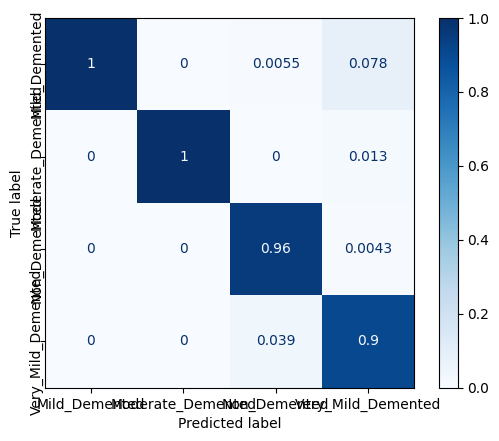

<Figure size 500x500 with 0 Axes>

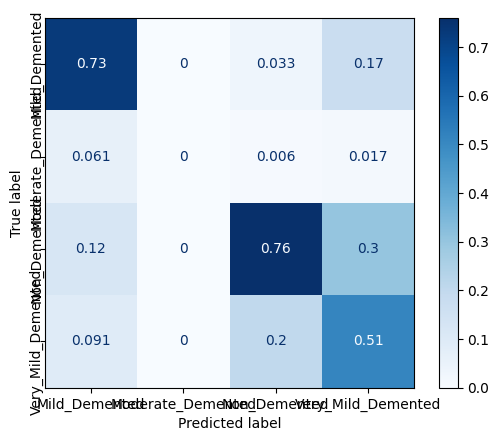

<Figure size 500x500 with 0 Axes>

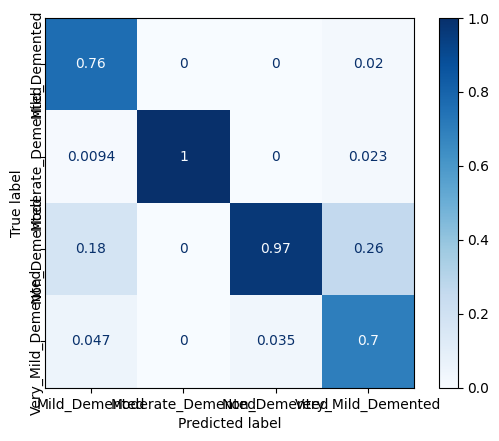

<Figure size 500x500 with 0 Axes>

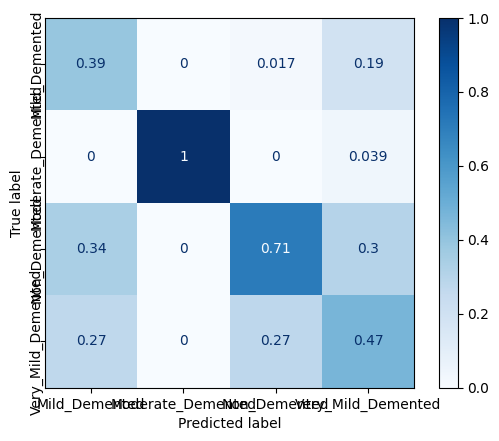

In [10]:
# experiments with Figshare
print('\nProcessing Alzihmers Dataset:')
print('--------------------------------')

train_ds, val_ds, test_ds, class_names = load(DATASET_DIR, IMAGE_SIZE, BATCH_SIZE, False)
experiments_with_dataset(train_ds, val_ds, test_ds, class_names)

In [ ]:
!zip -0 -r ResNet50V2.zip ./*